<a href="https://colab.research.google.com/github/somelijer/C2-guided-problems/blob/main/Guided_Exercise/3_Guided_Exercise_FourOrder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Guided Exercise

This guided exercise is devoted to learn how to implement a Conditional Random Field (CRF) to solve typical image processing tasks. It is composed of two parts: first, we will see how to model a given problem using CRF. Then, we will apply available inference algorithms on PGM to evaluate their performance

In [1]:
# @title Install pylibDAI and other dependencies
#!nvidia-smi
# We install required libraries
!apt-get install libboost-dev libboost-graph-dev libboost-program-options-dev libboost-test-dev libgmp-dev cimg-dev
!pip install Pillow networkx
!pip install git+https://github.com/Oriolrt/pylibdai.git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libboost-dev is already the newest version (1.74.0.3ubuntu7).
libboost-dev set to manually installed.
libboost-program-options-dev is already the newest version (1.74.0.3ubuntu7).
libboost-program-options-dev set to manually installed.
libboost-graph-dev is already the newest version (1.74.0.3ubuntu7).
libboost-graph-dev set to manually installed.
libboost-test-dev is already the newest version (1.74.0.3ubuntu7).
libboost-test-dev set to manually installed.
The following additional packages will be installed:
  libgmpxx4ldbl libxrandr-dev
Suggested packages:
  xmedcon lapack3-dev cimg-doc cimg-examples libgraphicsmagick++1-dev | libmagick++-dev
  libfftw3-dev | fftw3-dev libgimp2.0-dev libhighgui-dev libtiff5-dev gmp-doc libgmp10-doc
  libmpfr-dev
The following NEW packages will be installed:
  cimg-dev libgmp-dev libgmpxx4ldbl libxrandr-dev
0 upgraded, 4 newly installed, 0 to remove and 49

In [2]:
# @title
!apt update
!apt install imagemagick
!apt install pdf2svg
!apt install texlive texlive-latex-extra
!pip install git+https://github.com/mkrphys/ipython-tikzmagic.git
%load_ext tikzmagic



Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,172 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,618 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-up

In [3]:
# @title
# We import libraries
from dai import dai
import numpy as np
import sklearn
from IPython.display import Image
from time import time

import pickle
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
def energy(x, y, pairwise):
    # x is unaries
    # y is a labeling
    n_states = pairwise.shape[0]
    ## unary features:
    gx, gy = np.ogrid[:x.shape[0], :x.shape[1]]
    selected_unaries = x[gx, gy, y.astype(int)]
    unaries_acc = np.sum(x[gx, gy, y.astype(int)])
    unaries_acc = np.bincount(y.astype(int).ravel(), selected_unaries.ravel(),
                              minlength=n_states)

    ##accumulated pairwise
    #make one hot encoding
    labels = np.zeros((y.shape[0], y.shape[1], n_states),
                      dtype=np.int32)
    gx, gy = np.ogrid[:y.shape[0], :y.shape[1]]
    labels[gx, gy, y.astype(int)] = 1
    # vertical edges
    vert = np.dot(labels[1:, :, :].reshape(-1, n_states).T,
                  labels[:-1, :, :].reshape(-1, n_states))
    # horizontal edges
    horz = np.dot(labels[:, 1:, :].reshape(-1, n_states).T,
                  labels[:, :-1, :].reshape(-1, n_states))
    pw = vert + horz
    pw = pw + pw.T - np.diag(np.diag(pw))
    energy = np.dot(np.tril(pw).ravel(), pairwise.ravel()) + unaries_acc.sum()
    return energy


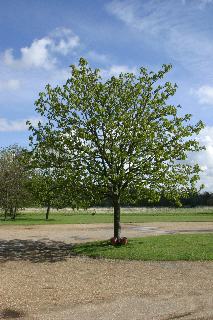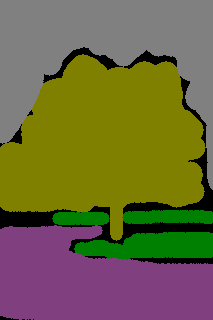
## Show image


Image is stored successfully in 'image_data


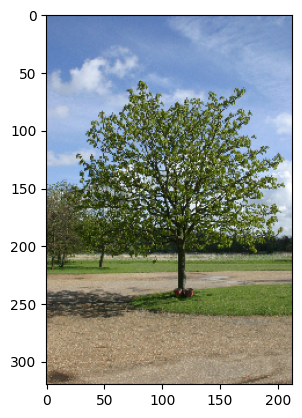

In [4]:
# @title run to get the base64 string of the image and save it to local file
import base64
img_b64str = "Qk02AAAAAAAAADYAAAAoAAAA1QAAAEABAAABACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAXnaU/3SHnP9uiqT/g5iu/1x+kv9nhp//WXOD/1hsff9Vcoj/VG6A/2R9kf9th5z/T2l4/22GoP9ed4//VHaO/0Vhhf9ke5X/gJqk/1l0jv9cco7/aoaa/1l5kf9ee5D/XHqU/3OLp/91kKL/Y3yK/22Gmv94jqj/bomd/2N/lv9oh6r/TW6Q/3eNoP9yh53/ZX2W/4CTsP9qg5r/d42b/5iotf+AnrD/cYii/56xxP97mq3/i6O5/5Gpuf9lf5P/fZSl/525yv9+mLD/eYue/3WPof+Qo7j/gJSo/42ctv+EmrH/fZus/3+Upv99lKT/i6Gt/4GXpf90h5D/eI2h/42hrv+ImKj/g5iu/3WLnv98kaP/kKGu/3mLov98j5r/gJCj/36On/+AlaX/m7HD/4OTo/+Vprr/f5Wo/5KltP94kKL/iJuu/4Waq/+Ina//e5Gk/3aRpf+Blaf/iZ2u/3uQrv+AlqT/iZyr/3aTov+DmK3/iZuk/3qQoP90iJn/fZWo/3iLmP+Noaj/dome/3ySnf9xh5f/iZ+w/4+luv+Rp7f/epGn/4Gaqv+TqbH/kqOq/3SCmP+FoLr/d4uf/6q9xv9/kqz/mKq8/4Waqf94j5n/epKf/3mPof99k53/eo+r/4WZof+Ak5v/hJSe/26Bk/91hpv/bYed/3eSpv98i6X/epWq/4Kjs/+JmKj/kKGy/5qvvv+Xp7T/kqWy/3OIj/9ohYr/coWY/2l9j/9+jaD/eY6e/3mUov9xhpv/e5Gj/4ucr/+Am6n/bIKU/3OLnP99lqj/h5us/4ibqf92h6L/oLO8/5GmuP+Jn6r/iJur/3ySpP9jeI7/lKS4/2N3if9gdYb/Xn+P/1Nme/9lfpj/TWJ+/0RceP9HXmX/TGFj/2uFlf9qgIb/cIyW/1xxgv92g6D/an2J/4ujtf9qhJT/eImc/3aOoP+Hmqr/anyN/2R3hv96jJ3/X3iI/3aInf9wgpn/Z3uQ/3iJmv9je4r/Y3KH/2aAjv9IXHX/PE5r/0ZeeP9QYnT/V2x0/2d5h/9OZoH/RWNz/2iBn/9AUWT/TWp6/0ticf9VaH//YHiJ/1x0iP9JXG//R1pv/3KKnP9fbH//ZHyQ/2p6iP9keoz/OURa/115iv9SbX//PFVq/z9TZf8+U2L/TmJj/0thev9MZXP/UmR7/0tiav9og4//ZHOJ/1Jthv9Qanb/SWR+/1t4if9/l6n/Z4GS/19whv9kf5P/U3GK/2GBl/9kfIz/boun/2yFn/91jqj/eZKs/3CJmf+EmKz/Y4GS/3mSpv9phZb/Wm+P/3eWqf92l6v/YHiJ/3qPqf97jqT/m6y2/4eerf99jaD/fpaq/4efsf97lKb/e5mq/3+Wqv+bscP/fY6n/5SrvP+Oprj/iaKz/4Wdr/+uw9b/iZys/36VpP+NqLP/mK3C/5Stx/+FobX/hZ6u/3mUqf+Hna//nbTE/4yiu/+nvNH/g5mu/5Wquf+Jm7D/iJiw/3iVqv+Gm6r/j6Kw/4Kasf+Wr8H/kai4/3uVpP94jqD/hZit/4idrv+Hn7H/hJOq/4CVpf+CnK3/fJKh/4qls/95kZ7/kqW0/4eerf+Al67/gZKn/5CotP9+lZr/jqGv/4WVo/94j6X/gZSi/5muvf9viJz/j6i3/6S3v/+TpbX/g5Wn/3aRpf+Ro7P/lKy+/5Klsv+Bmaz/i5eo/5Olrv+HmK3/gpai/5SqtP+HnKv/fI6j/4qaqv9+lKP/hJee/4yer/98i5T/jKOz/3OGlf+DlKf/i56v/3aNpv+Lna7/hZqv/3+apf+GnKj/fZml/3eTpP9+or//gZqr/5arvv96j6D/nbC//4mgsP99kqP/kqKz/36Xn/+DmKf/iqSz/1lxh/95jaL/e5Wm/5yzw/+ClKT/g5mr/32Rov94iJj/Z3+R/3OMoP9oeYv/j6a1/4adrP97jaT/c4ea/4KWpv+PoLP/comb/4GVrv95jaX/fpap/2J6kP9lgJH/doqb/151iP90gY//TmJ6/0BWcf87UGX/QVJg/zdWVf9DVGH/WXJx/3CLj/9vhZT/WXB8/0pjc/9oeIj/eZGl/4+mt/93i57/lqq8/3KGm/9zjZ7/kai4/3CLmf9yh5P/fJKn/4GQo/94h5z/dYaW/22Fnf+Cmav/U2py/4GXqP9jdIf/TWV9/1Fmf/9bboP/VWB7/2Bxgf9RZHH/Vmh8/3KGmP9jdoT/UWx//2d8i/9NaHr/Z32J/0lecP9NZXv/Z4KW/0VQb/86SGL/NDxO/zZLWP8+VV3/T2J3/zZASv83RVL/UmqB/z5LYf8zQVT/O1Ra/zA8Tv81RE//QE9l/zpMWf8+Vmv/RVhl/0VXZ/98kp//ZXaI/3OTpf9Vbob/Y4CU/1tvjf91iKb/ZoCM/2V3jf9vipn/coid/194j/9edYb/a3+e/2l/nf98l7X/bYul/2eDm/9ui6T/c4ye/32Zrf91jZz/pr/L/4Warf98kKL/fJiy/46mtP9ykJz/mrXE/4ujuf+BmKv/iZ6u/3eOpf97kqb/hZiq/4edrv+BlqP/fZWn/2+Knv+IoLL/i6Ov/32Rn/98kab/dI+f/4KXpf+Dl6n/hJip/42ouf+Bmqv/iaK1/5Wvvv93jqX/dIih/4mesv+FmK7/g5in/3ePo/+Sqrr/hZun/46fqP+Dlab/e4uZ/4qitv9ziJ3/boun/5Osvf+MorX/f5Wk/4ufsf9+j6H/gZag/2x8k/+EoLL/hJOo/4WZqv97kKb/Z3+O/4aXov95jqD/fJGj/6e9xP94k6H/mq+9/4+nuP+UpLH/gpqp/3+Sn/+Yrbz/k6e+/4GZqf+Jna//h6Kx/4WVqv+SqLT/h5ik/3GGlf+Dnq//gZKf/3mMmv98j5j/gJWn/3mQnv+ClaX/eImV/3+Rm/+NnrH/bYSQ/3SKn/+Dman/jKS3/2V9hv97kaT/eIqZ/32Vpv+InrH/mqu5/36So/+Gna7/eJCc/46jrv+CmKX/iZ6w/4GUo/9xh5f/h5mm/4Wbpv9+k6T/g5Wl/3mJoP+YqLn/eo+g/3iOo/9cbX3/lK+7/2t/kP+Bmav/dYqU/42ltv9+kaD/epal/3qOnv+Klaf/eIeZ/3ePov96j57/coKS/3eHnv9nf4v/V3OD/2J4iP9bc4L/TWR5/1hvhP9LV3L/NUNa/z5KWv9CUmT/PVFc/zpOX/9PaWv/Zn6E/26DjP97kKD/YHWH/3GMl/9kfov/eY+b/2+Hkv+Fl6z/coeY/4OUof98lZ//fZCj/3eHmv97jKT/d4qd/5CovP9sgpT/Z4CQ/2N7iv+El63/XXOE/3SJkv9LX23/bICQ/2yAk/9/kqv/TmN8/2Z6jP9RX3r/Y3eM/2J0h/9XcoP/U3SS/2Bzf/9RaHn/Wmd9/zZHWP83Q1H/QlVj/1dvgv9IVmT/N0ZW/0tfYf86Sl7/OERX/zhAU/8xOkX/LjxM/zI8Rv88Rkz/MEBN/zdCT/87V17/QEtR/0pedP9LX3f/UXF//2aAiP9ZcIP/WneQ/2uHnP9nfpb/X3aK/3GJnP93iKT/iKC2/5Stu/+QrMH/d5Kw/42mu/99mqv/fZmt/4ihr/95k6X/dJGt/4Ojtf91jaD/hqG8/4KcrP+DmaP/eJOj/4Sepf9tipn/e5ar/4Odr/9/l6b/couc/2mFlv+NqLf/fJOk/4CXpv97kqX/hqK3/4+hs/+Blqn/iaOx/4KWpv+Ak6b/gpel/3mUpP+GnKX/fpCh/4CZq/+Hoq7/h6G4/4CWr/+Tr7r/hJWt/32Pov98kKj/dYmY/4qctP9/lqj/fZCZ/4ecqf+FmqL/j6Ko/36Rov98laD/gJiu/46isf95kKX/f5ar/3iPov9qfI3/doeY/3yRov+InaX/e5Ke/3WNnv9xhZH/e5Ke/2+Ai/9+lKb/g5am/4Kcq/+BmaT/jJ+v/4WZpv+EnKn/h5ag/4qgqP+Hn7P/kqC1/5Wkp/+BlKX/e4md/4mfq/+FlqT/hJms/42fsP+Yqbj/dYqY/3SJmP+QpbP/g5ae/4WXrP+Hm7X/eIue/3+SpP96kZ7/coia/4mYq/+RpLP/h5ut/4Kcq/95kqX/hJmp/4SVqf+Nn6//fpOp/5Gfp/93iZL/i5+o/4qhsP99lKD/gI6a/5Smtv+ImKj/gZWo/32Rnv+JmqX/iZan/3eNmP9/kZ//YX2W/26Elf+Glqv/Z3WI/1dre/9/l6b/d42e/3eMnP9qgJD/aH6K/3aLoP+InKv/eo+i/32SqP9wiqL/Y3mS/1psfv9yiZX/V2x9/4mbrP9bcIH/Uml+/z1Pcf8+SWX/RFJx/z5PY/89Umf/N0NR/zZOV/85TVf/P1JZ/3GGi/98lqD/d42a/2mEiv9zh5X/dY2a/3SBjP+Cnq7/dpWe/26ClP9yiZT/a4aY/4yktf91hpn/g5uv/4Sapv+FmKj/fJOf/32Po/9pd47/ipms/26ClP9rgZP/dY6h/2Bzi/+SpLX/V3KB/2h5jP9lgIr/Qlhx/0FRYP9FYHP/RFhr/yo8TP85Qkz/NUdO/y84Rf8uQU//OUdY/zBDS/81RE3/LTxN/zRCTv82Qkz/MD9I/zBBUP81R03/OD5J/4SOkf8zQlX/Vmh1/1twj/9ic4r/Rl9w/0hiaf9pf4j/XHiL/157i/9xiY//ka69/32YqP9wjJ3/dJGh/4ujsv+MqsP/co6d/4idsv+guMD/gZ2z/4Ohuv+dtM3/h6Go/4Scrv+Dmar/iKO+/3+aq/92jab/eZCp/4qfqv+JpL//gaK1/32RpP+Ema3/eYuj/4qmt/+Ts8r/hqC0/5yyvv+Dl6f/gJOi/42jtf+IpbP/pbnC/4aesf+Ooa7/fpak/3uOm/+Pprb/fJCa/5Souv+Bl6z/i6Co/4Wbov+Oq7//do2c/4acrf96kp//epKn/4KXr/+ClJ//hZ+p/3+Tnv99maz/gpy0/4OWpf90laT/d5Gt/3+Wp/9/la7/do+f/3+SoP91jZ//fJGg/3iJlv9zhJn/cYmX/36Uo/+ptMP/c4OW/3WJmv9ziZX/ipyz/4ikrv99i6H/fpOV/4afr/+Lorb/fZKh/3uTo/+Bl6L/iJ6l/4SXsv9ug5n/m6q6/5qwwv9uiZP/dY6e/4SUo/9viZ3/fYyV/46ltv+Lprf/gpql/4KWqP+ImqH/fZGi/3iNnP+KobD/gZOk/3mTn/+AkaX/hZap/4GVp/92jaD/hJip/32RoP+FmaP/j6Ov/36Qov+CmKr/coqW/3yQof98kaH/hpml/4Kapv+KnKT/dYmQ/4qdpP94ipf/i5+k/4WXqf+RoKf/gZmh/42htf+Fl6j/fZGj/42hsv9nd4j/kqe6/1x1if9rgI7/eIuW/2h9kf90jZ3/hpmo/4ebpv97kJ7/hZ2v/1tvgf9ddob/Y3uD/2J8oP9id5H/XHCB/1tshv9tf5j/WXKO/22Mof9OXnn/S2B1/0lifP9AW2v/R1V0/0pcdv9GV2T/NlJT/1ducP95ipf/a4WX/198i/90ipn/bYKE/3KKov9lfo3/Y3uP/26FhP9sgJL/epCf/3+Xpf98lqf/do2W/63BxP+Jl6X/fpCl/4WTpf+Em6n/boSW/3SGlv9+jZ7/fY+g/3aOnf9sfIT/ZHWC/1xwfv9Ybnv/KzlF/zc9Uv8vO0X/MD5Q/0JOU/80QEb/N0FO/zxBUP82PlD/OkNQ/zZATv82Qkn/NkBK/zU+TP8tPEj/LztC/zg8U/9FX33/Q1Vf/zZMYv9IZX//Qlx1/05le/9pgZj/VmqA/2aIof9yi5z/gp62/2qGl/+JnrT/c4in/4urvv96lKD/eZGm/2yGlf+atMP/bY6e/32dqP+AmqT/b4mg/3eTsP+PpK//kKm5/5Grsv+Qrb7/iJ+v/4afrP+Cnav/i6S2/4Sjsv+FnrH/f52w/3eWrf+GoLT/epqp/3eRpP+Tp7X/e5Cm/3SMnP9yjp//f5ir/3+XqP91i4n/kKG0/4GTpP+KnrD/fZOf/3SQm/+Im6r/f5KZ/3eMm/+GnaX/r8PO/4qhr/+Pq7D/gJSm/4GYpP9zi53/hZmp/4GTn/+MoKv/hpur/4ibqv97lqv/eYuV/4ucqv+RobH/gZWm/4ugq/+Clqf/eZas/3iSnP9/kKP/fI+k/3qKmv+Fl6b/cIuZ/4Kbpf+Ck6D/gZyo/3KEkv93jZ//iKGx/5Ksvv+KnKf/hZqs/4ucp/+JoLD/g5at/5Gjtv+TrbP/v9Dd/32Sof+BmaT/gJul/26Ilf9ziJP/gZSh/3GFk/+Ak6L/fZKa/4OUnP+KoKX/gZGd/3ONm/+CmaX/jqm3/3iRof+Wp7v/gJWq/3aQov+Uq7n/fZOe/4GZpv+Gl6b/l7XE/4ujs/+Tprv/ssXQ/4qmsf+Fm6b/iJ6w/4KVpP9vgo//ipyt/3+RnP+Ooa//oq/F/4GTpP9zipr/kKax/3yTn/+VpbX/fo6f/3eTmv9shpX/gpWc/4ujt/+Bk6n/lam2/4SWq/94iqH/aoCS/2WBlf9nhJL/Y4CE/1t0iP9NZXf/UGR6/2KDdf90lK3/d4yW/2F2jP9tg47/VnOC/3OKlP9ogJX/aHuK/2uGlv9vjJz/YXiJ/09ifP89VWn/Pk5p/zdLWf84S1r/PVNX/0Rba/9UcHf/c46Y/2ODkv94k5//jKay/3OLmf9+k6T/boiW/4CXrP99kqH/gJmm/4GSp/+AmKj/d5Gi/4mfq/9thpP/aH6Q/4umsf+Loaf/e4mV/3qRn/94iZ3/W2t7/09leP88T13/Ok5d/3N2m/8zQVP/MkJN/zA9R/8tPUz/Lj9Q/zZDS/8wQE3/NUJJ/yo3Rv80PE//Mj9P/yw1P/8uOkb/KTdN/ytAYf9KYoD/NUxj/0lefv87VG7/ZHl+/0xqh/9bc4f/WHWQ/1t7h/9nhp3/bISW/4eer/9ge5X/VXSM/2iCl/9mgI7/YnuU/3KNpf92kKX/cpGm/2eFkP9zjqT/hZmm/4OetP9xjZ3/YXyK/3qSpv9wi5v/ZoSR/3mNpv95maz/g6Cw/3GSpv+In6v/fJmr/3ybqv92lqj/iqq8/4Gbp/+BmKz/iKW0/4uluf+QpLT/psDR/3KNov+HobL/hpql/5qwu/+fusH/hJyu/3OLn/+Bl57/eIuY/3iMoP95kaH/fJOb/36VpP+Fl6j/hJek/3uOlv99nar/eY2e/3uOnf+KpKv/gJem/4+ovP+Em6v/f5qo/5Sqtv+Bl57/do6m/3GLm/95j6H/cYeX/3+Umv95kaf/g5ei/5Gmsv9zhZb/do6d/3uPof98k6L/fJWj/32Pnv+Kn6//iKCs/4CXp/+CkqL/coiU/6+5wP9zipr/fZCX/3+Wov+nu8D/gZim/4mgr/+Cmaf/bIOS/3+Uqf+Dl6b/gJmp/5SmtP96kaH/gpWi/3qTnv+Inaz/doqc/4CdqP+Hm6r/coaT/4CUn/+Vq7H/laiv/2+Mm/+SpLD/jaSz/4qdqP+Inqb/jJyt/4egr/+KpKv/fZSi/3qMmP+Al6f/lq26/4CSnf9+k5z/eY2e/4afo/9/l6f/fIuU/4icqv+Vpbf/g5ak/4CSn/9/lp7/gJOa/46frf+ZqLH/mq64/5ast/98kZr/m6y1/3+Rof+Wqa//aYSS/5iqtP+UrbH/cIuM/3aTo/+Jrbf/h6e8/2CHpP9mf5f/QF94/3GGlf97jJ//cIed/2iGmP98mKb/b4CT/1twf/9rgpf/ZH6P/151jf9ZbX//a32U/3F/lv9HWGv/Rlho/zxaW/+Wr7T/e5Wl/1duif9jfo7/d5Oe/4Kdrv9yi5f/jaKz/3iPof+Dk6P/g52l/4iesP+Blaf/aYKW/36Upv9pgZP/eI6e/3CRof+To63/gpah/4iYo/+Bl57/VG2E/0lgc/9OWmz/O0xf/0BNYf85R1v/LkFM/zFBTf8oO0L/LT5M/y49Tf8yPUr/KjpG/yU0Rv8sPEn/N0RU/zdHWv8yRF//SFh3/zNLZv9Pbn//P11+/0dkev9JY3b/eZKt/0hkh/9sfZ7/aYaV/3uYtP9xjaL/Yn6S/26Gk/98m67/YXyP/2eDpf98lKf/cYug/3OQrf+Hobj/c5Gd/3KHnf9+m7H/ZoKT/3mSo/91jp7/do2k/2aFmP95k6n/d5Gj/2B+mP9khpT/dY2i/4Cgsf+Cn6z/f56t/4ScrP98mKn/eJGk/3ONpP+Amaj/f5al/6rCz/+Fnq//i6a6/3uTqP+KprT/hKGt/5uvtf+Rpbf/iaCx/3mLov+Gm6P/rcHK/5Gksf96ipn/gpan/5GouP+Inq//ip2r/4ycrf9/lqL/gpmk/4ehsv9zjZn/bYCM/3iOnP95kaD/dIub/4eesv98j5T/iJ6s/3KLmv+Jnar/fJWi/3+Spv96j57/g5eo/4mgrf+GmKf/jqWx/5Srvv+Npbf/gJqr/3aMov9zj5//haGw/4Odqf+GoK7/iZ+x/5Cmsv+Mpbf/k6Wy/3iOmf90iZr/iKCy/5Kirv+Sp7v/mq2//5iwvP+Rp7T/g5Of/4merP+Hn7b/eJCg/4GYqv92jZ7/jJ+r/32VnP95j57/lqm4/4mapf+DmKX/iqK1/3GGm/9/lKf/i6Sv/4KasP94jZL/lKm1/36Uof9sgpT/gJGd/3mNmP9nf47/eI+T/3mMmf9zhZb/dYeS/2yAmf96iJn/gpio/5Clr/+cq7n/fY6a/4ucrP9/kpj/d4uX/4mdrP+Clab/gpOe/5qpuP+ImJ//hJaj/4Wfpv+MpK7/jZ+v/46hqv+ClaT/jaCv/4GWpf97j57/f5Kk/2h8jf+GorD/aYGV/2yEmf+Cmar/e5Ki/4idrf99j6D/kKi+/42lsf9/na3/j6O4/3KHnP9fdYv/ZHWG/2uEiv9SbIH/SWR5/1JugP9MY3b/T2R3/01sgv9bdIP/XXiC/2V7jv9rgpP/dIqV/2yFjP+Srbj/boCT/4qgqf93jJr/fpij/3qVoP91jJv/l6+9/32Rlv+LnKX/lKav/3WMkv+Am6b/XXKB/0FceP9YepH/Q1Vm/ztUZv8xTFr/OEtd/z1KXf8xQUr/OE9a/zM7TP8yQVL/KjlL/zRHXf87S17/OEZn/0ZYZP84T3L/U3CG/0dkfv9OZ33/Sml1/0tddP9fcX7/RWR//3GKnP9Raob/S2mE/3OLpP9shZn/bYqe/3ONm/9feYv/Y4KY/3GOn/90hJP/b4qe/2qHov9qhZP/g5uy/26LmP9mh6D/c4ia/3OJmf9wipz/eZGg/2yJmf9wiZr/ip2y/2qDmv9+m6v/lKq6/22Dov91j6T/dY+n/3aMn/9xjZz/do6h/32Srf+DmqX/gJyp/3uSm/95lKT/kau5/6O2xv+WrsL/hJ+r/36Wqf+AnbH/gJip/4ubtf+bs8f/gZuv/4ebrf99lqj/c4qg/3uWoP+Dmqn/gpir/4+kt/+SpLb/f5ux/4CZrf+DnLD/g5mi/3OLmf9/l6j/laq+/5Cqtf+Koa//lqm6/2+GlP+Cna3/f5mn/2d+kP95kqX/gJqp/3uRoP9/l6f/fpem/3uTpf99nbH/gpOk/4ehr/99k5//an2K/3+Un/97jqD/h5ys/3+Un/92jKT/g5qo/3+Tpf+Gnaz/aoKS/4ier/+Vqbr/jqWw/4GXqP+Io7n/kq2//42ptv90h5v/doyZ/4KXn/+VqbH/dI+f/4+js/+VqbX/fpCl/4KZr/95jJ7/na+7/5qptf+SpbH/ip+s/5iqsv+Dk5//hp2s/4icqf91g5H/gpmo/4absP+AlaD/gZOk/4mZqf9/k5v/dYaW/3+Vpf+Vpa3/iaGz/32Onf+AmJ3/gZSd/6a2wP+Hl6T/gpSf/3mLm/+Dmaf/fo+d/5Skr/9/kqf/h5qq/3mNnP94ipb/eoye/4GRmP9/lqb/fY6c/4aepf+fr7r/mLC6/3mUnv+NobD/nK6+/3yPqf9xhZT/ZX6N/3iRov+Lm6X/j6S0/3mUov+VrbH/e5Op/5Cltf9kfob/e5al/3iMnv9uh57/gJuh/3SOpv90jqP/cY2g/3CLoP9qgI//WWuA/3CLnf9lfov/aXqN/3SIl/+Amaj/c4mX/1p3gv9ziJr/eY6Z/3WOoP+Gn7L/fpej/3+aq/+Km63/g5eq/4ecsP+Amqn/UWl9/32Urf9FYmn/RmKE/0ldf/87VWX/MVJf/0Rde/81Rlv/MUJT/y5GUv86UW7/R1+D/zVPY/9CVGX/fZmq/116m/9gd4n/T2uJ/1RzlP9ScYb/VHWR/1RvhP9ygZz/XX6X/26Rpf9ffJH/aoWZ/2+Jnf9yi5n/jKm4/2R+i/99maz/aIGa/4Cbrf9xiaX/ZoCU/3aPn/9whZ7/cIqd/22Fkf9ogZH/bYCL/2N9lf9siZT/an+O/3OLmP9th5X/eZao/2R9kP9qf47/WnGC/2uLn/9ieYn/ZX2N/2R+jv9ifIv/b4qd/26Lkf94laf/XXuW/3SPo/9vjqP/boyk/2yKnP+Bm6H/gaW3/4qktP+OrLr/fpyx/4mnwP93lab/gZyq/5Krvv90jKb/cpWp/4qluf+Lpbr/dY2Z/4eXqf+BmK7/fZqo/3uUpP+kt8j/la25/4OYrf+Jn7D/hZut/36PoP+Dnqz/jKGp/4mbsv+Jn7H/hZSk/3mUpP+KnaD/kaSz/3yMnf+JobD/hp+w/2uJmv99kJr/iaCo/5Krt/90kKL/e4+h/3SKl/+Lo6//c42Y/36Uo/+DnLD/hZum/3GEk/91jaL/fZSk/3ySnv+Bm6//eJOn/4SZrv+Alar/fp2y/3qQpv+AlKn/h5+y/4CTnP+BmKj/douc/3qPof9ugpP/nbLE/3qSpv+Cnq3/fJGj/4OZpf+Dkab/mauy/5Oms/+EmKP/gpes/5Smq/91hZb/eY+d/5ywv/9+kZb/fo6a/5Omq/+Noan/e4yh/3mJj/9zkaD/fo+i/5aisP+Jna//dYaS/4OZov+MobD/gJSg/4eYpP9+j5j/g5ae/4ybq/+Jm6b/g5ik/4OZnv+ImqL/kKe3/3qUo/+EmKL/l66z/5yvu/+BmKf/f5ij/36Tov+Koq//jZ+0/5Souf9+k6L/fI2c/3aJpP93jpz/c4yW/3yTpP+Elan/h6Gp/3uVo/+CmKT/gZKm/4qdsv97lKf/eZCf/4CTm/9yjZ3/a4KT/22Hl/9keoz/VG51/111jP9eeIj/bX2P/2yFlP9Xbn3/b4mZ/2V5iv9gfIj/cYuX/3GCj/9/kaL/eZCm/3SQn/9xg5T/bo6h/4aXq/+Cnqn/doum/1ZzjP9KaIP/TWyE/zhGZP9TYnL/OU1l/0ZVZP8/VHL/QlZq/1lxg/9beIT/YXeE/2+Gpf9LZYX/Sm6M/29/m/9cdoz/TGqI/05sh/9rg5//Yn2W/2mEnv+Tq6z/bY2a/3eOpP98laX/Zn+V/4aetP9rg5//kKK5/3GQoP9yjpr/kKOw/2B5k/9tg5X/cY+k/3GPmv9shpf/c4qf/2eCnf9nfIv/b4WX/1dygf9feYj/W3iN/2SDk/91mLH/fZaq/2N+mf9neIv/XXqM/1l2i/9vhpz/a4ig/3iMnf92lKf/ZnuL/36Vp/9gf5f/fpSg/2mJnv93kqP/dZGi/3CMmv9rhJj/dIua/4OZrP9/mq7/iqK2/3+ct/99m7H/dY6f/4+jrv98n6//comf/4edrv96k6P/hZuo/4ierf+Mo7P/g52x/5Cmtv+FnKz/mq24/4CVpP+lvMn/nLfO/7DH2/+RqLj/jZ2u/4KZqP+EmKn/h5yt/5mwv/+Em7H/h561/3uUpf9/na7/gJqr/4Kcrf+Bmqv/b5Oi/36TqP93kqn/g5+q/3ySnv+Inqv/dpCf/3mRp/+Sq7v/eo+Y/3aJpP+RpbL/fpap/3uSov+ftMD/eoyg/3mTo/+Ur73/lKu7/2+Ilv+Lna//e5Ke/4Wer/+Rq7v/hZ6q/4Kbq/+JnbD/fZKh/4iaq/+AlaX/fJOi/4SUpP+Cm6//m7C//4OVo/+LmaX/d4uW/4GZn/98jJn/fo2f/4SXn/91iJT/fI2X/4ygq/+AlqL/f5CZ/3mMkP96i5T/h5us/42eqv9+kqD/fpOi/5Optf+WpbX/eoic/4yeq/92h5D/gpOm/32Qn/+Onq7/jJ+h/4mhr/95j5f/hJWe/3eHk/+ImaH/doyX/3aJmP+XrLv/jJ6v/4iYpf+EmaT/hZmn/32Oof+ClZ3/e5ik/5Chsf+JorL/fpKd/2+Dlf99l6P/iqGx/2iAkf+BmaX/c42b/4eaqf98k6P/h5ur/5qwu/+PpLL/eoqh/4+lrv94jJ7/coaf/2eAk/9rgI//b4aW/2uFjf9meoX/an+Q/2h+jf9zipr/i6Gw/4aZof90jpX/dYyV/32UpP+EmaT/hJSk/3WKmf92ip3/ZHyQ/150j/+arL3/epWw/05qiv9qg6X/Pl18/z1Sbv9edoz/WHKK/1dyh/9ngJ3/WniY/1dwfv9kfZv/VGh6/2l/nf9ffJL/g5u1/22Jqf9eeJD/W32G/2+Hmf9zj6D/YH6T/1Jujf9miJ//ZXmK/2+Nnv9tgaP/h6av/116kf+Eobb/eJWq/4agsf91jZ//or/M/5mxvf9ceI3/coyg/26Km/91h5X/aoGS/3GInv96iaD/U3aX/2mKnf9ti6D/iJmn/2F8jP9XdIL/e5Cf/2l9j/9qfYv/aHuI/3OPoP9phZP/W3GE/1Zzgv96laz/aYaU/2yDmv9pgI//coic/2h+lP9wiZn/epOu/3GHk/91jKP/boKT/3SPpP92jZr/ZX6T/3aOoP+Alqn/kKW6/4afr/92jqr/gZqu/32Xof9+ma3/h5yt/4Wlu/9yjqL/iqKy/5Kos/+Bl6T/gZys/4aftP+Noq7/laq5/3uUp/+ForP/i6Sv/7LK0/+TprX/jKO3/4qluf99lqr/gJSo/46muP+RqLf/jaK3/3SJov9yiJ7/fJGm/4ahsv97kZz/lau8/4SarP94kqP/gpyr/5mtuP+Fn67/eIye/36Tm/+Fmp//iZ+m/5Oot/+CkqL/ip6v/5Skt/+BlKH/gZup/4CVpv+BlKH/hpaj/3+Xq/+GnKf/fZGg/4merf90iJn/e5Kh/3iPn/+NpLD/gJie/4SZrf99laH/gZWl/3mImP+MnKz/jKOr/5aotP97j5T/h5eg/3uOk/90hJP/ma22/36QmP+Ck53/ip6v/4ydpv9/k5v/douc/4WZof+Gn6n/na+7/4igsP99jJz/fI+b/46kqv+Jn6r/fZOl/3SElf+Jnqf/fJCi/42gqv+Qo6z/gJWk/4ifp/98jZb/hZuq/4CSnP+Lm6T/boaV/4WUpP+Ioa//g5ei/3yRof95kqL/iJuo/26FkP92jJv/ipmp/4aarP92jpr/g56t/3uVof98kqH/dpCd/4ibqP+Hnqj/hZWm/4qesP98kqT/e5Wm/3GHmv9sf5T/a3+R/1Z1hP9fdoX/boqb/190if9ieYj/d5Kb/2N9i/9yipz/eZGj/3qNnf95jp//eo2a/3+UpP9xeZD/ZnyR/2J8mf9vjaX/cIWV/3qTqv9ddJP/VnaE/3WQo/9ZdJD/X3KD/2l/kf9/oLL/X32P/2yHnf9cfZL/jK+8/1V2kv+IpLz/haCq/3ibs/92kJ//dpSo/2GJnv+Blqj/eJKo/1VskP9rh6X/hJei/4Oet/+Jobr/hKO2/2mHof92l6r/co+l/1p3lf92j6P/aYGf/3mMpv95lK7/bY2g/2SFo/9yjqj/gZm0/2OBm/9mf5T/b42m/3WMov9feor/fZOv/3OOov+RpbX/ma68/36Vq/90jZ3/eZSo/2qGmf9vh5//iKCz/3WSov91i5z/d5Cl/3OOov9jd4r/dYeP/2B/kv9ed4f/ZoSX/1hwgv9rg5L/eY6m/4CXp/9of5P/douf/4Oaq/9leZb/fJWp/3aQn/+Bmav/epSm/3SJm/+Fn6//gZeo/36brP+Lo7L/kKi9/4iouP+bs8P/kKmz/5Kntv+GobH/lKy5/46ouP+Zr8D/lq/C/3mVrP+VqbP/m7XB/3yMnf+Kn7X/gpuw/5Wpuv9/la//cIue/3mNnf+Blqj/f5mm/4Kbq/+DnrL/fpWo/4KZqP+Blqb/c42f/4aepv+HoLD/jKS1/4Kasv9zjqX/d42a/3qSpP9viJj/pLjJ/5WqtP+Blab/h5+j/3mMnv91iZr/gJKe/3uPoP96jKL/h5ys/3mKmv+Mnq3/h52p/3CHl/+FmKL/lKqy/3OKnP+Ak6X/hZal/4WWoP96jJT/eYmX/4eWoP97kKT/hZSh/3uQmv9+kZ3/k6Sz/3SLnv90hpD/hZai/3qOoP+RqLX/fpSj/5mouf+DlqL/jaCs/5Omtf98kKb/kqS0/6G1vf+BkJr/gZai/4KOl/9vg5H/hZee/5iwsf+bs7n/jZ+q/4KUpf+ClZv/eIea/3mNmP9/k6L/iZ+v/4eVof95kJz/i52k/32SoP97mKL/kqay/5Gisv+DlJr/fZOl/3qOo/9pfZP/eYyh/4qiqf95kqP/gpyp/3iTnv+iuMT/jaa1/42it/+ElJ7/c4ia/3+Yqf91iZj/Y3iF/2h/jf9/kKT/cYWX/1Jrev9idoz/ZoGP/3aNmf+Al6P/dIuV/3SKlv9kgYX/cImV/3GGkf9nfI7/Ql95/2CAl/+Nqrz/XnqV/2aAlf9zk6b/ZX+Q/2OCoP+Rqbn/Zoad/2B1hP9geoj/TWJ6/26Nqv9kg5b/krHD/4mpt/9wi57/eZCj/3mTpP9lg5P/YXyU/4aktf+FrMf/cI+j/3eUrP91k6j/jq29/2uIqP95mrD/bYqi/3aUov+Cm7n/hKC0/3KQpf9xkqX/iZ6z/3CQpP9tjqT/bYmZ/3SZrP9zk6D/bomd/4Sitv91lKP/e5qx/32bqv98l6n/b4mh/3WQof9ohJT/epiw/2WCmP94kp//a4uc/2mFl/9nfJP/eI2d/3KMpv9sgov/a4SW/2+El/9pgp//Y4CV/3CGnP9dd5T/dI6d/3GKnP9xkaD/aoqY/3uTm/9ugY7/ZnuN/1NxhP9pgYr/comc/3OKnP9vipD/f5ak/4uotv92lqH/bYac/4Waqv+Dn63/k7HD/5Krv/+KqLf/fpar/4uouv+BnrP/rMHS/3SLnv+TrLv/g56w/5Gpt/+Hnqz/j6S2/4+mtv9zjJ7/dZWl/3qbs/91i5z/kKq+/6y7yf+NpLH/fZKi/4+otv+gtcH/eYqd/4Karv9+lqf/j6nD/5uxxP+Cm6n/hZ6t/5WntP+Fn7L/fZSk/3GLnP+Kna//ma64/4ebr/+ImaL/eZGj/4WitP+Gl6P/gpen/4aerf93jp7/d4uc/4SYrf+Dmaj/b4aW/4CVnv97j57/hpmh/36Vof+EmKH/kqKv/4aZof99lqX/jp6x/4WcpP+Gm6b/c46a/4KSo/91i5r/kqOy/3uSnv+InKj/kqWy/46erf90iJr/gZWi/4Wbov+Mo67/fpCX/4KUoP9/k57/eZCa/36Qnf9ufon/hpKf/4OZpv97jJn/i5yr/4GPnv+FlZz/mKy2/42gp/94i5P/jaKs/4mhr/+BlJ//fZGc/3mNlf90i5f/l6e7/5GmsP94jp//eI2d/4qhsf+PoLH/f5am/4GWpv93i5z/oLTC/4ujqf+Dm6n/f5Wl/4aap/+RqbX/gJWr/4igsv+euMH/iKWt/3eOm/94h6D/bYGS/2B5f/9feo7/b3+Q/1Zxfv9heYr/eY6c/2uBlv93j5//b4iT/22HlP+TorL/fY6Y/4CZqf9mfI7/WHGb/3WLjP9ig67/fpin/3OOof9ZeJf/YHWI/3mUrP9rhqj/e5Cq/0dpgP+lvNH/Zoab/1F5k/9aeIn/VXB6/2+Knv9wjJz/Znx//4SYq/9bc4f/YoCZ/2eGnf9ge4z/WHmO/1Zxhv9ceJH/us7f/4KYpP9igJr/aoCM/4aiuf9zlan/Xnyk/2KCm/9fgJT/ZoSe/2KGoP9kgJD/or3P/157lv95kqT/Y4GW/2qAkP96lqr/e5eo/3eYsf9uhpz/bIaZ/1p5lP9xlaf/WXKL/157jP95kav/VGp8/1pxh/9OZXP/dJKj/3SPnf9th5z/WnB8/1txfP9efJH/Z4KT/2qKo/9fd5P/d4+f/2J+j/9ddYv/Zn+V/3qRp/9ohpb/fpSp/3GLnf9YcYX/cYmd/3uPof9heY3/gZ2u/2eDnP99mbH/b42b/4yitP+Moqz/hJul/4OVpv+Rq73/eJSm/2yIoP9+l6j/gKOx/3iTp/+Ioq3/jKu6/4aeq/94kKb/eper/4CaqP+Dna3/c46i/4SVqP9+mKv/gpet/4ifrv+OqLP/hJah/3udtP+dtLz/lqm3/4acr/94jZz/doyX/3uXp/9/mav/jaW2/5Omtf9vi5v/eJSo/4Chtf+Rq7r/gJGk/6rC0v+NoK3/gpuv/4Wdq/+htcf/kqm5/3KOnP98kaL/doyl/4SWp/+LorP/iJmo/4aap/93jZ7/eoqa/4GUmv+PorH/fZWh/3qTmv90jKD/doua/4qgtv94h5r/domX/4mcqf+NorH/f42l/4GXqf+Kn6//jJuu/3+UpP+AlZ7/g5ym/4eaof+ClaT/gpSd/4ubsP9+kp7/gZah/3qLmP98i53/d4iY/3KIkf95j57/e46b/4iYpf+Inqn/eYmZ/3eIm/9/kqH/l7bF/3mNlv9/kKH/fpWi/5Cntv97kKP/kZ+z/4aYqf92k5r/mq26/5Cquv+Bl5z/f5ql/4KXqP91i5H/aX+L/4Odp/+Inqr/eI2Y/4idrP+OpbT/kai3/5msuf95k5//iZ+l/3GJkP+LpbX/f5ae/4merf96i57/b4eb/3qPpP9of47/cYGS/1Vwfv+IobL/doqX/3aPnf9qgI7/cYST/4KVo/95jZr/eI2o/195nf9WdIP/WHKK/2Z8nf9VdYj/ZIaa/42ir/91l7b/kq3C/2+Knv90kZ7/iKvF/4KfqP9skK3/ZH+Z/36hxv9lgZz/lK6y/2J5hv9Vb4f/XXyR/2B8lP9oiZ3/ZIGW/36Zrf9+kqz/Z4ea/1Briv9wjp7/ZICR/3SRoP9piqP/cJKu/3mXsf9vgp3/Yn6g/1yBnf95nqr/b4CJ/3iWsf9riKX/X3uW/3SRof9hfpP/XXmK/3KKov9fh6H/fJur/4ShrP9mhZ7/dY+f/3eQp/9sf4v/Vmpw/1FtdP9fc3f/cI2T/3eSpP9Wc4L/a4WW/3mPpv93lKP/d5Cm/3iVpv9lgp3/lKOw/2qFlv9pgpz/YnyJ/2qDl/+PorD/b4SR/2iCkf9hfZf/S2N5/3WOn/9yipz/c4CG/3eNmf99mqn/a4WV/3GHjv9vjJv/boeY/2yBlv+Bn6//epmm/22Jl/95mar/g5ys/3qTov95i5z/g5Wm/4Gap/9nhJL/ZIKS/2+GoP9yjaL/bIme/2uEmP+GnK3/hZil/4ymuv+VrMX/haKx/4yksP96laT/hai8/4ajuf96ma7/h56u/4ifrv9/mq//kK28/4ibqv+iu8j/iZ2r/4OVnv+dssP/iKGx/4iisP+TpbH/hpmo/4ydqf+Blab/kqax/3OJjv+Gnaz/d5Gj/4yjsv+GnK7/dZCe/4aYqf96kZf/iJ6q/32To/+Mmqr/hJWf/4Sbpv99lan/bYiU/3yMmP95jJb/hZ6t/3KFjP+Mqrn/hZym/3iNlv97kZ7/eYyb/4KYpP+jtr7/hZ6o/32KlP9+j5z/g5am/4map/+RpbH/eI2X/5Ooqv98jqH/iJqr/4KZqP+Moa//jJ+u/3ySnP+DkqX/g5qo/3eGl/94i47/g5mp/5antf9+kZ//fZCf/5Ousv9/lKX/g5up/4ebr/+Inqj/iaOz/2+Ik/+Hnan/gJik/2yFkv9yhJX/fZCj/4OVov+LnKn/i5qs/4+krP+Cnav/kaa1/3+Zpf+QpbX/b4WR/3OMoP9whZr/b4OU/3iJm/92jpr/ZHWE/3WKmP97k6P/boqb/3iPnv9leov/a4aU/32Uov98lar/iqGx/4CXp/+Bkqf/t83f/42ovv9YcYD/aISo/2J/ov9iepb/e6K7/3qZrf+EqcD/dpGf/1+Env94lKr/fJ+x/2aFmf+uyNL/ssre/2qGoP95kbP/Zoug/2SDmP+AnbL/c4+g/22DnP+HoLX/Z4ue/1lzf/9dgpH/co2h/3+Yrv9ph5b/ZoOY/2eFl/9hhJz/cZGe/2CBmf96lKT/Z4Sb/3KPoP9wjaz/fZmz/2uInf+Ena3/gJqp/2GClv9aeJD/ZoGV/2aFm/9shp//VHSI/1Jvjf9Qcon/cpSs/3qRq/9rhZ//e4yj/0RthP96kqb/WnWN/3WSov+Pprn/d5Sj/2eElP+Clqj/W3OE/2aBjP9/mKj/dI6e/3uSov+Cman/WXWK/4GVp/9vh5T/Z4WY/4qns/+GoLH/bYSe/2J5gv9ccIL/UWR5/4CTm/9lfZP/aX+V/1hyg/9tgI7/cpCg/36Ql/9UcXv/YnaL/3KFmv+asr3/epKe/32arP9idYj/bYic/2uCkf9ph5r/ZoOX/2N7j/9geYn/c42a/2qIm/9xj6X/haCx/2+Jmv+CnKv/hpmu/3iTn/9+maP/d5Kl/4Ccpv94kp7/haKu/5Kxvv+Hp7f/kazA/4OfsP93kav/fpWn/4CYqv+Uqrb/fZmq/4CXqf+LprD/g5mr/4Wcrv+QprL/gZWg/4+ktP+EnLL/fpSj/3iNnP96kp//iJyt/3iMlv+crLv/e5Ol/32Sn/94j6P/ip2l/3eKnf9whY3/e5Oo/42hsv9wipr/j6Gr/4eXnv96jpz/jaOy/4Wbpf+Ak6T/fpeh/3iKmP+Bk6z/hpam/4KXpv+Vpbb/p7rB/4KXpv+LnKn/k6mu/32RnP+Imaj/i6Ky/5artf9yh4//dYeS/4SZqv95kaD/ZXeM/3mRnP+Ak6L/hZyj/3GHlf+FmaX/fo+d/3+Vm/97j6D/pbrB/4uhqf95kKD/f5ep/3iQn/9+mKb/hJur/36Yqv9vg5T/hZ+r/4CTov9/laX/fpOi/4ibqv+Ooa7/fpKf/3ePmv97kp7/bome/32VqP9+laT/bYKR/3OGk/91ipL/dYaX/3aImf+Bl6X/bYST/3qOmf92ipr/kae0/32Xp/+LorD/gpef/3+Pn/98j6L/UGuN/4aoxP+Yscv/e5Wu/3yaq/+Dna//aouh/3mToP9OaoT/bIaf/0tzif9vj6P/or7M/3eYsv9mhJv/eZaq/2B9kf96nLn/dZaw/2eKn/+Ipb3/m7rP/2qFmP9thpb/WnWL/0Vifv90jKj/ZXqN/4CXsv9uhpr/Wn2Q/2SKpP9piaD/aoqh/22Il/9qh6H/ZYSZ/2N8jP9aeIv/cJCm/36crf95lK3/X4Se/2iNrP9qiqX/Z42i/2qHnf9ng53/ZYad/3GOpf9wjJz/b4qk/22Orv9wkKL/fpqu/2OCm/92l6T/lrHB/2uKn/92kKL/fJyw/22JmP98naz/eJSq/2qGof91kqz/cYmg/5qwwP9ddZH/cYqW/3OKnP9kgJ//aoih/1p5kP9ccYf/WXKB/2l+k/9qfJf/d4+h/2R/lP9IZnv/VnSP/26Gkv+qu8j/dY+k/2F/mv9zjaT/boif/1ptdf9ieYL/UGuA/1RrfP9uh57/aH6T/2aFl/+Koq//Xn2V/3OKm/9lgJ3/boma/2iDl/9viZz/YneG/3CCi/+AmKX/jaOv/3KJnP9mfY7/Z4CR/2V+k/9xh5n/c4ub/4+is/95jZz/epKf/4Odqv99lJ//gZmu/5OmtP91iqH/n7TE/4ObrP+Cnq//jaKz/4OYpP9+laX/mbC+/4CVo/93kJv/f5Wf/4KSo/99j5n/gJSf/3WLk/+Clqj/gJOj/63Ayv90i5r/gJGb/5Cjsv95j5b/eIua/4OOl/96jJX/jJ2s/5Sktf+DmKf/lKq7/4KWpv+Dm6v/hqOy/4Gaqv9thpz/jaGu/4CZpP+DnKr/g5yq/32Upf+Hnaz/hpih/4yjtf+bscP/gJWj/4ykq/+MorP/epCe/5SsvP98jJ7/hJin/3eMov+Em6n/c4ic/5KnvP+gsr3/e5Om/4mjsf95kKD/kKau/3+drP+Ena3/g5ir/5Gks/+KnrD/hZik/32Sn/+Dnav/hpyr/4CRov+HnKv/f5qn/4OVov+Fm6v/fJqr/4aYrP98j6D/doqc/2WCj/+Dmqz/fZGf/2uCk/9keov/XHWE/3CGlv99k6X/aICQ/3CFmv9nfZL/bICN/5Cis/97kab/e5Cf/4eerP96k5r/gJyz/36gvP9OdZT/YIGb/1Fvif91l7H/W3mV/2eFn/9lhJr/Y32V/2uFn/9lfY//Z4mT/115nP9qi6D/la7E/4Cdt/9pjaf/g6C//3GNnf96mK3/f5y1/32crv91jan/d5q3/1N0kf+CoLL/VHiP/36ctP+Prcb/pcLP/46pu/+OpLr/mLXL/4aku/+Oq8z/X4Ke/3yRrP+Dnrb/XX+b/2uDmf+jusr/Yn2b/46uxP95mKr/bJGw/26Nqf9riqj/bI2j/3WZuv9siaf/eZKj/3KNrP+3ytH/i6nB/4Khsf9qh6H/cJGp/2aGof+Gp7z/c42d/32Zr/9pg5P/eZSi/1qAmP9xiqL/Z4ul/3WUtv9nh5X/bIui/5ervP96nrX/cpOl/2h/mv+lvMb/a4ee/2B+lP9Wfpb/iaO1/2qJov9wiab/ZoWb/3uYsf9nhJ7/bY2k/2aBmf9pf5f/bouk/2SBlv9ZcoP/VGh3/0Zfff9hfI3/ZYSU/4Oarf9siZ7/Z3+K/4CZrv93jZv/dI+f/158lv9qhp//V25//2V+kf9sg5v/fJip/26HlP9lfpL/iJyo/152if9riKL/fpiu/2+Flv+Ak6P/iqCt/32Vof+Hn6//j6O1/5Suv/9+laL/e5Wf/3+ZoP91ipj/iqSy/6Csuv+XqLH/eIuR/36RnP+HmKX/hpys/4WXpP+Qoa3/gpem/4+erf+No6r/gpSj/4iZrP+AkqD/g4yX/4WcrP+Fm6f/a3+O/5Sos/98j5f/iJ2q/4GXrP+LprX/lKe2/4qhsv+KpKz/jKSx/5Ksuf+Gna7/f5We/36Upv98kqv/dI6d/2+Jl/+Hm6//hJ2s/36UpP+Mp63/g5yr/4Caof+erbj/eZWh/3uXov+Op7f/jKSz/46isf91i53/hp60/4SbrP99lqb/jKOy/4uepP90iZb/fpWo/3mLnP95j5f/eI6a/4KWpv+Blqf/fZil/3ySmv9sf5P/c42e/4Sbq/+Rqbn/eJWb/4Gbq/92jZ3/i6Kt/3eLmv96k5z/cYSR/3ePov91i53/dY2c/3SNn/97jZ7/WnSM/32RoP+BmKH/iZ+t/3qVpv9/laD/gJqk/3mOpP+Bnaz/h6Cq/3yOnP96iJn/VXOi/4Kas/9zkav/iKfC/4icvf9yjaL/bIqh/8DP3v9liJj/nbnO/3iSo/+EpMH/ZIKR/2eGo/91k6b/aY2f/4Gas/9ie4r/mK3E/46uyP9thZH/XHmI/4Gfuf9/mKb/iabE/2mMpv9ihKj/dImS/2OEp/9mjK7/gaa8/194jv99mbb/a4aU/2uGnP9sjqb/fpir/4OkuP+Jq8j/aI6q/5OvwP9kgJ7/gaC+/3SWq/+Ipbv/cJez/3eXq/+Rrrz/iKm9/36ft/90j6P/ZH+a/1d2k/+Qqr//e4uh/2iGof9iepT/ZH6Y/116lf9xi6X/e5u4/3yRpf90lrD/hai8/1+BlP+TrMD/cI+k/2uMnP9ohZr/cJSm/3aQqP9hhJH/j6a2/1drev9zjZ//YHuJ/2F7j/9sip3/b5Cs/46txP9+kqP/aIal/2yIoP9piKL/e5iw/4qqvf+gu7v/laaw/6W/z/9zi6T/g564/2J9jv9thpb/bYOS/3mXrv9phJn/h6G2/2uJnP95mK3/e5Op/3iVsP9xiJz/c46o/2yDk/9nhpb/cIqb/3iLl/9uhZX/bYma/2iFov9wipj/cYuf/2mFmv9pg5T/cIuT/3KPpP+Qp7b/ma+7/4adrf+Yrr3/coqW/4mfqv+Mo7T/mrbE/3+Pnv+ImqX/gZWb/4+itf92jZ3/kaqz/36Nlv+WqbT/gJmj/32Sof+BlJ//f4+g/4qkr/99kZb/nq+7/4yisv+DmKD/doiZ/56zvP+ImrH/gpmo/4qktP+Jn63/krDC/4egr/93k6D/hpqs/3eTp/9vipv/b4ST/26DjP93j5v/b4mY/3CMnP93kqL/f46l/22Fmf+ElqT/eI6a/3qap/95kaP/boiU/3uLmP9tg5D/gJan/2mAjv+Xrr3/eJKZ/4WXqP+LorL/gaKx/3WPn/+Mnaz/jaq6/4Wcq/+Am6v/cYSR/22Flf+Fm6//eY2e/2uBkv96j6T/fI6f/3uWp/+Gn7P/epKh/5q0xP+asLb/do2c/3ySof+Anqr/eI6a/3SLnv9xhJT/eYmc/3KJmv+Gmqz/gJOk/3qQn/+Hoaj/hZyq/26Fm/91j5//hJ+u/3+Uo/+cr73/coaR/4igrf9uhZX/hJ6v/26Pp/9bepP/cIik/2eBk/92kqr/YoWk/4ihv/9nkaT/YH+b/42qxf94mrH/epix/4WhwP9gfJv/c5ep/3CQr/+owdH/dY+p/1h7mv9jfJD/b4+m/2SAmf92iZP/lbS9/3yTo/+WtcX/eZOq/5CoxP91nLr/boug/3SRov9fgqb/Z4ii/3GPov90kab/aIee/5Crrf94lq7/ZoaS/2eDm/92kKf/aoij/4Whtv9niZ//XXuU/3CKoP9thqD/Tm6O/2WBm/+Emaj/aISd/01rh/9DW3r/S2aB/0dkef9Wc4P/krPG/2CBlv9kgpr/iqbE/2eInP9ti6P/dpSu/3KVrv99nbT/i56y/4+wwP9+nbD/haO4/01qlv9xjaP/boqb/26MqP+JoK7/iKOx/3eQqf9pgpf/XnqL/1t7mv+HpL//S26D/2eBlf9uhZv/VHGM/26JpP9XdX//YH6M/2N7jv+Do7f/do6q/4iaq/9yj6X/VXOM/3SPsv9wh5b/aYKU/2mCkf9ObYD/Vm6C/115hP9thJ3/Um58/0BdZP9lg5L/U3OA/3iRmP9yjpz/V3iH/2B0iv9zjZ3/YnuO/3ONnf9zi6L/Wm6B/2B7kP95lqX/dI2e/3iQof+To7X/eo2a/5WtxP+El6z/eo+o/4Scqf+XssD/fJGg/32Uo/+cr73/fZWh/4WZqv+OpbL/g5mr/3mQoP+Al6X/f52u/32WpP+LnaX/eI6j/4KatP+Oobb/n7bD/4Wer/+Pp7n/lqeu/6W8xP+BlJ7/iKGw/22Gmv+AlKP/iJqx/4misv+EmKr/gpae/3uTpf+Bna7/kau7/3qYqP91i5b/lae2/4edr/9wiJv/bICR/2Z7i/9sf4z/ZXyM/3eNnf9ab37/gpmo/4mhsP97mKf/iqO0/4Odq/9/k6T/kKax/4SZqP96kaH/gp2u/4Wgqv+EnbD/eJSb/5SpuP94lqT/b4SZ/4KXo/91ipn/hpyx/4Kfrv+AnbH/epWp/4mbrP9+lqn/e5ag/3yUpf99k6X/dIiZ/2KAhv94kKD/cIWS/3SLnP+Alqj/kqu8/3eQmv9uhZT/h5yx/5iruP+GmaH/lq22/3iSoP+fsbj/f5er/4udq/93i5z/g6S4/2uPpf97mrD/XHqV/2uIq/9jg5r/p72+/3GOq/9IYXj/VHOa/2qQsv93lqj/lq6//2WEmP9ihZ//TnSX/1l1k/9wkav/WH2U/1x4k/9hg6D/f5uw/5Csvv90kab/bIaj/2+Lqf9mhKD/aYKf/2uEm/9vjaH/aIiV/3KSpf9yip//W4Cc/3SRrf91k6T/aIui/4uowP+pws7/a4mj/3GMpv9siaH/bYqg/3SSp/+Hn7D/gqG2/2GClv9nhpb/Wnyg/3+ktv+Eobz/YoGX/2KHof9Pbob/YHeO/2mBlf9nh5X/cJGl/1N1kf9be5T/cpWp/2mQqf90k6r/d5Sw/5GvyP9oiKX/c5Sl/4mgtP96mbH/ao+o/525yv9xkK3/haa3/3qarf9sh6H/gKO3/32gtf92lq//b4iq/3+ep/9vkqb/lLjL/26Qpf+uy93/g561/1x6nf90j6b/X4Ge/1qDmv98j5z/fJel/22Nov9/nLD/j7DD/2yQp/9zkqv/bo2j/2WFnP+Bm7n/gZet/2aFnP+InK3/XH6W/0xqhf9hfJD/gJav/156lP9OZ37/ZoOY/3eOq/9whZr/d5es/26DmP92j5//fJWn/3KNof+Al6f/kae2/3qUo/+LobP/h5+r/4Gaov99l6//hp+z/5SruP+Im6j/lrLD/3ORo/+ZsL7/hJWj/2uDl/+Mo7P/lq66/6GwwP+Qqrr/dImR/4aaqf+Mpaz/hJml/3KJmf+Yq7r/d5Gl/22Fmf96lqH/hp6p/3eOnf95mKv/fJOk/4Kcqv91j6D/f5Kh/3aOoP9lfIv/do2a/3OOn/+Ln7D/eJKe/4ScrP94mKv/gJar/3GMmv+Cm6v/fJOn/3iPnv95laL/cIqa/3mUpf96j57/e5aq/3qNov9rhpr/eI6a/3GKnf91j6P/eIyd/3mQoP9yj5j/jqa5/4ieqv+Dm6j/krK//4SarP+KobL/j6Oz/4Oerf98mJ//d5Sj/4Kdqf+EoLH/hJ6t/4Cbpf+WsL7/kKy7/3iQnP91jZz/hpqr/2uHlv96kqn/dIua/3WNmf9/k6X/doyc/3GFl/9whZT/h5yr/3mMm/97kKT/bX+S/3uOn/+Hm6b/h5us/46isf92jZv/bY6s/1Nzkv96kqv/bImj/2eApv9khKH/boWc/2eBlf9siZz/WnqY/3COo/+Epr//fZy7/2mIo/+Xrrz/d5Ci/22Jl/97mrP/bY6m/3WVsP9efZf/ZoSf/2+Kmv9thpn/aYWi/4yrvv94l63/Y4Kb/2yJpf9wi5z/boqm/3qVoP9mf5j/fZmr/3SQnv9ZeI7/dJSp/3uar/95lKL/Z4Kd/12Amv9ph6D/cZOr/26In/9ggZP/YIeZ/3mVrP9xkaT/UHaV/5S0yf99ma7/hqC2/4Ccsf9jfpz/cJCo/4afsv90kKD/Y4GW/2iBm/9dd5P/gJqz/3SRp/9oiZv/ao2d/3WQpf9fhKL/XHKD/3icqv90lKf/a4ye/2KEl/96kqf/haCy/3CQrf9zjpv/gJ2s/1x5jP91lK7/cIiT/2+Uqf96lrP/eZq6/3aduv+KqLL/gJOu/2aCj/9wk6T/eJWn/3OOqf95laz/cpGq/1Nyi/90kKD/gZuq/1pufP99jJ3/TW16/1dteP9Vdob/c42h/2qGn/9qg6H/SGaA/0twk/9ygZD/Y4ac/3qVpf95mLH/e5Or/26InP9jgJX/fpSk/158jf95kKH/aICQ/3eMof+AlKf/fpqv/3uOlv94kqX/jaav/26NoP+Emqb/fZmh/2yFmP+ftLr/g52v/4WcsP99l6j/iJ+v/2mFlf90j6D/boiW/4WcsP+AkqL/eJSl/4aerv92lKj/YnWF/3aPoP9xipn/boiV/3CKk/94kKD/coWV/4Cap/+BkaP/fpSh/3SKmv98laX/e5Sl/3mPmv9/m6b/eY+e/3uPn/91j5n/hp2p/3eOnv+Dnq7/g5yu/4qgqf+GoK//f5Op/5SrvP+En63/iKGy/5+0xP+RqbX/iZ2u/4eesv99mK7/fJGm/2mBmP96jZz/bYua/3WQpP90jJn/coya/22Hk/9vhpX/hJqp/4Gcpf96l6f/i6O5/3qTnv+MpLP/h5uq/4iiqf+GoKv/cYqc/4ebpv98lab/i6O2/4Kerv90j5z/epSh/32SnP9+lpv/lqm3/3GJk/+NpLT/gpeh/4aXqP99k6X/c4qZ/3SLmv+Inaz/f5Sf/3uSof+JnKr/jaCn/5mwuP93j5r/c5Gw/2F5jP+CoLz/YX+a/4Oltv+CorD/h6zF/4+mwf9zhaT/cpOr/2SFnP9tj6b/W36R/4uuwf9og5X/a4OT/3GPpf9pjaX/bY2i/2OCof9phJr/fJay/3yXqP+Vr8D/eJWp/3uar/9VeJD/aYeh/1R3kf9wi57/c46k/3aXrP9kf5n/a4GU/3mYr/+Ipbn/ZYSc/2KBkP9gfZ//ZoaV/2KElP9tjZ3/c5ar/26Npf9ukaj/a4yl/2+Sov9uj6T/fZyv/2qQs/90j6z/dpGq/2uQsP9Vc5L/c5Gm/3CImf9bcYv/dpiu/3eUrf9piJr/aIGW/2qIof9oiKD/h6W4/2eBmf+UrMD/bYyt/3yVr/+Aorv/ep+y/3uRpf9nhJj/aYik/3OSpP91lrD/dZeq/2uJnf9tiqD/Yoec/2+Mq/93naz/fp+3/4ypwv9wjaf/e5mw/42wyP92kKz/hqGu/5izw/9pjaX/haW9/4Gouf9ggZ3/qsLS/2J5mP9bdY//dpnA/1t+of94kKn/aoqm/2N9lv9qj6n/dZat/3aQsP9wmLP/Zoim/32Tqf9qiqD/X3eO/26Hm/9Ze47/b4mc/2WEkv+fusT/Zn6Y/159lf9rh5f/eY6d/3GOov9+laf/mbC//3aPof9viqP/bIid/3qSqP+Gn67/bIWZ/26Mqf9/na7/dY6e/32Qnf92j5n/o7jG/4ScsP+Dm67/c4uc/2N6hv9ph5f/fJio/2yDkP9mc4L/d4yZ/1xte/93lKT/XHOK/32XpP9je4n/ZXmK/4uepf9whZP/U216/2t/i/9sgZD/ZHyM/19/kf9jfJb/d4mZ/2R5jv+Bmav/h5qq/4SYpv99kKH/iJ6s/4mirP92jJ3/qb3L/3+Vo/+SqLf/hZin/5yzv/+Zr7z/iaCt/3aSo/91jZz/ZX+R/5euuv9thZr/cImc/4GasP9ngpP/bIOR/3WMoP9uiZ7/eIqb/4+qtv+DnKj/dIuj/4GZqv96j6D/fZem/3GPov95j6H/iJ6x/3eNmP9xjpv/d5Ok/4GYqP+Amar/doud/4SZpf+IoLD/f5Kh/4acqP+BmKX/hp+q/4SYpP+GmqP/hJmm/3WNmf+Em63/epKh/4aer/96k6D/TWyL/1l5mv9lh6T/YX+c/22Env+EnbH/e5qx/4eltP9kg5n/cYqg/2SFn/9/nbb/b4yr/3mZpv9dfpj/Zoqi/2qMpP9pi6L/aISM/4CeqP9liJz/c5Sk/3eXq/9dfZT/X3yQ/2OBnP9xjKP/YnyP/3GOr/9feJD/X4GY/2uRqv9zjqP/Xn2Q/199lP9mfZf/aIOX/3qRnv93kq3/X32d/2mEkv9khKX/X32Z/4movv9skq//aoSc/1N1k/9gepj/Zoqr/0lpgv9IcZL/W3mW/2qIpf9XeZP/eZGp/6K6zP9CZXX/cY2o/2yMp/9ZeJD/fJSw/3aTo/9tjaX/aYmc/3yYr/9zlaz/XnuV/3eVqf91k6L/eZ2u/5+72f+Go7r/XH+U/2yUsP99mrP/cIie/2aHqv92kq3/Y4Wi/4OfrP+Hpbj/fp/B/3eYsv+Rt8f/YYGg/4merf93nbf/bYma/3eSrf9xkKT/bIqd/3KRq/9Nc4b/b4qf/4GYrf9qgKP/j6q5/3qXqv91kab/jai+/3uVrf9wjqX/iJ2y/3uUpP93kKH/gJuv/2aGnf9yjp//cpCh/3KUp/9sj6n/Y4Kd/2qGnf9hf5L/c4ua/2mEkv9rgZr/coya/26Fm/9zj6T/dY+g/22Jl/96lqb/gpOn/3eMof9SeYf/cYeU/3mNn/9ieY//dIma/2OCmf92j6L/bX6M/22Oof9wjqP/f5Cr/3SPpv9SbYD/a4mb/4ebrP9EY3j/dIub/1pxh/9jfY3/b4mZ/2uFlv9ZcH3/b4ic/1dvh/9whpr/e5Ka/4GUpP9bdpH/boia/2+Jl/9wipb/hJyu/3uOn/+es7v/f5ep/4iiqf+DlqP/h6ay/4+nt/+BnKn/c4mV/4ectf90jJ7/fpqr/4Oapf+brbj/jKe0/5Cltv98kaX/eY2f/2d1kv9SaHv/bYaY/2B1hf9leYv/coyk/2aAjf9vh5r/fI+c/2R9kf9+kJf/fpek/3SOnv9vgZL/YnWD/26Ij/9ifYf/cIiS/4SXpv91i5r/dIua/2R9j/9mfYX/YXWB/3iRnv98lZ//fpCe/4aXqP9+lJ//d5Kh/4Keqf99jpj/eo6a/3yPm/91jJj/c4iX/22Klf+MrLP/cYqq/2yGpP9ukKn/b4um/4KZrf93lKL/aoOb/3KJmf+EobD/j6/E/4mruP92lLH/c5Cf/3mWrP97l67/dZmr/4GgtP91l6f/XoCd/2+Po/9ylq7/Zo2l/1l8k/+Spbb/cZSk/3eUr/9riaP/gJm5/5Wxw/9uj6r/aIaX/4+swv9oi6n/bIKa/26Lo/91jp7/boqb/2KBlv92jab/bo2d/3GMoP9qhKL/bYmk/4Kiuv9fe5r/a4Kc/3meuv+AlZP/nrrF/1Jykv9Ub4P/fJiv/2GAnf9vjqL/dYyj/4movf97n7H/Z4iX/3eRs/95l7P/b5Cx/2OFo/9aeZL/a4qj/3SSof9vj6z/eJet/2+Lpf9ggZb/dI+l/2R+lv9ggZT/d5Cj/4GetP9eepb/YH6b/2V/kP98mbT/ZX+f/1Z2lP+Bn7L/ZH+W/22Rpf+Knqz/g5yt/2qIo/+Io7X/ZYWi/3eaqP9+nLf/mbbR/3SPov9/oLj/UW+I/156kP92k6j/U22K/0Nmf/9HX3L/gZyy/4iluv9lg5z/bY6i/3STpv9rjZ//bYiW/3WQqP94mbP/a4mk/3aNpv+Vr7v/kKu+/2GCkv9ngZD/fJyv/3SOpv94k6f/epCn/3CLof9jgZv/ZYag/3idsP9yjJT/cIuf/22Inf9lg5z/do2h/3WTqv9fgJT/dJGl/3WPn/9he4v/hZyy/3mVpv9ogoz/fpWr/32Vqf94mKf/hZ2y/2OElP99lKT/X3yO/1Z6iv9igZb/V22B/1Vxgv9bb4P/Z4CT/2BzeP9WbH7/YnqM/3CHkv9tiZP/bIea/3SKmP9SbYL/ZnyL/111hv+Kobf/aIGS/26Eiv94k6z/dYuf/3WKm/9xipr/e5ee/4mirf99lab/f5mn/3OLnf95kaX/hJem/4mksv92jZz/YHuP/3CHl/9pf47/gpap/3qTo/9vhJT/d46e/2+HnP9+jqX/eo+g/4afr/99l6X/b42b/3SPnf9edoj/f5ad/191h/9wh5b/VW1//2R4iv9TbHj/XniE/2l9j/9idoj/YnaI/2yBkv9QZ3b/YniM/2qBj/9ziZr/dIWV/3OIl/+NpKz/fZis/4acq/+Bm6n/g5mk/3+SoP+FnKz/eZSe/4+vvv+Ipbr/co+s/2OCkv9tjKH/cIeh/3KOp/+EpLv/b46j/4Siu/+Tq7//aoib/3mZuv9uiaP/bpS0/2uHrv9nhZr/bZKm/2WGoP+RsL//boum/2GBlf+Jp7n/bYyk/3KTpv9qj6v/bIWW/36Xq/9xjaj/cY2e/6G5yf9vjKn/Y4GR/22Pov9Yd5D/fZ26/2mKpP9qiqz/h6W2/2eMov9zkaT/aYqd/2aDkf9wlaz/Zoqi/2uKnP95jaz/VH2T/2WGnv94kKz/dZGp/36qxv9Lb43/hKW9/22Mo/9piZ7/epis/4KfsP91kqr/f5mn/4ipvP93krP/bI6m/26Np/9lhKP/g6O4/26Oo/9feo7/f5qy/7jP3/9lja3/aI2l/2uGnP9fhJ3/mrW//32Yqv9ykaL/hKCy/4edr/9kgJH/cJev/3SQpP+KorP/cpWi/3udrf+MpK7/b4yn/4KcrP+atcn/XnKD/4Wgs/9ScYj/YYSc/2qLof+HnKv/XnyW/5Cvv/9ado7/a4ue/2uGm/9khZr/gZuu/3OSqP9tjaT/YoOk/2iLmv+CnbH/ep+1/3mYrP9viJz/ZIWe/2GBlP9ti53/XnqN/4afr/9Ydo3/XnKD/2qDmP+Gman/dI+j/3CMnf9sgJn/WnuR/2+Jmv+Bk6T/haa1/4Cgsf9xjaL/WHiO/3WFlv9vlKj/bYiY/2l/iv+Inqj/kKrC/2V8lP9lfpf/Zn2Q/3qTqf9efJf/cYWR/195jv9lhZ//XnyM/2F3k/9kfI//UGNy/2aElf9uiZn/kaW3/3COnP92jKL/cYuc/5atw/90lKf/doma/32SoP9vhZn/UmqA/3CFlP+Emqr/fJSg/2yDkP90ipn/bISQ/2iEk/99j5//boeT/4Oapv98lan/i6Ow/2aDkf+Xqrr/Z4SU/3KLn/9yjKP/f5qq/5atvP94kKH/h56u/3mVqP93j5v/bIGW/3mOnv98k6P/eI6g/32Qn/9lgZP/Tmp5/3KNm/9jfI3/dY6d/3iOoP9ZcoH/U3F8/3GLo/9wg5f/V3KH/193jv9qfo//gpOl/2mAkP9uiJj/iJ6x/32Sp/94ipn/boSQ/3WJmv+Dm6v/iJ6q/22Jm/9ui5r/eJaz/3ePq/9jgKH/Z4ao/7HJz/9xkKP/f5Wp/2iDqP+Cpb7/h6m5/2yRqf+Cn67/V3SM/3STov9vjKX/fKGy/3OQqv9zkqf/a4ye/3qetf90mrj/cpGk/2OCoP9xi6L/ZoCX/3qZsv90kaf/cZKq/3mUpv9qh6T/YH+e/22Elv92jqP/ZYSb/2KBmP9rhZr/dpWt/3GRpf90lqn/Y4CT/2eMn/94nbL/c46e/3+asv9vka//epqw/3KUpf9/m7X/d5ut/4imp/9dfo7/a4WX/3KOov9whZb/bI6h/116if+FoLD/cIqi/5G0x/+JpLr/f6K7/3SSpP9/oLT/d5io/2SFmv+Kqr7/fpmv/3iTrv93mKz/g52y/26Lpv9vlbH/dpq3/4mnvf+Em7P/apOx/525x/95mrP/dpGn/2iBlP9rjqL/aY6n/2SBlf9nhp7/cJCk/4Gfr/9uiaT/Xn+W/2yNn/9Yc4v/cpu5/3KQqv9NboL/mrXN/5m3x/9feo7/a4yi/3GSqv9qhpP/W3mV/3maqf99mq//bYyi/26Mqf97mK3/gZ22/3yWsf91mKn/eZyx/4GitP92k6X/b4mj/4Kesf+FpLX/d5er/3eXqP+Ztsn/or7H/3yYqf+GpLr/krK+/3qUqv+MnKv/cZSv/3+ds/9LaYH/W3mG/1h2kP9jgpP/gZm0/4eiuP+MqMH/bYWY/3iUqf9oip//b4CQ/1Zvf/9uh57/lK6//3iSn/90jZ//fJaq/3GKmv+UssD/WnWN/3KSpv9xjKL/gZu1/1lzh/+KnrH/iJ+2/3WFlP9pgZP/i6a7/2B9k/93kaf/XnmP/3iNoP+Po7T/bIOb/3CDkf9uiZ3/dYaQ/4CPn/94k6P/dYuk/2qDmv9uhZT/SGJv/2F9i/9zg5X/e5Sm/22Hlv99kab/c46g/46muf99lan/eI6f/2F5jv9zkZ//cIeW/3mTof9ifIz/aX+I/4SYp/94kaX/fZai/36TnP9kgZH/domY/2B4gP9nfo7/WXOE/2J7jv9cc4f/aX2O/192h/9wiJv/boqd/3iPpf9vhJn/fZai/3WNm/9/l6r/d46d/3qQlf92kKL/cYeb/1x1hP99lqX/gZio/3SNl/96kaf/dJC0/3CMov97l7P/kqzE/6G3zv9pipv/bJCj/3KLpP9sjqn/fJuz/4+pwP9siKv/k7XH/2ODnv90k6P/ZYGT/563zv9ohJj/b4yl/4Cbq/94lq3/e5uu/3uVo/98m6n/dI+l/1V3i/9yjp3/epeo/2uKn/93mq//U3GP/3GOov9sjJ3/fpy1/26Lpv9ohZr/aoae/3iXtP+Lqr7/Z4ah/2GEmf9bf43/aoOU/3CGk/+Ep7f/YXuG/1Zvgf90kaz/XH6d/2yEmv9yj6D/bYyr/3KQp/95lan/V3eK/2uFlf9deof/WG+L/2eRqP+Gprf/g5mz/4KfsP9nhJv/a4qa/3qRoP9vjJv/b5Cn/3ias/91kan/Y4Ob/4Souf+GnrT/epuv/3GRqP96lKb/fZu2/16BmP9+nq3/dpSo/1l9lf97k6X/eJes/155k/92lKT/d5Ki/46muP98maX/gZ+1/3KUrf9ujp//eJes/3OSpP9rjqL/iqW7/5e4xf9keYr/epiz/6XF1v+Rr8v/eJKt/4qpvv90j5//bYml/3KQof98mKr/gaCx/4iltv9/nbz/aI6j/3uduP93laz/eJqq/4ekrP+CnLn/a4Od/3ydsf9wi6D/Z3yb/3aTr/98k6L/bYme/6e6z/+YsL//a4ud/3iUrv9khJv/c5Gm/3GMov+GoLP/Y3qM/3uZt/9YcIb/eZCh/3GRqv9thpr/g5in/2iImf94i5P/c4uc/4movv93kZ3/a4GV/3iOmv9nhpn/ZIGX/2yJnP98lKT/fZSj/2+Knv9ojKf/k7LE/2mGmP9+naz/dI+f/3mYr/+Xs73/i6m3/2+Npf9xiqX/eZGq/2N7kf9yh5r/XH2U/3GLm/+AmqL/e5Gk/22Bkv9lfY7/WnKB/3OPof9ogZf/c4qV/2qDlP9tg5H/e5Si/36Wpf93kaP/bo2e/3iSnv9pgZr/dI+h/2qFm/9bdYX/mK28/3GKp/92jJr/dIyg/3GLm/+EmKv/boeY/4CVoP9heIr/aoCY/2uHkv9xjJ7/c42c/3aQoP99lqb/gJmq/4Gcrv+Po7T/mKq5/4Sapf99lqb/dIyn/3CJmP91jp7/c42V/3aQnf9rhpT/ZoCL/36WpP97lKb/j7HB/4esxP+XqLn/a4yo/3CQov+Epbj/XYaX/2KIpv91lan/lKu9/4GUr/9efY3/bImk/36epP+Cnr7/gJ24/4Cdpf+cr73/b4+p/2eEn/92kab/dZmu/4qnuf+CoLP/epWs/2iJo/+HpLP/X32N/2WEmv96mrD/iqfC/22Iof94mrL/dY+p/32Xrf9wj6b/iqbD/22Hpf+Eobv/eZ21/2mNnf99mKb/eo2Z/2uQqv9cd43/Wnqd/36YsP9wkar/cIyf/46qxP9wkqr/fpyt/3GUp/9mhaX/dJSu/22GkP9VboL/fqS7/3uWr/+Jp8H/bZCe/1x8kv9SdpD/boWV/2yBnP+Enbf/dJKd/3OLn/91l6//Y4GW/1uDlf9qiKH/fJKh/4Sluf90lqj/gJyt/3qYqv+Bna3/Z4CV/3GSpf9qi5v/e5Wu/22Mmf9qh6T/cpGi/3uVrf90jqT/d5Os/3WRpv+Fna7/cJO1/2yIo/9lgpT/coub/4mgrv99l6j/c46c/2+MmP9wkaX/mrvM/3OVov9oiKb/g5+0/3ubrf97nLD/Yoed/3mZqP+FoLT/d5io/5e2x/94kaX/epio/3mSpv9riZv/bo+i/3aQof9shJj/fZex/3qWqv9ti5v/fpim/5Crvv9qh5v/coyl/4+psv+ZtsX/i6TB/4ObtP93l6r/haK0/3aSo/9riJ3/do2Z/22Pmv+DnK3/fZit/5aswP9vjaL/X3qa/2yInP9ujrL/gJqx/1Zxhv+Vssb/lau6/6O+zP97kqn/aIKc/3KRqP9piaH/lLDI/3mZq/92i5z/f6Cv/3qctf9xkKf/fJCg/4GXrf9jfZf/Y4aT/36Zrf9thZ7/boyb/3mRp/9/mKz/YoKP/2J5kf98jpz/lK29/2SAkP9fepT/b4en/3OIoP9xi5f/lK29/32Vq/96kqH/eJSi/3+Zqv9pgJT/boKU/2SEkf9shJb/X3WN/5Sksf93jp3/a4ie/3qWpf9edYX/f5Wn/36aq/92jqH/cYuR/3OMoP9vipr/fJWp/3ePof92jab/e5Ki/3uVof9wipr/hZ2k/3SOnP9tipT/fJWh/3OLl/9hdof/Y4CP/3iOoP+dssP/a4iX/32XqP9mgI3/kLHF/5SyyP92ka3/ZYOf/2OHo/9tip//dpKi/2yIo/9ceY3/g52v/4SowP92mLD/cJOy/2ODl/+Ina7/bZas/2uKov94kKT/W3uS/5Cmuf92lKf/eJGh/22SpP9piJ7/mrnL/1yDn/+Anrf/lKvB/5Wux/9oiqT/gqWz/5Cru/9ceYz/aIaf/4qnsf9viKj/eJmt/2uNof+CpLL/eI2V/3uUnv99nrH/d5Sl/3aWrP93mLv/faC0/3+cuf9wk6z/gJ+4/3GTp/+Hpbj/lLK8/3SSqP9oh57/cJKu/12Fov95kbD/j6vD/2qEo/9wkK7/VnGM/3iXtP9xj6f/Y4Wf/3eUrf9je5f/gZyw/117jf9rh6D/bYyi/3SWo/9dgpn/eZGm/2aKpv+LoLn/cpao/4SfrP9wj6r/gp+u/2OCnf+txtb/kKy8/2iImP9rhqH/XnuO/2yLrP+Qrr//ZYeW/3WZrf9ujaX/g56z/3KUrf9vi5r/XYKf/3qSqP+Hnq7/eZSy/1p0gv9zkKX/e5qs/3mTq/9siqL/fpqr/4Ohtf9oiJ//co+e/1t0hf9nhZT/c46k/3WTq/9rh5j/d5eu/2+Inf9wkKf/vMzR/1x6jf+Mo7X/gJyt/3KWrf99lqj/ep23/3+Zqf92kaX/e5ay/2N/lf93kZj/c42c/3mbs/+Lqrn/jqGq/4amyf+Mnqv/do2p/3SRrP+EkZ7/Vm6K/3eNm/9siZ//bo2j/2mLoP+MpLb/iKO0/3uOo/9yj6D/hajA/3uVof+NpLb/iqm8/4iqwf9eg57/i5uo/2eAkP9ggJX/i6O1/2qGof9shpT/g52q/2uKof95lKj/a4aa/1Zwfv+Cnq7/UnWK/3iRov9zi5//d5Ok/3iYrP9rhpj/cJGo/3yTof+ForD/gKC0/2eHmv9xjaX/fZyv/3aPqf+Am6v/bYeg/3iVsP+Jp7r/eJOh/3KJmv96kaD/jaK4/2d/k/9+mqX/epep/3GLmv93kqL/co2e/3iOoP95kqD/eo+h/3eOnv9db4D/c5Cf/3aMl/9zkKX/UWt8/3qQov9qgZH/aH+R/3SKl/9wiJ7/bYWW/1x6jf9fdIH/cYiY/1lwgP9ugpL/cIeW/158jP9ugJH/eJSy/4uuvP+Sr83/Z4ae/3qVqf9vka7/f5q0/2qFm/+Prbn/gJyv/4Cesf9+orH/cZCv/4ShsP+Co7b/ka69/4mowf9ph6D/fKPB/5Gzy/9tjqj/g6C4/4qntv9tj63/X3yZ/5u4x/9si5//YXyX/3WWpv+Rr8T/cZGk/3SSpv9gfZf/eJuw/2qEof9yj57/dpem/2WCqP93mqz/Z4SY/4Odrf9Ycof/a4iS/0ljc/9UZ3f/V2d0/2R6jv9HXmT/Vmx8/0ZhbP9DXnP/T2yK/1twhv9SdIv/c4ym/1Vzjv9liaH/ZoeZ/2uLmf94kqP/e5it/3+huP+qwNX/iKW2/2iNp/9sjJ//fpir/5W2xv9zjJ//aoSa/3eWq/9/nbL/c5Cv/22Lm/91iKD/ZoaT/2d/mv92lKz/a4aa/3+kuP95lab/dpOn/3KTpP9Xe5b/hqK2/4Ges/+qwM//eJiy/4+xwP9ujKj/c42r/4Ggs/9viqj/haS6/3aPoP9zkaT/epaw/4mou/9sjqb/Yn+N/4CdrP9uiJn/Y4SX/3maqf+SsMb/gaC1/2eGmP+Ip7z/YHmI/2+Vq/9bfZX/epSn/2ODnP90lan/XHyS/2+QoP9mg5f/fJKr/3aWqf9uiZ7/gpan/2+Oov93k63/gZyr/2mClv9/nKr/d5Cj/5m2xP+Mp6//fJeo/3uZqv+kucL/mrHF/3SOnv9vjqX/hJyu/3aSp/9sipv/hJ21/3yWpP93lq3/XXiE/3GNqP9tjKj/gJuv/3GOo/+Bmq3/aIag/3mVrf+GmrL/iaSy/4Sfr/+Go77/gJ+v/2WBl/9mgZv/aYei/3SJnv+Fn7P/epip/3SSpf9+mar/dY2j/3qXqv9si6D/dpSf/5Oru/9zkqf/Y4GU/156kv9/l6n/epWq/3KMnv9yi5X/a4WY/2+Oo/97lKb/gZyp/3KQo/9zkaT/aYeS/3eSpv93kKD/bIeh/2WAkP9xipr/bIec/3SNn/9ecIP/b4uX/4acrv96kqD/a4SW/3+Upf9uh5n/f52w/32YrP9tgpH/f56u/2uEmv93jKH/a4eV/26Kn/92iJr/gJam/3SLm/9mfpP/epKn/4KZqf90jZv/cYKV/26Fl/9ngpH/a4Kd/4ear/+Aorn/gp6z/4ymvf9tk5z/c5Ct/4Cfsv+Fm7T/coul/5q4xf9tk6T/hp6x/2+Eo/9khZ3/XH+X/2qTrP9aeZP/ja7B/4amuv91k6P/eZWk/3OTqv9liqb/cZCr/3GRr/+FnbH/aIyi/2yKo/+EoLT/YYSc/4Ciu/9vhJP/aISX/3mTo/99m63/cI2i/3+esf9wiKv/gZ+w/2GCnv+Iq7r/iKrE/3eOqv+KpcL/Xn2Z/2eBpv9XdY//UXGE/1JtiP9edIz/dZGf/1x6kf9kgJ7/cImh/3KRn/90lqL/nbbL/3qWqv91kq3/b4yh/2+Inf9beJH/iqe1/3qPoP90m7T/cpSo/3WXrf9tjKX/dJu3/4enwP95mK7/d5Sp/4miuf+Rrbj/XHaE/155kP+Dm6v/bouZ/3mXqf9vk7D/XneS/4Cctf9qhqH/g6G1/3+dr/92mrT/gKK3/3STrf9zk63/fJam/153kP9zjZ//aoma/5m0yv90krH/f5mq/3yes/9ykab/aoqe/2V7jv98l7f/coyh/36asv94laf/c42d/4Wcrv9riJn/iqi7/2B5mP99m67/XXaP/523zP9wi5z/eZOp/2iCo/90lar/bo6r/4envf9/l6b/oLfL/3KPof98l6X/fpiq/26Hl/9rjJz/c4qb/2R+kv9ph5j/e5ij/2V/i/9phZn/gaK3/3ONqP9/nKz/a4WY/3SOn/+Enaz/hqCy/3iUqv9zkqL/dIyc/5ewuf9rjKD/bo6h/5q0v/+PqLb/co2i/2mDkv+Cm6T/eJWl/32aqf9uip//fJaj/2aHlv+Am63/cYug/3ONoP+Jpbv/c46d/3ydsv+PsML/dIWY/4qjtv96m7P/h5+u/4qov/93k6f/g5up/4Cgqv+Mrr3/c46m/3WPo/97lqn/c4ud/4ypu/9uiZj/mLTH/42muf98l6f/hZ6y/2t/kv90jZ7/fZeo/3iRp/91j6P/h5uj/46isP96m6f/dJCh/4ehtf98mK3/d46f/5eswP96lKX/b4ee/3CHl/9qgpX/dYuj/42ptf95kKP/Vm97/3mToP93jp7/nbTA/3qQn/90jJ3/c42e/3WImv94kaP/iKKz/3aPnv9nfpX/e5Os/32gtv+LrtD/aYen/4Siuv+MrMP/gJ20/3+ftP93krH/g6Kz/2d+lv+Xsb//mbPD/2mKpf9wj6D/gJq0/26Ln/9ukK3/aYae/4aktv93j7H/Y4CW/2+RpP+Lp7f/epaj/5+yxP+z0uD/bZWt/2mJnP9oiJn/bIug/4Khtv9ohqL/a42s/3acqv9zkKX/c5Wk/3iWsP93laT/hqe6/3OYtP+cv9T/bISY/3CPnf+IqLn/bIOW/2qNqf9riaX/Zoag/4aluf95lKz/Z4ii/2F7lf9zj6D/gKCy/5itu/9Zd4n/d5ai/3CInP96k57/hKK4/3WUsP+atsz/iKu8/3mds/9zk67/iqu+/4Oiuv+jvtH/hqS4/2N6l/9adob/Yn2a/3CRpP+AnLP/f56u/2yFmP+JqMH/iaK7/2yNof9ojqf/dJSy/2+Op/+MssD/gqK5/3ORq/9yk6T/ZHyS/4CWov+NrMH/bJGo/3OOnv+EobP/a46n/32crv9zjqL/cpKl/3OSpP9shpf/YICX/5W0v/+Dnrb/d5my/3qbrP+Eo7j/cIuh/2uJnP9viaT/lq+7/4ekt/98nbX/a4Wf/3mRov9vj6v/YHeS/3+nu/9thZn/gKK6/2yInf9yh6T/jKe1/3eWqv9hfZj/haOy/3CKoP9kfIz/Z4KR/3mPlv96j6H/epCi/2+Opf94lKT/fZio/4GbqP93lK3/ZYOR/4uis/9wg5j/fpWq/22Jmf9+lrL/Z4qj/2SGmv9kfZH/b4uk/3+bsv99kqL/cYyd/3STq/95lKb/ZYGQ/2+Dlv96kqD/b42Y/2SCkf9igZP/boue/32brv9siqf/gaC3/3yTo/91kq3/b42j/3qTp/9yjaH/gJuu/36bq/9zjqD/co+i/2qBjv9uiJj/eJCh/3OPqf+FnK3/dJWl/2eKm/9+lqr/mbTE/2+Oo/9/lqn/j6e8/3CLm/9qg5f/gJys/2+Jm/+Ck6f/e5Sl/3iVpv9ngZL/dI6j/2iGkv9sh5j/aIWX/4actf+Enqz/c42k/26Bjf9xip3/e5Kk/4KZq/9oeYz/bIaT/3SNnf9tiZj/ZX6S/2yGmf9ohJn/c5Kh/3SKof9ykKH/dI6e/3mMnP99l6T/eZeo/5Szxf96na//dpKw/3+aof9tkqb/kK3G/3OQmP9zk6n/ZIWY/4epuf92lKn/Z4mf/6O4zf9/nK7/cJix/5KwvP9+lKz/Z4iZ/26Trf9nhpv/dJKu/1x4l/9hhJv/WXiT/4agsP99m63/b5Gk/1yAif9mgI7/lLPI/3eYpv9kgZv/dJGg/2WKpP9rjqj/d5Op/2+NoP+Eqrn/j7DB/3WZvf99m7X/cYun/1p6nf9aeZD/e5Wh/566zf+iwtb/eZih/2yMof99mq//fqCy/1d8lP9thab/h5ux/6K2yP96kaf/YYCV/4CftP+Blqf/dpu1/2yPpf91kKT/gKGy/3aWq/9zlrD/iKa0/32duv94lKP/bYuY/3SUq/92la3/bYyl/3SSrP+An67/c5Cl/6S7y/99lqz/c42d/3iZtf9tkqj/jaq6/3+cs/9wjKb/f5ij/3iUn/+NsMb/gJyt/3iWqv+Fmaf/hqOy/3uZsf9Vb4P/cI6l/2yKm/9mi6H/dpKm/2ONoP95l6r/fp2y/3uas/93lKf/haO8/3OZs/9/mKX/ZIaW/4ejtv92lar/eZmw/3eVqv+HobH/f5q0/4Oesf9/nKv/f6O3/4GfuP+An7n/i6q+/32euP9nhZX/boiZ/4Carv9zj5r/cIyh/2eBkv96l6z/lKm9/153jv9ZdoT/dpGg/4Whsv9uh5f/fZWt/3GLm/+MqsP/Zn+P/3mZqf9/mKn/a42d/26NpP9/mq7/dI+k/3CLoP93i6D/Z4GX/2uJnP+Enaz/dZSp/3yYn/9ujZv/aIaZ/152if9uiaD/bIqi/3mWpv9tiJz/cY+h/3+Upf91k6H/kqu7/3+erf9zlKX/epKk/4Gjsv95k6n/d5Ck/2+Lm/9oi5//ZIGV/3GLof91ip//Xn2V/2F3if93k6L/ZYWc/4iis/99lKX/iqi5/4eitv9ef5L/ZYee/2aGlv95jqL/eZSo/3+esf93kqb/doyd/2R+kP9vjZj/c4mX/3eRov9siJz/fJat/3yUsf+Hn7b/m7TI/3GJnP99mKr/a4CW/2F9jP9fe5P/Z3iR/2J9kP+Lorz/ZoGV/22Hk/90ipz/co+e/2+Lkf9TdIz/cIuZ/2V+j/98k6H/jajD/3uTrf96mLL/ka3D/3GMof9pj6H/j63F/4Whsv9/o8j/dpWp/46wzv93k6z/kK3J/4Wkvf97m7X/d5mm/4Wgt/9ggZL/boye/115jv95mK//cY2h/2B8jf9lh5z/cpGo/26Mqf9zkav/i6ez/2mKoP+Ko6//UnKJ/3CLpv9thpf/bo6g/2+Ln/98l6z/Zoqj/5uvuv94jqr/aIOW/2V/i/9qiqD/dZKj/46su/+Foq3/gaO7/4+twP+PprX/bJGq/4Clu/9qiaD/dpWr/2yJo/+HqL//c5ev/4Cgs/+Bnqv/fp20/4Cftf+Np7X/fpuw/5GouP9oiqH/fJ+8/15/m/+Dk6T/g6O0/4mltv+Bma//epWx/2eDm/9/oLD/epGi/5etv/92lan/dY2p/26JoP98lqj/g52w/3qXs/9kiaX/bIWk/32ctf9vi53/eJeu/3qZrv+HobX/haO9/2qFnv9ykav/ZoSX/3GRov9ti6f/d5Wo/3aUpP9WeJD/VX+U/3eJkv9ykqn/dZis/4Wfrf9ui5r/cYqb/3GRpv97m7b/nrnO/26Knf9+mqX/bIql/4+quP+DorH/dpe0/2yOpv91jpz/dJSh/3eVpv9uj6f/h6G1/2yInf9ziZ7/dZCl/2d/jv99nbD/f5Kg/3GKmP95mK3/dZOl/2SClf+ZsMD/d5Ok/36SpP+Kqbv/ZnqL/2mEmP9uiJb/XnyH/4CWpf9zkqv/WXSI/3KQpv9wi6X/ZH+T/4Kfq/9phpv/c42m/5CsxP91kZ//bYma/3+Wpv9ogJD/dpen/2yKov90j6v/hZyy/3SOnP94kqD/ZISW/2qHnv91k6H/dJGi/4iaof+CoLL/epeo/4qpuP+Xr7//dI+j/4mjsf9rjKD/b4+l/3iYs/9qiKH/dZar/2uLnv9nfI7/iqm//5y3zP+JpMD/epKk/3qbrf95lKL/boyR/5Ghp/91kKr/eJSn/3WUp/+Rr8L/kKnA/3SSof9oh5X/kay9/4adrf+Eoa//aICW/36Wrf9xjaD/dYqZ/4Gdrv92kKH/epWk/3iSof9sh5X/c4+g/22Jmv94kqL/bYKU/3WQnv91laX/XHKE/3GFm/9+l57/jKKu/3CKnv9fcoD/g6K3/2eEov+DoLj/cpGh/3CJqP9vk6v/cJax/5Gltf9zl7P/m7O//3WXr/94lqv/f6Kv/3SUrP92mrP/fJql/2qHo/+ForL/eZal/4Ggtf96mKP/mre//36fs/9zk6H/bYmd/3KLn/9khZT/a4Wg/3SSnv96kKz/YoKZ/4KdsP+Do7H/e5m2/32fs/9qh5z/ZIaW/3KOrP9ykaP/cYuj/2uNpf+HqsH/d5mx/5eyzf+Gpbj/c5Kr/4mksv96n63/cpKl/32bsf94mK//bZGv/4agtP96lan/cpGo/5Wywf9yjKD/co+j/3OMn/+Mq7//boae/36es/98mrH/apCk/4Oktv9rhJT/kqzA/2uFkv9ng5r/Z4ae/5irsv9wjKb/fpeh/4afuP+AmLD/dZam/3aTqP9zjZ//fJiw/3iXqf+DmK3/iaW2/32cr/+FpLz/Z4ib/2yNnf9ui6L/f5yu/2eAmv9pg5z/cY6p/3COo/90k63/hp6w/2eMnP9yj6T/aIqf/3uZsv+DoKj/aYeO/z9dcP9WdYr/dZmw/5m2zP+Fn7D/mrrN/3SSo/9ph6X/ZX6U/6C5yf+Vtbv/eZ6v/2yNo/9/mq//aIiO/22Kmf9+nrL/gKK3/3uWqv+QqLv/e5im/3KRp/+bucn/XIGa/1t+jP9lf4//d5at/46rwv+Ip7v/c4yg/3aOoP92jaP/a4Oa/2eDk/9tiaL/Z4WY/2aHmP9ykaH/cpCp/3GNnv9dgI7/bIeX/2yDmv92l6v/gJir/5y1xf+cucz/dY6q/3iasf9yjJ7/epan/4GdtP96lK3/h6K2/4Sbs/9jd4n/dpas/5a3yf9ad5X/WXyM/3WWpv+Am7T/iaKz/4Ker/9wiZ7/obrO/2eCkP+ctsf/gJi2/26Hmf93i53/gqCz/5ewwP+QqLj/VXOI/3eWpf95kaX/c5Sk/4aktv+qu8j/k6vD/5Ozx/+Trbv/fJa0/32brf+CnbL/co+c/3qRoP90kaD/bo2Y/2qLm/9qh5n/Z4ab/2+Pov97l6f/cIuf/32Upv+Cn67/i6m2/2mElv94k6j/cYqc/3WQpf9sh6H/gpus/3uOnf94kKH/eI6d/2+Bkf91iZf/Z4KQ/3qXrP97lqv/lqy7/4CYqv+GpLf/eZWn/4Ckt/9wkrD/jq+7/2+Qo/9heI7/bY+m/4ukuP90lqr/bI2g/4Kjsv96mKz/YISX/2B7kP96mq3/gJiu/2mEmP9ge5T/XXWL/3mcuv9oiJX/fJei/3qRp/90jqX/kq/E/2mHpf9siZ//dIul/3WWsP90k6b/eJ2p/3uZr/+BobD/aIii/32asf9xi5r/dJWn/3eYqf9rjJ//b5Oo/2iGoP+AmaT/fZif/3CQpP92lK//boud/3KRn/97lq3/bIud/3eTp/9pia3/eZiv/0lnf/+LobH/dJKd/3GLlv9piJX/dY+f/2qMn/+TscD/fJSr/3mZqP9phpv/ZoOX/3CLqf9xjaL/fpiq/32fs/+cu8r/g6S0/32Yrf+Pq7X/aIOa/3qcqv98m63/c5Cl/63B0P98m6z/W3uR/26Tpf92j6n/cYih/2mJnv9ri6L/ZoeX/3eZsf99mLD/aoaa/3mStP+MpLn/b4eZ/3CUqP9Xc5L/aomc/2uGkv9xi5r/Yn6V/1V5iv92kqb/ZIKd/3ePrf9lgZD/fJWp/3SSov9zmaz/a4Wb/3mSqv91kqH/Y4KV/2iGoP9hgqP/XHWP/3OWsP+Ur77/aYKd/2iInv+EnLL/cY6f/4Sisf+Pqrr/fpu7/3+ZrP9li6f/bYOb/5etv/9lhp//h6O0/118lf9xjan/iKa1/4iitv9+man/eJes/2WCmP9xj5j/b4ii/32Zqf90kKH/iqu9/2yFo/9thZX/aYun/3aPmv95kp//i6q7/4WhtP93jqH/aISj/2aBkP+GobP/couf/5SwwP9rhJz/h6Sy/3qXpf+Anqz/boyc/2mCmP9+kqT/gKKv/3eXq/97kKT/dJCk/4aktP96lKb/cImk/3qUqP9xi5n/gZ6v/2uElP+CobH/d5On/5aqs/9wh5j/aYqZ/3SSoP9oip3/jai4/4Waq/+OqLH/aIaW/3yVqf9sjZ7/coih/2iElf9yip//dpCe/2aImf91kqL/cpKm/4yquf9/mKb/cZCf/4unvP9jeo//ZYCe/2aAkf9+maj/d4+m/2l8jf9uip3/co+j/2WGl/9/l7D/hqGv/4ahrv91laf/dpCe/2OCmP9tiJ//haCx/3iZrf92l7f/b5O0/3mZsf95mK//f5ed/32fsv98la3/lLG9/4CbsP9ng6D/krTH/3eVqf9uh6H/dpC1/4yoxv9+maj/cIum/36asv9zk6v/cIqi/2iLpP96lab/c5es/2mJl/90kbD/hJ2x/3GPpv9rjZ//bIyc/2+PpP96lqr/epWo/2yGmv9adof/UG9+/1R0iv9+nLD/b5Gp/2WEmP+KqLn/cY6m/3afuv94kar/VnCB/1l2jf9dgp3/YHmT/195g/9ykJ//ZICZ/2mInP9phJT/dpCi/2SCkf9lgqH/bIOa/4Sjuf95mrL/ZIGV/3KRn/+Mq7r/fZ2q/22Jnv9pipn/gJas/4efs/93lqf/eZal/3yZsf9xjZv/bpCe/3iRqP9rjaH/aYup/2+Oov+Qq7v/fZux/2yKn/9/maf/d5Kk/4ils/+Oqbz/d5mi/26Flf9rh57/YYCb/3WUqv9ggZr/dZeu/3SUpf+Iprb/XISa/4aluP9sip//d5ir/3eVq/9mgIr/YYCS/3aTrP9uiJ7/f56p/3uWqf9kg5n/eZen/3mWr/9mh5//aY6g/36Zrv+Emqv/YoSZ/2yKoP97mbD/ZoeZ/6G9z/98j6j/qMTQ/4Khqv91k6L/dZCj/3WUq/93l6v/cpCq/3qXq/95k5n/eJOm/3aPmf9+mqv/b4ue/4ifr/+BmbL/bomd/3CMov94kqT/boqf/3SSqP92kKX/krHF/3qWrf9ui5r/fZak/3GMo/92mar/bImh/3aQov9tjaX/f52s/4Skt/93jaD/d5Kk/2iHmP+AnrL/hJqo/3SSp/90kab/jaa5/3iVrf9rh5v/aISW/5WswP9+lqv/jaKy/2yImv92kqH/cpOm/3SMof+AmKv/boqd/2N9j/9pg5b/fZas/3iTpf9wiJP/bpCf/3eKlv9ngpX/dpKm/26Lnf95k6H/comZ/3aPnf9xjp3/fpOn/4ygtP9kfY//e5Gm/154if9yjJ7/e5Kh/3mVrP9mgJD/WniG/2SCkv+JoK//e5Ox/2qCmv9ujJv/kLDA/3WPov99l6v/YIKT/3iMlf9phZT/douk/4qks/91kqP/jqu5/3CHlv91kaP/dYyf/3CNn/+Ppbj/gKG1/2mLpP+BoLX/jarC/4epvv98n63/hqW6/3qas/98lKL/cI2b/3OVs/+SrsT/Y4WY/1x5i/9zkqf/bIqj/3uitv91mq//fJiz/2uNqP90iqb/e5u2/3mYp/9fiKf/fJ2v/3KMqv+MrcD/epqn/5+6zv9wjaf/kbLB/3SRpv92lqn/e5Ko/3OMnv9jgpf/eJal/2+Jmv+FnLD/ZoWg/3WUo/+Koa7/epil/2+Qqv97nq//boyd/3aZqP9ph6L/dI6i/2N+l/9mhJ3/gJew/3WNnf9vjqP/n7C3/2d/m/96maz/iqS0/32brf92laL/a5Ky/32gsv9je5D/d5Gn/3ORpv+Gorr/ZYec/3yZs/+Kpr//co2g/1V7mf9qh6f/l7jF/2yJov9ylbL/fJ61/36YqP9si57/a4GO/2eBkf9xkZz/iaW5/3WOov9wj57/hKC1/3OLqf9bfo3/XniG/3CInv9deZH/aIGV/2qJmf90lar/Z4mZ/3CKn/9wjqH/lLPC/3OUpP+EobD/fZqy/1Jxhv+Urrv/cZir/5CjtP9ego//eZal/4upw/9vkKP/dI2j/3GPnP9piJ3/bo6a/4ajsf96lp3/boaY/2+LnP+JrLz/bYmY/1d4if9qjKX/qL/O/5Sts/9si6D/bIiZ/5Crtv98l6v/Z4qc/4afr/9ujab/Y4aZ/4eptv+AnrP/fZKd/3yXrf9ujaD/Y4CV/3eUqv9xjJ3/dIyg/3mYr/9uiJj/fZWs/4Sgq/94kqL/eZWr/2qJov+Kpbn/fJmk/3aVp/97n6v/cZCp/4Sbrv+MqL//f5io/4+nuf94lKX/iaC0/26Fk/9whJX/eZmn/3uVpf94kaL/eZKc/4ynsf9ujJP/c42U/4qlsP90j6D/d42a/32Xpv+Jpq//VG+A/4Ogrv+Dna7/jKa3/3+aqP99k5//dpCk/4Gbqf91kKD/l6/D/3uVpP9sip3/d4+l/3WRof+TsL//XHmJ/4Sdrf98mKr/XHuU/3qOp/+Gna3/fpmr/2B0hf9+maX/a4GT/3eRn/9xjaT/epip/5GpvP93mKj/e5in/32Yqf9wjp//eZKi/3ORnP9xi53/Y4GU/5awv/92k6j/Vm6A/5OmtP9xjZj/jaa6/3OPrf9tiJ7/d520/4+ux/99mKL/f5uq/3ydt/9/na7/dZSq/2SHm/90jp7/eJmu/4mntv98nbb/jKy3/3STqf93lqv/VXiQ/2iAlP+Iqbn/dpiv/32dqv90laj/ka/A/1p7j/9xi5r/k7PB/3qZrf9+oK//hqe6/2+Up/9zk6L/dZCp/3iZqf+Anaz/dpew/4WpwP+OrL//g6K1/3mYp/9qi6T/fZ6x/5+5yf+GobH/aYei/2yNof9yj6n/aIag/3OQn/9yk6P/bouk/4Gjt/9yk6z/hJmz/2SGnf+ZtMP/bYqd/3aUpP95mLT/dpOo/22QoP98mq3/cY6d/3iXs/96k63/bI2a/2mIl/+Gp7r/la6//3iSo/9piKP/ZoaV/5Oxuf9ohqD/bIaU/3qZsP9ykqX/f5Wk/3yftP98nbH/cZSp/5Cxxf91laj/aoSR/2J/jf9qiKL/VnOO/2WEmf95kKP/fqCt/2R+k/9xkqH/a4ef/4Gfs/9kf5P/b4yg/26OpP9ykab/gqW0/3uOm/9phZn/i6G3/4qjq/+dtMb/g5qq/2SFlP9jg5b/bIiZ/2OBiP9af5n/gp6r/3ueu/9yjZ7/epix/36Zo/97mbT/co2Z/3mOo/9zk6P/aIeQ/3mRoP+WrMD/e5io/4+pu/9uiaP/fpmt/26Jnf91lqb/ZX2R/42uvv+Pp7n/gaG1/5Kwwv+Em63/mau8/2qKmf+MoLD/a4qe/3COoP9leYv/Y4Sa/2uHl/9oh5f/b42o/3+gs/95laD/f5yq/4Wesv9nhZj/aIib/3eRof+UtcX/fpeq/4ypu/9tipj/YHeG/1Nrf/9PbH3/VnN3/1hygv9VeIX/dZCS/2V9kf9nhJv/b4OV/1t0iv95lKn/dpai/3GMnf+El6z/gJmq/2eEmP9ohZH/hZ+0/2uCkf9nf4b/cI2T/3WIlf9og4//bX+Q/22Knf9cdYb/cIqW/4Caqv9viZr/coaV/3KNm/97i5z/ZoGT/3iRpf+CmKD/cIaa/4CTof94jJP/b5Cf/2qCkv9xjZv/b4iY/2+Jl/9yjpn/dI2V/3GHnP+Gnaz/dY2f/2J9h/9yip3/eJKg/26Gk/94ipv/boOL/2l7i/9vh5v/a4SY/2eEnf9qja7/mrLC/2yLpP+KqLv/obvN/36auP90laf/dZCh/4Kku/+Ip7L/i6y7/1yGmv+BnKz/eJyu/5Ktwf9xi5n/mK7A/5Wtvv9zk6b/bo6j/3SSpf+Koqr/b5Cl/3KOpv9lgZn/dZWo/3SWqP9kf5P/dpWk/26PoP91lK3/cI+k/4uluf9yjaH/co6f/16AkP+BnLL/XnqI/2+Uov9xlKn/eJer/46rvP+RsMX/Yn6W/2WCm/+BoK//cJCj/3SRo/+Uq7r/aIWk/4Kdrv9zi6H/Y4mc/2uNpf+Iqrj/iqCz/2eIm/9ykqb/l6qx/3eXqv9pkKP/c5Ck/3qZrP9ihKH/dpSl/1R3i/98obn/aIig/4afr/+CoLn/cI2i/3aOof9giZ//b4+i/2uMov9ujqX/eZmv/32Wpv9uiJj/a4mi/4Whuf94ma3/aoeh/2iGof+at8r/cZSk/3eZpv9/nKn/o7/Q/4KZqf9eeZP/hqe3/3aOnv9UcI7/ZX2T/2mHm/9pgJr/gp6v/32Tnv9+n7j/g6G2/3qUpv9lg5X/dpGl/2GBlP9ykKP/la7C/4Wmuf9vjKH/e560/4Cbq/94mbP/fZWl/3mXsP91j5v/f6Kw/3uVov9ui5v/e5aq/3mVq/94jZn/e5Oo/36Yqv+Wt8b/cIia/32Yrf+Hpbb/e5mx/3WUqf9viZ3/eJKj/3CTpf9qhJP/iqm4/2eAkf9ykqb/d5Km/2mEkf9jf5D/coqd/4Odq/+Iqrj/aYOR/26Pnv+Bmq3/c4+h/32aqP9xkaT/haGi/2mEiv9qg5f/eJij/2iCk/96lKL/YnyQ/3mZrP9vj6P/gpmp/46otP94k6H/e5Or/36Wqv90kqX/d4yh/36Xqf9qh5b/e5ak/4Ogp/9TaXX/SWJu/2GBh/90j5v/W3OF/2+QpP9/lqr/W3uH/3yUqP9yjqf/dIyi/3yXp/9ogZH/boqj/3SMo/90i5r/dpCd/2uCkf96jp3/gJ6w/3WSp/9th5f/f5mp/3WJm/9jf5T/eJGh/2F7i/9feoj/aYaV/4Sbp/9hd4L/cIeZ/2yGnv9sh5j/U2yB/0Ruc/9qhJj/cYuc/3mQov93kZ//coaY/3KMoP9vhpb/e5Sl/3CRpf+Dobv/W3yP/32Zrv9ngpr/hKS+/4Wfs/9tkK7/eJm4/3OTsv9jg53/aYme/2uLrf95mbD/f5+z/4Wfsv+Kq7z/aIid/3OPpv98orv/aISc/5Gwvf9zkKH/bYyo/3iZrf9wjqL/aImd/3KPpf93kqX/X3yL/2KBif9tjaH/ZIGQ/3KNp/9ti57/cI2l/26JpP90lKv/gJ2z/2iFk/91kqj/f5eo/4Gbtf9jf5//eJys/36erv91iqj/aIub/2SFnv9vjaT/ZX+h/5KwvP9/nLD/VHST/3SSpf95l6n/cZWv/3SUp/+HorT/aYmU/32ktf9deIz/a4md/3GQpf9mh5v/bYWV/2iEk/+fusn/eJ+x/3qZpf92lqz/eJuu/3eVqf9xkKD/XnaO/3iZr/9uhqH/eZSn/4mpuf9zj6f/aIKV/2yGlP9nh53/gJ6v/3iSoP9nh53/dY+d/2WDlP90iqD/VniR/22Sq/+Dm6r/gaGw/3GPqP9wi57/cZGm/3KJmP9egJL/coud/4envv+Jr8f/dZWo/3SNpv9vi6T/XHuT/3iUsP90jqD/iaK6/2yGnv+Cl6b/aIOb/4ygsv9shpT/dY2h/3qVqv9/nrP/cYeg/4CatP+Goq7/cZat/3easP92lKX/c4yc/26Kn/9shJD/Z4OQ/3aNmf95lqL/b4eU/3uWov93l6b/hZ2q/2h+jf9MZnb/bIqc/3aQn/94kqX/dpCk/2+Knv+BmKn/b4ye/2eLpv9ti6b/cpKn/3eYsv91laz/eJOk/3+XrP9ogpP/cIuf/19+lf9uiJr/d5Oo/2WCkP9bd4f/iaOz/4WcrP97mrD/eI+f/6K7zf9khI//Y3+N/2V+lP9mgpL/d46m/2uEl/92kqP/bYyd/2uDkP9rhJX/g5qu/42ptv9egJf/Z4GS/3SPo/9oiKD/cYSV/2+Imv9niJb/Yn6T/2OAj/9yiZn/gp+v/2aAkP9rhpj/W3WH/4Oerv9eeon/dI+j/2qGjv9uiJn/dZCh/2SAlP+AnaX/c5Cb/3ONnP9xjpf/ZoCS/3GEl/9xjKD/aHuQ/2R9kf9mf5P/d4+c/2qCkP9pgpP/gJam/3iNov9xiJz/bYeY/3uVqP+JprL/dpWq/3CRpP+Mp7z/iKa5/3GQpf9wkqb/f5+y/32cq/+EoLX/gaW0/3WVsv9PaHr/i6m5/3qbqv+Hprn/gaCt/3qUoP+Pr7r/b5Go/4iovv9wkaf/gpyr/4KerP9+m7D/dpOl/46swP9mhZv/Y4Cf/05shP91jqL/Z4OV/1Jsff9deov/b4eb/2eHl/98mq3/bYab/3SOpP9xk6n/bIuh/3uYqP93mKr/ep6v/3CMoP9riJ3/fpuy/5Oxyf98nK7/mrTF/26Ppv94la//c5Gt/4Sgs/9zkKH/Z4eb/4+uvv95m7D/YYeU/2mHmP95l6X/fJqp/32ds/9YdIv/krDG/4Kcr/91j6j/eZWn/3KTq/9lhpj/fJyy/4Cfuf+DorL/YYGb/3aTpP91l6f/c42e/2iDlv+pw9P/g5+z/3uWn/+LqLn/YISX/2WEkv95lqn/Z4Od/26Mo/95lar/eZak/3KOo/9qg5H/fJmp/2iGlv9Zfpb/bZKp/3eOo/9+nLD/eZey/4qmuv95lKz/bIaZ/26Lnv94k6T/b4WV/3GHlP+Go7r/iqi8/2OGkP+Bl6r/rsDM/2+Gkv9rkq7/l7C//3eOnP9zjaH/S2l6/2eGmP90j6X/jKe2/6q+wf9pgpr/k7HE/2yJm/9+m6//Z4Sa/3qXov9sgpH/XnWA/1tyg/9Nan3/Vm+G/2R8jv9ohZn/b4yc/2yCj/95lKP/hJ2t/3mZp/97mq7/jKe2/3ySp/9pi53/Y4WX/26ToP91kaP/boua/3OUpv9+nq3/dpGl/4+rvf97k6f/bYmb/3GNnP90h5j/gJiq/3SMnf95mrH/bo6g/3eTrP9xj6L/dZSm/2+Nnv9tj6X/dZGm/4Wfr/+PqL3/V3eG/2R/k/94kKD/YHqN/22DmP+Hm6P/cIeT/2J7iP9pgZH/W3KK/3KOof9thpf/fJOj/3OMlf9vj5n/fJGc/3iSo/9mgo3/Y36T/3iTn/9ngZT/d5Sf/2J5kv9wiJb/Y4CW/3OKl/91ipz/dIub/2F9i/92iZT/YXyQ/2B5i/94jqH/YXuM/2J8kf9vipr/bYqi/3qPpv9ne5H/dpOg/3iVoP9rjJ//dZWl/32aqP91k6f/bYqZ/2eHlv9rgJr/i6zG/3WVq/+GobX/iqS1/32atf+Cnqn/aoyj/4Klu/9wj6H/dZWu/4emv/9zjZ7/gp+z/32Ypv+Lq7n/aIKg/3aKm/9/pLr/a4ac/12DoP+fu8z/c4ym/2R4hP9kg5z/YH+T/2OChf9icX//bIeY/2KCl/+Iqb3/jK/D/3KJn/9zkqH/h6LA/3KQpf9+mKn/k7LG/3OUqP91kKX/a5Cn/26Opf9gfZD/epKl/3+bqv95mKz/iKq6/32Vqf+Mprj/dJKl/3yasf90kZ//iai2/2KGn/9qipf/bImc/1t0iP9jhpT/eZSe/5m4zf96lKb/krK//4Odrv95mq3/f5+q/4Wktf9idYL/ia7I/3eYrf+DnbX/Z4mg/2OEk/+Lp7b/bYmZ/2aHnv+Zr8X/bYqR/4uqu/9wlKj/fJ20/3STov9egpr/eJSf/2+Jmv9xjqX/eZOn/3mMm/9wjJv/aYyg/22Mov9zj6P/b4mn/3uYrf+Dnq3/eJOn/2SGlv9xlaf/gJyr/3ybpf9yiZj/h6Kx/3uZtP9oiZb/dZCn/1d4k/9hfo//Z3yL/2uDlP91jaD/eI2R/1d2gv9Zb3T/aIOZ/199mv94k53/Um+B/2SEj/+HqL//fZaq/2+Ek/9kgZX/coiT/3WRm/96mqj/aIib/3KRpf9sjqX/epOs/2iDk/9/mar/b42i/2+LnP9wiZX/k6Cy/42pwf+ducf/gpan/3qUpv96lq7/f5ql/1Zxg/9phJj/dZWm/26Lmv9zipr/Y4ag/26Km/9wjJv/boqb/1t0hP9siJv/fZqv/2aDlv9yipz/g5Wl/3KImf9nipj/aoOT/157i/9tg5T/jKa5/5Gpvf94man/dZCf/2+Nm/91jqD/a4qj/36Yrv9xkqX/fpup/3GIl/9xiJf/f5ux/3KRqP9kg5D/d5au/3iUpf9ylaL/d4+l/4CerP+JoLP/XXWH/1Nscf9ed4H/fZem/1Rwff9pi5j/VHiM/3+Rmf9edYz/f52q/2l+lP94k6H/YICL/3yapv90ip//YnuL/3qWrP9Zeo3/gpmh/3KNmP9eeY3/iqi0/3SMkP9zjJz/e5Sr/36Upv94kaX/cYub/3eYqP+IobP/e5Wl/3yRpv9ieoX/d5Wu/3eUrv93la7/lKOp/32fr/+Cn7T/hKaz/2+Nm/96mbH/d5iv/2KHof+Fo7L/f5qz/3WVqP+GprL/gqK1/3WZsv9+nq3/aouj/3GTp/+PqLj/aIup/2eFoP+HqLr/ao2r/4Glt/+AnLD/epit/36huv9fgZn/cYeg/4ytvP9bhJv/epiz/3SPqv9ojKr/c5Ch/117iv9sh5v/ZYOU/26Km/99m7j/dI+k/22Po/9ohpj/cZKl/3mXpP9Zf5r/cJKo/3+Zrf9tipP/boSW/2GCk/9riJv/dYyY/2mKnv9th5f/ZoCY/3GQqP91j6f/mbXG/32Zp/9nhpb/eZWm/3SMnv9sj6P/g6S0/36bqf90kaD/eZar/3uWqv9jgZr/h6i4/2mNo/97m6r/d5ek/4Onu/9xi5//bIeZ/3GQpf95kJ//cIeT/3GOov9riJj/cImd/3GJnf9yj53/ZIec/2eKn/9lg5j/bIeb/1dufP9niJj/WHGC/2Z+if9efpH/c4ui/3qXrv9ykaX/ao2a/4imt/+Prrr/YXyN/4Ofqv9deYf/ZHyO/2KBlP9cfYz/bISU/3WSrf9xiZX/Y4GS/1l1iP9xjZ7/gZqu/3OUqP94mqn/dYyS/3COof9ykaL/aYiX/4adr/95kaH/bYmh/2B8jf91lKn/fJun/2+IlP9mhpP/c4qg/5Wrvf99mqv/bYaa/4Oerv99laX/ZoeW/2uHl/95lKL/Xn2H/22GmP+CnbH/cYiX/3aTqP9ti6P/comZ/2B6iv9+lKT/eI+e/4ypt/9mgZb/bYqZ/3iXpP9tip//comW/2eHm/9ccoT/aoeP/4KZq/9sh5f/doye/4Cdsv9pgIv/dZCk/4KbrP9yiZn/dpOh/3qWqv+Am6//cJOn/2+LmP9riJb/cYua/3GLm/+BmKT/aYKW/3eQqv9vjJ3/eJGj/3yaqf+Io7H/haKx/3uSof9hgZH/V3WI/2OCl/9eeov/Y36N/2yGkv9xkqX/Y3uN/3aPo/96lqH/coqX/4GZpv91jZ7/iKe2/3CKm/90kJr/dYye/2+DlP9ugo3/c4iY/3KKnP9vjKH/eouf/2+Hn/9pg5b/doqb/2Z/k/9ig5H/cY2e/26Gmf9shJP/cYmh/3aVq/9nhaD/XHWQ/4Ods/98l6z/f522/22MnP9mhZj/Y4eY/2yQoP95lqf/fJ2w/1Vwg/9+naz/e56s/3WUq/9yj6//fZu1/2uMn/9kgpX/dZOr/2iDof95mKz/k62+/2ePqP90kqb/c5Ko/4Smtv9qjqP/gaC3/2uMrv+Srr//bZKo/5i2wv+UqLn/dY+q/36ctf9zkqf/dIyh/4Cbr/91mLL/aIye/3yXq/98l6v/bo6h/3yYqf9cfIf/cJKh/2B9jf9bf5H/b4qZ/2aGlv+EnLP/Y3+W/2+Npv97l67/c5Gp/3iVsP+Dprn/ZYWc/5Ozvv9pipj/ZoGb/2yElP+RrLr/aYSY/2iGlf9mgY//fpuq/3SVpP90k6X/dY2f/3GMmv9ZdYj/XX+c/2+Knv93kKL/YYSe/3OWrf+Us8L/gpyv/5Wuvv+ForH/e5Wk/4adrf9ogJX/bIWQ/2iCkP9pgYz/aXyL/2yElf9sjZ3/Y4OV/3aRpP94l6b/cYqf/2F/kP9zjJz/d5Gg/26Ilv+Nqb3/g6O3/3KPo/93kar/qsjT/2F6iv+QqLD/f5Wr/2N8jf9deo//dY2g/3OOnP9tiZ3/ZX6P/2uMnP9xjpz/bomd/19/i/9oiJv/i6Kx/2SBk/94kqf/dJSj/1p1hf93kKT/fJmt/2yJnP9siZn/cIyh/194kv+RrsH/dpGl/22Oov9zjaD/bYqf/32ft/9niJz/dJKf/3KPnv9ujJ//bIqa/22Jnv94kqL/hKS4/5Wrvf9ujaP/XnaG/2aDlP9geov/b4iY/2R7iP9phpb/cI+l/2WDj/9ykab/Z4OY/2V+jv+Dna7/dIiZ/4Wks/92jKH/lK/A/1lwgP96kqb/Yn6W/4SdsP91kKT/bIeb/3CInP+Amqv/Zoed/22Mo/9hf5T/couf/1Jmd/9bcXP/bYqZ/4CaqP96jZ3/VGyA/05gcv9RZnX/g5Wc/1VseP9qfo//eZSk/2mBl/9uipv/co2i/5Wtv/9vhpz/hqCx/2yHoP+Hn6//c42d/2N/k/9afZT/epGd/3+Uqf92i6D/coye/3+YrP+Hn7P/iJ+u/2Z9jf9uh5v/ZoKT/22Dlf92jpf/aYGT/26Mlf9nhIr/eZWo/2yMoP+Hp7n/aIee/2+Nn/91h5n/c5ey/4Sltv+TrMP/g6G3/3CKpP9yjp//dJKl/3aSo/9si5v/b5Ch/2qLpf+BnLD/epuz/26Rqv94kaj/bISd/3eUsf94l6r/i6nA/3ycq/92laH/bo6n/36bqv9wiKD/fJeu/1pzi/9khpP/eJWs/5y70v9wlKf/eY6k/4uitP9vj6j/aoea/3CPov9zi5n/eJSl/3SPnf93kaL/Z4uc/1p+jv9jfI//WXiK/22KoP9rjKX/boSY/2eElf9jf5P/bI6b/4ChtP9yla7/m7W+/2uHlv9xhpn/aYae/4SZrf9vkJn/aIia/3GLlv9dd4z/b4mb/4+tvv9wj6T/Z3+R/3yYrP91ma3/bImZ/1h5jf9fgJD/hqOu/4Ckrv+ju83/aouh/4upuf+Ip7z/i6W//3ufsf+UrL3/dpet/3uYqP9ykaf/a4We/26Lnv9ykaf/X3qY/2CAkv9yj6v/c5Cf/3CKn/9yk6f/cYma/1x3i/9oiJz/c46j/26LmP94mKj/a4mc/26LnP90jJ3/Z4Wa/4+uwf9zjqP/co2b/3iXqf93kqH/aoeX/2qGm/9rh5r/aYic/3iQov9/lqf/a42c/2+ImP9niZ3/bpGi/3WPpP+Np7X/aoaW/32Yq/9qhZb/boqj/3WSmv94jZz/aIGN/3KPmP9tiZr/dY6h/3CLnP98lKT/eZOj/3mYpv9edIj/e5yx/3mUov9zkqf/Z4CS/2F/jf9siqD/dYqf/2WElf9fgZf/hp+x/3CPoP90jp//Xn2K/1x4jv9lhJT/fZan/3iVp/92mqX/co+g/2+Opv9xi53/ZXyL/2J7hP9shZP/a4OW/32Rrf9kfZH/aoCV/2uAh/9zj57/eZSg/3OMn/9xi5//c4+h/2SBkv96laL/a4eS/199jf9geYr/aIiW/114ff9uh5v/hZys/32Rov9oeoj/Zn6O/36Snv9vhJT/cYaT/4WZo/9nhY//cIaZ/3+drv9nhZH/boqX/3GHmf+DnKj/fpar/3OOnv93k57/coqa/3yUov+Kqbj/jqK2/3qXpv9xjJb/XnuD/3OUqP95laj/hKGt/1l1hP94kqH/gpao/4GXpv9yiJz/cIiU/2qJnf92lar/g56u/4Cctv9tjaX/eJmr/3aUpf9ph5//apGm/3OQo/9piZz/bYyj/22NpP90jab/e5qx/2mGov9tka3/j669/3qSpf+BnKz/dpWl/3SUpP+Hqb7/e5uw/3WOo/9rhJL/aoib/1Z2kf+Aprf/a4mi/4egr/95man/d4yd/3CQo/92kKL/jKa8/3SSo/93lKT/eZSr/2SDnf9zj6H/bIaV/2R+j/9ng5T/fJak/2WClP9phJT/epGk/3iWqv93lLH/h6S6/2uIn/9ujJr/gZyt/1Jrev9wiZv/YoGZ/2WDmv9zkab/f5mx/3GPpP+Co7P/c5So/2V/kf9th5n/aYSa/4Sbqv9fgpH/aYmh/156i/9ngpL/XX+N/3WWqv95la7/eJar/2yOnv9zmbH/ZYmb/3CMo/9viJ//e42e/3SWpf9mhJL/b46d/3SPpP98maz/kK/E/4Sltf9gf4r/epem/2qGm/92kab/eJKi/2iDkf9hf43/aoST/3OLoP+QssT/eJam/2qImv9wi5T/Wn2Z/3GNof92lab/c42k/4Sjt/9yi5//XXOJ/22GlP9ghJb/cJCd/26Hlf9uipf/WnSD/2GBlP9yjaL/aoyg/32fr/9ujJv/aIee/26Kmf9zkaD/dJCj/3aUpv90k6r/W3iM/1NugP9UaHn/a4qa/2yEof9zjZ//W3iK/2eCkP9pg5n/f6Cz/2yInP90jJz/gp+s/3KOo/9vhZL/aIeX/4Ogsv9cfpL/YXiL/3GPov9wjaL/dY+g/3uWo/97l7H/b4WU/3ibrf9th5L/epWl/2qHmf90kZ7/aoqc/4GYqP9/k6X/b4qd/2aAk/9xh5b/cpCf/2aFkv90jab/cYyd/4Kdqf9si5T/boWV/3WNn/91kKD/YYKV/36bo/9thZL/e5em/3yRoP90j5X/YX+K/2+MnP9edoj/hZ+s/2Z/l/9rhpn/co2c/2F6i/9lfY7/b4KU/2OBkP9lf4z/bIaR/2mGkf9ngpT/cI2X/3uWqf9tiJn/c46i/3aLof9jgI//gpur/26Imf9nfZb/dIuc/2+Mnf9wiJj/Z3+X/5Oouv9uh53/d4+Y/3OKm/93kZz/e5Km/3CHm/9rhpX/iKW0/1Fujf9Tb4X/ZHiK/4Wbrv9ujKX/ZYii/2uJp/+Cm67/ZoCY/2+KmP9sh6H/d5aq/26Fof+ctsL/dZWs/3ucsv9liJb/dZim/4+uw/+GoLH/dJKv/3iXr/+Cn6r/aoeS/3KMnP9ykKf/c5Cm/2aCiP9tipv/boyf/3+esv97nbD/coyg/3WQpf+Cl6z/c5Kk/3mYqP9ui57/dJOm/3CJnf95m6v/bouX/3qTpP+UrcP/fJam/05qeP97nKv/hJ+0/3ubsf9ie4v/b5Kj/3ONnv9pi6L/Y3+P/2mIof9xkp//Z4GT/3OUpP9tjJv/fZiy/5u4yf9vjp7/fpat/3eUpv+Amqr/eZis/2eInf9zj5n/bIye/3OGm/9vj5z/d5Km/2R8k/9ng5T/cYeZ/4CgrP9vip7/fZyr/1+Bkf9Wc4L/T2t4/1l2fv9sh5j/dpej/2mHmv9/mq//XX+O/2V7gf+HmaX/b4mV/3mZsP9xj6f/aYia/3OQnv9xi5z/YXaA/19/jv91h5f/gpin/1l0gv9yjJ7/dJSj/3SLm/9OaHz/aImY/2OFl/91kqf/cI6f/36YqP9be4j/gJap/2KCkv9vjp3/cZSt/2iDmP9xj6j/bYyf/22Jmv9ykq3/coyY/3uVpf9mgZX/fJao/3aTpP+UtcT/gZyu/3KFm/9Zdof/fZio/3WMlP9yiZb/aIaV/3WOof9yjaL/XH6O/3WSov+CoLr/boSQ/2h/jv96lZ//bIuU/4afq/95kqT/coym/2qCjv9uiZ7/XXeI/3CMof9nf5T/Vmp7/1Jrff9uiqL/g5+0/3eOnf90i5v/c4ec/3SRpv9rhJn/Z4OS/3GOnf9geIj/boiY/4Gbq/+htsb/ZYaW/4Sitf9sgZD/Zn6K/2qElf99lan/Y3qJ/3mQof9qgpH/a4eU/2qKnf9vipv/b42Y/4Caq/9yiZT/ZoKT/2aAj/9whJP/a4aR/26Gj/9qgo7/bImX/3GJoP9phI//VnGD/2+Fl/+Dmar/cIeV/3+Upf90iZj/fJOi/2+Fmf9/l6n/d4+h/3qRoP9cdob/cYSV/2+Fm/9xi5z/co2h/4aesP98lp//dY6j/3ORo/94kJ7/aYOU/2+Jnf91ip//aoaX/2J/lP9ohpn/a4Se/4Wiuv9rhZX/YoWc/3uWq/92kZz/dZGi/3CQm/9qg5f/eZes/26HmP9khZr/WniD/2iAkf9rg5P/ZH6X/22Gmv9fgZn/cJCg/2+Mof98nbT/d5Cl/3CPpP91lqz/hae6/26KnP9ifpP/bo6l/3uarP92j6P/c4+t/3KOrP9ykqn/c5Sr/2qLnv99l7D/eJOj/3yWpv9uiZb/kqez/3yUq/9uiJj/bYqf/26Pov+Qpbj/iZ6t/3yVpv9kfpb/cY6g/4Oerf9piqH/eJar/3uar/91k6f/hKKx/2uQpP92mq//epSs/3WWnf9oiJ3/coyb/2+Knv92kqP/c5Kr/3KQpP9+naz/cZOg/4Kfrv9ogo3/d46g/2uJmv96lKL/b4mV/1d1hP9jgJ3/ZYSX/3iVsf9zjqL/boyd/3WNof91kqH/e5aw/3qQov9zipf/W3OI/1Jwg/9cdIf/bome/36dtP9+laf/dZGj/2uEjv90k6L/b4WX/2iCk/9xj5//aYyU/3ORov9+mKn/fpyt/4Sirf9oiJ7/aoyk/2uJm/9ffY7/U3B//2aDk/9TcH7/WnOG/09uhf91jqL/bomZ/3mWq/96l6b/YX+U/3yUo/99mKj/eZWt/3WVpf90j6T/ZXyO/3KNnP9mfYz/ZYaX/42rtP98mKn/YXuL/2iJmf94lKX/ZH+P/3WQnv9tiZT/aYaV/2SCk/9WcID/cYmb/2SCnP92kKj/XXqO/32es/9oh5z/b4+e/3aNnf9jg5f/a4GR/4GiqP9rg43/coOM/4+nsf9VcoH/X3+M/2SClf90jJ7/fpup/2qHnP93laD/ZYCV/2mAj/99man/eZeg/2+HlP90kqj/dZKh/3GOl/9tiZP/dpCe/22Mov9og5H/dJOf/3GHm/+KnKz/hZyk/2uEmP9qgI7/YHiO/3WQm/9ohZb/co+e/2B4iP9xhJn/bYKR/3KLnP9jfoz/WXaF/2N9if9VdIn/SmN3/1Juhv9sgpL/b4aX/2+Glf9ohJH/eIyd/3yToP92i5r/comc/3iQn/9xhJn/Z3+U/3COmP99kZz/h5uk/3qUov9vjZj/bYic/1t9hv+Enaf/Z3yL/32Vpf9yjpX/ZYCa/26Jov+Jo7r/fp6v/32aqP92kaX/iqGw/2d+jv9YdJL/S2mH/1Jtgf9kfo7/WnmM/115iv9igJT/Z4GN/3COmf+An7P/aYid/3mVpP9igo//fp6x/1x6j/9xkJn/gZyp/3iVqv9+mab/dJiv/3eXqv9kg5//Z4ee/22Mo/9mhZr/aImY/3qXpv9vkJ//fpqv/2B/jv92kZv/c5Cl/2+KmP91kaD/cY6i/3aRpf9shpT/XXuW/26Fl/9XdI//aIif/2N+k/9Re5j/a4ib/2+Mof9wjp3/bouZ/5Kxuv+Dn7X/Z4af/3KSpv9ihZj/aoue/4Cbr/9wjqL/cpWj/42ptP9zjZ3/fZOc/4CisP9uiaP/dJGm/4Garv9ti5//iae4/2mFmP95k6T/XnuJ/1p0jf91kZ//aoSV/2yDkP93l6L/boub/4Witv+Bm6z/dI2l/3yXq/94lq3/W3yU/4imtf9zlab/d5qu/4Wlvf9slKb/hpqr/3eSov9wh5f/VXaG/2yKmf96j6T/cZGm/2mPof9sj5z/YoOU/2+Oo/9/m7D/iZ+4/3eWpv9ig5P/cZCj/2eHl/9Xeoj/ZoKP/3COnf9ngY//X4KY/12Hmv9ee43/boOY/3qUpf9lg5n/V3KH/3SSof9tiJn/aIGS/2mGlf9xjp3/eZOm/2KCi/9jfI//a4KU/26Imf90kJ7/f5qr/3iSo/9mf5P/YHmN/32Yp/9kgpT/bo+m/3yaqf9hfJD/ZYeb/2WEmf9vjZ//d5Cc/2J9kf90jp//aoia/2uGnP98mqv/e5it/3aOov9jhJj/bYic/2Fzhf9phZD/aYCQ/1xygP9/mKn/coyd/3SSnf9shJD/bIiT/1Zvf/98jpz/bYqR/2+Il/9MZXH/ZX+N/3KClP9hdIP/cImQ/4KSo/93ipv/aX2I/3qQnP9ofor/cYeT/15zgv9xhYz/Z3uG/2N8hf9vgon/b4eR/3aOnf9zjZ3/ZoaW/2eHm/9shZn/cYuf/3WPnf9xiJX/Z36P/2R+j/95l6j/aYKS/3GMl/94kqD/cY2X/3yVrP9sgpT/gpyp/2V9iv9xh5n/d42a/2N3if9jd4P/V21//2V5hf9hf4v/XXGC/2R5if9ke4v/dJOm/2J8iv9ffI3/ZISU/2eDmf9lg5b/ZYCW/2SFm/94j5v/boyd/2WGlP9ngpH/Z4SX/3mUpv9vi5//PVNw/3KNmv93mKn/a4yf/2yKnv9riaX/Y4Ob/2qHm/96lKn/cImZ/32crP9ukKb/bo2h/15/kP9ujJ3/bI2c/3iZqv9jgJH/a4mY/3iUqf9xjqP/fJWm/3SPnP9vjJ7/c46c/2yDlf9/lKn/gJmo/3iRof9xjKH/d5Kn/2mJmv+Eo7H/a4ic/2GBk/96m63/a4Wc/2yOnv9tjqD/cJCj/2yKnv9qjZ7/X3uO/2V8jf9ph5b/hJin/3WVov98n6v/fp21/2SCk/91kqL/dpWl/4enuv+An7T/eIuZ/2iAkP9yipP/aoaX/2yFk/9ieoX/YXWE/3qcp/9ff5L/do6b/4eZp/9hfZH/dpOk/3OUoP99m6X/bIqc/3KVrP+Ho7X/Z4OX/3KPoP9oh5v/b4+h/2+Onv9yjKL/dZap/3CPof9nh57/fZWp/3mUpf+Ss8D/aoeZ/2qGl/97lqT/f52s/2iJn/94mar/bI6o/3yZqP9riZ7/VnWI/2eEkf9xkaj/f6Kz/3GTof9ujpv/ZoOX/1d1i/9ffZP/hZ+z/4CdrP9vjpz/iKa5/199kP9ae4//aoah/050if9Tc4n/f5yv/2+LnP9pgpr/boed/3CLoP+DnbD/YXuK/36drP9geY3/ZX+Q/3mVpf9lgpL/aoWV/3mSov9mg5H/X3aI/2N6kP98mrL/c5Gj/3GLof9pgpD/Y32O/2iGmv91lKX/d5Gf/3mUoP9riZz/fpis/114jP9xjKD/boeW/3CQnv9cfY//c46b/3iOlP9bd4T/VGp8/2l8jP9shpH/lqi0/3iQmv9whJT/fYuT/3yNm/92ipP/i5+i/2V0ff92hpH/dYaR/3SHiv9/jZP/cH+B/3KBj/9vfoD/b4OQ/2t7if9cbn3/h5ig/29/jP94i5j/dYeR/2+AiP9xiZX/a4OP/3KOmv9kfoj/fpem/4eaov99kJ7/dZKg/3OOn/93lKf/X3mG/3CGmP9qgI//eZag/3eTpv9tip7/aoeX/3uOn/9nfo7/Tmh9/2mEmf9leYL/fpap/3SEmP93lJv/ZnqQ/1Bpe/9fdob/W3SF/1hyg/9YdYj/aISb/3eWpP9kgZz/Y4Oa/1Z6jP91lan/d5im/3eWqf9gg5X/aoik/2mJo/9pjaX/cJOm/2uIpv9mgJz/ZIWW/2qKov9efpX/c5Ko/2aBlP9vkKb/aIee/3uaqv9ui5f/bI2g/1+DnP9phJ3/h6a1/4iisv9ifo//cIiY/3aQpP9tjZ3/eZKm/1F3iv9qip7/dJGq/4Kbsf9ng5r/b4ud/3aYrP9skaP/cJCm/3iRpP97maj/ZYeh/3aSpP9th5n/a4iV/3uasP9qh5r/cIyY/2KBn/9nhpb/YICZ/3qZrf9qi5z/dImX/2iFk/98m6b/Y4KW/2SCkf9shp3/YX6R/3aSp/92kqH/Y4eZ/2iJm/9kfY//cIKV/3qWrv9uiqT/ZYie/2eElv9uj57/dZGp/2uInf9afJb/Yoil/3aUpP9vkKX/aouf/3+ft/9ujZj/i6u5/3GGmv+BnrL/aomb/26ImP9xkqL/cI6d/3GKmv9uj5//WYKR/26HmP9ujJr/dY+f/2yPoP90lKX/g6i3/3iSof9gg5H/aoaY/3KMnf9ngpP/fJan/3uarv9sipb/aoSW/32WnP9efYj/bIqf/3STpP90l6b/e5mi/3aVqP98l6X/eZWo/2mImf91lKX/a4yg/2CGm/9xj6H/bIyc/3GTpv92kaf/ZIWZ/3eSoP9YcX7/b4qZ/1V6iv9nhJP/bIaW/2qJn/+Amq//cpOh/26Pnf9qiKH/gp+v/2mJnv9zlaj/bYmY/3+bqP+Aoar/dJKl/3GLoP98kp//coib/2aAjv9ddID/YHuD/0trdP91h5f/an+M/3eIkf9rf4v/coSM/3qKkf9ufob/eo2T/3iPn/+Tp6//dYuR/3CHkv9yiY//iJmm/4CQmf9kdn//aHqG/2d+gP9rdIH/doKJ/3KFif9ug4f/b32L/32LnP9qgIX/coKO/2Z7ff9/j5z/boGJ/26EkP+HmaX/f5Ce/22Ei/9kfIr/c4mR/36Smf9gdIT/boSQ/118jf9vi5//dI2g/22Km/+Jnaf/coaW/2Z4h/9ke4P/XXyL/1x1g/9ddIX/do+d/2SBj/9geIf/ZHiC/2B7hP9qgpL/ZnyO/1Rxe/9WcIP/bX+J/1p0gv9ZeYz/cI6o/3+bsP9tipn/YYSW/2iCk/9oip//ZIGW/22LpP9rh5z/a4aa/2qNof9mhZD/XX+c/3KQpP9xj6D/e5qn/3OPmv9VfIX/WnqI/2aAkP99nLD/X3yF/1h1gv92j6T/gZmt/2yDlf90ho//dY6d/2J8if9ifZL/aYKP/1x2iP9hfJH/aoic/1t4l/98maz/c5q0/2+Qo/9qgpX/iqy8/4agsv9ffYz/UWty/3WTp/9uj57/a4uf/2qHm/9siZj/cZKk/3KSmP93m6//eJms/5Sutf9WdYb/ZYKQ/158h/9viJr/aISc/5i2yP+RpLP/ZIGR/3qUov9hfIz/f5qw/3mZpv+DobH/bImb/2yJlP9ifo3/gJGe/3iXqf91kKL/bo2h/5W0v/9ui6D/dJGg/3KQof9zjaH/d5em/32brv9vkKT/boua/2+Nov9qiZ7/ZoGP/2eImf9ujaH/apCk/2eGmP93k6v/dI2a/2GDm/9zkaT/bY2c/22Qmv9nhZn/f5+q/2yPqf9igpT/YYKW/3mWpf9ui6D/XoGQ/194if95lp//gqW3/2B5hv9ngIz/Vnh+/3uZrP9lgpH/XH+N/119lP9pg5X/c5So/3eTpv9bdoL/Y3mI/2d+hP9whpH/cIua/4eaqf9kfY7/f5qo/2+QoP+Foa7/cZOj/22Jmf+BnbX/aoOT/3WKm/+ForH/aIaf/3qVo/9pi5v/cpOm/3+Sov9Zd4j/XnV9/1Buef+Bmqb/bISY/2aEl/9lgpD/X3uG/2BzfP9ecXn/bYOP/2uAiP+DmZ7/boCK/4aXpP9ofYf/laqx/2+Ch/94ipH/c4WM/2h5gv9sfoX/eouU/36Rkv93jpb/coSL/3KFjv+Ak6L/b3+P/3CCif9yhY3/b4CJ/2t6iv93iJP/eoyT/5WlsP9ufor/XnN7/3OEkf9sfIv/jKGp/4SUov98jJj/bn6L/3KDjf92h5H/gJKg/3KIjf9dcn3/YHV9/3iLmv9ieYj/dZWa/2yJmf9th5X/ZoOR/1dye/9bdH7/UWd5/1Vtef9wgpD/V3WA/2eBiP92kaD/e4+a/3SLmv9qgpT/dI6a/3STov9/mKj/YX2O/2B8mP9PbIL/cIic/2KEnv9+mLD/Zoac/2qHmP9vjaD/do+l/2yNof9ZfY7/bI+d/2OEl/9piqP/gZyw/2eDlv9mf5T/aYuk/22MpP9deIz/XHuS/4Wesf9kg5n/aISP/1Zvf/9bgZT/WXiJ/3GKj/9yiJv/Y3yG/2qAkv9shpT/ZXeI/1t5iP9hgpL/b4mb/2OBhv9me4v/Y4CW/3iQnP9xip//dpSl/19+jv9idoD/S2dy/1Nxg/93jpz/WnWG/1h3h/9TaXv/YX+a/2mEkv9ie4b/Yn6R/1x8j/99mqj/epqn/3aOoP91kqD/ZH6O/3qSqP9shJr/eJim/2+Mof9ni5v/YX+U/3KSqf94m6//boub/3CUpP96k6f/eZWp/3WPn/94lqT/aYeg/3ORpf9ogZz/cZOj/2qQo/9rkKT/a4+f/36fr/9oiqD/c5Cf/2qHlv96nKr/ZIWW/4Shtv9ujZv/d5eq/2SGmP9vj5v/dJWi/1+Aj/9ihJz/h6i2/1l3hv9igpn/XnaF/1h5if98mq//cpGk/1V2f/9/m6r/aYWW/2R9jv9pjKX/aYuW/1V5iv9eiJv/bYeV/1t9jf9cf4X/VnSF/0pvff9riJT/fJqp/2mHlv9sjJj/Z3+L/2aAkf9viJv/dI6i/2R/jf9tfYn/jqSt/4CSmf+CnKn/eZSh/3iSo/9ge43/d4mW/3CInP9rgpj/Y4OJ/2J/jv9TdX//b5Kf/3iTpf9cf4z/bISP/2mIk/99kqP/c4WW/4OerP9zjZ3/a4SU/3eSnf95lKT/XXSK/3WKm/9+kp3/fZOl/2t+hf9zjJb/gZCc/2t8h/+Kk5v/boSK/2t6g/9tf4X/Znl+/3B9hf9qen//dH6F/3mJif91h47/eYqQ/36TmP92hpP/f5Cg/2l1ef+Clpf/ZXmB/2l6h/+Vp7L/bYWP/3qHlP9yhI//aHyB/192hv+AlqL/c4uR/4KYnv9pfob/dYmR/2mDk/90iZf/iaGt/3SMpP9pf5H/Z4CY/22Fjf9jfov/dY+b/2N/j/90k6b/bIaW/36brP9thJ7/YYKT/1pwgv9le47/Yn2Q/2qEi/9xi5r/b4yV/3qWpf9rhZX/Z4ub/3OMnf97laP/R1lw/05shv9LaoL/ZIGY/1Fshv90jaH/ZIOb/2J+l/99l6z/dJCg/2aIoP9ph57/a4ig/3KTpv9xkan/dZCr/3COnv9qiZz/Z4KW/2qKnv9lg47/YHuK/110g/9wiZn/aH+O/2qCiP9ke5D/XXaF/2B4hP9aeIv/VnWE/2N3jP9qiJf/UGl7/2aAhv9ce5D/cJGl/3GMoP9HZXb/Z4ac/3iOmf9qhpz/ZoOU/5Osvv9SdIP/aYWM/1Zyhv9dfIT/XoGV/3CPpP9xjpz/WXeC/2KBm/94lqj/bYeX/3qVqf9mgI//gJik/115iP9XfY//ZH6W/3GJnf9ykaj/iq24/2uMnv9liJz/cZCj/2+QpP9qjJr/bYmd/1p5kP92mKv/dJCh/2yJmP9yjZ3/dpSf/1Z4h/9xjpv/fZ+z/2uIoP+Am6n/V3OH/1+Bkf98maj/ZoSS/19+jf9yi6X/XXeH/2aJlP9tiY7/VG99/1p4iP9QbIX/ZICS/195if9jgI7/YYKR/1RyiP9sjZ3/YICT/4Kksf9QeYP/YH6J/3CLmf93mab/dZen/3CPmf9Xd4L/ZomX/1dxgf9aeIn/Wn2J/1Nzgf9mhpT/Z4KN/151hP9heYL/WXWB/111g/9yk53/ZH2H/11+iv9ffYj/b4mX/1dpbP9ieIT/T2x//0xpfv9vhpH/Vmx3/36Ypv9ZdIj/cISU/3mUov9nf4z/eZCf/3aQmv9yi5r/e42d/3uRo/96jZT/V3F//3uTov9leYr/XXaD/4WeqP9jgI3/eZGh/2d6gf+rvcD/a3iA/3qSm/9xi5L/doyU/3KIl/9vi5b/a4WV/2mEl/9xkJr/VnON/2F/kP98nKz/aoOe/2yImf9vi5r/aYGZ/4icpP9tf5H/hJuo/2p+iP9ke4r/W257/2l6hP9VaXr/Y3mI/1l0gv9uhZr/boWV/2qFkf9hgZH/YISW/2yGlP9shpb/laq7/3GGkv+CnKj/cIyd/2iFk/9Zd4r/YICP/2eIl/9rh5j/aIeW/2h/j/9riJb/aYuY/19+kP9xiZ3/ZYGY/19/jv9wipv/YoST/1dyhv9Rb4D/b4Wb/15+hP90jZn/VHJ8/2uIj/9hf5H/cZKi/3GOnP9vi5//Vmt9/01kZ/83TVL/OUtL/0BXXv9LZW3/ZoCO/3mOmv9de4b/jamy/2+Qn/9/lqX/aJKm/1t8jf9qhpv/W3iU/2yGlv9qg5j/VXKB/3uUpP9wiqL/dY6h/1Nxev9ZdIf/U3GH/3KMlP9ac4H/XXaJ/2J/jf9bc3z/XnmG/0JUXf85Rkj/O0JB/z5JRP8wOjf/LDg7/0ZUX/9YbnP/U2hr/zpQXP88Ulz/SmJk/0dda/9de47/YX6T/156i/9deIX/W3OB/2iAf/80SUr/KUJJ/0VYYf87U1L/QFVc/2l+jf9tiJH/dYyW/2SDjf9ylKD/bYmh/15/jv9ge4//epup/2+Sqf91k6b/a4yd/2mHoP96mq7/d5Wm/2iHmv9wipj/XHiE/1x+jv9sjqP/Z4ib/3uWrP9+n6//bIeX/2d/i/+HobP/a4mN/3uYqP9jfIz/YHeA/1Fpe/9hd4P/aYOX/1p4h/9hfoz/XH2R/3aNnv9lgpX/bY2c/159jv9lf4n/VHB6/3GOmP9ohIv/ZnyD/1BxgP9pf4n/U3qN/2WBk/9eeoP/VG97/1ltfv9ugIj/YXiK/3iNmv9ofof/hJyq/3ONlv9vipj/cIWM/1Z0g/9ccnj/Vmx2/0dfc/9Wcof/UnOF/4CSn/9YeIf/WXqK/2J8jv9gfIr/d4+c/2mFkf9vhpf/coqS/4SYo/+GmaT/c4mU/3CFkP9/laX/gpik/3SOk/+ClZ3/dYuT/3KMl/9uipj/W3uI/3KOnf9kf5L/WHOG/2iIiP9ffYv/YXyH/26Hl/9pipT/W3V5/3OTmv9GaHT/XnuH/2WBkP9shpL/YoGP/0loef9hfYX/Oldl/2qEk/9YcIH/ZYWT/2eAkP9zhpH/T3J6/2eHjf9NZnf/cIqV/1Z2fv9jfpL/XnmL/1tvfv9dd37/X3SJ/2R+jf9XcHj/a4OO/1l1f/9phpP/ZYOO/118fP9ohZX/aYSM/2qElP9lgYn/aoiT/3WQn/9gfIj/ZX+N/3KPmv9yi6D/a4iO/2KAiv90jpn/XnuL/3mPmv9WcYL/U3KD/1p5g/9rhJP/aYSR/2+Qnf9ogo//aYeQ/3KLnf9qiZn/WHKB/151if9RdH3/ZYOM/2GAi/9zkJz/O0ZX/zBCVf8/SVn/UGJ3/0ZVVv82RFL/QVlg/1Bwf/9ZdIf/aH2S/2eCk/9Zc4X/ZoSc/3GMoP9khZb/Y32T/2F9kP9bc37/Um+A/22Ekf9cdoj/XHiG/3+SpP9Ta37/bYeU/1dzg/9zjJ7/XHmF/1p1g/9ZbXb/Umx+/01hb/8+WGz/QVFk/z1RW/87R1P/MUVG/yc0NP8yODn/OUdD/z1DQf85Pz7/PEdQ/zhITP80Tl3/QFth/1Nsbf9Wamf/Lj8+/yw2OP82Pzz/JjAs/yItKv84PTv/KSsl/zI9QP8+T1D/U2xx/05icP9Zcn7/WGpw/1BrcP9Wbnb/Y3x9/2yGhf9Ta2z/TG54/1l9jf9wjp3/aIWY/3GSq/9sjZv/boui/2SGoP9mhpn/coye/2WGmP+WpbX/aICM/2KAkP9og5r/X3WF/3SMmP9xipb/aH2L/1RvgP9si5n/cIiY/22Mmf93lJ//d4+e/36XoP9qhpD/eJCW/1l1hv9bfYr/X3yM/3GOmv9mgZH/WXeB/1Jvgv9abHn/TWlz/2N7iP9meYr/eJKe/36So/9yipT/W293/ytMV/9Ran//epGf/0dodf9fdnn/Z36M/1dwff9kgpL/VHSD/1d0e/9VcH3/d5Si/2eDkf+EmaT/bYeV/1x1ev9jeon/YH6I/2B7j/9ZdoT/X3N8/2iAiv9niJf/U2+G/2uLmv9ceIT/YHuK/2h9h/9wiJP/aYaS/09ygf9WdYL/b4+l/2B6i/9SbHf/W3SC/2F3gf9thZj/YYOP/0pydf9YhYz/Tmt9/2eEiv9JbHT/XnV+/2B+hv9Ze4D/eZqe/0VobP9ScXX/WXWA/3KCk/9YbHr/OFVj/199iv9Yb3n/W3p9/1NwfP9ZgIj/WnWB/2eAhf9Yd4H/UnB3/0hnc/9Fbnb/VnN9/0ViZv9QbX3/XnqK/2CAkP9xkZv/WHaE/1V2if9Xd37/UnB//1l7h/9pip3/U3OB/0Reav9VdIb/OlJl/111hf9feYn/PGVt/0hoc/87Y23/YYSG/02AgP9GeYT/bo2e/4unv/87c3b/P2tj/1B1fv8uYWT/T3h4/2uPkP9HbHP/boSL/3CNlf9IZnT/XH+N/2+Nk/9HZG//TGd7/1Rrfv9ccHr/Qk1L/y85PP8sPTr/M0VM/zxPUP9LXmP/TWN3/0xdZv8tP0b/O1Zj/zlQV/9CU13/LD9G/zBQW/85T1v/VWd4/1hudf9La3j/T2p0/1Zwf/9VaHj/RlJY/0ZNVv9EVGD/V3CB/36Snv9AVVv/OEI8/zVFPf82QDz/OERI/0dVW/9gdYT/ZXmB/19zdP9KXV//KD9E/y0/UP80Qkn/PEhU/yg0OP8rM0D/MElZ/zxddv9ObH3/XHmI/0NYaP8sPk//O0NL/yozN/8oLiz/Ii4w/zpGSv87RU7/OkdV/zZAS/8vPjz/Lzo+/zlESv9NXXT/O1Re/0RYYP85Sk3/TF1j/2uHkf90kJ7/boqj/2N9jf+Boq//aIad/22NoP93mK7/iaa1/2eDj/9Pc4X/ZoOT/4Kcqf91lKn/eY+U/4CfqP9xj53/jqW3/2WBiP9geYb/Y3uJ/2mAj/9gfY7/RF9p/22KmP9ZdID/UWVt/2aDlv+EmZv/boOL/2yFkf9NaXP/V293/01qc/9lg5b/ZoSK/2R2ef9edHr/b3uF/4SXm/9wg4v/fIaG/22Bgv9jeYT/WXeG/3iPm/+Bn7H/fZip/zhVZP9cd3//eJKa/1t1g/9CYGr/dJSh/2SDkP90kKX/SGRy/2KGlv9YcHz/WHF8/0Zkcv9NYmj/X22C/y5IWP82VFz/WnqH/2F8hf9Zbnr/aYOU/0pscv9DXVr/OlBR/0VeYv93lKL/P1Zc/ypKUP9NbG3/JTZE/yY+RP8yREb/SV9k/0xiZ/9JYWj/T25v/1J3e/9JcHP/O1ta/zdfX/9YbnP/KkdD/x1AOv9Kbmf/L0VF/zlaVv8uTE//N1BO/yJNRP8fPkP/PFlg/ylSUP8zUkv/HTo2/yRIPv9NbWz/Ikc3/zZbU/8rVkv/O19d/zRWVv88Ymb/RV5a/1Rwdv9KY2f/Q11d/1VxcP9YdWX/Q2Jn/0dqav8rSkv/N05V/y0/Sf84TU3/V3R5/0RYXf88YmT/MFJH/yRJSf9MbGn/MURL/0FkXf9CZXL/N2po/0R3dv8vU1P/VXeD/1V3f/83WGD/Sm5+/zlhZv9Rdnf/Ollt/xg3Nv9bgoH/OWtn/zhdXv9LhIH/NjxH/zRCQv8yQkj/RFVf/2B1ff9Ra3n/NEFS/z5QWP82PUD/OEtR/yc4Nf86QkP/Ljc7/zBCSP9KYnT/S2l0/190if9ieo7/TF1k/zJDS/9EUU//Mzo+/zhNSv9MXGP/KzY6/zI/R/9EVGf/YXeM/0xga/8pPUT/IS0z/yUyM/84P0H/QEpS/zpFVP8xPUH/JTI5/zZHVv9TaoH/R1lp/zdLUP8wQUj/NUNM/0FSXf80SFD/LTQ3/zQ+SP80QET/LjxA/zJITf8tND3/KC8z/zNAQf9KYF3/TFVY/y9ASf8vR2T/VmNy/0BRWv9WbHT/NkJI/yUzO/8yPEb/NkdQ/yU9Q/85SVr/Qlxo/1puff9Yc4b/fpWn/3uUnv94ma3/WHyS/3KIk/9ceIr/dI6c/3CGmP9tjZ//fpyu/2SEmf93kaL/k6e3/2qGlP9qhJP/cIiX/2uGlP8/WWz/d4+b/115j/9ddX//bX2K/192fv9jfYv/YX2O/1lyhP9dfYP/XHqJ/0NhcP9PZXH/WHWI/154iP9wh5b/XX6L/0lcbv9LYX3/l62y/3OQpf9fe4//ZYWc/36bq/9efIf/fpif/1Rmcf9Ra3r/bY2c/ytFVf9Sd4X/aIKO/0hpbP9GXWP/Um90/y5JTP81S0n/HkdC/zljV/9Wcmz/NlxV/193ff9Md2v/OFJU/0lccf87TFP/KUtL/0BlYf8wUEv/LklA/zlcVv8sPEr/Nl1P/y1gUf9BbWf/MGBP/yxlYP88YlD/HEE3/zlYUf8kTUH/NVZI/yxYS/8kVkj/HklA/x9VR/8kZFL/O3Nl/0uAfv8qWk7/J2RT/ypjVv8lUEn/IGdW/z9pXv8sYFL/QHpr/yZhTP8jYVH/MGtP/xdWQf8mZkz/Km9a/yNhTf8iU0P/KmpP/yRiUv8iY0//KWhX/zptZf8rYFH/OGxb/xxXPv8nVUX/ED0t/yRSQP8SOiv/FUdA/xFHN/8LNCX/HkY3/w1EMf8cSEL/NGxZ/ytqVv8pVET/GFJA/zFhUf9KfHH/IVVL/xNTP/8cSEb/F1JE/yNeUP8wZVv/XXxy/zVbXP8uUkz/K0hN/xk+Nv89Z1r/G09F/yZjUP8iVkf/MmZm/yNUQv8kXEf/dpSx/2WEmP9WcoT/TGBv/0tgdf9HYnD/T2V3/1lpd/9BTFn/OENM/z5RWf88RFH/PlFf/zFDSv9AVVr/V2py/2d6d/9ccH3/fY2W/2B5jv9heYv/RFtj/zhITv8/T07/SFNg/0ZWXP86TEn/Kzk3/zlFSP9DVVb/V2px/05gZ/9ETFP/Ky8z/yk6P/9KWWn/Wm+A/1Jnaf8wPED/LzU5/y4zMf9AVlv/Q11u/0RhcP83U1b/MEVG/0JhcP9OZXr/PU9q/0NVZv9GXGj/MD1D/ypCSf9Wb3f/YYKI/0lqfv9TcYD/PlBX/zZDSv8mOUX/Mjk8/zBAP/83S1j/RWJx/0ZfZP90jpz/a4ON/4CXoP9uipb/hJ2n/2V7hv+Amp//b4uW/2J/kv9VbHv/dY6e/1t3iv9wi5j/jqu5/2yFlP9whJX/anyB/2aDkf+Xrrj/c4qX/2SDmP9wipP/bYiQ/3eJl/9Tcnr/U2Vm/1Fycf9LY1//DyEi/yg0Nf8gJyr/WGxq/0hRVf8vQE7/Kzs+/1drdv8zTFP/aYaU/05kcf9DXW//ZHmI/1hvav85SVX/NUtQ/0Rraf8VPTH/KFJI/ypVS/8wRkf/NkhQ/zlMVP8lO0L/GDU0/ytOQ/8wYVj/EDoz/x9KP/8ZR0H/NmFY/ytaUv8tbFz/Snho/0FsYf8hWET/IEtA/zFQSf8YQzv/LV1R/x5CP/8wVU3/Qm1i/y1jUv8mVkf/L2Zb/yhfTv8mXlH/JlxO/yJfTf8lXlD/PnBj/x1TRv8jaVf/KGhX/zBsWP9BfWv/Onhm/y1zX/8ibVf/LXFY/yVhVP81dmf/N3dp/y9pYP83d2P/OXBd/zx3af86dWP/LWZX/1KHcv8ubVP/KW5a/zpzYf8jW0f/O3Be/yZnTf8lZlD/H1JC/z57af8yc13/OW9Y/zJxYf9DdWj/I2NR/yhRQ/8iZE7/LGBO/ytcSv8vbFr/KWNR/zFnWf8NVz3/IV9M/zp2Xv8dRjf/IltC/0J0aP8oYE3/OGhW/yhhTf8sb2H/JnBY/xpYSv8dXUn/HGdS/x9bSv8uYVP/THZm/zlgTv9jjIH/G1E8/yZbTv80d2D/O3Nh/yVlT/9BfGn/GVxN/xhaQP8ub1n/OTxR/0JVZv86U2P/RlZi/zI6Of8tNC//PkhK/29/gv9UZG//WGpw/0BWWf85Qkn/SFpj/zxOXP9Wcn3/YXiH/ztaa/8kMzz/NDs9/zVCPf8lKzn/JzM2/yw5P/83Qk//P1FX/zJBUP8/Skz/OkhW/0ZdcP9CWGP/PEZG/yw0M/8zOjT/JSos/yUxMf8pLyr/IC4p/ykwLv8xOj7/Iyw1/zFBTv87RlX/MURO/x8yNf8xPz3/IScr/yszMv8pNTP/Iyko/yQpJv8nKyr/KS0x/y47Pf9KYGz/QlVa/zxSWP9IXF7/T2Bs/3GMk/9ceID/RVhd/0BVXf84TVX/S2Ju/yhCUP9AVmf/M0td/0NYaf9ddXj/PEdH/yYxM/8kOj7/O1Fp/0lca/9KWWP/SFVe/1hzf/95j53/dpKb/2qFh/9NbHD/VGJl/1JoZ/9UbXj/bIGL/113eP9bbnH/ZX97/0xfY/8vQEP/Kzk5/0FPUf86SVD/JjM0/xwvPP8tQE3/YnWC/y86Q/8zV1n/P19n/0Reaf82Tkv/TWRk/yVASf8pQED/Ll1N/0RoW/8oUEj/NGBZ/ytXSP8hVEv/JV5U/y1oW/82aFz/JFhL/zNrXP9AZmP/K0xO/yRcTP8oWUr/M2NU/zdxZv8qYkf/LGFT/yxdTP8zY1D/OGph/ydgU/9ThHP/G0c6/z95Zv8iYEz/UHVw/yVYSv8sYlH/JFtM/zx6av8qa1b/Rn1s/ypjT/88aFv/MGhe/ydxXP9HfWr/I19L/zFuWP83cVz/MW9U/zJvWv8aVTv/NnRj/zl0Z/83cmj/NW1f/yhmXf9Ffmz/Pntt/yhgUv87cWD/JmJO/zdxX/8eYEr/OGda/1B/d/80c1//N3lu/x9hTP8lYVf/OXRg/zZxYv8fY0v/MW9e/x1gT/8mak7/LXdc/yVtWf82dGP/PH1l/zhqW/82c17/LF5H/zVsWP8oW0r/JFZF/yReR/8dZVD/IWJS/yRfSP8XTTj/P21a/xtkSv8laFP/PX9v/z57bP8uZlf/GU9C/yhnWP8na1b/JG1Y/zZ1Yf86hGj/NGxY/zhxX/89fnL/O3pq/y1oWf9JhXH/K3Ff/ytsWf8aaFH/MH1l/02Jdv8xcl7/Y3uM/2J7i/9MZHP/O05Q/zRAPf8kLyn/KTAz/zM9Sf8sOET/Qk9Y/z5HUf85QkH/KzY8/y06Ov8sOjn/LDc+/zdHTf+AkZT/UV5g/zpCUP8oMzH/LTo2/zxPV/88T2L/RV6B/1t7jP9mhpb/QlZY/y43Ov8uQkr/OUpS/zxHTv84RE7/OUpS/zlBRf8wQEP/OkZL/zNEUP8lOUv/LEFZ/ys9R/84TFb/RVpr/0hUXv8yNTX/JzAv/yguK/8nMS7/JjIr/yEsKf8kMDH/JSom/yAnKP8lMSb/LS0t/ycsKv8gKS3/LTAv/yAsLv8oNTX/JTE1/y87O/8yRUT/Q1Ra/1JjZ/9idH3/Z3+J/2qEk/9yiJj/bH6J/y49Uv9vi6H/Zn2J/0xqe/9TanH/UWNm/159hf9bam//aoCN/01iav8xSEn/WnN9/1xyef91hZn/d4+P/1NsdP8/VFb/ZX2U/0FUV/8lLi//Eh8Y/yk3NP8mLC3/GiYm/yIuKP8eLCr/Lz4//yxKTP8eNDX/P1Zd/1BsbP9KbGT/NWla/xxDNP8rYVD/KGNQ/0d/aP8xaFn/JldR/0R5dP9Ed2v/JWJT/zhoWf8fUkP/LWFR/y9kVv80bmL/Mmtd/yNiUP8xZlb/M3Nh/z5za/83bFv/KFZD/yJgTP8jXE//PnNh/0B3Zf8wb1n/L3Nh/ytiUv8eWEj/NmZe/zh1Yf9Ad2f/LWhW/yhpU/8cX0z/KG9Y/yNcTP8sYVD/P4Br/0WEfv8lZkv/KXBV/zR+af8vdmL/LnZh/yFrVP83b13/L3dc/yNnUf8tbVX/QGJZ/y5yXP8rZE3/LW9X/xRZQ/8nbVf/ImNN/yFfUf8aX0n/IGNO/x9dRP8tbFf/LHdm/zh3X/8kbVX/K2xX/z5+av8fbVP/LnBd/yl0Xv88fmz/MXpm/ydnWP9Fgm7/IWdS/yphUP89eGP/KWdN/zlvYP9ShXL/J2ZS/ytqUf89e2j/HlxC/yVfR/8iWUD/IV9N/1CAcv8ydVv/M2tX/yRmVf8ua1j/MXVm/zuAbP8yd2X/SYVx/zd2Z/80a13/RoJx/yBnVP8ve2f/IlxN/y9sWf87fG7/Jl9T/ydqVv8qZVz/MXhh/zJ5Zf8teF7/Iywv/yUtLf8oLzH/LTMy/y00P/8nLSz/MTk8/yYrKv8iKSr/MT41/yg2Mv8uNjT/N0FS/zpJS/8sOTn/QFBd/1BdY/8tNDv/NE1O/1RteP9tgI//UmJl/zA9QP8uOj3/JzUy/0FTWv9CVFb/Q1hf/0hcYv9Lamr/Ql9k/0dbXv89Tkr/KTQ7/0xddv9RYnf/aYWQ/2J/jv9UanD/RWFl/zxOTf8xOzj/ISsu/yUzMP8iMCz/ICoq/yk1Lv8qNTP/LDQx/yEtKv8iLSv/JDE0/x8tNv80Q1j/MUNP/zZIU/8kPEP/Qllp/0hcdf9SZHz/S1ts/zQ8RP8pNTX/NkJM/yMxM/8bLCP/IDY0/yc5Ov9SXmj/VGtk/0xfYv80Qkf/OUZH/x0vJ/8fLy7/Izg1/x8uLv84SlL/KUZU/0dibv8hN0L/NUxb/yk8P/9ifIn/LkpZ/2F0gf8qQEL/JTw5/xUvJ/8wUEr/Gj83/xQkHP8PKiL/IC8u/x5ENv8ZRzT/LktE/yBHNf8mU0P/HEQ4/zZoXv8sWEb/NW1j/ztxYf8eX0j/G1FA/yhiS/8oaFX/PHdl/x1YRP8oZlj/Gl9N/yFaT/9GamH/K21c/y51Yf8wd2H/JG9a/x9iT/8zcVf/LnFc/xlKOP8maVT/Jm1T/yVtVv8lZlf/NHJj/zhwYv8qaVT/MGJR/y9oWf87dlr/KWtR/zNnVf8uV0n/LWpW/2KSgP8pblX/UYh1/ydvU/82a2L/NGlV/zB1XP8salT/LXFQ/yR4W/8pclT/MW9f/zp7af80c1n/NXVf/yRuVv8haE3/L2xY/zB5Wv85dGb/JXNR/x1uS/8OUjP/HmBH/ytpV/8gXUn/NXti/y1qUv83d2P/JW1Z/ypxUv8weWP/OHtg/y1uVf8cYEn/MHFk/zdyY/9klYf/Qnpr/0N4av9Ff2P/VYNs/0N9cf88cmL/M2tY/yVgSP8yYkj/KmdR/zJvVv8fTCv/ImxS/z6AY/8pbF3/O3ti/xtuSP8ra1H/OoBu/1uVg/8wblT/NG5W/zx+bP8qcl7/MnRh/0B6Zv8eXE7/JW1S/1CMfP8tdmH/K3pk/xtsU/8sdGL/NXdd/zpsXv8wcF3/O3pm/z6Dc/8ncl7/Ly4w/y40Mv88P0P/Ky8u/zI3Of8rMi//Jisu/zU9PP8tMDX/MTQ9/zc+O/8yOjr/LTs6/zpGTP8wQEb/O0hQ/0NWVv9LXlr/P1Va/0JcYP81Pjv/JTMx/y03Mf8qNDv/LT9J/yo5Qv8sODr/JjMv/yUtLf8wMzD/JDAw/0pVXP8+SUz/Mj9L/zhDUf8kLTb/LT9E/0lkbP89WWn/cIGS/19rcf8gLCz/T19u/0tgaf8zSU7/Iy81/zBCRv89TFP/RFpd/ztQS/8jLzP/SWF1/193h/9kg4z/WnFz/0RNSv8nOTb/O0xH/zxQUP9FUVL/QVZy/z1TY/80RVr/MkJR/y9HWv8tOT//PVdY/ycxPP9RY27/Um53/yUtNP8oLy7/Jy4r/yE0OP8fMjP/KTku/yU4Lf8vPDv/S2Be/01fZ/85WUb/RnJg/zhjWP9XeXD/LVRR/zRcV/9AbGX/KGZW/zFxXP8oXVD/MWVT/xtGPf8iVkj/J1BD/x1PP/8oW0f/FEAx/w0/Lf8dVEL/HEs7/16GhP8vUkb/FlJH/y9uWP8UWEL/MHFb/y54Y/8mbFz/TXtv/zNzYP8oZVv/H2VV/yt0X/8rbVD/L3FW/zp/av8oZU//ImhS/ydsVv8mZFL/QIhq/yx6Wv8pbV7/Nn5q/xtgUP84b1z/KHBb/y5uW/8kZlH/GFNF/zdxWf8+dWL/IlFC/xhdSP9TiXv/RIVv/yRtXP8ecVb/JWxT/zl2Yf9MfW//H19F/z16Zv8rbFv/NG9g/yVmUf9Ke2n/H2BC/yhiRv81dVj/MnBY/yR5Wf8seVr/NHVc/zR+YP81dlz/SYhz/0KDbv8ycln/K29Z/zVyXv8ZZlL/G1VD/zVwV/88g3P/WZN7/ytzWv9JhXD/U4h0/0qIff9BhW7/T4l5/zZzZf9Bemz/Qnpq/1OIe/89cmb/OHBe/ytnVv8raFv/Nm9g/1mKff8+e2P/M3lk/yJoTP8kbEj/NHVe/y9qU/8mZ1b/HWRM/xVPPf84emH/eaeS/yBmTP89emL/KnFd/yhoVf8ycVz/Pnxp/zaAZf84fW7/Onpm/y10Y/8xcGP/OIFw/yBoVP9hkoT/JWNS/ypgU/8sc1n/FmBI/yx2Yf8zeV//KSsr/y4wMP8wNDr/OEFA/z5GS/88R0//TVlX/0dQW/81P0H/KDQ5/0JOYP9LVmj/Kjc3/ycyMv9BVF//aYCP/1dobv9JYWf/T2Zo/3WLlv9SYGb/Q1Nd/zg/Qv80QT//OUdC/zxQS/81PT3/Kzk2/zE+QP8vP0T/Q01U/yc3Pv82S1X/HzlA/y1DT/8xRlv/LzpD/yEtMv8WIyL/JC8q/xwrLf8kLjX/P1BY/0FYWv9WbGr/OUA9/yMzL/89TUj/Lzc1/yUpJ/8qODb/NURD/yQqJf8yNzb/LDEx/y05P/8vOUj/Kz9E/yU0Ov8rNTD/KDU3/yY3Pv8pOD7/K0FN/y9BQP85Q0r/ITYu/yUxNP8VHx//Q19g/ypPR/8lOjr/MUVG/zlNT/8qOTj/NUFF/xolIv8tPTv/LT41/yc7OP8tT0j/HkM2/yJSQP8vYU//I04+/w5LN/8wW0v/FE4z/yJWP/8dV0L/MHNe/yJcTf8oY1X/LGtb/yhvXv8nbFj/JWNS/x1fTf9IeWX/MHNj/0R3af9DeWv/J2JS/xJcQP8pcFn/M3Rf/y1oWv8tZlT/OXZn/zx2aP82cF7/J2RR/zhvW/8dXEj/L3Be/1GIb/8tblv/M3Rb/x1lVf8rdWL/L2xe/yNlVf8jYk//I2RR/zp3Zf9Hf3T/I29V/y5xUf8gXkL/JWlT/ydtVv9dj3r/HV5H/yFfR/8zYk7/NHRe/zRwWf9PgHH/MnJg/1GMdv84cFv/NHNf/zd1XP8rblP/bJOJ/zh+YP9Kg2r/S4F0/yhmVv8xb1T/KnVf/yl0W/8yeGH/ImVS/yRkT/8lbVb/KHVb/zRzYP9Vhnj/NXdo/098a/81dmX/Lndg/0KAcv8sbln/NXJY/zd8Y/8vbVv/UYl+/y1hU/9Bf2//JWJZ/zh0Zv9Gd2X/L2tc/zB1YP9Cf2n/MXFa/097af8tZ1L/R3Rj/zlzXf8+dWP/J25X/yxsWv8scVb/HFhE/ytuUv8sYkf/TYlw/yxnUv8ubFX/Uodu/z9/av8nZEz/LHZc/x5lUP8zclv/RINr/yRwW/8wcl//LnBW/0mCcf9kopL/Tot7/yxrW/8yb1v/M3pp/z+Bbf8weGP/M3pp/zWAbf83cV7/WGFs/09aY/9OWmD/MDMs/ywxNP8qMjX/Ljo6/zhASf8sNTv/Q0dQ/ycvKf9HWV//RFpu/1Brev9OYWr/ZX2B/0ZRUP8xPDz/NEFE/zQ9Q/9pd3n/Q0pJ/yg2Of9BS1T/Lzw6/zdDUf9RZ3H/YnqM/2mCkv9ac4X/RVlt/y1ASv9AU1r/R1Fb/zhGR/8nNDn/Olpq/0dcaf8nOkD/KTU3/yk0Mf8mMzz/JzM5/yYxLv8sOTP/KDY9/yEtL/8QGSL/EyIs/yEqLf8yPTv/XWt2/0ZXW/9MYGX/P1xj/09kZ/9RZWz/S2Ry/zJFSf83SmP/RllY/1NqaP9TaWj/Qlhd/3GHhP9Mal7/JzQy/zNARf80UEn/MklH/0ViX/9JUlD/Rllg/yxISf83VVr/I0tN/wMoGv8OKR//CyQR/wkmF/8TMRj/HD8t/yJPNP8nWkL/NHhe/zdxX/8jWkv/GEs7/xpFL/8bQzb/BDIg/yNhTP8iWUX/PXlb/x9RQf8vcFv/LXFU/zx4Xf8vd2D/LG9a/yxuWf8sZlr/MmZV/x9dUP8ocVv/MnBY/yprT/8nX0P/R3xq/yZoTP8ualL/Mm9a/0GBbv8qZVn/M3di/yZyV/83dWL/LHde/z1zYv8qYlH/J2hR/y90XP8ka1L/LnZg/yltWf8zeWr/LXdf/zV3V/8vblL/M3Jd/zN1WP8pbVD/UX9y/zJvWv8yeGP/KXBU/0WGdP80dmX/JWJK/y9tWv9VgHH/OnVn/0SFdf80d2P/IGNU/yV0Yf9LhXX/QoJy/zp0Zv9BfnT/UIZ5/0Z2bP86b2P/KG5X/0eJd/87d17/NYJs/yVyWf8xemL/Jm9b/yVpVf8mZ1P/SYZy/zJwWf8zgGb/J2ZW/zh/a/9CgHL/WY6D/zJ3Y/8/g3L/WJCA/zNuY/9Acmn/Y4t8/zh8Z/8vdV7/OGxe/xtlUP8mb1j/VIZ3/zR4Zv9IgW3/QXxs/02DcP81cl//M25Y/zh4Zf9ajXv/NHZl/zR0Yf80dln/V4p+/zhwYP86cF7/KmRU/yxsTv9Agmn/I21N/z9zZP8oZlb/LnBb/ydrXf9Ggm7/MG5Z/0WDa/8cVUL/G19J/zFvX/8nZVX/N3hg/z94Zf87bF7/JTAz/ycrLf8kJSb/JSQl/yYlJP8gKCT/RE5R/zY6Pv8uNDH/LzU1/ywyKf8sNjb/R1Zj/0RdZv82Sk7/Mjw8/zI9Pv8hKij/KzEw/ykuLv8vMjP/Ji4r/ykxL/8nMjf/Iykl/yUuMf9HWVf/UFla/z9KXP89Ulz/Rlhl/0Ndb/8+WW3/OE1j/zxMYv9BUGb/SmR3/1h1hv9ddIX/LTUs/zhFVP9nfo//epKd/0ZQUP8eLC//M0NR/0xiaf9SZHn/N0I9/yMtKf8qMS3/Ljg2/ykxMP8jLy3/Tl5l/z5QWv8zQU7/R1xd/0hZWv9YbnH/SWRm/yk/Nf8jMCr/Hjwz/zdLSv87TFb/N0tU/ztVYP9PYGb/MT4//yo4NP8rRD3/FSEh/w4nJf8fSDj/Gjkw/zJtW/8ybWP/I01A/xZIN/8LNif/CTEj/w08Kv8vYEj/GTYp/xc5Kf8ULx7/Hlc5/xVDJv8VRzH/JFQ8/xM4Kf8YPSn/IlpG/ypSPv8YQC7/IlVA/xxcQv83a1r/Lmxa/ytsWf8vb1//RoJy/y9zYf81e2L/LG5Z/zl0XP8scmT/Nnhl/0iIef8yc17/HWZR/0WAcf9Tfnn/Lm9l/zRxWv82emf/P4Jw/zV8Z/88dmX/P4Rw/zmCcP84inP/Roh1/zh6ZP84fGX/LHtn/zN4Z/8lb1T/JWhO/z15YP8zc2L/P39q/1KMeP8/gG3/Mndl/yloUf83dmj/Qndp/z6Fbv85emb/O25k/y50Yf9FgG7/dJyV/zh9bf86hXH/LG9d/zd3a/8+fnL/JXBk/z6BcP8/fGf/OXBb/1iLff80fGj/KnJb/x5sVf81fmn/On5s/yxzX/8kbFX/LHRe/zZ9a/89gnH/Lnhg/z6Ccf8xblv/Pn52/z95bP87hG//OH1o/z56bv8qaFn/PHtw/yplV/8zfWb/PHpr/zR5bP8ud2P/ImhV/xdYS/9AfGX/MWhW/z9/Zv9LhHP/M3Rj/z9oXP80e2v/JGhQ/z9/b/9DhXD/MXJc/0WDb/9Cemn/Nn9s/y1pVv8tZVT/PHdi/zt1Xf8pcVv/MnNd/y9qXP8uZFP/UYl2/ylkVP8zbFv/IV9K/xlfSP8vblf/KGpO/y1uV/8vW0n/OThB/05bWf9aX2T/P0VH/0xTU/8dJB//HiUl/x8rK/8jLC//JjAu/zI0NP8yMjL/KC0r/yUsJ/8hIx//Jyg2/ykuMf8jKCX/ICgn/yEkLP8mKiv/Kzk2/0NNVf9CUFb/KC4s/zA1OP8tMzj/KTg8/yUxMv86Qzr/KC8s/yQqJf8oLyr/Ijc0/ztPUP9ccnD/Zn2F/05fY/9OXmr/KjUv/x4kI/8hKyT/ICon/zpDSv9NXWD/XGhu/2B4gP9wipr/Z32S/1Vnd/8pOEv/MT1C/zJBQP8iJif/GSIg/zdERv88R0b/KDgy/ys+Qf9ccnb/T2No/09kYv8+Qkf/Mzs6/y40MP84Q0H/Ljk4/zhPTf85UFb/S11j/yk+Nv8sSUX/H0U6/xo+Lf8rWUT/JExA/xNRP/8hY1T/L3Vk/zl2ZP85dmL/LGJS/x1IOv8SMB7/Ci8h/wwtHv8jTET/GDov/xs9Mf8WNCL/DjUg/wsuGf8XQiz/JVM8/yFOOv8cSTn/MGVT/ydbQ/81aFT/JlRB/ylVSP8fSTH/IE02/xY+KP8dTTX/EkIm/zVrV/8valX/PXVo/1aMg/88dWb/J29R/zZ5aP9KiXX/NXNj/zBmVf9RiHr/RXpw/yFsUP85eGL/Uop9/ytwU/8zcV//KXFd/zh6XP9Rhn3/I2lP/zJ5Z/8qeWb/NXtq/xljUf85g3D/JXhf/0V6bf8wbVv/L3Bb/0F6bv81bWD/PIBx/zNxV/8xcmP/M3Rb/z17Y/9EfWr/J3dX/ytzX/9MhHb/HmtU/zl2aP82d2f/NXpr/zR/a/9LgnT/MHRg/1yYhv9BgnP/PX9w/0CGdf8fbVv/Nn1i/0SCdP8vcVv/MHVh/y95bv9nkYb/SIR5/ypoWv9Zj4b/N3pp/z98cf9AfW//NHpp/z2Ad/9BeGn/MHNm/zF2af9DgnX/M3Vk/x5cSv9Af3T/OXho/zh6Zv85eWj/J25d/yxzX/89d1//KXVj/zd5af80cl7/OHlk/zZ9Y/8zeGj/PXhk/yptX/8vc2D/MXZi/ydpVv8qdV7/KG9U/0qJdf81c2P/K2pQ/zh1Wf8zblr/NXFi/zx4YP83dF//LXtm/zN3Xv8fZEz/OXxh/yVmVv80d17/Rk9d/1VcdP9ET2H/MjhA/yQoKf8kLSP/Kiwo/ykwKf8rMC//QEpS/1Zldf9seX3/Tltd/zU2NP82ODn/NDk4/zEyL/87Q0H/OTw6/zQ8PP9UWmX/Ym1x/2Rpav9PXF//W2Fl/05bXf84Pjf/Jy8l/ycsKv8pLCn/KS4t/ycwLf8qMyn/JCkp/ygwL/8sLSv/JS4u/yEqJf8qLS3/HSIh/ygpJ/8gJCX/JSoo/yYtKv8kKyj/GCUj/x8qIv8aIiH/Ii4p/x4kH/8lKyb/IiQi/x0mJf8lNDH/JSwp/yctKP8fKB3/ISgh/yMlJP8eKSL/ICQl/yMkIP8jKif/HSQb/x4kI/8rKSn/IyYs/xojIP8fKTP/Hykh/xQfFf8TIRf/Llk//xQ9Lf8qXEP/JG1X/zZzWf8hWUX/MGhP/ydlS/8saU//JWpT/yJiT/8nX0T/Ezsw/xEyJP8SLxz/FUIr/ypXSv8POy//Gk42/xdLM/8SNyL/Ei8f/xRCKv8TSC3/JldC/zZkTf8pWEb/H19N/x1bSf8palH/I1VD/yRXSf8sVEr/CjIn/xRAMf8hV0D/JFpK/yZfTf8sW0v/Jl1D/yRfSv8jXEf/M3Zh/zd4Xv81bFz/Jl1M/zJwYv8uYFH/KnFh/y1wXf80eGX/Nn1q/zB0Yv9Jhnj/KW5W/zZ2YP8tclb/K3Rd/yJqU/8wdmL/K3Vj/zuBcP85dmn/KGJQ/zx3bP9vk4j/OoFx/ypvY/9JkX3/NX9n/zR6a/9Fh3v/RoN5/zqBcP81fm3/O39u/zB2ZP87eWf/MXhd/y15ZP85e2z/Mnxp/zyCcf8zeGT/XJeF/0GGcv8/fm3/QX1z/0J7cv82f2//OX1m/0KDcv8/dmL/MGxh/0V/cv9VjHn/UHtw/zVuX/9AeGX/QXhr/ztyaf9RgXf/RYJ0/z2BcP8wemL/PIBv/zN6af83g3P/QIFx/z18bf9AhHX/QH9s/zt+Zv8tdmb/Mn1l/z+Cbf8zeGP/JWVR/y1rVf82dWX/P4hy/zBxYv87dl3/KnFd/zZ6cf8nclv/O3to/y5yUf8vcV7/QYBq/yhwU/8qblj/MXhk/yhqUf9Be2z/M21Y/zFxWf84cWL/ImBQ/ydjVP80Z1n/P0JH/0VKSf8+QEn/Q0ZF/zI3Nv8uMzT/Mjcy/zAwL/8xMDL/LC4w/ykvNv8pMC3/KTAy/ywxMv8xMjD/Nzs8/zI1Mv8wMzD/MDEw/zM6Qf8wNjv/IzIu/ywxNP8rLTX/Mjc4/0ZMU/9WZGr/TlNU/zQ7NP8xMzL/LTIz/zY1NP8nLy7/KjMw/yszM/8tOy//NTk6/zM/RP9eaWf/T2Rn/yczM/9QY2n/TF1Y/y41Mf8kJyP/HCId/xwiIP8cIh3/JCgi/yQpKf8mLDP/Hykw/xsoNv8eKS7/Ky0t/yMrJP8vMy//RVFM/1dlZP9TXl//LDM8/zZBSP9DSk3/XGJm/05hcP9HW23/MUJJ/xspK/8qNTP/GiYw/xkiH/8aKST/ECEZ/xosI/8VOCL/EjIh/ydVOv8oaE3/EEcx/xtOM/8mXz7/GU0y/yJdSf8xblr/IFZD/yxkTf8bRz7/Fj0o/x1RQP8gWEP/N3Jd/zhvXP8vaFX/IVVB/xpHN/8gUD7/FEc3/yNhSP8nU0T/JFdC/yxsVv8jYEj/L3Rg/yBkTf8bZVP/LHJb/zd3Z/8taV7/G049/xxDLv8NNyb/GUYx/ydSQf8gX0v/NXpY/yx0Vv8+fWT/JmpR/zR2Wv84g2v/Lndh/yZvVf8kbVL/IGlU/zt6bf8zfWH/KHNf/zR7Zf8wd2P/Nn9p/xpdSP8wd1//OHVh/zp/a/8wcmL/NXZm/z+Bcv9BgG//OX5t/0uCef80d2j/K3hj/z6Fcf85gXT/MHho/zWAcP86f3D/PoB0/z6FdP8+hXP/M31r/ylvW/9Ghnb/R4p5/yl2Y/88fWf/RoJv/0aBc/9NfXf/SoN6/zyBdv82fW7/SYV6/0mGeP8/hHb/Q4Z3/zh0av9MiID/RoV7/02Ief9MhHf/OXlt/0SEbf9Ginf/QH1t/zR8Zf87fWj/Mndj/zWAbf9EgnP/KnRi/yNwW/80eGb/PoJx/zN7aP8zfmj/Jmdc/yp3X/80cWH/M3hk/zB4Yf8uel//LXVh/0mMd/80dmX/PX1n/zx7av9FgG3/OnJe/zZ9Yv8ubFz/L3ln/zl8Yf8+eWT/QHpw/zJ0Yf85e2T/UoVz/zdxX/8eZE3/K3Fg/yxyWP8zc1b/maOl/1xqb/9sdXn/gYSH/2dycv9WXF7/OD07/ztDSP9ARkf/OD8+/zpHQf9BTEb/Oj48/0FGR/9DSEX/PkJA/zQ5N/9ARUT/PUM+/z9GQf8sMyz/LTIx/yswKv8zOTb/MDY1/zI/Sv8xOTz/T1lj/zlFVP8xOUf/LC82/zg7Pv83OUL/Mz9G/y8yN/8uNDD/OkZF/2Zwbv9SWFP/KSwm/x0oJP8zOTz/KDdH/09gaP82QkX/GyEf/x0jIv8uOUb/SV1r/y5CWf88Rlb/OEtQ/0hZYf9Ydnr/VGFz/2Bwgv9NZnv/TmJn/05bXf89Qkf/KS0u/ycsJP8pLyj/Q01J/ysyLP8oLi3/LC8s/yszLf8nMTL/JzY8/yo6P/8wPD//Gysl/xczKP8iRzv/J0g5/xU1Kf8SMB3/GkUx/xY5Jf8QLB3/Ey8e/xtCKP8hTzT/DSkU/ww1I/8RNhz/FkIq/yNUPf8URjX/Gjgq/xxHNv8VPin/LVRF/xVYPf8kYE3/KmpQ/xtLMv81aU7/MllO/0V1Yv8vbFP/JWRM/yNfT/8eSjv/Gkc1/yNSOP8hVzr/MmdY/zlwYf8qZVH/JGVU/ypyZf8jZVX/HVxJ/xJEMf8BKRH/Dzwj/xE0I/8bQCf/I1lE/zpvXf8ueF7/OIhr/zl/Y/8qcVr/H1E1/y9kRv8dRS//GTUq/yhVQ/8xaln/LmFF/yhZSf8wZ0//KHFX/zJ5Zv8oeF7/LHZi/yx0ZP84h3T/PYJz/zZ6a/87dmf/Imxc/ziBbP8la1j/Ro1//1GVi/9GhG//KnFa/zqBaf9vp5P/M3Bh/zlqZf8rcWD/TYRx/zl+av8zb1//KWNS/zFyXv81dWL/Lmlb/zh5af8weWT/MHVh/zh+cv84f2z/OHRl/zR8av8veGf/NH9q/zmAcP8zemn/Mnho/zh5bf9AgHH/QIBv/0iHdP85d2r/PIBw/0+Thv86fW3/P350/zF2av81em7/NXho/zN6Zf9AgXH/Roh6/z9+cP81e2f/Jm9Z/zuAc/9Bf3P/SIp7/zuFcv9Jh3b/KGtb/0B/b/8vb1n/Onlp/yJlUv9Aemf/MnFi/yFnTv89fmf/J29Z/yRlVP8jdWH/LXVg/ypyVf84e2T/NDo8/0JNRf9DS0X/PT09/zQ2Nf84Ozv/QUlD/0VLSP87QDj/Nzw5/zg7Ov9FR0f/RE9Q/1FWYP9BR0b/PUE6/zc/Of84Njj/Njs2/zk/Pf80OzX/MDg4/zI8QP9JUVf/NkVB/z9GRf8tNDP/Mzwz/zQ9Nv8vMjH/KzY0/yswL/8vMzD/ND4z/ycuJv8tLy3/Iykp/yw2MP8uOzb/Nz8+/zQ4Nv8tMjH/LTUz/y43O/9BS1H/QFNc/z5UZP84Q1H/NEhJ/1NfYv9HVFf/SFNT/zI3N/89SEv/NUJB/z5JS/9Wa3H/Y3V3/zFFRv8rMS//HSoo/x8qKP8cJib/KzQ1/0VPVf8yPjj/O0xN/0BPWP87Rkn/RFFT/zxGRf8xPT7/NDw//zI4Pv8kOjf/JUM4/yBPP/8qZFT/GFZA/ylkUP8aRTL/DTIg/x88M/8XNiX/ES4b/xMjHv8TLhb/DR0R/womGP8QMRz/Hj4r/xU4KP8TOSX/MmJK/xhPNP8cSzD/Fj4p/x1CKf8TOib/EEMp/xQ5IP8CKQv/Ezch/xIrH/8/Wk7/O3Rf/yRZR/8eTTz/HVJG/xtOP/81Z1f/ImlM/1STev8paUz/EEQn/wUpGP8NOCH/DTcl/xhAJP8bSi3/GkQt/xtONP8dW0f/DUcy/w4/MP8saFX/KW9b/0Z/bP8saFj/NXJk/yFiSv85d2T/LHFc/zFpVv9CgW//P4V0/zN/af8yfGH/NHxm/yx8av8vf2v/M39r/0OMdv88gnH/M35j/yVvWP8ld2L/InRc/yVyWv87hG3/IWxT/yRoVP8/g23/LXZh/0mFcv9UlIT/S4h0/yxzYP87hXD/MHVg/zV5Y/8zdGD/LXBT/zh3Y/81fmn/NHNm/ytvWv85fWL/LHNb/zF4Yv9JgXP/NHht/yhwWf8aX1H/LnJc/0R2Z/8zcmb/Nmxd/zVuXv88fGT/LnNc/0B4bP9AfHL/PIB3/zB5Zv87fW3/Pn1q/zF3Zf8yeGj/P4Fv/1yShv83fW7/N3pp/zV+aP80fGH/MnRc/0GCbP87g3L/MXRl/zx3aP8vdGT/LHBg/zl4aP8zf27/LXBb/yp4Xv89e2j/MXxo/zV4aP82gGn/OXVb/0KBb/9JhG7/Oj9A/1ZaaP9vhJb/nqu4/32Ljf9aZ2n/Z2x2/2p2eP9LVFP/RExS/2Job/9RXGT/RElI/0BFQf9yfo//d4qZ/2t+hf9qcHf/ZXB1/4OMlP9/kKP/g5Cc/2p4g/9cZnD/R05W/z1CQf83QkT/PUVF/ys3OP8tNCz/KTQq/zQ3Mf85O0X/LDg7/zk8PP81Nzf/RE1W/05cYf9CSE3/KSwp/youKf85REf/PUhN/zU+Rf84P0j/QUtV/05WaP9RZ3D/VF5w/ztJT/8tPjv/QUhQ/z5EQ/9ASU3/QUxK/1FdY/9jcXL/VmNm/0ZLVP9KV1v/QE1b/0JRVv8xPUP/Jz89/zk/P/8sNzX/Lzc4/zEzNf8oLyr/NUJH/ys0N/81R1D/UWNp/ztJUP8sNjP/PUdO/zZYTv8vXkr/HFRB/xZOO/8nXUb/NGBT/zVlUv8gUjj/IUw+/yNNO/8WPDD/Hjkw/xc7K/8cQzP/I0Q2/xUxK/8HIRL/DigY/w0qGv8fRyv/CSkW/w4hEv8KJxj/CiUb/wktHf8dMyb/DyIR/wwhEf8JHRX/CCIU/xU2Iv8ZPSP/Ej0i/3SgjP8YUTL/GUwt/wMzGf8HKxL/BRgM/wwhC/8DGwz/DhoO/wkXB/8JHw//Bx8H/xg/Mv8gTzX/E1I4/x1WPv8YTjf/FlY9/yZoR/8caVT/JG1N/x9uTf8veVz/HWNP/ypzXP87e2v/N31m/zB8ZP8veGH/MnBi/zF8ZP8le1n/O4Bp/z2Abf8tb1D/JXJX/y9yV/88fmT/NXlk/zmAZv9FiXX/JWlY/z1yYf86e2X/LXBb/y5oR/89hGn/Vop4/y50YP84fHD/RYJw/yppVf8wbVD/RIdw/zt/a/8pbVX/LXFa/ydvWf83cl3/J25U/x5dSf8kZ1L/Nn5l/zZ+bP9HgXL/M3tr/zN8bP87fGr/Mm1f/ypnV/8tdGD/K2tY/0iCaP87bGT/MHRk/y9uXv8/fnX/QH9t/0SCcP85bl3/KGxb/z99bf8/fW7/MXVk/zp+bf8pd17/MHVm/zZpYf8+eWj/WoZ6/yxqWv8ublv/LGdX/xFGOf8nVUj/FUo4/yhbTf8vcl3/Nm9l/zNzY/86fWj/O3lj/y54Yv8pdFj/MzlA/0RHT/9GS0n/Mz48/zY+O/80OTf/LDg1/z0/Pv87QTz/Mjgz/z1CQf9CSkf/Rk5O/0FEQf86Q0X/RU1U/0ZOS/9ETFP/SlFU/05WX/+FkZv/hZKZ/15sc/9VaG//T1xX/zIzPf8xNTb/OERO/1xvfv9dcYv/SWR4/1pod/9WYmz/QENL/z5OTf9IU1D/QEtQ/0BKWf9AUFP/MjY5/zM1Nf83Qkb/QVJb/1FkZv9LU1n/VFxj/1ppdP9jdoX/hJWe/3mMlP9weYP/W2ty/1NaX/9MXGD/T15d/zxISv9QVFb/cIOK/2t3g/84REb/UGNm/01bYP9aaGf/WWps/1tlZv9ASkr/PkhC/zlGTP9JVU3/NT87/0FIQ/9ZZWn/cYGK/3OGkv9IW2H/K0BI/zZCWP89WGn/OVdb/0BoYf84a13/GFE4/yZqUf8kX0H/Jl5B/yFTO/8dTj3/NWVU/ydiVP8oYk7/SX1r/xdGMP8XQi7/IkxF/xlQQP8kUkX/F0U3/xNAL/84amf/JVdO/xEvKv8UKhr/FTgd/xU1Iv8GHxH/Hi0p/wodF/8JJBD/BRcQ/wwfD/8FGAX/AxMG/wUpGP8QMCH/BCka/xEjEv8FFgv/CBMG/wcVCP8JEwn/Bw8I/wwYG/8fJi7/GR8q/xQnM/8dUFP/F0cx/yJiSf8aVTn/GlI1/ydROP8pWEP/HVNB/yljTv8pcFr/LWtZ/y5/Zv8ye2X/MoBp/zqCaP8xf2f/LHxm/z6Hcf9Dinb/Pn9p/0SId/8zd2n/Q4Vw/y5yXf9Wj4D/MHZf/y90X/82c1//KHNW/yNoUv88emT/Onpl/z97bP9QlHz/Pn1s/zqIcP81gWv/Oody/zF3Yf8zfF7/OYJs/zd8bf83gWj/NoBo/zJxXv9AiHT/NX9u/zd9Zv86hXP/OoR0/zuAdf9Ahnr/NH5o/yl3Z/8mdFz/PIBp/0GDbP83dWX/Q35q/zVzZP85c2j/QXxt/0B5av9He27/JmVU/zBtX/8zdV3/Onhi/z5/cP8ueGH/J3li/zB7Z/8zeWj/IGVR/yZmVf8rbVD/NW9h/yZpVP9AeGX/J25Q/zFyXP8maln/JnJg/zRvXP8tb1b/KGxN/0yEdf8ycF7/SlFU/ztCRf80PUT/QENH/zY6Of83PDr/ODw7/zQ9M/80Nzz/NTw4/ykwK/8zODj/LzMz/zA2Ov9FUFj/VmFl/295gf9hbGr/YWho/11nZv9obW7/O0E//0FDSP89Pzv/LjA0/zM3Mv8+RUb/TVVU/0hWZf9UYW3/Tltr/05hZP9HUlb/OEBA/zc/P/88RET/OEVG/0ZSUv9WZ2X/eoaM/218fv8/REf/Nj43/zhAQP8yODf/SV1i/46fq/92ipb/cYCH/298gf92iZj/d4mT/2d8gP9QYmr/Z3d9/15tdv9WYWT/S1dX/2Btdf9xfn//VGRr/2dvdv9VZGr/Rllc/z1NU/9WZHb/f5ae/42eq/9+lKD/ZYOX/1Vtg/84T2T/Wmt6/2F0g/9ecIH/TWJx/0dgb/9TZHn/bYOO/192jP9PWWP/O1hc/0Vebv86aGv/TXFr/y9eVf81Zlb/Gk49/xhFNf8hY0z/NW1g/yNdT/8dTzv/N2hc/yFbTf8jYUv/F1Y9/xRLMP8XRjD/KFRE/w89J/8TPif/LFtI/z1wYv9Cd2X/Nm9g/zBRQv8IJRj/BB4S/wYeFf8HHQv/DRYf/xoiKv8aJCv/Exwq/wUXFv8KExH/BRMH/wYPBf8GFQ3/ChAV/xQaJP8aHCz/GiEu/xAeKv89UYv/HVJg/ws5J/8YRjL/KVxO/yRjT/8pYVX/RIR0/0OEbv8+dWP/OHJZ/zNyXf9CgGz/K2ZL/xRCMf8UPzD/Kksy/yJcQ/8xa1L/Nnlj/ylyWP9AeWf/R4Zv/1WMev81e1r/V418/1OMeP8mbFX/OHtk/y10WP80dl3/QHpq/zZ3Z/9KfXT/JW9c/z18bP85emz/OoFt/y90YP8lXE//NYBr/zZ/bv9BgnD/Knhk/0V/cP9FjXf/PX1t/z2Ccf9FgW//S4x6/0OBcf86eG7/M3Jj/zZ9bf8nd1z/NXpm/z6BcP8qdV//RYBr/z95af9MiXX/NXhf/yhuXv8uc17/OYBq/y54Zv8lc2H/N3Zk/1uch/81c2b/Rod3/yFsV/84gWv/J3di/y17ZP9CgG7/PH9o/y95Zv9EgHb/QH5t/1OOf/8wfWb/RIx1/zd4Y/8pbFb/NHth/yJjSv8pbFv/RTw//0xKT/9KU1X/TVJR/2Npbv9xf4D/aXJx/0RGRf8/Qkf/RUtO/0FES/9ZZGL/W2Rp/0BKSP9OWVn/SVRW/0xNT/9FR0j/Njo9/zc+Of9CRUP/PUJB/zxCQ/9BRUT/Pj8//zo7Pv87QEX/PEdL/zE5Ov8/Skb/Q0tK/0ZSUP9BTUj/Rlhb/3B7eP8+RT//NDpD/zdBP/84PT//NTtE/zZBSf86RE//P01Z/1Zhaf9ea3z/b36C/4GKk/9lcnf/QUtZ/0FSYf9MXW7/aX2K/1RfcP9LW2H/R01T/z1JSv86Pz//QUdI/0tSZf9HUlH/P0dL/0ZUWf9OWmP/Xm1t/3iIk/+AmJ//fpuq/4KXpv+Mpa//hZ+s/3SRoP+GoLD/jKSz/4ierv+Gm6z/h56u/3WSn/99mqb/dY+g/3yQoP9wh5L/dIub/3OKkP9xh43/a3qC/3uOk/9IYF7/M1dZ/zdgWP8gTkX/LGFK/zJkWv81cGL/LmpX/zBvVv8iVEb/GlJB/x9aS/84emH/LGJQ/yVUQ/8MOS3/D0Ap/xZGM/8vZEj/IVk9/x9ZQf8RNR//H0M2/xAxJv8YMij/Exgt/xEYMf8NFSb/GB47/xAZOv8MEyn/CBcM/wgPB/8IGBP/CxQe/w4UH/8XGir/ICI2/x0fM/8kMmH/WXa4/xlNNv87dWz/UYuG/1eYiv86gGv/Nn1m/zp6Zf8ydmD/ImBN/yJiSf8xcVv/NXFd/x5HNv8gVEP/G1A7/xtKOv8vcFX/MHZd/0SHcP8kbk//OHBh/zV3ZP9HhG3/LnBc/0uFbv9CgGj/Lnhf/zF3Xf89fWz/RoFr/y9xYP8/emr/Q35u/zFuW/8pblv/PoFm/0iGdP8scVz/Mn9k/zh+Yf8ob1v/N39r/zVvYP8zfGv/IG9a/y90YP8+f27/Nntk/zVzY/84dGb/Mn1r/zV5av8tdWH/I29X/zV3Yf87eWX/MnVi/zh7a/8qblj/K2pV/yRnVP8tcWH/OYFs/yt0Xf8wc2T/P4F2/zJ5Z/9DhHb/TYh5/0mIef83emr/SIZ5/06Gf/9OgHb/Pn9s/z5/cP86enH/O3pq/0eFc/9lloX/Q4Js/zd9av87emv/PYBu/zV6Zf9Kh3X/SUxT/1RZWf9DSUj/TE5S/2Vrdf9SXWn/WmV0/2d3h/9ibHX/S05a/0VMSf9RWl//RUxG/15nZ/9hb3H/WWVm/1xydf91h4z/XGdm/0hMTf9ES0v/PkZK/0ZRVv9DS03/QkxS/0lPUP9DSVD/TVRf/19paP9TWFb/RktS/01UTv9TWmD/c3x6/2lycv9GT1D/QElM/0JNVv9OXGL/T2R2/3CCif92i5D/e4SP/36Kj/9jdIT/cIOK/3KEjv+Ooa7/gJak/2p5iP90hZb/Z3qE/0RWZv83SFT/PFFc/0RYa/9we5D/ZXuH/1hqc/9UX2z/UGRr/3mKk/93ipH/W3F9/3GHmf96lKX/fpqq/4ujtP+Fnqr/gZyq/3aQn/99mqj/hqWu/3+aqP+RsLv/iqi1/4iisf+EnKz/hp6u/4uhs/+Amqb/e5On/4Caqf9+l6b/eJGf/4qhsv+JoLH/dJGg/3yVpf92kaD/co6i/3aToP9hhJH/Wn+J/0x5ef9Bc2j/LWhd/1aRhP87gGj/LGVV/yZlVv8YRTr/LV1N/yJUQ/8SPSn/DTcl/yJGNv8WOSn/MFpI/zRsXv8jSz3/DBUm/xchLf8OGiv/HSRE/zA8iv8OFTP/BQ4I/wkVEv9DWV7/Cg4e/xEZJf8SGSr/HR4y/xcgOP8aJFH/ZXO+/yVcS/8oY0//F1A9/zBvWv89e2n/M3lp/zV8Y/85gGn/M3xk/0SKdf86h27/S4t2/zd8Xv8/fmX/O3hl/zJyXf80el3/MHZc/zp/Z/8wemD/RoVy/zJ0Xv85gW3/J29R/zF5Xv8tdl7/Pn9m/zB5Zf8jclT/JXBX/zN8Zf89eWf/MWte/1OMff9HhnD/N4Bm/zh1Y/8we2j/OoFs/zJ6Zf81gm7/LXpj/zyEcP9BiXP/N4Fu/z+DcP86gW7/J3FZ/yxzWf85f2j/Pnxo/zN0Xv9Afm//Sohz/zl7ZP8nb1j/S4d3/zN5Zv8aa1L/LGxa/0yIcP8tdWL/OIZx/zV7bP8zd2j/RIFz/yRyY/9BgXH/PX9q/zl6Yv8qa1P/MnVd/zlyZf9Hemv/NoJt/zJ1YP9PioH/Sod4/z2DcP9EgnL/MHFf/0J9b/81fWn/NHto/0N8bP88fGf/eoCN/3eFlP9veYD/YGhv/19oa/9hbW//ZnZ//4KVnf+Ooa7/bXaA/0tRXP8yPE7/QVFo/0xfbf9kcYP/a3uL/1pncv9NT1f/T1tb/0tZWP88RDn/QUZI/0ZPTP9ITEz/P0tT/0NASf9DTUz/Xm1s/3F+fv9Xa3H/Y26C/152iv9/iJ//f5Oq/5Cjt/+LoLb/lqe4/3WDlf9fb3//XGp9/2t+jf91iJb/comX/3mNmP+FmqL/g5qq/4udqf+Gnq7/kaGt/32Jjf9vd37/X2pu/1Rpc/9pf4f/eI2b/4KYpP+Cm6r/jKKt/4KZqP+CmaT/hp2s/4qerf+Rpbb/h5ym/3mOm/+Rqrr/hpyv/4SZqP+Hm6f/j6i3/4CYpP+LpLT/dpCc/42nsf96kqP/dZCe/3iUoP+Cmqv/gJ6r/2uGlv9oiJP/fZij/3uUpP96lZz/ip6t/4GerP93jp3/iJ2o/3+Xov+Hn6v/jKay/4ulsP+Oo7L/eJil/3eTov90l6H/jKq6/2+Tof9WeYj/a4+Y/26SnP9Wh5b/WoeO/0d7fv86b2v/N3Bo/yZiTv8dV0L/JWBR/x1eSP8XKCv/EBEs/xEYMv8FESv/HyZk/5aZ1v80OUj/CQoC/yYnMf8qPkT/FBYu/w4RGP8dJDH/EBMk/xkiN/8tOFj/TliX/ydgRP8jWUj/HFQ8/yBcNP8aVUD/FU89/zB5Yf8xblD/L2ZL/y5tT/82cF3/L3Fa/zmDZv88fWP/OHdm/zyBbf82hXD/RYNy/z6Fcf8/h3D/OYFt/0OEdf89fW3/Nn1t/y6Baf83e23/MXli/yN6Z/8pdWP/KHNX/yNzWP87gGv/Mnli/zOAZf80c1v/Im1Q/1WGd/8yfWf/Pn9p/yxyY/8we2b/KHdi/yhxWf9NkYD/OXJi/ylxXf87fGz/OoRu/zB1YP9Fhnv/Mntl/zV9Y/80dmH/O3ln/yVqU/8lcF7/J21Z/z6Gcf9JhHb/Sop+/0eGdv88h3H/Rot6/zp5af81f23/RINp/zZ9bf9GgnP/R3Nm/y10XP8rcWD/QH5u/z5/b/9Dg23/LnNi/zd1Y/9QiHj/MHdj/zuCbv82dmv/O4Vq/0+Ie/8/gnf/LGdY/yRqVv89emv/cYGO/29/k/98iZ//eoug/4iZrP+Sprf/kKG0/5eswf+VqLn/kKiy/5eutv+OpbT/j6Sr/36DhP9aXl//TVJQ/0VNVv9ETEz/Z3CC/2p2d/9ve43/jqOv/5utt/+KobH/m6+//3+TrP95iaP/d4ee/3WHnv9re5P/boaa/19+lv91kKn/kae1/5uuuv+br8D/kqy9/4uisv+AlqX/b4OO/2R9h/9pdoT/and+/1ludP9QZGn/U2Rn/1tsdf9bbXT/XXB//2N9jv+PpLr/jp6z/4ibqv+PoK3/hZyo/42eq/+Spa//iJuo/4udrv+CmaT/jJqs/4SZpP+DmKD/iaCo/4OYof+JnKv/lKax/42gr/+NobD/jaWx/4egsP+HoK3/i6Oz/4qlrP9yh4z/XXBz/213gf91gYn/dIaO/3mFjf92goz/cHqB/2Vue/9neID/bnqC/2t+hv9/lqX/aYKS/3GJm/9zk6b/eJSf/36Zqv90j6P/c5Gk/4CYq/9xkKX/hJyn/3+bqv9/kZz/dY6g/32Xo/+Dnar/gJOk/4Gapf99lan/gpyj/3OSmf9bh47/NWtr/ztoaP8VIS3/Fh41/xQYNP8YHjH/LDJc/0JNl/9VW7j/ISko/yIsJ/8qODb/FRoz/xYaLv8eIjX/GR8s/yUlNv80OU7/X2eS/zR9Zv8wdWD/M3xf/0qFcP9BhXD/PoNu/1WSgP9LjXf/NX9l/zGBZv81hG//RYx1/zd/af9AgG3/PYZy/0KDcv9AhHD/O4Jo/zd+bf86gWf/P4Rv/zuIcP86gm//LoFo/yR4X/84hW3/KHJc/0WJeP8/fWv/QYhy/xxoV/9AiG//RYNz/zyBbf87g2n/RIp1/zp9aP8reGH/RIx1/zaEbP9topH/NHtn/y13Y/8ueWT/N39s/zJ7Zf8qfGX/Nn5j/y1zYv87gGz/MHlj/zh7av8yeWT/NHth/0qIdf8yeWT/M3pm/0OEcP9CgHD/UIx+/0GBcf84e2j/SIp2/z6Db/8wcF//OHdo/zF2Yv9AgGz/QX9t/zZ7af83gWj/VIp5/z17bf88eWv/MXZj/zd2Z/88g3L/Q4Z2/0h+cf9HfnD/IWdV/zhyYv9HhXD/Onho/zx+Y/89fmr/fJKk/4edqf+Gmqb/kKKz/4aZpv+AlKb/kaW0/4idrf+Inaz/jaWx/42jr/+OorP/ip6p/5qtuv+Hmqn/jKSw/4aZrf+TqLT/mKu5/46ls/+WrLj/mKu1/4airv+Yqbb/kKS0/5avuf+PqLX/mK++/5Sntv+jucX/h6Gv/46nt/+Qo7L/lqi5/5Knr/+Up7T/j6iy/4mgsP+UqLP/i6Gx/4eerf+Sp7f/dIid/1Fpfv9id43/XnaM/2B6iv9lfZL/ZHyU/4Ocq/+Tq7f/la24/5Onuv+SqLT/lay8/5Cnt/+Rpaz/i6Kx/4uhrf+Qo7D/kam1/4+irv+Hnq3/jaCv/5Gks/+Joa3/iZ6m/4qbpv+InKf/kKSr/42fpv+WpKz/j6Sm/5Kiqf+Im6L/bX2D/32HkP92gob/c32E/35/f/+Hhoj/kY6N/5mUi/+Pjob/hoWH/3t9ff9tdn3/a3N8/2dxff9ldYn/bIOZ/2yDnf9wjqX/dpOg/3WSof95laD/dJCh/3KPn/92kJz/fJeo/36Upv9vj5//d5al/4WesP+Cman/iqCs/4mjr/+NpbH/j6a1/4+lsf9uc3H/PkVF/zdAPf8sLy//KC0t/ywtKf+UlZ//Gh0n/zdDQ/87TlD/HjVP/1t1gf9acnX/KjQ0/y03Lf8mMSn/JTMv/2KEe/9KiHv/SIh//06FfP9JiXv/RIV2/z57a/83eGT/THds/yx1YP9LjXz/PXlo/zV/bf84f2//QId2/z+Edf87g2//Uo+D/zB/bP9Vkn3/OH9l/0KEeP84fmz/PIRt/z+AZ/87hmn/M4Bp/zJ9Zf8wf2T/Ln5n/yp5Xv8vgWj/MHdl/z5/av82d2L/KHNZ/zR8Zv87gWr/RIV1/ziAav88gmf/OYJo/zKAaf84f27/PX9o/zaDbv84gmf/NHdn/yh2Xv8wemj/XZaF/zt/a/8xgmr/SYp6/y93Xv8+fW3/R4Fq/yJzWv8zgGv/On9t/1ONeP9UkX3/QX9v/06Jdf85fmr/Nnpl/zF/av8reGT/Mntl/zV7Yv8qcGD/Nnpp/zx+bv8+gnH/RoV1/zp7Z/9FhW//QX9y/zN5aP9DhHH/Q4Fy/0qBcP85fGb/QYJt/ypyWf9IiXf/dpKm/522xv+CnrP/hJqs/5Omt/+Rqbv/j6a1/4qjtP93lKb/i5yt/4qhsf+PpLT/f5in/5Ootv+NorH/jKKz/5qruP+PorL/nK+8/4+ss/+RpbL/j6Sy/4igrv+Po7P/lqe4/4+lsf+Mo6v/jKOy/4Sapv+Onq//hpyu/4yirf+Pq7P/i6Gx/5Sqtv+SpbL/e5Sm/3iNnP96j5X/jqOp/42lqv+HnqX/iaGt/46ksf+Ooa7/j6ax/5CpuP+Tqrj/kKa1/5WmtP+cscL/lq7A/5uxt/+Xp7f/jKKu/4efq/+DlKb/ipqm/4GYp/+IoKz/orXE/4qerf+NorL/j6a2/5Kmt/+VprX/j6e2/5SuvP+Ima7/e46e/3+Lmv9seon/ZXWD/2d2hP9jd33/ZXWG/2x9jv9zi5n/coqf/3+Vpf95jZ7/hpqr/3ePoP+DnbL/gpir/4Gaqv+HobH/gpus/4Shrv95lKn/hJ+t/4Cbqv9/mq3/gpur/4aerv+Foa7/ip2t/4SXpv+Moa7/ip+n/42jr/+LpbP/g5uk/46hsP+Bmqf/h56u/4edqP+Cm6n/jp+s/4uerf+OnbH/ZXSH/09cY/8uNT//LzIp/zAuLf8yNzb/FxoY/yw1OP9UYGX/lKKh/1drcv9OYGH/OENM/yUzQf83RFn/d4aT/3iLkf90jJP/cYua/4GUnP9/lZv/gpqk/3mUnP9wj5n/a4mP/2OPlf9ZkIj/aZWS/02Ihf9Hi3//Q4V//1WWiP9FiXn/UI57/zuHdP9EiXb/Pn5t/zODbP8+hHD/QX9v/ziCbP9Ch3L/OoNz/0SIc/9Cinb/N35r/0WKef8xeWX/U4V3/z19af8+gHH/Qn5v/0uLeP9Di3b/NoRl/0F+Zf81fWv/OYNp/zt+Zv87gnD/NH9t/zd6av84fmr/NX1j/0GCbv8we2f/Tol3/0aFcf9Cg2v/OoFs/0GBbf9EgnL/Q4Nw/z+Abf89g3T/OoJu/1iRff80f3P/O4Jt/zh8Zv8zcVv/K29e/yhyXv85e2X/LHZg/zJ7ZP83d1//NHBj/1iPgP9NjHH/P4Ft/0SIdP9HgnP/PHpo/0B/b/8+fXH/QXts/zhvW/9GgGz/On5l/1GJe/8xbVz/mq68/4yjs/+Tqbf/nLPC/5Gls/+JobX/jaOx/5yxv/+Tp7f/k6y5/5mvu/+PpLH/jp2x/4ecsP+NobX/hZuq/5Kjsv+MpLH/jKOy/5Spuf+Vp7X/jqW1/5qstf+Vq7X/j6a0/5Oot/+Dman/f5an/4afqv9zh5j/a4SV/3GHkv9idIb/W3KB/2qCjv9dcn//c4WQ/4Kds/9xhZz/gJOh/3GJmv9+l6n/haC2/5Knsf9yhpb/e4ya/32Nmv+FmKb/i6as/5iut/+PprH/kae0/5Ors/+asb3/lqy5/5qsu/+htcD/n7LA/5mtuv+XqrH/mbC3/5mwvf+Vq7r/k6iz/46lsP+Npa7/laW0/5Cls/+IorL/j6Cu/4uirf+Lm6f/eYuV/4KUoP95jJf/Z3uG/2+Biv97jZj/fpKg/4uisf+PorH/jqKx/5Gkr/+Jnq3/jqGu/42gqP+Ro63/jqCp/5KksP+Hnqv/jKCq/46ksP+RprH/jqax/42ksf+esLv/kaOv/5Oms/+Xq7f/kqSu/42grf+Mn6n/gZOf/3iPnv+EmKL/i5ur/5Kls/+Jnqj/jJ+r/5Glr/+Ro63/i5+o/4mfqv+PpK//ER4b/wsYDv8VHBr/GB4d/0FUUf9zgIP/laOh/4mbpP+FmKP/iJ6q/4yfrf+Qo7H/h5um/4qdqP+Knan/i56p/4ufqf+Jnqj/iJyp/4idpv+GnaT/gZWj/4Wbpf9se4n/eIqW/4mco/+Koan/g52o/4CYo/+Doan/dJie/3OZof90l5r/W4+N/1CIgv9PiHz/T4iA/0WJdv9Ig3T/Poh1/z+Fb/9IiXn/RoZ0/y51Xv82gWn/PoBx/0WBaP84f2n/P31q/y1vYP8xd2T/R4J0/0aFdv8/gXD/O3xn/z+Dbv88e2r/QoJu/z2DbP8tdGD/QYRy/ziFbv8vfGf/QoBt/z+Aa/9JhnT/T4x7/zt8aP83fGX/RINv/zV9aP84f2n/M3di/zeAbf9EhnT/PHxr/zl6ZP9sno3/Nnto/z99Zv9Nh3n/L3xh/zJ5Y/8lbVr/Pntr/zp+YP83eGr/L3Nh/z6Cbf84gGz/M3xk/zJzYP8pbFb/OHVi/ylxW/8yelr/LW1X/yhtVf82cFv/k6Ky/5CntP+TqLH/ma+7/5Crtv+NoK//lq25/4ujtP+VqLj/i6Sy/4adrf+CnKj/iJyt/4idr/+UqLn/iaCv/5Cntf+PqrT/kKe2/5qsvP+cscD/nrjA/5WsvP+JorH/kKu5/5OsvP+Vq7b/mK+3/5OlsP+VrLv/l7G//5SsuP+atLv/ma++/42ks/+PqbX/hp+v/4Wkt/9+nLH/gJyt/4acrv+No7f/j6G0/4ecrv+Hn67/g5yw/36dr/+OorL/mrLB/5ytuf+Rpbb/lKi2/5uwv/+SqbT/orPA/5mutv+Yqrn/may7/5Spsf+lt8f/mqu4/5yxuf+UrLj/m6+6/5Cotf+Rpbb/n7O//4+jrf+Tq7H/jqS3/5i2wf+LoK//iqC0/4qhsf+TqLb/lqq1/5estP+OorH/iqCv/4yfsP+RpbD/lKiz/5SosP+SqbH/lqu0/5+wuf+Jnab/jJyo/5Kjr/+Vpa//nK+3/5Chq/+Xqrf/jKWv/4ydqf+XqLX/lKm1/46hrv+Xq7T/k6St/5Chrv+Poar/l6ez/5Onsv+RqLL/kaSx/5+zv/+QpbP/jKOv/4qcqv+PorH/jKGo/4egq/+Jnaf/EyAc/xMZGP8RGxz/EyIe/1NlY/97iYv/lKes/42fqf+Mn6f/jaCs/5OhrP+Xrbj/ipqp/4efpv+HoKr/ip6p/5imuP+Mnqn/jaKr/42dqf+GmaH/hZmk/4ibqP+Jnqb/ip6p/4icp/+Fl6L/g5ac/4KXn/+EmKP/j6Ss/4SYo/+BkZj/hJCa/32QmP+JmKT/eYqT/3uQnP9/laD/hZei/4Sbov93kJr/f52i/3iXoP9xmZj/XI6L/0yGgf9OgXn/PX94/zl9b/88hHT/NH9p/0GEdf85d2f/TIR3/zF5aP8zeGT/Q4Ru/0SEdf84gGr/RYdx/0aJdP86g23/QIZ1/zh7Zf8/fm7/JHhg/zqEbv9Chm//N39s/z5/a/9Ujnb/LnNk/0N+bv9JiX3/NH5k/1mRhP9Mg3H/SYd0/0KGd/8+f2f/OXxt/0KCbf89e2f/RYBx/zx+bP9CgHD/MHtl/0eGd/9CgHL/ZKCL/0GGcv9EhXH/OoBv/02Lef9WkX//OHph/zt6Zv9Ch3P/jKS4/4Wfsv+Do7X/k6q6/4Wjuf+SrL3/jqi9/4OkuP+WrsP/jKe7/4afs/+FoLX/oLnJ/5Kqvf+Gpbr/fpiw/4anvv+Hn7P/iqCy/4eet/+Trbv/hJ6x/4SisP+IorD/i6i3/4yltf+Uq7r/mK66/4igsv+LpLT/l6y7/42ntP+OpbX/kai3/5KktP+Oqbf/k6iz/4+ks/+VqbT/jqOv/4ihsf+Tqrn/jKa2/5+ywP+Vprb/jqi2/5CltP+QprL/iKGt/4qgrf+Sp7b/mKqx/5uvvv+RprD/lKax/52zvv+RpLD/mqq6/5yvvP+brrb/la64/5ustf+UqbH/k6i0/5ist/+arbr/mrK8/4aaq/+brrv/kaay/5Gnsv+XqrX/l6y0/5iqtP+Wq7z/n7PE/5Cirf+ZrLT/mam1/5iqtv+ToK7/mKq2/5yxuv+SpLH/kKSw/6e8xP+Up6//l6u2/5itt/+OorH/kqiz/4+ir/+UqLP/nK+3/5Gnsv+Sp6//l6e1/5Orsv+Wq7P/lqe0/5Ostv+Roav/kqmx/46jq/+HnKf/laWy/4eao/+XqbT/lau3/5Wotf+MnbD/laW0/5KksP+Qoa3/DhwY/wgaE/8NGRT/EyMf/1VjX/9lcXL/ip+d/5GlsP+MoKv/j5+v/4+krP+Knqn/kaSs/4mdqf+OoKv/iZuj/4mdqP+Nnqj/iZml/4ubp/+KmKj/ip+n/5Smsv+Kn6f/j5+s/4qaqv+Moqj/j6Gs/4+lsP+Hmqn/hpig/4icp/+ImqL/jKCr/4+krP+Noa7/jp6u/4CVpf+OpKr/j6Kv/46is/+SpbL/mq65/5mutv+UqLX/iJmm/4Sbo/92j57/hJun/36VpP9/laH/fZee/36aof9wjpP/aYWS/22TmP9vlJj/YYmH/1GCgP9klo7/S4l//0yGgf9ajHz/VJKI/z5/b/8zgnH/Q4Vy/zeAbf85eGX/NHpk/z+FdP8veGL/TI5+/0iGd/8+hHD/Q4Z1/y51ZP9Df2//O4Fn/zt8af8+gHH/OIBp/0aBbv9FgWr/PH5r/zt+bf85f3L/QH9t/zx8bv84f2v/S4h6/zyEbf89fGr/QoFz/0OCcf9Ef2//Qnxq/zdzXf9Ae2z/i6i9/4Cetv+Dorj/kq3B/5Krvv+HpLP/kK7D/42uwf+Cm6//kam8/4mnuv+Rrr3/hae3/4Whsv+Hprz/gKG7/42qvv+Mp7j/iam9/4CftP+Go7j/iqe8/4+rv/+Rr8D/mbbE/46pvf+HpLX/gaK2/36esf+Mq7//hae0/4unt/+Kprj/kqy9/5CtvP+Lqbr/kKq6/4+rvP+QrL3/kaOx/42muv+PprX/l7C6/52wuP+Yrrz/lKiz/5avuP+Pp7j/haCx/5Cntv+Wrb3/nrC9/52yuv+arbr/jKGy/5aptv+Tq7f/lau3/56vu/+VqLf/lau3/5esuf+ctb//kqWx/5Omtf+brrv/i6Sv/5Gntv+cr7f/mq68/4qgq/+RpbD/i5+q/5eotP+TpbH/kaKr/5Knr/+ZrLf/k6au/6O3v/+Yq7r/jZ+n/5amsv+VprL/layz/5mstP+gsrv/mq65/5OttP+arLj/mq21/5Kks/+brrb/ma+3/5GkrP+bq7L/j6Wv/5Olsf+Vq7b/kqax/5eqsf+Tp6//l6y0/5Wotf+XqbT/lKSw/5Klsf+Tpq3/kaOr/5Klrf+WprL/laWt/5ars/+ZrLn/DRoV/xEeFv8WIxv/Ex0X/0ZYWf91g4f/lqip/5SlsP+WqbH/jJ+s/5ens/+LoKj/j6Sw/4ebqv+Ro6//kqaw/5Gmrv+MoKr/lqu0/42krv+Lnqz/jaCt/5KlsP+Nn6r/jZ+w/5SmtP+MmKr/kqW0/4qgq/+Nn6r/j6Ou/4+iqv+Rpaz/lK66/4+iqf+Qpqz/laWx/5Kmsf+WrLT/ipum/5Olsf+Toa3/nLC3/4eYp/+Knar/iJuq/4ieqv+Fnq7/gZus/4eaqf+Joq7/dY6i/3KClf9ue4r/eH2A/3J4hP9XXm3/XGRx/3OAjv9ufo7/iaK3/3uVpv93ipj/WnV8/2uAiP9zhZL/cZCf/4umt/+EpbX/gKOx/3qZqf9xk5n/dpOk/3OWn/9wlZ7/b4+c/3ecpP9xlpv/cJWe/4KcqP9mjpP/Z42R/2SKj/9qj5X/WoWI/12JiP9kio7/V4aE/4OjoP9nkpH/X4WI/0t7fP9Of4D/VIaD/0V3d/89b2v/R3Zz/1aCf/9He3T/i6fA/42rv/+QrcX/h6O1/4Wis/+QrcH/kK7C/4aktf+DorX/hqe6/5W1xP+QsL//lK7A/4Skt/+Us8b/i6q5/4ipuf+NrMH/ja7C/5CtvP+EqLj/k6+//4eit/+Mqr3/haa2/4+svP+Fpbj/ja6+/5Kwwv+XscL/iai8/4unuP+EorT/jqm7/4mnvf+Jqrn/ka3B/42ruf+Oq8D/h6Kz/4yqvf+Nrr//m7bJ/42ouf+Jqrn/lLC+/4ilsv+KprX/kau7/5KqvP+Ysb3/k6m3/5Kptf+gtsX/m7G8/42ntf+QprD/jqKu/5auvP+Rqrn/lKm4/5ituf+Vq7r/n7XC/5Srtv+dsLv/na66/52yu/+RrLf/j6a3/5yvvP+ZsLr/lau7/5mvuv+Zrbr/na++/5Spsf+VqLb/laey/4+lsP+Rp6//nq+6/4qeqf+SprP/k6yz/5Gmrv+dsrr/nLC7/5quuf+SqLH/lam0/5mstP+lsrr/m7C5/5emtP+PqLL/mau4/5GlsP+Qo7D/lKav/5KlsP+Zq7P/l620/5SlsP+VqrL/mKu0/5Cjsf+Xqrf/lqiw/5apsf+Tpq7/laq2/5epsf+RpKv/EiEY/wcYEv8MFhL/DR4T/2N1bP96j43/XHFv/5iqtf+Xqrf/lqmx/5Wpsf+Yq7P/m6y0/5+vt/+dr7j/na+3/5yvt/+drbn/may0/52zuf+dsLj/ma23/5+zvP+So7H/kaGs/4+eqv+Uo6f/ipqh/4qcof97io7/doSG/4OUm/+JmaD/gI+V/4CTmv+El57/hJSe/5Chqf+Qo6j/j6Sp/5uutP+VprP/na24/5+yuf+otrz/oba5/6q6wP+isLb/o7C2/5+utP+eq7L/oa2w/52qrv+grK7/j5+h/42Yn/95hY7/g4yQ/3qLj/90go//Xmtx/3uTm/95kJv/hpmi/4SVnv+HmaX/iJ2n/5Glrv+Ro7D/j6St/4mbqv+XsLz/k6m2/5OjtP+PpLD/iJ6s/4qgrf9/l6P/hZ2v/3uUpP+Fm6f/do+e/3uSov9+lqX/hJam/3yUm/9+lqP/gZqm/3aNmf+Bm6n/f5eo/3aRm/+Knqv/fpWf/4eWpv99lJ7/f5Ka/4GTnf+FmKP/jajA/46wxP+Sr7//jKq7/4+uvf+Bo7P/i6u8/4Sjtf+Hprv/hae3/5Cruv+Kqbv/gqC1/3mYrP+DoLP/eJaq/36es/+An7f/iqm+/4+quv+UscL/lLTD/42uwf+KqLz/gqS0/4+qvP+Iprn/jqm7/4ypvP+Jqrr/iqm+/4+tvP+PsMD/i6q9/4uqvf+TscL/ka2//46ru/+JqLj/gp6x/4mmt/+Nr73/jaW3/5m0xP+Ztsb/h6i4/5Kvv/+TsL//j6q5/4Sis/+Lprr/g6S3/4eluv+Kqr3/h6a2/4yquP+HpLT/iKO3/4mnuP+Nqbj/iaa2/4+pt/+bscD/haCw/5Cmuf+ZsMH/j6q4/42mtP+In7T/iKa1/5SntP+Lo7P/kqmw/5euvP+asb//o7XA/5WotP+ZrLn/ma26/5asvf+VrLv/mrG4/5yyvf+fsr//lau6/6CzwP+SqrX/lay5/46lsf+UqbT/lauz/46jrf+Yrbb/l6i2/5Kmsv+Wrbz/jqSv/5itvP+XrLv/nLHA/6O3wf+RpbL/j6Wy/5ertv+Zq7X/kqmx/5Ckr/+JnKn/jp6q/5WmsP+WrLD/lKau/5artf+UqbX/CR0b/wsVEf8UHh3/FCAe/ztLS/9rf3//bXt+/5ittv+WqbP/mq65/5ywu/+OoLD/jJ+t/5Onr/+Nnqv/lKi0/5Snrv+XrLL/mau3/5qts/+Wp7D/mquz/5iqs/+Upa7/k6St/5Wntf+YqrX/jaCt/5+vuf+cqrf/nK26/5qsu/+SpLH/jp2o/4iSm/+LlqP/hpik/4mUnv96ipL/i5KY/5qfoP+go6b/uriy/8K8tv/Evrj/v7m1/7y4s//Eu7X/wrqw/8C3rP+3qZn/mI18/4t/dP+Qfnj/kIWB/5qWjf+Ri4P/fHh1/7Gmov+gk4z/n5KJ/6CShP+dk4r/nZGJ/4qDgP92cnD/Zl9Z/2hoZ/9xc3P/aW9u/2hvdv9kcHP/XWt1/1xob/9ndnn/a36E/3SAgv9zgYH/boGD/3mGiP9/jJL/e4WO/3iGjf9ld37/Y25t/2FsaP9nbXP/bHNz/2x7fP9lcW7/bXh7/2Rzff9ncXr/Z3F2/2Vxd/9kcnT/Y290/15ucv9ndHT/i6i9/4OkuP+Jp7r/hqKz/4qks/+KqsH/jau9/4unvP+Mp7j/gqGy/32erf+BorX/hKO6/4amuv+Hprz/iaq9/4SjuP+Orbz/iai9/4mou/+Prb7/hKe6/4Sjuv+Mq8D/hKG2/5q4yf+Lq8D/krDB/4invP+DpbX/e56y/4ChtP99n6//fpyx/3+kuP98na3/g6S2/4KhtP+Fo7b/gKGy/3uerP9/n7L/dJOq/3WXp/+Hpbb/fZyr/3qdsf+GpLX/eJqt/4Snuf+KpLX/f5yr/4ejtP+BnrP/iqi5/4iou/+Do7P/hqO4/4Sitf9/nrD/epip/3uYrf+CnrD/h6K3/5Cqvv+Lo7X/epuu/4Kfrv+ForD/hJ6u/4Sltf+GoLH/hqKz/4GbrP+ForH/f6Cw/4Gfr/+En7P/fJuq/3uXqP97m6j/eZGj/32Wpv+CnK3/h6Sz/3OUpP98laX/kKm9/3eVpv9zkp7/fZuu/3qVo/9zi5z/c42c/3uVpf98kKH/eIug/3yZqP+GnrL/fJit/4Oesv+KpLP/i6ey/4Ghrv+Inav/hZ6u/4Wfrv+Xq7P/hJql/4yjsP+KobD/iZ2u/4edqP+Hnaj/Dxwb/wkaEf8MGxj/FRwa/1NeXP9dcmr/c36C/4Wcqv9+mKT/f5ae/4edqf+MnKn/eo2V/4WYoP+DmqL/gZSb/4mepv+Jmab/h5qk/5Wor/9+kJv/eYyb/4eapf99j5f/g5al/46erP96kZn/gJSc/4OYpP+HnKT/h5um/4SYnf+Oo6X/lamt/5inr/+ktLr/n6+2/6q4wf+cr7f/mquy/5Sms/+RpKn/jJ6m/4aZqP+Hm6b/iZiq/5Cdq/+bpLH/l6i0/6GstP+ZprT/mKS2/5Sls/+VorL/jJuk/42crv+Jl6n/iJej/4GUnP94hpH/coKP/3CAjf94iJj/bYCP/3OAj/9zhpT/ZXuH/2d9jP9ke4v/ZHWF/15wgf9WaXj/Vmp0/1xrfv9pfYf/XG95/150ev9fcHn/ZneA/2Nzev9pdXf/Y3F3/2p1df9jcXf/YXF3/2Jnb/9bZWz/WWZp/19ma/9TW1v/U15i/1hcYf9PVV3/VWBk/11iZP9ZZWj/YGRv/2xze/9qeH7/i6O5/4amvf97nLP/eJuv/3aYsP99mqj/eo+h/3iSpv92kKH/epuq/4ejtP9+n7b/iqm4/3ucsf91lar/cJCj/3KRqv96mrH/cpSk/3KRqP93l67/eZmw/3mVrP94m6r/fpap/3KQo/9xjqH/eZGn/2uGmv9jfpL/fJmu/3GSpf+FqLz/fqCv/3qbsf95mq7/eZiq/3aXrv+AnrH/haW1/4Wmuv9+obb/hKS3/46pu/9/nrL/h6K3/36cr/+Forf/gJ65/4mnuP+AobT/hKC1/3marf9+nrX/hqG0/4Onuf+An7X/e5uw/3ubsf99m7b/fJuw/4Sgs/+HoLT/fJau/3qTqv+KqLn/eJav/3qbrf9sj6P/bIig/3aOpv9+nrH/epqx/3ybrv92laz/gaK2/3SUrf99nLL/Zn+Y/3ydsP99lqb/ZoOS/2aEl/9zk6f/gpyw/3KUpP97maz/iKKy/4GZrf9ui5n/d5eu/3WQpP97laX/fZmr/2R/lP9+ma3/fZeo/3uWq/+MobP/f5ao/3yPl/+Xrbr/kaKr/4CXo/+LnKj/hJCW/4uRlv+Hko//gouU/5WYmP+bm5v/nqGh/5+hof+boqb/DhwY/wgXD/8KFxX/DhkR/zxLSP9ufX7/QllV/4eWn/97jpX/g5Wc/4ibqf+Jm6z/gJWk/4OZqP96j6T/c5Ck/3qTo/96jqP/e5On/4GXqv9+ipT/jpWe/4eSmP92gID/kZKW/5malv+lo6L/sKqr/7Ozq/+5tqr/xLyz/8K8t//FvbP/vLit/6eknf+XkpD/h4eH/215gP9ldIT/bn6K/26Cjf93jp3/e5Ce/4SWp/9/mKz/g6Gv/4qntv+OrLr/iKa3/4ahtf+Io7j/haGy/4ymtP+Ena3/f5es/42ltf+Gobb/f56s/3uUqf+QqLf/iqWz/4+lt/+LorL/hJip/36XqP+In6v/haGo/5Gjr/+Vp7T/jaGu/46lsf+OpK//nK26/5Cis/+Mn6z/jKGv/4eerf+PorH/jp6t/4qaq/+Pnaz/lqa3/4eXpf+MnKz/hpmo/4CQof+Gk6P/g5Wl/3yLlf95ipf/f4mV/3yKlv98iZT/fYuR/3KFjf95hZH/c4CI/214gP9odX3/dJKl/3SRq/9sjqb/f522/3KRqv9wj6T/dpau/3iZrf9vkaj/cZKl/3eVrv9skaX/dJKq/3OSq/9xlK3/b4+s/3GUqP9rjKX/ZYed/2uJov93lKn/bY6l/22Oov9qhqD/X3+V/1p3jP9WdIT/RGl//0Fldv9CbHX/RGZz/0Zncv9EY3z/Zoag/22Oq/9wj6j/cY+p/2ySrv9zmLL/fZ6y/3WXrv+Bo7L/fJ20/3qerv99nbL/hqe7/4OiuP9+oLf/fJuw/3icsf+JscP/fJ20/3ibr/9+n7L/hKS6/36aq/9/nrP/dZmp/32esf+Ipbr/epip/4Kisv+Bn7D/jqe8/4qluv+Lp7j/g6G0/32br/93mq7/fJmu/4Casv94lqn/dZas/3iXrP92l6v/eZqu/3KOof9igZn/fZmx/3mTp/97mK3/gJuw/3eUpf92kab/dY6p/3eYrP92jqT/cIya/3iQnf9whZf/cIWU/2R7if9leoj/d5Gf/3+Upv99lKr/fZeo/3WLnf+AlKX/gZSm/3qKmv94i5T/boGP/3aIlf9ugI//coaR/3GBjf9ueYL/gYeM/3h/iP+Dh4z/ZnB2/2ducf+BhYb/DBsZ/xMgGP8JFRL/ECAZ/yk0Mf8uOjf/Nk5O/3F7hP9pdH7/aXV3/3eAif+Ci5j/eoGS/3qGlf97iZr/bICR/3aIj/9wgI7/k5mk/4yXmv+jqbD/pamq/6Wqrf+hqan/pqqr/7Cxr/+cpKv/o6mu/661uP+pr7L/pK2x/6Kos/+UnaH/maes/5miq/+apqv/ipef/4mUmf9/iZP/fo+Y/4aWnf+GnK7/f5al/4CWof+Dm6n/eJKm/4Kir/9/mKn/h5+v/4Kdrf9+nKv/iaSu/5Cruf+Enq//haC0/4ypuP+NqLb/haKx/4eis/+KorT/iKCx/4+nuf+OqLf/i6a1/4Gerf+Jp7b/fZyr/4ajsv96kaX/epKm/4ehsv9/mar/g5us/4merv+Hm6z/gJen/36bqv97kqL/hJ6q/3+bq/+Dmqv/hJur/4SZqP+Gmaf/gJ2r/4Wdr/9+jp//fZCf/4GVpP+Imab/iZqs/3uQn/+FmKf/ip6r/3+Rof+Bk6L/hJek/4eaqf+Gmqn/bYuk/2CBmP9wj6f/eJSq/3KOof9oiaD/bpGp/3GNpf9zmKj/c5Op/3GTq/93l6v/e56x/3iZqv94mrL/d5is/3SWr/92k6n/fJiw/3udsP9zlqr/faG0/3mZrf9+nbD/dZmt/3OQpf9xlKX/i6e//3aUrP9rj6L/cJSu/3KXr/92mLD/dJir/3GYrv9ykqX/cZaq/2+VrP9sjaf/eZur/3yft/+BorP/f5+x/4mqu/+Eprf/gqi3/4urvf+Lq7r/haO6/42uwf+Iqrr/h6q9/4iktv+Fprn/fJ61/4CluP+CpLj/haO2/3+iuP9/orX/hKW3/4Wkuf+Jqr7/jKi8/5CuxP+Iqb3/iam9/4ervf+Orr//haS5/4Wmuf+Gq73/hKW0/4OhsP+JpLn/gp2y/4iqvf+Hqbr/jKW3/4mpvf+Lqr7/h6a5/4mot/+SsMH/kq3A/4uotv+Oq7v/iKS2/4antv+Iprn/iaa8/4amuv9+ma//f5+z/3+dtf97kqr/b4mc/3iJmv9yiJj/eomg/3SGlv9yf4v/a3+I/3yMnf9se4v/coOQ/2d7jP9zh5f/dIma/3SImP91go//dYeZ/3WHkf98jJ//DyAX/wkYFP8NGBb/Ehwc/xclH/8xPTf/LEFA/2t9i/9meon/ZXmK/3OLm/9oe4j/cICR/3mLoP91iKD/f4+f/3aBi/+Ah5D/e36F/4GDhv+DhYj/goOB/4uJiP+Tko//mpeW/5WUjv+nn5b/qaOc/7GuqP+2tKr/wLyu/83Hwf/Jw73/zce//83FuP/Sx8L/zcS6/8nGvP/KyL3/v8C2/8XAvv/Dv77/urm5/6WjqP+FipH/d36J/2l8i/9th5L/cYWT/22Hjv97lZz/fZyp/4KZrP9/l6n/h52v/4Gaq/9/m6j/hKGw/4eks/+HorL/iKSz/4uiuf+JpbP/h6Sz/5Cntv+SqLn/iaa1/4Cesf+Ko7P/i6O1/46ks/+Pp7X/iKKz/4ultf+KpLD/f5ao/5Gltv+JoLH/g5+u/4mgr/+Lo7X/jKS2/4Gdq/+OprT/iaCv/4uitv+Oo7j/h56t/4ehsf+KobT/haGw/4qfsf+Gn6//h6Ky/4Obrf+Im63/g5mr/4adrv+GoLD/aIig/2aInf9rjKP/bYyf/2yNoP92jqD/cpGh/3iWqv9ph6D/bo+k/3COo/9sk6b/cpOl/3CTqf9+nbP/fJuy/3eYrP94lqz/fp+w/3WYqv93laT/f561/2+Qqf94nbP/dJKr/3KUrP9xkKj/cJOm/26Xqv94naz/b5Oj/22OpP9ujqX/cpSs/3aXrf9vmKz/epqy/3yetf9ukqX/eZms/4Cgt/99n7P/gKW2/32erv97orT/fqS3/4Sjt/+Jrb7/h6i8/4urvP+Hqrz/jq3C/5Wuw/+Mq8L/kbHA/4ytvf+Vs8T/kbLG/46vwv+SssX/gqCx/46uvf+Lp7j/iai6/4mpuP+OqLn/kK3A/4+tv/+Qr77/ja29/5Cuvv+Orrv/haa5/4iruf+Zs8T/kbHB/5S0w/+GprT/l7XE/5W0xP+Wr8b/k6/B/4youf+KqLj/m7zM/5i2x/+Mqbj/lrXG/5CtvP+dtsb/kqm5/5eww/+Yt8n/nLbE/5ayw/+Nrr7/jam9/5mzw/+XssL/jKu//5mwwf+Rq7z/i6i3/5GsvP+Lqrr/k6q7/3+Zqf+DnK7/dY+i/4ShsP+Alaj/fJOm/3iRo/+FmKX/DB0W/wYgF/8KGhL/DRcX/x8pLP8uOjX/RV5k/4GTqP95kqL/cY6e/2uFk/98kKH/eJOl/3SRn/99lab/gJmx/36gr/90kaL/hJuy/32Xrv96l6j/hqCw/3+cq/99kqb/fpas/3yWp/92l6j/e5Wq/3aPo/9/l6f/gpen/4maq/95k6X/h5+t/4KWp/+Bmaj/f5el/4Caqv+Fmq3/gpyu/4adrf99l6v/f5ms/4OZrf9/m7L/hJ+t/32Vp/+Al6v/gp2w/3+Xqv96mKb/epal/4Sfsv9/nKj/hJ6v/4Kdsv+Am6n/gJ2r/4ehtP+Mp7T/fpqr/4Kbqv9/nq3/iaKy/4ShsP+Pp7n/haOy/4qmtP+Fo7L/jqi2/5mvwf+TrLz/hZ+w/5CpuP+IpLT/iaGz/4Ogrv+Go7L/gZyq/3+arP9+mqr/hKKx/4ijsv+HpLP/jKe1/46ruv+QrLn/iaGy/4eisP+Mpbf/iaWz/4acrv+Sqr3/jqe4/4yjs/+JpLT/hZ+v/4ultv+Bmar/Sm13/0FlaP9hg5L/Y4ON/16Bi/9riJH/V3mG/117iv9TdoP/VXeH/2+En/9uip7/a4mc/2KClf9efJL/ZYCO/2qJm/9ujJ//cYmg/01uf/9lg5b/bIuf/2mEjv9Ydoj/YnuH/09se/9bfo3/T3F8/1h5if9rh53/Y4SX/2uJl/9rip//ZoeW/3eSpv9zk6b/cpSp/4Cerf+AoLL/fJ2s/3qfrf99obH/fJ2o/4Gisv9/o7P/iKe8/4qtvv+Fpbf/iKi7/4upuv+Co7P/ham7/4antv+Xs8X/i6q9/4antv+JrLr/fqO5/4apvf+Epbn/hKu5/4+ywv+Fqrn/haS5/4yquv+Fpbj/i629/4mquv+Rs8D/hKOz/4upuv+XssD/hqG1/4movv+HqLj/jqe3/5+7y/+NrLv/oLrK/5u4y/+Sr77/jau//5Syw/+Rrb3/nrzK/42uvv+Rr73/kq6//42otv+XtMj/kK7B/5azxP+TsL//iae4/4usu/+fucr/kK29/4+tuv+Jpbb/i6y//4ajsv+Rrrz/iqe7/5Oxxf+Ipb7/iKCy/4iiuv+HqLj/i6m6/46quf+Gp7r/hqS2/4unuv+Ho7X/Bh0a/xMdF/8NHBT/DBkR/yYoKP8+VVX/YXaF/3qZrP95l63/fpur/3qYqv91kqH/gJux/3qZqP90lKH/d5er/3+YrP9xjKD/eJKi/3ePo/9zi5v/XHCB/1Zwf/9lfpT/aIKR/3+Xqv+Gn6//haK0/3ubrv+Ipbn/k6q9/4agsP+Oq7n/iKO3/46nt/+Bn7H/iaW2/4WitP+EpbX/hKK1/4Wer/+Mqbj/gZ2u/36hr/+LpLT/gJ+r/4qluv+Gn7D/iKay/4agrv+FpLv/hKGw/42pu/+Vqrn/iKW0/4imt/+Fo7T/hqSz/4WjtP+Lobf/hqK0/46nt/+EoLH/hqKz/4Wjtv+Gorb/f6Sy/4OjtP+Jp7r/iKa3/3+frf9+mKj/gJmt/4ymt/+CoLP/iqi4/4Ogrv+AnK3/hKCx/3+Xqf98maj/iaa0/4Wfr/+Fn63/fZuq/4egs/+Bm6z/fJWo/4Kbq/+JprP/kai3/4iktf+Ama3/jqS4/46itP+Oq7r/jay7/4Kbr/+HobH/R4dx/0eJev84fW7/NXNd/z53Z/9Bdmj/OXdm/0iGcP89eWn/UYV3/zN4af9If3P/Pnxw/0GGcv9CgHL/Pnxs/zB3Yf8/g23/LnZg/zt9av84e2z/M3Nk/zt6Z/89eGD/Mnlo/z+Cbf9DjXb/MXdj/zB3Y/9Eg3P/K3Nd/z99bP82bl//L2Nb/zhzY/9Ngnj/RX10/0h9dP9JeHX/O25p/0x4d/9XfXz/UXx//1iBhP9Ve3z/VHp+/2CLjf9eeoT/Y4eN/2CEiv9cgIb/bo2T/2KHlP9egYv/d5Od/3SUn/9zk6T/e5uo/3mZqf90laj/eZin/3iYqf9yk6L/eZur/3maqv+CpbL/hai1/4mruP+EorP/jq67/4yvuf99nq3/h6W2/4entv+Qrb7/hKi4/46svf+Qrbv/mLfE/5Ctu/+Bo7D/krTB/5e0wv+Rsr3/nbrL/5exvf+Kq7r/iKW2/4qpuP+Pq7r/jqu5/5SvwP+Qrbr/iKi4/4iis/+EoLH/gJ6u/4Oks/+BoK//i6i6/4Sis/+IobL/jaa4/4ehtP+Kp7b/iKm4/3+bqf+Dn7D/gp+u/4Ogsv+Dn7D/iqS4/4aluv94maj/ERoY/w0ZE/8OFhn/FR4Z/xknJf9YZ2r/dpGf/3WSo/90jZ7/b4aY/2+Dj/9jeIf/Z3mI/2Bzgv9jd4b/WnJ5/19wff9ccX//XneA/2V8i/94k6H/fZeo/3qXqf96na//gJ6v/4Ccq/98nK//hqe3/4Ccrf+AnK3/f5+y/36fr/+OqLn/epip/4Sltf+Fn6//g6Cu/4Kisf99mqv/iaW2/4Kjtv+FobL/jqu8/36Yrf+Bn7L/g5+w/4iis/+HpLL/jKe5/4eotP+IpLL/iqSy/4qntf+Nq7z/gJ6v/4+nuf+Ys8H/kqm6/46pvf+AnK3/g6Cv/4ultv+GobL/g56x/4qjs/98lKv/e5qp/3ycqv+HpLP/h6O0/4WgtP+DnLD/fJmt/4GcsP98mKn/fZit/3yZp/+Fn7D/gJyt/4Gjsv+Fn7L/haO0/4Wdr/+Jn7H/f5ao/4GYrv98l6X/f52t/3+Wq/99lqv/gpyu/3yVqf+DobL/fJmq/2yGmP98lqf/d4+j/3qYqf9yiZ//WZOB/0qHdv9CgHD/UIp5/0yPd/9MhnT/TYl4/0OGcf9BhXT/QYJt/0+Mcv9KinT/R4l0/0OJdP9Rj3f/T450/0eLd/9NjnX/UJB6/0uNd/9gmIX/SYxz/0WLdP9Ijm//SZF5/0eQev9NkXv/Q4t0/0eJdv9Finf/QIt2/0GHcf9DhnH/Qody/0iNdv9Dh3D/TI15/0mRe/9Ah3b/P4Zy/0CJb/9EjHX/S4t2/0SLd/9EiHP/OYBv/1COfP88f2z/QYZz/zt7Z/88eWX/MXJi/zqDcv80eWr/QYV6/zuFc/80gWv/M3xs/z+Jef8yf27/On9w/0WNef82fW3/OoJu/zuHdf84g23/OYBr/zx5a/80dmP/QHxt/zh5af9Gf3D/R39y/0p/df9FgXT/Qnpt/z5xav9JfXP/N2Ze/zhtZP9Xio3/V357/0pzbP8xWlP/U312/12Hhv9Vfn3/SnBw/0l0d/9hfIL/co+U/2GBh/9piY//Z42U/3iWoP9+mJ//d5Sf/3iVoP97kqL/dZCe/4Wpsf99nan/gZus/3STov96lqP/dY6i/3yaqv96maT/cI6a/4Cbpf+Jpq//fJqo/3WOnf98lqP/EB4c/woaGf8LGRf/Gh8e/y06Of9VbGz/dpaj/4Keqv95l6j/eZKc/3GLnP93jp3/d5Sk/3uVo/+Dna7/h6W4/32Uo/+Dmq7/gZux/4Ccrf+EoLH/hZ+w/3ubrv+CoLH/iKW1/3ycr/+Np7f/gqay/4Wisf+Kp7b/hKK1/4Sksf+Trrn/gqGw/4intv+Jqbj/haSz/4mmtP+BnrP/gqK1/5Csvf+GpLf/gp+0/4Kfsv+HqLj/iaSy/3mWpf+Boaz/h6Sz/4Whsv+Eo7H/hqS1/4ijsv+Go7D/iqWz/4Wgsf+OqLj/h6Gx/4Ggr/+Lo7T/haS0/4mgsP+CoKv/h6Kw/4agsf9+n67/jaq4/4Oerv+Ena7/gp6v/4mmtf+DobL/hqOx/3SUpP+CnbL/hKKu/4iisv+Iprf/hZ+w/3+gr/+AnKn/eJSl/4ifsf99mKr/fZqq/4Wer/+EoLH/hqGy/3uTpf+En7T/gp+t/4acrv+ForH/iqWz/4Wfrf+LqLf/iKKz/3qWqf+Gnaz/Q4hy/z2CbP86gWT/P4Rt/z6HcP84f2f/QIVw/0SGc/89iHH/QIds/0eIa/83hWn/On5n/0CBa/9PiHP/Podv/zmEbf9HiXD/PYpy/zSDaf9Nk3X/PItu/zaIcP89i23/Oopv/zuPc/9Jknj/TJV6/zKEa/84h2b/O4Vr/zyFZ/8zgWn/PYpx/0SKc/9Bi3T/Pohx/0GGcP88hG//SY94/06TfP9BiHX/Qoh1/z2Db/9Ah3P/SY6B/0iPff9AhnL/Qol4/z6Cbf9Ojnv/Qohw/0KAbP85gnD/OoNy/0mKdf9YkoL/QoV0/0aKef9MjXf/Q4Fs/0GHdP9MjXv/SIh5/0CIcv9Jjnv/TIt7/0aLdv9GiXP/RIl5/0ONef9PmIP/UZB8/0qJeP9HjHn/S414/06Oe/9KjXz/SYd3/0yLeP9Qkn3/VZOA/0mKeP9Sj3z/V5F8/1CKdv9FhHT/XZaI/1mSgf9ChXP/O31p/1CMfv9TjX7/VpOE/0eDef9IiXn/Uo9//0WDcP89fXD/TYV4/zt3bP9Mh3z/T4d+/0yKfv83emr/O3ho/zl2Z/8+eW3/Mnxq/0F3bP8xeWL/P35y/zx3av9Wi4T/DRsY/wgbE/8PGhP/FyQb/y08Of98kZD/OW5h/0J6a/9WiID/Mm5l/zZpXv83aF3/OWpd/zpkXf9CaGL/NGBU/xc3Mf8rUEz/UHVv/0lya/9chH//OWVZ/0l3cf9McXD/U3l5/zxkYP9PdXL/Q21m/010b/9HbWv/aIyP/2GHhv9YgYH/X4SD/3SSmv90kJb/bpGa/3qZn/9ykJP/gqOm/4aiq/+Fpaz/h6et/5WyvP+IpKv/hqOp/4Wiqv+IpKz/h56u/4egqf+Bmqj/epWj/4WjrP+BnqX/eZWi/3ybp/9+mqb/epai/3+aqP+Cn6f/fp+p/4qirv97nKn/e5Wi/4Kbp/+Lo7P/i6Kx/5KpuP+Doa3/iaOy/4yotP9+naT/g56q/4ekrP+Go67/jKGw/4ajs/+Enq7/e5Op/4ekrv+In7D/lK+9/36bqf+Em63/f52o/4ijrP+NpLP/h56r/4airf+Anaz/gp2s/4yksP+Io7P/g52r/4mjsP+Fnqr/gJqm/4adrf9/man/On9s/z2AZP8paFL/P4Js/zpzVv8+hG7/MXBa/zF8aP8+hG7/Mnte/0OAbf8udVv/NXph/yxuWP8cZEv/MXdX/yt0W/81gGH/OYRo/zV9Xv81hGf/OINo/zeBZv8/iGn/N4Bj/zJ8Xf85hWT/NoFh/zF7X/81g2f/PYlu/zWEaP9Ah3P/M3ti/zaAX/8yfmP/OYZt/zaCa/8zfWb/N4Fn/z+Jd/9Bi3P/QItt/z+IcP81gWf/Onta/zl7XP8/gGD/MnNZ/zd9Yv8zd2L/LH1f/zaFZ/81hGn/NoRs/zWGaf8xe2L/OIRv/z+Hc/82hW//NIFr/zmKcv85iHH/PYNy/zqLcP9Djnn/Rox3/0KKc/9Lknz/RIt3/0CJb/8+inj/Q4x2/z+Gc/9FiXn/Rot3/0WLcP9Dh3T/TY95/1qUhf9PlYf/Ro53/0KKdv9Njnn/SIt2/0eKdP9IjXr/TY55/0iLcf9FhXD/TJJ+/1OSgP9Ii3z/To15/0uGc/9Uj3//RYN1/0GGcv9QkX//UI98/0mNff9FhHb/Sod1/1SRgf9Ni3n/ToZ3/zt9aP9TjXr/UY57/0aHd/9BiHj/SIl3/zZ8aP8/gHD/CRcT/xQcG/8LHBr/Gigl/yE0Lf8zRED/Rot3/1WPgP9SiXj/Sod2/0qId/9KhXf/VI+B/06Mff9OjX3/U5J+/z+Icv9JkH//SIh2/02Off9Rkn7/WJJ//z2Ccf8/hHD/To15/1CNef9JiHr/SIp8/0OFdv9Afm3/P39s/02Nfv9JiXv/R4Z0/1GJff9DhXT/RoZ5/0aId/9Ihnj/R4d3/0mEeP9Ninr/UIl7/0aEdf9Ji3z/TIh5/0mEcf9UjXn/UIh7/0yIev9Ig3b/QX5n/0qGef9MhHb/SYV2/0aEc/9Hgnb/M3do/ylqWv86emj/OXZl/zp3ZP9Hd2//R35w/0Z5a/8xYFX/PW9m/018cf8xZl3/Q3h0/0Vxbf9Fb2f/MllQ/zZdVv82XVn/Omdd/1Bwaf80XFf/QWhk/zNWT/8rT0v/JEhK/0JpYv83XFX/M1xW/zBWUP8rTUb/PV5b/ztdWf9NcGr/LE5H/zJeU/84Y17/QGhk/ztoYf9Ccmv/MWNd/0BraP8yWmD/OWxR/xpDMP8dTTH/Ikk1/woeE/8qR0T/LU8+/xVBMP8aSTH/KVs9/yBKM/8ZQS//Gkkq/xRLKv8USzL/E1M9/ypkRP8sY0z/JF5B/x1ePP8xblL/JmdI/yxvUf8kYEz/KG1L/yhqTf8pa1H/KGlN/ydnSP8gXkj/HVs3/ydnTf8ZXkP/N3pb/yNgQf8bWjP/J2hI/x1aQv8kZ0z/G2JH/x5oRv8xeWL/Jm1Z/zBuUP8sZEP/JmBH/xpQNP8UUCz/GlQ3/x1TNv8fUzz/H1dD/yRkSv8kZkn/IWBL/x9pR/8ye2j/MXth/yx4Zv8rel//JXFZ/zmGbv82gWf/PZB6/zSHbv8wh23/L4Jq/zKJcf9Cknv/RpJ3/0aPdf89kHr/PZB4/0CMdv82j3P/NI5x/zyCcP9Jjnf/R5R//0eQe/9Qln//UJOA/0uTd/9LkHv/SZB2/0+Sff9Ainn/SZJ8/0yRff9IjHz/So59/0yQfv9Tjnz/SYVz/0+Mf/9KhXb/SYp7/0uJd/9KhnL/TYl2/1GNe/9Hh3P/S4x7/0aMeP9Qj3v/UpCA/1COeP9Ni3r/SIdz/0KEcf9BiHT/WpmF/0OIdP9DhHX/DR0b/woVEv8NHA7/JTQv/zZDQf88UEv/UYl2/0WMe/9Mi3v/SYp1/1+aiP9Gj3n/R4t5/0qKev9Nhnf/S4d8/1WQe/9MkHv/TZR//0GKdv9Mjnj/QYl1/0eSfP8+iHD/SIh0/0aJd/9Tjnr/P39v/0eFef9MiX3/Uo97/1GQfP8+gXH/RYhy/06Nff9Kh3n/WY9+/0aKd/9Mg3X/ToR3/1aQgf9ekoj/QHtt/1SKff9XkoL/TIx3/06Mev9LjHb/Toh5/z+Aa/9Dh3T/Rody/06Se/9OjHj/VpGC/1iWh/9JgXb/WJSE/1WNgP9Hh3f/TY16/1GNe/9PjH7/TYt5/0OBc/9cmor/V5aM/0eEdP9HinX/UY2A/1mYgv9XkHv/UIx9/1yViv84g2//QY5z/02Qe/8/gm3/SYd3/0OMeP9Pinz/UIh1/0CCbf88gnP/TIl6/0WMe/9IjXn/P4Bw/0WGdv9MhXb/Q4t1/0yXgv9JhXf/Q4t2/0iOc/9Fhnb/RIRx/0aFdP9CiHf/I0Q1/x9HNv8bPin/Hko3/xYmF/8zVXn/SmBb/yRSP/8eSC7/IUo1/ypaQv8TRC//Fkgw/xo/Jf8WOir/Fz8t/xNCKv8jUzr/Ikkt/x9JNv8ZQi3/G0kw/xc/L/8bRC//H0Uw/x1HLv8WOjH/NmhQ/y9hSf8wZlP/Ll5M/yNZRv8gXkj/Ilo//yNVQ/8YSjL/JV5H/ydYQ/8mY0b/IlxH/xdLNP8gUjv/HE89/xpKNf8hV0X/JWFJ/yBTN/8ub1b/Jl5N/xVUPv8NSSv/HVI+/xZTP/8YUTv/Lm5b/0COdv9Hj3v/Pop1/0SJdf8tfmP/N39r/zd/bv87gm7/NYJs/0SOfv9BjHf/RZJ6/0iUfv9BjHH/SJV//zqKc/9Ci23/QYh0/02Vf/9GjXT/P4pu/z2GcP9FhnP/Sol1/z2Dbv9LjH3/T5B8/0KJdv9Jjnn/SYV2/zyGbv9Dh3f/U4t8/1SLev9OjXj/U5B8/0+Lef9TkID/Sol0/1GLef9Ojnj/WI+C/1COfv9Uh3n/W5KD/1aPgP9HhXf/T4t5/06Fcv9Fhnn/S4Z3/0iMfP9flIb/V45+/1KLdf9LhXP/VYt7/0eFef9Ri3n/ChYS/w0bF/8OGRn/DxsV/xknI/8fODH/UYuA/1KJev9YjoH/Vo6B/0+Oef9KiHr/Soh3/0yLd/9IhXb/UpGB/0aGc/9IgnT/TIh2/0+Gev9Qjn7/To57/0GGdf9Ph3b/T4p7/1iPfv9LiXf/U41+/1aMff9QjXn/UY98/02Ofv9Minv/ToN5/0eEb/9Hinr/UI54/0aGc/9LjHn/UYx9/0OLdf9Oi33/SoZ4/1aJe/9Mh3n/Toh3/1WNev9OiXr/Q4Z3/1GRff9IhXf/QoNq/0yGd/9LiHT/Sodz/zt/cP9Nkn7/RYV4/02MgP9MhnP/R4dz/0uMfP9Pinv/Tox6/1GNe/9MiHn/O3to/0mOdP9UkYP/VpWB/06Odf9Rkn3/R413/1OWe/9Pknz/Rox1/0aMdf9Jjnn/SI14/0KFcf9JinT/UI5+/0mJeP9JiXP/SIt2/0uJc/9Minj/TYh2/0yKev9Jh3f/Tod2/0uJd/9Qi3n/SIZ2/0yKef89hW//UpJ//0qKd/9JgnT/TnVt/zNqWf9LeW3/S39u/0NkRP8kP1T/RE9H/y9mV/80a1r/LmhW/yNNO/8RLR7/AB8Q/wwaEP8ULCb/MWVT/yRiQ/8nX0n/HE85/yJaRv8XTzr/KWdP/yRbR/8qZVf/NW9d/yhjT/8pWkj/MGhS/x5SQf8vaFL/HlpI/ylkUP8wcF7/QIVq/0ODb/9BhXT/RoJv/zt+a/86fWj/OXxr/0eKdf9Cgm//QoJv/0iLdf9Bh23/P4Jz/xQjHv8aLiz/T3uH/0uMd/9IjXn/SI17/0aLdv9GiXj/Q41z/0WMcv88hmv/RYp2/0aLd/9HjHf/Qox0/0aKef9HjXb/Q4p2/0SMeP9LjHf/Sol1/0KKdP9FjHj/SY55/0qPe/9OjHb/TI9//0uHd/9NiXv/TY55/1CMfP9QiXr/Uox6/02Jev9Ph3r/Vox//1ONe/9ck4H/WpR//1uUhf9YkoD/SIV1/1qKfP9akYH/WouD/0R/cP9OhXb/T4V4/02Fd/9gkYH/Vol7/1uPgf9Rhnv/S4B3/06Ed/9Ui33/TYh5/1KLgf9Ri3r/T4p7/02FeP9Ui3z/VIp9/1aQhf9SiXr/XZGD/0+Lef9QhHv/Cx0a/wsWE/8THBb/FR8d/xgkIP8hNzr/UIh7/1SLfP9VjHz/VYh+/06Ief9Sin//UIR3/1GLgP9MgHb/Rnpv/1CBf/9TiH7/UIZ1/06Ed/9QiHn/VIp9/0+Fd/9Rhnz/QXpr/0uGd/9RiHn/TYJx/0+Hev9ThXf/UoJ6/0mEdv9Og3f/ToN1/1qIfP9TiH7/U4V5/0l+cv9Qf3P/VoV9/1OCev9ai33/UYJ0/057cv9Se3P/VYV3/1mGff9Wg3r/U4J5/1SBeP9LfXL/WI1//2COgv9TiXz/UYV7/06Bdf9Ugnb/VYR4/1GFev9RfHH/U4d+/1eOf/9Ngnf/TIV0/1mIeP9PgnT/VYF0/0d8bv9Vhnn/SH1v/0p7cv9LfXP/VIR2/0+Bdf9ZiHz/RX9y/0+Edv9Vg3b/T4V2/1WEe/9YhHr/U351/1GCev9Ng3P/VoJ1/06Bef9Kf3H/TYBz/1KDd/9Rhnn/TYV4/1CDe/9SgnX/ToN4/01+cv9Sg3b/RHRo/06CeP9Bdmz/Q3dp/0V9bf9If3H/RX9n/0R3VP8ZJyb/TFxc/0WGbf9JgGj/SoNu/0N6YP8aPz7/OGdb/woVD/8XIxz/TXRs/zt+af9ChWr/R4Jt/0CAa/9KhHP/R4Zw/02Le/9JiW//QIBu/0F/b/8/g23/RIFv/0GCav88gmz/VI12/0WGcf9JiXP/S4Vz/0SFb/9HiHj/SYd1/0qKdv9FhHX/RoRx/1OOgf9MiHT/SINw/06Fc/9NiXn/S4l3/xIhG/8TJyP/V35//0yFd/9Pjnj/UIh5/1KPff9PiHn/VYx7/0mHeP8/gnL/SoZ3/1KMgP9UkIH/TIV6/0eGc/9Nhnf/Uol4/1GHdv9Yj3//U4p6/1CFd/9WiXv/SYB0/2aVhv9Sh3n/Uod8/1qMfv9Vin7/T4V4/1eIff9WiXz/UYl7/1KBeP9KfW//WYyD/1KLgf9PiHn/T4Rz/06Ed/9Yi3//V4x9/06Ld/9NgXb/UId2/02DdP9Nh3b/U4p7/0qEdf9Ph3v/Vo18/1SFev9ajYD/U4h6/1eMfv9Qh3b/X42C/1mOgf9UhHz/VYp9/1iJff9Rhnv/U4Z//1aKfP9QhXj/VoR5/02Bdv9ShHT/ERoa/wcWEv8OFhT/FSMe/xckHv8hNzL/TYV5/1iHe/9Jg2//SIN1/1SKe/9Sh3n/TYd4/0+HeP9TiXv/TId2/0mDcP9KfHL/U4l7/1eLe/9Rg3X/Vol9/1GKef9PhHX/Vo5//1iOff9Zj37/Wot+/1qMf/9TiXn/Xox8/1CGdf9ThXj/UYB3/1CGd/9HfnD/VIl//06GeP9WjHv/TYJ1/1eJff9Rh3n/WI+C/0uGe/9Ph3j/VYp6/1KJff9WjID/RIFy/0qBdf9Uh3j/VIt+/1iPgP9PjXr/TIl4/0OAcv9Ph3j/SYl2/0aGdf9Tj33/TIJz/0uEdf9Mg3X/T4J6/1eHe/9Rhnz/SIR2/1OHff9Ri3//Toh5/1aFfP9KhHX/ToJz/0+Ddv9PhXb/RX5q/0mAc/9IgHH/UH5z/0iFev9Lg3f/R4J0/0Z+c/9QhHj/Tn9v/0+Bdv9Afmr/SIJ0/0d+cP9HfnL/TIR7/0qFc/88e2//PXdq/0F+cf9LfnX/Rnhq/zd1Zv9KfXL/IUw6/yVTOf8dVj7/JFdB/ylSOf8QJCX/NVBf/x1SO/8sZEj/IE01/xlBIf8lWUj/Fzwx/ydON/8PGg7/Jzk5/xtROP8hVjv/J2BM/yBdQf8hXED/KWVO/zJyU/8nc1j/KGlR/zR2X/8xeF3/LXxn/ziDbf84hG7/PYNs/zyGa/8+hnL/NIBr/zuJcf9EkXr/Pohy/0KHcv8+inT/RIx4/z6EcP9Dh3D/RIlz/0SNd/9EiXP/SIp3/xYlGf8XJRz/YYCH/0WHcf9RlHz/VJB+/0iMdP9HiXT/Sol1/0aMc/9MjHj/VIx5/0uNd/9HhXP/Tol2/1GIef9KiXT/SY12/0+Pff9XkIH/T414/1GQeP9WlID/To19/1KPff9Qi3v/UJOC/1Wagf9VlYL/Vo99/1WSff9Vkn7/T497/0iMef9Dinb/T416/0qPe/9Qjnr/U5F8/0iEdv9KiHf/VpN+/02Ndv9LjXj/UpF6/0SBav9Qj3f/UY18/0yJeP9RjHv/WpKB/1GPfP9TjX7/TIt5/06KfP9PlX//UYt4/1aYgv9Qjn3/VZOA/1SRgP9NkoH/Q4l3/0CJcv9NkHv/S41//1GOfv9JinX/DBsS/w0aGf8SHxL/JzQu/0NZV/8gMCv/T5KB/0+Sev9Oj3r/WpuG/1aXgf9IiXX/UpSB/1eah/9IjXj/S5N9/0WId/9VlIH/VpaA/1eWgf9TlH//WJSH/0+Oef9Kjn7/TpJ6/1KPe/9Mj3n/UJF8/1KXff9Sjnz/So19/0+Qgf9Tkn//U5OD/0+Lev9OkXv/UpN9/1CQff9alof/VpaF/0eJdf9Wkn7/VZCC/1qZif9VlYT/VJWB/1SUg/9VlH//VZWD/1iTg/9Vkn//V5qF/1SQff9Skn//UJR+/1OWgf9cln3/UJR//0uUfv9MlHr/TZGB/1eThP9NiXf/U5F7/0WLd/9Kjnv/SI95/0yQe/9UkoL/UZGB/16YiP9XlIb/T5F+/0+Tfv9UmIL/U5GD/1ORfv9Njnv/UZB6/0yKdv9Rjnv/TpCA/02Nff9Sj3//W5eB/0WOev9Kj3f/RYNx/1GOfP9Pinv/U45+/0+Sg/9Vj4D/Sol3/0qQfv9Rj37/RINz/0qNe/9Ji3v/IlBD/w45Hf8tWUz/NGBR/xc5LP8WKRr/JT1R/xo9Lf8PKhz/CyYi/xgxJ/8LLh//FTUs/yA/L/8MFhP/KD06/x1HNf8gTj3/I1pH/zVoTv8nYUX/ImNO/zZ4X/8ibFL/OYBp/zJzWv85gWr/M3po/zJ/ZP8veGD/E1I4/y52YP80fmD/MIFo/zR/aP8ueGb/MHtk/yJ2Wv82gmj/Mn5l/zJ9aP8/iW7/PYVu/zSCa/8we2H/N4Js/xEoHP8SJRz/QGt4/z+DaP9Ch3L/OX5q/zuFc/9Ii3D/Nntl/zB3Y/88gGb/QIhx/z2Dbv89hW//P4dx/zl3Yv82eGP/OHlj/y11X/8GUTH/OX1j/yhqUv8eY0r/J3FU/yprUv8gaE3/OH1h/z6GcP8/hGv/RIx2/0WQef9GiHL/SY94/0mPdv9Gjnf/UpJ8/06Qd/9LiHT/PYZw/0OEav88iXH/RY9y/0OIcf87hGz/RYp1/zuIcP8RXUf/FmBK/1Ghi/8/j3j/OIZ0/zOHb/8/iHT/Podu/z2Hb/81iG//LoJq/zWCaP89kXj/Lopx/zeBZv8whGv/QIdt/zN9Zf86fmf/H2hM/ydzW/8lcFP/CxkS/xAbGf8JHhX/HC4n/zhIRv8kMTT/MHVg/ylyVP8palH/I25O/zJ7YP8ve2P/JnJa/zN7Yf81emT/JG9Z/yFuU/8lb1P/MXtc/yhzWf8lcFT/Nn1j/yl3YP8qdWD/LHRd/y12Yf8qclT/JXVY/0KEcP8rdF7/JXJZ/yt1W/8iblP/M3db/y92X/8lbln/H2lX/y9xXf8laVL/F0w6/zN5Zf8tc1z/LXJf/yBfS/8pa1H/MXZd/y51Yf8kblb/JG9P/zJ/Zf8pdV3/NIFs/yVxWv8nc1r/Knle/yNvWf8udF3/JHNY/y92Yv8gb1n/KnZa/zWKbv8ve2P/LYBk/xxsUP85h3L/PoNu/zZ6af82eWj/KXtl/zV+Zf83eWD/M3tm/z58bP8zeVv/MIFq/yh2X/87iHD/LXFY/y15Xf8sfGP/H2xX/zJ7Y/8weWH/K3Bb/yh2WP8qc13/MXNi/ylyXP8nbFH/HWtW/yVvXf8qc2H/H2xZ/yluWf8vdl//M3hj/ytqUv8jaFT/Nmhc/y9VUP8cTDr/J1JB/xhCN/8ULCT/Hjky/yEwGf8YLyr/GjAq/w0cDv8WKR7/IjMv/zNYSv8OGxX/J0dU/womGP8PKBr/EC0p/xVGNv8eWT3/LGJQ/yFfR/8CPiz/ElQ4/x1hSv8ld2D/MHlj/zB3Zf8yemT/MXJZ/yh4YP8iclv/LHpc/zB1Xf8weGL/KHBb/zOAa/8odV7/J3Rb/xtnSP8tblj/NHle/y54X/8tcFv/KG9e/wwpGf8XJiL/K0lK/zNyXP8ze2f/MnNj/zF5Y/84fWz/JG5Y/yVqVv8udmL/Nntl/yx1XP8weWP/MXFb/ypxV/8ndFn/Jm5Y/z13Zf8xdWT/MHVh/yluYP8ucVz/OH5p/ypyXP8qeGH/KW9V/ydwW/8rbFP/L3Zc/yVuVP8rdmP/LHVf/y1xWP8vdlv/JmtM/yVtVP8nakz/JmpT/yJrS/8lblL/IG5Q/y16Y/8qdlr/IWtR/ypsUv8ENCj/Fywk/wdEMv8hb1j/J3Nb/zF4ZP8vdFX/L3xh/yV3VP8hc1b/K3tZ/yN0W/8qe2L/Lnha/ydzWf8ufGX/M35h/y55ZP8zc2D/MXhh/yhwVv83eGP/DhwY/w0eFf8MHRf/Fycl/xgwJv8mPDr/PX9s/zp7Zf8yemT/Mnhn/yNuUv8ealL/MnRf/zZ5av8vdGD/OX9u/zF5Zf8rdln/LHRg/zJ3aP8xeGf/H2RQ/ypzWP8xeGf/NHVl/zF4av8pcGD/MXhj/ypvW/8tdGP/NnJm/zJ1YP8kb1r/KnBg/y90YP8udmP/MG5g/ypyYv8ubFj/K3JY/y9wXv8qblf/LnVl/zFwYP8wbmD/N31p/zN4a/8lcGL/NXhj/y90Yf9CfnH/OX5x/z6Ed/85f2//P4V0/0WEcf9Finb/QIly/z+Dcv8zdGT/NHVm/y1yXf8nXU//K2xc/y93ZP8weWP/OoNt/yt0Xf80eGb/M25g/zFzY/8xcmP/N31p/zl+bf8vdmX/KnVh/y12bP8falH/KHJY/zF6YP8ydWD/HmhK/ylsWP8jaFv/Lm5b/zJvXv8xemD/KnBf/yhtXP8naV3/M31r/zRzY/8paFn/H2FO/x1oU/8falb/I25Z/yFeTP8qa1j/NGVj/zpuYP85bGP/RHpy/yZkVP8OJB//LEIz/x5HNv8NLCb/Dzkm/xAhE/8pUkz/HzhB/y1eTv85RDn/M1JR/x5KO/85aV7/LE5G/zBlWP8pX1L/R31z/1SRgv9Cgm//Sol5/zl4aP9Ki3b/PYBx/zt4af8+fnD/PoNv/0mHef82eGz/PoJy/0OGcf8+f2b/Q4R1/0mKdf9RkX7/VpKA/1COdv9Df3H/OXll/zd5ZP9Ci37/NXxs/yZEKf8MIBz/LUFF/0OAdv9JinH/QIN0/02Le/9LjX3/RId3/12ViP9Oi3f/Tot4/06Gc/9EiHL/UI54/0mBcf9FiHf/LW5V/ziAaP9LkHz/P4Br/0mJdP85gGr/QYd1/0eMd/9PiXb/Soh3/1ePgv9Hf2n/QoBu/3OZk/8/fW3/S4Nv/0h+b/9OhXT/QoFs/02KfP9XjYD/RIVv/0mCc/9OiHj/OmZQ/0Z+c/9RjoL/T4p8/0uNff8XQzn/JEdA/wQ4Jf9HiH//R390/0+Mff9jkIn/Z5mM/0WCdP9Fe3D/VImC/1KSh/9qlpX/N2Jf/1CBd/9ymo//YJKE/12Shf9OhXb/WI2C/zRtVf9hlYT/DhsV/wQVEf8MGxj/DxoY/x8uLP8dNDP/Qnpv/3Chmf87dWb/RnFu/1mJhv9Yg3r/V5CE/2WTjf9Ngm//Qnhq/1yJgP9Vi3r/Tn10/z5xYf9Ig2//Pm5i/1uCff9Uf3b/SH5v/1aMgP9plo3/XoyA/zhqX/9SiHn/W4uC/0+Bdf9Zin7/ZI6F/1iEfv9vl4z/W4eA/1mAfP9ZiX3/RoFt/2iRiP9Rhnn/QnVo/0B1aP9Kg3v/LWNW/z99bf8/gXH/TYR3/0mGd/9KgG//O3Rl/zhtYP8/dmf/P2Zf/ztsYf87dmL/NXNl/z57av9FgWz/NG5X/0SBZf9KhW3/MXZb/0SIcf8vb1b/N3Zi/0CAZv89fm3/Onxp/zZ6Zf8yfGD/MXVk/z6BZv8ze2T/RoFp/zt7Zf82emP/RH5n/y9tVf80b2D/NGxX/zJqWP8oXUn/J0s7/yRTPf8jTzL/JFE+/x9CNP8jSDz/KlY6/xk1KP8RLxz/IUgz/yFPOf8sWkn/G0Qv/xVCMf8bRDf/e5+g/1OCev88bVz/ZY+H/1GAcf8cJA//J0Iw/yZeW/9ZhYD/W39u/yA0Mf8fNjH/HToz/y1SSP88Tiz/LlFe/0NybP9EdnX/ZIR//3Cdm/8zZVz/cp6W/1yNgv9elIn/c6Ge/3+rq/95nI//dJua/3alof90opz/a5uT/3qkpv9biZT/hauo/3Sdkf9Rg3b/bJiW/3ieoP9ehon/X4+N/4atrf9vlpT/VoKH/2GRjv9qmpj/faCk/2qJc/8NHxn/JkBA/2+TmP9UiYb/cqCe/1qMg/9xmpr/cpyP/2GPhf9tmYr/WpKI/3GblP9ul4//Z5SM/3GYnP93oZb/h6uv/1iKgP9Zj4X/iK2r/3qimf9ukpP/bpmO/4esoP9df3f/aZqH/3ackf9llof/Z45+/1+Of/9ci4T/d6Se/3Obkf93npT/b5yV/2iUg/9xlIr/hKyg/3yglP9oj4b/YpGB/3Wak/9rkYz/XIh//3mfnv+dt77/Y3t//4qosf9LZGr/nb7J/6jExf+DqK3/lre+/4yts/+ows7/haiw/6O4uf+Ts7z/mLK4/4Wdnf99n5n/Z5WI/3uknP+BoaH/mrq6/4usqv+asK//DhoX/wgZFv8DHxT/HzUw/xooIP8gNzL/dJiW/42ysv+Rr7H/haeo/4+ts/+WtbL/o7/E/5WztP+RsrT/fqmr/4eoq/+aubz/hqKn/3mamf+OrK7/kbS3/4OhoP9/o5//haGl/4Gipf9ej4X/c5mT/3Ofj/9zm5P/cZWU/2eTif9hj33/Z5SF/3aakv9xm4//Z5KG/3Kejf9YiXb/cp6I/2eSg/9rlIX/WINv/2qXhf9rkoP/a5SJ/2aTg/9xmZH/aJCI/09+a/9kkYD/bpaL/1yBd/9jioL/cpqP/2GKhP91l43/Z46I/3uemv95n5T/YpCE/2CPhf9hlIr/apqK/16Phf9ej3//YZOB/1mLgP9um47/aZON/1mIf/9SgnX/WY17/2+hkv9WkX//Rn1t/0uBdf9ZjoX/U4l8/z97Zv9aioD/SXtm/2ucj/87cmH/RH1x/z96aP9DdWP/QXZl/z51ZP8+d2P/NGxb/z91Yf9EcmL/PnJd/0R3YP9Cclz/SoNt/0Z4aP8+alj/YImI/1p/e/9afnP/haSg/1eAd/8pOhz/FTUv/0pqcP9FaGv/O1lS/xsrIf8PIhv/Fi4r/1h4av8yQyz/Eyoq/1yAfv9cfIH/ZoSI/4+vuP+eu73/mbO5/5K0vP+Osbf/l7az/5e2uv+durv/oru//6G7wP+Urq7/hq2z/4ystv+Wsq//jK2r/3yfoP9/oKn/hKeo/4yvt/+Yub3/iKmj/22Rjv90k5X/dJeO/1Z4cv9rjI3/d5iP/3+kk/8QJh3/GT9H/2WBgP9+o6H/kK+1/4ioq/+Psbj/ka+z/4eusP+bu7//mLew/3eelf9Yi4v/jauj/3yfof+HqKP/aZOU/4Omqv9uj4v/fZ2Z/4Gko/9xlJP/YIp9/4Sop/+BnqH/dZyQ/5Ourf9Vd3T/c6CO/3aXk/99pZn/cpeJ/1GEc/9eh4D/ZpGA/3mfmf94lo7/i6mh/3CWjf+KrqL/RoBu/4upqP+Do5z/bJuT/3efmP+Nq6f/haKe/5CrrP9bfIb/qMPJ/4+xqv+UsbH/lbS3/6K7vf+YtLT/nbm4/42trP98m5f/fJye/4mpqP9pi4n/bJOL/3SdlP+Eo6D/gaKa/3KalP+Rraz/ChgW/wwZGv8LGhj/ECUh/y1FRf8eNjT/bYqE/5Wxs/+IqqD/gaCb/4mkm/+TsLD/lq+u/4WmnP+CpJ3/mbi2/42no/9piYT/fpuX/4iioP9+nZn/kKqn/5Oppv+PrKv/kqmn/5i1tf95mYz/bJCD/26WiP+QrKj/lq2t/4ypqf9jiHz/THBo/3OfkP9/pJr/bZiI/3iekv9nj4T/Y4mI/32gl/9zkYT/eZmR/3OVjv9rkYX/dpuP/4Wglv9uk4j/VIZz/1eJd/9djn//Z412/1WCdf9tloj/T3tu/2uOhP+FpJr/dJOP/3uilv9tj4T/ZYuA/2iLgf9mjoL/dZ+Q/3qckP9ZgnX/b5qJ/16KeP9lj4L/c5yM/2mUgP9sl4X/YI18/1uIc/9uloH/YI57/3Wbiv9pj4D/YYt//2+dh/90ko3/SX5v/3Kahf9qlYf/dJyN/2ePgv9rkIT/bJWG/3abkf9kkX7/Y49//1+Oe/9ZjH7/XJV+/06Mdv9jlYT/XI2A/1yJef85emH/cJKM/0JkWv9Udm7/IEdC/2eMev8sRDz/CSgz/yQ6Nf8rT1//OVhX/w0eEP8PJSH/Hi0n/1R5b/85Ukf/FS4q/0Jvbv88Zmn/UHpz/12De/9Gd3//YYJ6/2qTj/9ylpb/Xo2F/4ern/9skY7/fJii/4morv+Zs7X/faGz/42rtP+AnKT/bomT/4ajrP9ZeYb/dpKb/3yZoP+DoK7/hKKf/3iVnv9ggYr/apOf/3WYmf99nZ//fZam/2WKkP8SJx//Eysu/1Jxa/97pbH/gKap/3edmv+SrrX/cpig/4mprv+CrKr/NWJS/3meov+AoKn/cJmb/2+Sn/9ykZD/YJCQ/2iSmP91iof/ZpWP/4KmrP92oav/hLS3/2eWlP98oaL/XYOE/yRgVf9niIv/lr3F/3uqqf9rlI//bZSW/0iHgv9ZjpH/f6+y/3abof9+q6//KFtW/3GQj/9QjIL/gq2m/3+nov9ul5D/Y4+I/3ecmf94k4//aouK/3aQhv+BoaD/m7a2/3Gck/+Srq7/la2t/4Wkp/95mpn/V21z/4mbnP94l5n/j6ao/32bnP9df3n/Q2dn/3WVkf9nk4b/W4N6/1BrZf+jtbb/CxoU/w4bGf8OGhj/DiUh/ylFQ/8kOTT/i6Ch/3OUk/95oJv/bZSK/2aNgv9yi4f/cpOK/1qHdP9tlYb/b5GL/1iAbv9OdGX/cpSH/2aLf/9ti4H/cpOF/3ONiv9mjIT/gKKb/4ajpf9ukIn/g6ag/4eoov+sxsj/fqSc/3mWk/9zl4v/c5iM/3CPh/+Fp57/hqSZ/119dv9ujIH/d5eS/3Wakf9eg3n/cpGM/2KIgv9bgXX/aIF+/zxhV/94nZb/Y4yF/26Og/9hhnX/bZOH/2SDe/9ZfXD/Wnx2/3CUiv9PcWb/e5mS/2KGgP95nZL/fJmV/2h9bv9ZfnP/aYx9/1t+dP9xjoL/S3Zp/1F7cf9Yd23/ao+N/3Wcjv90k4z/V4B4/0N0Y/9XhHT/YY19/1yJb/9oiX7/Wohy/12MfP9ulID/XIp9/1mGef9unJD/bpWK/2KJev9slIL/gJ6U/4Gflf9EdmT/Zo14/1aCa/9liXn/TH1j/09/bf9UgWn/XpB+/y5nUv9Ifl//YXV2/0FhV/9WcG3/YX5u/zBQU/8fNTP/LFBN/x08M/9CY3z/SmVw/yQtI/8WLib/MFBQ/2mMg/9Fa2L/Gikl/zVVTP8mTVP/jKyw/2yZmv9siIj/OVRO/yZdav88b3X/KF1Q/3uiq/+cv8z/kq27/568zf+fucb/or3R/5iyvf+SsLz/k7XC/3ydpv+qvMP/mrbH/63G0P+PrcX/h6Go/5Ktu/+BqLP/mbLC/3mgrf+Wsbv/iquu/3aXnv8uMyH/EiMg/0VnZf+lwcj/qMHK/4eqsf+Zsrn/lrC+/5Gutf+DnqT/GTQp/3+eo/+bsav/lLG4/4+tr/+EnqP/dpud/4afq/9pipP/b5yu/5680P/B3Or/t8/b/67H0f+sxc//obW6/wVANf9wmaP/ep6o/5KwtP8LOS3/WH58/7LN0f+txNT/ssrY/5qyvv+Yrq//EVdc/2SImP8NRTb/iamq/5u3vv+muMP/r8nP/5+6w/+sxc//pL7H/zVhdP+nwMr/rL3E/7bGxf+ot73/rrnF/67E0P+etMD/lKWt/6G0wP+nvsT/hqGr/5+7yv+Zr77/pbvB/3ePkv+EnqT/k6yu/4ihpf+bsbf/DBoZ/wcYFP8PGhn/CR4b/xIjIP8bNjD/c5OY/5i2vP+Rq67/c5iW/3CWlv9sjIv/cpmX/2GLf/9ijoj/V4V+/2GJh/90lJP/e5Wb/32Vm/9ykJj/dpKZ/4Odov+9ysz/m6mr/5Okqv+Bm5X/cpeY/22Pjv+Mn6L/la+t/6S7t/98npn/cI+G/3edmP+AoJr/cJSI/3iQjf9niYH/kaWq/3yem/+wxcf/cpKL/2mOhf9ykZD/cJKJ/1x9ef+FqaT/cpWN/12Fe/9oiYT/dI+M/0x0Zf90l5b/W4B+/12Hev9ih3//YYB+/1x+d/99nZL/ZIl+/113cf9tjIT/YYt//1qKe/9BgGb/SoRy/3GYif9nk4T/UYN2/3qekf9RfWz/cpuM/22Pif9hkIP/WYZ1/11/dP9ynIr/X4Z2/3CVhv9sj4b/XYJ4/32XlP9zj4r/b46L/2B8fP9xko7/dZSU/22IhP9zlI7/a42I/1d6cP9qiYv/hKCg/1R1b/9QcnL/YoJ9/1d7b/9zl4v/jqOh/1x5d/8mQ0n/HTgv/yREOf9KXlL/PVxr/0BfXv8SMi//Hz02/xw0KP8OIRf/Hj9E/115hv+FlZ3/EB0f/0Vga/83V2T/TGls/2iCfv+PprX/G0RF/7PP1P9jem3/UGp2/6W6wv+qu7r/dpSV/5q4wv+Dl53/iZ+q/5quqv+brrb/obSy/5+xtf+AkpH/Ynh//3SKlf98mZ//XJCM/2Z7cv9BjYv/p8DC/3qRoP+PpKb/iJeT/5Sqsf9seV//EiMc/yhJTP97kI7/qri4/213Z/9BVk3/aHJ0/151d/9JVlD/Cy0m/0dWR/8XKCH/HSoi/xItI/9IcGj/WoF8/4Sbl/+Cl5//rrzA/6O9xv+Vq7L/nKyr/46kqf+Mmpn/GUEy/wc6MP9Uenr/fqeq/4WOiP8KPjH/Ml1D/2mGhP9jeHb/b4WD/ztmX/9AZlr/BUo5/yBSTv8HLyf/Z3Rs/3CAff+BjJP/kaau/6a7wP+husT/mK2u/523v/+brrH/hZeX/3mEgv+OmJv/lqOn/56mpv+MnqL/jaCo/4eXnP+drrf/j56g/6u8uf99iIX/eoOC/214dv91g4H/cn+B/258ev+Zn57/BxYQ/w4ZEf8QHBn/DhsY/w4eGv8pNDL/i5im/42jqf+Jnaf/lKev/4+eo/+Mn6T/eY+W/5Ognv94hYT/gpKV/4OZl/+Rq7X/jaCn/5Clp/+PoaL/prfA/6Cvt/+ntbX/jqSp/5OipP+csrf/laat/3qLjv+er67/n7K4/4mcof+CkJL/TWRg/2+Bf/9vkIv/aX57/2p5dv9phYb/lqqs/5qsqP9BV0v/gJKX/2eEff9me3n/XXJt/3CGgf9xiYr/eYaG/3SFgv9ldnP/iZia/2uCgf+MnJ//XHRs/15ycP94h4n/VGJg/09gXf9bdW//S2Vc/zdSQv9RbWD/Q2NV/2J1cf9Uc3P/YnBq/2aCgP9Kal//bImA/zthU/9NdWn/YoZ1/0ZuXP9Dc1z/W4R0/12MfP9UeGn/ZoZ7/05yZv9AZFn/WXps/3WMh/9OdXT/bpCG/3WQiv9tiYP/c5GP/1V4cv9fhID/bo+J/5uosP90iIv/kqSr/3WOkv9rh4r/gZ6b/4+iov9phor/O1BO/zFLQP9Venv/KEZA/x42NP8ZMi7/GSwq/yRCPv8YNzT/Dygk/zdMRP8SJyL/LD5C/yY9Qf8vVVr/Gy4p/y9LRP8dQTL/FTc5/xxHPf8TNir/EjY7/zBgTP9CYmr/W3h0/1hxZv8nQjH/Jk1G/zVhXv9KcnD/VW1p/zZRTf9IYVj/YHhx/0tqZ/9NX17/M1hR/yx9bv9QZ2H/S3Bm/1p8b/9TaGf/N09D/1BpY/9Vcmr/V2df/2B8bf9nb17/FCci/xYyK/9cdWT/QFFN/zdKOP8uRjr/K0Y//yZAPv8kQTP/JU5P/wUhF/8ELyf/GD03/xJCMv8ZLCT/Ezss/wI5Mf8sTUb/TW1l/1lzcv9HZmj/RFxY/1ZpYf8qSTj/AiYW/w80Kv8MMCv/AjIi/yJoW/8aMSj/Aj4z/z96ff8RVkf/G0w8/zllUv8QTDT/E0Q3/yNPSP8wRDf/KTwu/yA1Kv8ePzX/MUU5/1RrYf86UEv/WGhi/1JmXf9IWVL/TmBY/z5TT/9ncW3/VGVa/0BNP/9QXFX/TltR/1FeVP9kamb/T1pY/15iW/9UWlT/RlBF/0JKQP9NWVn/coOC/0pVUv9daWf/DRwY/w4gH/8MHBT/DhoX/xQjIv8pQz3/cXt6/1FaXv9HTEr/TlRK/0BGQv9RXlf/TVJN/0ZMSf89RD7/TFBO/z9KRP9IUEX/Q1BK/11hX/9QVVD/ZnJy/1NgXv9gZmn/Q1JO/09ZX/9OV1T/V2Rm/0pUVv9pbGr/aXZ0/1BeYf84Pj//Nz4//1diV/87R0H/M0A6/yYuJP8rMiz/SFpR/1hqXv9LWlP/OD44/0JJPv9BSj7/R0o//zk7Nv9ERkb/VFxg/0pNS/9LU1L/T2Nl/15rcf9UYFv/Qk5Y/ywuLf8rNCr/OTw8/yk1LP8qNzX/QUpK/xkjI/8ZJBr/Hikj/zVBOf8eMCn/FyQb/yMuJv8jMiH/MDkw/yUxKf8vNCj/MDku/yEoIP8kLSf/O0Ez/yMsIf8aIRf/OkZE/yszJf85RT3/TFZJ/1toa/9MV1X/UWFd/299fv9MWFX/WGRm/1lkYf9odXf/ZnV2/3yFi/91goT/h5WV/2x8f/90hor/Z3yC/3SBhP9ufoX/Kz49/yBKQ/9FYmn/Ijg0/yVFRf8uSDf/CBsZ/zxhW/8gMjb/Fzkv/y1HOv8YLyz/KUZI/xA6NP8oR0P/ECYa/xg1O/8UNCX/HDgv/yVHSP8cRT7/KlBG/zJYT/8ZNSr/HEI5/xI3N/8xWlP/G1FH/zNPTv8tRT//HVhI/y5gSP8vX0n/IFJC/xhWSP85eGz/OHBe/x1iU/8KMi//H2dX/z+DaP8tRzz/KkMz/zNIO/8yRzj/K0U0/yVANf8tQjH/GCQc/xYpHv8fQUP/IEg5/yY4Lv8sRjv/GDYn/xI1Lf8cOSj/DEZB/w4tJf8WNSv/EB4a/w0vKf8mW07/FS4l/wU1K/8aODD/Ljcy/yhDNP8XVUn/Nko9/yw6L/88TEn/DC8g/wc1Kf8EKiT/CDEl/zluWv8gSkL/LF1J/yxVRP8yblL/BS8i/w4+Kv8FLyD/CCsh/ypDQP8iLij/IS4b/zRCNP8KFwz/EhsU/w0aEf8hMib/OEU8/ztGPf8zOzb/Q0tF/zE1Mf85QT//KzEv/y4uKf8pNyr/FhgV/x4iGf8kKif/KSwn/y4xK/86Pjf/NjQy/yMkH/8tLir/NkQ9/x4mHP8dJyH/DhwS/woYEv8LGBn/FCkk/xAmIv8XKyj/Q0JB/zA5Mf8hKhv/LjYw/zM1LP82Niz/MTIw/ztFP/84PTr/c316/yYwLP8yPj3/Jy0l/ywuLv8gKx//JTEl/xchGf8gKyH/ICsl/ygtLP8hKR//KS4r/xkjG/8mMy3/IiMk/zM8N/8jKyT/FyEW/xodGP8fIhr/JSkd/ycrJ/8jJR3/Ozk4/yUqIP8xNC3/HiEd/ysqJ/82Ny7/LSwm/ykrIP81OjH/LzEu/yUmIv8rMSX/Fx4X/xcdGf8cIxz/HiQg/yIrIv9ESEX/GSUa/ycuKP8mKiD/JjAn/xAcFf8SIBf/EB0U/xIcFP8VQzf/GGlS/ww2OP8dJxz/Hx4g/y8xKv81OTL/MTYx/y0wJ/8yNS3/KDgt/yAiG/8WGxH/ERYU/xMVD/8iKB//HywX/0JMUf8tOCz/Q0xI/1FbWP9JVFH/O0NI/zQ7Nf8zQzL/T2Fj/0hUVf9WWmX/SllY/z5KR/9ETk//PENF/0ZRU/9GUlf/HjA7/x46N/8pPzn/GzIq/xk7NP8GGxL/HDAs/z1nZP8bNCr/M1BN/ypEPv8FHBT/KklL/xlGRv8nSDz/JUE0/yk8Of8KNC3/FUg6/yNVUP8nR0b/LVlP/xw/MP8fQDX/Djou/xlFOP8MPS3/D0M1/zJfUv8ZPS//MVJL/xFLPP8lRDn/EDwz/xJjTf8KQTL/Ezot/xNOSv8iclr/EGNe/2aVjP8vVU7/K1ZP/xY+Jf8bNiT/FC4e/xYqHf8hKCP/GCYf/xMxJv8WMSf/ECUS/xkuI/8pSDn/LVJE/wUtIv8ROiv/BB8T/wQ0Jf8NQif/JUdB/yRRP/8MMyT/FCwn/yhPQ/8AHRL/ExsW/zE9NP8FNSP/CTgl/x8uIP8iRDf/Gzwx/xEzKf8LNCn/EDc1/y9US/8pSET/L0Q4/yA3L/8GPj//D0c7/wA4I/8VUz//IExB/xVDNv8SPDD/CEg2/xgjG/88iYH/DyEU/xYhF/8eLCP/Dx0P/xQgFv8pMCP/GSER/xUlGv8ZIxX/Jygj/yYtHv8VHBT/EhoT/xYfFP8ZJRv/Hi8h/y41Kv8gLCD/IS8k/yksJv8fKRj/HSIm/xcYFv8RHxj/CRgV/wYZEP8KFhH/DxoT/xEjHP8gMi//CDIb/woqGv8YIRf/FScZ/xQjFf8VKxn/GiYb/xsqGf8UIRX/FyAY/x0nFv8UGxP/ERgP/xYeE/8OIBD/EyAQ/xgmH/8XJRv/ICcg/xcnI/8PHhD/ER0Q/xcgGf8ZIBL/EBcT/xMbFP8SFhD/DxcM/xMVD/8VHRb/EhkM/xMdEP8fJhj/Dh8S/xUdEf8QFA//GRsa/w8WD/8iJRv/EhoQ/xcYFP8XFxb/GB0X/xUeE/8WGBH/GBcT/w8ZDf8UHxf/DhsU/xEWFf8ZGxX/EBoQ/xohHv8THRH/Ex0S/xchG/8WHhT/EBcQ/xgiGP8KTS//GHRh/y2Uf/8cJyT/JSgf/ycpI/8lMR3/JSgc/yYtI/8hKh//Hyoc/x0lGv8dHhf/DxMO/w8SDP8OHRL/GBwX/xwoIf8wOir/MDQp/ykxJ/8kMSP/NTo3/yozJP8mOif/KzQn/y40If8gIyP/JjAk/xwhE/8hKx//ISwk/ysvKv8fIhz/ITw5/y9GTf8QKhv/HzUx/xEnJf8VLjD/Gz47/yJGP/86YVb/HTo2/y1IPv8sQUD/Dy8q/xo+M/86U1D/LExB/xozPP8fQj7/IUA9/yE/Qf81WFT/Ejky/yRFO/8VPzf/CDUs/xBBLf8hQTv/IkNC/w80K/8XMyv/Hk9R/yZNR/8nY1f/NVRL/zVrav8lU03/F2VY/zeFc/8JKyD/FF1I/yRuav8YIxr/GSkY/woeHv8+V0//FCIg/xsmHv8uQTT/FCcY/wgbFf83Zmr/K01D/w4kIv8WKiv/HS0n/zRPRf8JLh//BCcZ/yZcSf8gRzL/D0gz/yZEQ/8EJx3/BiUg/w4lHf8uVUX/DFhD/xkoKP8EGQ3/Ezkk/w41IP8UKR7/Hzcq/zFnVv8YNjL/Ejcz/zhkVv8hTT3/DTYq/yVYRv8GQjj/JGBK/yddTP8NOir/MHpf/wM4Lv8IOy3/ADQl/xMmGv82e2T/FR8Z/xkiE/8UHxX/HTUt/xsvK/8XIhL/ER0S/xUiDv8UGw7/GRsW/yMlGf8THhD/Fh4b/xEgGf8UKhj/FCER/xokF/8bKxb/FicZ/yAoHf8dIxj/DR4Q/xMfEv8RHhX/EhcW/wgfF/8HExD/DhwZ/xglI/8KKSH/FSUa/xAmGf8THhb/FSUa/wwlGv8TIxz/IEM3/xcdE/87SUP/FyER/xEfFP8aHRX/FRgW/xQgE/8RHhb/ECIV/xQnH/8XKx//EyMY/xkdF/8SIRP/FiMV/xkgGf8WGhX/EBwL/xIZFP8WGxD/FhoU/xMZFP8UHRP/EhcV/wwbDv8VHhH/ExsU/wsVCP8PFhP/EhkR/xobGP8VGRP/EhoS/xIeEv8XHBH/Gx8T/xodG/8TFxH/DBsT/xEeFf8RGw//EBoU/xYbE/8UGxT/Fh0U/xshHP8WGBL/EhoS/w4aDv8LJRv/FD8y/xVVQ/8NT0T/GnZl/0aXif8XGhH/FhcS/xEXDf8QEgD/ERQP/xUZEP8TFBD/EhkP/w4ZD/8WFxP/FR0V/xQdDv8YGxb/Ex4K/xQgFf8XHBH/ExYO/xoeE/8ZHg//GCIR/xIaD/8ZIRr/GB4T/xcWGP8XFxD/GyMY/xQbFf8bGxv/DhsT/x4hIP8TGhP/GjAu/zNNS/8eLS3/FzM1/yhBQf8/WFz/LEtF/y5FN/8dNTT/HTky/wIXH/8uR0P/FjU4/y9YTv8jS0P/IEA7/xIfG/8IIRf/HE1A/x84Nf8fPjv/I0NC/xxKN/8VNSr/HTcw/yI0M/8QMij/H0M+/yE8N/8lPTn/Gz8//w46Nv8mSDv/GD4x/x9LRP8IHRX/HVdF/xlaSv8uWEb/CSMZ/yJJOf8dNCr/Gjgx/yJOPv8ENyz/GTw4/xU4Lv9HcGP/ECUb/xEiGf8aPEL/NFhC/xw+K/8DPzT/MVxV/yFWSf8UQDn/JExB/zpiXf8CKCD/JUpI/xlWSf8xYFb/FjYy/wgwKv8cOzj/C001/xA8LP8KLiD/DB4V/xAgGf8aOir/M2lb/zBhVf8qY1r/P3Vk/yBJN/8KPDD/DyUd/yROR/8ESjn/HEg5/wpDNv8WPDP/BDor/wEwMP8EOiv/EEs3/wAjGv8SMiX/GSwd/x0oHP8jKSL/Hyoh/w8XDv8iOiL/Ijck/yAyJ/8aJxn/DDgt/xU7L/8YMyD/HScb/xkoIf8UHhL/HzAl/yUzJv8mOCf/IDUf/x0mHv8YIhb/GB4Y/xMlFf8QHhj/BxQS/wcYDf8JGRP/Ch4c/wwfIP8fODn/DhsN/xYgEv8PJRP/FSgc/xtPPv8QMif/DCcs/yUsH/8wOzn/ISwh/xckHP8TKSn/GEI4/xhPQf8XJBz/IDgu/xksJv8XLyP/Eh4S/x0fGv8WHRD/Eh4R/xQbFP8TGg3/EBgO/wwcC/8XGw3/DhkP/w8aEf8YHQ7/EhcO/xQaFP8VIQ//FB8P/xUZDf8UFw7/FxsV/xobEf8cHhj/DRIO/xEcFP8XGhX/GhwW/xcdHP8UHA7/ERkS/w8YEf8KGRH/Ex0W/xEfF/8UGxj/Fh0R/xslIv9HUU7/Fh4T/wU4Kv8AOiX/BT4u/wNCOP8Ja1v/JoB7/wssMf8YGhT/GiEa/xkhEv8ODgj/ERMN/xYSEv8MFA3/EBIL/xAYDf8VGg3/EBoM/w4ZEP8UHhH/FSAW/xMdEf8SGQr/FxkH/xceGf8hLRn/Fygb/xUfEf8TEhT/GB8X/xMUEv8OFA//KTEp/xUZFP8jKCf/KC8q/xwrIv8VHBn/FzIw/wslKv9QZ2b/DR8e/wggHf83SEb/IjUx/zJSUf8MJir/Gjcz/xo5Pv8TJSH/KUlF/yI5Mv8bNC7/NltR/xgnIP8TKyf/GDUv/x43Nf8WPzb/CTw2/yJIP/8WLin/FjIq/ypLQP80VE7/HT01/zBLRf8gQTv/Fzou/yFIQv8fPkD/Dzk4/ylPR/8MPTX/G0c7/xFLQf8ZMSz/N2hf/xw6Jv8mUET/GlhJ/x1GPv8oY1f/CC8o/wcmG/8OKR7/Dyod/xYpJv8jTlr/c5WN/xYyI/8rcl//Fjsy/x9GP/8hTUP/Q29w/zVjT/8/cV7/ATMh/yBIPf8fQjn/LURB/wcnGv8KOCj/Cywd/wopHf8EKR//DSMd/wc4Kv8GIhj/QWte/0RgWv8mb1n/IV9T/xI9Mf8JMyT/FC0p/wclHP8ALxv/L2lT/wc+Kv8ORjb/B0Q5/yp1aP8NQzL/HGdS/xFvYf80Y1L/GTkv/xMjEv8WIxn/GhwX/xUZFP8yXlj/HjIf/xkvHf8YJhf/BDcm/w5RQP8kOSj/ITIl/x0sJf8jMCL/IDco/ys/Kv8hPib/GyYa/xklGf8YIRr/Fh0Y/yAtJf8KGBT/BBUK/w0ZF/8LHBb/Eh8h/1l3fv8mPzb/Fjco/xwuJ/8OMyX/ARgP/xBHNf8YLSX/Fi4i/xoZDv8fLhz/EiAc/xFGOv8fX03/AkMz/xFfSP9SmYP/GD8v/wcuIv8YMCP/FBYO/xkdGv8ZGRj/HCAT/xUcF/8YIhL/GRsU/xohGv8UHRX/EiMb/xJDM/8XRTr/ECEX/whPP/8PJh7/Diga/xIlHf8bHRf/FRwW/xYbFv8aHRf/Gh0b/xAUEv8WHhf/EBcP/xQcEf8UHBT/GyEc/xAeEP8PGBL/ChoP/xIdE/8UIRr/LTI1/xciG/8aHxf/FR0U/yVdSv8ZXl7/DWVT/y6Ba/8re2b/HCoe/xocFv8YGBL/FRkU/xQXFf8PEQv/GhkV/xUTDv8VFBP/DhIG/xUdDP8cIBf/GBoT/w4cD/8YIhT/GBwR/xMXEv8UGQr/GRUQ/xcYFv8THwn/FB4Q/xoiGf8cHxj/FBwS/xQZD/8UFhb/HiMi/x0kIP8eIR//GyMc/yMnJv8eKSf/Ijw8/ydbXf8YQDX/HzAt/ydBO/8kLzT/Gi4z/y1GTf8wU1P/IFFW/x9BPf8PPzj/RWVi/yQ7QP8YLzD/GjMy/xg1LP8pQzv/IDUw/ydMTf8WUEn/I1NV/xk0Kv8XJh7/HTk6/yhDQf8rREH/JDg5/xdKPf85ZFr/IV5S/xc0Lf8iQTX/F0M5/yJOQ/9CgnL/Ejw3/zFqW/8XOTD/IlRI/wozJv8INS3/CTAk/wodGf8KIxn/DCEY/x0rJf8IJBr/DRYV/w0mH/8MHRD/OGhu/yVDNf8neGj/BTgq/x1ORP8TWEn/Q15S/xIiIP8dQjX/H0Q9/yM7Nv8jOzD/Pm5f/xUnJv8GJhn/JU5F/zpPUP8CHRL/EDIn/z50YP9Cal3/GUE4/0R3bP8/b17/Hz0t/yI+Of8LLyH/DSYj/xU3Lv9MhXL/H3Zj/xMwJP8FNyb/I2ZX/xg6L/8MNCn/EUM5/yZkXv8SIxv/BzMm/xVFN/8KQjD/Fx0U/xcYF/8FOSv/EDQn/x5VRP8cKB3/B0Eu/wBbSv8eLBz/HCoe/xwvIv8XJx3/Iy8f/xsrGv8fMSD/HSUe/x8kG/8bIhn/GiUf/x0jGv8IGRT/BxgS/xYiI/8LHBL/EB8f/0ttbP8vT0z/BSQe/w8pHv8FKhn/KGNa/wM6Kf8MMSr/YXV0/w0bE/8ZIhz/GCol/ytpXP8POi7/DU8+/wtVNf85aGb/K2ZX/wBFLP8SHxT/CyYg/xsiH/8eHh//HiIY/xsiG/8YHxb/FSEZ/xQcFf8UHh//FyIW/wY8Lf8JYU3/E09D/wQ7KP8VZUz/AkQq/xQbFf8fXUr/FjMp/wssH/8IY1L/GSAh/xolG/8bIBb/HR8b/xshHP8SHBb/FhgS/xIdEv8THBT/Eh0X/xQfGf9NV1X/HyYh/xQXD/8VGBH/GyUY/xolHv8TQ0z/FCUi/0KUg/8fTlH/Fx4W/xogFv8WGA//GxwY/xgXFv8ZHRL/FRMP/xQaDf8SFA3/FRgS/xAUCP8ZIRv/FR8V/xEdEf8cJR7/Hicg/xocFf8eKBj/HCIX/xcZE/8aIhX/GiEU/x0dHf8XIBr/FxwV/xkiGP8bGxr/Ji4l/yMnJ/8lLSn/Hikf/xwjG/8dJCL/LkE+/ytISv8pPEv/MkI//yIyL/8pOT//OE1T/0BXXP84WlP/HUE5/xgvMf8NMjn/J01H/yxLSv8wS0//GzYt/xEnLf8lQUj/JVpO/xxFOv8ePC//I0lM/xw/Of8ePTb/PXdy/yxSTP8eRz//Gz02/xhCO/8SNDD/BzEq/yRJP/8fPDb/HEg4/xYuKv8EKRn/FEMz/w0/Nf8YQTb/JEg9/wAiFf8BFxP/HEM8/xxTT/8XNCL/CS0h/wkfF/8JIRn/CCYX/yIwK/9MbWn/NGtg/0ZxYP8gNjL/Km1u/w5Xa/8QOjT/QWJb/xwnJf8rOjj/Di4j/0dpaf8aOzb/LUxF/xEyJf8oRTz/BSYj/ydKP/8ZQDf/FSQi/zhTSv8OOjP/DRwX/zRdT/8oTEH/Fi0o/xwzJP8MLyD/GkpK/x9EOv8kRT7/Il9L/yg2K/8IKxT/TY2H/yBENv8OOin/GDIl/yVNR/8cJRv/FkU9/yNoU/8SLyn/FyAd/xsjHf8jXEf/EUg3/wQ1Jv8xWVj/Ci4j/yVpXv8jKx7/GSsX/yEyJf8eMSH/GCIS/yArIP8WKhf/Hi8g/yAgHf8eJh//Hikh/xkqHP8MGxf/DRkV/x41MP8KIhf/GDEt/zRPU/84Ylr/GBwX/wlDLf8WJRT/A0kz/wIxKP8bPzP/Ejou/xUkHf8gU0z/FzpB/xxfRP8fIiL/NGZe/0p+c/8CIxP/KmhS/xpJOv8IUTr/EiMa/x0kHv8iJB7/GRwY/xYaFP8aIBP/Hicb/xIgGv8XIiP/FyEX/zOPdv9br5P/IHxf/0eLdv8gd1z/BEgt/wgdF/8AQDD/PYR6/wtHNv9KoIT/Hykj/xceF/8cIBr/GSIW/yAjH/8UHRX/FhoV/xQdCf8XHxT/ER0Q/xQjFv8QGxj/FSEZ/xkoE/8aIBT/Gx4a/wE8Lf8KQzT/IkpB/wNFMv8jYmf/JCUh/yEhJP8TGRj/HSAd/xobFf8ZGhj/FhgQ/xYeFf8WGRL/EhcV/xkZE/8aIBX/HyYa/xsiG/8eLR//EyoU/xggFf8eJBr/IiQe/xYcEv8eIxr/HR4a/xwgFf8ZHRf/HB8W/xETDf8eHhv/Hygi/x0iIf8wNSr/JCYn/y41NP8cJiP/Eiws/x0rK/8ZMCv/LkBB/ypCSv80Wlz/K0FF/01pdP87UE3/NlNm/yEzMv8yVVH/NWVf/ypfU/8iR03/PWJe/x80PP9CX0//IlVN/xM3LP8qRkb/GDs1/yNBO/8pR0L/DkA1/yNMRf8UNjP/FzYz/y1MSf8cODT/MkhG/xcvK/8ZOTL/BTAw/xoqHv8MKyL/BTMn/xNIOv8xYFf/BCkY/wg0Lv8HKh3/Ezkt/yxtXf8WOjD/EDsw/yE4Nv8mRTz/FS0g/wIoGf8PLif/Jzo3/wwgHf8YLSj/I1pU/ydIRP9QaWP/O01M/0NSSv89UEz/LDo0/yBGPv8CLBX/DSgh/wMqHP8iUET/PGtt/yhQTv8hPDL/GCke/xkkIf8FLhr/Vntu/x4oHv8ZLiD/Jko+/xlDNf8jMyv/Gy0e/x0kJP8LKB//GCYU/xI0Kf8QKh3/GD1B/xQpJv8TKST/CjQe/x4pH/8gKh7/HSsg/xRsVf8SZ1b/T5iL/xghF/8rcGH/CTUt/wwoIP8GMCX/A0M4/wsZE/8hJR//ECwe/xxBO/8iZFT/JEU2/xsoHf8cKRn/GiMV/xgcEv8RGxX/FyMV/w0YD/8NGxb/CRUW/xYfI/8OHRX/Dxwb/yM5N/88Xlf/GTsq/wtEOv8SJyL/CCYY/yo8N/8aKSH/DzIq/zJ1Yv8KKyX/JHFw/wQ1Mf9Jamb/GCUa/xUVEP8GOCD/DEY0/wJIMv8GSC//FSYd/xcoJv8mYVP/CSkf/xUrI/8gIxr/EyId/xgnGf8bJhz/Fycb/ws+L/86jWz/Bz0m/w0oG/8OXDr/DUo4/xxMRf8thnb/Azw//wVCMP9OoIz/IHRd/xYfHP8cIxv/FSUS/xYfFP8YHRb/HCMg/xkeEf8aJyD/GSkn/yc1L/8cIxz/FR4N/yRJNP8eKSD/Dysi/3mhnP8DT0X/HVNA/w1NO/8UKCL/GyMY/xseFf8fHBj/Gh0b/x0aG/8WGhX/GxwY/xwgFf8bHxn/GBwX/x0iIP8VGRP/FR0S/xYkGP8aJBf/JTAo/xkaFf8iLh7/GR8R/xocGP8gIhz/HyYZ/yMpH/8bIBT/HCEa/xscGv8bGhb/HSAb/xgiFf8oLCP/KTQx/zQ/NP8fIhv/IDM4/xg2OP8tSTv/Y3t6/xkwKP88YFr/Jzg8/0JXTv8lQDf/HEE5/x1BO/8eQTX/JT5E/wUiG/8IIh//HDEz/xguKv8mQj3/Fkw0/wwuKf8UMzT/EyEj/xk+Lv8TLCL/FCgi/yNPQv8YNi3/GD85/xM1Lv8wWFH/KElF/y1aS/8HQjX/BTgw/xlXR/8JNyr/Czsi/wAmFv8INCf/Bi0f/w86Mf8YKCH/HlxF/ziAaP8OSUD/N4Ro/xQzKv8JMyj/FCQd/wgqHf8INy7/DCge/0p2af8hPTr/Bh4X/0xYWP8pQz//Hzwu/x42MP9EZGP/Ijk1/xFJN/8OLhf/AiMZ/wglHv8EKh7/BCcc/wYYEf8jMSv/Vl9c/ypJQP8EJR7/H1NK/zJSSP8FNyP/CjUm/xs5MP8MNSX/KzYw/xU1JP8gMiH/FxwY/wMlFv8qQD3/ETAx/wYtHv8VJh7/FyUa/xglE/8PGhL/FBwR/w8tJf9snZr/BhUP/w4cGv8GFBL/Dykm/wgZEP8NLSf/HFxW/wYRCf8EFRH/DSIa/wo5MP8TRjn/F1xN/xVJNv8ZIhj/GSYd/yMlH/8eIBr/HB4e/wQXFf8RHBv/ChgW/wscE/8EEwv/CxYa/w8kIP80TEj/BiwW/wkyIv8LKSD/Ajwn/wM0If8HKiD/FUs5/wAzH/8TQTT/FyIa/wQ5KP8OQzX/GCAV/xcgE/8QGxL/CxkO/xInHP8AOSv/J3Bk/yVkXf8kc17/C1E8/wpMPP8UIBj/DDUm/xs1Jf8YIBP/EB8U/xghGv8YJhr/CiQX/xgmHv8cSzr/BkEz/w9hSv8PKRz/Djow/wdGM/8hYlb/JXZf/xoxKf8TGhP/IiUd/x4kHv8ZIBj/GyAX/x0sI/8MT0P/C009/xooIf8ndWT/EDgs/wZLN/8PMSv/L4t3/2KEfv8MTUT/E2ZO/yMiIf8eKSL/ISod/x8lHv8jJSL/HiMa/xwfHv8XIhj/EGRN/x4nHf8jJh3/HCAa/xslGP8ZIRf/Hycc/x8jH/8iKCP/JSYd/xkdEv8lLCX/HSQd/yUoJv8gJB7/HSMV/xceEv8aIRL/IiIZ/xUdEv8REQ7/FxsT/yInHP8eKBz/HB4Y/yEkIv8kIiH/HTU//w8rL/8tPD3/Giop/xs0L/8RJyv/Iy0o/0BhXP8kQkH/LUhH/zZZUv8qSkr/MElG/yJaU/8iOjX/Gyw1/yVBQv8sQkT/LUlT/yZMRP8RNjD/KT07/y9KTf8QJSP/JEA5/xUwKv8jQj//Fi8o/xw7P/8lSUb/J0xG/xREOP8ENiX/EUtB/wo0MP8JHxv/BS0g/wEoGP8DLhz/Bjwu/wxNQv8MHhP/FTk4/x9QQ/8VQTf/MV1Q/x06Mv8QMyX/GSos/zVRRf8FIRX/CR4Y/xIpIf8FHA7/CR8X/xorJP8NHxX/Dywg/zVJRP8sREj/HD02/wYuJf8JOCH/DTot/wtANP8QNyz/BzEi/xxPQv8CHRP/G0Y1/yY7Mv85Sz7/BSwe/wUsH/8EJx3/ASIS/zhkU/8GPDD/HkU3/ydHM/9Xa2b/LEw//xInHf8SJBb/Eywh/xYrIf8cJh7/HCsg/yYyM/8gKCT/ChgW/x87P/8ubHL/GiIb/xQ3Kf8mOiz/C0o1/xEzK/8pMyb/Gz44/xAUDv8GHxr/BRgU/wURD/8DFhP/BiAZ/xozIv8gKSL/GyQb/x8oI/8JFhX/CBEP/wUUEf8OGRb/CxgV/xEgHP8NHhv/BxUQ/wcYEP81UVP/Gy4l/yFBMf8XSzj/Ej0u/xc3Jv8eLR//Giwf/wwoIf8MHRv/EC0j/wAtGf8XLSH/GBgW/xkaF/8oMSL/GSMT/x0kHv8RSDn/KVpT/zl5Zv8SLCf/C0Qx/wokG/8ROjL/I2hT/2SEe/8SSjv/Bz4r/xkjGf8ZLij/MEQ8/1BkXP8CSzT/BD4w/yJLPv9BhHD/Cywi/wItF/8dWUj/R5qL/yVlUf8UGxH/Dx4W/x4mHP8gJh//IS0l/w0yIv8JRzn/FG9U/xpHOv8FUDn/ADIt/wBOM/8VYUf/Z6+b/xI8M/8MU0j/HTk0/xM1KP8ygmz/IC0l/yA3I/8mLyP/HmZL/xFSOv8hSUH/HHVW/yMnHP8jQjH/M0pO/xspHv8mLiT/Ky0i/yMqI/8hIxz/ISIe/yInGf8jJCL/Hycb/youKv8jJyL/HiQb/x8mH/8ZHBf/GB8Z/xgdE/8WFxb/GhwZ/xUeEf8aGxn/ISYc/x8lIP8fIR7/Jzw+/yA3NP8XNTL/FTQy/ztSWf8PJyf/HScc/yhCQf8cMi//Hjgu/yZMT/8jQEb/PGt2/zlrav80R0L/IDg6/yhJQf9NYmT/OEtM/yVKQv8mQ0P/LUVA/yMxLv8iOTL/EiUg/yQ8Nv8YLSr/HT88/yZGS/8iQz7/HEE+/wwmGv8cQj7/Czs5/zlUUv8aNyr/CC0f/wgxKf8CJx//FlRH/wArI/8NKSD/HDIp/xIvJf86b1D/CDQj/xVMQ/8OJh7/CiEe/xMtIf8FLR3/AiQY/wQwLv8bNij/EjQv/yw9NP8KMCn/GiEc/xEfHP8yTkX/Q1lX/yA5NP8CPy3/Hjgy/wo1Lf8TQTj/KFBE/ytDTf8RPC7/Byof/ypMQf8dV03/AiMY/wAiFf8DKxj/CCYa/wYmGv8XSD//R31p/yFOQP8oOi7/ITQt/xg8MP8YNyz/Dzct/yBEPf8VLCP/ISgl/xYeGf9HWFn/Gick/xxPRv8QKC7/HSch/xw4Mv8PIxz/ACYa/wcgFP8eKiP/DCge/wopHv8UTjz/GzAd/yJfXP8RGBL/CxYT/wgTDv8KFhT/BBMP/wUTEf8HEw3/CxAT/wkVEv8QGxv/DhcR/w0iGv8GGhT/CxgR/wsYEv8XKiz/Iykk/x4oIP8COCT/GlBH/ygzLf8YNSf/FDsu/xo7Mf8FMCP/CEAu/wAtF/8WHRH/ESIY/xMdEv8THRf/ExwY/w8pIP8UMSj/HjUs/1tqZ/8hMzH/Hjk0/wE6If8DMyD/ADki/yNpZf8CSTH/RYRz/ylJRP8OMSb/KTQy/x9ANP8CRzL/HF9O/wpeSf85kH//EVBA/x9oUv8RYU3/ZrOh/zx1af8eIxj/HSQb/yAoHf8cOjH/HXBZ/xo5Mv8LWUT/BGJF/wNDLf8TRjD/Fywg/z+Pgf8LTTT/CltS/w9iVf81kn//UYCD/xs/K/8XY03/DkA3/wMqHP8XKif/E0Q0/1+iiP8BLCz/Jnhb/xklHv8KUUX/FCss/yAkHf8jJhz/Jioh/x4jFf8iIyD/IC0h/xkcFf8eHxf/ISUY/youIv8bIhz/JCYj/yIjIP8aIRb/HyEZ/x0fGv8ZGRn/EhMP/xofG/8YHRX/JSgj/zc+Of8pLiz/HCgy/xcyL/8qPkn/Jjk1/zNST/8wTVH/Gysm/0tnZf8gNTP/CyIl/wsrJv8pV0z/ES0b/yA4L/8aNTL/GTQ4/yY8Of8bMjT/K1FD/y1SUP8NNDb/HC0l/wwgIv8gPjj/FiUi/zBHP/8ZNTL/Ejs4/ylCPf8bNjH/KllQ/x9GNf8dQTX/ABcZ/xg0Kv8MJRv/CTUl/wAjGP8HNCj/KWBc/ww6Lv8QQjX/LnRe/xg4Lf8GJxr/Bi8o/wwxJv8RMS//BS0d/w06Lv8dUEj/FVhh/xZbUP8HMyL/Ez80/wA5Kv8SPDD/JEY//yRMRP83VUv/Chkc/wAmG/9FiW//DkQ9/wVKNv8uV1L/DTkv/y9INf8AKRv/FzYu/w02If8NRDj/AjEf/wwsJf8EIhj/HjMx/xc5NP8aSTz/F0s5/x5HO/8YNin/HCQV/xgvK/8NOzP/Fkky/wcvJP8KJBv/DxoX/w4YFP8aKR7/IS8p/wAqGf8FIRv/Znh0/xJEPP8EGRf/BiUd/xEsI/8RNyz/IzEr/xAlHP8TNiv/HC8g/yZJP/8VHBH/J0A2/wodGf8LGRb/CxYQ/wQODf8IGBH/ChkR/woYFP8KFxf/DxUV/wcVD/8OGhL/EBMT/wkYFP8IHBP/UGho/yAnIf8FMyb/C0Ez/yk9Mf8RTz3/Q5R//xAoIP8SOyr/EEA4/wYdGP8OGxL/LDw2/zFGRv8STzv/AE02/xRHO/8uRDn/EzIj/yUsIv8URjT/XpSN/wY8Jf8MOif/EVVK/yl0X/8APyf/Gz4z/wE0H/8ALyX/GzAt/wVFNf8LUUL/CD80/wBPOv8SbV7/DUE5/zR/ZP8iYVL/CEg0/w48Nv8dJB//GyUW/wsnHf81XFD/TpuA/wQzLP8IQCz/LIZw/w9bQP8pbWL/ICUh/w42Lf9RinP/GHVg/wpLPP8HNiz/ZIiE/22VkP8SZ0//W5mN/zA/NP8qfGb/EklF/x9ZQf8PS0r/EFVH/wFjSf8Ta1v/HyUg/ycnJ/8mKyD/KTEp/yMkGv8dIB3/BEYz/yopJf8lKBj/WlhS/y0pKP8mIiH/LDUq/yEiIP8hIyP/KCgi/ygnI/8VFhP/ICIc/xkaGP8eIhf/JCsm/zc7Nv88QDv/Izs7/xYpNP8oOzD/FDQm/yxRR/8TJR7/GCEe/2GBfP8cMDP/IjQz/xkvKv8RMjD/HC81/yQ2QP85TUz/HTgv/ztYY/8TJCP/FSYj/zlHRf82S03/JzYx/ydDPv8YOjP/NVFS/x5RTf8WOS//GFNS/xdCO/8XQTb/GFpH/yNgQf8cQjb/Cz42/wImGf8AOTP/DEAy/wUWEf8OMyX/N2dT/xU5KP8ZPDL/By0f/xQ/M/8hUkH/FDQv/wwoH/8TNyz/ETIj/wQsIP8bRD3/F01N/yBJPv8VLyj/O2db/xg2Kf8PNyT/Czcm/w06Kf8wR0X/GjAr/x1mV/8veXT/HGBV/w4lJv8IIBj/Cyok/xQkG/8KLCL/Fk5A/wATDv8bWlD/CC8Z/xc8NP8qYVT/BiQZ/wQsH/8DKCL/F0A6/wI3J/9Dc2H/HzAp/xAtH/8WNDD/DyYk/wwZEf8KFxL/GCoj/w0xKv8YLR//GCQe/wY1I/9Cj3b/FBoT/wYuIv8NKSP/ETgr/wk4K/8MFQ//ESck/w8eFv8TLiP/GiMZ/w0cFP8IGRX/Dx0Z/wgRDv8JFBH/AhEK/xMhFv8VJiL/FkY4/wkdHv8JGhv/ECQh/wsXEf8VHxj/bYyJ/w4ZFv8CFxT/FzIp/z1dWP8KNyj/CS0f/wwxJf8FMyD/KVRN/0NtYv8iRTr/QYxy/0J5YP8ZHxf/GS0q/wVALP8eW0H/BT0o/xorJf8SYEX/Nnxo/x4pI/8bKSX/Bi8e/wpLMf8KTTb/ADck/wooHf8CNSL/Bz8t/wcsH/8WRjv/Ejov/yNwWv8VYk7/AE46/wRLPv8icFj/CTkr/xRMQf8WOzj/CD0u/wAqFf8jLSX/GjEp/x88L/8WPTP/QH9v/zRyZP8RMyv/So19/wJcQv9NhYD/FDsu/0OEdv8hKiX/ATsr/xM9Mv8WZFP/FG9a/02Mhv8hNiv/C006/w1SPv8tRj3/KkI1/z6Mev8qc2v/EF9a/w5YRv8bIx7/GyIX/yYmJv8QRS7/HF5O/yEnHf8TOS7/DUg6/xspJ/8tLiT/bGhZ/3ZzbP9JRkj/TExE/2tsV/9kVlf/S0s9/zc2OP8lKiX/HiAg/yAkH/81Myf/MzQw/ztDMf9JSUn/KEFF/yE/QP8pSUT/CB0a/y1KPf8mO0P/HCop/zhoaf8mPTr/IkNN/yQ9Of8gMDj/IzxN/ys5NP8eODf/P1NU/xkyNf8JHx3/Eicl/xEqKP8RLiv/HEpN/ydJQv8kREj/Fisx/yxKW/9LaGv/NlNL/ztVVf85V1n/Fzkv/yNiVP8BHRL/AzEl/wIvIv8AJyb/DCwi/wYdD/8AIxj/GDcq/x1SRf8fal3/L2xe/xAqJv8aZFL/BTcl/yNVTv8EHhj/BjY2/06Agf8cZFD/SHBn/zVeUv8uVlD/Fiop/xFBNf8jQzX/BzEg/xZDM/8lOzb/IDw2/xQ2Nv8aRET/HSkj/zVBQf8KGRH/Djwx/wc1J/8rWUj/FDQv/w4kH/8qWET/ABYR/wUxJP8ONyr/ETkt/z9hV/8NKiH/ASoZ/xpBOP8sS0L/K0xA/xs6Kv8AJx7/BBwT/wUUEP8JLCL/L0pH/wAqHf8FLib/Ezsw/wAzHP8xWET/DicY/wgyJf8FNSP/Aiob/wQkGv8YIxj/AS8i/wouIv8QHA7/CBUN/wwXFf9keXX/OkxF/xMjHf8qNi7/HyUi/w0qI/8fJh//DB0a/wgaG/8MGhT/OldN/0hlXP9QZl3/U3Z4/xIpIf8EEg7/Bz80/xI3Lv8cPjj/BDop/w5RQP8NQDL/GTQn/wUxJP8GV0H/HCQg/yQlHP8lJx7/FyEb/yBDOP8eJh//Dy4Z/xNXRv8COyr/MF1L/xxtWf8HNCT/Czgx/xtIOP8RMyX/GCYk/w5DNv8HJiH/FlpJ/wI6K/8TMyj/FS4k/yx1X/8VU0P/FWZc/w9aSf8CPjb/EiIe/w8yI/9ZloL/DDsp/3Kol/8VOSr/ADwo/w84Jv9DeWL/FEk8/xddWv8PRi7/EUo7/wBFMf8INCf/FjEk/xBDQP9ni4n/PWla/y5PQP8BRjD/J350/yVUVf9MUkb/Jl9Q/1SWhf8pWlD/O1JP/wBGLf8tSD7/IjQw/y5ZT/8VGxX/HUw6/xwmIP8QSjj/OmNf/x0rLP8MIh3/AUEu/z5BOP+BdWH/cWxi/3RmVv+ypZ3/oJSI/6Cdi/+bmJL/Ozkr/2BcW/82NjD/Kicn/yoqJP+qo5L/oZqR/2NeV/9BPzz/NGNk/xImJf8UOzf/M11X/w0jH/82SE3/EiMm/zJLTP8gOTn/DR8a/zVFR/8eTz//LkVA/110bf8kQD7/HCwq/0JQTv8rP0n/MkE4/xw+Of8hPUL/KT5B/yVRTf8qT03/O1pj/yhLRf8nOzT/MEhD/yxHPP8KKCn/FjEm/ws2Kf8MOCf/HFNU/w88Lf8oSz//Bygb/xMxH/8UOTH/PIh2/yJdUv8qXE//FzIn/ypSRf8bS0D/IGJW/zN9hv8RMif/Dh0a/y5TV/8OV0v/IVhO/32fmP8WMSf/FzIm/w8vKP8eOjH/BCcb/wooHf8LKB3/FDEn/zA/Ov8aLiX/T2xe/zNpW/8VMCD/Fi0l/wMZEf8JNyb/HEg4/wo7Lv8BKxr/CS4l/wQnHf8fT0D/Czcs/x5WSP8LHhn/FSgd/wsZE/8WLiT/Gjsx/w4iGP8AOyn/DCYg/xQ+Lv8ELCD/BDwq/ww6LP8KKij/AjYl/zeLf/8FJR//GiMc/yI2KP8OKyP/OXZh/wo/Lf9tk3//BBkQ/wcVFP8DEQ7/CRQR/wIVEv8MFgv/DRgR/wwXFP8cJBr/DB0d/yw5MP8jLSX/Ex8k/xIlKv8OHBj/aHxw/0NlW/80Xl7/Pmhi/0phWP8IExH/BTMk/wxALv8LMSH/BTEm/w9ANf8eZ1X/Ch8Y/wM1Jv8WbFj/HyYh/yMmG/8bHxv/Hx8g/x4eHv8fIBz/ICQh/w1DMv8JPzr/ID0w/z6KcP8lLCn/ITAo/w88L/8MHhn/FSMf/wE5L/8LTzv/Dl5F/wZINv8Qb1X/Hi4q/xhJOP8LNyz/DlhQ/zCYf/8fVlf/BUIp/0hGPf8yQ0D/PlRP/2BfVP9KVlD/Cykg/xBCNv9haWT/FFhJ/0VnYP9DWlb/Y6CR/0uXhv87RDz/JzAp/zlGQv80c2X/Ak48/zKEcf8ESzX/Em9a/01WT/9raWL/hoBu/01WUv8OTTr/eIBw/26Rh/9lbGX/IzEu/9PX2f+yvLb/MD42/0JbVf8YOCz/ClFE/0eGeP8oYVb/KT0v/yQtI/9dVk7/pZqL/56hg//Pwa3/z8O1/7mxq/+RiIb/f3pn/29vZP9DQTr/NzY0/3l7b/++sp3/nIeH/5WPgv/GvKz/GzMn/xgoJP8sPkX/Iiwt/w4mJP8VHxb/DBsX/y5GR/8nPD//KTU//zFJUv87SkT/JkNI/w8hJP8pSEv/Mj08/yo1Mf8cKCz/OU9H/xgpMf8dQkP/J0VI/x89Pf8RPTL/HkpM/yJMTv9HamP/HkE1/wk6Kf8OQC//BDEf/y5RS/8MQi7/BjEp/wQcF/8hPT3/IEhI/wwkGP8MIxn/BzMi/wEsG/8IHxf/IUI4/wYlHP8VPzH/D0Q0/zFvX/8MQD//DSEh/wslJ/8gNzP/Bz0y/ydVT/8LJhz/Hy4g/wYtHP8MOzL/CjIn/w83KP8HOSP/JDo+/z1ZVf8dMTD/Djcw/yM8Mv8fPTD/Byge/xw2K/8iVEL/CT0r/yhLR/8gOzP/FS8l/wcoHf8ILiP/BC4h/xQ+Nf8OHRb/CBUN/xY9NP8NJxz/BTMi/wgXFP8oXUz/DjMk/wotH/8aOy7/FDwu/wk9Nf8YQlD/KnRb/yh2X/8HMCD/ICso/xcjHv8KGhP/GTkv/xlAMf8TJRj/Ax4a/w8zMv8EHBH/DRwZ/wU+LP8cJyD/Iikk/w9LPP8PHx//ChcU/wUSCv8HHRz/BxsX/yE/Qf8dMzH/CQ4L/wwhHf8sRkf/XIOB/xU7L/8HGRL/Cy8m/wwrIv8RMSX/Cjgr/wU4K/8GQjX/DD8z/w09Nf8QXk3/HCMg/x8lGv80PzX/IiIi/x4gHf8dJB//Iy8g/wkjFf8na2L/X2pj/1VuYv8iQzj/E1NE/1Vla/8rSUD/N0A3/xZDNf8bPTT/AlY7/xZOP/9Um4f/Ejws/wk7MP84gG7/A1tD/1utmf8iYFf/HFVA/6Kajf+mpJv/r6uc/1ZjX/8fLy3/IElC/wkwJf89cGr/SW1l/2BpXP+Mj4z/KURB/0lWUf9PUEz/ITw6/0NaWP8ZT0r/BlE8/xZWS/8cYEz/bbKf/4qEdP90cGf/xLWn/87Euf8kSkD/Nj01/xcpK/9tiIj/LTo4/y40LP8iNTL/Wl1S/1ZZR/9Benv/EVhF/z17af8zRj//l411/5CHf/+7sKX/PURH/5amkv/GvK7/zb2t/828q/+3rqP/wLWl/4t+dP+unpL/wrGo/7yvn//BtZ3/v7Kq/8S5sf/NwbH/IkA7/xcoJP8bMCf/CRkX/xksM/8nTkb/ECwn/ylCPv8sPUD/O01P/ylDSv8nNS//HDk+/1FkYv8lRUT/MU9U/yo+OP86VGH/NlJO/y5dVP8zW1n/JUM9/yNGVP8vWFb/IEU+/yBGQP8nUEn/Jjgx/wYuIv8PMCn/ETgp/wMvH/8AJRH/EUw9/yVXT/8bRTr/M3hq/wo0I/8qZEz/AicV/wgrHf8BKif/Eiko/zZwVv8OIyD/DjAm/wEkFv8EQy3/DT07/wYjF/8AFxP/AS0d/wkxHv8XMyv/ME5A/wAlFv8CLyL/I0c//wgtJf8FIRf/CCAe/w0+Mf8EMCf/I1lP/zlCRv8RLyL/BSUb/wgmGv8XNDX/H3Jg/wEnG/8FKxv/CC8f/xJRP/8OLyv/Eysh/wUlHP8CGBL/Ex4c/w0mH/8FKx//BCgX/yFFMf8AIhr/CSoc/wAeE/8ZJBr/gY+O/wA+PP8BOyX/Fk9H/yQ5MP8LHRP/FSkl/xQhHv8WLib/DjYp/wwtIv8GIRf/BB4U/wgtI/8EQDL/JDwx/x48Mv8hMCj/EzUr/xJKO/8PSDz/GCom/0djXv8TIyn/FC0u/zBeW/8DEwz/CA4N/xIiG/9AY17/R3Br/wg7J/8CMSL/CjAk/wA9KP8AGhb/ASQR/wIuHv8JPSz/Ajgr/xU5Lf8uRUD/MTU2/xYgGv8aMSj/GkU6/yUrJ/8aIR//Iiwg/yk0Lv8mRDr/B0Ix/yx0Zf8la1r/Dycj/xEzJ/8OPy3/HE9A/y9KOv8MPSj/AkIx/yZmU/88Qjn/CTQn/whQOf8OOUb/B1o+/1GTgv9/joD/np2S/9HFs/+FfHX/V1JI/8LAtf8sYkv/RlJL/wU7Kf8PLSz/trqn/8DIvf9XbWX/u8K3/8PAuf9DSU7/PG9k/yRDPf9fdXH/PGhg/ycwM/9TY1z/xr2q/zViU/8la13/0sa6/ykzKP/LyMH/0snA/9jWyf8VRj7/pJyU/6SjkP9CWlH/Ly0j/1VwYP8rZ1j/Az8m/4OkkP+yrqP/b3Rl/x10XP/TwbD/zr6u/y1HTf+hpI7/08Sz/9DEsP/SwbT/0sK1/9HEtv/Wx7r/2Me+/9PFuf/VxbL/1ce1/9bJvf/Wx77/FiEf/x4+O/8dKCf/GzUz/ydAQv8wXFX/KDAk/0VbXv8qREb/MUFR/0VfWf9LYGH/SVpY/zBFUP8qSUb/K0xP/zhGRP8rREn/Pmlc/y9KSv8pRT//HEJB/yxQUv8oW1H/HUNC/yZIQf8dPzj/KE4+/xJKM/8KMCL/BiEY/wgmG/8GKR//FUQ2/wY2Kf8KOCv/NWBV/wEuGv8fW0b/BTon/wtEL/8GJSD/DyIU/wQsHf8NNiv/FTYo/xtNRP8PS0b/BC0e/zVvYf8NNi//AxoT/ww2If8HNS//CSoe/xYzKv8DMyD/CSwi/xRFMv8OLSn/FjEn/wkoHv8OMyX/DEJH/w8kIf9NeWz/Dzwz/wMwIP8/amT/Fnhj/wgqIP8ONS3/CS8j/wI4J/8DKSP/LWtl/wIoHP8fMCn/JDw7/yEuLP8QIhv/FDUw/yg+PP8RKR//Diwg/xVhT/8jMi7/a4uF/xZDRv8PKh3/HiYm/xwnGP8hIyD/GSsf/yAjH/8rLiz/ASUb/wwsIP8nSDX/DkI4/xJNPv8NNiv/BDss/w4pI/8WKCT/AzQm/yFnVP8HTzv/F0o6/wofF/8QHhz/DSEd/1R4cv8CEg7/BxUL/w0cH/8OJyT/VGtn/wY5J/8JIx3/Dzgp/wc5KP8NFhP/ASIY/0VtZf8JOyn/M2dh/xQ6Mf9ZYV3/H0RB/ww1Lv8eSTn/Ajso/yksKv8oQjj/KkZA/yI/Nf8TVkv/MoNr/whAMv8cTUX/FSck/xE0Kv8COSj/BUEr/xNIVf8YVE7/D0g4/xlFM/9+gnj/QkZA/3Cch/8PQDb/Vmxj/3p+a//Nwqz/zb2o/9G9rP9HV0z/p6qV/7eupP/TwKn/bH56/xE4Lf9cY1r/GFtS/wJfR/8CSDP/I1JA/36GfP8RTz3/iJ19/4uJif8hKiP/NVBM/6Coof+nq6X/VGln/zRcW/86f2v/R1VT/1lyZP9YZV//ramc/2VmXf8wST//rbGo/xczKv8CLiP/KUYz/1tcYP8SNiv/U1RG/ytLOf9kmH7/M3d2/yh6WP/Txrj/08a2/8/IwP9QTDr/0sSy/9PGtP/Sxbf/1sm7/9jKvv/Xyr3/08u7/9fKvP/WzLv/1si8/9TLvf/XzsD/OEtO/yM2M/8gMC//Fyw6/xUvLv8/XFn/Kz87/yhBRP8qSUn/Fy84/yU9O/8NMTT/JjU0/y1DRf8QKi//Hjcz/yxeWv8jOC3/WH6D/xwpKf8qQ0f/JktF/yRBRf82TEn/Jkk+/xxFPf8QNSz/EjMl/wsvKP8IIBj/Bi4j/xA1Lf8IMyb/Czcq/wdCMf8ia2H/EUQ1/xM1Kv8FOyj/AkAv/xM0Lf8PNS3/EDss/wo1Lv8YRjr/Eico/yhXTv8nVkj/CDQm/yhBO/8jRzn/CCgf/xklH/8KGxL/Bx0Z/wEXEv8mOjr/h6ul/ydXRv8LPCr/DjYq/wUiE/8NMTH/CzYs/wYrJP9ji3n/EjYr/xNPRP8JPSP/CkU7/xEzKf8DKBz/ASIU/wlDO/8CHBT/Di0s/x82Lv8NKB7/ITc1/zxOSP8uSUX/Cx4X/x4sJv8hNTP/TGxi/woiGv+cs7X/Hiso/wMZFP8TKCf/BhUX/xE6Of8FGhL/LDYr/zA2Mf8NHhr/HTcm/wQqG/8EKBn/BzQm/wREMf8VODH/CEQ2/wpnUv8MPTH/DDIy/xtlV/8gWE//CCYi/woZGf8LIB7/FyYl/zE9Nf8IFBP/BBoV/wscE/8cNjP/TV5d/wMbDf8CJRr/ZH+D/wMgFv8MGxf/AxgT/xQwK/9EfHH/GTs2/0hWUP9ES0L/sa+n/yNGOP8OOir/HD8v/yo6OP8CQDH/SpGA/wMvI/8COCv/F2tT/w4tLv8IWUb/WJiH/wZVQv8SUUH/BkQ7/xppXP8+eWn/Yo2G/5GaoP+Ri4b/TElF/5ydlP+Yo5b/trOk/02Tff9/hW7/xL+t/ygvKv8nWU//wsKu/yZiRP+oo4//XWxm/wtTPf8rZGT/KIRz/zCReP8KVkH/Kk1J/x4/OP85X1n/XGhj/6Oemv87dmT/T2pb/y9gWP+hs5//2djO/2Jqc//d2cf/t7W1/zh6Z/9KbFH/RnB1/3OQiv+Xn5j/z8/D/xRKPP8hXFT/4dTC/9XEr/84SEn/L11Q/whHOf9ElYb/KF9c/3KXgf/Zyrr/1ca6/6Wem/8kXU7/W3lk/0Z2b/+oupf/1sm6/9THt//Tw7b/1MW1/9PLuf/Txbn/1si2/9LFt//Zybz/NE9P/xY4Mf8nXFj/KTxC/yxEOf8UIyH/HzAq/yc9Ov83Vlr/JzY3/zhKS/8mNzX/WWZd/zRTXP8zSkn/KUxT/yFDQv8XNDb/NlRR/xMxM/8kRU7/KUNK/ydERv8ONjH/ETUi/wApGv8GLir/FDg9/ydORv8dPzn/EFJJ/yZIPv8bPDX/Cy8l/w9DNv8ZRkD/EExA/xpMP/8NPij/ElFN/1iJhv8QSiv/CT4w/whCOf8nQTz/K1RX/0JeUv8dTVT/VHx1/xw8Lv8OPjj/HkE//yU/N/8XNif/ExwZ/xUmJv8HHRr/CB0W/w8bHf8GHRj/BCIa/w4xIf8QJCL/ETcr/wYaF/8fMCT/FCIg/z5uYf8NMSX/HTEk/xREM/8aMC3/ESoj/wotJv8ePjj/OWtZ/wRGMP8FQyb/SIhw/yg/Nv8XKiX/DzQn/zZHQ/8KExP/BRER/w0dFf8dKiT/CBwT/wweIP8aKin/J0E9/xllVv8SJh//BRYP/wkXGP8WIyH/HS8p/wocFP8/SkX/FDMl/wc8Mv8YTUz/B0g//2aQev8QPTH/L0I6/yFcUf8IIxr/DiAd/wkVDv8EEg//Cx0d/0ZNSP8BEAj/BhIQ/xEgHf9EZGP/PUxK/wUQCP8MGxj/TWto/0Jzc/8JExL/CRkT/wcXFP8UKyf/P0hC/+Pbzv9uZ1z/X25k/xAZE/8SLiX/WWBf/wErHP8MPS//GlxK/ypDPP8CNCX/EEs5/xBMVf8CSDb/AEo3/xNrVv8iblj/5d3V/1l+df9ygHT/7Ofg/+fj2//Tybj/L1hC/xFEKv8LLib/KHpm/xpkTP8jgGH/JkMy/3uaj/9mnor/Jkk//xJFOf8NTDn/Gzcx/xJBLf8xZVj/kKuk/3iFc/8OOCv/CB4b/z1lX/8rXkv/0tS//56cjv9YfnX/VJOE/0ydi/9vjYD/4tnQ/6CfpP/d2cv/29jK/2x1cv82RUH/Ym5x/9Xbyv/g5en/GVdB/ymHdf9BfW7/08Oy/9TDsv9HYl3/WJyP/0d1cP9ZeXX/1NnE/9bJuv/Zybn/1MSz/9bDtP8oVVH/OG1t/w5UT/9Wemv/0cOx/9fIuP/Wyr3/2tHG/93Uyv/VzL//08m+/9XFuf/WyLz/IT9D/w4uNP8oWVr/LExA/zhjZP8kOTn/GjUq/xQmJ/8pP0f/J0RC/yM5N/8aMzD/Hykk/ypRS/8aNj3/GTRG/xc0Nv83V1n/LEVO/zFFR/8lPzn/ITQy/w4kHv8bQET/H0gz/wcmF/8AKR3/ADIf/ws1Lv8ELyH/CDMm/xA/L/8lU0L/Djcr/xNBNf8FJCj/GVRF/yNdUv8jTEP/ID89/wtAMv8ILx7/ACQa/ww8MP8iU0X/AyUc/2SIiP8BKRv/F1dC/w8zJP8waFn/FzEv/yJBOP8MMxz/T2Fl/wcoIP8KPzP/BzQm/yFVP/8TMyr/CS0a/wgfFf8NMij/TmJe/xozMP8oMjL/Cxgc/w4dF/8WKyr/BzIm/wIaFv8MIx3/IE9G/yJSUv8GJhz/DTQo/xxFPv8GQTf/CD8y/wcqHv8KHRz/Bysg/yxCPf8aKCj/K0hD/zlKR/84Vk3/DTEl/wMyKf9AZVv/GE8//xRRR/8MKCv/AiYa/wsyKv8DVTX/F0Y3/wUoF/8RIh7/Cikc/wAiE/8oXFT/Bicb/xooIP8ZHhT/ExsY/wIXHv8AGxL/DR0h/w8dGv8/V1j/JS8r/w4gGf8GGxn/DRoZ/xUwMP8XMCv/HUU8/woRDv8FEgr/ChUM/0dcUf8KKiP/BhwU/wYZFf8GHhT/BCUe/zFGPP8wPj3/LDc7/x4qJf9lb2f/doKA/yQzLv+PlY7/DT0z/xBDMv8KPiX/EC0k/xxTU/9imo3/G490/zCDcf9njH7/5uPY/4yZlf/RzLv/4dTI/+HUx/9MS1P/ETcs/2Smkv8qaFb/NIZz/yJMQP80fmX/XXZs/4WZkf8MLCf/EDMs/wcpHf9UZGX/SldU/4KKgv+9vbr/kZyZ/3Nyaf/Rx77/HDYr/2eGhP82ZV//Y2BV/ylEQf8cIxr/UG5h/wxVPf+hsKH/4djP/3Vzav/i3NT/3dbK/+DYy//h2tT/5d/X/9XUxv+XmZr/oLqt/7vLtf/j4df/39LG/9jGtv/RxLX/Q0hV/6mop/+kq57/1829/97Ux//Wx7f/1cW1/9HAsP+Zmpn/mKWm/wxSTv9noof/q7Wi/9zRyv/e1s//3dfN/+DY0//YzMD/1se6/9XGuP/QwK//KDMx/ytBQf8hQzn/NFBU/zZQUv8fPTL/GyYt/zROTv8nTE7/LERE/yI/Nv8gQ0D/Lz8+/yZBSv8uTUv/ITo+/yU5Nf8uSjr/V32I/xk0NP8YRz//GTY3/z9cWf8bPy//JUtA/x45MP8DIxP/CDMm/wYuJv8HKyf/Bycm/wU0Iv8yXVD/J0hB/ytVS/8YSUf/EGNb/wA1K/8BNST/C0I5/wlOOf8FNyf/ACUd/wIlEP8JMyj/D0A4/zh9aP8IKhr/LFhN/wEoG/8bSDX/FUs7/zhcV/8IQTr/GDk2/w01Kv8JNyr/Gj4s/wEtIP8LLiD/DSYc/wQiFf8LKhr/CTIq/wwtKP8QIB//KTs5/12QgP85UVP/Gjsz/x5CNv8MGRb/PlNT/wUYIv8MISH/Fyoh/xA2M/8EHxv/BTQi/0dzaP8eRkX/CC0d/xM/Kf8aLy//GC8q/2ZoYv8ELCX/JWNL/y1yXf+YnJL/EDQm/wMzLf8PPjP/DzIe/wc4KP8ISDL/Di0h/xIdHf8RHRL/AxcP/wcrHf8jUEv/ChsV/wgVE/8OERH/FCQd/46Uiv8AKRz/EzUt/ylSTv9Ha2X/QUAu/yZJQf8MLij/FSsi/wAVE/9CYGL/AS8Y/wYSD/8JFg3/DxkT/yVDP/8GJhv/BhcQ/wgWFP8GGRb/DiAf/wYjGf95jID/CTMo/wknGv8+fW3/GS0v/yE2K/+oqJX/HUg9/5CWjv/P0cf/5dzS/xtPSP8ASz3/EWtT/zOKcv8MRzb/6ePa/01bVf+YqJf/4drH/+nczP/k29H/NkJC/x88KP8LNyD/DTcq/xZCNP+YtKH/hYaD/xAsLP9ldHP/XnN6/2uDg//T0sb/joZ//4mDef/Mybj/KUA8/yYxL/+rraT/QWtf/4uWj//JysD/QIl6/9bJw/8yPS3/HUU7/9nW0v9NTT7/k5CK/8S7rv+CfWX/3tXH/9/Sxv/h2M//WGpb/9nSxP+Topr/kqqP/8HBtf+NooH/18u7/93NvP9LVFD/Ynh1/2+jk/+tq4v/ycCs/9nJtv/ezLv/2cm9/9jJvf/SyLb/gYiL/yJNUP9KfIH/r72c/+Lc0f/k4Nv/5OHc/+Pd1v/Z0Mb/3s7B/9jKvv/WyLr/Fyo3/y5JVP8SKx//GjIu/yk/O/83Vln/Iy8u/yUwLf8rPDv/K0A//ytJSv9WbW//LkBB/yZFUv8bKi//HTIz/yo+PP8sPTX/HzU4/xItI/8ZNS//K0I8/yxLVP8qWVP/JTYu/xswLf8oQ0D/GkI8/wgqIf8GLSf/CSQU/xVKNf85c2j/FT4v/yZVR/8TVET/HkM2/w88Lf8DMyf/G0M3/w9NO/8nRzr/DDok/xdGOf8sZFr/Bzgi/w5URP8ZTkL/JU4//xlGMP8QJRz/DDcs/y1aSf8lUUL/Dyws/zdORv8GOyv/Fkc9/yZeTP8uX2T/EDg3/x5DM/8KOSj/FSwp/wMrH/8VNzD/GSko/0F4b/8JQzX/I19H/w0hIv9FXFL/BSon/w00Jv8RLyf/Fysm/yZcUP8MRzj/IVtH/ws5Kv8UREX/HU5C/4N9eP8PIBj/Gi0t/5qgm/8PKyH/Dk8y/wAkDv8MKRv/Bi8g/yA7OP8SRlD/AjEd/yReUf+rr6n/aWVc/6GYiv98dnH/FB4d/zdQTP8lUFb/vrWp/5eYjf8qPTL/ETQq/8jGvP8KLSn/KFdH/ytQSf8nMij/LlxQ/1VwYf8BLBH/AikY/wYhEf8IIR3/BTAj/x4dF/8HEw3/FCET/xpCN/9okID/HVBD/wcSDv8QIR3/CRkR/0BmYP9PbGf/IEM//zZCMP8UMin/Aj0r/whMO/8CNyn/IlBK/whKOv86X1X/R1BO/wg8Lv8ENy//BEQz/1ekj/9IZ2H/CkMz/xJYQf9dn4X/EU86/+ri1f/s5d7/cnd6/1dxdf+aoqD/bnNh/8HCtv80RTz/QlZO/1J4cP/T0cv/bXFq/+3n4v/m49b/3dfL/+7o4/9IU0r/jZ2W/xlWSP9ulo7/LFRL/02AeP9CeWr/O29f/8nGwv+wt63/gIZ//9PQy/+oqKj/k5OI/9fMxP/Xz8T/oaak/8C/tP9me4D/GW1Y/2F7cv8IU0P/YaWX/zdpT//W0bf/18Oy/8/Brv8mUlb/UouA/y2Od/9ThF3/08Sx/9jJt//dzbz/3s+//97Owv/dzcH/2Mi8/19qZv9qoIv/4NjL/+TZ1f/j3db/5d/Y/9zTyv/f1sz/4drR/+LW0//ZzcH/LkRJ/yY5NP8pOTr/MFdV/zBJTf8tUUv/GC09/y1GQ/8vREf/N1BR/yJEUf9EV1z/KT07/x87Nf9EY13/FS0r/xotMP8yTEj/QVVa/x05OP8tS0b/HTw6/y1pYf8WOS3/Hj03/yc4NP8fRT//ETIt/x5CNv8aNi7/Fy0r/w02Lf8ybmL/IEtD/xRIP/8YSz3/LE5E/yJCPf8lYVj/CDou/y5WUf8eWUz/J1tR/x5dT/8tYlT/M3Zx/xZLPv8FLx7/CiEZ/wEtIP9HaV7/ASgf/wQyJv8DKxz/Gzsu/zNIRf8uUk//NkpC/wtHL/8AKyj/AD0q/xY6Lv8GMCL/BSQZ/xM7Mf8ILR3/Bikc/w45K/8HNyf/BTIl/0+Bl/8kRT//CBsa/xs5L/8cLCL/OFNK/xVMQf8UTTn/AzEh/wczJ/8/c3P/187B/9rNuf8HMBv/KltF/xY+M/8mXU3/Aykd/yVKOv8HMSf/Aioe/xE8Mf8uZm//WltM/9bSyP/c08b/UHpr/9TKv/8UHhX/Diwu/xQqHv8cMi3/CSsc/765rP8ZQDT/CTcr/xsmG/8CMSL/BC8k/zZPQP9UZF3/NFNT/w0aGP8JGBL/ChcR/wYUDv8LHRf/FCof/3VrZP8JFBH/Hysl/xIpI/9SUUf/YnNo/xQiHv8MFRL/CBcP/xUlGf/Pyr//aIOD/y5AP/8aTD3/DUw6/ziHdf8AQzj/J4V0/wdSPP8RMCv/Bzcr/ytYT/8UOjr/DEU4/x81Kf/i38//FlJD/wdMN/9Kn4j/AVY3/ztFO/8rPDj/5t7R/0pPS/9NTj//CiQa/zlxZv8hTkX/R5WB/6y3rv8pOjj/6OLb/9bYzP/o4dj/TV9U/72/rP8tQzr/D21O/zKIb/8HVUj/LHtu/zCNc/9ckYj/EmdX/z2Kfv8GbVj/hZyT/yhPQP+yv6X/u7it/6iwnP9mhXj/DkUy/yFiUv9Zf3z/PI56/yRtZf8ZZE//B1U8/87GtP/QxrX/ysG3/9vNt/+TmpL/EWZX/zKMd//Yybn/2sy5/9jLuP/dzbz/3NC+/97Sxv/h1Mz/3c3B/9jMvv/Vzb3/2s2//93Rxf/j2ND/4dTM/9/Tx//f1cr/5NvR/+Pc0//j2dH/Hzc4/zxaTv8iNTr/N05Y/xUvLP89cGL/QWlw/yZLSf8hOz7/GCku/y5LTP8YLjH/K0xG/x86Of80UFP/M0ZC/yI0L/8uU1X/JTow/xcyMv8cNjP/MkxR/0VwaP8+X1j/KU5D/0BYWv8gSEL/HFtc/xs9Mv8NLyL/Fj87/xUsJf8YPjj/Fz4y/xRLPv8OQjH/NGxe/yhRRf8zcmT/GF1M/w44MP8iY1T/Fz04/yRfTP8LNiv/aot8/wgrH/8HHB//Ezoq/xpHPf8aPDX/ECol/x9uU/8JOij/Bzot/ytgUf8vWFL/N01B/wMyIP8lWFz/FE1B/yI1L/8nZk//CTYu/wgxJf8OKh3/CzIn/wYtIP8ONCr/DUdB/yVsd/8PPi3/PVFG/wgfFf8YIx7/xLuv/wkyJ/8bSz3/GltN/ztwXf/Nz8b/4dHC/351Yf8ROjj/F00//y5VSf8ROir/trmo/wQvH/8CKh7/Ejov/wZCLf9YdW//JyMg/xofF//az8H/pJ2M/9DMt/8NIh//cHh6/4eIfP8JRTP/HjUm/xclIv8NNSn/UZOD/ww8L/8RSjv/QZaA/8i6pv/Lvqz/MTEk/wgUDP8LGRn/DBYT/w8cFv8OGxX/Dj0q/xsjIf8HEQ3/FSAd/w0gGP9Mcmf/4OHT/+Li1/8UHRz/CR8Z/w4gGv8lMCn/Fkg7/9XOu/8uQTf/prWu/zdqV/8XR0L/DSQX/0JJRP8LQzH/LkE7/7a4rf+fq6n/AyUi/w4eGf8QIh3/Bkgy/xFQPv8/kYr/EUs7/zY7NP8lMCX/FiMh/1VuZv8TRzD/DDEg/xpMPP8bUEL/L3Zq/zlKP/8PYEj/OmdZ/wlPPv8Ya1j/B0Qw/1KXgP+vtLL/C2BK/wxVRv85b2b/BC8j/w5POP8HT0L/VaGK/xBkVv8hZ0r/GFZL/ydTVP+yu7X/G2BJ/zaOfv8tf2X/N3Jo/1iek/8jW1j/Xqmf/xZ8av8zf2z/cY6A/4WLgf/Uy77/zcW7/xsxMv8iTkb/d52Q/0+Viv/czL3/3cy8/2J7b//d0MT/4NHE/93Sxv/f0cX/2Mu+/9vKvf/Zy7//3Mu//9vOwP/f0sb/3tXI/+LVzP/g1cv/4NPH/9rQwf/ez8b/K0U//zFHUf9DYGn/JT1K/ypMSf8lT0P/VWxl/zZqZf99g3H/L0BG/zNFS/8wVVD/Nk9N/w0kJf8jPT7/PVBV/yI2Nf8oSFD/LUA0/yVFRv8VODf/KUZC/yFCRf8mVE3/LlZQ/ww5N/8hVkr/LWZe/xZOO/8jX1L/KmFW/ypdV/8cTkD/HFNE/x5fT/8iU0z/F09D/y9dUf8SQDP/Djkv/yFLO/84U0j/Ay4k/yBFPP8jWkz/J1pI/wMmIP8NKiD/IUA1/xw6Nv8WS0T/AyYl/wE0KP8lZ1D/G1A+/yZkVf8kWkn/CCsf/wc2LP8SWkj/Dz4p/wslHv8ZMif/CCcd/xIvKP8bNyr/Dikg/xAzLf8LOSr/DT02/wg9NP8BLB3/BCcd/xA3J/9SXlf/FCIa/52klP8RMSf/Jl5b/4iKfv9BQTn/Ch8X/0FaT/8QRz7/PYJx/xowJ/8COy3/HDkv/zOEdf82YVH/VllL/yRRRP/Ar5//zr6s/xgfGf8VIRn/fHlq/yAoHv8RNS3/QUU9/2RcR/+WmZD/286//0dfYf8VLSb/Iz83/xE5LP8FRTL/T6SL/1xTQf8mHgz/BxEK/wcVEP8NGRn/CBkV/xYnJ/8KHRn/CDMb/wIsH/8HLCD/I0NA/wkcGf+apJ3/4+DX/2tuY/+SjIb/HCkj/wgcF/8YLSX/Dzst/zBGOv/j3s//g397/wsdGv8GHx7/HyUd/x8pKP8SPDH/Ckw3/wdFKv8LV0n/PY13/769rP/n39f/eJOI/0ZsZv86b3n/KUMy/4SCf//e3tr/oKWg/x4oG/9Vgmz/Sod4/2CIfP9ASE//HDUt/1V7Yv8iemP/EFpK/xZlVP9BVEv/BSwr/zltZf8HV0H/A1I9/0SQf/84io//BlJC/zeRff8iY1z/S42D/wc2Mv8gUz//QlZQ/yBZTf8QUD3/SpN8/zh8cP9JjHX/ZG5s/3Ghkv9QgXf/LnVu/3+fjv/Tyrj/1Mq6/9XIuv/Yy7//1czC/yk0KP8SRDf/IFNC/22Of//a0MD/sLy8/zh5aP/h18n/4tnP/+PY0P/g1sz/3dDC/+DTxv/e0MT/3tHE/+PRx//g1cn/49fN/+HUyP/g1cv/4dPH/+LXzf/e0MT/P1BN/xcsNf8ySlj/MVFW/xxEO/8RLiX/OklF/yRCPf9BVFb/GE5N/zpvZf89WF7/N1dR/zhCN/8pOjL/RVJU/ypCPf8wU0n/OFRP/zNQTv8uQ0H/N1FR/zdVVf84bmr/EkI4/xZIPv8zZl//I1lN/zxLR/89dGL/JztA/w87Nv8WTkT/DWdd/xJTPv8yW1P/L21e/yNANv83e3H/NHd1/y9gUv9efnf/CS4e/zBkWP8FKCX/KFVM/zBPTf8HLy7/QmpY/ytOSv8PQzn/LlhO/z9TQP+ClJb/oKGY/yFISv88YVL/Ay0d/ypgVf8LOC3/NHZr/xdKOf9xeGr/EEA3/yFNQf8IKiP/EDIr/wcaGP8ALBv/By0g/w45Lv85gXL/EEU6/wItGv9Wcmn/EUUu/wwhIv8TKiz/HDow/w8tJ/8dRzb/HTMs/zdDOf8JNSX/D1M3/xk7Mf8XRzr/DUMv/xhRPP9CbVv/FCQd/xIrIv/g0L7/49jJ/zk1LP/bxbP/Dy0k/wwkHf8DMiD/OT0y/y5CL/+wqp3/a2NI/5WRgv9BQj3/EEc+/w81Kv8JUTr/QpqH/xwpIv8cJSL/EyUe/wMZFf8IIx3/CCAe/zJaTv8AHhX/DC0j/wkuJv8EOyj/JEY7/woqHP8wbV7/Jyoh/6Kkn/8rZlH/OGVS/wsYFv8PSUH/DUg8/w0rJv8QMSj/EUMt/zdMSP/Myrz/7NzP/2ZxXv8LSzf/CU5B/xxbS/8ETzn/Q4xz/+zi2v/o4dD/8efZ/6WqqP9Aam//HlRD/zZhTv8DPS//Njw7/yVhTf8bQ0D/CSUf/xovLP8POyr/Nn1w/xtaSP8AMiT/Tmdh/xQvLP8gWkn/CltK/w9KQP8jgmv/G1lJ/wcnKP8mQD3/DFpC/0J+b/8xg23/OWxk/zNSS/9mjnj/LUBM/wAsIP8HSTb/wbuo/yxlUP9JgXf/CmNQ/x5XS/9JjoD/Pnhy/2x2cP/Yy73/WEw6/1RINf9VaV//sKup/w5UNv8cTT//Cysl/xRwYf8ZW0z/TYVw/5vItP/bzcH/3NHH/97Ty//k1cz/39LG/+DSxv/ZzcH/4dPH/9/Pwv/i1Mj/3tPF/+TYzv/e0sb/3NTH/+HYz//f08v/MVBT/0FWVf8+T0r/OktD/zJLQv8nNz7/MUlA/yxAQf8eLy7/IkhG/xgqI/81T1L/bHZz/zRjVP83RD3/NEhJ/yY/Rf8fPUT/MV5Z/xk0QP9WfHb/KEdI/zxHRP8dOz//MWdW/y9HO/8kWEr/RoR5/x5JSf8mVUv/IkpI/ytNRf82Z1n/F15J/wZgVv8iTkj/JGhZ/yJUSP86a1X/CSsk/yFYRf8XR0P/LllM/wozK/8BJxz/FUA9/w5GOP8ETUT/KIdq/wNAMf8kOij/DkA3/5Kbkf9TeW7/RG5e/zNNR/9YbF7/Ezot/wxDM/8FMSH/ADkt/wQ8K/8cNR//ETwx/09zZP+Ag3r/Jko7/w0/M/8TRkH/FUA4/ziBd/8eSDz/Dkg0/w8yJv8MJRv/bZSM/yhUXP8ILyD/DzMu/xdCNf8WTjn/xMS6/yY2Lv9HYl//Ekg3/zVuff8LPC//BT4p/w85Mv8IPC//HDMu/1V8cP8jQzr/1cq5/0VINP8QMyn/gHhi/46Oev8MKB7/REIy/zVKQv8EMCT/Bisd/ydJPv8KNjD/K3Nf/0JkXf8OT0P/BDct/wcQCf8JGxT/CSsg/wgeHP89jXj/PXdp/zFOS/8TLij/HCwp/wYnHv8CMCH/DR8Y/w0hHP8SKiD/Dikl/xY3Jv8TPy7/DDko/wosIf8KOi3/ADsq/w05LP9JbV7/FDov/01YU/8mOS//b25a/xlZRf8ILCH/BTEq/w4+PP8SVEH/O1tP/xkoIv8VKyP/GScg/xsmJP8lODX/Gj0z/yA+O/8hS0f/JEhC/x5AOv8YOzj/KkhC/zxTVf8QKyL/JDs0/w0iIP8aMSz/SWdf/0x9df8BQy//CUBE/z6Gdv8VaVf/ClM9/yQ7Mf9Hh3j/LFlK/8rBtv+/vLj/Pmhw/8e1nP+bm4z/o52Q/6+upP8IIyb/NUtN/x5OQf9WlI7/AkAy/w9RRP8oemv/srCj/8Cvnv+Ui2r/cIR5/5OlmP8ZYUz/zb2v/7OtqP9RcWX/CVpC/w9iV/8PZVH/OG9c/zFcT/9jhnH/vLay/z11af/e0sD/3My//93Mv//cz7//28zB/93Rx//d0ML/3dTE/97Uyv/k1sr/4tjO/+TWzf/j2c//QFNY/zZLTf9RZmX/Kz00/yw8N/8vPkD/TGBd/2+Gjv8xPj7/QVhK/xEvNP82Rkj/JlNh/1RvZ/8hNzf/Hjg//z9SVv8/XFz/I0U9/zlPUP81ZV//OF9W/x8/P/85Z1//KEJD/zFdVv8aVET/OFNP/yZCPf9SXlX/TFVI/46ik/8cTTr/U29n/0iAdP8JPy7/RJaH/yRlUv8WSD//JlhP/ydfVP8tWlD/PWlZ/zVfVP9dZk3/EUpM/wU1J/8LSDr/ATkk/0uUhv9cbV//CDst/0x0af+HmI//Dzgt/zYvFv+qta7/FzIk/wMyLf8KLiH/CEMv/wNAMf8cWET/Ay4f/1dUSv+usKT/w8G1/xUyJf8LQS7/DSEh/2+ShP8RPCr/DTYq/wM4Kf8ONyP/DCId/yQ1Lv8OOin/CTQl/xRKPf8XRj3/4dHB/+nWv//HtaD/GT4t/wM6Mf8LNS3/FFJE/y1uef8FQSv/ATUh/zRQSf99koT/HTsu/5CTj/8BLBv/Dkw6/xReSv8lMS//DUAx/xQ6Lv8EMiX/AxoY/wA3Jv8VX0T/Lntt/w5aRv8mUU7/DhYW/woYFf8bNCr/BkIw/wEnIP8APy7/DGZT/wI3I/8cRDr/BU48/wRJOP8UNCv/ECsh/wEuIP8nQT7/J1ZI/ww8Lf8FKB7/ACQc/wkvH/8JQDH/BSUg/wgbEv8KIx//HTY4/xM0K/8NMSf/PUxI/zdpZP9PdG3/e6ui/yZXWf8MPzH/j5uR/wo9Jv9Yfmf/KWVJ/ytGPP/t4s3/iIuB/zZJR/92j4f/NIJr/7zNu/9Gh3T/C1hA/zJdUf8OOi3/Nndg/4ippP8TJyP/Ckcy/xhDOP8JVT7/MYKE/1SdmP8PTz3/cZiD/7G3s//W0sj/TFlV/xo5Of8eLTD/u7mw/4aOg/85OSn/dJOO/xxxXf8DW0j/BFRD/wJHNv8Yaln/B049/xpmTv83b2f/NYZy/wtSRf8ZWUb/D2BY/3OEgP8ne2D/xLKh/8azpv8FSDn/N417/yN8bP8JVkj/EUxI/wpOOv+/xKf/RXlv/zJ7Yv/QwbH/1si2/9THuf/Uxrn/18m9/9fLv//f08f/4tjO/+LZzv/m3dT/3NPK/97Rxf/f1cr/UmNv/zdHSf83Sk7/HSUn/z9OTv8zQT7/GScs/yAsJv9YXVn/ITtJ/0ZXUP8/X17/L05O/xg1Pf82Q0D/OE1P/zxDRv8iNzb/JkdT/xUiLP8ZO0H/KEFE/zBHRP8zRkX/N0hC/yc8Qf85SE//N1lc/1ZlY//SzMD/4dLC/76umP8mSkb/GlZE/yRFPf9PhHP/MlFK/0pqX/9wiX//Mmpk/yJLPP8zWUz/CDUu/zliU/+Jlor/OE5F/y07L/8fTEb/FTcy/yVXSP8iTUX/Cjox/726rP+tr6b/FTck/9vIqP8iO0D/aGJU/xFNXP9rj4L/Gj8z/1xrYP8eZ13/jZiP/8/Es/8TLB7/u7ut/xc7LP8QQjH/V3pw/wo6K/8HSjz/ATQk/wk8K/8CLhr/Dx4c/52Pev8SIh7/E0A5/x1TRf8UUDz/NGpe/+7Yvv/r1sP/tqGK/zo/N/+nn47/GFRE/wVGQP8bQC7/ACsa/wY0M/8LNCz/nqOe/xs0K/8nRkX/OHBl/2Gimv80YVL/OIdv/xAoH/8JMSD/EEY3/wc+Lv9Jjn3/AkEx/xBmUP9CYmT/I0M//2Rycv/GuKP/Dioi/wZJNv8BRTL/VaOW/wM1Nf8yYGX/A0Ix/wtlUP8UNS//AzYk/wIaE/8IHRf/ubes/wU0H/8eOyj/HUg9/wcyIv8KPy7/MG1i/wwxI/8DGA3/DiIf/56wpf9uoo7/39XL/1KDcv8gY1H/EDwz/7m9t/+4trX/rrap/0VTS/9HYVf/iIl7/4WYjf+Yj37/6tzJ/+fe1P9DSUb/TFxZ/5qTif/r4NP/MTo//3Z7b//HzMb/Jz45/3WVk//p5dX/C0c3/w1ANv8xe2n/F1ZV/yBjXv9KYk3/zsez/5iUlf9IVEz/r8W3/9DNxf9gbmz/HVZM/xlcUP8UcFT/J31m/xVuXv8JdWT/Ya6S/x5kWP8yfWn/F11T/zNwdv8RW0n/Gl5R/whUUf9ceHP/MH12/1F3e/9NgW3/zbut/9C7rP/Hvav/Umll/z95eP8XTkr/DE5D/zeDbP8te2//N3+A/0uXhP/Ux7n/1cW3/9PHu//d0cX/29HJ/97Pxv/e1sj/5dnQ/9/a0f/h18//4trO/+PZ0P/h2tH/NEhb/z1PVv80UFv/PF1e/0pSUv8uQkP/JDA0/ys8Mf9FZFr/Gzs5/zpOSP8mOUf/NkFD/y5HVf82R0f/PUxI/yQ3N/85Ukv/SmVl/y9EQP8ZNT3/GTA4/0laXP9RZWT/K0Q8/w0mKv84QED/XHVw/1ZsaP+AhHf/Vmpo/4+bl/90hoH/JUxC/0Jsa/8VNTP/K1BF/zt1bP9Win7/OlFL/1tqYP9OeXL/L2pZ/zNcUv96in3/Iy4w/5qYjv9HTEP/L1VM/0Znaf8nPz7/kJqO/09kYP9odGv/oZmD/09oV/8mQjP/HkM6/wMpKv+7vrP/s7am/1hhVf+DhHb/vruy/212b/8YMyb/EUY3/yddU/8LOiL/GDkq/x1jVP8IPiz/AzUj/w89Lf8HQDL/MjUs/7vBsP/Cv6T/Mzwx/wdBM/8ZRTH/fY+G/+fUtf/o2cb/N002/1VsXv+JhXb/29nI/ylib/8kOC//D0Y3/0p5cP8ZX1D/rqyk/4J8c/8KMSn/Tn50/251bv8dNjf/y8Ks/8K5p/8RMyn/Czkw/wk3Kv9Vl4f/AB0W/wYcFf8GFRL/QGNn/8K2pf+Fd13/DR8h/yZqWv8AIhT/PZOA/xJaSv9Kj6j/B005/ymGcv8eOzX/CUQm/yNTR/8DHiP/Bjop/wUwIv8GMyH/MEhD/0tVTP8BMB7/LldR/w1dRv8rbF3/CCwi/yB1Zf8UIhz/nqGX/2x7fP8qdVz/mZyT/3p/d/+OkY3/MEIz/yRJPv9GeXP/t7Wi/+DXxP/q3Mn/59fG/8O7r/9nY1L/5uLY/15+eP8fLyr/EzIo/1JPQv8SMC7/bn18/1d3bf9Tdm//FU4//w83Kf8UT0P/NXJg/wE+L/85XEb/zMvF/29oXv+Jhn3/4+Pe/zJVTP8dT0T/BVZH/w1fTP8pfmv/QIt6/3jDsv9anJL/YqWf/0KMfv8LWEn/Lnhj/zqDiP9JinH/CldW/zp9df8iTEP/ToZ9/ztzZv+xxbH/0r6v/9PCsf/Svq7/yruu/3COif8gT0D/OW5e/663mv9Ch3r/g4mA/9DFsv/VyLr/2c/A/9rPvv/e08n/2tHH/+LSyP/e0Mf/3tHG/+DXzP/c0cf/2ci7/9bHv//SxLj/HUBD/zVZYv9QZWr/Mlde/yAzNf8qMSz/DR0c/yRAPf8XLTT/QmNk/x81Qf9IYGT/Jjg3/zZIUP86R0T/O0pG/zJESf8gOjf/LE1c/xcuMP8XLCT/GDs//zZVRv8zUVH/Q2Jg/2xxYv8yTFf/PE1D/ztjWP8hRkX/fIN+/zFJRf8zQjD/JkE6/wcxJP86eWn/MEg9/0xucf81Yl7/Ikc3/2VzZ/83aV//SHlq/yZGN/8QOy//xsS5/97d2v+rlHT/qJh3/xM6Sf90b2b/Pkg4/x8kE/9HXV7/sby0/wxHM/9cfHT/IS0i/w4qHf8MJyD/ECkl/wU2JP8mLCn/JEBK/8vFtP83Uzb/MHt2/0FuX/8TPi//Fzo3/xhNP/8KRDX/VnNr/zmId/8SVEb/CiEc/wsiH/8APDH/BkIw/wc8OP/v17//bXx4/zA7K/8+TUT/T1JA/xMlHv8yOzH/6NnJ/+HVw/+akW7/Ez41/y1YZv9Yem3/dox8/ylCN/9Ve3v/DjQq/7mslf8YPjH/LF5Q/yk9MP8DMB7/ACMZ/wsvHv8xPTP/BBQN/wsxJf8KJSX/CSgh/ykvJf8dJB3/GScp/0RsaP8QIB//MWpi/46bk/8xem7/JoJ8/1iEff80Rkb/CBIM/yVsV/8MT0T/OX1v/xxSRf8ALRH/RmJW/52fk/8DRDT/BzMn/wM7Lv8JQSr/AkE1/0OYhv8eJSH/DBoZ/wwgGf9LbGX/Y2FU/yNNP/9Jd2H/PHNl/ws8MP9zc3T/49vT/+fXx//t4M7/hIB1/+DVxv9zcGX/c3Jo/6iklf/s4NH/PltX/1l6c/83bF7/WYh4/05zZv9Pd3L/M2NZ/83Kxv8TPjj/C1A+/wpCNf8RVjX/1My1/9/Ux//p29j/V1te/wlUPv8LQ0j/F3Ne/w5eUf8KRjn/c6OP/y1YVf8ea2n/YKeU/2aulv8OTDj/GFhc/z19i/9DmIn/w8G8/7PDv//Tz87/bnBm/3OMiP/Xx7f/1se3/9bCsf/YxbX/1sKx/9TEuP8zXFr/HFdJ/06Se/8vZlv/Xm9x/9fJuf/ayr3/2cu+/93Pw//f0cH/2c3G/9nJvP/Tw7P/0b+u/9XEt//Tw7L/z7mt/867r//UwrL/R2Fo/yxIXP9NbG//MFJh/zNDRv8mKyz/GTI2/xU+Qf8YNjb/Dykr/zZTWv9BV1X/J0M//zVGWv8YN0j/T15h/zlMTv8nP0//JEFO/zBVU/9MamX/EiIl/yxiWP8/b27/Fj83/zxUWv9denL/PmZd/yxaTv8lV1n/nJ2J/zFMS/9eZGD/QlxU/yJSQ//t6tv/JlBA/zxvW/9EiIL/cXZm/8G/tP9IbF3/qbOq/zQ8H/8GLCH/rK2k/zlEQf9cTzP/MCwh/2l4gv+jnZL/OTsc/4WKc/8WQkH/DDIp/4iJf/8RJij/0cq//yE4OP8HOSn/OVNT/wYwIv86W2v/SVNG/x1LQP8bNCb/JG9g/xVGOv8EPiz/0sOr/0FZT/8bRDr/IFtZ/wZJOP8yhnb/H1tR/wY2K/8KJRz/BkQw/xxcUv85R0P/DTYq/whANf8ONyX/JTMp/xQ+Lf+Ac1f/uKiK/+zWwf+Ge2f/Ql1T/8O4p/9Rb1z/JFVB/w1FNv8IIR3/FEgu/w8vI/8JLST/BC8j/wg6KP8NMiX/Cx8T/wQTEP8KFRP/BhUR/wQsHf8PMyX/FDEm/yNSVP9ZgYD/R2hr/zpbVP82W13/tbWo/0pWSv82cnv/AxkV/0hqZv8XJx7/bmlm/wklHP8LTzr/KWdt/xJLQP8PRDD/ASYX/15+cf8COif/IF9P/wI9Kf8SUD3/GFpD/yZmU//Uybv/0cKy/ycqIP8NGBf/n5mJ/wlEMf+Hioj/Czot/0RdUf/o39X/Oj00/8jFt/9YWFL/Mzox/1lxbf92iXn/HUAy/xVSQ/9DYlz/G1tB/2lua/9ibWv/B045/xdUQ/8kW2X/BSwf/wJBLf8ESjz/CEk0/whBMv8SVUH/19O6/+bXxv9wenL/v72y/ypfUf+vt77/NXty/5i3r/+gppv/xriv/1NWR/+Do5z/Hzoz/zBpWv+hq5T/yMK3/yZbTv9MXmL/wbCf/6+vl/++uK3/18m9/0FlZf/VyLn/Q19T/83HsP/UwLD/1ce1/9fGuf/Xy7n/z87E/8DHu//bzsD/2cy+/93Ovv/i0sX/3s/D/9/Rxf/g2dD/5dzT/+Xc0v/e0MX/08Ky/9PDs//Ovq3/zryr/9DBsf/SwK//PE5V/0ZdYv9PX23/Q2Fi/y9JU/8nQlb/ITc6/yY0Mv8oO0D/QlVS/zlRSf88WVX/N0hB/z5RTv8pRE7/hZma/1FnYf8vSk7/L1JV/y5OV/8xTEL/M1Q+/xA6Pv82YVj/IEdD/0Fla/8bPDH/IE5C/yZUUf8lQkL/SGpp/yc5M/8gQT7/OVJE/zZfVf9ebWX/Y3tv/3CEeP9gaV3/IFJH/9fGsf98dVn/SUUu/6Cljf8LNh3/gJyW/xEwJP8hVD3/f25S/y9NVf/Avbn/uqyJ/3aNf/8ZSFb/JUdQ/6OXjf8jPTL/Gk8+/zBORf8aRCr/V3lv/woyIP8aPzH/Cikb/yFEPv9QdGj/TX1v/yVmTv81cYH/rrOv/4+Ngv+zrZ7/Q2tc/xhDQ/9gh4T/HUo5/xhBNv8CJBz/DkIs/zJ6a/8fREL/NEVC/wlJOv9DVU7/IyQd/ycvLv8nSjf/FlpM/3J5Y/9UnYv/NTch/xMoG/8yMiL/FR4b/w0iGf8+RUD/EiMZ/xlKOv9PWkv/CC8g/xE6Mv8IIiD/JDYs/xkmJP8NGxH/BxII/w89LP9Yb2H/ETUu/xM8MP8ULCT/CDEj/wohHP8qSkr/SUI2/y4/Mv9/mJf/CBkO/wo1KP+2sqn/JUA3/xY2Mf8VVTz/RIGB/2BrZP8iOSr/ChoS/wscGf8JLCL/CCcg/wFHNv8LQTr/kLms/6eqof9XXVX/RFVI/zRLQ/8QIRj/FCEZ/xIiIP8XIB3/UWpn/yQ3Mf80R0D/Jioh/x0tJv8QJyT/Ey0p/xA7M/8LLCP/Bh4c/wYtJ/9NlIH/a4N4/0JxZ/86bGL/HFdM/8/Pxv8QRzz/L29i/wM3N/8ATDb/EFdH/w5AMv8QX0v/rbKd/42YjP8mU0T/Y394/6e1qf9aeXb/Q4B5/+TVxv/RxLv/YnFn/8m4pf9ljoH/sqyi/5+Vjv/NvKj/0cm4/8W7r/+prqX/haOQ/62knf82NCz/pqOf/wlKO/9cbWf/DFNB/46jlP93b2X/raiR/93NvP/czLz/2Mq4/9XJv/9BfmX/4NDE/9/Tx//g1Mj/59nN/+Xc0v/n3tT/6d/Y/+jc0v/k18z/2sq9/9bEuf/Sw7H/0Lus/9XFuf/Vxrb/MUhZ/zJNUf8zT07/Tmpx/zNQT/8mPkr/JkBE/xEuK/9JZWT/RVdV/y1PSP8TNzP/JkJH/zBDSP8mNjf/OEpK/0JRVf83SEf/U19d/15yZv8iNCr/c4Bt/yxDN/9sgon/NEg+/0iCdf84a2D/UnVr/ydYUf8xT0H/Gjgs/3Z+df8kPjn/RWZZ/2uLhP+enpX/gX52/2CQjP+9uqf/Xn5v/5yVdf+Zm4v/cmta/5OrnP8tQDH/EzUr/xoyIP8kQjb/cYRv/0JkaP+nppz/hZCP/yxGQf8GKiH/LFxP/zBSQv8vRC3/Y4B3/31+cP82WVn/g4+H/xk9L/8jSTf/AiUW/1BqYP8hRjv/ClE+/zJTUP8lYlb/JVJB/ycrH/8HLh//RE07/xZITf8fUUf/G0tD/yNTRv8QNy//IUc8/wclF/9ne2n/Cz0v/wZJPP/l17z/bIFz/+rSuf+njnP/OExM/97Swf8UQzX/JD40/xAXFP8HFwz/GCEZ/wQWEf8eMyn/ysjB/9/Uwv8cOTr/DRkU/x43MP8gTj7/Ai8e/zJSSf8IGhb/CxUQ/yc1M/+/rJf/dnVn/xtPQP8QGBH/DDYp/xUqIv8MIx7/MTMm/yE6Mf8SHRT/DR4T/wAtGv9zeXL/ACUZ/wc7MP8KUDj/L2Vb/1F1cP/q4dT/5tzR/y8xKf8LHBn/EC4j/2qdkP9VcGj/AS42/wsjGf8LMCP/PlNG/1xZRv+jnJD/mo6H/wxBMf+WnpD/pras/xtVQP9HTED/RWNY/yY5Mf8FLyb/Ezgt/xM6OP8xU1H/LWdW/0OJd/8JJBj/aXly/zxpVv+Cm5H/JH9n/x53Yf9WkoP/jb20/36OkP8FTzn/Lm5f/2djQf8dU0b/GkM+/z59af8ue2T/CV9J/1+ci/9Lh4D/ucOv/8O/uf8mWUz/InZZ/z6CZP8re2r/tbim/9bCsP+om5n/R3hp/z6Ec/8GXE7/RJB5/zpJNv/Sw7P/n5WA/yJdU/8ob2v/GmdV/zdQUv8rMDH/Znll/0RCPf9NUED/ZHFj/5SYkf8wW07/2tHE/+LWy//i2cv/5NvR/93Ux//g0sb/5djL/+PRyf/ezr3/4c/E/9/Pw//Xxrf/1cOy/9nJuP/e0MT/Xmdl/zhRUv8xSFj/SmFk/yg+PP9deXr/Gjgy/zlUXv9BY2D/SGhj/xMlJf8uT1T/MEZF/0RdWf9BX13/K01f/z5SUf9TZ3H/OUxG/yRCRv86Qzj/OU9O/zRNUP8ZJCL/I0s5/zd+a/9QY0X/tsC4/zxaWf9FWkb/H0hB/xk3Lf9nemr/SGlh/2NrXf+UpKH/foBz/3p3dP+2qqH/Z2xl/9jKs/+YhWL/Y2dN/4uWif+YmY3/WF9T/xpHPf8eQTT/l4Vb/0V2d/+ak4P/f5GC/1eGef8BPib/hKCS/yxMOv8JNyX/ETkv/wo1I/8cQz7/f31u/wsvIv8WNyv/BDgk/3SKgP8HMyn/GmRO/5y8uf8DV0j/Om1d/zRLPf8dV0T/NmRS/wZARv8RQjP/UHhu/1V7a/8XNS7/HkY4/wkxI/8wXWD/Cjgt/xVeTf8ubVb/JU5C/8Oxmv/w1rv/x7Kf/5ekkP8GHhf/CBoS/y5XTP9NbmT/a11C/2h7c/88PDr/FyEZ/xAfG/8QKSj/KD07/4+Id/+Pj3z/Dzkj/w4aGP8QHB7/CxoU/xIjIP8iHw//I0JD/x1MQf8JMiz/CDAn/xdIOf80Ukn/BDkh/xhQQf8RSjf/CBMV/ws2I//Y18r/ICsl/xRQPf8MTTf/PGJW/051d/9LcGT/5+LU/+fgz//m29b/FSgo/wgiIf8lMi7/AC4y/yEvKv8RNCn/FiYg/zc9L/+Rh3n/4tXH/1h1ZP8CLyH/Dz82/wlINf8vYVH/Bjov/w5BM/8QNCr/DTYt/xBMPv9wgIb/AVU8/wc+Mv8CPSr/ECsi/wIwI/8AMCL/FFpI/x50Wv85eVz/NlNP/zFdSf8rXlP/uriu/+fSwP8ZLyr/HTtB/0R4cv9ZlIX/QX10/5Ovpv9ql5T/19HB/x9LS/8YTEj/GWpR/0uTeP8nemj/XpJ7/2NvYv8qWkf/GWBY/zmUhf9efGr/jKia/xRkUP/Zy7X/Q3Ro/zhOTf9rhH//Vndr/9LHuf/Vx7v/c3dj/5SJh/8rV0j/hZOU/xZPN/8sXlL/Z39m/9rSwv/k2tD/xcLD/0h8a//byrr/3cm5/9zPv//h1Mf/3tDE/+PTx//g0MP/3sy8/93Owf/m2s//a3l//0JiaP8pSEr/hYyG/zRXT/8uOz3/Q2Bh/2WGiv96i5D/XX1u/zNPVv85XFj/Kk5S/zpbX/9Jam7/KUVF/yhBRv87VmT/RFdl/z9WW/8aMjL/QFdb/y1DSf9BUE3/Gi8y/yk3M/8kNDH/GDw5/zhzaf+gpJr/xMO5/66qlv9HXF7/NVdQ/4menv9VX07/i52Z/4eQhf+FhG3/ramV/2hwWf8qUUr/4smz/+bJnf+zqZb/NFJH/2+Ga//nzLH/T0kr/y5gYf/KwrX/n6GU/6uunf8UOCb/H0I5/xcyHv8gS0b/Q2tj/6/AvP8+UEv/a3lu/xdCNf9Ca2L/HWNP/y9cTv8NNCz/NIt+/0aAeP8AWk7/LV9M/yhcS/+NoZL/DiAX/zNXUP8XPC7/mZ2R/6aqnP+HkYf/Ozoo/xNIMf8MNyr/IU9A/3KQgf8PQjL/1cu7/+bQt//s17n/7tWx/w9BLP8IGAz/OXRm/0J9c/8YLyv/w6yc/yZVTP9DLyT/FiQi/yBOR/+noZD/UVVJ/wglIv8SIBr/DR4W/xUcFv8OGRb/CBkQ/4yblf9RV1H/YnVo/xU/L/8MVj7/F0U1/wQxIf81eWj/DU00/wBHMP8NPST/CBgO/yMvK/9pc2z/HEE3/wobFP8RYkz/Lox3/zhTT/8qRD7/FCMg/8rIu//s6eH/IjIu/wEYFP8MHBj/ATAm/12dhv8FOij/FDs5/xEiIf8cKB3/LS4k/xc9Mv8LOyn/CTkr/1ullv8dTz7/hZ+X/4aYkf8fQz3/PFlJ/wo2Kv9DUUz/Qnxk/yxfVP8HMyL/CkQ2/wk2KP8QSDX/BUo6/wdHM/9Ai23/59nM/+fbz//Z08r/zse2/2ZaTf+2vrD/Gzsw/0RlY/93nIf/+ffv//z79/+PmKL/qqmr/z5yZP8PTDz/V6CH/4Grmv/f2Mn/4Mi0/9DAtP+PnY7/Nndo/3axqP/Ty8D/andp/93Tyv8xQzz/OnBk/4GPkv8hQzn/Q2Jd/9bGuv/ay7j/2cq5/1RnYv8STjn/K1NS/x9sWv81fGP/G0A1/yZIRv+Bh27/dHt1/77Isf/cy77/4My9/+PUwf/e0MP/6NfK/+bZzf/i08r/38/C/+fbzP/k29L/Vmlu/0dhZ/8cMjT/SFxd/ydLXP84aGz/NFJd/zxfXv9JWlb/HklH/zpSUv8zUlf/Q291/ztWU/9AYF3/KkI6/zRMXf8yS0//NVJc/xguKv9HVUr/PFxV/zFSSf9sfn//PEU8/yxRR/8gSkP/D0ZB/yJZQv8fSD7/O1NR/4CTiv8vUEf/iYeB/2BeVf+zs6X/ucbE/7S4r/+io47/WG5h/7Ohiv+bj4T/gnRi/z1KMP/cx67/yMSn/ztEOP+cgWP/jI97/ytfWf/KwrH/0tHF/+He1v+hoJP/l6OX/x44KP+Hinn/JVxk/yZGQ/9EaWH/d4F0/66zp/9neG3/ElBJ/wg2I/9JbGj/Ci8m/xVXVf89enb/MFJG/4WLgP8hLyP/PEtD/xQkGf8rOzT/GiQe/0BCPP8THxf/Eysj/6Gmmv+CkH7/FjY2/yZGOv9TZF3/Z2FR/yZgTv/s2Lr/LC8j/y02MP8RKyf/Y4d7/0FJPP88bGH/aF5K/xcqJv8KIB7/HDUz/xhLPv/Ct6H/Cx0V/wsnGv8MIBb/18iy/3pmUf8RGxn/BhML/5mkmv8fSz//OUM0/2ZnVv8lZVL/CkU2/xhBNP9MdnH/ECIc/yVHPf8dLiv/CBMR/wsdGf8RKij/B1I9/1KNgf8ITjr/F1hJ/yI2L//i29L/HSgf/yU2Mv/Iw8H/EiQn/wgyJ/8WMi3/DBgU/wsZF/8XIR//L0s+/wIgGv8NHxj/IEo7/yMrIf9DTkv/FVdN/yFSSv8OKyL/ByYY/xs0Nv8hMCv/0tzT/xZVP/9YZFr/fIZ6/3Calv/t5Nj/CD8u/wUwIP8PNif/C0Ew/ws6Kv8fPz//gXtf/+bYxv/Nycf/59XJ/zdLTf9nkYH/5tLB/y1gVf8qUE3/qK6w///+/P/17Oj/5tG+/252Wf80V07/5NzF/+fg1//n3dH/yLew/0M2Jv+ZiXj/hpGO/4uIgP+5sJr/2tHC/97Y0/8wTk//tbml/1VpYv9OY1T/oamn/4l6av+in5r/0761/9rNxP+Fj3X/IkNS/zNybf9Eg3j/El9Z/yN/af+GsZz/7O7i/+/r5v/w7Of/7uTc/+fb1//p2cz/59bL/+TVxf/f0cT/3szB/97Qwv/n3tX/dHNf/0JfW/89Y2b/aXVy/0ZmXP9FZmL/c39+/1ZkYf8uZmH/PVtm/0RjZv85V1z/KU5U/ztaYP8wUU7/NUhL/yZDRP8uPUb/KDpB/zVEPv+Kk4n/O1RN/3SMkf8qPTj/Dio2/xkwKP82Wk7/Bjco/xRERv8IJyH/BzEq/0xiWv9sgn3/JkxB/yEwJP+nsLT/m6Cc/9zV1v/n3dP/yL+n/2tyb/8nPjP/ATIh/yRpVP8qUEb/U11Q/yE5Mf/iz7L/pZh9/2yRh//Szsn/ysi//+/r5v9QcWb/kqOa/15YRf/BtZz/Ijgw/8PAsv+oqJ7/K0A3/z9YTf+ztqf/U25y/013av8GLyD/ACEY/xk/RP8RQDL/K1RL/x0lHv8RJBv/KTgx/xY9Nf8COCj/L0c9/wAaEf8PHRf/Ch8a/xIhGv80Oi//EyAd/xQ2Of8tNTD/AC4h/wBSPv8MWDz/IDEw/zIpHP8OHRX/DR8g/w8fF/8HIRz/FSku/xgtLv9WhH7/W1xJ/0WJef/o0bf/FSwh/xEhGv8TOSz/O008/+LIrv8NGRH/EB0V/15lWf+Cm5H/amdb/2VgVv8TIR3/ER4Y/zhdW/8SKCT/IEQ7/zpTSf8LIhv/Dx0Z/w4aFP8IGRP/W2xf/yBIR/8iQDX/MF5Z/+Xo3f/v6dz/8unf/29qZf8lRT7/ECks/yRCQ/9BRDr/Pj45/x5BNv8kJiD/Eh0b/wgcHv8QJyL/daaT/+3s4/8iS0b/BlVC/zqKfv8TNC3/Ezcu/x5iUf8tYVD/LoBx/ypPRf9xc2r/YoJ3//nz8P/69ez/Dj4x/xxcR/9yjH//I04+/wAnF/8TOS//xL+p/0JFNv/c1MP/UWRc/xVpWf8VdmP/s6+q/4SMiP8raVL/OIJp//fx6v/s1L7/7dS2/6GMdv9RUUj/urKq/05HNv+jk4b/lYd5/+7ayf/o0sP/5NTH/9nIu//Kwrv/oqCR/8TGxf8sgWv/29zV/x1XQP+3xK3/Sn9r/9zLvv/LwrL/1MW//1BXUP9qbVj/IFRK/w9WS/8EOTP/T5KC/5Ksmv/Dx7z/9fLu//Lv6v/z8Oz/8/Dr//bz7v/y7e3/6eDb/+LSxv/Yxbb/2sW2/+DPwf/ezcD/kpKJ/zlLTv87VVT/PkxV/0hRXf9KXmT/YmZp/zVWXP86Xlb/M0hL/4GZmf8xRkX/QWRV/yxTVf8uVlv/KU9P/zVVW/85W1//OEU//yM6Rv8YP0L/Z3Vm/zNvXv9BW1f/QE9N/w0sKP8ZNTf/Cisd/wczIv8HLyT/HUJG/w4xJP8UKST/Ijcu/wUxI/8WOzb/MUI9/yA0Mf8qKyH/MTEw/ydIO/8sMif/HzIy/wk7J/8OPzb/Jjw7/xU4Lf8YS0b/KTcv/0VWUv9ziYP/HTAy/z9SUP+Kj4n/nqKU/0dRSf8bIhz/Dx8c/x83Lv8pLif/BiYd/wghF/8IFhT/ETM3/x08Lv9jgnn/N1BF/ylAQf8UOCj/LmRT/xMrI/8DOSL/Qn9j/zZNMv8cRjn/hJF8/xI7Kv9AR0P/IDYp/+rg1P/X0MP/aFxN/ztXTv8TOzH/D1lI/xRvWv8OaEv/Gych/w8pIf8nPCz/2cOx/wsfHf8NJSH/DCIb/0JbV/8eRjT/69K0/xE2KP8fKRj/ETcr/xBBL/8pRzT/bIp2/9rDqf8OICD/HkU1/xBAL//i4dL/8OPU/0ZANv8LGhj/DyIh/xgyM/9MdnP/TGBR/1B4bf8MGxP/L0Q8/w4bGv8LGRL/DRsZ/zpeV/8gJSP/uLqx//Dr3//u5dv/8uvi//Hq4f+nopz/Fikq/x1GQv8uSkT/aoh7/2B6cv/v6OL/8e/n/2xvZv8VICH/FiQd/xBSPP8COy3/Inlh/wE+OP8KGhP/BxcS/wU6Lf8LQjP/DUo7/wdTQv8IRjX/Ckk2/0yGc/9zc2f/Olta/w5ZPf9laWn/EDkt/xpGN/8PST3/GVVP/wJCMP8oemr/EFpF/whfSf8igW7/DVVD/013av8/Ylf/PGRW/+nRuf/JxbL/49HA/0JCOP/c0Lv/0Mm8/6myo//o18X/6NbJ/+HTw/9mZmP/hpOE/+XYy/9Gelz/BDcw/zJ4Yf9ZgGv/8+3l//Ps5/8+Rzb/2NnH/1tyeP9YgWT/2MW3/3R/fv8eQjb/E009/0R5Y/8aYmf/VINz/+rk1P/Hxcj/9vPv//Dt6v/28+7/9/Tw//r39P/y7ez/4dHK/9zLvv/by7r/3s26/+DOvf/ezr//Wm9y/2h/e/9JWFz/NkdH/26Cgv81Q0b/U3N0/zhaVf+Wppv/VWNh/z9iY/82Uk//OFZZ/yZUTv85XVn/OVBZ/1Jxd/9ge3T/VXl3/ypHTP9PZF//QlxT/y06Rv8zSkz/LkM7/yA7PP8mQzj/GEI0/wswJf8CLRz/ESEa/wc0If8UMib/GFdN/wk1Kf8OMhn/Dj0y/w1BN/9YZV7/ipB7/wQ3Kf9Gf3X/H0s6/wsxKv8XQzP/DzUz/wIuIv8QOS7/EDMu/yI6N/8ZLyL/EDEk/xInJv80SkX/DCYg/xMyIP8TIhn/IEpB/xoxK/8WIhn/EyIb/wcnG/8PST//BzQh/wg9Kf8PUED/CTUq/w87KP8BLxz/AC8f/w9AL/8dWDr/zc7A/7uymf8bOyX/EU49/yBMPf8BIxf/S19P/2JqYv/Sw7b/3tXH/4SOhP8VNCn/HEM2/zV+bP81XVD/HC4j/xouKv8QLSb/CxkY/x05Nf9WgYH/ZZeH/3x5a/8RMif/RlpL/ww6Jf8JOCn/CjIg/yNcRv/Pu5//FTsv/ww1Hf8IHhn/NEdC/7Wpj//lz7P/0bWe/x4mIv8OGBL/JT09/zVaWf8qU07/Ej4t/x5cSv8HHRj/IDQw/xgxKP82NC7/BxUN/ypBPv8UIh3/L0U9//Px5v/x6N//8uni//Tu6f/08uj/ITAr/6yuqP8uXlb/QWBY/xs5MP8hXVL/PFZH//Tr3v+pnpP/JSEg/wc3Kv9Jk4f/T5KG/w9LUv8QSTX/CRka/xE5KP8FPC7/Dzww/wo/J/8EQiz/GFVG/9TQwP/f4NP/1s/P/1Scgv/f0b//fZCN/xNGMP8UVD//J3Zr/xRPO/81jHr/MWtf/wljTP9bo5T/L2tU/yt7aP+ZmYz/F089/3OFe/8cNS//19G+/4SZi/9Lalf/Kmhb/xp2ZP/EvLD/T1VG/4iRfv9jh3n/iqOY/9XGsv9Ei3L/VYmK/xBbPf+qsYL/1tHF/8/Kw/8fZF7/Q4t7/yBqWv9ohnX/18e2/9PAr//GvbL/OXRl/1qNjf8cYFX/IFtH/+LTw//h1sz/5d3R/+3n2v/u6OD/6+Xc//Xx6f/p4tv/59fN/+XUyP/h1Mb/5tbH/+HRwv/m2c3/TGFj/3t1cP8xSVH/KDdC/15tbP9EaGj/T29q/yZMUP8xf3L/YHNp/ylRT/8tV1L/UXR4/1dfVf8zTk7/GjQ7/0dsY/9IVVX/c42J/zVfXP8xS0X/GT5L/0RRS/8sTkr/VW9m/3mKf/84Zlz/MWNR/xQjJP9LaWH/G0A8/xE1L/8/Tz7/OHJe/whCOv8qYVL/CTct/yNkVf9sfHn/Fz0z/wclGv8TPy//ADEn/wktH/8LMSP/Bzc5/wwuJP8JIR3/Fy4s/xUoKv8dMi//npuD/7qfgf8XHx3/Cx0W/xAmJP9rgYT/O09K/7Cxp/8LHRf/kpuG/wk3K/9Jal7/Ijov/yJNRP+GmZD/Ey4b/whCKv8mXk//AjMj/wxJNf8yZVT/49TL/zxAOf8fTUD/DjUg/whBMv8BLSD/Bj0t/xM/MP8ULiH/HCoo/zRLSP9NYGH/nId1/7G9t//t0bT/0sOz/xQmH/8MNyb/GT9B/yI8M/9CRzX/Rnho/z5rWv8RPi3/Gyga/w42If8cUDz/GDAd/+fXwP/v17P/qqGQ/yAlHv8MHhb/nKef//TYvv+PdGD/TT0q/xQjHf8OGh7/CBYR/zZOTf+VnpX/QoNw/wlAL/8mNSv/xMS8/yVbTP/r5dn/DRcR/wYeEf8TIR//S21k/9TSxv//+Ov/9fHs/+Dd1f/28+//HjE2//fz7v////r/OUNA/w0iI/9FfGz/sa+k/3x2a/9QRkH/2s61/3WOi/8PQzL/RWlm/xZQOv+Em5P/G1FD/xAnIv8GKx//BTcm/4iUh/8ZRDn/TGdd//Ll1/92e3v/8NW7/zlCNv8sQTj/LEQ5/xdRQP8LV0D/CFNU/wZHMv9CloT/MWpf/zSFdv/s5dr/op+b/9XYvv+/v8L/Az8x/2N1bf8kWU//ZHRo/ylqY/+sqo3/go+P/3+fgP8yW1X/RnFZ/0dnYf90k4X/Mo12/8m4qf+Ak3//JVBH/2OIc//Cs6P/OW5g/yZfUP8LU0b/gK2T/6Cjk//QxbX/1MO2/9XFtP93eHD/Mmtc/4mYmf9ijpH/wca3/93Ov//dz73/4c/E/+DQwf/g08X/49XG/+zi2P/l2c//5NTE/+PXy//m2cr/4tfJ/+bYzP/p3NL/VHF6/0pTRv9bd3n/Nk1H/0lcYv8+S1P/Slxb/zlbWv8wRkf/UV5d/0JfaP8tW2X/TF1Z/zllXv80U0r/N19e/zRmZf81S0r/MkxQ/yw6Pf8ZKif/Lk9S/y1URv84U1P/JEtB/xUrKf8zTEf/UWFd/0xiXf+Dlov/j6CS/05iX/8wQDb/IUI0/ypgUf8jRT7/DD82/4a4t/8XXUj/KEw8/xQ2L/8bPj3/WHJZ/wY/Mf8jQjX/Bzg2/wssJ/8VPSv/EDQm/xItJv8kPj7/FkM3/yMzL/83Ny7/RHN0/zg9O/8dMyv/QF5K/zVPT/8XKyH/Fzo+/0V0bv9YgHn/I05I/zlKSP9dZFf/QEs8/xpqWf8fTUX/CUo//wBJNP/EwLb/s7Cm/7Czp/+qp6D/KDww/xRIQP8oUUb/IUc9/xEgFv8OHBb/LCwk/6qxqf/q2Mf/6de+/42Ke/+xo4v/HSkn/wwjHP8RNCb/EEI4/yEvK/8YRDX/GEk6/86yn/8QOin/BS4a/xE0Lv8bSTX/4NC0//bYtf+Of2f/69W+/xIgGv8tRD//dmhc//Xcwf/gyrT/Eh4Y/xYgHf8vQUL/Pk9P/yhDQP8VNyz/c3pv/wYzIv8SQyv/zM7C/xpdS//q7N3/f3t2/xAcFP83TET/SWRh//Hr4v/v6uH/3t/W//bz7v/69/L/GTEv///+9P/++/n/xcDA/zxRTv+lsKz/8+TU/93Tyv+Bdmn/LEM3/xdGOP9frZb/ET9D/5+el/+eppv/EVhD/wQ4Jv8tUUr/CkpA/xxVSv8OVEX/F11Q/ytPSf8xUE7/QTIX/3Z+dv8KTj3/CC4g/wdCMP8bblj/AUQ7/wdYRf90qqD/Q4d+/2iBdv/v5tn/8+ni/+LUyv89OjD/kYZ7/7u7sP/Qw7X/1sOu/5KUkf/JvK//yryn/8u8qf+spqP/cY17/0OghP8XU0j/v7Sm/8SzoP/Br57/d4J8/8Kzov/Es57/ZnJq/5Wekv+/u7P/t62i/7Wun//KtqT/0L2s/829rP/TxLX/zMW2/2x0f/83Y1v/28u7/+DPw//fzsH/3s+//9/Nwv/g0MT/5dXF/+/f0v/l18j/5NbK/+TXyf/p28//6d3R/+je1P/q39f/YXZu/zZRUP80UlT/Xmlj/0FbW/9tf4D/QlNX/3eDev8vZGn/MktS/3mLkv9ZaWP/T31t/yQ1M/9TX1f/RFVK/293b/9RbW7/MU5J/yJISf8wVUv/YoN4/zthV/8iU0//KktL/x08P/8uPTj/EDEt/1BeW/8tXlT/j4x9/zNZXf8bQj3/MlZN/ws9M/8JOTr/K3FW/ydsZf8pWE//O0I//yp5bP9qd27/SVQ//w1TP/+UjXv/CC8n/xpBOP8oTzb/CiMg/xIfFv8WPDb/XIp7/8TBpf9TYk3/TWxl/yAuI/9YZFX/EjUm/wwZF/8CGBT/Fzku/wMnJ/+KpJT/MkY5/1hkXf9QTkT/gpGN/wweGf9JbWf/aIx8/2uIef93gnv/4NXE/4yMff8OHRX/EyAY/x06N/+GjYP/JFBA/xQhGv9DYmH/5dPC/9G9pv/Iw7H/g4Vy/zZHOf+noJX/Dh8b/yMtKv/lyrL/GzQw/zluYP9Da1v/Mj4v/zVPP/8oRzj/HUxD/xE3KP8QKx7/VFtI//LVtv8cQzP/FRwT/xMeHP8xSEP/89i9//Lcwf8PGBH/Eick/w8fHf/y3s3/ChUS/w0kH/81PjH/Gzkq/wlBLP8NPjD/FkIw/wglHP9jcmf/7e3f/xMdGf8MIR//Hysp/y8/Of/o7Ob/VHxt/46Ojf9RZFv/ESsw/y5aTf/59vH/+PXx/x4rI/8VVkL/HTcq/0NDOf8eTTz/srOo/xFENP9HYVT/tL+y/wweF/8DLSH/TJmC/xVCMv9di3r/I3R2/zFvi/8NQzr/FlpB/7q8tP8qMC//rbOk/xIiG/8cUkH/CzYu/2F5df9RjXv/D1tQ/1yHfv9Uk3v/vMS5/+/h1f+Cfnr/S0U4//Hh1/+KeGf/4tLB/9PBtP/Tvav/0sCu/8rCuv8tbmn/z76r/8e1pP/GtJ7/wrOj/6+6pf+Oko//w6+d/8Oxm//Cr5r/v66Z/8Swnf/BrZv/wbKf/8Wzov+kn5f/xrWk/8e3p//QvK3/zb2t/86+rf/Pv67/1sm5/9LHwP/Oxrj/3My//9zMv//ezsH/3s6+/+PUxf/j08f/5tjM/+nayv/o283/5NrQ/+fazP/r3dT/6eDW/+rh1//t5+D/YGlY/zlRTf9FYWj/PVVW/zFXWv81U1T/UWRe/0xvcf+CiIP/Z3J8/0dzbv9Tcn3/R19X/yNXTf9TdW7/PldN/2xvZf8wR0D/NV9Z/y1mYv8mVUX/S2Zf/z5uZP8mMDD/Bios/1Nycf8TPjH/YZGF/wc7Pv9rfor/MDkz/yNSVf8PLiX/FUIz/wE0J/8cTET/BzEm/w08K/8sT0n/IjYu/0VlWv80Z1r/X2Vb/0pwYP9odGn/Ql5U/wUqIP8CKh7/Gjgy/wMgG/8LNyz/OWFY/7e7qv9RZVn/HkA3/wQ2Kv8SNRz/CDIm/wM2Of8qNDL/JDo1/xcoI/8QPTr/FEM+/0hiXv9OZlv/QlxZ/0FIQv9EVVH/coiD/zFHSP84Rj//goR+/11hU/8jSUD/BzYk/xlHO/+1vLH/Dj0r/zNZSP8RKSb/5tvO/4N1Yv+RlIv/FV1D/yRgT/8LIh7/KUM9/0hFPP/r1cL/Gjsq/wpDMP8SVUP/SmRV/1VKN//UwrH/DSAd/x9ZTf8MIBn/Cx8X/y4/OP8hLif/FCEZ/xIbGv9SV1X/aV1G/yAkGv8KGBb/Dhkh/wkbEv8UHRb/ChgV/wgYEP8qUED/oJN+/3BsY/8WSD7/DTss/xBDNP8USD//WZGE/w8eGv8bLCv/iKSo/z5PTf8uS0b/cI+M/8/Szv/a2tT/Fiot/yRmWf/38+7/WWVd/2aBeP8OQzH/C0Eq/zExJf8SOi//EFI+/xNMPf8VTDz/2dLB/yZ1Xv8PIx//Bx4W/9vPu/9PdWr/PWRs/yJ5Y/8MUT//sK+e/21oWf/LvrT/fGtj/4F1bP9USkX/Gigi/wxDOv87ZV3/H2Rk/wI9K/9AYEP/5d/X/0A9Pv/16NX/8N/W/+bVyP/m0sH/49DD/5CAcv/Quqj/srys/yZ3Yf8MZVr/zb6s/8e2of/Fspz/xbGf/8Swn//CsJn/w7OZ/8Cwmv+/qpb/vqyV/8Gum//FsJ3/wq+b/8Wznf/Btqf/xrej/9DBrv/TxbP/1se1/9rOvP/UxrX/3c3B/9rNv//Xy7f/4NDA/93NwP/dzbz/4tDC/+TTyP/i1Mb/59fH/+DQxP/o2Mz/59rM/+vf0//q4dj/6uHX/+/m3f/u6eD/KkxM/0NgWv85WWL/WWNv/y1NTP9QbXT/OkM4/2Nwa/+EmZ7/W29l/8bH1f+iraT/SGls/1JxY/9EcGL/Rm5b/yJHRP+ck4b/K0Q5/xBFO/8UbGL/JVRD/wUnLf8TLyv/DlpS/ypiav8jQ0X/KUtG/0Bjbv/EwLX/am9k/ydEQv9JUTn/ITor/wU9Lv8TRDL/CS8i/xhHPP8TLij/cJCL/3l0af8uOTD/TFE+/xMiHP8qNTT/fIJv/ypCO/9qgnf/U2ho/1Z3bf8UHxb/MTg0/ztGP/8hODP/ESgk/zx/cf8YQDr/ED4m/wEpGf8AIhr/JDU2/xw/MP8MJyz/JDYw/0BORf9LYFf/KTk1/yxORv8ZMir/BxYO/wEfGv8zOTT/JzMq/0FGNv8TKCX/Cyoi/3KNiP8zS0L/GkJD/xBAMP9sbmP/xcC2/x8qI/9HVlL/OmNW/xQeHP8eMzb/8trF/+zNrf8ySzb/Eks+/yBLQ/86b1//OkQ8/0c+NP8RGxL/IiYZ/yYmH/+Mm5D/MD40/52ThP/w0bT/NCge/xAjJP/dyLH/5syz/wkXD/8JHhX/DSQi/wg8Kv9AZVv/DRYO/xM3K/8IJhz/xbCe/x1GOf+xx77/HE5B/wM0I/8fQDr/QHVs/wgbFf8QHRv/DiMd/7vAuf+JkIj/T2Re/1x3ef9abGX/iZ+h/xItI/8pODX/OmZc/5yzqP84cWL/EkU1/0uPev8PUlb/GWxZ/y9UTf84Pjf/O1RK/wxjTP+Dk4v/XU5F/wseGv8SQzX/O4uE/4Kklv8ZKSP/XVxI/6CnmP/m3Mf/5tjL/+zezv/w5tb/Iiw7/xg6MP8TJBv/DCct/xkyKv82OzP/rKyW/+zezP/w5Nj/8OTc/+bUw//o1L//4tK//9zOxP80XE//SmlZ/w9TRP8rc2b/08Kx/8m3pP/IsZ//yLGe/8Wwmv/DsJ3/x7Gd/8WtmP/Er5r/w7Ge/7+sl//Erpj/xbCa/8i0of/LuKn/zLWl/9XEs//i0sT/49TJ/9/SxP/WxbX/2su+/9fJt//dzb7/4dHE/+HTw//izsH/4NTC/+PTx//l1Mn/4tbK/+TWyv/l2s7/6dvQ/+re1v/r4dr/7+bd/+/m3//t59//Zm1q/0xwef9ScXP/h4l2/1deVv9Ib37/cWlU/3+PmP81TEH/L1RV/256ev9seHX/wb+p/xYjIf9abm3/MmZc/1p1b/95e23/Gzkm/ww5J/8QXk3/NXdw/yU/Sf8PODH/DVlT/x9xcv8gSUf/PlRQ/xotLf9CV1T/dYeA/6eusf+TkHz/eZeO/w1ANf8dQUf/G0I2/wc0H/9ygnn/Z2td/4mFc/9ZWE3/HSIa/2FycP+ChYD/Mjco/wwjI/8/ZVr/NDww/xUpJv8RIxb/TGBd/z9JPP8cLC//JUg//w0vJf8rW2P/LV1O/wktIP8NKCT/Dzot/wcmFP8WIBn/FB8X/xghHf8LHyD/FD84/yE8Nv8KMCD/CSYd/zJwYv++tqz/jpOB/5adjf9eb2D/YWRV/xsuKv8eJR7/GCgd/xo2LP9EcWj/XldH/x8jFf8eIBr/HScc/xYkI//k1L3/8te2/6aLcP+3sp//OGJX/x9SWv8QIx7/L0U//xobFP8fLCT/7c+u/35pUf+noY7/5cy3/+/Uuv/w07T/KCYV/yE9Qf/2zK3/FCkg/xQaFf8IHCH/W353/wZKNf8mT0j/ECEd/whBNv8VSUD/DCIa/wUnHf8YTUL/q6yl/zRLRv8EMyb/Ul9X/wwaFv8PHRj/DB0S/zpWUf/38+H/c3l1/0qNfP8rXVf/EyYg/yRrWv8YSD3/DVhC/5S0nP8aNjL/EDQu/z9zZP9kc2//VKGL/+3Rsf/w28z/UYt1/0xyZP9HYV3/dXFg/0lQU/8FNyb/m6+m/+DUwv9QTEL/ECUd/xU/Mf/m3sb/5+TV/0ZcWP8ySUH/Cico/wM6KP99emj/VGFm/xcrJv8zMi7/EyQX/zU6L/9TSEH/OHNf/+DRwv/d1sb/69rL/+TXyP8WUUP/Umhg/56tnP/Qv7L/z7qn/822pv/JtqH/yrGd/8exnv/DsZv/x66a/8OvnP/FrZX/xbKd/4avm//Is53/y7Wj/8m1ov/Lt6X/zran/8i2pf/Nva7/4NLJ/9nIv//Svqz/1cS3/9rJuf/i0sT/39HF/+PVyv/i1Mj/49XJ/+bWyv/k18n/5drM/+fazP/l18n/5trO/+rf1//w6Nz/8evg//Lq4//w5+D/MFZW/0Ftcf85SU7/cHtv/y1fYv9idIX/lJeE/zJjXv84Wlz/PlZc/2Z5cP+XnqL/doqA/yM5M/9Nb2D/N0hE/2F5f/9YcWj/DDAf/yBYWP8DOSL/FTtB/ztdQP8VQzr/FkI6/zRRWv94g3T/N0xQ/y5RTP9Ea1//Wmlh/8DAuv+tvsP/YnB7/5uXh/+Npqj/Z2FD/4Waif8HOC7/f4SC/y4zKv9ecnT/dImF/6Oxov8oMiz/OjYe/xQ6NP8JRDP/TnNZ/xVBO/9wbEn/Jzsy/wQoIv8KLBv/ID45/wRCMP8KNyr/Gm9c/wYxJv8OLyr/Ai4X/wwoIP8RNC//a3Bh/zA4K/8CSjj/BDoq/yJTRf8RLyT/GCwj/wkfHf8RIhr/Rmpm/1tgUv+usKL/3tO//7e5sP+VnZf/Lk1F/xI+Mv8ZXVL/6M61/8Cki/+djYD/Eikg/56ckv8qPTb/RVRI/xMiGv8LGxT/ER8e/0Rref/gyK//XVZN/xsbDP/ZxrH/5syv/+/Psv/wzqz/8M+v//HQtv/vyqz/EyAh/yhIRP+DZEr/CRQM/w0aHP8QHxz/Q3hu/yJSRv9Kd2f/CRYU/wk7Kv8TXEf/Dkk2/wkuJv9Nc23/JDg2/wwdHv84Ukr/kJKT/xEnH/8+S0D/Dx0X/wwkG//58un/HEI3/22jkP9qq5f/DyUf/wlIOP8XSTv/KnBf/ypfWP8/fXH/gYJo/yM7Mf+nqJ//3MGr/9/JsP/14Mv/9O7j/xxeSf8TTDf/E0Uz/w48MP+urJr/FD5I/yo1M/9ueGf/Q0hG/xYpIP+Vl4f/8eba/w1JPf8MRjv/ETcx/yNYSv9zjn//9vLq/zlFP/8dODP/BzAn/wcvJP9+kYj/EzQt/xhDNf8OWET/ta2Q/+bb0P8VSkH/ubSr/76ypf/fyb3/18Cw/76vpv9jVEv/NDMo/zEzKv8pLSL/OklB/5mQh/9OWzr/OIBl/w5iTv/HwK3/4s/A/93Nvf/Tw7P/0Lyq/8q1pv/Nuaj/1b6u/9O/rv/VwbD/18Ox/9vJuf/i0sb/4dLJ/+HRxP/p2Mv/49XJ/+nZzv/q3ND/49jQ/+bYzP/l18v/6tzQ/+vi2P/w597/8uzn//Tu6f/17uv/w7Wf/0dlYv+EiYf/t7ik/y9TV/9qhJT/x8XC/zRdXP82ZWL/SWxo/5mpl/9Ygof/Umdu/zRJRf8xUEn/KTlF/xcsKf8nSE//RGJa/xQ9L/8ENSX/CEtF/0R2aP9Falz/HU5H/yY3Kv8CJCr/T2db/wZHO/9PZVr/RoR0/8LEt/8GNSz/BSYh/w82K//BzdH/hHpp/xsrGv8RRDf/b46O/xdFOP9Yc2r/h5CE/zFKPP8FIiD/BCMk/wMvH/8RPTD/Hjow/wMjHv9HYVH/Omxg/wUzHf8UOSr/LT82/wxNPf9FXk7/MI97/xkqHP8PMSn/EkAz/wIwH/8OQjD/CTct/05USf8vTUL/Fk1F/xgwJP+psqX/S3lv/zVsXf9XZVX/SF9X/zc+NP8eXFD/IDAl/6yypP9eXUz/2829/7qrmf9jaGn/3c27/5mJfP8TJiH/LEdD/zNDPP8qQD7/UFhM/zUqI/8GHhj/CkEw/yZIO/9Ic13/aZuL/xolIv+DgW//0cGt/7egi//tzq3/686u/+rSvv8TGxH/EyIk/wghHv8THBz/DBcU/wwdFf8bLCr/DlVC/xBgR/8KPS//DhwY/wwrIv8SSzr/F00+/xVAM/8NPzT/bI1//x4oJf82U07/P25Y/xc6M/8EMSf/E1hJ/wEoGv8MXkv/TWRU/0CDdP9paVv/CyIa/xQ+N/8ra1n/QIp4/zuLkv82inb/vrma/7ykk/9XgH3/79O6/y5kVv+7s6L/9vHo//Hs5P/t4c//aJN3/6ickv8hNy//4tK//x8lIv8BKiD/I0U+/3uBff8kLSf/2tTP/0dfXv8PTTf/E0g9/8bQ0P9Bj3b/oLOo/1dqYf9vjYX/QVFG/xxkSv8sdGX/A0s3/wAtHv8KTD3/J1tH/xpTS/8ITj3/srKp/4J9cv9GS0n/1c3A/yFWO//Pua3/sqen/xdMQ/9NX0T/FFM//zJkWf8pQjr/FFBF/whhSv+bs5X/2NPN/8XAtv/WwbL/07ys/9S9rf/Pu6r/0r6t/9rEsv/dyrX/28i7/9vHtv/Zzrn/5tbF/+TazP/q28v/6N7U/+nbz//m2Mz/6NrO/+TZy//o2s7/69/T/+zh2f/w597/9Ozl//Hu5//69/L/kJGS/1RaWf9EWl3/c4iG/2p2bP+GmKf/doyR/398b/9VdnX/W3x//3SMhP9ffnf/rKOM/zxdYf9ukIr/PlRZ/y5IR/83RkX/PEhH/y1YVP8SSU7/HlZQ/0Jvbv+gm4n/Dz0v/w9DMv8lbmb/Hkw//zpXO/8JNyf/GHdT/0ZqYv8kdWn/F0Uz/wc9Kv8YRzn/BR0c/w0kGv8NLyT/AyAm/2x4c/+Ci3b/HD8y/w43Lv8QLib/Ciwi/wc8KP89hG3/I0lB/wY3I/8INiX/Aika/wA1Jv8NHiH/FDsp/wc0Mv+nqJr/OUxE/15eTf8MIx7/IUI6/1KHiv9Qaln/M0A9/0xhWP80VEr/JkdC/xMmJ/+Ek5L/UGhU/xg8Mf+jrKb/nq6k/yItIf8gYk7/LVZK/xQoIP8QXkn/NDcw/4J9df8qLiT/P19Z/x41Mf9TbmX/Ej0u/xQqGv96dG3/v722/+LZwv9ll4X/EjUt/0p4af9qfn3/CR4Y/w0hIf8JJBn/Hx4S/xohHP8eIBv/GR0T/xYkGP8XFgz/Bx0U/wpOP/8IIRv/Cxsa/zZPS/8ENiv/MnJl/0+bi/8TRTT/Bx0X/xEiIP9XV0b/Sndu/2eRff8ucV3/EC4j/wsfF/8WJyn/jKWb/w0sJf8OUED/C1pF/yt+af8TVkP/3M66/zJbVP/x1Lb/Wl5a/xYxK/8LPCz/L3xu/xlxX/81hHD/LmVS/1FQQf8lTjv/Rmxm/zNjV//y1br/893N/4ibkP8sYFP/r6WK/394fP/47+T/tK6h//bt4/8uKB7/DSAe//Di1P/PwL7/HCQd//Hs5/8aUEX/FWdL/xBYS/9Iknv/AklA//nw4//Sx8L/7t3G/9HUzP8NSzf/BEs3/yqGf/8baFP/a4Vs/0lwav8OWD//5eHf/1ZgXf8iNzH/JTkw/zpTRf+9u6//nJWO/5aupP9+qqH/OF5X/2KGeP8PTDn/Fl5T/yBtY/+Rq5L/I3lr/4akiP/Ruqj/1bqm/9a9rf/Rv63/07ys/9fFtP/dyLn/4M2+/+LPwf/h0cD/6drK/+zf1//u5Nn/6drQ/+3i1v/l2M7/6dvP/+fYzv/p2tH/7N7T//Dn3v/y6eD/8evk//Hs5v/69/P/sKmZ/9a5nv+0l4T/dIGB/5mKev9TbHX/ZnR1/0FdYP+OlJT/OGBe/4Obnf+EhXz/jJ2c/3F9dv9Vf3T/IUQ+/y44OP85Vlb/SmJk/zdLUv84c37/SVZW/3KOov9+o7z/Qk48/zdYTv87i3z/Dicg/xEtIP8RQDX/J2Ra/yVxcv8ih4D/Ol1H/x1tV/8CIxX/ATww/yJiSP9gcmP/DUA7/8q8rP9eWEH/CDkq/wYvKf8XSkD/FDct/w8yLf8YTz7/F0A+/xM3JP8INij/I2BQ/wkvJP8QNTH/Cyog/wUrIv+bmIj/nJeM/62poP8uRkD/m52I/4aThv81MSD/Gis1/0pUSf9UVkP/trup/1RgVP+PpZj/HD82/z9QRv+0urb/19jQ/728rv8PNSz/ESYf/19zZf9Eb2X/Fycn/xsjIP8lNi//Qj4x/xcoJv8OJh7/H2JR/1x7cf8wJh//Sko+/1tTSP9xbGD/TWNa/xwnI/8xNzb/GzIs/xowLf+Dl4z/mKGT/9HGtv/izrn/TEAv/wsSCv8LGRf/CiQg/whINP8BOSH/LldQ/xs8Mf8FNiD/ADws/y2Cbf8HRDb/LlRV/xZIO/+knJH/gIuF/+rStf8XMC//F0Q3/x5oVv8YPjf/DVVE/w5IOf8JPDP/LXNg/0OOef9AgWz/DSYf/5Cemv+OgHD/L21j/2KGgP8RTzj/HU9Y/yVUSv8JMyj/EWVN/1JiV/9caVr/KkhE/yZaSv9paVj/Lk9G/xVZP/8xdGP/iZJ7/4mLe//16eP/lZKN/8nKu//47+X/s62l/y1QRP81XUz/6+Hh/xYlIP8VNS3/HlpL/wlQQf8MWUP/IV1R/9zRyv+Ii4n/mquS/xBGNv8NOSv/Gl5K/3ufjf9Gbmn/bY6K/zVAO/+GlYD/Cism/xY6NP8IRjz/GFtE/xtYRv8jYVv/QDsm/8q7qv+Lmor/ZGdX/9G5qf8XYUz/BV5G/wNTQ/9UqJH/Jnld/8TBpv/dw7L/176t/9bBrP/Tvav/1r6s/9jCrf/ZxrT/5c6//+TOwf/p1MX/6NjI/+rd0P/x59z/6drT/+jbz//r29L/6dvP/+vbzv/s3dP/7d/T//Dm3f/17uf/9vDr//j07//69/P/r62i/4SLdv9WZ13/WX9y/4h9cf+PnYv/W4d9/0ZYRP82b23/ToiC/199fv9CcG7/jKy0/yxgbv/++/P/ZHV4/0llYv9BVFX/MFZN/z5ZWf9SXVr/TWxj/yZFQv8MQjH/PWJd/xI1K/9GXln/OFJW/05dVf9PZU7/FTMu/x1MW/9kg3T/g4V7/7DCsf8QMCX/CTAk/xAtJP9GZGT/CDIn/3R0Zv8EOC3/CE0+/wg2J/8DRTv/BjAl/wkvL/9MbF3/PGZg/197eP9FVkv/Oj87/yc9Mv8MLCT/do5+/xI4Jv/Ht6f/ioqA/8u+r/8sSj7/hYh//1xqYv+PlYH/bGlk/yMtKP+ipZz/XmJZ/4ubmP+doJb/pK2k/6+omf+dsKX/oqSe/9/d0v8lNi3/KSkp/x8qKf8ZISD/6ebY/+Teyf8aVVH/Z1RE/xg8MP9rdGL/M3Vl/7bOxP+tqaD/6d3L/93NwP9RSUH/Rl1Z/zFSTv8iWEr/EkQ5/ytQUv8EJhv/Ex0X/w0aFf8bHxr/TEEv/+nTuv9yVkT/KT8//wAwI/8MOj7/QI59/wc0Jf9wem7/BDoo/zuBa/8MQC7/SYmM/ws2Kv+7wa3/O3dw/6+kjv+oq5j/PE5D/wVcSP8JTTr/AkYv/whBOf84X2P/CkY0/wZBMf8gXlD/JmFS/yQ9NP8eKCL/CCAe/xUuKv92cFT/c4KD/w8kJ/8PKSD/NUY9/22smf8JQyv/BTck/xpJPv8dVEP/GVVK/yY7KP8MVEL/R1ZO/yVTR/+3t7P/jKSd/7G9sP/28uf//ffw/xJNP/8TZ1D/oKKf//r2+P8hMDL/iYZ1/wpPS/+TsbH/DDUy/zpiVv8cYFr/X7ao/xJxXv8jZFH/D1ZG/xpYSP87clz/3NXB//Lf0/8gSDz/Il1K/zZBPv8DLCT/KnJa/zVqZ/8ITD//JUtB/x4xKf+jloP/c4B4/5uemv8JTjP/PId1/zlkWv9lrJH/c4N1/9TBrf/cxrX/28Ox/9vGsf/Wv6v/2r+x/9a/r//XwrL/2sm2/93Muf/i1ML/5NTE/+fazP/o2cn/69rS/+vbzv/t3dH/6tzQ/+nd0f/p3dD/7t/U//Hl3f/07eT/+vLr//j18f/49PP/5L+d/3F8aP+vm4n/uaeN/1V1av90fXr/MmZY/0Z5aP91oJ//QXqC/6ijmv8sUU7/7uvh/3yPlv/s7Nf/L1BT/4mEev86dmn/YnVv/1lUTP9HTUz/MklH/xU1Kf8wcmD/JVZJ/xdBOv8pZ1j/SFlL/zNMPP8mLSD/ITc1/xw6Nf8YLyj/xaWF/9a8qf8/Ox//Gzcw/wQcFP9Gfnv/TGhb/0FqW/8hUT3/AUJA/wc1Iv8JQjX/IHlm/5ygk/9lZ2D/fYl7/0RgXv8cKib/CDos/wIhGP8RRT7/Rnlu/3uFhf+6rqH/xLuw/8y5qv8gNyH/q7Wo/wpIOf9FZFb/v8LA/3BpVv9heHD/naib/4GIff9+lYf/IzIw/1l5eP9qiYn/GSgl/xsjGv9APC//urGt/9DSyv9KY1z/Rks9/356Y/8RYEv/J0lB/whAMP9VeW//G15L/42imv/q28z/5NrP/3JgVP8HLR7/Q1RR/wk6KP9Lc2r/CUQx/wsaF/8YJiL/7tK4/15cWv/rz7P/4cmy/09SQ/8QISD/Fyki/wQUE/8cTWL/EC8m/y5FL/8ucF//D0M1/yFGMv8USTX/BS8t/wgxIf88SUX/K1dD/yQ4LP/c0rv/Ajsr/yB4Zf8aUTz/CkYu/wE9Mv8SPTL/FEw//w1RO/8PVkb/Ejsr/xJBLP8xQTn/y7qo/xMlHv8PJB3/Fjgr/zE0K/8YKyj/BT8t/xhURf8hZU3/18Sv/25mXf8kRz3/L05G/ztWUv84T0T/59vO/zVhUP8ySEP/FEUz/0B2aP82e3P/UF5Y/w5UPf9SgGf/OlBE/1lmZf8IQzT/Ek1G/2CNiv8bVFH/E1RK/wVLN/8AY0//Q5eQ/wd1Xf8UPy//JFZi/xNMRv8SXlj/S2Jb/1mDeP+DpJb/DVtH/0xaXv9Gg37/ECUh/4mNev/q28j/THtp/7Wtpf8WOCz/Dj06/x1bTf8ZV0T/DFFD/9bAq/9CbGX/3cKt/9zErv/exrT/2MCw/9m/r//WvKz/1bur/9rAr//VwKv/2MKw/9vGtf/cyrn/4tLC/+XSx//m1sX/5NTE/+nXzP/p28//69zQ/+rayv/t4NL/7uHZ//Lp4P/38ej/+fPu//z69f/89/b/jHZx/66eiv/ArpP/WW9l/1x7b/+cj4H/dHtt/2ODgv+qtKr/oJ2c/z5ub/9fenP/pZ2I/0FeX/95iX//gYyQ/4yQgf8vW0r/tq+a/6GIZ/9ZYFv/j2lI/2dpSP8fRED/FEU4/wYyJf8VQDf/S0sx/wwYGP8KOS//CC4i/w0rHP8lS0P/nY54/8y4rP/DqJP/GjAl/wc0L//e0b//S2FX/5eknP+Vl4f/BkFD/2x+eP84S0j/OYh//66fif+sppn/eoh6/yM3Lv+Lk5P/H009/xk4Mf8dRj3/ysbB/3NvU//IwbX/oqOZ/6Son/8uQS//AzAd/x1FQ/8TKyT/eo6F/3V3b/9Za2r/bnNp/yEqKf8rQD3/Y3Rw/zFQT/8UQTT/QINw/yI1K//X0cf/6ebY/+3m3f+vp5D/DEU3/9Dh3P9AlYb/kKmk/ydlVv8TSkH/CmRT/9rdzv/n3tH/JSce/1FVTf8aRDn/EzEm/wk7Kf8MMSf/Bzgo/xEZGP8UNC//w7ij/yI0MP+8uqb/CSUe/wUrH/8VIBr/J0BD/xM2Nv8YLSr/DyMo/4B/bv8bRDj/Z1tH/0FPQv8zbGT/ADUn/wQ1J/89eWf/oJ6N/yFJN/9aX1T/DEQ//zeDef9rq5v/KFVM/w5AKf86fGr/Kl5g/w1AK/8CRjf/GFdL/wkiHv8OIR7/R2Jc/xEoJP8PPzT/kbCg//bbwP+sk3//KVVE/xRmT/9ec2f/g3po/6ammv/52sH/Jjw6/8O3sP9nVUT/L01F/4t5cv9ze3f/NWBV/xBMO/86gnP/KnJc/xpVRP9tnpX/0MvC/w0XFP8LPC7/F1VE/ydfW/8MWEz/NIt9/2uGcv8AZVP/Cj5D/3e6rP8fUzv/LldS/xxUQ/8RRj3/Cks1/whWQf8cVkT/M311/02QiP8xg3H/D1pO/yQ/O/8lKyH/DUQ2/5CXj/8NRDf/HE05/2+Cdf9shHz/Ek5F/9e/pf/Lvar/3MKu/9/Fsf/awrD/1bqp/9S8pv/Vvaf/1ryr/9e+qv/Vvan/1r6s/9TAq//axbT/28m2/+LPxP/k0cL/5NPF/+bUyf/q2Mz/69vO/+nczv/s3tL/8eTc//Pr5P/48ur//vv2///+/f///v3/faCY/1JwY/9ta2D/e3tk/76vnv9lfH3/dWpa/5edhf+DjYn/f4Jk/22Cev+fl4b/PG5p/xIxMf81QDv/i4+J/3Z3Yf9aa2z/RmJe/2FgWf9Ha2P/gl5E/29wXf+EfXH/bndx/x05K/8VQjj/IVNO/xA4Kv8JMx//BS4i/w0sKP9GY1H/XHJl/5GHff87NCn/OUg+/xtwXv9KWlb/Bzkv/8bIt/+DlYr/N1VI/0lLPv8MKCT/comJ/z9kXf9GTlf/yMWx/0pfYf+8t6//hYOA/0djV/+wraH/oZ6S/9HDsv9QV0j/x8G0/6Somv86Wk3/Gkc2/wxAMv9Bf2z/Ej42/xAoHv8QJiX/KDo6/0ZvY/8jPUv/vbyw/+DTzP8aOS//eJKQ/0BVSf/My8n/6+bd/+7q3/81PDL/G1FF/ypsX/8GTkX/RZaE/+Pp5v9sbF3/JEU+/xEbF/8OHBT/ECUd/xFPPf88Y1z/FD4z/ylPR/8MOTj/PE5D/wwpHP8PKRv/DyUl/xguKv9fa1f/VHZj/wkdG/8MJR7/DB4e/xIiHv8RJyP/N1RP/9vQvv/i0sH/4tLB/+TWxf81aXn/ETUr/1SVhf+UrqX/nZ+U/wNRPP8IQy//ATsp/xtLPf8hi3T/MWVd/yA3Mf8HHRj/HmJi/w1GP/8LV0L/IVlH/wkfGP8NGxn/DhsU/w0hKP8TLCz/NVBG//fau//307z/eZiA/xBGM/8DJxr/CE84/xh2Yf+Cq5T/89fB/0daVv8mRzr/FT0u/6Oagv9ulov/XFdL/3WUj/8nbGD/VoiK/26Ofv9dZFj/OUU6/xBDNv8YMy3/DUg5/whGQP8BRjr/PpSD/0OYhf9fq6P/G2Ff/1CXhf9ChG//LlZX/wJFPf8WUkj/Ciog/wpNPf8IX0f/Rp2N/y96iv8PZkz/AC8l/xNERP8fRj3/EkE5/xNmVP8JQDD/IWpQ/3R9df/CtJ7/JnVg/+TOs//jzb3/4Mm3/+HItP/exLL/3cGt/93Dsv/fwa//17yo/9q/q//awa7/3cWx/9nDsv/bxLD/28Wz/97Ivf/izr3/4dDA/+TUxP/o1sv/6NjL/+na0f/s4db/9Ovi//Xu5v/79/L///76////////////yLSk/3BqUf9XcVP/UWRa/0BmZP+Ug3b/2bSR/7mkf/9CYFD/ZXVj/+nBn/8pQT7/dpWI/1ZYUP+XfWP/XXJp/9O4mP97c23/bHVx/3p2Yv9/cF3/Tk4+/0NrV/8MOj3/Kkc6/yU7SP+AjoT/S4N3/5KXfP/AqIT/eZF1/xkyKP8kNin/JE5W/72tk/+wnYL/f46J/yhpY/9/fmP/P1tY/5aWm/8lRTj/JnFg/xU7NP8LSTf/MEU9/8vIt//Gv7v/VE05/5mgkv/Bv7j/s6uf/1Z4b/+rn4//t6+q/4p1TP9yiob/ZnVu/4OFeP9OYVr/Azop/xNNPf8VNi3/CC4l/x0uKf9IeWv/SGpr/xZEOP+QlIv/2M/G/+Tbzf8oNir/cYiI/xc3L/8nRU//enJg/+Pi3f85OSn/FzQt/x1kW/8NMiv/ttrT/+nc0//ZzLz/Fygi/xMjGv88SUD/OHpr/2qNfv9nenX/KUxG/y44NP/T08f/JWJQ/0OYgP8KMyz/Gjgt/xQiHf8YKCD/D0Ev/wYYFv8mRkT/N1FP/w4gHf8XLyz/SmNf/9DKuP/j08P/39DA/9zOvP89ZXv/ChgW/xcxMf9RZV3/a2xg/wdIN/8VTz3/CkY3/wtOP/8uh3L/Bzgr/xIgH/8oNC//FjYt/xY6Nv8XRDf/EDYl/1eCeP8PHBz/Djsq/xIrJ/8RIBz/T2xm//HTuf/01LP/8tW1/wtLN/8PVEP/JHBv/wltUP9MaV7/Ii0l/xUjIP8SJyT/Q19d/0yBdP8WQC//KDUu/xs4MP9benD/L21v/xAuJv8cKiL/JzUq/wwfH/9Nb2n/BUAt/x5oWf8LU1H/DWNT/1upnf8QWV3/EWto/xhbRf86ZlH/x8W+/1FmUv8aTk//ND00/xJBM/8kYE3/EFVQ/2CUi/9RnpX/BVNE/02TfP8bclv/Gjgz/yFrTv8+iXv/Q4d+/yJoWv90bVz/4djJ/+rZyf/m0L3/48u3/+fMuv/kybX/28q6/9PJt//lzr//b3p3/9vEsf/exrb/o5uQ/62piP/dxLD/qZ+S/93Itv/hyrr/4s6+/+TUw//m1Mn/6dzK/+rcz//u49f/9e3k//bw6f/69/L////+////////////bpCF/+26n//QoHf/VnNv/6mWjf+Se2X/48Kk/5KIc/+bq5X/wJt8/9fEnv/HvaX/rJ6H/559ZP+2n4j/qpiB/8mhgf9OTlH/VWpp/96/nv/Tr5H/tot0/xg5KP8SRDb/FjYy/xU9OP84Y2T/ZGdZ/8mylv+8n4r/7cel//XMp/+rhlv/FTg3/56Wgf9WmYr/ho2O/x48L/9mgIT/a3Zr/1JpZf8HPDn/Ej4y/wYxJ/9BiHv/EEBB/9K+qf+JhXz/P01H/4mVnv+en4v/iKGX/1djY/+doJT/zMi8/35tU/8IVUn/G0U1/xxnW/8YOjH/IktD/wohHf8KIST/Lz07/ws2If+vqaL/OFE//8na2f/j3tP/6eLT/ztGNv+ZpZ//zMW1/wM/L/+JkZX/c39r/11lZ//p5Nn/Pz4x/21wa/8XKSj/FSYf/xAgHf8SLib/gJqQ/zVKQv8jLiL/HWZU/wVLO//Eycf/XGRj/+bZyP/m2cn/w7un/yVLPf8dRTP/GEAu/xM5Kf96d2//DB4T/xEfG/8EIRv/ITMr/xcnJf8aKin/3NPJ/zpYTv/f08f/38/C/87Dt/8AGBL/Bx4S/x4zMf9OaGL/FjQq/xVKQP9CaWT/HmZa/wZOMP8BRDj/AyEW/xwnJf+bm5H/MV5S/wYqKv9cal7/5tbF/+vZyv8cIB7/ASsg/wwjJf8kOjX/GSwq/x9VQv/x0bb/F0U5/2ahjf8NYFr/Gm9c/yWKe/+Wkof/27+r/0BFOv9QWFH/ECMi/wkdGP8UIx7/Fysf/yo+NP85U03/LUhS/2JpZP98mpL/Lk9R/0lWW/8XWEj/K4Fw/0CDf/8UXFP/FGBD/zJ8dv8pb1z/F3Fd/xVnUP+nmI7/Li8m/4Z2U//Kx7b/9ufZ/yNMS/8qVkn/obGk/x1KVv8iVk//D0Y9/1xvdP8RUkf/AjMp/x5MSf8uOjP/rruz/4yTfv89Z2D/8uLa/y07Qv9xnov/5dbM/3N8cv+PlIz/Dl5L/5izn/90dGj/I0xB/1BiTv9GTD//nKmr/2WIef8lNyz/FHJj/9zJuf/jzbv/5s/A/+jYyf/s283/0c7E/+fhxP/26t//9/Dn//338v///vr////////////+/v7/67yc/8+ki//nxpz/pZ6T/8ygfv9Pamb/qKON/9u4i/9sa2H/L1pO/2xnRv+krZ7/576b/9a0l//MuJb/kZSF/5WGcv9LV03/VXx6/7Kdf/+omXn/pp+J/0xeUv9xcFL/bYSK/zNHNP82Y2X/17WW/+TDpv/twqb/6cOl/8qmgP+QhWn/Kzco/yY9NP9DkXL/aHlm/xE4Jf+RnZT/ZGlg/yRfUP80b1n/JVFX/x1FO/8INSz/mpuL/1JsYP8oQjv/UGZZ/3V2cP+alIn/l4xt/2NubP+anZT/MGNa/xwzK/8LKyz/jJuN/zhzYv8PQy//DSYc/x0sKP8uR0L/b3Nn/yIzKf9EX1z/ZmZl/y06N/9ndmv/LDEy/x4kH/8iPjT/Dzgs/w86MP/u7eD/pp+O/11eXf8cIx//Eios/wQfJv8dLCj/FCQe/x85MP8hSjX/DWFP/2t5c/8LRj3/PYds/wZFMv9JenL/ra6k/5W0pP/i1sT/5tbH/8S1pf+ZjHb/NFdM/6Skkv9tYlb/DyAY/woiGP8EGhX/ubaq/ysvKf8mPj7/ZJ+K/7y6r/99ko//3czB/xsjIP88X1X/G15J/zhhV/8GSzT/B0k5/xZTRf8mY1P/Kmtt/yZkT/8KNzD/Fy4q/w4mHv8VVkf/RXFr/wwnHv80QDr/Xn5u/+rYx/9HRz3/Dx4f/xQnHv8LHxr/TWNf/x4/Of+kmYn/Azgn/w9RQv8BPzH/MW9r/6a3uv9JWVL/TGhW/yNNPf++sZ3/FFVF/ytSPf8bIxb/ECom/1JfU/9qk4X/OkpD/x0zMP8JJh3/Dyca/ztHQv8dQTH/BUU1/1OFgv8td3D/Ay0v/w8tKP8OJR3/AC0f/xpKO/+wrJz/lIVr/1plSv/x2Mr/TmRk/xZSR/8PVT7/2cu2/+7OuP+mlnb/Yn16/1RzcP8hYlT/iZaP/2tvYv8VLyj/Lz84/1SDiP84X1P/QD4z/yE8Pf9on4z/SGxe/yVpUf8Pal7/AGBR/zpMRf8tU0b/5cq5/93Ntf/QyLD/Y356/x9uX/8ibGv/HHJj/9fFtf91bGj/b2FL//Lj2P/r29H/j5+N/1mDcv/v6NP/+PLr///8+P///fv//v7+//7+/v///v7/6bya/+i8oP/qvKT/UWhj/+q+nf/twJr/57aW/7Wojf+4n4r/VGFM/+O/m/9femf/ZHJe/1VkXP9UbnL/MmBo/6abkf+5oYL/zaeP/39zYf+8nXz/gIx+/5JuTv+vl3b/zMa5/+jCn//Fq5j/3sCm/+PDsP/oxav/6cKi/+rEo/+snHz/nJ2O/2pdOP8DNyb/qJ2N/4J1Y//dzLn/3M29/3J1X/9cZ1r/THJp/zBHN/8KNSr/enl7/2lqU/8hZFD/DDUu/0RUTv+DiIb/Q1FN/zNLSf9kY1z/Dj82/xUsKP8RMDL/V4Fu/xEiIf8SMi7/PFRK/xtJO/9Ybm7/UU1G/7eolf/Jybv/s7Oj/191av/c2tj/OkUz/w5OOP8ONyr/Aywg/wcoHf8bPDv/Hi0p/xoqIP8QGxT/ERsY/xYlIv8uNi//CCMc/xM7L/8rbF3/Oodz/5GSif8oeWz/CUQ2/xNGOP+Alon/H1RK/1mOgP+0rqj/qMC5/+XSwf/l0b//1c/A/9rKwv8eJSL/VXVw/wceFv8PKxv/paOW/x8eG/8fODb/QIB0/wg0H/9KWlP/ER0b/0dkWP8GOCb/DU07/w0uMf8cY0z/Cksz/x9NQP8CWUH/FEtF/xY+M/86fW3/CRgU/z5WUP8IMR//AiIe/xg8Mv8DKx//Jzwz/+3ay/+5saz/FiQj/xInKf8uUkv/ECUj/xMkIf/w18P/E0Av/w5PPP9keHD/MXht/zg9O/84TUX/EF8+/yJsVv94jY7/Jnpk/52rj/8zTkP/P1FG/xw9Of8DJB3/Ijkx/wZGNP9Ajnr/ZZ2Q/2eAcP8hLy7/JnJh/wE0Jf8/WFP/GUo+/xQzKv8WJyT/ET4w/1t9ZP/32b7/vrCU/+7Uwf9aWkT/ElVI/yd3Zv8WaVP/89O4//jUu//VubL/XGJL/xVHNf8XT0X/p56X/6axpv8LQTD/H0Q0/xlEPf/Jxbv/6t7O/whENP8ZPS//CDkv/xZ1Yf89n4//FW1R/+/hyv8/cGD/6tO9//Tbxv/eyb3/MGtj/8jJuv9ZpZD/3Mi3/ztkV/+Nm5X/w7mt/0JcTP83SEf/KH53/zuKd//w59f/+fLr///8+v///v3//v7+//7+/v///fz/5rme/3lfPf/mv5j/m6OX/+u9nf/Bk3T/hYFn/15mXP/xvqD/5reO/3eEfv/nvZj/h4V6/4Z9cf+ceF3/iHlh/4h9cP+kmoT/1LCO/8CPX/93g3b/tqKO/+++mv+UloP/waeL/+C9m/+hgmf/7MCf/+nCpv/ww6H/77+c/9++nf+fiWn/y6iG//PIov8SMh3/oKiS/z2Wgv9WVVX/amde/xRGPv9gfnn/KUE//y4pIv8NRC3/DzY9/wo0JP8VQzL/V2BS/1FhUP84X1L/DkEv/xJNM/8ya2L/F00+/x5QPf8QPy3/Fz00/1tkZP87d3H/Cl1G/wUzJv8+V03/a3t9/9Hc3v/39er/7ezn/5ihmP8sVUz/HlZI/zBWSP8SWkX/EDUt/4SOfv8BLBv/BzUj/zJGPf85NiT/DiUp/0xkaP91f3b/B0Az/x5EOP8HWUP/Qnlm/zRbS/88eYb/VX5q/x0+OP/k3Mv/N1dO/yg0K/8aPzP/YWxi/+DMvf/fzL//e3Ro/7ymkP8TJSD/CBgX/zpcVf8rOSf/GS8l/xEjIv8tR0T/DT8x/yNMP/8iOCz/GUU7/1BSSv8MPCv/FyMg/ytfYf9DaWj/GGVS/yBXTP8zhW//doZ7/5igmP8VWkn/DBwW/xAeHf8WQDP/xL+3/15gVP8bJyf/4NC+/8a5qf9uZ13/FiQi/xAZGP8bQTn/DBwa/1F0bf8sNzH/z8O7/w5FPf9Femf/GWRP/xhbTP8qLin/a4Bz/4SRhP94jIn/oqSe//Dawf8fQCr/CDMs/2Kah/8BLyH/VXh3/wtSPv9Znov/GWxU//DZwv/w1r//i3t0/wQvJ/9TXWD/Nkk9/wtENv8JOy//HSwl/8jAs//p2MX/bYyA/8HJtP8nNzD/HFdF/1Oclf8XW03/9di6//fZwP/Cr7D/RVlJ/whDMP8AOjD/IGFl/xd8av8STUP/J2dd/yhTQf9QTkL/MFdS/xVdTf8ia1b/FFVI/0F8b/9cmIn/5NrC//jk0//24dL/9N/S/97S0v+JmJb/GF9G/2uSe/8zfnH/3865/0JkV/8xZV7/ipSM/0R1b/88hG3/Qo99/+Xg0v/y5dn/9Ozj///89//9/f3//v7+///+/f/9+Pf/67yd/+29mv/qvJv/5Luc/+u+m//sv5r/7b2b/+q8m//ou5b/YnBd/7u6nf+8l3b/sqKK/8mtkv/SrYj/lpCK/8itjP+Xl4r/676c/+69m/+Jinz/7L2b/+y/m//PpYX/0byd/+69jv/rvZr/7MCc/+2+n//wwaL/772d/6KSdv/Oqof/5sKf//LFoP8hMSD/DCUj/22niP82TUP/ETwk/wAtK/85XlX/PlxT/66so/+ttav/G05Q/x8+LP8YSD3/Izge/zFKRP8HNiz/H04+/xI1KP8yYkv/FDQp/yVCOP8LLh//BjUm/wslHf8EMR3/B089/wkwH/9df33/ME5D/xEwQf/79Oz/PUA7/zBGSf8qQzz/BTgk/ytaSP8JPCv/DCMe/yREP/+ElI7/UFM//xw4J/8cJyL/NVJW/77DzP+UjHX/Y4N4/w9VQv8fWUr/IVtP/1yVhv9UlpH/FjEo/9nTyP9UX13/0MS5/zxPQP8hOy7/2cW0/35yX/9IU0r/LjMr/xQmI/8hMzD/CRkW/0RwYf8QRjn/JWhM/w4eHf8cNzj/DDov/xM+Lf83QDf/aoGC/xMoJf9HaF//Ch0j/yNcY/9Da2r/DEM1/0F4df98fnf/1MSz/9bItv9XdXD/ER0a/xEdGv8RIR7/ZWpg/4iGdv8pUUL/QUxC/6ifmP/Jxbr/Gikl/xAgHP8RJif/DiUg/ydZRv8WJiP/NDo6/wUsIf95nY7/Ck45/zmKcv8ZTD3/Dy8m/zFUTf8vbW7/VV5U/01pW/9acmz/Y353/wwwKf8eVUT/ADEg/wVBMf8vgnD/SJmJ/6ibjf9UloD/kJuN/zeKhP81bGT/FE09/wo3Lv8ISDP/BTAn/x0yM/8TJCf/RGtf/09PRf8aLCL/Dysi/w42Lv+RlIn/0Lil/0Q2Nf8ZLy//DEY1/xJlWP8INTL/FVVB/2uYgv93f3n/E043/yVHPP89cVr/dIGB/zx8c/8fdl3/DFlN/0CJgv8iOjP/RFJU//Xi0P/z383/9eDO/8fEuv8wX1T/G2ZF/zB1cf8jgnT/5dO6/+jQwP+qo6n/4Mu6/+XRwP95i4L/XoSC/+3dz//x4tb/9u3k//r28P/+/Pv///7+//369v/s18j/57yb/+W6mv/rvpr/7r2f/+y+nP/qup7/67yc/+2/nf/rvpz/6Lya/2NwYP/rv5X/zqeH/5h/a//es5T/gIp5/1ltX/95iX//5r6d/+/AoP/nupn/7L+Y/+68mf/uv57/7L+Z/+3GoP/pvJv/7b6e/++/m/9ZU0v/cVUy/29vXf/tvp3/7L2d/7OPa/+urp7/cV1P/5yCY/+6p5H/TzUO/wQ2JP8rNi7/MFpW/1REL/9cZmH/EUFF/xhVSv8LMiP/DjAh/woyKv8FKB7/Ezw7/yZWT/8MMRn/Ejkx/15pZ/8WJSH/Ai4d/ww4Kv8YOi7/YZGL/xE0I/8mRz3/FkY6/+Tj3/+Tj4T/urOe/ywuJf+HlYv/BEA2/xQjH/8UPzT/OXVs/yA3O/9HVFH/Rj0i/xUzJP8MIh7/M2Ri/wspO/8UPTX/8fHg/xVVSv/t6uP/io+O/+To3f+QpZv/Nj8v/2V6cv9ZaGD/2Mi7/0lRUf/Xy7f/xbim/11YR/9OWVH/XWdj/w4gI/8RIyD/Hz49/72/rP+cqJn/ACYY/w8cG/8aLCj/Rn1q/yQwKv8yc1f/SnJp/xI7M/8+YFn/Cx4b/wobHP84YV//HkY//2J3eP+/s6f/TkI3/97Ku/8eRDz/FSEb/w0pJf8OGRH/HjQw/+baw/8PJSD/GSkn/yQ3M/9wf4D/R0xG/xAlHP8TJyL/FzAy/wBAMP8WMSj/DSAd/yVeUv8KR0H/F2xQ/xNjTv8tT0T/LV9V/w40Kf8KQ0H/ADQo/xE2Jv9EVE3/M2lX/wk/Mf8FOyn/E0Er/wZJOf9XnYn/FGhQ/1JrX/9RoJP/JXxr/x13Xv8HQzj/JmRT/0ePg/83X0z/FFdG/wciH/9Qjn3/GSUr/0FHPv95gnX/tayb/5qamv8wMyT/eWlf/ycwMP8KNiv/AzAv/2CXfv+ZnZr/Bl9G/3N7eP83TEv/CVVK/661q/9jbmz/VoBv/12ZkP88jH//HEc//wNJQv8URjj/C0pF//bhzP9BNSv/cG1P/xdWPf/i373/Umpi/zVrYv+/yb3/59S//+nUwv/fy8D/4829/+bSwf/n0cb/yr+9/+zbzv/w49f/8eje//Xu5f/59fD//Pjz//Lm5v/15db/67uZ/+m8m//qupj/6byb/+q8mv/sv5r/6rya/+u+nP/qu5v/576Z/+m/mv/pvJj/672b/+q2jv+Kemn/27uY/+y8mP/ovp7/7L6c/++9nf/rvJz/78Ca/+29l//sv5n/7L6a/+26mv/tv53/7r+Z/+u/l/8iTUH/pWo8/xt7af/sxKb/iHBa/yY/N/8ZJyH/KUUz/wozIf+cg2v/OXNT/wQ5Nv8PPj//EVxL/w4yHv9EW2P/EUUu/wo6O/8xPy7/L1A+/xo5J/8LNin/DzIs/xosJf8XHxn/go2O/2l2bv8+WFb/GzMr/xBJP/82QTn/ZXN5/y1CNf8iPTT/CzAm/1xqZf+gpqX/cW5s/wgaGv8KNCP/FUIy/wk0J/8KTDf/Y5aD/5anov/69fP/QCoY/xQlJf8qRj3/Dj8x/wkgF/8LJCj/aI+D/9DZ1//67+P/ubmy/7uzpv/v3tD/69jB/3eBb/+7ooX/4Mu1/xJCNv+ypY3/Hjgr/9K9p/9IXVT/GiYg/xQiH/8NW0r/FDo4/zOCbf8QIRn/nJ+Y/xYdGv8RJSb/f395/295Z/9YaWX/WIuO/1CRgv8KIiL/LTwx/w4cGv9Sc2//apKA/9fWvP9KSED/3cy8/2VgV/8sSjr/TFpY/w8gHv8rOzH/Gicf/yM4Mv8+b1//EiYp/zs7Mv8XLSv/RVJK/wg6KP8dV0f/Chsc/w4lHP85VU//YVdX/xAjKP8ENTH/FllO/whPO/8LUDv/qqiZ/z14Yv8XSDv/Pl1Z/zFCN/+Bfnr/Dzcr/y1jVP8lSD7/CVxT/wpaP/8qcFr/SZeF/5ynnv8DWU3/AkE3/xtzZf8GMiP/EF5L/xJHPv8hfWn/TZmK/xdRPv8YJin/Ch8W/xYgGf9EUEr/y7+p/49/bP/PxLz/NV5W/zlxaP+Dr5f/xrOp/zU7QP8gUl3/X6GZ/1NWTP8mQjz/bm9f/6CakP/54sv/QWNe/2BoX/8fYUj/IEI+/zJudf9ij37/GU8//6uqiP8MSUX/FT84/zp8bf/03cL/Smpf/6SrpP/g0b//mqeS/+PMvP/kzb3/48q//+fNvP/l0MH/69fI/+7cy//u3tL/8ePX//Tr4f/28Ov/+PLt//fu5f/69On/7Lqe/+e9mv/ou5b/672e/+6+nP/ou5r/672X/+q9m//pvJr/6buZ/+u+mf/pvZj/6byX/+G5lf/svJb/p6CM/9GofP+ym3r/67ye/+y+nP/rvJb/7cKb/+u+mP/tvJz/7L6g/+3Anv/uvpz/67yc/+/Cmv+OjoD/47aL/3ack/9lT0T/7cCh/+7Fpf/sxKH/X4Ns/1xVNf+PkoT/FE4u/wAmGv8CMB7/CUE2/wUvFv8DLCL/Czgo/y1ZXP8QST7/B1tQ/1h9bf8MNy7/H0tQ/wsxKf8bJhP/doiU/xhFQv9HcWD/UV5X/3B9bv8xTz7/KUhR/9XLrf+KmpH/SmJL/wY0Kv8TOS3/DyMd/z1qZP8hQDL/HE0+/ww3LP8ROC3/F0BC/1h6cv+rwb7/++jS/yZKUv8mMCD/Mk1H/xE8L/8HLBz/mYRl//Ts5f/26uD/OUM8/+/f0v/m18X/6NPD/8atlP/ex7f/3sa0/zx+Zf8SOCz/kpmK/7ell/8uLx//FSEj/xknJf8UZlj/IXJp/yQvJ//JvrD/xL61/7mij/8TJST/hJ6R/xEzLP9ccGv/OVdb/ylhU/+ClYz/h46A/wYSDf81VVL/Dj8t/9zRw/98cWL/ysO4/+DNvv+gi3b/JEg8/0iJef+BgX3/FWxT/xdGOv98iob/TFBP/6ioo/9CWVP/iIJv/ytgU/8laFf/BBsT/xIgG/8IJR7/R2dc/x88M/8LNCj/JGFf/xg8MP8DQyb/RUk//yJKPP8bXEn/NFxY/4yFdP9EVkz/WIeH/0xNRP8oXl7/JHRd/wtYRP9pq53/4Ni9/+/cx/9NZmj/go+M/4Ghjf8NMSP/ATkt/yNVQ/+Ml37/saeK/zFcVP9wg4T/fpiS/yUrJ/8sPDj/HSYp/ylURv8SaVX/Gj8u/yVkUP/q177/wbCl/wpVR/8aUUf/K1RL/8a+p//x17//y7Gj//Tdxv/33sr/qJiR//Hbzf8nV1j/J1xg/xhRP/8BNS3/ZH1x/1l3fP8iWUj/HElG/yNJPf+OkI3/EGRS/yd9aP+ZpKT/LoRt/+bQwP/gyrj/4cm4/+XOvv/jzcH/59PC/+rayv/u3ND/8eHV//br4//07OX/+PLr//j07//59PH/57iY/+u8mv/svaH/6byb/+m9nf/pvZ7/67mb/+q8mf/mvZz/6LuZ/+m8mv/pu5n/676c/+q9nv/pvpz/17eX/+vAnv/wvZ//6b6d/+6+m//rvp3/6b6d/+/Bn//vxKP/78Si/+vAo//uw6L/7sSn//LGp//twaL/eHJl/yI3MP9FUk3/7b+i/++/n//iuo//zbWa/+a9m//iuZP/YHpj/xUpHP8eQDz/CjQm/0tSQP8SLx7/Ezs2/zlONv8GMiX/KlZU/wgjGf8FOSf/SV5J/ww8Nf8MIx7/BzIy/1RkUf9zd2//ydDG/5ObkP8ZRTb/UGdc/8fY1//c493/IkQx/wY9Lf8cSzn/GEQ7/w5BOf8MLBz/EzQu/ww3Jv8UTkP/JUAv/w5GO//v7+//HCUl/zxJRP+6rZn/G0tK/wwwKv8jQzP/iXRj/9rV0/+Ge27/JEQ0/9/e0/9RWlX/6tbF/+fVwP/k0cD/4Mm3/3aWgf95jHz/ip6R/720p/8UIB7/Axsc/x03Lf8ZOjj/RouI/9XFt/9Pmon/zsGx/9TEtv8YJyP/Hks5/8bCsf8kOSn/RVxd/xYuJv8IQTH/XXmA/wYrI/8oWUj/Y6GT/yRQRf+zr6b/GldF/93QwP/c0L//jnt0/xlhUf9flJL/DEc4/yI+NP8pWUv/IU9F/x0lKf8rNzH/dltP/4V9dv8RIRr/PHJa/wwgFf8QKCP/Eywo/wEnHf8RJif/M2Jo/3l8dP9YWFb/foN7/yp4Xv8HLyT/CTwx/zxSRP9WkH//XltV/yBeRv8kU0v/Ekk7/2qJif8WPjX/4tDA/yVVSP8wXFT/JFlK/7izrv86b2f/RpF7/5+bkP/s1MT/dG1r/xBCNf91mZP/KE5H/+3Zvf/OtqL/DS4n/8bCuv8ibFH/Wmxt/xRROv+krp3/IXhk/2+ghP8pWk3/0sCr//ffzf/Pvrz/997L//HUxv/TvKf/8tjI//LZx/9/gnn/OnF5/xhpXv8oZVX/N3Zz/wldSv8qf3D/IVNL/xZTUP8JTkP/EWJI/2+2qP9AfXj/R4l1/+TMu//mzr//5Mu6/+jOwf/o08T/6NfK/+vYy//t2s//7+HV//Tn2//z6uH/+fDs//Xu6f/06eX/6ria/+i7mv/rvJ3/67yb/+q8n//su5v/6byc/+a5lf/pvZj/6b+f/+29ov/rvp//6b+c/+q9mP/rv5//6b2Z/+28nf/pvZz/7L2c/+vAoP/twKH/7cKk/+vBoP/vwaL/67+f/+/Cp//wxKX/7cGk/+zDo//twaT/zLml/15ycP/QsZr/7MCd/+7Anv/svJ3/7cCg/+e9nP/ovpf/J19V/8iqeP88VU3/s6aH/z80Jf9WWkX/ITk1/4ByZf8tT0r/IS4p/012YP8cSDn/CDQq/worHP8JLCX/AC4b/4aNgP9pZU//Bzwv/ztdVf+hsKb/pKaV/0RhYv8kYFP/mqei/x85M/8gNTL/DS4p/wg/L/8GMiX/ASQa/01dSf8vV2H/IUc5/xNCRP9APy//IkA5/1BlXf/68OP//fjt/zdHSv/HuKn/hHZv//fx5//46uD/MUU1/8/Ft/+ksrD/6t3O/+vXx//j08H/5dTB/2Z1a/9JbVP/Izwz/ygqIP8YJh7/Fh8Z/wwyJP8iQ0L/HmNR/8Kzn/9noZL/UWtf/8K7qv8QJB7/RE5M/9fKvP/dyrz/BCAX/2B6ef8bYVL/FUE9/wU/LP8YW0T/JD84/xhWP/9BX1X/L3Rc/4iKgv9YWVD/xsCx/zpfVf8iPTT/V2tn/wo2KP9fopL/VH1p/yMuLf92d2v/YVZE/yU0MP8ePzf/Xm5p/y09M/8pRkL/E1lI/wZVQ/8OJh3/FSsn/xItM/8OPDX/SZeE/wZKOf9afHL/K1FD/3uAfP/Pw6z/lIh9/8bBov9FYV3/Q2Js/ymDav85Vkj/dZB7/xFENP8KPy7/SHFj/yY/N/9vh3r/vbqj/4qJe/8gPC7/R1RF/zh5Yv84dG//C0s3/7rApv/22sX/hY16/zlKQv8bNi7/GjAq/xA0Lf8YWkH/GkdB/+3avP8gWUD/6tK7//XXwP+bmZb/mIlo/0JpX/+srZ3/9dfD//rbx//jzrj/qpyP/6qnp//Iwa3/D0Y8/x1JQ/86a1z/L2RU/x1pTf+Sq53/Qot1/32woP/t28//2tjF/+nWxf/n0sP/6dPD/+zXyP/26N3/8eDZ//Ph1v/w4dX/8+fg//Xo4f/06+L/+PTv//Xv6v/27OX/7r2d/+u4nP/ru5n/6bqY/+q7mf/uvZ3/5LiV/+e7mf/pu5n/6ryb/+y6nP/qvJz/6bya/+/Aof/pvp3/6r2b/+i+nv/rwqD/7sGm/+vAov/txKT/7MOh/+7Aof/qvp//7MCj/+u/oP/swaD/7MCh/+q+n//twJr/0rub/zVHQP9vlor/6r+a/+3Anf/vvJz/qHBE/2thUf9PRTP/HmJV/41xTv8+WFn/gnhj/4huSP9lcFv/kpR+/3htXP8XJST/VmtZ/wNiXP8IIRf/G0o+/wo2G/8FJRT/Bi8k/xozKf8VJiL/ACAX/xU1Lv8eQzn/FCcq/wYiGP8mSkD/+PLd/0pza/8IS0T/JlpK/wA0J/8KOyv/DSgg//rx5P/z8en/Cjwv/zdaQ/8SKCL/DU45/zZ3YP95c2b/rK+p/0RSU//a19L/9Ovh//Xt4P/QwK7/5ta//+/Xxf8PMSr/pqim/5qckP/KwLX/1MvC/19OQv8aJB7/BB8b/zxTTv8ZJyH/h35o/xAsI/8qRjv/TV5T/0JPR/8aOSn/QnBg/yE0LP8TISf/LTMy/29/ev9bX17/Dyog/yVKQf8FJB3/Bi4q/xFALP8HPSz/SWpg/xIsH/8CNiP/CDEo/0CCcv8iSTv/2tPC/xJGOf9LUUn/Ojo1/w4hGf8eRT3/PYZ5/yI1M/8oLyv/4tLB/yhLPf8VWkz/Bz4v/wEpKP8sYlX/D0c8/w9XRf8/YlP/JzMt/xpAN/8VLSv/DFFH/xJtWf8CQzT/Z3Nn/yhUR/+Eg2//amVf//ncvv8wTED/YJOW/wZPQP8NQTD/P4Ru/ytXTP9Wi37/WYFz//vbx//EurD/gnRb//vgy/8rSEH/+tu6/zF9Zv8wb2L/ElpD/zRaV/+FgnP/9djD/+DSxP9eYFr/Q0pE/yM0Mv8VNi//RFxd/318cv9pkX7/1827//HTw/9zhH3/cZ6L/yljVP/m1rr/qY6A//XXuv/y18P/7tK3//LWwP/y1cD/KVNI/+bOsv97rJr/7dTA//DUv/9RX2L/7PDq/+vkyv/x4dX/7dnP/+7b0//t1sf/7tjG//vy6f/07un/9OXc//fn2//78uj/+fTr//r07//79/L///v6//Tu6f/17OP/6bWe/+e4mP/qup7/67qa/+i7lv/qu5v/57qW/+q6mP/rvJ3/6bya/+m8m//qvJ3/6buc/+u+nf/ovJ//6sCd/+i9nP/rv53/6r+e/+2+nP/rwJ//6r2c/+3An//rvZ7/7byc/+q9nP/pvJn/67ya//C+m/8dOC7/GDYr/yJRRv83fW//7ryb/+68nP/supb/s3JI/yZJPv8OOyz/Di0f/yY5Kv9QVU//q4pg/8+jdv8dTkX/HzAi/3NkSf8RNCr/K2JH/w4pH/8TPDX/Ezwv/xJNQf8XQjP/SYJw/xM5Pv8qUUb/IUs4/yVbUv8BJh3/RZGX/wg8Mv8sc1X/J2JQ/zN4av8XXk3/Czwu/xk7Nf9xioL/ZmlX/yg0OP9dgIj/bJqU/6qPcv8aQC7/OVpM/xFSRP/03sb/MVxX/ytaTv+lvLj/9u3k//bu5v+Rh3z/9t7O/0hSQf8gMCX/Eykm/yAwLf8PKyH/DS8o/8O/tf8IHBX/DCUl/xgsLf8tT0//1sSv/w03Hf8WNzD/CjIi/yg4Mf9zY03/c5SJ/0hjVf8SIiH/OUZE/w42IP8PPTH/BxsU/ws8L/8aYVD/LGZW/wsXEf8uVEz/DyAd/yI8Nv9OYFf/GkU6/zdNSP8QKyj/QlVM/01kX/8sQj3/5tXF/xctJP8SPTr/KE5E/x9AOf/p18z/ICom/42Njf87iHT/CDwq/whFO/8pcF3/GT0s/wJLOv8KQTn/HlRG/wxbSf9SYV3/FEk7/wQvJ/8ca1j/DVJC/wZMNf/s3sX/UVhT/1pjWf91kIL/hZWE/xJoUP9Ya1//4drJ/2d2c/91Xk7/KGVU/5KCcv+Xppn/hIt9/+jPu/96Zlb/+N3F/2Z4dv8oe27/GmBP/ylLRf9aiGr/9di9//XWvv/cyq3/i4mM/+nNsP8wNCv/FiUl/wkoH/8IQTP/RHRo/yx9af/qz77/npKG/9K/rP/0z7n/89G4//nXt//z0bP/8dO4//bYu//01bz/6tW8//TavP+kopf/9tfE//ncxP+Hi43/vLS///Lj2v/z4NP/8dzM/+7Yx//o08T/8d/O//jv6P/y5tz/+ung//rx6P/28Ov/+fXw///++v/8+Pf//fn4//Lp4P/y59//6Lma/+u6mv/nuJj/6Lma/+i7nP/ouZn/5ryZ/+S5kv/quJX/57mX/+e9mP/pu5n/6r2b/+y6nP/nupb/6LuZ/+29nP/ou5b/6b2Y/+m8mv/nupX/6b6d/+q9nf/ru5n/67uY/+q+mf/qvJr/6LuW/+m8lP8mTjT/EjYm/zFGL/8rZVr/7r2Z/+6+mv/rvZv/251l/xQyKP8GMiT/EDcu/xpBMf9ZeG3/dmBQ/zs5Lf8VOCz/QV9k/ytNTP8WOyv/NZB3/ytfU/8COif/Ayke/wY2Kf8yYFb/G1RL/z46Hf8pV0D/GSUj/zttZ/8qS0r/GkpM/x5PS//6+/D/GldI/xRCLv8QSTT/OnRu/z1yYf8dUFD/cWpX/y9QQf9dmpD/n5yN/0dYUf8KMyP/ICsv/x1MSP/69+7/Z15M/97byf/59u7/m417/0Ztbv8aQDX/1tLG/wtDNv8IOSv/LEc+/0N5a/8gQDD/K1dG/xEtJv8dODT/DDgp/xMiHv8mTE7/jXFj/xMpIf9bZl//w7af/8K4p//UwK7/w7Wl/9zLuf8MGhn/RGZm/2h0a/8rY1X/Eigo/yBgUv8MQkL/GD06/0JZVP/j49X/Hikg/y1IRf+6vbP/H0A1/xtJPf8LRj3/RFVM/xVRP/8IPS7/MWxe/zJOSP8TV0b/TX50/yBdTP8rRjr/EUpA/w9YQv80SUX/LGZW/xdPTf8qalX/cnFn/w9bRv9pp7D/LnNn/zJybv8FTDj/MXJs/xBdRv8HQCz/GmdZ/0qOff8eZFb/JnJh/yFkXv8eZ1b/hK+i/0qRfP8xVVH/a6yY/5GUkP/t1cP/vbWu/2hsXv8wNyz/ZG9i/3Nzbf8aNC//a3du/xlfT/8pT0f/OXti/zlxff/ZxaL/+dbC//nXv/+om3X//NrD/zo4Lv8xOD3/IkI1/xEwL/8NSjb/EUs9/16llP/1z6//7Mu3/31zav/20bb/+NS3//fYuf/52cL/9dnB//jbwv/228b/+N3H//faxf/23sn/8dO///jax//z2MT/+O3l//369v/89ez//fDk//Ti1//y4dT/8+LW//DYzP/x3cz/79zL//Pj1//89e7//vv6///+/f///fz/9Ovn//nu5//y5Nj/6bie/+W7mP/oupn/6Lma/+m7m//mtZX/6ryb/+e6mP/mu5j/6biY/+W5kP/oupj/6LmS/+i7mf/ouZj/57mX/+m6l//ouJT/67yW/+i6mP/ruZv/57mV/+i5l//svJf/6bmV/+q7lf/qu5j/6LyX/+26mf9RUD//LEIu/xw/Lf9NW1D/6buT/+i4l//swJf/6riV/yctFv9ub2j/MDMw/1JvYv81QUj/0LCa/4hiMf8bMyv/cHVr/wctHP8qTkL/J2le/wZCNP9Ib2D/CDIn/w46KP8IMCL/K2JS/5B+aP9eWUb/LkE6/152Y/8sYln/T1VA/wQ4Mf+Yv7P/Djw2/wxKPv8YU0v/H3Fm/77MzP/CvKv/R5SJ/yRCOf+ps7L/P0A5/2t/f/84UEf/GDkz/2J1eP/+/PX/LDwz/5KMfv8oOTb/D0Ix/yFJPf8QQzb/Gl5C/w9FM/9Yg4P/Fz83/zl0Z/8XQjX/Cj40/z5mXf8RW0n/RYFr/xcpKf8BGRH/GyUh/xsqKP+lnIr/3cSq/9jHvf/ZxLT/zcCs/93LvP8LGhH/CCUl/yFaRv97ioP/aV5V/0J4av8OJyH/ECEc/1R8d//s6eH/wcO7/wgcGf/s5dn/IDUs/xFBNP8LRTT/IVlD/wtIO/8BKx//ByYd/wZANf8PMif/BCch/zRZTv8/fW3/Azgu/xJEPP8ialz/UpqK/wlIRP86hHH/jJuP/wtJOf88aoD/CR8d/wMjIv8BOCj/DF1J/xFdU/9Dhnv/DlVD/xNoU/8bdF3/BUIz/yJsWf8UWEP/UKSI/yNteP8CUD3/O2pj/3OWiP+akYT/kIF6/4V/cf/gxbf/cH94/009NP+IjX//W3Jz/5aajf+fmIn/lbGi/1BtY/+Gc2L/tJ6D//jZxf+wv6j/89Kx/29UTv9ZZ13/JC8x/+7Tsv8oQj7/NnNk/w5gTv9Qk4b/UXFj/+bWyf/i0MH/0ci1//njzv/538v/+tzK//bcyP/22sL/+NvE//naxf/628n/+NnE//fZwv/61sD/+OLT//rp4//v1sf/8dK7//PVuv/98uz/+Obg//fl2v/x3tP/8+PX//js4P/79fL//fn5///+/f/78/D/9ePc//Hi2P/36+D/6beT/+O3lf/jt5n/6bmY/+m5lv/muJb/5byW/+i5mP/puZf/57eV/+m5l//quZf/6LiW/+m6mf/ouZb/57eW/+i4lv/lupn/6rmZ/+i4k//qvZX/57iU/+q6lv/rupL/6LqY/+i7kf/quJf/6LiV/+y6kv+hcjv/0aN6/3d5Zv/ouZn/4beU/+m7kP/suZX/6LmS/y42H/9SVjv/L1FG/xNJPP+aoIj/2rWW/youHv9KUUb/GGRT/0lbQf8TOSj/EDkr/zpnVv8BLR3/ZXxv/xhJRv8yWEv/T00//9O2mv/lvJL/Nm1c/3yWjv91kYj/wsKz/yBHNf89WFH/P4WA/1WZjP8mUVD/Up6M/9XKt/9fi4H/PHl8/+bezv82Liz/LT4+/zdDSP8YSkP/IDoo/xpDOf9HU07/NEQ1/wwwLf8SPCv/DEIu/xRBOP8MUUL/KoJu/xNVQv8ha2P/E0Ex/wtAM/8IOSb/DTkw/wo3L/8AVDj/KH5r/xg/OP8/kHr/FyAf/zhRSP/t28r/6dbE/5qLdv+ainL/1cq//7mnmf8XJyL/CiEi/yQ3Lv/w7OP/qaKg//Dv5f8WHBr/N1JR/yVSQf+DgXr/bGZe/1NRSP8gLSv/09TM/x1ANv8eXEX/Gkc//wlIN/85bFv/B0Qw/zRZVf8wgGn/Ch8b/w88Mf8FQi7/BUI4/xFTP/83jHH/E1FE/wIsG/8FLCf/D0M0/yZpWv8vXWz/FTMo/wUzKP8aTjv/Ai8s/wlKUv8JQDL/Ezw0/xxsVv8Xb13/Az0u/wk/L/8QTDb/abCf/wxaVf8NYlD/CUU3/wxcSf/r07n/ubOn/yFTRP8jXU3/KmRS/xUyKP95dFn/FkEv/7eekP9Wk3f/Z21e/3uCev/30LL/7829/2p6b/9DiXT/+dK3/6WJgv+Ugn3/q6ah/zZAP/8XT0X/MX5u/wNXO/8RYU//O4Fr/+3i2f9DaGf/WGhe/yVrYv/m08D/srKq/2B6ZP/328H/+NnD/9zHu//z18D/99S9//TPuP/61rz/9dS6//PUvv/x1MH/79XF//HXxP/228b/7dfH/+zczP/v3tH/8N/N//ru4//++fL//fj2//759v/06ub/9ujf//fo3//27eT/6LiW/+S3lf/ouJj/57aW/+e3k//puJL/5reX/+a1lP/itJL/57eV/+e9mv/mtpL/67uX/+e4kf/luJT/6LeX/+m4kf/mupX/6LuU/+e4mP/ktJD/5bSU/+m5lv/ot5f/6LqR//fGoP/qupb/7LuV/+u6l//ouZb/uXJQ/+S4kP/qt5b/QzYt/4x/a//suZn/6rqU/ztGJP9wWzr/Ezwy/yM1Lv/lt43/KDQo/2twZP8KT0L/hIx1/5iNd/+7mHb/WE8+/56Uff8FNib/lJiG/wsqJv+DmI3/6Luc/+3An/9sclD/I09I/wlKPP+WmJP/kYx3//334f8pbn7/hZ2Z/4ChmP+yp4v/7evj//Ps3f/z7eT/dYmP//jw6f8wMSf/qa2m/2V2ZP8iP0j/rrCc/xRJO/8qYFL/JlVF/xwtJP8JPy7/Jmla/wY1Kf8XXVH/R5qH/xRSPP8ofmb/RUw4/y9zY/8GOiP/JFtM/xY9Qf8MSz7/Ej8v/x9MPP8HHhr/EB0W/0ZqYv9XUkf/YFdJ/3hoXP9+bl3/bGRU/x4mH/8RIBz/ECQY//v26/+SnJ//0cW8/6ysp/8RIBj/Ql9a/7PEuf/Pzsz/8ezi/19fX/8hOEP/++/h/9HMv//FuLL/MUhA/wwnJP9eb2v/eXlt/yROQv8+gmv/P1JO/z5eV/8qXlD/FE5G/yJtWP9Tp5H/MU9F/wc+L/8sWkj/JFxP/8rRwP8eKCP/MUtI/wg4Kv8AKCH/DUQ1/wA3O/+xv7v/KXZu/xNeSP8pd2L/DU1J/zmTfP8zalf/JGBg/xdsbP8HV0H/J35s/x5/bv/g0bH/4Mmw/0p1cP84cWb/NXFf/zZCMP9MXU//N0g8//PNsf/tzbX/78is/+nVxf+2l3f/xKyW/yhVSf9Bg1r/+eTO//jk1//74dL/+ebM/5+Ul/8XV0X/HGRN/wpgTv8pfmb/H1RX/yVWSf9WqJH/DlNA/x1tVf83Z0v/KGtX/zlrVf/Lq5f/8dTJ/y14Yv9alX7/+trD//XTuf/30rz/9dS6//XYw//s2cr/79zP/+vazf/q1sX/7dvK/+7b0//u3dD/8drN/+3ay//v39P/8uXd//Lj2//z5Nr/8+Tb//bo3v/47OD/5bWT/+a4lv/lt5X/4rSU/+e4mf/mtZX/4reU/+a3mP/ouJT/57iW/+q3lv/mtpL/5raU/+m5lf/puZf/6bmX/+i4lv/oupX/57mX/+m5l//ruJf/6bmV/+S3lv/nuJb/6LeX/+24l//ntZL/57eT/+u6mP/rupL/7rmY/+a4kv/js5H/RDIa/xE0I/8pPjb/oI54/49hQf9SQzP/TWli/9i6l/80Khz/j5aG/xl8bP+pr5n/hH1u/7Cwm//YsIj/V2FX/7ulif8yOSz/N0o5/wgmG/9XYFn/6LiZ/zM+Lv9UoI7/N0Y5/w1IPf9YW0X/REE9/3Jzbv9FYFn/6ubc//jx6P/iyLf/7NjO//Ti1//s3tf/bIye/5KRh/8/WGX/+unc///y6//Kxbb/Vmls/0paS/8bXVT/FUw//w87MP8VNzD/DUA1/xM9Nf8KSkv/X5mQ/w1SPv9amoT/HjQs/1+aiP8TOiX/t66J/3lvW/8wMCf/EyMe/ww1Kv8RJBv/FB8X/5GQfP/xzrb/8NG5//LNs//qz7v/5tLA/xQlIf85QTn/JjE1/9jOuv+2r5//JjA0/2dlY/8JGw7/U4B4/zNZU/9acXX/KktH/+Pi3v8iMTD/oZ2Z//ju5v9NWVf/e3lv/x0fHv8eKyn/4N7U/9DLu/8dTDz/j5GJ/wk8Mv8jdGT/eYqH/+vk1f8vVEH/fY+D/yMrJ/8TLSn/ZJuK/5a6rv8VSD7/Ezkv/wo6KP8iYU3/D0xB/y9dYP8ATz3/HYFu/0CYiv9CVVH/I2lm/8XYy/9Xg3P/Imlf/w5RRv8CWTv/Dl5P/z+Wgv/0z7P/8dC1/xM3K/80eWT/BVQ+/ypoVv8nUEH/uaiZ/5aYhf+rn47/sqOQ//nUt/+omYD/Nnlh/x1iTP/k4M3/+eXU//fh1f/45M//iISA/2OXjf9jc3D/PHJ0/0mHjP/NsKL/STwu/3hyaP8JMDP/LZB7/yZ2Xf82f2//F3dd/xlyXf8jYlD/JWxe/z+ai/81aE3/9tG1//PRtP/x1L//8dbB/6Oemv9Hh3//6t7P//Dg1f/u4NT/7N/R/+/f1v/w4tb/8+Pc/+7f1v/x39T/8N7T//Pl2f/15+T/8+fd//bn3v/y49n/5baX/+W2lv/muZr/5LeW/+a4lv/itJX/5beX/+e3lf/kupf/5rmY/+S6l//mt5b/5bmU/+S2kf/puJj/5baW/+W2kP/ouJb/57aU/+a3kv/ouJb/6LiT/+O2kf/luJL/5reR/+e3k//pt5T/6bmY/+S3kf/nt5H/6beT/+u6lP/ot5X/gk8b/xQ3J/9KPCr/CUI2/zxZX/8fTUX/HEE5/29DLP83ODf/KFNS/5KZiP/ouZf/172Y/xcrK/9HTDn/OWVV/zxGNv8maWT/UlQ7/4WJcf8yWVP/P0U2/xs/Mf9Fj4H/CzEl/0FuYv+fflz/0bSP/97Rwv/u59L/ITw6/x1FO/9+eGX/68Ol/+TGqf9UWFP/KF9T/2qYjP8VUUT/8O3j///37f+Vjoj/VXN+/0JNRP8sX3X/CjYp/wkyJv8mPzH/D19L/xdYVv8qYGD/xMKq/yg3L/8IHxf/HCsn/2V5c/+Doov/8NCz/9W2n/8PIxv/hnVh/yotIv8TJh3/EyMi/+rMrf/mxqn/rK6a//DNrP/u0Lj/8NjI/xgmIv9JYFr/PkY8/6m1q//s7/D/Vmdg/xA3Lf9Wp4z/W25h//Dn1v9XYWX/G0ZD/yRGPP8UOi//6erm/7WwqP8OLSj/sLCq/1dkXv87U0n/Ki4o/9bWz/8UPzT/DT01/wg+Mf8uZUz/NXxw/93d3f8+PTf/hJGP/yhPUf8MNSv/KH1p//r05v8XTDv/F0Y0/wQ/MP+Elon/RIyI/wlTQf8SY1H/SpSR/2eUkf8OKiz/LVVW/w4uJ/80cWf/c6GV/whyXv8YU0T/B1VE/1ukjf/ox7f/wbai/2djUv8/RT3/ZoBz/+rPuv+Gj4L/08Gy/w86MP8gcVb/f5N8//rfyv/75dP/4tDF/9PQw//4583/9uHP/97LyP+9tbX/L2Rb/0qQf//y3dH/m4iH/0J1cP/20r3/vZmH/z95Yv8bWkz/ZYeD/zdRSP8YOi//D1pU/wJfS/8ccVz/KIFm/1GYff/dyq//9de///PUv//v28r/79nH/4morP9Ql4r/QnFe//Ll3P/w5Nr/8eXa//Hl2v/x5t7/8+Pc//Dj2//z49r/8OHY//Lj2v/06N7/9+jf//Tm2//16OD/57aa/+W5mv/ovJ//5LmY/+m4mv/juZX/4reW/+e6mP/fs5T/5Lma/+e5mv/kt5b/47id/+G1lv/nt5j/5rmX/+W3l//luJL/5LaU/+m5lv/mt5X/6LmU/+e4kv/muJP/57iR/+e4lv/puZn/6bqU/+i3l//mtpD/6byY/+q4lv/ouJb/6beJ/+azhv8WMyj/EDIu/xMyHP8BLhv/ElVF/7Spmv+DgXn/Kkcz/+S5l//Vqor/0Lqi/ytHPf9ohXX/I2lV/x1IRP8RYUz/VVo0/3V3Zf85bV7/Dz4k/0d/av8MQ0z/ElI//w9GM/8gSzT/ybeb/yRfTP9LTjv/Djwr/xE9MP8RNiv/yrGZ/yReVP8gTEb/D01B/ydfdP8TXU3/7+rk/4eBfv+cjXj/7ufb/2luYP9FbXL/gZmW/xQtJ/9Wb2X/Up+W/zeGd/8pU0v/IkY+/xotJP8SIiH/D1pK/zJVS/+5taX/3smz/z82LP8VLyn/tKaV/xwcE/8PIhr/Ympd/968q/9jXVD/1L2d//bRtP/uzrf/5827/yQvLP80XU7/YIp7/xQqJf8jMi3/MmlY/xJQP/9RkYH/Vnp3//r4+P/79+n/z9HB/8HNx/8UOir/E0c+/x5TQ/8cPDP/PoZw/yRTVf9FZl//7+bb/xpUSP8ONyv/JlVF/12ci/8ucmb/X5aS/0RgXP/69/L/N05N/yNPQ/8KJSD/a21d/3eFgP+ztrX/ZYSD//Ls3/9rk4n/HVVl/02Dd/9Tb2j/Llxw/2eLhf9SZV//DltK/2eRi/8GV0D/ATY9/xxwav8JWEP/IFA7/4iwof/SyLv/h5eM/8O4pP80XU7/L3Bi/0t+bP/CwbX/KmtZ/1ecif9MfFv/+ujR//ji0v/549L/9eHS//fh0f8rdWX/PVRD/5quqP9Ihnj/CkU3/yJZWf8jcVf/ZX54/z9STv/uza//7M2v/5Okkf87Xl//IkxH/xVtYf+ttan/I0FC/yhsXP8/jHf/Z4eE/+bRvv9HQz7/ZU4//29pZP/v4tX/Wmtt/0d6df9YmIr/h6qi//Lk2P/y59//9Onh//Ln4P/2597/8+fd//Li3P/z4tn/9OXc//Dg1f/z5Nr/9enl//To4v/16eH/4Leg/+C5n//ju6P/4rqi/+K6pP/gvaT/4r+l/+O8pf/cuaD/372k/+G+of/ju6P/4Lyf/+C6oP/huJn/5Lud/+S7m//hu5n/57ug/+O6m//kuZf/47mX/+S4mv/kupr/57eb/+e3m//ou5n/57iX/+O3mP/luJv/6Lma/+m0kP+RfWv/67Wa/+e4l/8zRi//P1BQ/yE6Mf8pUj3/DVtM/2BRQP9tcVj/FkAw/+e7mv/pt4//BldE/4aPhP8qKyX/Eko6/xFXSf9skYP/zLWd/4t2Yv9uclL/GEMs/1qeif8QQ0r/LnVg/xVTSf8WRDX/LkAw/7Glfv8zWUX/KlZB/yNmcf9AUEX/IkAx/wdBOP8pTT7/ESMh/0t/f//48eb//Pbu//337//37OT/k5GG/z1RQv8sbWn/Smll/wdFOP8FOTD/B0Ez/x1bW/8LPzX/EVI//83Hqv9fYFr/fnZf/8TCsv9OPCX/FjEm/wkaFv8VMzX/Ji8n/xUhHf8XJSX/1ci1//jRtv8jOin/882r/+/Jp//uzLT/u5N+/xw3Nv/k2Mf/KUJI/w0mH/8RNCj/kaGV/zxQRP80Nyv/IkdE/4qVj//38+7/sa+o/zlcUP8RPSr/DkIz/yRRPf+2vrP/s6+i/5ehmv8cMyv/EE9A/xJxW/8RJB3/ECwo/15vcP9BcHn/PE1P//Ht5/+zvLL/g4SG/y5CQv8ZKSP/QEtH/yYzMv9hW1f/G2ZN/6m4sP9AiHj/SYWR/4eLhv8KKyP/UIqR/y1VQ/+looz/ClE8/zuBdf8pdmD/ADgo/1SWif+lpZn/6cep/000Iv9GUkH/GEJF/7/Gtv9RUkj/kqaV/xdIO/87dWD/Qpl//xtOPv9kaFv/kHhq//jczv/23cn/XHx1/253b/8cX0//XI9x/5anpv8+ZVL/KHRt/xloYP9yo47/iqeW/xs0M/9ee23/wcKg/xBYQv84g2//HW5k/w5sXv9kmIb/SG1l/12gmf/Yv6v/z7ie/+7WwP/x0Lz/SllP/6ulmP9OVEj/RlRa/wVPQP9dj4T/MH9q/7S2sP/t587/9ufe//Tl3v/x49r/8uPc//Xp4f/06+L/9Ofi//Hh2f/x4tb/9enf//Xp4//17OP/38Gw/+HFtP/jyrr/4ce2/97DtP/cwrH/3MGu/97Dr//av6v/38Gw/92/rP/bv6j/27+t/9q/q//gwaz/3cKu/9/Aqv/kwqv/4MKv/+XHtP/ev6j/5cGq/+G8o//hvKb/5cKo/+G5pv/mvqH/47eY/+G0g/+IhXf/5LeW/+q6kP8MMyj/5raL/15iWP9lPjb/OC8g/7qkfP+KiHb/Lmts/9uxnv9qcVj/jYt3/+m1kP/rupX/eaiS/zY2JP8GMiX/DUw9/xU8Lf+XgGD/wJ6D/+q5lf/rupP/VXJc/11saP/YtJf/7byV/1p3c/9rYFb/7cCf/+zAn//rv5v/RnBf/yV8hP88RkD/K11H/wMlGf8UKRz/PE5C/0h0gf9zcm7/8ubc/+/f1v+ZhX7/+NS2/zN6Z/8NUUL/B0Az/x1NRP8JOzH/CTs4/wBaS/8sXE//Y2NO/4NkTf9RU0v/HCkp/w1IQv/x2Mn/ICci/w8jHP8hLyf/VVNJ/2JLRP8ZKif/78qz//HNrP/Xpov/5cyx//HKqv/uya7/SkhD/xw7QP8xLiX/JU5G/xtaVP8JKSD/GC8x//z47f/w5Nj/CjMp/zlGSv/59O//5OTd/3J0Xv8iST3/QH9t/xdcTf+NnY7/rKWi/xliV/8hQTT/DFdC/z+cif8VNzD/JGxY/x9WSP9IXmD/ERwZ/x8wLf8eMC3/Hj49/yRHQP8tT03/FSMf/xBBNf8fZ1v/GGpX/x99bf8JOy//MWxi/0hVU/8rQzr/CyAh/wsrJv/y6Nn/MHZh/9LTzf9fjoT/QoJv/xJIOP9BeXH/HzQ0/zU9Mv8rUkP/OI+F/w5pUf8ROjz/HzAp/wgxKf8TSUT/VIqB/9HMxP+IfHT/X1A9/1VIPv9CPzv/GEw7/xZSSf8eTjz/np6M/7i7rv/t0MD/DlBI/z+Ce//dx7f/bq+X/5akl/8RT0T/YmpT/xBbSf8yZVT/rLCq/yh8cf9FWEf/FHBk/1KWff9WQSb/dF5S/4lxU//w0Lj/K0A4/xQ/Lv8ENSb/D0o7/yJeTf8ZWEv/bpR8/2x8fP/u7M7/8ePY//Lk2P/z4tf/8+XZ//rr4v/z7OP/+e3l//Dj2f/x49f/7+jf//Tp4f/15d7/4cW+/9/Jwv/hysL/4c/E/+DJuv/cx7L/3MO3/9/Dsv/cw7P/2se2/97Ovv/eyrn/2MW2/97Gtv/gyLb/4ci0/97Fsf/gx7f/4sy9/9/Mu//hybf/38Oy/93Htf/exLT/3cKx/93Aq//hwKr/4byg/6uATf8uVVb/mIl2/8WslP8sNBr/NDMo/0FLRf9xVz//5beS/+SyjP/mt5X/ZkMz/yJDP/80ST//6bmU/2xYQP9wZkn/XGxV/xM7LP8qQ0D/GTwy/yE3Iv/hvZn/z6iV/+i5mv/rvZv/6Luc/+vGqv/vv5z/7MCh/+27mP/mwqr/67+i/+/Aof/twJ//bmVP/0BqZv8OLCH/PkM5/x01K/8TLSj/KTw0/x9KP/84eWD/gX5p/xguIf8kWk//yMK1/7SVff9UenL/Dzwv/xM9KP8kZk3/EVRM/xVpYP8ORDb/RnBj/4BYP/8QYEr/Pz01/0tBK/88PTf/JjEu/woVFf8sKCD/8Mis/yMnI/8kMyv/h2dR/+vMsP/xxKX/Yn5u/3JnTP+koI7/LDEc/ycyMP/OvbD/L2da/xRqbf8tY1L/I0Y9/x88QP9fbWz/RX1t/9fZ0/9dZGz/vbu4//v18P+zqKH/GEo8/5Syqf8ANSX/CUtA/x18af9Om4P/D1hD/zt4cP8gPS7/O4x9/xQxK/+Pqpz/ZHVx/yFMQf8RRDb/GGJU/w4mJv8XMy7/Cyon/2apl/8khHL/IXBh/xBZP/8PJyX/Ci4v/xdDMf95hGX/Jikt/w9HNP8WTUL/L4l3/yFXTf8QUVD/KU5E/4SOgv8sb33/hqWU/w5DMf8NYk7/EGNg/xpxXP8QZFL/fX5v/zdVUP+kqKD/nn1t/9Crjv82KiD/0rSh//LUvf9ukoD/CzUq/w48LP8iWUr/Gm5V/yWEe/89fnL/aaGX/66spP/1z7T/bHRw/xJiSv8SVET/R2RV/zB8af/swaD/38Ww/ydoZv9Ae4T/UaOb/199bf98rpz/wJ+B/0s/Lf/iupz/LUxI/ypyYv9BkI7/H15E/y4uJP8kU0L/FVM3/5+ioP8gWEP/9OTY//Xk1//15dn/8uXd//bn3v/05t7/9uTd//Hb0f/z3c7/9eXZ//fo3//x5Nz/3sW7/+DKv//eyr//3sjA/93Ivf/eybr/38a2/9rBr//iyrj/2sW2/9vHvP/bybn/3Me7/+DKvv/dzb//3su+/+LNwv/hzcL/5c/D/9/NwP/ezLv/3Mi8/93It//fyrv/3Mi3/+DJuf/fv6v/4ryk/+Gyef8ZSjr/EkM1/0ZpY//atJD/Hiom/964lv/nupX/6Lic/+a2lP/otZT/1Zxm/9umgf/ZspL/5riU/zU6HP8bOS7/ETYm/ydQNP84Oif/Tmdi/2FkUP9qgHT/Rn1y/+y/nf/rvZ7/7L6f/+u8nP/uv5//67+f/9Sohf+sm4T/8cWt/8eijf9TNx3/amNZ/9Gpi/8PMSb/NTss/w4nIf9FU03/ETwu/xtCM/+ZoYj/TJN4/xxQPP+ho5z/JDs3/2hvXP9ieHD/Sksx/zJbSf8YSDz/QoJ3/ziBbP96eFn/JTAr/y1GMv97rZ3/bFVD/xkfGv8tJhv/6cqx/xorJP8RJBj/Y2BX/xokIP8hLyn/dE04/0VqWf/10rf/EWBO/xxJQP83Qjr/GDAo/ygyLf9aSzP/8eXb/zNYW/+Fj4j/JGdS/xs2Lf+gp6L/PFxb/xstK/9CY2L/R2ta/zkzNP/x6Nz/rZaB/0FfV/8MWj//E1ZB/1utm/8oa17/PnZq/w0mIP+qrKb/Ll5R/0N6cP/c3NL/ZHl0/12ejv8oVkT/K15Y/0x0c/8NMij/Dyom/x9KQv8cW0j/LWVY/zNWQv8SLi7/Cy0m/5mpn/8qODD/F15K/y+SgP8bdmL/HX1i/2Oqmf8aZmD/XHFy/yBVSP9DgoL/DEUz/whDL/8FQzH/Cjor/1t6aP8fQTn/8Mux/3RjWv+YjXr/6suz//bPr//yzbX/18W0/x4nHP8RMyn/FTsx/wUpHv8APSz/EV9O/xJjUf8YY1T/oaSM/9nBtf/vx6r/wKiY/y5lV/8QYEX/DmBU/0GmlP98j2//F25X/+q/oP91cmr/qKyY/zxbUP9XpJD/5ryi/6KZkP8tMSL/J2BM/7ytj/9Uel3/c3Bi/+/Ap/8pLy7/NF5Q/xlEOf8ZX07/u7vD/7nCvv+Wo5T/8+DS//Ti1//25Nn/9ODP//LZyf/42cn/8tbF//fm3f/159//4Me5/97Gu//exLj/3MK0/+HGuP/eybv/38a2/+DGtf/hybr/3ca3/93Ivf/gyrn/4Mu8/9/Iuf/jzsD/4M3F/+DPxf/j0sb/49DI/+HQxf/j0ML/4cq7/9rGtf/eybr/3si8/+LIuP/ix7f/4cay/+DEqP8qPy7/ET0w/xctJf9+gW7/RYeC/+G5nf/kupz/5Lyc/+e8mv+6iVb/b08u/7mHVv/Bp5P/Q1lb/+q4l/9/eGL/OU5D/8ysi/82TT7/xa2V/y1SO//Itpf/JkdB/+q8mv/tvZ//6Lyd/+O5mf+Va1b/YDom/5R1Yf9OWE3/PkA5/8aynf+3jmj/y7iw/6+Yh//GrYL/8smq/zFKU/9EUjv/FDAm/+THrP96eFT/ZZOP/xdgSv8ubFr/Czww/2ZoT/8WIyP/Hy0g/+nBp/+Mi4H/6smv/9vGsP/xy63/rZ2N/+/Puv/myq3/Kikj/xIgHv+omH//FxUR/xYkIv9ze3b/Pzkn/15saf8uNS///Nm+/xk2L/8cMin/kbaq/1xoZv9XUUj/GjAt/2dya//SzMX/4NHJ/wpANP8TSz7/jo2I/5yfmv8WQT//Ijg+/0NZVv8vREX/oKik/1N3bP8wPC//0cjD/zlaUP8OVUD/XJyL/xxlYP9UZV//YoN6/wIzIv8cOjD/Cikn/xA1Kv8ZUkL/CjUp/zpnYv/j4dv/8+rU/4mIhf8HRTH/AzYk/1eajf8bPzP/T21p/5mTiP8oKi7/lZub/5Ogkv8QOjT/EV9e/y+Xe/8IVUT/NZF9/y+Oev9UoIv/QkZF/z9BRf9bdHH/InJZ/56ejP8ZRjj/iJCP/w80M/9ORDf/TFBH/zI/Nv9KREL/0LWk/5F6af/qya//rbGl/0OSfv8XeGj/vbOh/wRJNf8CNSj/HlZC/yd0aP8TWkr/3sur//LHrP/vxqf/p5iI/7OVcv9Bg3z/VXh5/2qvo/9BiHH/FGxU/+3CpP/etKH/UXtd/1Z7ef9vlIj/7cKk/xw7MP8lX1D/SmZd/+jAov/lwKb/8sKk/9G0nv/Kur7/v72k/42Ti//Gysj/R2xy/0qYff9YeFv/8d3R/+/ezv/13ND/9NzK//Ph2P/02sz/8Mq0//Xe0P/05Nn/48Kx/929rP/bv7T/3cS0/+DBrf/fyLn/4Mm5/97Juv/exrr/3se8/+HHuP/hx7f/38W1/97HuP/iyr7/4s7A/+LRyP/k1Mj/4dDC/9/OwP/by7//2sm7/93JuP/dybj/3sq//+LMvf/fzcD/4s69/9/Ov//hy77/LTsx/yVTTP9/inX/2MOm/+PHrv/kxLP/4saw/+DEqf/QsY7/Jk09/1heSv8tPy7/L05P/+S8n/+BaET/N1VT/39tRP9qc2z/xpp4/+S9lP/ou5n/GD4y/8yokP9WWVL/3beY/+i/nP/qvJv/2qyJ/x0/Mv84NSD/GllJ/2JqX/8sPjv/Kj8+/xZHOf+qm4r/JS0k/1BnYv+FbFP/xayV/83DrP/iw6H/JHVg/x9qW/8Nc2P/Gyso/x0wKP+Kgmv/sauh/2FCKv/lwKD/7sis//HLrf/yzK//OEtE/0lfWf8sOjD/Q1hR/xxgT//IsaP/JTYx/+LBn/8YKTD/yL6w/yBAPP9PXFz/eGRd/+rXwf8gPjT/PlZN/09baf9MNBv/GSYj/3Z/ef/W083/IVBL/xQ4Kf9foY//GE5P/w9JRf9PaWX/GU9A/yFHO/8SKSX/E2BU/wJrWP8ySkr/enty/yg2NP/u2sn/hYl+/0VjXP8bMSr/6NnL/wYiGf8kR0D/BzQn/wA/L/8ZWkz/ATQk/4yknP8KPjH/6+bT/3B4bf8fbFr/EVZH/w87Mv+wpJn/ztHM/9zMuf9zgoX/H0xF/w9WQ/8IOC7/CV1U/ziaif8NSkb/hK2m/2mLf//05tb/sLOu/ygxK/8OKST/KmVe/12De/8bWlb/H0Q4/ztmVf+uqJz/pqqn/xVrUv9fXVT/zLaY/x40Kv8saVn/ADco/xlsVf8yi3T/IFJF/97Gp/8ZZE3/E01C/yyEd/8OUj//7sWm/+3Bo//jwKb/FVA6/8+3k/+opJv/48Cw/0tqcf+zxrH/WXtk/+7Fo//xwqT/6sKg/2JlZf9EYUr/NVlG/2FnYv9gppb/koqB/66YeP/VtZb/6r2e/zJqTv87aln/7NO6/4GJgP9Ehnz/io+H/1aYev84d13/zsS//5Cysv/y2Mn/8trK/+3Lu//vxa3/8sOn//DHq//x1cX/4sez/+DBsv/fxLr/38m9/+DHt//ix73/4My7/+DJuf/fx7P/37+r/964oP/cvKj/3sa0/+HHt//cyLn/59HF/+XSyf/i0sb/4dHE/+HOwP/jzcH/4Mq8/+HMvf/eybr/3My//+DMwf/i0MD/387B/97Nwf/fzrr/2su4/2x7ef/o0MD/4c7B/+bPvv/hzr//4szB/+DMu/86TTz/KFxQ/5Oak//MrIn/yrel/+W8nP/pu5P/17aV/4SKeP/cwaH/57qY/+a7l//ltpf/NjMl/0Zuef8YQzX/6ruZ/+q5mf/svZf/5LGD/w46Kf9+blX/CE0+/w8pHf8SPTX/z7ul/xkpJ/9fdnj/NFxm/+m/ov/rv6L/78ep/9ObeP/jv5j/vZd4/3+Acf8wWVT/58ut/8SmhP/gxK3/aV1I/zJFRv/wyK//882t//bPuf9jXlT/PV1R/5ajlf9GW1j/CDwx/w4mIP8QKiX/IFdI//DUt/+Zjnn/Gicl/xg/N/8lOjj/dmZi/w8jIP8KMSn/DkIs/+TTwP/x07n/LCgg/zJKUv8HPSn/WqOT/xlYSv8LZFT/CUg4/w5VR/8sTkT/JHNf/xd3Z/9RdGr/BVE5/xp1Zv8ULCP/BSQg/xAfHf9uenP/HDU3/zxBQ/8yPjb/uLmv/x5BOf8RTDf/C1JC/xBTQ/8QUDr/F1FP/zp8af8ORTn/DDUu/ypeVP8JWEX/CUtA/yRWSv8cLzT/1MrB/2dsbP+NmqL/E0I5/wVIQf8HPCv/InJh/1aTj/84gH7/N1tV/83HvP/u1Mb/CD4n/zNJQv8UVUX/EU89/wRcTv8zjoX/VZGV/wxfS//gxa3/b4uE/zpfT/+1pJD/Iioo/zt6a/8GNyn/XJ6S/xxZS/9Mhnb/FFRE/3qRfP85kXr/CkU4/0mOi/+RinD/iopy/59+ZP8nemj/P3xk/x1cTf95h3T/q5+N/6e3rv/txKf/78Ke//DCov/pu5z/78Ck/5uAcf/tvqH/oJiJ/7Wpl//Qx6T/uo94//DFqf/wwaj/cEwu/7Sllf9KaVf/YGBO/9a0pv99m4j/OkZD/wlVRf/FybX/qqWd/5mtmv/tw6b/7caw//HCpv/twKT/8cCm/+/Aov/wwqP/4ca4/9/Eu//hyrv/4sq+/+LMwf/fyLn/4sq6/+HDr//evar/4LiY/+G0kv/ev6b/3cWz/+DGvv/gybn/4cu//9/NwP/lz8P/3su8/9/LwP/gy7z/38q7/+HLwP/gyr7/3Mu+/93Kw/9baW7/srCr/8m5pP8WLDP/v7qx/9rQyP/h0MT/5NLG/+TUxP/j0MH/5NDE/+TNvv8sNSf/NGRv/yRTW//Vwaz/5r6g/+m6nv/mupv/6L+f/2lwU/8TOC7/3reX/zxMQv8pMz3/qI5z/0JmUP/bupX/6r2b/+a6lf/qu5n/7LyP/y1COv+nopL/CjUo/w4sJP8gZVn/N3pv/7Kqmf8aQjf/ipiY/2pQNf89Ozj/Njwz/5Z6Yv9AMiD/IjIr/2KBef+8qo7/WkxA/3FqYf9+hHT/saCX/yk/Lf+hn5T/PkI4/5WGff9dY1T/QmRe/xAjGv9QfnD/Dh4Q/0paVv8JKh7/HzQs/9nFuf8fMC3/naWk/xg7Mf8JNST/EEU5/ypkUf8jYU//Gj4s/x9EPP/xza//KyIZ/xksNP8NMib/YZqR/yxyZ/9gsKf/KmZV/zN8af8hUkT/PX5y/whmXv9Yq53/E2FP/yt0ZP8fPzb/I0U7/xIhGf9HUUj/gIF4/+TV0f+NioX/IkY2/w1LP/8IXU//Im1m/wdEPv8pW1H/NmVq/xReYv8eUjn/FEg+/xdVWP8QSzj/DUQz/woxJf9JWlH/8/Hw/36Zlf8CPy3/EDg7/wk8Pv8mbHH/I2xV/xFeWv81e3P/Ex8Y/yFORf8NVUr/DGFL/wRKOv8MdWD/D2hQ/y9+cf8ac2D/HGFY/6+ml/+Bk33/y6yT/+y9of+/o5L/Z3V1/wtSRv8JaVL/ETk0/wRQO/8hdWn/E3Bj/yKFcf9vk4P/6cOn/8Kzpv+tk3X/LC8k/01qYf8uXE3/E0I5/ypuYf8demX/LYd0/5urkf/rw6P/78Gi/+6/oP/ywKL/78Oj//DDo//yw6X/oop6/+2+o//swqL/8MKj//TFpv/xwqb/7sOi/8Ceif92inH/RHZu/258cf/swKH/IVRJ/zF3Zv9Rno7/sZuE/+bIrf/vwqP/8sOn/++/o//0wqT/876j/+7BpP/ywKT/3ca+/+DIvP/hyrv/483B/+PNwf/fyb3/4cSz/+G5pf/espX/37aW/9+0k//eu6f/3cWx/9/Gtv/hybr/4Mm5/93Hu//eyLz/2sW2/97Ht//cyLf/4su7/97Ht//Zxrn/3cq8/9/LwP80VE7/QGR6/3aJfv8aTkL/FUVJ/9rGu//jz8T/4c/D/+TTxv/i1Mj/4c6//+PPvf8hRz//QDsy/xc+R//cx7T/4ryl/+W9of/nvqj/5Lyp/55uP/8XOy//u66h/0plVP82Sj7/dmVD/zpwYP/ou5b/6bqY/+e3lf/ot5f/sYRm/2xlWv/huJT/LF5G/x5JLP8VPTH/GEc9/zlaVP8vVUn/f35w/9Wfc/8aNSj/Ax8S/yMuK/8RHhn/FSQe/x9DPP8ZPy//QFRI/2V5bf8QQzX/XFVH/2RJKf9deWL/KkI3/z9IO/+ukYf/Gicd/+jQsv8WLSH/ZWZJ/x42NP8TLiv/TXBm/1BOS/8INSn/DDUm/wU6LP8TSDr/Rohz/zRcUf8QOin/U09F//HAmv/tv6T/KCkf/xgpJv9zZVX/YHZ0/zRTTv9jiIf/dmlU/x5gS/9UlYX/BDgm/16ysf8kg3b/LFA//xFLOf+qoZD/fXFc/xMiH/9LUEn/7uDN/52Nfv8MTDz/KTkv/wRGOf8GX0v/d5+e/xVaS/9ecGP/CT0t/y1paP85g27/F0xD/yVpW/8VSTb/SoV2/87Euf8XOC7/XmVk/xNWSv8jYlL/Ik9O/yRFQf8NUUn/Zaud/6Wojv8WKCD/JkI7/xg0LP8GVUH/I2tf/wlrVf8RfWH/FG9Z/w9NPP8QVUv/NGhn/xBrVv+Wq5n/mnBR/+28nP+ojXf/3rKZ/zJRRv8aalb/LW9j/yFuY/8QbGP/CVtP/whfS/8ybGv/npV//22di//evaX/57qa/1VPUP96c2P/EkQ7/wAlJv8/l37/InZe/+u/oP/ywKL/7r+f/+6/of/tv6D/8MCi/+3Bov/vwKH/8MKm/+zAof/vwqT/78Cg/+/Cof/wwqT/7sGg/+7Aov+CY0L/pZuX/yNfTf9GaWX/Hk9B/3GPgv/VxK7/7sGi/+6/o//vwaL/8b+j//DBpf/xw6T/78Gi//DAo//wwKT/3cO7/93Guv/fx7n/38e7/+LJv//jybn/4MCr/964nv/etJj/37mk/9u7p//cwKv/3cSz/97EtP/dxrb/48i6/+LHtv/fw7T/4MGt/967qv/ix7T/38Sw/+PEsP/exLT/4Mq+/+DNvf8tTTz/UWJl/2aemv/Zyrf/3M68/97Ivf/j0L7/483C/+TSwf/l08j/48/A/+PPwP/fy7X/TFFS/9i9pP/hyLr/5cWw/+a/o//iu6D/372m/+LDrv/hx67/4sSt/xU4NP+srKD/476g/9y6mv/oupr/67mb/+i5mf/ntoz/0bKR/0lqX/8gLiX/HkE3/7abhf97dmX/2raa/zVYT/8OIx7/FkQ3/5OGdf9TZ1H/c46C/wcxKP8SPS7/W3dk/yYqIf8gOS3/Dy0g/ydJQf9iioP/iI2A/0Q+Lv9baWL/08On/2hwYv8oNSr/6sit/4x1dP9pbmD/G1lM/xEyNf8DRTT/DzUn/xVSQP8LNSX/FSwi/yZVVv8PTjr/GW1c/1dfVP95cl3/TF1W/+e6lf+5inP/gYaC/151dv8kKiT/Fy4r/ydERv89VFn/yKaO/wtENP9VV0r/EVxP/xZsXv8xaWn/4sm8/293bP+cj33/Ok9M/x8tJ/+jq6r/69/V//Tm2f8lYFD/JkBD/yJXUf9rsqH/Ci4m/xFFOP80fm3/B1hD/3OJi/++wbD/FDUx/z19jv8XV0X/NnZh/6msqv8MLSL/dYN2/wxSRP9cj4H/FEdC/35yb/8wRET/QoN4/1FmYf9edGf/F0pB/wshH/86eWD/Gm1t/3Csof95pqD/ZYl8/26Fbv83bWP/DURH/yBgVP9QZ1H/7b6c/7WDX//ru5r/8L2d/zRQQ/8JRTH/VZqK/wpWW/8nf2v/MHpv/2ytof8XTz7/CEUy/x9fT/9FX0//ybKc/4J1Yf8fNSv/C0xB/xpXRP9ttZ//Zaue/+jCpf/yxqn/7cGk//DDpf/wxaT/78Ok/+/Eo//wwqL/8MKq//DDof/vwKL/8MWl//LBof/yw6f/8cOk/+7Bpf/nvp7/up2G/1GFcP8yXk3/NYJs/7CjmP/twaX/78Kn//HCo//rv6D/8MCk/+6/oP/uvqP/8sGg/+/Aof/xv6D/4cG2/93Etv/fxLb/3cS6/93Et//evqv/3r2r/+C2nv/itJX/3Lak/923o//buqb/3r6r/9+/q//fwq//3byn/9+1pf/dvan/37yn/9+6oP/gt5r/37qf/9+6pv/fv6z/3sS4/+DIvf/Us5D/UE5D/zk8Jf9sg4T/4s2+/+bNwP/o0sT/5s/A/+PSwv/q1cr/5tLD/+bRwv/iy7r/QklW/+TOwv/ozsD/4se2/+K+p//lvqP/5Lqm/9/ArP/hw67/3MCq/zNCNv/hu6n/5b2m/+S7pv/nv6L/5rmY/+m5m//qupn/JCQY/0tYVP8OMyP/q6WV/6WQd/+Jgn//5cCh/7KLYv8qPDn/IlhF/yJLOv9QjHj/ECAb/xM4Lf8LRjL/FUQ5/zFQQP8gQzf/Jzww/xk3Kv8VOS//Ijgr/3+Bcf8dSTr/DD0q/2l6bf8rW03/68uy/25tZ//mw6n/EWdU/zJqZ/8ITEH/MWBJ/wc5J/8XRTX/DR4b/wY3J/8QPTL/TpeR/yEzLf8pLxz/PHpn/19JMf9FQUP/5bKJ/xglIf8uQz//JFBA/zNLPf+SgnX/wq6V/w1KMv8cWVH/DmFQ/0OQf/8QSlX/yrGd/+rVw//g0cf/PXBj/zFNR/9IZ2z/HlxS/6Gjpf+Cn5j/PHV2/yVfXv9xo5f/HDs//ylGQf8TRj7/HVpL/xYiH//S09T/JDA5/zJxc/9ahnv/KF5O/y9sYf8XLSj/Q2Fc/yVUVv8LPS//CUAw/w83N/8mT0r/EWFP/zeWhv8aZ17/b6eU/zBQSP8LKyP/nqOW/0ZneP+YmJH/1Lqm/+y5m//Rqor/R1U2/0xiUP9iSy7/6bmZ/+q6mf/qwp3/6L2f/6+lmP82iHf/U56Q/0mDjP9oraf/WZqF/5OLfv8iTkP/lpOL/05wXP+ppor/6L2p/5iFav9qTDb/I0lB/xNHOP88e4P/ZaGD/3RfQv/xw6v/78Sn//DCo//tv6D/YWxa//HDpv/wwaL/7sKm//TJqf/wwaL/78Ok//DDp//yxKf/7cGi/+/Hrf/vxaP/6sGo/3V6b/9OaGT/QHRf/+y/ov/zxKn/78Sn//DCpv/zwqn/8MCk/++/o//vv6T/772i/+++pP/wvqL/3L+x/9zEt//ew7X/3sK3/97Bsv/evan/2rig/+C0lf/dsI//3LSY/9+1nv/bspv/3rSX/9uykf/asJb/47mc/+K5ov/fuqD/4bqk/+S2nv/itpf/4bSa/+DBrf/ixrX/38O4/+LIuP/cyLr/uJ6N/9/LrP/gxrf/5cu7/+bPwP/oz8T/5s68/+bTxP/k1Mj/5NHA/+TRvP/fybn/582//+jVxv/n0ML/48aw/+O4o//gu6T/5r+j/+jCq//fuqT/4LWc/25QQf/lvaH/57iZ/+K2mv/mup//5LeW/1U+KP+Ia1X/WFZL/1x3b/8VNSH/2Luc/yVINv8OLyv/FTIq/4FfSP/WvJT/R15W/3FXOv8lIgv/Ljgu/xJCMP8TSzX/HlVI/wQxIf8hST3/Izg5/xIvIf/qwpj/tJh+/7iljP8RKSH/fnFc/+2/qP/ewqr/6cCe/6KSgv/swp7/NXxx/1KRlP9IlYv/UW9W/xE6Jf8eVUX/PFRQ/wc+Lf8KNSj/EUEy/4SXg//ft5b/J1lB/0dSPv82d2n/T4Jz/yxLQf8hSUP/Cm9W/yNZS/8iPjr/Aikf/w1gTf8kbF//CVxI/yJZUf8IPDH/PTsz/z5GRv8sVEj/apN5/w1PPP8DPiv/EjUx/xJXSv88ZWH/L1NO/xI7SP8aLC3/Yol+/zJlWf8LOjD/D2FL/zFHQv8rWU3/Fjgu/yxJQf9xdXD/WltZ/x1IQv8KSzn/A0E1/y53Zv/Swaf/Q29g/xlQWf8SX1H/I3tv/0igif8EUjv/WY59/xMqJf81VE3/HCwl/968qP+EgXL/noVr/+u6mv/qtpL/7Lyc/9aynf/vvJv/RVFM/1hPS//jvJz/N3do/yF8bf8mf2//C1s+/0WAg/86d37/4MGi/+y9n/9voYn/s5R0/+zAov89QTn/bltW/315Z/+igGj/JVRH/2F9bf8WUEn/LoJp/09qYv9URC7/m5F7/9nBrP98a17/MWlZ/+3Cov/sxqj/sJ+L/+fCpv/zw6f/8cWn/+7Dov/yxar/7MSo/+7Fqf/wxKX/7MOk/9W1nf9nZ2f/2sGm/+zAof/vvaH/78Kh/+q/nv/swKH/8b+m/+7Bpv/swKH/8MGm//HCpv/xwqb/3r+w/97Guv/gx7n/4MW3/929qv/ev7D/3byk/+G0k//ir4z/4LCO/9yviv/fro7/3bCP/96wkf/espT/362P/+C4nP/juZz/4Lic/+G2pP/hvKL/4bSX/923pv/cu6j/4MKx/93CtP/gxbb/38Sv/+DGtv/hwbH/6dLC/+bOwP/lzbv/5sGs/+TFs//nz8P/4cq6/+PMvf/kyrr/48m4/+DFt//kx7b/48Gq/+e5mv/lt5f/47SZ/+S4mf/muZj/y559/92zlP+ecEf/oHtm/4JuZ/9cTDz/YGxR/7eZiP9IQDn/5baZ/+S1mf/oupH/1q+J/xw9J/8UPDf/Jzs4/zkoJP93WUD/opaC/y0qIv/owKX/Lzcj/0t9Xf8jTkn/V5+J/3JsS/83ZGH/Mlg8/6mOdP+on4z/5bua/xpeTP/kvpz/47iW/+i6mP/jtJT/QWZY/8iaeP/kupL/HjIl/4GIj//Zt5P/uo9o/xc7I/89hW//BS8t/x1WRf8DNCD/GTos/82fgP9iVjr/D007/46omv9Jd23/laeO/xBSR/8VVkn/Il5M/09QQf8LNiv/DjMp/wdXSf8shnn/RJWE/zZjXf+AaFT/Eici/ztMP/8VTzv/Cj4x/wtEM/8LVEL/Bkg8/xNlUv8dTkT/GF1H/wcnLv9ddmz/CDUo/wc/Lv99jXn/E1NA/w9PQ/8kemf/M0Q6/zU9Nv/LxLz/6r2i/ytgXP8EPTL/DD0s/wJKNv+OjXn/SIRy/wQ1Mf8ORz7/Rp2K/yR2X/8QUkb/Fjg7/xY5L/9LVUP/RzEr/yAyJ/8WOjL/W1pH/zgyJP/nvaD/77+d//G/o//vv53/JVA8/xQ5Mf8VU0T/OXto/wtjU/8ccVz/CFdC/ylZV/+ylYH/7r+j//DBo//nu57/7cCi/7yihP/uwqX/Vmli/1eTi/8KQEP/D1VE/yFzWf8OQjP/Gm5W/0CHeP+9sJr/IzQr/0pdWP8vcG7/5MWm/+7Aof/txKT/HFxK/+nBnv/vxKn/8MWq/+7Gqv/uw6j/8MOo//DEp//ywqr/78Cl/+y+ov/pwaT/6rud/++/o//uv6D/78Ok//DBpv/uv6T/7MCj//C+pv/zwqn/7b2l/+zBp//vxaj/3bSb/9+3pP/asp3/4Lys/+K7qf/ctJv/3rKT/+KykP/hsYv/4bCL/+Csh//jsYv/47GN/+Cwjf/jr4r/4K6K/+Wzk//isJL/37CQ/92xjP/gs5j/4bWX/+OyjP/fsJH/4rKR/+G0k//etpr/4rul/9+5of/hv63/4cCw/+XHsv/kw7D/6MCn/+C/rP/lx7b/5Mey/+fIuf/jxrj/5ce2/+LEsf/mwqz/5r6i/+O0lP/ltpf/67yd/+a5lP/quZn/VkMl/zguJf+doZv/J0A5/9a8pv/lup//Pzsx/zA0L//nu5r/6Lyc/+e9nP/pvZ7/yZVs/1NAJf88XFD/17ie/4manv/ju5//Li8j/+W8n/+kg3P/t5Fn/zRSRf8lQyz/LFEx/+fEpP8rQDb/1b+m/86ym/8Wc2z/GTwv/zphSf/mtZX/47qb/6pzV/+GZlL/5reQ/+q2kf8mIRb/t5uC/6imn//Zt5L/2ayH/0pkV/8CMyT/I05F/wcyKv9yrZ//hJN2/yVHQP8lblL/CUY5/xNZSP8nb2j/D0U8/wBHOf8RX1b/EG5d/2KWgP/UspL/JEQ0/xVFMf8ZUTz/G3Ff/1BTUf+1pJP/FEtA/wo7K/8EOiv/Czgo/wdHMf8CQTT/C1M//x5jU/8kb2D/EHVk/zNMR/83fGj/MGtb/wwwJP9OVEP/Hks8/8Czpf+Nt6X/nX99/yg3Lf8SIR3/576e/xhMPf9LXVD/P4R6/wdIOf8piIH/eqye/xxGNv8/bmL/Bkg//0aBbf+emYH/im1f/zZEO/8sMST/GFFC/xMsKP8sWUT/Jycg/4GRjv8hKCP/QkQ7/9y6oP/qwKD/0qqW/xhFNP8hYFD/GU9B/02Xg//BxKr/s4ty/8Onkv/ywqb/8MGk//XFqf/tvqP/78am//LEqv/Fqpb/HlxO/3qmj/84Tlb/TlJG/5munP+MkpH/OGJR/6uknv80VUP/7Mau/y1IO/9EfXr/NWhd/0BCOP8xXEX/O2FP/+zEqP/vxqf/8MOo//PGq//twan/8MKq//DBpP/vxKn/676j/+3Bo//xwqP/78Gi/+/Bpf/vwaL/7sKk//DBov/twaH/8sOn//DDqP/yw6j/7sSn//PCqv/ww6T/4LGS/96wkP/hspP/36+N/+Gxjv/dr5D/4K2N/96vif/ispD/3qyL/+Cwjv/isYz/366K/+Kvjv/eron/4rGL/+Gxjf/isYb/4bGN/+Cwjf/hro3/47KN/+Kxiv/fsJD/3bOJ/9+ujv/ktY7/4bKS/+C3l//iup//4byh/+K6of/mwKr/58Gs/+G/qf/kvaj/4b2m/+C9pf/jv6r/5MKv/+S6pv/lvJ//5rub/+i6m//nuZz/6LqY/+W5mP9bPSP/Ijkr/y03M/9Gal//Gzwy/+W9oP9ATUX/Pk5M/7aoiv/muJv/3Lyi/7amiv/pup7/0aBo/9m4m/8oTkT/GSIc/yUqJf8lKiz/yrum/+O5mf8kQTv/QVdF/yxoV//hu5v/3Lyi/+q8mv++kWj/o7Cf/0phUP8qd2//DUo8/1eGeP/iuZr/5raW/+e1jv9OSEH/6LaS/9u0k/8dKyf/5LSQ/+S0jP+IbVj/Lysk/zhdT/8/foT/VFpD/yBeTv9fdWX/P1BE/ww3J/8kSjn/DUAv/7mum/83eWn/AEQv/1emnf8wdIz/GmpX/xMsIv/Mjmn/M2tY/xA1Jf8dVEX/RF5O/0CEd/+XgGn/OXZh/ww+IP8dUkL/EEs1/0V/aP8SRjv/GVxi/2Kypf83d2b/SpeL/4WRh/8gR0X/O3hr/yxiU/8TNiz/Snps/y1FOf+3s6r/Lzs3/1mZhf+cgWj/NDcz/xFJNf8KODj/MWVY/02Fev8RTTr/hYuA/5+DbP+pmZb/TH11/1tvc/9PZVj/zbWj/xBAL/8jOjL/DVRC/wpYRv8QNy//Km5b/ypTR/8iLy7/OERD/yIyLP8oMCn/j5GA/7u+qf+Rmoj/OpKJ/7W3ov/fwqn/7sWl//LEqf/wyan/8MOo//LEpv/uwqX/7cGk//DDqP/uwab/c3Bk/+TCpv9YZlT/6cKr//DFq//rw6j/38Gq/8ail//mwqX/676h/+vAqf84UUz/i31g/zNFQf9Bgmn/6cWo//HEqf/swqX/78Ok//HFp//wxKz/8MOo//HEqf/tv6T/7sGl//DEp//twKX/78Kn//HCqP/uwqr/8MOo/+3Cp//wwqf/7cOo/+/Dq//vxKn/7sSn/+3Aqf/sv6P/4K2K/9+vjP/hr43/4a+N/+Cui//gtIz/46+I/+Gxj//hro7/47KK/9yuiv/gsY//57OO/+Oxjf/fror/4bCJ/+Gyif/fr4v/4bGO/9+wiP/isYn/4rCN/+KwiP/hsYj/4bCL/+OyjP/jrY3/47KT/9+1nf/ft5f/5r+q/+K7pf/kvqn/4Lqi/+S8of/gsJP/47eX/+O0mv/juJb/5rum/+O7nv/jt5f/5LWU/+a3mP/iuJ3/qHtg/86tkf/ou5v/XFVK/1JVRv/KsJr/GjYh/7aejP88QD//G0A1/+O1lv/mt5n/J089/9Gylv/Vrpb/w6OM/zInHf87T1X/HldJ/1JaWv8URDn/MHRi/+S/nv/Ltpz/gpmN/8+5l//nuJT/57eW/7qgg/9CSDr/Ji4f/xEpJP9TjYn/aXJf/+W0jv/os5L/5bSQ/+u2kv9raVr/6bSQ/6N7Yf86TlL/6raO/+m1jv/Cj2z/FSQi/zpZRv9Ge4X/2rGK/5CSfP8SOSz/GUE0/wdGNP8QPCn/TVxH/+Gxkv8qXFT/ADYq/wY1Lf8ZXGf/DSsf/w42Jf/TrYz/MzYf/yc2L/8HQzP/I1RB/xJhTv+eh2f/wrWj/1ViTP9ih4v/GTsu/0SYg/9zgm7/NnRp/5uwr/9mcWv/dZqT/y1RTf9DgmT/KWlr/xNmUP9lppb/RFpN/xFQQP84c23/Fiok/7q/ov/nwqP/QC0d/xYzL/9GbVb/tLWn/xcxMf9wenX/Kysq/0s+K/9JYF3/o62i/3lwcv83Wkz/F1pL/2OIeP83WVL/AUw5/2mxnP8ldmX/IWxa/zuWgv+tp5P/LDAl/xkqKv9NW07/HjAs/xIuHv+De3z/UZOY/+DEqP/wwqf/7sCi/+zFqP/Kt4r/7cCl//LCpP/rv6T/8sSm/+7Ao//uw6X/j4h8/+fDpP+pmpH/7sWq//TIq//uxqr/8MSn/9+6pv/uwqP/7cSj/+vBpf+AfoH/NEs//6mglv9rfHD/Z1NB/8apmf+qqJL/7sGm/+7Cqf/wwaX/68Ok/+3Bp//ywqP/7sKn//HFqf/uw6r/7sKo/+/Cpv/vxar/8sSq/+7AqP/yyar/8sWq//HCqP/ww6r/7sWp/+/Dq//uwab/47KS/+GxkP/crY7/3qyO/+Gujf/gsIz/4a6K/+CykP/iror/4K+S/9uti//arIr/366F/+Oyi//isor/3q6M/9+xjP/ks4v/47GN/96wh//jtov/4rKP/+KwiP/fso3/47GR/9+yhv/gsZD/4LKN/+C5nf/ispD/366I/+S0kv/ltZn/47WX/9+0k//ltZP/4bSQ/+W1kf/nt57/5bqf/+a3m/9xZFD/oop0/9mtjv80LSf/3bOO/+W1lf9bTUb/1LWl/4aDev/ktpf/4rya/yIrGv+Aj5L/KTgz/2ZgSf9QSTr/GD8t/xxOP/8UQS//NDU5/8Ksn//MsJz/DjQw/wwlI/8ZT0//O4Jt/+S3lP/etZH/3K2O/+W0jv/os5L/noBi/05oV/8xPC//JSwn/2xwXf/MooH/5bGO/+izk//isoj/57KP/9amgf/XsZn/5raQ/0cqG/9RWlD/57aO/+azkv8xKSP/I008/ycsHf8sR0D/qpV7/46Ibv8+RDn/CTEf/xdBL/8LNCL/LD83/xEmJP8OOzD/Bzkr/xU0Lf9JcXD/BSoi/wtINv8oLiv/3beU/wgcF/8QQjD/CVRD/zWBc/9aZ1T/p5uC/xdHNf8WNC7/KkI1/zBwZv9KfXr/P1xh/wsoLv9GTEv/3bqg/2mjnP8WYVH/KVdQ/zh1cf9Rin3/4ryZ/w0wJv/HpJH/Hikm/+S/p//ku5//ZEdA/w8cGP8UMi3/HXdf/ywjE/8cJyT/fWFL/+nDof85XFL/W4Bx/xleSv9AVEz/SIxv/zh7b/9kk5H/DE0+/wNMS/8RXUv/OpuL/zmRev/iwKP/LkxA/xEnJ/8/gHz/Ajko/yNdUv8zc2H/Uod9/1NyZ/9JR0D/GDIs/0w5Mf/kzrn/7cGm/+XCq//sxan/78er/+/Dp/9raFb/DlRD/yxqWv/xxaz/8cms//LHrP/vxq3/7MKr//LIqf/wwqT/78Om/+i+of8hQzz/Dkk9/2mGfv9umYD/aXtz/xlgTP9pm4H/oZh8/+7Crf/vxKn/8cSp/+3Cp//uw6j/7cSr/+zAp//ww6j/7cSp//DDrP/vw6v/78as/+/Dq//vxKn/8sWr/+3Fqf/vxq3/8MWq//LErP/txaz/4K6Q/+GwkP/hr5H/47CP/92wi//isZH/3KqG/+Cuiv/droj/4a+L/+Gxj//fr43/4K+J/9uti//fsIj/4LCO/+KwjP/jsI//47GM/+Oujf/hsoz/4bCJ/9+wi//isIz/362J/96vif/cr4P/4rKO/9+ykP/gtZj/37CK/+Gyiv/isYv/4bKU/+O2kf/ls4//5LWU/+O3kv/mtpT/4LWU/+Szi/8PNiL/EDgp/9Oznv/gr43/5LWW/+S0lf+1e1D/IUdG/9mjeP+ek4X/pYNr/ys0Kv8bRTP/W4J7/wFURv8tVk3/cXdZ/zo5N/9GSkL/b2FO/6yekf8cXU7/GEM1/xAoKf94qaH/07WV/5WEZf9EW0v/2bia/+azkv/ltY3/Cz8l/xIuKP9EWlX/E0VD/yxfUv/Up4P/47OS/+i2kf/ouJb/b2RS/zE5Jv/ms5L/5bOP/yApLf91ZVT/4rCS/0wqE/9EKiD/5rOT/wkbEv9gbG3/IC4r/+KzjP8wOjT/rX1Q/6mcg/+oknT/eoB3/x0sKP8SPDH/Azwq/09KNf+ZhWv/SoV3/xdPSP+PiG3/Gygm/zofDv8HKR//EUU8/yhOPv8dWD7/D15I/ylQQf80SEL/Hjgt/wooGv+bmHz/b4eN/ysyLv8hO0D/GnFc/2V9cf9feWn/T3Vv/zp6dP8lZFv/q5V//11qYv/aupj/KVNK/0d7bf/Jw6z/MEI7/zBANf8OJCD/IXNg/7Wbj/8nLy7/jIN5/+HDqf8haE7/H15P/wdeUP9ip57/CEw9/ydURf9EcnD/m4Jo/xouLf84cmP/J2li/0qOhv9tgG//mY15/4CJgv8cUkT/YH5u/wAsI/8uRkf/Jkg8/wtXSP8TNSn/NVZS/9LAtf9XemX/JXdh/w1TSv92mYX/V1RM/357bP8bRzj/GWJK/w9cQf/yyav/78Sp/+3Dp//uw6j/8cKj/+/Apf/uwaT/8cKm/+3Apf/mw6n/aZuE/zRaTf/oxKb/g3pm/1hsWf+fmob/7sOp/+3FqP/vwqf/78Gp/+7Aqf/twqf/68On//DDqf/uw6j/8sOo//DDqP/twaf/7sKq//HCrP/vxaj/8sWq//HJrP/yx6z/7sat/+/Hrv/wxq//47KS/+Gyk//frYr/4bGR/96tjP/grpD/366M/+Cwjv/isJL/37CO/+GtiP/esYz/4bGN/+KwjP/gsYz/4LKJ/9+uiv/er4n/36yM/9+wiv/iso7/47CQ/+OyjP/lsI//37KN/+Ozj//hs5H/47CP/+Kxif/is43/4LOS/+O0lP/ltZP/5LSP/+Wzlf/ktJL/57eW/920k//ispL/4rON/+Kvd/8sQSv/P15V/xk5Q//ls4//5raU/+S0kv/os4b/c4V2/6uBTP8ePTT/KSoo/+a1j/+Lf2f/LExA/0R/cf8ONyr/QlpM/yI+Qv/NrI3/L1pL/3tzYP8cUkT/Tndx/xgzMP+jn5T/26+K/1+ciP8JWUP/1bWO/+Czkf/MooD/LTwv/0BvaP8WPT7/HV5J/4Gnj//ltpD/57WU/+Kyjv/ntpb/QE00/1B4bf/fs47/hmRM/ygzMP+8kWv/P0Q7/92ykf9GSUL/PkAq/xhmTf8FRzT/JDMn/yw2L//jspL/3rOP/7qGZf9hSTf/L2lY/xtHOv8leWT/ECsi/9epiP+xrJP/IS8p/1NfZP9+hHb/ITIm/x4pHv8cQyn/FD07/y9FMv8MQDf/bGlJ/62DYP8ZSkX/CiAc/0qKf/91fn3/W1BC//HAoP8rXlT/ESMg/yZtW/86dWf/JFNI/yhTR/8RVUf/Dmlb/xxrWP8uUVv/To16/0eBcP/gwKb/4r6m/7CXif8nIBj/JjEu/w43L/8CHxz/Hjsy/y9tXv+ap4j/QWRb/whRQf9LhHv/IWJW/0BPRP9Zhn//5cat/3CAcP8pRT3/CT42/z5gVv+Sm4f/Yl5N/z9ZVv/Mv6j/6Mew/2yLiv9heXb/Imxc/0tdUf8FRjb/JWli/11wZf8iTUb/FTQx/wg6L/9qZUT/LUU6/0ZnYv80fXL/vrqd/3N8aP+HkIX/68Sm/+/Gpv/twqP/8MGl//DEqP/ww6j/8sSs/+zDqv/uwqv/6cOo/+rKsf/uwaj/6MSt/+nBpf/sxan/7sGm/+7Cqv/zxa3/7MGm/+7Cp//vwKT/7cCl/+3Dpv/vwqf/7cWq//HBqf/zxa3/8cOp/+/Dq//txKv/8sSs/+7FrP/vxqv/8MWq/+vDp//txan/5bCU/+GvkP/fro3/4rOU/96tjv/gsI3/3K2M/+Cyif/fr4n/4K+M/9mrjP/cr43/4LGO/96ujf/hsJD/4K+I/+GykP/eq4j/4a+L/+Guj//gsI7/37GP/+WxjP/dsov/4bGP/+Gxjf/kspH/3rCO/9+yjf/jtJT/4bGP/+GzlP/htI7/5rSW/+Cyk//ot5f/5LeT/7p/Vf9udW//uY90/6ymkf+hopT/EEU9/z0+Mf/lsI//5LSS/+S1k//lt5b/4LGM/7KKZ/9RQyr/h3Nq/9SylP+HYS7/xKiS/yFUOP8OJhj/Gysm/xdEM/8WTkn/CzQj/yJCPv9CV0P/GUdJ/x45MP8XMSX/WVQy/wxBMf+3s5r/4bSP/6yGcP9LNyD/37GR/z5UTv9zhH//nH1Y/9u0mf/ntZT/5biW/+W1k/+zkXP/5baW/7mKdP91WUL/zKB//1t0dP9SXE//jox9/zhRSP87UFL/Gykl/yFYTf8VLCf/s6iO/6CikP/it5X/qp2C/0RaS/8kMSz/FVtM/wowLf9uin3/GzQu/0+Hcf+DsZ3/O0I9/zU+M/8gJRz/Ek07/xAkIf9Xd3D/ToNy/xIyJP9EZVr/eIpw/9izmv8bSD7/X3dp/x5kWf9aeW7/6MKk/5aZhf8MXUD/Eiwk/xNdU/8leWn/M4yA/87DrP9jaln/ToZ7/xl3X/8TXV//KmhR/zqJdv9KYlX/7cet/+G/qv8dW1D/P31v/yVBM/8FTDv/AkYy/xBfSf95u6j/f391/wZYQv82SkT/JUs5/31xaf95kYf/vq+Z/5OWc/8sbGT/B0k4/yZ4af+JgnT/GjIq/y1xYf/NsqD/PTQp/0ZrXP87QTb/IlxN/zJbT/8+UC//DyYa/+LFqv8rclz/DWBX/zZWRv/Bxq3/OUcy/yFTQf8eUlL/UXds/yB5bv96moT/78Kn/+7Dp//wxar/7Mao//DEpf/wxan/78Wt/+/Frv/uxa7/8MWr//DEqP/txan/7saq/+/FqP/uwab/8sSq//HEqf/uwKj/78So/+2/pf/uv5//7cGk/+zAo//vw6f/7cSs/+vCqf/uxKf/78Or/+vApf/wxar/8cew/+/Grf/wwqr/78Or/+7Fqv/uwqr/4a+R/92wj//erpL/37CQ/+Gwkv/grpD/4a+N/+Gxj//gsI7/4K+N/9ytjf/isIv/3ayK/+CviP/hs5T/5LCO/+KykP/gr4v/47WS/+Gzj//jtJT/4rWQ/96zkv/gtZL/4bGP/+O2lP/ispH/4rWU/+Kzkv/jtZP/5bOV/+G1kP/is5L/4bGN/+S0kP/js5D/4LKR/9yjbv8WQDT/UHpd/xEtJ/9ugF//ImpS/7mPbf/Ytpb/5LOW/+Gzk//gtZH/QTAl/5J4bv/jtpj/l3tt/xFHP/+Tajf/27aT/w8xLP9qm4z/FTow/xBHN/8RV0X/cmc6/x9IOf87U1P/MUk4/2ZzVf8VLib/Njsz/yRQQf8mQzb/NSog/6GLcP+ygWn/5LeU/924oP93Zln/47eX/7+xkv/ktZb/tKOU/+O6nP/GxLf/3rug/2lPO/9cRDn/Mjw0/8avlf9vamH/moBr/ytWSv8SJSv/Li4o/xAoIv+HiH//lJCC/wVLPP/WvqX/YZSG/xM+Mv8lRzb/E1RI/z6Fcf80fWz/ElND/wpkTf9GhHT/FDEr/w8qJv8VS0L/EVVJ/xY0K/8CLSv/jaWP/xo7Mf8GPTD/q7mh/xM7MP8GTDn/E1hL/xFWRP8LRkH/VY+D/xFVQ/8UXEr/LE5C/w5aR/8eYVv/H2BR/+y/qP9jTzn/q62g/yRkZ/9AeXb/ZG5k/wM/P/8YZlD/rbuv/9G+r/8cWDr/ClVD/yRbUv9WmYT/B0Ev/wNZRv8tUE7/eIuB/6ilj/92a13/lXRe/2lsbP+3t6T/0bCU/+zDqf+EkYz/rauZ/32Ggf8sOTP/UpWZ/3hxXf8YRzn/MFtW/xdFOP88iHn/GlRF/ydUSP9qjHz/HC0n/1VdUf8rgXL/D2da/4qqnv87i3f/YYVv/yl2Z/87X1v/ZqSV/wtcS/9qmX//7cOp//HGrf/vxqz/7sOs//DDpP/swqX/8cSs/+/Bqf/xx6r/7cOl/+3Fpv/txan/78ar/+vCqP/twKn/78Gp/+7Cpf/tw6P/88St/+y/ov/twab/7cGq/+/Dp//yxKj/7MKm//DCqv/vw6n/7cOu/+3GqP/sxKr/7saq//HFrv/xxKz/6r6n//HCqv/txKv/4rCS/96vj//ir5H/37CQ/9+wkf/crZH/4rCQ/+Kwkv/hsZD/3rGQ/+C1lP/gtI//3a+O/92wjv/cs5L/4LSV/+O1lP/ktZn/4baV/+CzlP/gtJX/4rea/963l//gtJX/3rKT/+Gylv/jtZf/4rSV/+G2lP/js5X/47mU/+W2lf/luJn/5LWW/+Ozkf95X0//3riV/+S4jP++oHT/Kmxb/x5OUP82X1P/G3Jo/9yjbv8mRD7/0rei/3lhSv+Vmpn/wIdo/+W1lf/kuJn/1a2N/xU1Kv9PQyT/OHho/7yslf8WJyT/MHJk/ypgSv8PRzn/oqKS/9uzlf9mYlz/rIt5/0ZHN/8cOTD/EDwr/yI/Mv8ZPTL/wrqx/922mv/itZX/47SU/+S5mv/pvZv/r49y/1WRe//kvaD/fnRl/1JaVv+qnJD/sYx6/5GMd/8YISD/HiQj/1xkWv+MfWr/5LqZ/xMyKv+imor/U2ZV/w8fIf+/s6T/Jjgp/yViUP8AJB3/GGVT/xBiVP8NRDf/AUlA/wBcR/9FkZn/On5y/ymHc/8XaVf/IGJP/6CvmP8dVUP/DTMn/xpRRP8MPib/d3dk/3tXOf8mW07/XXBn/wxKOv8gVkb/CD8y/w1XRf9LlY3/HWpm/zttV/91W0f/ppqD/052bv8iJyb/ITM0/+vApf/mv5//P1tM/xg6M/9ScnL/O2Za/xU7Lf86V1D/ITMm/1haVf9Fd23/CVtG/wtHSv8GSzz/ipOF/1KTif8fOC//2sOo/+m+nf+NhnD/NFFC/x1aUf8WTEH/3MCd/+jAo//Krp3/eHBl/0JdWP8VIiD/BEIz/2qEcv8JTzz/Pn9p/ylUSf8SSTj/YKOV/zBcWP8xaVz/HT0y/0RyZv85h3L/Gntt/wx1Yv9tpY7/Kl5S/xZLPv82aGr/KXFi/zKEbv+YlIn/7cOk/+7Cpf/vwqf/7MGm//HCp//vw6j/8MOo//LBpv/wwab/7MOj/+/Grv/vwqf/7cGp/+/Dpv/rv6T/8san/+y+pv/txar/88Sp/+3Apf/qv6T/8MKm/+zBpv/rwar/8cWt/+7Grf/vxqv/78Sv//HFrf/qw6j/7cSr/+/Drf/uwqr/9sau//DGqf/wxq//37CR/9yukv/ftJP/4bCQ/9ywjP/dspH/4rCR/9+zkv/gs5L/37OU/+Czkf/htJL/5LaX/+K0lf/gtJX/3LWV/+C0nP/itp3/47ee/9yylf/htpX/4LSX/+S2l//htZb/4bSV/+Gykv/es5P/4bOR/+Cxkf/jtZT/37OU/+O0lP/is5f/5rSW/+S1mP+bbTP/DkU9/6RyTP8vLB//Lko+/zdaZ/9cWD7/wbGY/+W1jf8lPin/Gjgz/1heaf/ht5L/47iX/y03J/9WUUL/yauS/1FpZP8mQjb/lKaP/ypBM/8aJDL/EDw1/xdCO/8AJRb/BzUu/7Scfv8cMy3/NDc2/xpNQv8gSTT/OHhl/yxaXf+zlIH/5bud/zNaSv+9rpb/5reZ/96+nf/nupj/IkYu/0tjXf+wmHn/572S/x0+L/9XYVX/dmBY/1BYTf+tlHn/HjM0/xYmLP/guZn/x5p8/3J5eP9tUz3/5Lih/xcrKP9/b1n/GTQp/y99aP85Sz7/C0g4/yOBc/8CQy7/FUg2/12wof8aZ1T/E19X/1yhnv8XbFj/K1dG/w8vK/8PHRv/Dyok/ypKRf9NYVX/iGI+/9Gzn/9DTjf/KEg3/w5DNf8VST7/I0c9/xVSQf9Wo5f/JFZK/8zHr//Im4X/6r2e/z9rY/+1mJP/IDtA/yElI//lvqL/wqeR/6qekv/gwq//fIx0/1B9f/9ASET/p4hz/9+7nP87Lx3/DEY5/x9XXP8gTEX/PoZ0/0U6Mv8HRTX/PHh0/22cjP/LrpX/Q4Z2/yNOQP+Gck3/7L2e/+q8nf/svp//476i/5ydlP8RLCL/DCwo/xFVT/8aYkf/TYdu/4eXjP/Ewan/Kkc6/w8kJP8rdmH/f7Gl/w9dS/8gamT/MXx8/x5RSf8nalv/oqmO/ydpZP8qXkr/VpWJ/zdfVP+Cjnn/78Ok/+7Fqf/wwqr/7MSo/+3Cqv/vw6r/78Kn/+7Cpf/wwaX/7sKm/+vApf/vwqf/8cCr//DCqv/twKX/7sGp/+7Cp//uw6n/7MGm/+3Apf/sv6T/78Cl/+28pv/wwqr/78Kr/+/GrP/wyK//78iq//DGs//sxKv/7cGp/+/DrP/vw6z/68Gq/+/Eqv/uxK3/4LGS/96wkP/espP/4LCT/+Czlv/dtJT/37OU/+K1lP/gsZX/4rKQ/9+ykf/gtZT/4bSZ/+C1lP/gsZL/4bWW/9yylf/ht5r/4bWd/9+0l//etpr/37OW/+K4lf/gtJT/5rSV/+Czkv/hspL/4rKS/+G0kv/gspP/4bKW/+G0mP/it5b/5LSR/+K1mv/su4v/R1BB/4JhMv89bnX/r5Nk/2Nxbf+/r5z/5LOZ/+S1lv8ZNCL/HzYu/86xnP/ktZX/5LaX/9KcZf80TUP/Izgm/yVaSf8STkf/V2Rb/xEyK/9LUkD/FVFG/ww4M/8QRTz/dGlT/+G0kP8xVUr/QW1f/zpvZv8lRjj/iXpm/yEuLf8rV1T/37qW/yFSPP8nT0r/NWBW/822p/9mZFz/YWRL/3SOhP/nu6P/kHlj/xZKPv8dSz7/N1xW/6amlP8XOiv/Z32A/yxXVP8oSkP/Gjgw/9i3of/ZvKb/LDsz/xA/Pf8dLCj/47ya/zo8Jf83Rj7/FFdF/1ColP8LQDL/ZZeD/3GVhf+dsJ//HHln/3CAeP9Ya2T/5Map/5F0ZP8VISH/YkIz/1hTSv82KBz/zbOh/7mBWf+znYb/4Lqe/xM3K/8LSz7/K2JN/y1YUf8DPDj/N318/1dzZP8jNiv/I29W/wosLP8cTT//FEo9/y5BMf9pX1v/gZSI/5eOgP+Vknz/jGVN/4SJhf8jLiv/VF5S/wpWQP9YXFL/SHtn/zt7hf83OzX/laGJ/5BpUP8gSDj/C1dJ/2uklf8RY0z/QIx2/1BaXv/qvZ3/5buY/zRKQv8bVUn/dGZS/x5fS/9cY1z/YGNU/z51bv90bFP/47yh/2pxbP/rvZ//rJCC/xdOP/8RVFD/QUtF/zmIc/92dHj/WZuQ/zNeWP8mZ1L/TpeE/w9SPf/qv6H/d4B9/4+LgP/rv6T/5cCq/+/Bpf/twab/7b+n/+rCrP/twKP/78Kn/+q/pP/rvqP/7cCn/+7Co//ww6j/8MSp/+7Gqv/sw6b/78Kr/+3Hqf/sw6b/78Cq/+3BqP/twan/78Gp//DBq//txan/78eu/+3Msv/uzLb/7c61/+7Jtf/vxbP/78av/+/HrP/sxKv/7sOo/+3Eq//twaf/5bKY/96xlv/dr5D/3rCQ/+GzmP/is5j/4rSb/+G2l//gtJT/4LOS/+C0lf/gtpb/4LSW/+C3lv/fuJ//47Wa/+G1mP/itJX/4raX/+K2mf/etZf/4bKW/+S1mf/ltpb/4rWV/9yxkP/itJL/47OQ/+G1k//fs5b/4bSV/+C1lf/htZb/5LWW/+K2kv/gs5T/37CU/+O5j/+Bj4X/4bWR/6GUjv8gPDb/sKaX/+G2l/8/QDD/SXVo/5mIdv/ltpj/4rWV/+K2k/9jUjL/k4p5/yI/Of8NLyX/ED8q/xYyLv8bSUn/DTws/x1tXf80fW//praf/zVANP8IQTD/DEEz/xJnVf8LP0b/K3lp/xwnIv8VNTH/mJmI/wZdT/8LRTH/CUcz/zJNTv8rY1b/uK2a/01hSf9cdGn/bGNe/2ZzYv8JTzT/gqGQ/3V6d/8KXlD/W5iF/xhGOP8QPy7/DUg4/yeCbf9qppX/ISck/0pgXP82aF3/t5yP/4+Ed/93emH/N2le/wk1Kf8MRDP/1Lii/8CymP/CjmT/LGpu/y1cWf+Sg2//1big/3lgVv8fLyz/FCYp/xA9Lv8tOC3/CUQ4/8Oiif83Jhf/sJuN/ylHPf8iUEb/Izkv/z9vbf85aF7/DUQ9/xMyK/8SUDz/amRF/+CylP8SOSf/BDgw/yNNNP9LWkj/TGhX/zVpZv9jW0r/47me/+e7n/83MzD/0bWZ/yJiUP9hkpL/S5B//3VuZv8hLiv/47ac/9Kljf9GSEL/Djks/yFhYP9jnIP/MlJR/5F9av99ZFD/gXlt/zI8L/8eTDz/JGVe/y5rUP/fu6H/4beW/zo0K/9qSzL/6rma/7uchf+YjHz/coeI/3VfQ/+SnIv/pZeH/97Crf9Ta2f/NVtQ/zBvdP8TVkz/Zp6e/1uXhv/pwqn/R3Jn/+i/qP/svaL/37yj/9CwmP/lvaD/Vmdd/5yjlP/sxKf/7sCl/+/Apv/swab/68Kl/+3Dpv/xxKv/78Gp/+3FqP/uxKn/7sSp/+/Dqv/xxaf/7cCl/+3Bqf/uwqb/7MCo//HEq//rwaj/6sWq/+zErv/zzrr/78u4/+3Fsv/txa3/8Maz/+7Ksv/xybL/8Mev/+rFrP/vx67/26+S/92wlf/YrpH/4LGV/9+zl//cs5f/4bmj/9y0lP/itZb/3rSU/961lv/dspf/4LOY/9+2mP/htJX/4bOT/+Gzk//itJX/4LSU/+K2lf/gs5X/37OU/96ykf/htJL/4bKX/+K0lP/ftJL/4LOU/+Szlv/gtJT/47ec/+O1lv/htpP/5LaX/+K4mf/gspD/1bGQ/+Gyj//btJf/37KR/zRBNf8ONSj/TYJy/4eAav9/YUb/ybWg/+C0lP/ltpr/5LaX/+S1lv+9pX7/VX6A/zNhZP9PT0D/ED0t/wYpIv8BMyf/UXJa/wpAOf8ESED/2rWb/w02Kf8XWkT/AjIg/xBkT/9vkaD/hpGD/3xtYP8sKSf/2byZ/w5ZRf9Of3L/JGNP/2V5bv8ieGb/U5N6/yNYTP8YKCL/bYyG/0dANP80VUP/j56P/7Ozsv8wg3T/aoWC/xhRR/8eZFv/FkM2/wtQRf9qhHf/LUND/yopIf+SmYz/FCog/wQ1L/8eZVj/MH97/xVTP/8nfGH/UqSS/5esmv/huaD/DDFG/wwwJv+AeWf/Jysl/yA9Mf8aPjL/Bzcs/wVJNv9gfmf/JGVN/y05KP/QvKb/XWZb/xcrK/8ORDD/LllL/wNBK/9PdFP/FUIy/0xMP/+WmIr/t5uG/4BeS/+JlI7/Q0w7/xo2Mf92kXr/DF1H/2JQPf/juZ7/pYFk/72ii/8lKiD/q5t8/z9oW/9vjoT/wrme/+W6nP8fJSn/X2pn/2xfVv+JdGH/Hysn/5OUiv/muJf/5biV/2JCMv+0mYn/VVE6/1KHdv9dcF3/YYiA/wdbSf9edmT/c2pP/7qmmf+ylXj/lW1U/+G1mv/kv6H/cGph/+q8nv/luJr/oqCX/1x0XP91koL/ZGlN/2xtW/8waHH/apt//xpfVP9xh4f/x7ue/+3AoP/rv57/M0lB/05hUf9EW13/jY9+/7KsjP/vwqf/7sGm/+7Bpf/swaf/68Gl/+zCqP/vwqf/7cGq/+3Eqf/txan/7sGo/+3Bp//rwqb/7sSk/+3EqP/pv6P/7MGn/+3Dp//tvqP/6sKo/+3DrP/qwKb/68Kp/+vBqf/sw63/7sWu//HDrv/tw63/7saq//LKsP/sx6z/2rCT/96xlv/gtJf/57ie/9+zlv/ds5z/37ef/922mv/ftJn/37KX/9+0mf/ftJT/4bWY/9+1mP/dtJX/3K+U/+CzlP/gtJX/4LSV/+W3mP/htJn/3rKT/+K2l//gs5L/5rmf/+G4mP/ktZb/4LOU/+C3lf/gtpn/4LWU/+G0kv/jt5r/5LWZ/+G3k//gtZT/NklC/y1eXP+vopD/4beU/xFBKf8VOC3/F0Uz/1dsX/+ehn7/wK2g/+O2l//ktpb/4raZ/9Gphv8RUEf/OUxa/zo4Nf9qfl//hKSV/zZrXv8WPjn/LUE2/w43MP8KNCn/P19O/xJANP8MPjb/FTcy/wpYR/+HiH//ZlFC/zF0Z/+ViW//0px4/8fBtv8mUlH/4L6i/5OJbP+8vKT/sbOg/wwtKv8vVlj/DSUo/3hnT//YsI3/37aU/2N8ef8ZQDr/J15N/yZXX/8/Z1j/Eykk/xo+L/8EQT//NFBK/+S5mf8aWUv/LWtb/yBeT/8AMSf/G2JU/wtUQ/8we2//PG1W/0+VhP99VkH/FB8g/xIoJP+mqpf/Ojcp/3B6Z/8WSzr/J1dD/1ichf8VQzf/Mn1w/zRyYv8gNCv/FzAm/6SSe/8kMy3/Bi0l/0yHc/9Lj4L/Gz85/5uWf/8pPjP/F0o+/3RvXf8sODz/Gyci/zaDb/9gqZn/E1NT/1RQRf8PSTT/1rmi/8qihv8ZNS3/Oop5/x1YRP/eup//6baW/+m4mP+Gg3T/OE1L/1JsYv8rTUX/ITU1/xQpK//nvqH/4raY/8egi/9vd2f/emJG/zONe/9Ti4T/K3Jt/wZTQf+cu6D/HnBk/z9nXP8iODP/w6SU/1GXgP8xdmT/6byh/+u9nf/hu6X/zMm0/+u7m/+5qpr/6bua/+e5of9PYVT/08Oy/+W/nv9kc3L/7cCl/+q9ov/xwqb/8cmw/350TP8mTjz/zr2o/+6/pP/vw6T/7MCp/+7Dpv/wwab/8MSn/+/Dpv/swab/7cGm/+/Cp//uxKv/8MGm/+7Bpv/xw6T/7sKl/+7Ap//twKX/7sSo/+rBqP/yw6j/6L6h/+zAqP/ww6j/7L6m/+zBpv/ovab/7cOs/+7DrP/sw67/6cGu/+/HrP/wy7H/4rOX/9+yl//hs5T/4LSV/+G0mf/fuJz/3LSY/+C1mv/espX/27CV/921mf/etZX/4rOY/9+zlP/hspb/4LWa/961lf/iuZn/4bWW/+K0lf/esZD/47ea/+C0l//itpn/4bWX/+a0lv/jtpb/4LSV/+C3mP/kuJf/3rSX/+O1lf/htpv/47eY/3pYQP/NrJj/XlU7/xs/SP97rLb/zbSa/8u0lP8YLyL/iZB8/041JP/jtpf/hXJv/+K3lf/luZz/47aT/393Wf8sTT//K3Vv/1hncP+HhGr/qKSN/xpHS/8jX0X/Hzck/x0+Q/8PQzL/M3Zn/3xfVP8kREn/1ryZ/+K7oP/lt5//47ma/zF5ZP8nQjz/fJKA/zs5Of/ftJX/Jzwy/9awlP+vpJP/Qj4r/x07Nf9Rdm//Cjs1/y9ZS//SuZf/SDk2/zZjZv8KSzz/EEhC/yhkY/87a1r/iJSF/4WJgP8MNCn/GjUr/3WdlP8QRDL/DU86/wlYQv8QODf/HEMw/xNXSP9Jh4v/0rek/yNXQP8PIh//Gkk9/xsvJv87VE//cn16/+O6nf/Iuaf/THdo/3Wpmf+9qZf/DzUr/1WGff9FWz//GCcZ/2tHN//guZX/FGNO/xQnHP9Cdmj/GjMp/0liUv8lZmD/GWJS/xUlG/8PKRv/Fywl/2OfhP8YMTH/oJ6S/2d/bf8ARzH/R5GC/1RsYP8dTTn/U2FF/zJjUP/fs5T/5LaU/+a1mv8OPDD/GTgt/zZUSv8aUkn/VXx3/xopLP+/pYv/C0Uz/xdHNv8TRjP/P0c9/0V8bv9EcG7/YaGP/xdoUf9zkYT/L2VX/9W6pf9Rc2v/F0c8/3umkf8reWX/cnFj/7qiiv9RfWj/XnVZ/+u9m//lvJ//7byc/+q8pP/kvp7/6L6f/+3BpP/Wspn/7b+n/+2+ov/swKn/7cCl//HCp/+pnJL/57+j/+y+pv/twKX/7MWl/+7Bpf/rwKX/68Cj//LDqP/qvp//7MCo/+/Apf/sv6T/7cGk/+zBpv/rw6f/8MGm/+/DrP/uwab/7sKq/+vCq//tyK7/6sSs//DIrf/rwqz/7cOt/+7BrP/swqv/7sWs//DJsf/yyrH/8cmw//LKsv/uy7f/4bGf/+O1nP/ftJn/5LSc/+C0mf/ftZj/3bWZ/+K2l//dspv/37ea/9y1mf/htZf/37SZ/+S2mP/gtpn/4bab/+K3mv/jtpn/47Wd/962mv/huZ3/37aX/+a8o//htZj/4reW/+G3mv/luZz/5bee/+O3mv/kuZn/5LaX/+S5nv/juZz/5beY/7OFSP81X1T/dGRF/wswHP8KRzv/KXFl/zhRU/8sTFD/lI1//4+Siv/WtaH/6LqY/86xlf/XsIf/SWNe/1pONv+FmJX/IEA1/4uWiP9FWVH/wqSJ/2Wgqf9BY07/UZV6/x9NSP8WWkj/aZKK/1hNPf9feHz/4rig/+q9pf/nvJv/l3tl/1KTjv8XNCL/V3x1/8u5nP+omIv/VG5T/0JMRP9lbWb/EDYq/wRBNf9mfnD/M2dU/xcqK/8PKSP/KCwn/1FPOP8dPTn/NnZo/0eGjv91fHX/zKyV/0E+Iv8MRTT/CDMq/1F7bf8lKSL/E0Az/y56ev8COzz/TIhx/2OMgv+zq6f/iWJI/9q3nf8TJiX/DFNK/xksKv8XOjf/Gy0m/9u5p/+Bf3P/HFZR/4KRj/8VXUf/CjU4/wsyJf+Gl4//Jjw0/9uzlv8RPS//Fndf/9a7nv8jOyj/Iiso/5aOev8dXGP/uq2X/2hrZP85e2j/Eygl/yFlVv8hOzL/PGlZ/ytXRv8EQS//MkpB/0F4Z/8kPzn/ioJ1/86okv9LZVr/raCR/4JkU/9HVk7/JktF/xVeSP8ZW0v/LFpU/w8pI/+CnIr/aZyG/xpeUP8qYE7/ZaaN/yhdUP8WRT7/ADM4/yqEev8EPTX/WrGl/yFwZP8qbWH/eZSO/0aDhf89hHH/PYVo/zdhVf8WZFD/saN//+6/of/uv6P/78Ch/+/Dpv/sv6T/6r6f/+zAof/twKX/7cGm/+3Apf/swKT/7sKi/+zDo//qv6f/6sCj/+2/pP/twaX/7b+o/+vBqf/qwqX/7sGm/+vBpP/rv6f/78Kn//DDqP/swaf/88ar/+3Bqf/rwKX/78Or/+3Eq//sxq7/7sWs//PMtv/rzrn/8NG+//HPu//vzLb/7siw/+/Krv/uy7b/7su3/+/Ntv/xzLb/8c+4//HRuv/z0r7/4Lie/+G2nv/guJv/4bab/9+0nP/gtZr/4Lab/+G0m//gtZr/4rWd/+W5nP/kt5z/4LWa/+K3nP/ht5v/5bid/+C2mv/juZ3/4bib/9+3mv/jtp3/47ia/+G2m//ktp7/4biY/+K3nv/juJ//47ec/+O1nf/juZz/5Lae/+O3nP/juZv/5Lae/+K7l/9odGz/M3pl/xc0KP8WUT7/Dks8/66rj/9oYUX/37mZ/9e0j/8fQTP/MT46/zlgUP9yZlD/GEs3/+G3mf+GiYH/q6mZ/8yypP8ZZk//M3Nd/xtWWP+/nYf/Sl9O/zmKf/+RqZz/4bWb/4WLj//ftJv/5byc/+W2mv/jupv/2KJz/1RVRP8uYFP/FWVU/4CNb/8mSzz/LXZr/z2Dbf8NW03/I0s4/x5GNv8oaFT/ImpQ/xRbUf8XTkX/VWli/3RoYf8pQTf/XqGT/zpMS/92bmL/QVlP/zpRSP8WMyz/mox1/7Sjlf/Zu57/kXNV/0BoYP8tXl//5bqd/0I/Nf8+Myv/5rqc/yQsJf8POy7/D1dH/xYqIf8fNjf/D19M/xE3Mf8bXFH/jH5c/xhFOP8cSD7/GUY+/w42Jf8TSDz/Mmdb/1BsXP8ORC//aJKG/+K0l/87SUH/WEAw/9ewjf8NKCn/DEE5/z1nYf8JVUP/BlFD/zWJc/8dXFX/JE1H/xNHN/8nZU7/wKmd/yAqI/8mNSr/g4d3/+Ozkf8oPC7/LXBY/82qmf+ioY7/Dkk7/yZwV/8qgGv/KH5r/zFoYv8fQTv/XGZU/3aopf+ztpT/e7Ga/xVRPf8SU0j/DzEj/whgRv8jZ1v/AVxN/wVMO/8JKyf/LnNi/wo7M/8OWEn/R5iF/1KRhP9AYkz/7sWp/+2/p//yw6j/67yi/+u+ov/tv6D/67+i/+3Cof/nu57/7b2l/+y/pP/tv6D/672l/+y/pP/swaf/7sKq/+/Epv/twKn/7sWs/+3Cp//vw6n/8cWu/+3DrP/txan/7cOr/+3CqP/tw6f/68Ck/+rBqP/vw6b/78Gs/+zBqf/uxaz/7c2w/+3Pt//y1MH/8NfF//DYx//y08D/78y1/+/MuP/y0b3/9NXC/+/PvP/v0rr/8dG+//DPu//01cP/4LOl/9+3nP/kvaL/4beg/+C5m//ft5v/4bab/+S4n//gtpz/37ee/+K6nv/iuKD/3red/+C0nP/kuKH/5bid/+a+ov/kvKD/5Lme/+K3nP/qwKX/4rah/+i9of/iup7/4rmf/+O7nv/kuJ3/37mb/+O4oP/juJv/4rmf/+a6nf/htZ7/5rqf/+O3l/+Kg2X/KmpW/82ykv8oSj3/KWVP/32DcP9wdHD/LjUv/4B2ZP+LbEb/KkU8/xxRQf87b13/0a+Z/+K1mP/ht5f/J0k6/0liYv8wjIP/M2lN/wc4L/86alP/Azsu/5yVjv/BsJ7/3LaY/4xnU//jtpr/6Lme/+a5nv/it5b/47eb/9eriP8cSD//HlZE/5uDcP8EPiz/XKCf/wtZRP8Half/Dk07/xI+J/8XY1H/MH1q/0d2dv8CRjL/PFdO/8qkhf8OPDD/PWJW/zxyef9RNSb/hJOD/x4wLf91fnn/cnBn/yUwLf/ltpr/5reW/0JOSv8SQ1j/MCku/yI9Mf8dMCP/K0U5/w4kH/8kVkX/JFJD/x9cUP8QJiH/BUo8/3mclf8xVUn/2bCW/ztgYf8bUET/FEE3/xdAOf8UQjL/E1pP/392Yf+mp5T/qKWU/+C2mP9ESUD/yZp0/z1NSf8fYFT/I0M6/wwvMv8ELib/cKyZ/xVHPP8KTkH/D0JC/wpOOv8tfGH/LFBE/2N4dv/Bn4X/Y1xJ/7CSfP+RiHT/H2hY/zJzY/8bZlb/C046/0iCdP8HSj3/b5qL/zs/Lv8cJSb/WnZj/0ZqXf90qpT/S0tC/7utkf8VRzP/tpWA/xVrVv8bfnH/DV1K/wtHOP8RQjH/IFRL/xFQQP8MTz3/bp2H/12Oe/+WinP/6Luf/+u+of/ru6D/672f/+q+pP/rvaT/67yh/+28pf/tv6L/6r2h/+q9nv/sv6P/7L+k/+2/pf/uw6j/7sKl/+zBpf/rv6j/7MSr/+3Fq//tw6z/7sWu/+zBrP/rw6f/7MKp//LFrf/twqb/78Kn/+/Gpf/uwan/7sOo/+q+pv/sv6f/7Mq0//LVwP/y2cn/89rG//LbzP/x1cX/89bC//LVwP/y2Mj/8tXD//PYx//z1sf/79XG//DVxf/x18b/5Lus/+C4qv/itqP/5reh/+S7ov/itp//5r6k/+S9of/hvKD/4bee/+G2o//mvaP/4Lqg/+W8pf/lvKP/4rul/+S5pP/mvKX/6Luk/+G5nv/nu6P/5bqe/+K6of/ku6T/47mj/+S6o//nv6L/5r6m/+a+ov/nvqT/57+j/+jAp//nvqX/5r2l/+e7o//ltqD/vqeY/+W7n/9jTzP/FDou/0dNOv+ZqJr/NkpV/zxHNv/kuqH/wY1e/018bP9sfHP/5Lae/+G4n//qvqH/RjQY/x1XVP8nOC//WFAx/x0/OP8aVT7/Ul1U/8Gljv/huJr/4bWe/66Xg//gtp3/47WW/7GXgv/ft5v/57qg/29iXf9ZaVz/R3Vr/0pYTP8nXUr/E05M/ziCd/9NlI3/WKOD/yBWOv8DUkf/Spei/1eLgv8weGz/JXtp/3RiSP8TSTv/JDw8/6a5nv9IPyv/HVNE/xtBOP95cGD/ybid/2pkWP/luJf/n39u/21RNv8oT1f/FyIc/2lXRf95j4L/oX9s/x4+Lf8wbWD/MoZ1/wszMP8jPzP/DSQs/0+Iev9Vj3r/SXpw/2Fvbv8VR0f/LmdY/52aiP8ZLCX/QXBp/4KGev/JqpX/epGG/3FfVv8nSD3/HEc+/xs7Mv8eLiv/EDU2/zR4dv8bMyv/ADIj/wFROv8WZUr/TYl5/yNaUf+ps5b/kWxb/z1WT/+ZkH7/GCwx/3t/cf8ZZVf/d5uQ/01wYv8FQTn/Rody/zBoXP8RLi7/np6C/1VJR/8QJyH/CSog/yB0Zf9jim7/2K+W/0VuW/8pWlH/XpWK/0GEdf87jHn/YYh//w83J/8KNyr/EEY9/xNMN/8mX1f/KS4g/21taP/qu5//7r6i/+i7n//rvp3/6bqf/+zAo//tvqP/7b2l/+u+ov/svaP/6L6h/+q7oP/nv6L/7b6n/+q/pP/rwaX/7cCl/+rCpv/rvqP/7MGo/+vBqv/swqv/78Ww/+/DrP/sw6r/7sKr/+vDpv/swqb/8MKq/+7Cpf/uwab/68Gk/+/Bq//txKv/8cmz//DQvv/w1sX/8dzL//Hb0P/z3s//8NzL//Xg0f/z387/79vQ/+3cyf/t2sn/7dnH//HXxv/u2cr/3bmp/+C5o//et6H/47ul/+O3nv/gt57/4byi/965o//juqT/5Luh/+G2m//juqH/4rmi/+a7oP/juqH/6L6n/+a9pv/owaj/47qk/+i7pP/mvaT/5Lyf/+S8oP/lvKP/5byl/+W8pv/kvKP/576i/+bAqP/ju6P/576l/+a/qf/kvqb/47uj/+e9pv/mu6b/5ryl/+e7o/9rTT//Lz0x/4R/dv+AcFP/PEhP/+a+ov/lvKP/6bmd/+S6mP8gPDD/3r2V/0hrYP8odGL/TYd4/wJGO/9bVSL/NFJH/0lYUP8wSUT/Snlo/+C3oP98Y0j/5bmc/8WPaP97Ylj/tJ2E/y5FOf/mt5z/37ad/z1KRv8uQUD/joJy/5uTgv8dPS7/HF5K/ytybf+MoJf/GGxn/1SYev8lQyv/IWdu/w9RQ/8AZV7/DUEw/wYzIf8QIh7/Ei0l/wAwKP8DSDf/H1xI/xdUSf8INyX/Cjo0/yVNQ//gt5f/mHpl/8G4rP8IIBT/IHBZ/wFUO/8sRj3/Gy0s/2uQgP8STTz/NHtq/xZGNP8OOjD/CDAk/xFWWv/CoHv/Cz4x/7OXg/8WV0f/ADsy/3B9bv9kYUT/Bj8x/6y4ov8OX0f/jaiN/+a0kP9lkIT/C0Mw/zdYUP87VE//BiQh/yZMRv+al4j/ESQe/1B5aP8dal7/VpiQ/xspI/89RkT/MTgw/xBXQv9ep4v/LGJV/ylBN/9omH//wpB4/3ZgUv93cV7/hnNq/3Rvaf9BU07/Xl5W/02Ldf8UPTL/Mndq/wpBLv9+pY7/27Wd/8+3mf+uo4//S0g+/82xnP/WvqL/3L2s/4JwZf9NWEv/UGhW/2dlW/8qPTj/LDQr/8qsn/+wkn3/zrGi/zdrYf/nvqH/5b2m/+zApP/rv6L/7sGl/+/Apf/wvqf/7b6j/+y+pv/twKf/7sGm/+2/pf/rw6f/7cWp/+vDp//vwKr/6sCp/+/Eqf/txan/78at/+3Iq//uwqr/7sSo/+3Apf/rwKX/7cKn/+rCpv/rw6f/7MOq/+vCqf/vxq3/7cWr/+3Muf/u0cL/8djI/+/Zx//x29D/8dvM//Hczf/z2c7/8NrN//DayP/x18j/7NXG/+/Xxv/w18f/4Lqo/+C7qP/iuqj/4bek/+G8pv/mvaf/4rqj/+O5ov/ku6X/4run/+O5ov/jvab/5bql/+m+qf/iu6P/4ryk/+W8o//lvKP/47yg/+a7pv/iuaP/5b2j/+a8pv/nvqj/5ryk/+jCqv/pwKn/5r+j/+7Drv/pwKn/5b+n/+jDqf/nwKr/6sGr/+nBqP/nwan/6cGm/+nAq//pwaT/4baL/xNEQv9pXEH/vIZp/+S8oP/luaL/5byj/+a8nf91WC3/xqWE/xdBM/8mbGX/Yn52/xFEOf9tgm3/KlZI/0x0af8cWUn/I3Vc/6WJcf/kvKD/5bqf/+m8nv9LQiv/Fj84/+C8of/QpJP/GiYs/ygwKf9xeXP/06yN/++/nf9aUUH/J3pb/0R/c/8DSTr/IGxa/wlzZP97pJb/Dj0x/x5MPf9abF//4rCJ/2eKif8UT0f/B0An/wA/Lv8GSjv/GVVC/xBAMP8HOS7/D0Qw/32ol/+Nd2b/0bCR/x1DNP8GSzb/ATcm/yJjRv8IPC7/qru5/x92Yv8HOSf/Az4v/wo9K/8ISzz/DjIk/wlLSf8OPCv/Mm1U/7Whiv/Ws5n/HDYo/0uMef81TET/MHNg/wI1KP8cZE//vLSX/96yjP/UsI7/WHt//0VgXv8KSDn/FTIt/wVMOv9oZVD/UkxF/wonKP8fWFf/CEs4/0qXif8pb1//SIJw/3Kdhf81cHH/hqCJ/0l5aP+InYX/yLeg/96yl/+vj3L/4bCR/6OMgv8mODL/CUk9/y6UiP8tgG3/Fi0p/3+mlv+PnY7/QHZl/827n/+viG3/y6iY/xhKQf9koJX/GXJf/z5lVv9ilnv/x6mU/82nhf8jTD7/KWpa/xRQO/+UkXr/DEs3/ylpSv+uoZL/pKqJ/+m+of/qwKP/6sGk/+rBqP/tvqP/68Cj/+7Bpv/twab/7sKl/+3Bqf/txKv/7MCp/+/Cp//uw6j/7sKn/+zDqP/uw6j/7cOs/+7Esf/pxKj/68Kq/+3Bqf/sxKf/78Or/+jAp//uxKz/7cSu/+3Hrf/uxa//7sat/+zJsf/tzbr/8dPC/+7UxP/x18n/79jI/+zVxv/v2sr/8NfH/+/Yxv/02sr/7tTE//PZyP/x28r/4r2q/+G7qf/huaf/47up/+O8pv/guaP/4Lqi/+G4of/hvKP/4rqj/+S7o//hup3/4Lqh/+K6of/lvKb/5Lui/+S8o//juqH/5cCm/+a/qP/lvKX/5bym/+i/qf/lvqj/5cCq/+jCq//ow6f/5r+o/+fBq//owav/58Or/+rFqv/qxKz/6MOt/+XAqv/mwa3/5cCq/+fAqv/nwKn/6sCj/zhjXP8aWm//YHJf/+S9pv/ju5//47ym/+O6of/hvJ//4bmd/z9CL//OtKD/nqmb/z5GNP8/WFj/NVdK/wdPPP/Dv6b/faWY/9u4o//Xvav/47uf/+m/pf/ku5X/XW1f/1FuYf8YS0f/JllJ/xk/Nv/Qtpv/MkpE/x8/J/83V0//K4Fu/zRtYP8YZk//AlI4/wtmVP/Gr6H/LTIr/4OFgf/kuJ3/p39n/3RlZv8cWkr/JH1o/0tsS/8cTj//CUM2/5+elv9FcXf/G049/wxBN/9wfnX/hWxU/0V7bv8ZW0f/BE47/1GAZ/8SLCL/SVFW/wZdRv8SOCP/GEk7/zNzYP8+kX//DldF/wYoIv8QQTP/LU08/7Wllf8od2z/Qmho/1Kjkf88Y1r/R5F7/7abj//fso//ZlM//1dWTf8QXEv/V3t4/whJNv8KUD3/Bko4/zSCb/+Bh23/ZX+A/ypeU/8CIhz/F2RS/wFEMf8KU0H/SI2A/x00LP/TqZH/eYd8/xluWv8gMyr/c6OH/8qfif/hspL/5rWT/x9IOf8YUkH/LoBp/yl1dv9KlYb/Eysl/xA5M/9tenD/IGFO/7S+pv/mt5z/37Sc/wU2If8VaVb/N5qI/xVSRf9wmoD/5bqd/+q9ov+yn43/Bz4s/xRaRf8fWVD/DFA5/yJKOf9baV3/mJ58/+q7oP/pvaL/6Lug/+jAo//sv6P/7b2j/+a8pP/rvqX/67+o/+6/qP/swKn/7cWr//DGrv/yx63/7sSp/+vAp//rwKX/7MGn/+3CrP/uxa7/7cSr/+zEqf/sw6v/6sOs//DIr//tx6//78av/+zIrv/uyLD/78y0//PSv//v0L//7tC//+7Vwf/t08P/7dTE//HWyP/q08P/79fF/+/ayf/x2c3/9ODP//Tdzv/y39H/4Lqn/+S8qf/huqT/4rym/+S6qf/kvKb/4bmk/+O5ov/ku6L/47ul/9+6nv/iuqH/4ruj/+K7o//juaL/47ii/+O6of/nvKb/5r6l/+i9qP/nv6v/6L6n/+bBqP/owqv/6MGr/+nCrf/nw6v/7Mat/+rErf/pwqz/7civ/+jDrf/mxa3/5cCq/+K9pf/mwav/58Gq/+W9qv/fv6n/4r6p/9KwfP8SU07/kqCA/9a7pP/mupn/gHFf/+O8of/juKP/5rqe/0w2Pf/lu6D/yayd/zYsJv+7wb7/LEM3/6muj/+Qe2n/wrGk/+nApP+sjHf/6r2o/9G3p/96bFH/iHds/ztdT/8+Xlj/X4Br/xVLPv/kvKD/Hzon/wY2Kf9edGv/KUk7/4iIfP8mUUb/P4R9/2OVk/9Dgn7/PF9d/+S6mP/guqD/fmte/7enmv/ZuJT/EUxP/02IgP9MfHb/LEZM/1lsYf+Hl5X/u516/wRAMv8vY1b/hpWO/zCGc/8leWX/VG1j/x82L/8QKCP/P21r/wtkSf/Rr5j/TWtS/xNJPP8yaXT/Czkp/xAuIf8OY0//dG1d/yxaSv8XeWf/mI2E/7u7rP9AYlj/z7Ca/yg2Nv/ds5P/JWNZ/wItIP8VS0H/JnFe/w5QO/8oeW//ElJI/ww8N/83kXn/G0g5/w5bSP8VLij/Hm5e/ypPQv8OVkX/d5mJ/xonIv8cSkX/HFlJ/yNwWf91iHv/j6KL/9+xmv/XtZn/hnZm/w9OPv8UVUP/O4iH/x5xYf8MJSP/EBwY/5udjv8dMCz/dmxU/2GJc//nupv/6bqf/0BEJv8SVEP/UJGC/12Yg//bvKf/576i/+u6nf91cWT/G1hS/ylgVf8ib2T/UYuA/yNHQ/8MNyr/2r+n/+q9ov/ovJ//6buf/+W7nv/rvaT/572i/+2+qP/uwan/7cGm/+vApv/twaf/68Op/+/Gr//swqv/7MCk/+3AqP/qv6r/7MGo/+y+pv/swqv/6cSs/+3Eq//uwKn/7MOs/+zGrP/wx7D/8Max/+7Ltf/tzbb/8NG+//DXw//y1MX/8NK//+3Ov//v0cD/7NHB/+3Uwv/u08b/7trJ/+/czv/y28//8+HV//Lf0v/04tf/5bmo/+K6qP/iu6n/5b2r/+O7p//kvKP/4rmn/+O7pf/iu6X/5b2p/+O8pv/it6L/4rih/+W9p//ivKX/4r6m/+W/p//lwKz/6cGn/+rBq//qwK3/5sKr/+nCrP/owav/58Gq/+XBqf/pwqz/68Ks/+nCrP/pwa7/6MGr/+rDrf/pwqr/6cKs/+XAqv/rxbP/4b+q/+W/p//VsZ//U15T/zh9af9Rc2f/1L6j/4STj/+RfG3/TWJM/+S5ov/jt5//5Lmf/ytJWv/ht6D/TWxd/xQ9L/8oaGv/RIp4/x5cRv84RDP/5byh/+a8pf/lvJ//6L+m/xlPP/8sSDf/eHJi/wlAMv8VWV7/XqKI/0GEcv/it5r/KzYn/ytQSP8INSf/X2Nb/yNWSv+7pYz/MX6B/2CFjP9aaFP/D0Mx/3VfUf/evJ7/VkU8/9+1mf+jjn7/DyAj/zNMVv8iT0P/Y3Nn/yM1Mf+TeWf/dJ2I/y9qTf+Et6//EldO/1OVgv8eMRz/nY9+/wYnIv8ePzb/TpqE/zyIhP83SkX/Ok49/6ylif9uhIX/Cy0j/yRgVf8XbVX/up5+/xM/N/8wlIL/lId8/5ajnf9VkZH/LVFH/0thT/9vZVv/Ajwq/w9MQP8haG7/GEg2/5GcjP80gm3/PY54/xhMR/8zi37/apqN/yJTS/9LVkv/Cyop/05iS/81ZVf/IUI6/zReQf8TPyv/I05B/yllVP+wtaT/jm9N/66Ogv9tWlP/HD8x/yRTQP9IhnX/LWRb/12Riv/Au6X/FCEg/wYsK/9ysJ//Ik5H/6Ksnf/muZ7/57ue/9+2nv8kVUf/DF9S/6q9qP+7p5L/XpyM/+q6ov8dcWr/P2xc/xZJSf88fHb/6MGb/zwuHP8qNi7/OzY2/+e/o//puKL/i3hq/2BlWP/lvKP/5r2h/+i8n//ovaH/7MOi/+/Cp//rwKX/7MKr/+3Cqf/rwqv/7MOo/+/Frv/qwqn/7cSq/+nAp//sxan/7MOq/+7Jr//rw6z/7cWp/+nDq//uxrD/78mx/+/Ksv/qxrD/7867//PYxP/w1cD/7tPC//LRwv/w0L3/8tK//+zTv//u1MT/9N3N//He0f/45dn/9uPc//jn2//35t3/47up/+a7qv/kvaf/4rmq/+G5p//kvaf/4Lil/+G7o//jvKb/4r2n/+G8ov/guaL/5Lyj/+W+qP/mvqv/5L6s/+fAr//iwa3/5cKr/+jArP/owav/6cKs/+fCrP/pwqz/6cSu/+vErv/nwqz/6MGo/+bBq//ow63/6MOt/+jBqv/qwK3/6cGu/+XCq//ovqv/48Gs/+bBp//svYv/OlhL/0CMdP8vcoD/LHRi/5+igP9Jfm3/e5CB/8ekhf+2no//tKqU/yxjaf/EsZz/Jn9s/zx3Yv8FPUL/J39s/z2BcP9rUUf/5rqi/+e/o/8/Rzz/m35w/6Ccfv8YSDf/E1lJ/wxIOf88f3D/pLuo/+O7ov/luaL/6LuU/xA5Kv8yiXX/D0U1/whZTf8sfWr/UW1a/66mnv8vNyj/Bz4r/7qlkP9ERDT/XYV//4iijv/Qro7/JCwr/zJiY/8SWk7/cYh7/xU+Lv+ijXb/BF5P/1Gdhf9PY2D/VXlu/0s1LP91g3//LFlG/wcmI/8cWk7/CDQv/xRUWP8eJCX/fHht/+G1nP+KeWH/EzUr/zBPQ/82SDf/oYt//w9ENP8nXlX/l5iB/5yWgv9enoz/JkU3/xhNP/90bl3/J2Vc/xRWUP8HUj7/D1VO/xNFPf8ghXH/JHdl/0dPQP8/bWf/Xmxf/x9jT/88cWP/FVhZ/yEtL/86al//KnFb/xxEM//Eroz/F1lG/xI9OP8GcmX/SG1j/3tva/+XkXr/T2Zc/zxLQf9NhnX/gGlP/yA9NP97jG//rYRu/yUtLP+OoIr/IF5Q/9+4nf/ovJX/h2JQ/+O3mP8uV1D/FGBY/2GShf8JXUX/tMqt/+e6n/8ORjL/W1tP/0Z5aP9sm47/5LWZ/+S4nf9HOjH/k4R0/yQmG/8eY0//VnNo/z1sVP8cXFD/57+f/+7Bpv/pvaL/6r6h/+q9pf/pv6L/7MCo/+y+p//swKn/68Kr/+zCq//twKX/7MGu/+7Erf/pwaj/7cev/+/Luf/uzLX/7Miw//DHsf/uya//8M63/+zJsf/w0Ln/8tTB//HYyP/z28n/8NXE//LUw//x08L/89rG/+/byv/y2cb/8N7O//Pl2f/159v/9+fg//To3f/z6OD/2ben/+K6p//jvKb/4bqr/+K9qf/mvKn/47ym/+S7pv/hu6n/472m/+O8pv/jvqX/4MCp/+a/qf/kva7/5cCs/+fBq//owav/5L+p/+W+qP/lwKr/5sGr/+vFrf/pwqz/5cSt/+XFrv/mxK3/5cWu/+fDr//pwqz/7MWv/+XAqf/mxK3/5sGr/+jDrf/pwaj/5MCm/+e/pv/mvab/NUcy/1KMev8sTzr/PYh1/5ukiP8ka1//37up/+K0gf9FbEz/FGRc/zx7bv8YWEX/WpmI/9m0k/9Kf5P/Z2xj/8SvoP/QmW3/5Lyg/0FXRf8XUD7/e4V//zBGMv8PPzD/Lk1G/z1mV/9tpJX/5rqj/+a9nf/lup7/MTov/z+Te/8cYU//g6ql/zaBf/9jj4D/u6CM/29eUP/dvqL/QU44/x8/Of+RnJn/MYt8/8i3oP9gXE3/EjEy/w4uKf8zZU7/TpiH/w9kTv9GZ2D/kKyP/0WVf/8mbFz/Q4Z5/290av8zRzT/Bysj/xImLf8SUED/G1JG/0yNeP+8jWn/eH11/z5ARP+XcF//l6Cj/6+Sef/SrI//Fi8p/xVWRP8AWEv/Vmdb/zBYR/+znoz/NWlY/zRiS/9JbWb/QI6G/z90Zf8JQiz/UnJn/yFeXf8UTDH/mqyO/9qrj/9Bb2n/GGlR/wdPO/8/knz/PIpz/yBTRf8SMCj/BUpS/whBMf+BmIv/FVU//yNhW/8DTED/GGJO/xwxMf8ibV//q5N5/6CIeP8vLSb/2rOY/yNLMv/ErqL/r5eN/0dZVv8+OjD/N0U6/9uzlP+EX0r/47ue/4lcPf/ft5v/ToFv/z6Qe/+asJv/67ug/+S4m/9bd13/I2to/1yHev9fhXL/6Lqb/+S1mf/ZtaX/Tjs1/8OpiP8kXEn/ASsk/zJ6Y/8ZZE//hqSV/+m8of/swab/7b+p/+q/pv/txKv/6L+m/+u/ov/rv6n/7cGk/+zBpv/txan/7MSr/+zGrv/xy7P/7c61/+3Ptv/wzrf/7s2z//DHsf/wy7T/6cy3//DSv//v1sP/8NbF//HXyP/x18f/79XE//LZyf/z3cv/+OHS//Lg1f/y4dX/8+HW//Xo3//26uD/9+3j//bp4f/16uL/3byp/+a+rP/fvaf/5b+t/+O/q//mvqv/372m/+XArf/dvaX/4r2p/+G7qf/gv6v/4r+r/+XBr//kvqz/58Cq/+bBr//lwKr/472r/+O+rP/kwa7/6cGt/+jBq//owav/5cCq/+LAqf/lwav/6MKs/+bBq//rxK//5sCr/+i/qP/lwav/6MGr/+e/qf/mwKj/57+q/+i9qv/iuqH/5L+f/5yLaP/GvKj/r5Fy/3yUlv/cuaP/5r6l/+W7oP+zpoz/K1xD/0CWhP8yZ1n/zbym/7yiiv9AaGb/wayg/+W+mv8yNCf/X3Rt/xdTPf93tZ7/oLWp/xY1M/9io5P/dId3/2ljT/91goH/47qh/+a9pP/duqr/hods/zhzZv/Do3r/3reZ/5eanf+BhWb/Hjw2/3OPkP+MiX//R459/xU4MP8cUU3/KlVN/4Glmv8nOzf/QFFZ/xcuMf9hrpv/yLSN/x87Nf+lppX/Rmpj/zuLd/8he2z/Qol5/yxHSP9VWU//Dycs/yg+Ov8NRTP/JlhY/42Cef/LpIn/yq2Y/5qEd/91a1//CzEr/8mmkv/OrpT/Vk0x/wQpJf8LXFP/EktD/05qX/85V0//RGFL/2R5af8EX1H/Tntv/82wlf8cMSj/JVlL/1aIjf83V0z/Y4Ju/3ddUv9YcGT/JGpT/wtJOf8NVjv/JVxQ/6eahP9ac2D/KUY9/xtTSP9BfHz/Gko5/yBBQ/8PUEX/CF1L/019bP8UZ1H/zLee/+K0lf9HRz//sZqJ/0NmUP8QOSz/tKiS/0FTWP/SrZr/57ac/+Czjv9+ZFP/07ij/0E/Nv8lJib/3rSX/zlvXP/ouqP/5Leb/+a4nP/BnX3/PHpw/+O3mv/fu5//yK6a/+O4nf82OT7/17ed/9uynP+Hhnn/aKWX/1N/fv8kXUv/d5p+/+a7o//swKX/7sKn/+a9pP/pv6n/6L6n/+u/p//pvqX/7MGs/+zCq//uwqv/7sSs/+3HsP/vyLP/68q0/+/Svf/x07r/7sm1/+zKs//vz7v/79HA/+/VxP/w28v/8dfH//LZyf/z2sr/8NzL//LbzP/x3cv/9N7S//Pj1//25tr/9ujc//jq5P/17OP/9eri//fr5f/26+X/48Cy/+K8q//hvar/4bup/+K5pP/ivKj/4rul/9+3pP/kvaj/4Lyl/+G/qv/fv6j/376q/9++qv/mwaf/4b6q/+C/rP/fvqz/5MGr/+PCq//lw6z/5sGt/+jAqv/nwqz/5r+q/+S+qP/jvqf/5L2q/+a/qf/lvqn/5sGs/+fBq//nwKr/5b2q/+e/pv/ovqr/5bym/+e/qv/mvaf/5L2m/+e+ov/jv6n/5L6l/8+5qf/juqT/5ryo/+e8oP/kvKD/e39n/1KYnf8RUkP/XI9//y9TT/8HOy//Kn9s/yY1Of+AhmP/CD8y/zFZPv9jmX//O1FI/46lkf99sJz/4r6k/zNLRf8QSz7/yK+Y/72slf88VVL/OVZH/0RoZ//jvKP/6b6p/9+8pv/VuKH/QU9O/4RuSv8MSED/DDov/zE1MP8oalz/DEo4/xNSS/8jTUX/NVdU/yFVQv9QcXH/1amN/yFENv83RUL/FkA2/z+Whv8zdF//L3tz/0JeWv8UVET/FCYi/x49N/8OOi//DUhD/0FXTP9lamL/Ezgx/0WHev+ihmn/PkQ3/xQyKf8vS0L/LHZk/xAoLf8kSUb/Ai4p/xBCN/8XUkL/TnJj/9m1mP8nfm7/bZuL/2RHOP9FPDH/qId1/zRmbf86TDT/JXBf/zhbWf8fOTL/pp2F/w5YRv8Wb2T/UmJb/2VqWv+jpZ3/NTo0/25zWP8uTUf/BzUp/454Y/8kXUb/FFdK/z6Od/9tsZ3/MIp5/+K1mP+yjXz/bGph/xRnUP/Erpb/mLCe/yZXUP+HnYv/enJk/+W3mv/jt5j/7byZ/yo8MP8rMi//RT85/0BmUP+loY7/6bmj/+i4mP/mtpv/q5+S/+a3mv9QSTX/IGth/0JSSP8USj7/TVpW/yFtYP/FuKP/k4Bz/y1ua/8URzj/d4p5/0J0ZP/qv6T/5r6i/+q/qf/qwKX/6b2m/+nApP/qwqX/6r+k/+jApP/pwaT/6sKo/+zDqv/twq//7ciz/+3Qu//v0rz/7862/+3OuP/vz7j/69G//+/Uxv/v28r/79fF//TczP/13s7/897P//Lby//028v/9uDV//Lk2P/149v/9+jh//bp4f/16eL/9+ri//Ll4f/15t3/5cS1/+HArP/iwLD/4b2r/9+9qv/iuqj/4rul/+G9pf/hv6//4MCt/92+qf/hwK3/48Ku/+PArP/iwqv/4cCs/+TArP/hwK3/4b+q/+PDrv/kv6n/5L+q/+O/p//jvqj/6L+o/+fAqv/lwan/5buk/+S8qf/kvKj/57+s/+S/qf/qwar/4ryk/+bAqP/luqX/47qk/+a+pf/hvKb/57+l/+i9qv/nu6T/572m/+m+qf/nv6z/5Lyp/7+dhv+5q5v/SVNO/0SIkv9kX1D/QXdv/zlfQv8RRDv/QIR4/ztJPf/XwaL/GGdR/wtDMP9Vdm//NlNK/7G3pf/lwKT/5Lih/0dHNf8STDr/1r2m/yZLRP8sbE//HlJK/7Oij//ku6X/5Luk/1ZYW/8HVUb/iod4/1liW/8kdWP/K2dU/8WrlP/hvqT/IUIy/yViSP8hYmD/mJqY/194fP8+TlX/Nysa/ydUSf+am47/MnNq/wBIPf8BSDv/QGhe/zKGev8pT0P/XXRb/6Wwmf8fJx//MFtK/xQzKv85X1f/Ajov/0aGd//FrJf/t56O/2aPh/8GNSX/VYp2/xwxMP9hjIH/Z3xj/w1OR/9nc2L/E19f/9mwkP8SbFn/gZ6I/yI+Ov8mMy3/n5Ro/09qa/9mcmL/qpeA/0KMkP8GTz//a7el/1yEgv+yoYf/z6d8/x5LQv9/dmj/KkI9/1BZWP+Ch37/PY5//zo8Lv8PQzn/ClxI/yxuWP9jubP/V6eW/+W2l/9QOTf/h4V5/0RlSv87X1b/HTY1/xE6MP8KTDr/IVNJ/8yumP/ktZr/47WY/+K5nv8VSjb/I01E/yRMP/83cGL/5Lue/+i6ov/nwKH/5rqd/+i8of/kvKD/MU43/ytJRP8aXlH/P4l3/ziKcv8nQDb/jot0/yhiV/9lopn/enZk/zplWP/mv6T/6rul/+rCpf/qv6T/6sKm/+u+o//rv6j/6r2i/+u/pv/ov6b/6sCo/+rBqv/qwqj/6sGr/+nKtf/u0bz/6syx/+3Ntv/tzbb/7Mmv/+nHtP/qybr/7s67//Hayv/v3cz/9uHS//Te0//y28z/8tzM//Pf1P/049j/8+Pc//Tk3f/15d3/8+fd//fq4v/z5t7/4L+w/+LBsv/cvq3/3MCv/+C9r//evKz/376s/+DAqv/fvqv/3r2q/+LBrv/ewK3/3cGw/+PFsv/jxrj/5Ma1/+TDsP/jw6z/5MGt/9++qv/jvav/5sGt/+bBq//kvaf/5L+q/+W+qP/mv6n/5r2n/+S9p//juqT/5ryl/+K6oP/kt6L/5bql/+bAqf/nu6r/6L+m/+O7qP/ov6n/5r6r/+W/p//mvab/6cGo/+e8p//mvqb/37qk/+K5kP8qg3j/EjQ6/02djf+HrZH/S355/92/oP+rknP/i5OX/xxHOv9ob2T/g4yI/xA6Mv8NRDv/I2hb/5idlf/owKT/5bql/7+ff/9GgW3/Onxu/yBJPP9gmIf/zbeY/1dZU/+2rpr/T3Bp/xtNOf9LlYb/cHtx/whPPv8DXEj/JF5M/+C/p//gvKT/QFtU/wxWWP8TXEr/MDw8/8mkiv9HWl//FScZ/z5FOf8SVkf/M4Jt/wVUPv8vfm3/DEM2/2ynn/8bMCj/I2ZX/xZXR/8CSz7/FDcw/whALf8LOin/L2xX/zB2Zf8baVv/IF1P/yhZTv9pmYr/P3pq/xQuKv9kbVn/aWRY/ztaU/99ioL/IW1f/4egnP8nXUz/Z31u/zBRR/8SPzX/Vm9l/zdSQ/8xT0f/G11X/xlsY/8KUj7/CV1Q/5ujlf+9m4T/0rCR/wpBMP8uUkT/H0M3/4CZlP+TjHn/SIlz/1RxYP8QOTL/Bjw+/yF4Yf8TWUj/2rOZ/+K0lf+Odmb/b2da/6iQfP9FV03/nnhI/xItJ/8ZaVn/ZqSY/xRJOP+jsp//3rmZ/+e2nf/kt5z/QWRO/yNaS/+Ed2D/Rjkr/9e0oP/etpz/6bmd/+i6ov/rvZ7/5Lyf/1xwZ/88bFv/IGJg/2aeiv+1l4b/gn5c/x5RSP83V1X/WlpN/yFYR//nv6P/6buj/+m9pf/pwaX/572m/+jApP/svaf/6MCk/+y/qf/qwaj/6r2i/+/Cqv/qwqX/68Gq/+vHr//y0b7/7822/+zErv/swaz/6b6p/+rBqP/qw6f/7s67//LWx//44dL/8NzU//Hbz//y1cb/8tjH//Pfzv/y3dL/8NzR//De0//z4db/8d7X//Lk1//049r/4MK3/+LDs//fwLH/38Gw/96/rv/fwq3/3r2q/+LCr//gxbH/4MCt/+DCr//bwbD/5Mu6/+DGtv/ixrX/5ci5/+LFtf/hw7D/4cOw/+LBrv/gvKr/4byq/+G+pP/lvaP/5L2n/9+6pP/guqP/4ryq/+S7pf/luqX/4rqe/+S8o//huJ//5Lyj/+S9qv/nvqj/5cCr/+fAqv/lvar/6cGu/+nCrP/owaf/58Gp/+jCqv/owqr/TXl4/7q7rf8jUlT/QmBj/4KWif/ku6X/h46P/+jAp//kvp3/g42N/2VHGP8aST3/nYt+/2aFiv8fTD3/aLKg/3Okkv/kuKD/5bqj/z9MNP8tVEX/FF9R/4Gmmv8uS0n/476k/3B9bf8rb2P/bY+E/yZgS/9iqZr/WGBC/wZCNP8UY07/C3Be/8i9rf92bWT/DEA3/yl2XP8ldGb/GC8z/7eVeP8XMjX/cYV3/5ePhv8vXD//EFVB/ypkWf9MfG3/EEg6/w4oLf+An5j/O4h7/whAKf8+lob/Yaac/wcwKf8LRTj/InZt/yV+a/81gHb/DFM5/x5ZRv8HZVD/YZZ//ztXTf8jNDD/3LOW/7Cci/8ZT0L/HWVZ/1mWmv8GVUj/QpiK/4eQf/8jXUr/Bzkt/yxGOP/gtI7/2rKV/1Gelf9JZGD/dYd//1uYi/8yV07/cXVm/w9VRP8MNS3/I09C/yhHN//KoYr/t6eb/4+Ne/9VlZn/MV1Q/xtgVv9gcF//gnRq/21OOv9YQjv/rZF9/zBuXP+BpZP/P2Ra/yM3M/8NTTr/CFVN/w5BNf9pgnT/wbea/+i8nv/htJn/57+f/66dlP+Li3n/f3Rm/1ddTP9vTDn/07qm/7aql//pvqP/6b6j/5qShf9/eWb/sLGX/y1DPv/UtqX/zsGm/4uHdP/ivKX/m7Gy/8uvkP/jvaH/57uk/+m9pP/swKX/572m/+i+pv/ov6b/6cGl/+vCpf/uv6n/7MCm/+zAp//qvqf/6sGp/+vJsv/uzrr/6sez/+3Erf/qwaj/6cGo/+vCqf/uv6n/7ceu/+3Puv/028v/8d/R//DXx//018j/8NXE//bfz//z3dH/9N/Q//Hf1P/03tL/893R//Xf0//x3M7/4MW3/+DFs//dv7D/38Kz/93CtP/cv7D/38Gu/9/Cs//ewbL/38Sz/+DDr//gx7X/4sm7/9/Luv/hyrv/48i9/+LLv//eyLb/4cS1/+DCsP/fv6z/3Lmo/+G9rf/iv6f/5r6r/+a7qP/lvar/5Lyp/+a9qf/kv6j/5r2n/+S9p//mvqb/47ul/+W9q//mwK7/6cKs/+jCqv/nv6f/5sGl/+S/qf/mvab/6cKu/+W/qf/nw6n/Y2hO/6uYeP8/i4H/DkJI/87Arv/hwKn/5L+p/+a/qP/lvqj/3r+x/+bAof9LW1P/kIiE/6Oekf8lRjz/3sGq/+G9pv/kuqb/4b6l/5qJcP8FU0v/MXJe/xlaSv/jt57/57yl/0FKPf87VkD/H3to/2iKgv/euKP/em1b/x5aTP98r6D/WZuQ/w9NQ/9mdnD/taeP/wlNQ/8ZbWX/JUg9/+jBpf8XLS//2r+t/x83Pf9benL/OmVg/xVJSP8hZVz/a6KX/xMoJv9XjoL/S3h1/zRoVP9ThIH/OF5R/w5ANv8JOi//FmdU/1uCev8/lob/ToBn/1p2av8qcl7/Ajk1/yJBPv8qNCv/ZHNj/ylmYf8CQzf/BTks/zyNff8FXUv/XJSH/xpPQv8lcVz/pIlt/zNOOf+qhnP/3baW/6Sjmv8wTD//EDUr/1tiU/8UTzz/HUhA/2+CaP8QU0j/FU04/ygzIf+3mYb/Mk9D/z99bv8qZlv/Z4OD/xpjTv87g4H/Gm1U/zBZUf8XUkr/Nn5q/z51Zf9Ealn/aGNU/1mAcv81cWX/D1dA/2yViv+ZqZv/0rqe/+u7n//muJ//6buc/9m8qv8YSz7/DFBC/zN4Z/9vb2D/wLWd/yw4Mf/lvab/5bqh/+m6o//buKv/GFFP/0KJfP9blX7/JG5b/+e9ov/XtqL/aG5m/9m9rf/mvKT/cYJ0/+u+o//ou6X/6Lmj/+e+pv/pvqP/6r+k/+u/p//pwKX/6L6j/+e/ov/rwab/6L2o/+e7o//rvqj/7sCq/+a8pf/pwKj/6b+o/+7Ap//swqv/7MKq/+3Js//lv7D/7tXD//LYyP/02cr/9NvK/+7Wyv/0187/79bH//LbzP/02sz/89nN/+7SxP/w0L//38e7/9/Gtv/dxrj/38K0/+HIuf/Zw7L/38W1/93Ds//gxrb/38a2/+HIuP/iyr//4My8/+HNu//ey77/3se+/+LMwf/kzL3/3sWy/97BsP/fwa7/3bqr/969qf/fvaj/4cGr/+jBrf/iv6j/5sGs/+bDrP/qw63/6MKs/+bAqP/ov6n/6MGr/+i/p//kv6n/6cGq/+fBqv/mv6n/6MKq/+nEq//nwKr/58Cq/+fCsP/nwav/6MWp/4N/af9zkpH/M1pU/5GNeP+Xqp3/6Met/+nHrf/rxrD/5sKs/+jBpv/pw6X/jIdx/9G+pf/mv6D/68Sp/+e+pP/lvKf/Jz4y/xw+Nv8tbWL/MVhF/6mOdv/ju5//47qg/6lySf9ecF7/DUE9/ydcUP+7qJj/n45v/yJQRv9kamr/J0w9/wZNN/9/iX//UGhk/wZDM/8TSUP/IEEt/+a/qf8fKSj/T0dN/yAsMP+Hlo3/Flxb/yxaTP8PPzf/FEg+/1pvav8RPj//GldM/yV7ZP9Fjn7/CUAw/wRGPv9QXlb/IEZB/wpZRv8PYk//wLCo/9G5of+ro5T/WlU7/1iGcv9hY1X/H0lA/5qfiv8dPzj/Cks7/3/Byf8IXkz/U29j/0tOOP8ycl//TGde/x8yJ/9dbGH/Y4t+/92ymP9ga2P/ODYv/9y3l/8valX/RHl2/yF0Zf8SOzD/OX1z/6Wwlv80QDT/GzYy/4Oaj/8lgmv/H3lk/zZ9Zv8eXEz/Q5d+/wxAM/8hYE//EWFS/8Svlv/jtpr/4Lmd/zZoWP8aKB//UpqR/8fArv/cvKP/6bug/+i6ov/qu5//5rue/+O7nv9cfGP/IVRE/8Ozjf+rnIr/gZuJ/6eokv+Ncl//PjEo/6uai//CrJv/TYZ2/w5tXf83kH//nqeL/+i8pf/buaf/XHZr/yFRT/9lb13/cpR9/+W8oP/rvaL/6L+k/+a8of/qvaL/6cCn/+i9qP/mvKT/6Lyi/+q9p//qvqb/6Lui/+K7nP/pvaP/7L+j/+W8o//ou6H/6r2l/+e/ov/muqP/68Gp/+e+pf/pvqn/68i1/+7Mvv/szLj/79LE//HSw//y1MX/79PC/+3QwP/ryr3/6si1/+nGtf/ux7L/4sO6/93Etv/cwrv/3cK4/9/Dtf/bwbP/38K5/9/Gtv/hyLT/4Ma7/+XKwP/lzsb/5M7D/+TOwv/ezr3/5s7C/+DLvP/fyLj/3MW2/9zArP/ev6j/27ql/929pv/fvKj/5b+o/+S9p//kvar/5r6s/+TAqv/rxK7/68Su/+nDrf/pwqz/58Kt/+nCrP/pwqz/6MCq/+bBq//lvav/47+r/+/Isv/nwa//5sCs/+jCsP/rxa3/7cWs/3hrUf8kVFj/E0xM/0ZmP/+Go5T/6cmz/+vJtv/qxbH/7cix/+3Hr//sw7D/eGNU/+zIsf/swqz/7cev/+rCqf/mv6r/W148/zRGOP8pPCn/g4SB/+O7n//kuZ7/5Lij/+W8nP9tYEj/KGNb/0uPe/9Xa2f/rJF8/z1aVv8PRT//B0U6/xVYQ/+Aq57/bHxv/whPO/8jPDL/4L+d/+bGs/8obGP/NEdN/3B/aP8mVE7/OT8s/+m7ov8ZT1D/BzMr/zJjWv9jcWb/DVNE/0+eif9KiYD/FVJD/w1SRf8STUT/K4Z1/z+EdP9DjYD/MWpr/2mIeP/guqj/472d/3+Ddv88YVH/KEY9/5CJdP8hKRr/FU5G/wA0Qf81aFT/Kx8O/ztLRP9amY3/P4x+/3hoUP9PSzv/L1pR/0dpXv8zTjr/oW9Y/210bP9Jknv/PYB//xtzXP9olX//z7Oa/9yyk//FoXv/H1FH/wBBO/+BoZb/N3lp/xVrWv8aTkT/Imhc/zZ3Wv9Eemf/GG1V/5qXgv/pv6j/4LOb/2tmQ/91a2L/IDYx/9q5p//kvaH/5r2k/+q6pf/nvKH/676m/+a6ov/ku6L/g392/+m6pf/ovqn/5byp/+u7pP/Mn37/r5KD/xRaS/8fU0b/GGlb/yp7aP89jXD/x7mp/+e+pf/ku6H/WHtm/0ZEOv8mW0b/2b6n/+m8of/mv6X/5sCi/+G3oP/mvJ//47qa/+u+o//quKT/5Lyc/+e5pP/lt5//5raf/+m8of/ovqP/5rym/+e7o//nvKT/6r6n/+jApf/qwar/6MCk/+i8pf/luqX/57ym/+XEsP/tx7X/7My2/+7Suv/sy7v/68u4/+zFtv/uxrH/68Su/+zHrP/sxa//38K7/9vEtv/exLP/38O4/9zBsv/fw7j/28G3/97BuP/iy7z/4Mq+/9/LwP/n0cb/5tTJ/+HQwP/l0MH/387F/+TOv//fy7r/4si4/97Arf/cvaT/4b6q/+S/qf/gvKr/4L6n/+LCq//kvq3/6MOt/+G/qP/kv6n/5MKr/+W9q//iwKz/5L6s/+jArf/jvqr/5L+p/+LCq//mwa3/5r+o/+rCsP/mw6//6Mav/+zDrf/rxLH/6cKs/+vFqf/jx67/SVlR/+fItv/sxa//6cWz/+bFsv/oxbH/6smy/+jJsP/uzLX/7Mew/+fEsv/ow67/5sGr/+S7p//nv63/572e/+i/n//Uqn3/MkI9/+S6o//mvqX/37md/9+6oP/dvJv/Mmpo/+G8mv9JXln/HVpM/yB5aP8QSjz/HllL/zBlV/83ZV//y7Gh/42ajv/Ys5b/U3Zw/xJORP9Om4v/Hy0n/x5GO/84XGP/gnVn/3FmYf8KPTD/IzQx/39/gv+TZE//HF9Q/3mZj/+ihnf/TpOD/x9VRP8WT0D/l6+W/6Weg/8wYWb/VYB3/9+3oP/jvaP/STYu/9C8qv+em5b/Rzkh/yZLRv8ZPjL/SXNh/wo6NP9zhHr/d2xY/xpEOf8TRzL/LIFt/wIpIv9DlH7/UJiE/xUuJP/VrZT/mIyD/012cP8qcXX/LXZq/1uThv9whnX/4LSX/+Sxkf/es5L/X09I/xhGO/8YZFn/Nn12/0eQhP+anY3/MXRk/8S+nv+AlZb/p494/19lWv/lvJ3/oYZy/8yyp/+SmY3/RFlQ/yE0Kv/ovaD/57uk/+a8pP/luJ3/5rme/+a6o//ruaT/zLGd/+u/p//qwaj/5Luk/+O7n//ktp7/TFdD/xlNOf87emf/MHJq/63GtP8ve3D/r72j/+W8o//muqP/4r6e/0FsYf/Fu6L/5rqd/+a4oP/kuJz/5rme/+i8of/pu6P/6byh/+W7nv/muqL/6sCj/+a7oP/muJ//57me/+a3nP/mupz/5Lyg/+a+ov/qvKf/572m/+e8qP/mwKX/6sKm/+q/qv/nvab/576l/+m9pv/nvKH/576o/+TBrf/pwaz/58Wu/+3GsP/qwq3/6sGq/+m/p//tw7D/3sO5/9zBt//XwLH/3MC2/9y/sP/ZwrP/28Oz/97Bsv/axbb/4su//+HNwv/m0sf/6NXK/+TRx//k0sf/5NHE/+POv//gzLv/4cu//+LDsP/dv6z/3bup/+HApv/lv63/4b+q/+K+pv/nxK3/5r+p/+XAqv/ivqn/5r6r/+K8pf/owav/5L6r/+S/qf/nv63/48Kv/+TDsP/nwK7/5b+o/+fCrP/nwav/58Su/+jDrv/qxa//68aw/+vEsf/rxK7/rp2F/+XCr//mxK3/58Cq/+nEr//rxrD/6MKt/+rFsf/qyLH/6se1/+bDr//lwKj/5b2r/+a9pP/ku6X/47ij/+K6nf/iuaD/KFJH/0xkW//Zs6H/Tk5F/+C7of+qi2v/HTgt/9O7q/8bPjD/JFxR/xxfUv89fGz/CElL/5ach/90rZT/KEY8/zpMQv9eXkD/WYd3/w8+Lv8wgHr/FWtk/ypRSf8lZ1H/eHVm/xtbUP9Ch33/r66d/4eViv/iup3/eX5y/7Kpn//Xt6P/lZyS/xxZT/9xpp//4bug/+S7ov/Pt6v/QUQu/0peV/82Rj7/DTs9/46jl/88bV3/1rKW/zRtVv8SPDH/BDck/xdPOP9CTzr/CCcg/ylyWv8TbVT/YKSZ/xhcWv9jo5P/m6qU/5txUv9xZV//LV5M/zpOU/+Pd1T/hIdy/ziCcP/Ks5b/47eX/6d9bP94XE//4bKM/960mv8iXkX/Jnln/1OJdv8RW0P/xamX/+G1nf/cw7j/4b+l/zw6KP8yY1f/ZlxO/xBQPf97n5v/ADcq/7q+pf8oNDX/5Lih/+W5ov/luZz/57qg/+i5nf/pvKH/572k/+vApf/qwaj/7L+q/+e8of/rvqP/knlZ/zBvbv+kvbb/OGtr/8u9qf9TYlT/wL6i/+a8pv/puKP/5rqj/2ZdUP/kuKD/57qe/+m9oP/pvqH/5bmi/+e7pP/nuKL/57mg/+i7ov/pu6P/6Luj/+a7oP/nuJ3/5rig/+e5of/kuJv/6bmh/+i5o//ktp3/5bab/+W4nf/ltpz/5bqf/+W8ov/mvqL/6L2o/+i7oP/nu6L/6L2o/+W8o//pvKf/6sOt/+i9qP/qwqn/6sCt/+q9p//ovqj/3cC3/9y/sf/bvK//3r6x/9m/tP/ZwrP/28Gx/9zCsv/bwrj/4szA/97Mwv/i0MX/5tLJ/+TSwf/j0ML/4s7D/+PNwf/kz8D/4cm7/97EtP/bvar/3L2q/9++q//hwK3/5MGs/+S/qf/mwKz/57+r/+W/qf/nv6v/5sCu/+W9q//lv63/5b6o/+G9qf/mvqz/5b6s/+TArP/kva3/6MKs/+a/qv/hv6v/58Cq/+rCr//nwav/6MCv/+jCq//nxLD/6MKs/+fFrf/sxa//6cWx/+rErP/txbL/6caw/+nJsv/oxrT/6caz/+e/qf/kvqr/5Luk/+W/pv/iuKH/47mi/+K5ov/hup7/lnRQ/1dSPP9BQi//en9o/9y4pP9PdGf/LXJm/2d0df8qRzj/Hk4//xx7cv8TZFH/e5SN/ww3N/9EnIz/KFpH/yhiSv8zgHz/Unp2/y9kV/8dTzX/C0A4/1udhv9inpH/KEY8/wdKOP81WVD/XGtf/yR+bf/guKL/UEM5/7yrkP/guqD/Z2JO/zlna/+qpZb/5r6h/+e+pf/kuZ//4rqa/xg+K/9fd2n/Wn6T/xdSQf8NSEf/HlFK/1KYhv8ZOzD/DEIy/0mNi//QtZ3/hoFr/1Bxa/+jr6f/L3Zn/wZNQ/8admf/4LaZ/+S4nf+GY0j/Pkg6/2J/gf+0ooj/J2pZ/zZbVf/NtJ7/upyH/9Gsnv/fsor/4bOU/96yk//esZn/j459/6mRfP8xRTX/REVB/+C6ov/Iq5v/Z0s+/1tRSP9+i3j/17al/xpDMf9UkIf/FVdC/8Cqlf+HbFn/NTYs/965pv/it5z/5Lab/+a4nf/pu6P/6byd/+S6n//lvKL/6b+i/+i7o//pvKP/57mj/0KDd/9IYk7/I25X/9S4oP/fvpz/4bun/+W2oP/ouqD/57me/+O3n//kuJ3/57qf/+i6ov/muZ7/5rme/+K3nv/mup//47qc/+W6pP/ovaP/472g/+W5nv/ou6D/5bec/+i6n//ktpr/4bWW/+K2nv/ktZn/4rOX/+G2m//jtpn/4bGW/+a5nv/muZ7/576j/+e5ov/it6D/6Lyk/+m+qf/ovan/6b2n/+m/qP/pwKj/576j/+a6pP/pvaX/4MC0/9u9rv/auqn/3Lqn/+C8rv/Zuar/2bqo/9u9q//bwrf/4MzA/+TNwf/iz8T/4s7C/+TNw//jzcL/38vA/+TMv//hzL3/4si8/+DCs//dwq3/27qn/+K+q//kwK7/4b+u/+XBrf/mxbD/5sOv/+TBrf/nv63/5MCp/+W8qP/ovqv/5r+p/+S9p//hvqb/5b6r/+O+qf/jvqr/5r6r/+a/qv/lvqz/6MCt/+fAqv/ov6j/5b+s/+S/qP/owK3/58Cq/+jArf/lwqv/6cWy/+vCrf/owqz/6MKr/+nHs//mwav/5MKs/+O/qP/nwqv/5r6m/+G9o//kuqT/572p/9+7pP/kvqn/4LuU/xw6Kv8nQC3/dnZx/z0uKv8CQjX/QHpx/0FyZ/8hUEH/Gk08/z2Rh/8FVkb/QIp6/0+Uiv9frJ//QWlX/yRtWP80Ujr/IUpE/xBPV/81aFj/OW5K/26mk/97g33/Toh6/3FqU/8TMTP/OFxQ/xdRSP9jgX//2raj/+G3m//it6L/4Laf/824pf/luKH/47qj/+O4nf/itJn/5rqd/8+ofv+Dg3L/Gj47/zFBKP8yQS7/DkM1/054cv9mmIX/Dl1H/whOR/8mZln/FENP/yZhTv81bF3/UqOW/zl+c/8tdWL/4bec/+G0mf/iuJ7/XlNE/yAxMf9+qZv/YnZg/0NLMf+Rnoz/mJyc/3SIff/it5j/4LSV/+O1mf/itpv/5Lee/+O2of8oT0H/L2Fd/0yQgv89ZFX/z72o/2CJhv9Shnv/LlNK/3lvY/9nfX//07mj/8WhhP/ctJT/162U/7mXf/9yUUP/4rSe/+W2n//luJz/47ab/+S1mf/htZv/5baY/+K0nP/lt57/47ef/9Gznv/itqH/1K+b/7emlP/muKD/6Lmh/+a3m//nuqD/47ac/+S6ov/kuZ7/5bid/+e6o//jtpv/5rmh/+O4nv/kt57/5Lad/+O2m//jtpv/57eg/+W5m//ltpv/47ea/+S1mv/jtZb/4rWU/+O1lv/htpn/47Sc/+S3mv/jt5j/47WX/+S3m//nup//5rqe/+i5pP/pu6P/57qg/+O7o//nuqL/47if/+W8o//svaj/57qi/+rAqP/ovqj/37+y/9y6rf/cuKb/4Lqo/+S8qv/iu6X/4Lqo/926pv/cvqv/3MGz/93Gt//iy7//38y//+HLv//mzsP/4szA/+POw//jyrr/3cOz/929rf/eu6f/37qm/+C+p//kv63/4r+s/+O+qv/hvqj/48Cs/969qf/lvq//47up/+S/qv/iuqf/47ym/9+7pP/gu6X/37ql/+W9p//lvKn/5b+n/+O9pf/lvar/5r2n/+S8qv/mvab/4bym/+K7pf/nwKz/68Ow/+m/qv/mvqv/6MCt/+nDr//mwav/6cOr/+jErP/qw6r/68Ks/+jDrf/nvaj/6cCp/+XAqf/kv6n/4r2n/+K+qv/lvKb/4r2o/yo/Kf82UkX/IlRF/xpRSP8GNCj/ZY+I/yNjaP/nwJ3/N0Y4/whKS/84gWz/UGBc/26Rkv8hbFz/eayZ/wc3J/8QPjX/XHl7/xBQRP8saVv/J2te/9Ozlv8vOD//MCku/zs/N/9LSDz/iY6J/xkwJf8dLSb/aXVt/2d6af/etJ3/4beh/+S5nv/lu6T/47uf/+W5pv/juJv/5bym/+C3nv+Qi3f/lZWF/+G2m//Gnmr/JF9P/wQ2NP9MVlP/NEIu/251YP89fXP/Jm1i/32jiP8VNS//O499/0ZyXv9xdmH/4LWg/+O3ov/et5v/spGE/4R8af9aloz/pqiW/+O6mv+VfX//dHps/2aPfv/itZ7/47SV/+Gzlv/it5r/37ad/9qynP8EPjP/QpN8/xBpVv9ZnZj/GFhS/yVOR/8UYVb/IT08/x5UQP9xqJv/cY12/9Wrlf/dtJf/hVRA/0kwJf/gs5j/qo16/+K2mf/itZr/4bOX/+O2lf/fs5T/4rOY/+C0lf/itJj/4rOT/+S4nf/gtpn/37eX/96zmv/luZr/5raa/+C4nP/gtZj/5beY/+O1lv/kt5z/4raZ/+a1m//jt5r/5bWd/+C0l//jtpv/4baV/+S1nP/espX/5LSZ/+S1lv/kspv/47SV/+S1mf/ktpf/4ria/+K0lf/it5r/37KX/+a2nf/puKH/5bmc/+K1nP/huJ//47mg/+a0n//kuZ7/5Lac/+K3nP/kuKT/5bqi/+a7pv/ku6L/5bag/+m9qv/txK//3bur/+G5q//fuaf/3rei/+S7qv/euqj/4b2n/968pv/cu6f/4MCx/92/rP/hw7X/4MO1/9vCsv/ewbP/3cK0/93Dtv/bwrL/2ryr/928qf/lwKr/5cCr/+e/rP/ivav/4cCs/+O4p//guaP/37mh/+O5pv/hu6T/4Laj/+K7pf/ju6b/4L+r/+W7qf/lu6T/4ryk/+G8pv/juab/5L2n/+K6nv/iuqf/47qj/+O5of/fuqP/4buj/+K4of/juqP/4buj/+O5o//hvKb/47ym/+C+p//jwKz/5cGr/+jFsf/mwKr/5sSt/+fCrf/lwar/5cat/+XDrv/iw7T/5sO1/+XFrv/kxLH/4sSv/+W/p/9jZEH/Uod4/0lpSv8DMCb/Ezsv/y5udv88fG3/4MGq/4yRgP9Fa2D/1Lye/xFSWP8iZWD/Nnpt/xRFM/8LUEP/E2FP/xZwWf80dWP/Jl5Q/8Kpmv8gP0H/baKZ/1d4b/9WYl//sKaa/1R8d/81UED/GU49/xpKOP/Jrpb/3rWd/9mylv9Og3f/2bui/+a9pP/juKH/57qf/+O4oP/eu6n/g21s/+W6nf/lvaH/HUo9/wxCO/+JkIb/G0I8/z1TTv9FjX7/Y4R+/5CJif/QvKH/a6Ga/0+Jhf+imo3/oqGN/+O3mv/ftJn/07CZ/+G7o/8qQTv/3cCp/+O8pv+sjHz/amhe/9+2of/ftZb/3rKT/+G1mf9bUT7/RVdH/19mYP9KWVH/boqF/yprUf83hpj/Pm5g/zp0XP8lXlD/sJF9/xY+Lv87VUz/KIJ1/3SMev+gdV//TEhG/31vX/9WW0z/XHBV/3p3aP/TrpX/4rSV/9W3mv/gtJX/4raZ/+S1mf/hspf/4LGR/+S1mf/jtZb/5LWX/+Oykv/esJH/4rOU/+G0mf/hsZX/4bOU/+Gyk//fr5H/47SV/+Gxlf/fsJD/4bKS/+Ozk//dsZL/47SV/+K0l//jtJj/3rKT/9+xj//gsZX/5Lec/+W3n//itZz/37OW/+C0nP/htZb/5LeW/+C0mv/jtJn/4bKc/+O1nv/ktZn/5LOc/+O1nf/guJz/47qj/+e+p//mvaj/57yh/+i/pf/nvqX/5rqi/+i8pv/ovqf/4rqn/966p//huqf/4bek/+K7qf/kva7/47qm/+C8qf/gvKr/3Lur/969rf/cvq3/3r2u/9y7q//euaf/4Lil/+G5pv/cuqP/3Lun/+S+rP/hv6j/4run/9+6pP/jwKz/5Lyq/+C9o//huqT/47mm/+K4pP/gt6H/4Lmj/+G7p//fv6j/4sCp/+O6o//jvaX/5Luk/+C7of/jvKX/47qk/9+6oP/iuaL/37ii/9y6ov/gt6D/4bWd/921nP/iuaL/4Luh/+G8ov/gvqf/4b2t/+XCsP/jw7D/4sWy/+XGr//kxK3/58e0/+LErP/lx7T/5Ma1/+XHtf/jxrf/4siw/+TIt//nzbz/58u7/+bItf+SiYH/4cWx/+PItP9JaE//Il9P/2yTg/+gtan/3cGw/1paXf8fNy//d4F3/yhVSf9KjIH/Cz4z/xJVRv8OR0L/Hn1v/ydoWf9Ej3//HmxZ/xhbUP8LUD//iZSS/wk5Mf8NPDD/EFhM/zuYkP9hjn3/jZR6/8a5pv/iwJ//xq+m/36AdP9Yno3/4bqe/+C1oP/htJz/37ic/+O2o//jvKL/5r2n/+K6nf/huKL/NEYy/x9KP/8WOzT/DUMy/7Cliv+Nkoj/4b+v/+LDrf9oZVv/RVVU/y5mWv8kU0b/07qf/+G7of/kvaH/ZVpZ/9a9qv/lxa7/YIN8/+TFsP9vW1f/TXps/9a+rf/duKD/f2xd/8iulP/jtpf/vaOC/1GKgP8XTkv/DFVT/wVLPv8vZGH/FFNQ/5aDXv9rY1z/v6aP/zpvYv8KKCH/GFpO/xVMO/8kR0D/GUk9/wkwKv8OPzH/MFRM/8Gdgv+uk3n/4raX/yhkUv/ZuZ//fJ6M/9izlP/js5r/37OU/+Ozmf/is5P/4reW/+O0lf/er5D/37GS/+Cvlf/hspP/3K2O/+Cxlf/dro7/36+T/+Cyk//fspD/4rOU/+Kxkf/fsZT/4LGR/+G0l//gs5H/4rOU/+Gyk//gspP/4rSY/+K2l//jt5n/4raX/+O2m//ltZz/4rSc/+G1nP/htpv/4bSZ/+O1nf/fs5b/5Lic/+a5nv/ltqD/5Lqh/+W6n//ovKT/6b2m/+i/p//qwaj/6b2s/+i+q//xxrP/37an/+C4pv/juqj/5Lqm/+K8q//fvqv/4L2m/968p//iuqT/2rqn/9+6pP/bu6X/3rqm/+K5p//huqP/4bqk/+G6pP/gu6f/4bup/9+4ov/huKb/4rqk/924nv/jtqj/37il/9y4n//fuKL/3reg/+C2n//ft6T/4buj/+G5o//ht6T/3bad/965o//huqT/37af/+K3ov/huJ//3rWf/+C5ov/htp//4bii/+G5oP/itqL/4LWg/9+4nf/bs5f/3LOY/9uynP/dvar/3r2q/927q//iwq//4sa1/+HItv/jxrf/38W2/+TGt//hx7T/4sS1/+XHtv/kybb/5Mm1/+XLu//nzb//5M69/+XOvP/gyrr/5s29/+PJuP+Kgnf/4sWp/9rAsv+opKD/aG9p/1ZrbP93jXr/iY2E/2J1ZP+trpX/rYle/2KtoP8MTEL/TJyT/x1jT/8FVED/Nox4/wRBLv8dNCn/aX+C/x1fTv8ZPTb/D1E+/zeHd//Swa//iqKT/9m9pP91dGP/GFpP/zF2eP+qvaL/48Gq/+O6o//ku6P/4Lii/+S5pf/iuqf/4rqi/+C6o//ft57/k3JL/whHNP85VlL/ZnVd/9/Aqf/nw6//5sav/+nHs/+koZT/Z2pq/7W3tf/ewaL/0rei/4uTiP9Ukof/UFpX/z9yaf+BjID/U4x7/0NRVP86eG3/X4R1/2R1av88d2b/j5SH/9u5nP/jt5r/3LSX/3htVv9hlX3/oq2N/yJaSv8fU0v/I1pC/9u4oP8nMS//npeO/6SxlP8+XE3/tbme/ytGNP/An4D/FTot/1A5Gv8yQSb/27KY/4Fyav+wmoX/Ojkw/xxgTf/ArpD/MWZW/9+3m//itJf/4bWV/+Gzkv/fspP/3rKU/9ywj//jtJj/37GS/+CykP/gtJP/4a6U/+Cuiv/fro7/366O/+Cwkf/cr4//4LGS/96xk//fsJH/4LON/+Ozl//hspL/4bGS/9+wkf/er4//3rOR/+Kzl//fspX/4LOU/9+0lv/kt5z/5Lad/+G0mf/ktZr/4rac/+W3nv/ku6H/6ruj/+O3nf/luKD/5r2m/+W7pP/ku6X/5rei/+i7pP/pvaj/47Se/+O4ov/mvaT/4LWm/969qv/hvKv/4rqo/9+5p//iuqb/37yn/9+5pv/kvaf/3buk/+W+rP/iuqj/4ruo/+G7pf/gu6X/3LWf/961nv/ctJ//37ei/966n//fuKH/4Lik/9+1nv/fuKD/4Lil/+C2oP/dtp7/4Laf/+G2of/euKD/37ag/964of/ftZ7/4Lag/960nP/huKH/37ic/9+4nf/etJ7/3bSd/+O4of/gt5z/37ic/960nf/htJ3/3bGa/+C3n//dtJv/3LOd/9+3n//euqP/3rul/969qf/hwq3/4cCx/9u/rf/gxrf/4ce3/+DDtf/iw7T/4sCv/+LEsv/gxrX/4May/+LJuf/my7v/5s2//+LNu//ly7z/4829/+TJu//hyrj/zMa4/97Ftf8aQS7/IDoy/w43Mf8+inj/LTQ//8i1n//jv6z/u6SU/zxeYv8VUDf/WYt5/7qzm/9tsZ3/y62L/zlsXf+8yLz/P15a/yFoWv89aGv/urCf/4Gll//TwKr/FGNY/+PDsf/owqf/Snpe/4KWgf/ix7X/4sOv/+PBqv/fvaX/4MCo/+S+qP/huJ//4bui/+O6ov/luKP/5cCm/2OEf/8oX1H/38Su/+TDsf/nxrL/6sy5/+3Qvf8qTkP/HCcw/1N1cf+inJD/k5SF/3B5b/8pYlP/SXZh/2OBbf8VPzD/aKSR/y9eVv9Un47/V2FK/1hlTv9Hi3T/sZp7/+G3ov/jt5//4raa/5GHc/+8sJn/3rWX/9Wyjv+Min//yrOQ/9yzoP9XVUT/Q4Zy/9i6o//jupX/576i/+G2lv/itZn/Jzox/zxOPv8cRTb/HFZJ/xVLPf8YQTT/GjMm/zk+P/+BoZL/E2NN/920l//jtJj/3rSX/+GzlP/jtJT/3q+T/92ujv/gsZL/3bCP/9+wkP/dq43/3KuL/+Csh//dror/3a2N/9ytjf/gr43/3LGS/9+vkP/gsZH/4LGU/9+wlf/gspX/4LKQ/+Gvj//er43/4bKS/92wjv/esJL/3q+P/9uvk//it5r/6Led/+G4m//kt5v/57mj/+S6ov/ktqH/5rid/+e5oP/jtp7/5rqe/+W5ov/pvKT/576n/+m/qP/mv6r/7r+o/+S4nv/lu6P/4bqr/925p//hu6n/3bmn/9y2p//ivKr/4r6t/+G+qv/ivKz/48Cs/968pf/gtqP/4Lmj/9+3pP/dt6H/3reh/9y2oP/dt6X/3reg/9+4of/iu6X/3rag/9y1oP/dtZ//37Sf/96znv/guKL/37af/+C5o//etqP/4Laj/9u1nf/etpz/3reh/922n//iuKH/3bSe/963nf/guJ//37ic/920nv/dtZn/4rae/961nv/ftJ//37af/9+ynf/duJz/2bOc/+C3n//ct6P/37um/967rf/dvKn/37yp/928rP/dv63/4Ma2/+LHsv/ixLL/4sOs/+DCr//fxrL/4ce3/+DGtf/kyrr/4sm6/+PKuv/kx7j/5sy7/+PJu//nzLv/FEk//zhgYP9prYv/Izgw/yZsef9fqpr/ZXFi/32elv/euqj/28Ck/2KOgv8STT3/Rol4/5qbkf+RiYD/cV1V/yIuLP8zZWf/Rk5H/yR0fP8TO0v/Qzc3/3hpX/87c27/en1p/+HFt//kyrb/rKiQ/+DFsP/nx7b/5cWy/+HArf/lwq3/6ce3/+XEsP/lxq3/5cSt/+XHrP/txbL/5bup/96+rP/UtqH/37um/+i/sP/nybb/7dG9/+vRwP98kYT/DUM2/5Ctqv9Admf/48Kl/4mHev+ypZf/1sCj/9XAoP9RV0v/dqOR/0hjX/9/qZn/tKSd/+XJtv9oiX//4bif/9+4nP/huZz/4rae/+O3n//itp7/4Lic/921mf/Vt5//3bSc/zsrMv/etZr/dZuM/8e9ov/ktKD/57yn/+O3oP/lt5j/a2hX/x45Kf8KRTb/G1pG/5uHaf8pQTb/3Lib/xkvLf8IOyr/D1xG/9q7nv/gs5L/4bGZ/9+zlv/fsJT/3K+N/96wjP/erI7/3q2P/96uiv/frY7/3aiO/92rjf/aqYj/3K+K/9iliP/ero7/16uO/9+tj//ispD/2q6R/96xkv/dro//3a2L/9+ujv/arI3/2qyN/9uujf/esI7/3q+Q/+S0lP/cspL/3bGU/+K2oP/itaD/4bOc/+W5oP/iuJv/5ruj/+O6of/gtZj/3rOY/+C1oP/dtJr/5Lqj/+a5of/mu6X/5r2m/+m/qv/nv6X/37ip/9u5pv/guKX/4bWk/9y2o//evKX/3r2q/9+8qP/evan/4bym/9+4ov/hu6X/4Luh/9+7p//gu6b/2rWf/960oP/dtaP/4bmm/9+3oP/etqT/37ii/+G4ov/guKH/37ee/9y1n//etZ//37ag/961n//ht6P/3LWf/9u2nP/etqT/37Sb/+C2oP/iuKX/3rWe/9+1o//gtaD/37ad/9+2nf/ftKD/3rWd/9+3nv/ht6D/3LWf/9+3m//ftp//37ad/+C4ov/Yspr/3bag/9y6pv/fuqb/3bel/+C8qv/jwq//3sGy/+DEs//fxLD/28Cs/969rv/hwa7/5MOz/+XGt//hxbT/4sm1/+DGtP/jybn/48q5/+LFtv/iybf/Ejwv/xdMOP9gpZ3/SnZv/x1nWv8dbln/NX5u/0xTOv/hw7L/XGNg/xhvXP81b2X/Y5+L/1mOhf/QtKH/4b+v/8zAr/9PWUH/entn/xBHTP9ddmz/1cO7/6CajP8bWmL/KF5U/4Cllf/myrn/5cy7/+bKuf/oybj/5Maz/+HCrf/fva3/4sKv/+HBrv/hwK3/5cWu/+PItv/kw7D/4Lqo/+S+pv/gvav/58Ox/+TDr//mx7X/6s69/+zUyP+spIf/FVRE/6aypv9Tcln/5cav/7Sgi/88Wk//fYp9/9S8qv/dv7H/QG9o/1l+ev9Od3L/J1tM/+XOvP/iyLP/5cKu/+O9qP/juqP/4rqe/+G0mv/cs5r/27CZ/+C0l/8tSTj/h46C/09kZf8TVkf/J25e/9uzl//Cooz/4bWe/+S3nf/luqH/wKOT/+C9m/9QZFf/mI1x/+W9oP92Yj3/KkY+/9y9nv8wT0P/RVxK/961mP/itZb/4LSV/+Gyl//dsZL/4LGR/+Cxlf/erY3/3a+M/9+xj//frYz/2quI/9ysiP/eqob/26aF/92sjP/erov/2ayH/9+uj//eqov/3qyO/9yti//cq4v/2a6N/92ti//fro7/4LCO/92ujv/dro//3bGS/9yuj//gs5L/4rOY/+Kzlv/jt5r/47ab/+G2nv/etZ//5bab/+G0mf/jtpr/4bSZ/+K0nP/ht6D/47qg/+S7ov/iuKH/5rum/+W8pv/mu6b/2rCk/9a1of/btqL/3Lak/924of/euaP/3bml/9u2oP/as6D/3bWi/+C4pf/hvKf/4bmm/922oP/duaf/3Lak/9+5of/eu6f/4Lim/963of/euKD/3bml/+O7qP/btZ3/27SX/9iwl//dtqD/27Sf/9y1n//as53/3rig/9ixmf/cs5z/37We/920nf/bspn/3LCX/9u0mP/bsZj/27OY/9uymf/bs5r/3rSd/9uzoP/ftZ//4bmm/9+0nv/etJ3/4rei/960nv/guaP/37eg/968pv/du6T/3Luo/93Crf/dv63/3sKx/+DBrv/hwa7/3r2q/+HArP/gv6z/48Ov/9/Fs//jxrf/4MO0/+HEtP/jxLH/4cGu/93Dq/+RmJL/lpJ2/z1UQf8wdWv/EE8//z2Ie/8UVVP/Top4/zBZW/9IWGX/H0c4/y2Bd/8JQjH/DjMy/1yajP/kxLT/rpKF/+bDs//WtZX/ZGZT/8Ooiv9uW07/kG9W/ytLO/8lTj//jaqZ/6q8qf/pz7//5Mu3/+bIt//myLX/48Wy/+K/q//guKL/4bym/+K/q//lwKr/48Gu/+LDsv/sz8H/6Me0/+jHs//lxLD/5Mq5/+vMt//kx7H/5825/+vRwf/t1ML/5NG8/1xwa//u0sH/58e3/+PGsf+inH//xr2Y/ydFP/8laVX/18Wy/7Oupf9skof/Y3Jf/+nPv//mzbr/5MSx/+O+qP/iu5//47ug/+G3mf9MTTn/nJGH/9Gtlv9ia2H/J05K/2ujjv8vdGH/1raV/9+1lv+Vfmf/a2FQ/9Oymv+ilIj/qKuW/9q+p/+YcmD/2Lqj/+nBpf+knI7/HD0u/2JqY/8RQDD/1bea/zM2MP+tm4j/37GZ/+O1mf/fs5T/4LSU/92wlf/itJX/4baX/+K0lf/esZD/3KuJ/9urif/drIb/26qK/9epiP/bqon/3a6P/9uqiv/eroz/3auN/96vkf/drpL/366P/96piP/drYv/16uM/9qvjv/erpH/3q+R/9+wlf/espX/5bWZ/+K1mv/gtJ3/4LaZ/+W5nf/jtqH/47ab/+K2mv/itp7/5LWa/+S8o//ju6D/576l/+S3ov/muKD/5rug/+e+pf/qv6r/1rCf/9iynf/Zs6H/37mn/+C6qf/cuaX/2bil/9m0of/atZv/3reg/921n//dtqP/3Lak/9mzof/ctKH/2bWe/9q0oP/atZv/2rOd/9a2n//ZuKX/37il/+C4pf/cs5z/1rGV/9axlv/Xs5j/2LKZ/9yynP/ZsZr/2LGU/9izmf/aspb/37ad/9+4oP/as53/2rGY/963nP/asZn/3LSY/9uym//asZj/27Kc/962nf/cspv/3bOe/9u0nP/as5f/3Lae/922nv/duaX/2rej/9m4pf/bvan/3b+s/9+/rP/dv6z/38Kv/97Arf/duKb/37ur/969qv/fwa3/4cS1/+XGt//gxrb/38Gv/96+q//YsaL/27Se/9e3oP+RjIL/FEpC/xU9MP8QPS7/WqaV/zF7Zv8WTUD/Imxa/xM5Iv8QLyb/G05E/wYyJ/9VbWr/IXt2/7XAr//kyLX/PkVY/+TAsv/gwav/4cCt/3aBeP/gyr7/58Sr/21lZv8jNC7/ZJiP/5OYmP/ky7v/48W2/+PFtP/kw63/6Mi1/+bBrf/mw6//5MCo/9+6pP/cs6H/3rqn/+fGtv/mzLv/6s++/+XMuP/qz7v/69K//+nQwP/t1cX/7tfI/+nQvv/q0MH/8tLD/319d//q0MD/6c28/+jLt//qzLv/6Mqy/+XHqf+9u67/6Mq4/+TJtP/bxrP/6M/A/+zQv//nzb3/5cOz/+S7pv/gtpv/4bOb/+C2nP9FcmH/oZp//66Wi/8NPCn/MFpQ/zF5Yv/TrZL/27CP/9qukv/drpD/VUIt/yA9PP8xbGX/XX92/9m2n//ft6L/5ryi/+K5ov8zWEb/J09E/y1QPf9ghGr/P088/zBMRP8tMSj/gHpq/3KLf//dtJj/3bGX/+Cylv/gtJf/4bSZ/+Cxkv/gsJP/2qyP/9usjP/Zqof/3KyJ/9yri//erIn/3q6O/9ysi//fr43/2ayK/9yuj//croz/4K6S/9ypi//dq43/366P/9yujf/is5L/37OT/920lP/huJv/5Lec/+a3of/ftZj/47ik/+G2m//jt6D/5buf/+e6pv/jt6D/6Lqi/+S5oP/lvKH/5rme/+S6ov/it6P/4r2h/+O6oP/ovaj/1rKh/9m1nf/bs6H/37ek/9+3pf/evKj/2rOe/9m0oP/guqT/37ih/9q1of/bspv/2rOc/9q1mv/Ys5v/3LWd/9iwmv/UsJH/06+R/9i0oP/Ys53/2LWe/9iznP/VsJT/2LOY/9izmv/Wspb/17GT/9izl//aspX/2LCR/9iylv/ctZr/3reg/9u4oP/ft6P/2bSf/9+5nv/gtp//3beg/9e1of/eu5//3bSe/9yznf/Zr5n/2rOZ/9i0n//Ys5r/27Se/9y2n//ZtqP/27en/9q4p//cvan/27qo/9a3of/dvar/3Lyp/967p//btZ7/3rak/9y5pf/fwrH/38W1/+DCsv/dw6//27yl/9ayof/atJv/2bKc/9exlf+9lHD/QXpn/1qIfP8aPDL/JGBh/y2BdP8bY0//FFZO/xhfT/8qT0D/JVNH/yNJNv8mRTz/DVZF/3qbmf/ixbT/QE5I/5iZjP/PuqP/3b2t/4yGcf/hxa//5MKy/5B7bP8mRD3/UKCM/zFoWP/Uyb7/gZuS/+G8q//jvq7/5MSz/+fGt//nx7T/6cm3/+TBrv/iu6X/3bid/9+6pf/ozrn/6M6+/+zOvf/v1sj/8NrH//HXyf/v2sv/79vJ/+7Zxf/w18f/7dbG/+7Uxf/s1MX/6tHA/+nPvv/qz8H/58q6/+TFtv/jxrP/4sO0/+jHuv/ny7v/58y9/+rQwP/pz7//4L6q/+fAq//ftJz/3rKR/9itj//Hn4P/K2FU/yxSTf97jID/W3ho/7Ksj//aro//3K2Q/9+tj//esI//3q6O/1h2Xv9qlIT/17KS/92yl//kuZz/4rWg/+K5nv/Lp43/YHFW/0hyav8eU0D/anFJ/4FyXf+lrpb/IjYs/zVuYP9NW1n/t62L/9uwkP/etZz/37OW/9+wk//drpL/3a6P/9usjP/er4//3q6M/9ytiv/Xqoj/3a2O/92tkf/crIr/2q6M/9uskP/dsI//2qyM/9uqiv/drI3/3K6Q/9yvlf/espT/3rOY/9+0mP/htpn/4bSc/+G3oP/gtJv/5reg/+C3m//jtZ3/4bSW/+O4n//iuKD/5raf/+K4of/pv6j/5bml/+O6ov/mu6f/47ih/+O5o//juKH/2rKf/9u0of/btaP/3bCi/923o//bspz/2LKa/9m2ov/duqb/2rqj/+G5pv/XtJz/1bKY/9Swkv/Vr5f/0LCZ/9m1m//XsJb/07Ga/9Oyn//Zspz/27Wd/9e0nP/atJz/1LCa/9e0mv/Xt6D/2LSc/9i0nP/Ur5X/2LOX/9uzoP/Zspj/3bii/920n//asZv/17Gb/92znP/atZ//1rWh/925p//etZ7/2LCV/9u0mv/YsZX/2bGe/9q5pf/atqT/2rmm/9y4ov/ZuaL/2rih/9y8pf/VtqT/1rei/9y4oP/bs5z/2bSg/9qznf/bspv/3rWf/9q3oP/eva3/3L6r/9+8rP/euqj/3rWi/9u0n//atZv/1K2V/9etlv/Yspn/MllJ/zNkX/8mal7/Tnxp/xx5bv9Fh3j/g4iG/7Ojl//VxbT/xr6v/xdHNP8VPDD/EUpB/5ucgv+Gc23/J0tG/xxcUf+bpZb/Q1NZ/4Gakv/ataf/27Kf/9ezjv8wWE3/VI6J/y5ref8ya13/VY+B/96+p//cuaL/4b+v/+K/sf/hwa7/4L+v/9m4pP/gt6j/37ag/9mwk//hva3/79DB/+/Vxf/y2cn/7NrL//Hbz//w2s7/8NvL/+vYyP/r1MX/69bH/+/Zyv/w2cn/7dTE/+zSwv/iybn/5sm6/+fGt//jwrL/48Cy/+TFtv/kxrP/37+s/+fNvf/nzLv/4rqn/+C4pv/YsJP/3ayQ/9mrjv/Yr5j/FEEw/xpGNf+3oYv/jYV7/5GZjv99fGb/2q2T/96vkP/crZL/1qeH/9qwm//Ssp7/47SY/92ymv/gtJX/2K6U/+K4nf/etJv/wLeg/4SOfv/Uroz/0q2U/9uwk/9ehID/FzYv/xYrJv9IdnL/x6+E/9qukv/cro//4bSV/9+zlP/ftJP/4K2Q/9qwk//csJH/3KyP/9usjf/br47/26yR/9qsif/dq43/16yL/9yqjP/aq4z/2qiK/9quif/er4//3rKV/92xlP/ht5f/47aV/+K0mP/ftp//2bCQ/+G2nf/gt5z/6Lai/+C4n//tvqP/6Luh/+O5ov/ov6f/5sCo/+O8oP/lvKP/6cGl/+O9pf/iu6r/57uq/+jArf/kuqf/3rWm/9uzof/asp//37Wk/960of/at6P/27ae/9a2nv/duqb/2rmk/9azn//Sspv/0bGX/9CzmP/Rspz/0rGd/9Cwmv/TtZj/17We/9Cznv/Vs6P/1rSf/9aynv/Qrpf/17KW/9iyoP/Wtp//2rai/9W1nv/aspn/1rSX/9evkv/Zspb/2bSf/9m0oP/ZsZj/27Sd/9q1nf/YsJf/2bmi/9i1of/WsZf/2LWc/9iwmP/WrpX/1rWi/928qf/fwK7/37+s/+G/rP/evqv/2bqi/9m2o//Xtpz/3rWf/9axlf/Yr5T/2K+P/9arkP/Vq5f/2K2S/9Wtkv/YsqD/3LSh/9axm//Xsp7/27Se/9W1nv/btJ7/27il/9y6o//gvqr/4rmi/ys2PP+lmHj/dIN7/4Gcjv++tKD/3Lmk/+HBqv9jhIf/LnBm/9O+kf85a1v/n7mn/+bFtf9ZWEz/N080/4exoP9JiX7/JFlM/6u8pv/arZH/16yL/9OkiP9iXkz/a4Vp/zl5Y/88em3/yq+a/9q1m//huKX/3Lim/9u0oP/WqpP/06KC/9Opj//csZ7/2aqN/9mwk//fuqb/6M+//+rUyP/s1sr/7tjM/+zXyP/s0cf/7dfF/+7XyP/u2sn/79vK/+zYx//q1Mn/6tLC/+nOvv/jxrf/5Mm5/+HAr//fvq3/3bSh/+Cwnv/dtKL/3ryq/969q//nybf/48Cs/92ynf/ZrIr/2q2O/9qqhv/Lnnz/Ez0p/0aEdP9CjXn/GllS/0+Oev9HfWj/2q2U/9ytjf/cro//2auM/9qtkv/esJH/3a6S/+Cxlf/espX/3LKS/+Gyl//ctZX/4rOb/7KdiP/bror/26uJ/9mtkP+Rk5L/NzQf/1pVN/8VNi//1KuP/z9xZf/YrI3/262N/92xjP/crY7/37CU/+Cyk//bro//2a2Q/9ytjf/aro//26uJ/9yri//XqIn/3KiI/9mpif/arYv/2qyK/92ykf/htpX/37ea/+Cymv/ftJv/4rib/+G0mf/huZ3/4Lee/+K1mv/gtJ3/37WY/9+xmP/kuKH/47ih/+a5n//mvqv/5sCo/+a9pv/kvqf/576o/+O6pP/ivKT/572m/+W+ov/juJ3/2rOk/9u2oP/Xr53/3rig/+C3oP/iu6X/3bel/9m0ov/Ytp//07Ke/9Gtm//RsZr/zbCb/9Oyov/Ss6D/0bOg/9G0oP/Tt6b/0rWk/9K0of/Rs6D/0rei/9O0n//Vs6P/1rGd/9Kzmv/WuKf/2Lmq/9m4pf/bs6D/1bCa/9axl//Ys5r/2LOZ/9q1oP/cu6j/2Lik/9e3ov/euaX/2Lik/9iymv/UsZf/2LGb/9ewlP/Wrpb/3L+q/+LEs//iwbH/38Oy/96+q//ev6j/3L6r/928qf/btaP/2LOZ/9yznP/Ys5b/06qR/9Soif/SoYX/0aWG/82hgf/SqYn/06qR/9eul//UqpP/06iQ/9exmf/ZsZr/0KeO/925qf/ewbD/Y1ZK/0UxLf+8qpz/fZ+Z/9i3qf/hwKz/3r+q/+LDrv9oTy3/H1hM/7e6r/8OQjn/OFpb/3dmY//Btaj/37ea/8u4pP8ALDX/XXVp/6qtkf/VpIP/16GC/9GdfP/QnX3/roRs/8Coiv+0mYL/1qeH/9Wtkf/Up4z/1qqL/9eigf/XpIX/1KGA/9Wjgv/Vpor/16iM/9erjv/nwa//4sGy/+XGt//s08P/6c/A/+fKu//oy7v/5su9/+rTxP/v1cn/69LC/+rQwf/nzb//5su9/+TGt//dv6z/48W0/967p//asJn/262U/9uqiv/Xq47/3raf/+C5qv/dv6v/5MCu/9uylf/brIz/1auI/9yqjv9AW1L/b5yS/1aaiv81Tz7/KGlb/82wkf/PuaT/2KyN/92vkP/crY//26+Q/9ytjv/brYv/3K6P/9yuk//er5P/2q6O/+K2mf/itJX/2a2O/9asj//dq47/0qmL/9iqiP+ZkYT/YUkx/3xiVP88V0z/hHFi/0aNfP9lnIn/1aqH/9muk//brI//362T/9+zlP/dr47/2qyO/96wjv/drpL/362P/9iqif/brYz/2q2I/9utjP/fsJH/3K+S/+C0nf/gtp//4bSZ/+C4nP/fspX/3rWV/+a3of/dtJr/5Lme/+W7pf/kuKL/5bmh/+K6n//kvKD/47ij/+S1oP/huaH/5bym/+a7pv/muqn/5bql/+e+p//mu6b/47uf/+jCqv/lvaH/2bGe/9y0oP/dtaP/3rak/9u1pv/dt6X/2LaZ/9Owmv/SsaH/0rSg/9KyoP/RtaL/z7Oi/8+ypP/NsaL/0Lam/82zo//Ns6P/0beo/9C1pP/XuKj/0bWi/9S3ov/UtaL/1LSj/9W0of/XuKn/17mp/9i6p//YuKH/1reg/9u5pv/cu6f/1reg/9e1pP/auaX/2Lil/9u8q//YvKj/2bik/9q6ov/Vspj/2LKc/925qP/Yvan/38W0/+LHt//jx7n/58q7/+HHtv/iyLj/38Kx/96+q//ewK//2Lek/9a0oP/btpv/06SH/9GhgP/Pon//06CA/9Gig//To4j/0aWG/9akh//Son//1amJ/9GkhP/UpIj/1aaL/9Cnjv+6l4b/F1NZ/zBUZP9DinT/kaeb/9u5pf/eu6f/4sGu/+PDsP/ty63/enlZ/+TVxv9AZ2b/cZB8/6KMi//jw63/3Lml/9Wwkf+ljHj/waOG/9Ggfv/WoH7/0p57/9Kedv/Qm3f/051+/9ehg//WoYT/1aGD/9agf//WoYD/0Z53/9adfP/Unn3/1Z98/9qqjP/XrJD/2amO/9qtkv/etaD/2rGb/+LBsf/lxLX/5ca3/+TGs//lxrP/58m2/+TEtv/lyb7/5ci6/+fJuv/lxLT/48K1/+XHtf/iwq//4b+v/+C1o//brZP/2aiJ/9urif/YqIz/2a+T/965qP/et6X/4bmm/9+zlv/Zqov/2KqL/9iohv/PnX//WG1c/3BuVP/MqYj/o6aY/9emiP/crpD/2auN/9irif/YrIv/3K2R/9ytjf/Zrov/2quJ/9utjf/Zq4z/3K+O/92ykP/erZH/3KqL/9epiP/arJT/a3xr/9Wmh//HopP/QlE2/1NmXP8iUj7/JVBJ/xBfSv94sp7/X2RY/9Wpiv/brYv/3K2P/9mskf/bq4n/26qK/9qqiP/bp4r/26iI/9qphv/ZqYj/16qI/9uvjf/fsZT/3rSY/96zk//ftpb/3rKV/9+zlv/gtJj/4bKU/+C2mf/htqH/3rWZ/+G5nv/itpn/37qg/+W6pP/it6P/5bql/+S5n//juaL/47ym/9+4ov/ku6T/4bWf/+S6o//mu6b/4bqj/+G2o//ftJv/2bGf/9qznf/btZ3/1q6b/9qznf/Ys6H/17KW/9Kvm//Sr5v/1Lij/9G4pP/Qt6f/zbWk/8+1ov/Ns6P/zbek/8+1pf/OtaX/z7am/9C2pv/Rt6f/0rep/9K3pP/Wu6r/1rqs/9e4o//XvK7/2Lyr/9i2pv/auqj/2bmm/9m4pv/ZuKf/17aj/9y8qf/bwK//3sS0/+DCr//gw6//3Luq/92+q//auKH/3b+r/97DtP/kybb/5M29/+TLu//mzb3/48m4/+DGuP/cxbX/3cGw/9q/q//auKT/2Lal/9Sum//RrpP/0qeG/9amhf/PpYP/0aKD/9CjgP/RoIL/0KWF/9ajgv/TnX//0qKD/9GigP/QnHb/dGpX/0lTQf8wPS7/MGtV/yVudf9igXf/2bee/9qxm//du6v/rKOh/+HGuP/gxrf/3b+u/z9lcv+QfnP/2MKy/7evpP/gvq7/3r6q/9qymP/InYH/0p9+/9Sfef/Pmnn/0517/9Ggd//Tn3b/0Zt6/9ehf//Wn4H/1p9//9See//VoX//1Z97/9Sgef/Tnn3/1J98/9aqi//arZX/2q+S/9Gkgv/Zo4D/17GR/9mvl//lxrP/4sCu/9++q//fv6z/5MOw/+K+qv/guqn/4b+u/+LAsP/gv6z/3ryo/+G+sP/bt6D/4Lel/+C1oP/cq47/1qiJ/9qniP/YpYT/16eL/9irjv/ZrJH/2a2U/9uxl//Zq4L/2KaI/9emhP/YpYT/tJ6N/9amiP/Ypoj/xKaO/9qoif/cqoz/2KmK/9iohv/YqYn/2quO/9qriv/aqof/1qiG/9ipiv/cr5X/3LCP/9uujP/Zqo3/2KeI/9iqiP/YqIP/Ikg7/7qqkP9QXFn/GllG/zd8Zf+5noT/IFBE/wpQP/9Ploz/N2BS/9Cjgf/Yp4L/2aiJ/9urk//cro3/3KuK/9iohf/Xp4n/1aWD/9qqif/eroz/3KqK/+Kymf/arZL/3bOU/9uykv/itpn/4rWa/+GzmP/fs5X/37OY/+K1m//ft5v/3rab/9+0nP/ds5X/37ea/+G4n//htqD/47ii/+W7pv/juKX/4rih/+W5of/iuKL/3bOb/+O6n//it6L/4bSd/+K3ov/ht5v/1KyZ/9exmf/ZsJn/17Ob/9qznf/VtKT/2LGc/9OzoP/Vt6T/0bSl/9C7pv/Nt6X/z7aj/822pv/OtqT/ybWj/8q0qP/Qtqb/zbOi/865p//Rt6f/0rqo/9S8qf/St6j/0r6s/9e4qf/XvKv/276v/9u9rP/cv6//3L2u/9q5pv/Yt6T/2ben/96/sP/cwK//4ci4/+LIt//jxbT/3cGw/9/Asf/dv6v/27ys/93EtP/jybr/5M29/+HMvP/lyrz/4ce5/97Ftf/ixrX/4MKv/9u6q//ctZ//0qqR/8+pi//RqIj/1aeI/9KkhP/VooD/0Z+B/9Gigv/SoYD/y5t7/9Sffv/XooH/z5x0/8+beP/SnXj/0pxz/0B1Yf9qbkv/LW1g/z2Ca/9smYv/37Sh/9qxnv/XtqL/inNT/5KKgf+tmYf/Oj43/09sbf8xe2v/0aiQ/9muk/++oY//2Lur/9yul//Wp4H/1qB//9Sfe//Vonn/0J18/9adfv/UnHn/1aB9/9Ofe//Rm3j/0554/9Ofd//Unn//0qB8/9SffP/XoX//16GA/9Kjif/Yq4r/1KWK/9eog//Wn4D/2K6P/+O6o//gv6z/3ryl/+C2o//YrZn/1qyZ/9yxlv/arI//062P/9eqj//ZrJD/3LGi/9Wpi//WrZb/16yV/9apjf/ZpYf/1aiE/9mkg//Vo4L/1qWJ/9iohP/WqYn/16mK/9Wni//apYb/1aaH/9ilh//XpIP/1aeF/9Slhf/WpoP/1qiF/9akhv/Zp4j/2qmJ/9msi//aqoj/2amN/9enh//Xq4P/2aaF/9amhv/ZpYH/26iH/9upi//XqYf/2KiG/9iig//ZpYb/wKJ6/16Ba/8WWEX/FFVA/6Wulf/YooL/VGla/zRdS/97lYj/T2JL/9ehf//ZqID/2aaF/9ipif/bq4v/26yM/9mphf/XqIn/3a2L/9msiP/esJD/3LCR/+Cymv/csZD/3K6W/+G0k//er4//3a6S/9iykv/iuZ//4Lee/+S7ov/lup//4rye/+K1nf/itJv/3LKV/+S9oP/nvKf/57yp/+W5of/itqb/5buo/+S4of/it6L/4bii/9yzmv/etZv/47yg/+W4ov/huZ3/1K2X/9exmP/XtKD/17Gf/9Syov/Ss57/2Leq/9O3pv/Rtqj/07mp/8+7qv/Pu6r/0rep/82zpf/Ls6f/y7ah/822pv/LsqL/zbOi/8u3p//OtKT/0bmo/9G9q//Suav/1ryr/9a5q//YwK//28Gw/97Bsv/cwrL/3ce1/93Crv/avKn/17ej/9vBsf/gx7f/5c/E/+HQvf/ky7v/4ce2/+HLuf/ix7T/3sCt/93Dsv/awK//4Mu8/+XLvf/jybn/4sGy/97Ar//avq3/2ryr/9u6p//TrZf/1a2Q/9ajif/So4H/06CA/9elgf/UpoT/06N//9Wjgv/Qnn3/0Jp3/9Keff/LnHb/z5t3/8+cdP/Rm3r/0Zpz/86eev/Km3v/tqOL/3mTlf/SsZf/3bik/9ivkP/YsJT/xJZ4/0FIO/+Rinf/TFZA/yg0M/8bZmH/KkA6/8mqk/8xW0//yram/9mwlv/RoYX/z5p5/9KefP/Snnr/1J58/9Wgfv/Un37/0KB+/9Sjff/Snnr/1aF7/9Sffv/Rn3v/1KB8/9Wigv/XpIP/2aSJ/9enhv/TqYr/1qWF/9ijgv/WoYD/2quO/9mojv/YrJT/2rKW/9emjP/Xp4b/16yL/9eoiP/XpIP/16OF/9alhf/Zpob/1qiG/9qnif/YpIb/2KaG/9ukif/YpYP/2aOE/9ahgP/XpYf/2aiI/9amhP/Zo4T/2aaF/9Wigf/WpH//2KWF/9imhv/ZpoX/2KKC/9WkhP/WpYX/26WG/9iig//ZpYf/1qeH/9Skgf/VoIT/2aOA/9SgfP/Yon//16J//9SigP/Wonr/1KB9/9elh//Ypof/3KiH/9aiff/WoYD/1KB//1VZTv9ZloD/fHtx/9WjhP/Wo4P/zJ97/8uhhv94i3j/16OC/9Sffv/ZpIL/2aWC/9mmhf/YpIX/16eD/9qoh//bp4n/2KWE/9yujP/cr43/4raZ/+C2mf/btJT/3bCU/96vk//bsY7/2a2T/9uuk//dspf/4bWe/9+3m//htp//4Leg/+S7pf/iu5//5Lui/+C3nv/iuKH/3rKb/+K2n//jt6D/4Lmd/+i8pf/guaP/5rum/+O5pv/luKP/3reb/+W5of/juKP/2K6b/9iynf/VsZ//2bWj/9Wxn//Ss6T/1ris/9W6rP/Uva7/1r+v/9bCsf/Tva3/zrqp/820pP/OtaX/zLWl/861pP/Ms6P/z7el/861pf/OtaX/z7en/9O5q//Tuav/1Lqs/9jArv/awLH/3MW1/97Ftf/cxLX/28Wz/+HHt//cwK//38Oy/9/FuP/gy7z/49LC/+TUxf/n0cT/59DC/+LOvP/mzrz/4sa1/+PGsf/hwrP/3sSz/+LIuP/gwrH/4MCt/9y6qf/XtqP/3bum/9+7qf/btZ7/2q+S/9KlhP/To4b/1KSF/9Slif/Qp4f/1auO/9Cfe//Snnr/0px5/86Ze//Qmnf/0Zl5/8+Yev/Qm3r/0p19/9Kffv/RnHn/0aB7/8momP/XsZn/3bik/9qymv/Yr5L/2KyI/2d6V/8cSkT/oZuH/zNuff8NPTP/JG1h/62Tdf8fYU7/X350/9Wqif/Wo3//0p56/9Oeff/SnH3/1Z+A/9Sfff/VoHv/1J9//9Kcff/SnHn/1aB//9Cgfv/Yo4D/2qaH/9epiv/VqIf/2aqL/9apiP/TpoX/2KiG/9Wlgf/aqIr/2aqI/9qojP/Zp4r/2qiL/9enhf/YqYr/16mA/9WhfP/VoXz/0p56/9elgf/VoX3/1J6A/9Shff/YpH//16WA/9ahgv/XpYT/1J5//9mmhf/WpIf/2KeD/9Whff/XoYL/16GC/9Wjgf/VoYH/2qSD/9OifP/Uon7/06GD/9mlh//VoX3/16KB/9SkgP/Xo4L/2KKE/9Wgf//SnXz/2J+A/9Sfff/VoHv/1J1+/9Gce//YpID/0Z93/9aggf/WpIH/1qOC/9ajg//WoX//1qOD/7aWhv/LooD/16WB/9SgfP/WoIH/1aF9/9eif/96cWP/1qSA/9Wjf//WpoT/1KSB/9WkhP/Xp4X/2KaI/9iohv/Yq4f/2quL/92xlP/dsZT/3rWV/+K0nP/ft5v/27KW/92xlP/fspb/3rGP/9qvjv/espX/2rOT/9+zlv/gspf/3q+U/9mxlf/ht5//3beZ/+K5pP/ht6D/4big/+O4o//gtp//47mj/960nf/juqL/5Lyl/+K5ov/juKP/5Lul/+C3n//gtZz/17Ca/9Wzo//SsZ7/1LCd/9SzoP/TtKX/0rqq/9a8r//ZwLH/2MGx/9bBtP/Wva3/1Lur/824qf/QuKj/zbKk/860pP/Ns6P/zbKi/82yof/QtKT/z7el/9C2pP/Tva3/1b+u/9W8rP/bwrX/3sS4/93Fuv/fyLv/3sq4/+DKuP/hx7n/38i4/+TOwv/n1Mf/59PF/+jYy//o18b/59TH/+XPxP/mzMH/5M/A/+LIu//gxrb/3L2t/9zAsP/fw7P/2Lyr/9i3o//Ws5z/1bSk/928q//dvaj/3Luk/9+8p//btpn/1KaH/9Oqkf/RpYr/0KGB/9Gdfv/PmXb/0Jd4/9Kadv/TnH3/z5p4/9Ccd//RnHj/0Zt8/9Wlg//RnHv/0J59/9Klh//Wpo3/1KqO/9Snkv/Xq5P/1KiL/8OcjP8pQTX/Pndo/yRfaP8dMSP/LU5K/5Ogmf8Sa1v/U5mF/9ShgP/QoH//1Z+B/9Oefv/UooT/1aB//9agf//ToID/1aJ//9Keef/WoYD/16SD/9emhv/ZrIb/16mJ/9eoiP/brJD/36uN/9yqjf/YqYn/3auN/9yri//ZqYb/2qyN/9mqjP/ZqYr/2KyO/9yri//WoYP/0aGA/9Whfv/VoXz/1KB+/9GceP/Tnn3/1aB//9afev/WoX3/2KKE/9Wffv/Vonv/2KKD/9imhP/XqIj/16aG/9WggP/UoHz/1J9+/9qkg//Rm3v/1598/9eif//Tn33/1aB//9eghf/Xnn7/1aKA/9ahfP/YoHz/05t6/9acef/RoHX/0p55/9efgf/VnXr/1KB4/9afef/UoHz/159//9iig//VoHz/16GA/9Ofev/YooH/1qCA/9ehhf/Vnnz/1Z9+/9Wgf//Yo3//0559/9alf//WpIP/2aOD/9ehgv/XpIT/16KD/9ekg//apYT/16iI/9WkhP/aqYn/26qK/9yvk//bsI//3bST/92vl//ZrZb/3rOW/92ukv/espT/2q6S/96yk//brZD/4bWX/9uvk//Xq4z/27KT/9y2mf/fs5P/3bGT/9+zlP/dspj/4bWg/+S9p//mu6b/5bij/966o//kvaf/47ym/+G6pf/ku6X/4Lai/9+3nf/gt6H/166c/86tmv/Or5z/z62Z/9WypP/Vuaj/176v/9bAtf/bw7X/1cCx/9fCtv/Yv7D/0buq/9C3pv/NtqT/yrCf/8yunP/MsJ7/zLGd/82vnP/PsZv/zbOi/9G4p//Nuar/1sCz/9rFtf/dxbX/2sW2/+DKu//fzb3/483B/+DMu//hy7v/5tDF/+bTy//p18v/6tjN/+vbz//v3NP/6tXK/+rTxf/ozsb/5tPH/+bQxP/ly7v/3sCt/9q9q//ew6//27um/9q4pP/TtJv/2Lej/9q7rP/ew7H/3r+r/9i3qP/asp7/0auK/9Oljf/Tp4z/0J98/9Gbdv/Smnn/0pl5/82Xd//KlXH/zph2/8qVbP/PnHX/0Jt9/9Geev/UnH//1KKC/9Wjg//SpYX/0aGB/9aihP/Uo4b/06OE/zpHOf8ORTT/HE48/xFZSP8dIxz/DkA1/zd9jf94h3b/sr+t/9Ogf//SnXv/1J2A/9Khef/WooL/1aaH/9akgv/VpX//2aWD/9ioiP/Zqoj/26mK/9ipjP/ZrZL/1ayO/9utkP/aro//2qyP/9utjv/arJP/26uN/9eoiP/Zq4//16WG/9imiv/Xp4b/2KqL/9Wrif/Uo4P/051+/9Keev/Tnnj/0Z11/9Odev/Vn33/1qF8/9Oeef/SnH3/1aB+/9Seef/UoHn/1qF//9ejf//WoHz/1J+E/9Sff//Unn3/0Jp9/9Obef/TnXv/0557/9Oce//Snnb/0p14/9GbfP/Snnr/0p14/9Ofev/UnHz/1p94/9Kde//TnXz/0Z13/9Ofdv/SnXj/1Jxy/8+adf/Mm3X/0514/9Sdff/QnHn/1qGA/9Wgf//VooL/1aF//9Kfdv/Xonz/1aF5/9Oge//WpIT/2KV9/9Sjfv/XpIT/2aSE/9mjhf/WpH7/16KB/9mmhv/YpoL/16aG/9iohv/YqIX/266K/9ytkv/dsZD/2a6P/9msj//etZT/4rWc/+K3mv/kuZv/4bWe/+C2mv/gtJn/4Lac/9+3m//jtZ//3bKb/+C4m//ft5v/27WT/92ylf/br5b/3bCW/+C3nf/htp//4LWe/+G4of/ft5//4ril/+G2ov/jt6T/4buj/+G4of/hup7/zaiU/8yokf/Mq5j/0KmZ/9Kvof/VuKr/17ux/9W/s//ZwrL/1sO2/9bCsf/Uva3/0rmp/8uwn//Mq5z/yayX/8umkf/JqZH/zauU/8unj//MppT/zrCf/9G2qP/Vvq7/17+z/9nFtP/ex7f/2sa1/9vHvP/fyb3/38m+/+PPwv/m0MX/5c/E/+fUyf/q18//7NnQ/+rdz//p2M3/6tnN/+TUw//jz8P/6NTJ/+fQxP/eybj/2rum/9S1p//gva//17aj/9ewoP/Us6P/1LKf/9q3qv/gwbL/3r+s/9y6nf/Wr5T/06qR/9Gjh//Pn3v/zpyA/82ZdP/Rm3j/0Zh5/82WdP/LlnX/z5d0/82Zdf/PmHH/0Zh4/8+fff/UoH3/0J18/9Geh//To4v/2KWE/9CegP/UpYn/1aaH/5p2Sf8RTjT/d5aK/wI0MP8wa2D/OHVa/0eMf//IoYv/0qR+/9ShgP/OoIH/06B//9emhf/UooT/0qKG/9eohf/ZqIj/2quQ/9iqiv/YqY3/2a+S/9+ykP/Yr5D/2q6Q/9qwkv/asZL/3LCT/9yulP/aq5D/2aqK/9Wmiv/Upof/0p6B/9Ohg//Xpoz/1KSC/9Ogf//WpIP/16CE/9KceP/SnHv/0pt2/9Wffv/Unn3/0pp3/9CadP/RmHj/0519/9Ofd//TooH/0p93/9ulhv/RnXb/0Zx7/9KegP/SnHv/0Zpz/9Obev/Qmnj/1Jp9/9Oad//Tmnr/0Z56/9Kbev/Tmnr/0J10/8+Ycf/PmXj/0pt0/9Oeef/Tm3r/0pt8/9Keev/Tn3f/1p97/9Caef/UnXj/0p14/9Odff/VnXb/16KB/9ahfP/Vn37/06OB/9ahgP/RoX//051+/9Odfv/VoH3/1aSE/9mlh//Wo4L/1aOA/9algf/YoYL/2KKC/9msgf/cq4v/26+R/9yqjP/ZsJP/3LKV/9uulP/crZL/2q6P/9irjf/nt5v/3rKT/9uwlf/gt53/3rWd/+G5oP/juqH/5bmk/+K5o//huKL/37af/+a3ov/it5z/3LSb/9+zm//ZrZX/3bWW/9y0mP/dsZT/37Sb/9+zm//htJv/37Oe/+Cymv/dsJz/3bOc/961n//esZr/yqeT/82jkP/NpZP/zamX/82tmv/MsKX/1rut/9nCsv/WwLT/1b+x/9m+sP/TuKn/zbKd/8mji//Jnon/xpZ6/8ygiP/PqpX/yqCJ/8Wdg//No5D/y6+c/9G5p//Rua3/1b+u/9nBtf/bxbn/2sS4/9vHvP/kzsL/5NDF/+TRxv/k0cb/6NbG/+jWy//n2c3/7N/S/+re0v/q28z/6tbL/+fRxv/o0MT/5s/H/+XQwf/hyLj/3MGt/9q5qf/buqn/07Ke/9Ksj//Qp47/06qS/9eymP/Vtaj/37+s/921ov/TpIb/0Zx9/8+cfP/Qmnv/zZl7/8ybd//QmHX/zZl4/82VeP/MlnP/y5dx/9CYdf/NnXv/0Z19/9Odfv/OnX3/y5Z5/9Chgf/Onn3/2KeH/9Cfgv/Rn4H/0p6A/9Woh/8fSTf/V4lp/zyEkf8JbVv/j6KN/56GdP/So4n/1qCB/9aigf/WpYH/1KSA/9Slhf/Zqor/16iJ/9epiv/XrYj/2bCP/9uskP/arIr/1qqR/9uuk//csZP/2rOY/9yznP/dt5n/3rKV/9irjP/VqIf/16iP/9alhv/Vo4X/0KB+/9Sef//Uo4P/06aA/9Ojgf/PnH7/0p9//9Kee//Vn33/z554/9OdfP/Sm3b/z5x0/9Sddf/SmXn/1Zx9/9Gedv/TnH3/0516/9KdeP/Smnv/0p14/9CYdf/TnHf/1J9+/9Oce//Qm3b/1J14/9KXeP/QmHX/0pp6/9Cbd//PmnX/0pl5/9Oae//Tmnj/0Zl2/9Keev/Unnv/1Jt7/9ege//TnXr/0J13/9Gcdv/Unn3/1Zx8/9CcfP/Um3v/0p55/9aifv/SnXv/1Z+A/9CdfP/UoYD/1p1+/9WhfP/SoX3/1aWD/9ekg//Wo4L/1qGD/9alhf/ZpoX/266O/9ywk//ftZn/3rSW/9yvlP/ar5T/3a+X/9uwlP/guJz/37We/+Gzm//ar5T/2rKY/921mf/dtZf/37SY/+O4nf/ds5b/5Lyg/921mf/kuKD/5buk/+W7o//ku6X/4rii/+G1nf/htpv/37We/+C3nv/gtp//3LOY/+Gyl//gs57/37Oc/+G1nf/es5j/3LKb/921mf/ctZn/zaOQ/8umkP/Mq5j/zKuY/86um//Mq5z/07iq/9e+sf/Vvq7/1r+w/9m/s//StKP/zaeP/8ide//Jl3r/x5R0/8eQcv/Km4L/xpR2/8SRcP/NoYT/yqGP/9CzpP/Uu63/18Oy/9fFtP/axLn/3ce7/9zIuv/hzcL/4tHI/+PUyP/m187/69nO/+vYzf/p28//7N3V/+3d1v/t3dH/69rP/+jVzf/m08T/6dPH/+bRwv/nzb//38Oy/9q5qf/auan/0KuR/86miv/UrJP/0qyR/86pjP/NpZL/1bWo/9y8qf/XtJj/z55+/86efP/LmHT/1Zl8/8yXdv/Nl3b/ypV0/82Vd//NmHP/y5dz/8+YeP/OmXT/0p97/8+def/PmXv/zZl0/9Gaf//TpIf/0aKD/9CceP/NnH3/1KOC/9Wmiv9QRS//AU88/xlkVv9emoz/0KiO/9aqi//Vp4j/2qiM/9SlhP/ZqYf/zqR//9mpjf/aq47/2a2O/9qulv/ar5T/2LGW/9irkf/cr43/2a6T/+G1nv/ht6H/4rmf/+G3of/bsJX/2KuQ/9SokP/Xp4v/16mK/9Gfe//Won3/1J5+/9Ofgf/SoX//0qKC/9OdfP/Tn37/1qCB/9KdfP/Pmnn/0Jt6/9Cad//OmnL/0Jh1/9KYdf/Qmnv/0Jt1/9GYef/RmXb/0px7/9Gcd//Smnr/0phz/8+Zev/Tm3j/0Zp1/86Yc//QnHP/z5dz/8+adP/Ol3L/0Zt1/8+ZeP/OmHf/0phz/9ObeP/Tm3f/0Zt4/9Caef/RnXn/0Zt6/9aeff/RmnX/1Jx8/9WgfP/Un37/1J97/9Kce//Vn37/1KB8/8+def/SnHv/0p17/9ikf//Vonr/1Z9+/9ahgf/UpID/1KJ//9mkg//Wo4L/1KeG/92ti//br5D/27GY/9ewkP/Xro7/2rCT/9eujf/XrpH/3LCR/9+zlv/as5T/3rCX/9yzlv/ft5v/3rWc/962mv/bsZT/3bKa/92xmv/brpL/3a+S/921mP/dtJ7/4rih/+G4oP/guaD/3LWf/+G3nf/etZ7/4LWj/+W8pv/ht6T/4rih/+C4nP/gt57/3LOW/+Kznv/etZ//3rOe/9+znP/ftJn/yJmE/8mkjv/LoYj/yqKO/8yumP/PtaT/1riu/9S6sP/Vu63/1Lyq/9K4qv/Qs6H/zKqS/8yki//GlXT/xI9r/8ePcP/FjGr/xoxn/8iRbf/KnXf/yJqB/8ywn//UvLD/2b2y/9zDtP/cxrv/38i9/9zKv//fy7//4tHB/+XTyP/n2Mr/6tvQ/+zc0//t4tr/79/Y/+3e1P/w39X/7N7S/+/d0v/u2s//6NfO/+nWyf/q1Mn/5M68/+HCr//VtKD/1K+W/9Svlv/VsJr/1aya/82mhv/Ooon/06qT/9Cok//Mn4X/y5p7/8uWdv/OlXX/ypZy/8qXd//LlnX/yph1/82bdv/NmXX/yZR0/8yXd//Pn3v/0ZqA/82de//OmnX/zZd0/86Yd//Rn3//z5+A/8+efv/ToYT/16WH/9erjv/Xro7/gYl4/76wn//Ur5H/1quM/9erjf/VrY3/1qyJ/9eohv/UqIn/2KyP/9ipi//ar5T/1rCQ/9qtlf/asJP/166O/96ymf/etZz/3rKa/96znv/juaL/4rqe/920nf/bspj/266T/9eqkP/XqIj/0aGC/9Kfff/SoYH/1KF//9Sffv/Tn3//1qOB/9Offv/Onn3/1aCA/9Ocff/Pm3f/0Zt6/86Wcv/RmXb/0ph0/9Cad//SnH3/05l1/9Kcef/OmnL/zpl2/86UcP/Nl2//zZZz/8+ZeP/SmHX/0Jh1/9GXdP/QmHX/0JZy/9Ocdf/PmHT/1Jt5/8+bdf/Sm3r/0pt2/86Ydf/Tn3f/0Jt6/9Oce//Rmnv/0pt2/9ObeP/TmnX/0px7/9Kaev/XnH//0Zt7/9GefP/TnH3/1J9+/9Scdv/Tnn3/1qJ9/9Geev/ToH//16F+/9ejff/ZqYf/1qWF/9alhf/Yp4b/26yQ/9uvkP/br5L/266T/9Wpjv/Xq4z/16yM/9mqjv/WrZD/2LGR/9quj//bsZb/3raa/92wmP/bsJn/4LKf/96zmP/br5P/3LCW/9eqj//bspX/3rSX/96wl//es5b/3rGW/96zmP/etJf/3LOc/+G3oP/fspf/3bOY/92wm//ds53/4rSd/9uvl//br5f/2a2V/9ywlv/bs5f/3LSY/9yynv/dtZn/0KKO/8mkkP/Qp4z/zKSR/8yrnP/Utqb/07yt/9W7rP/VvKz/1Lin/9a2qf/Wt6j/zK2V/8ufhf/FkG3/yY5v/8aOa//Hjm7/xYxs/8WMav/EkXH/yJV5/8yslv/Ttqr/2sC1/97HuP/ax7v/3si9/+LPwP/hzsH/4tHE/+bUx//p1s3/7N3P/+3d0f/v4Nr/7+DX/+7e2f/v4dX/8N/W//Dg0//t29T/7NvU/+vZzf/o08b/59LC/97GtP/XtqP/1a6X/9Cul//VsZn/z6SJ/9Ooif/ToYP/ypp6/8icd//MnH3/yZZ0/8yXdf/Ll3f/w5Nv/82Ydv/Omnb/zJx4/82aev/Ron//zp1+/9KhhP/Ronv/0Zx+/8qadv/OlXD/0Jl0/86Zdv/Qm3r/0Zt7/9Cffv/Pn4D/0qGB/9Kmif/Vpor/xKWS/7+mkv/Sqoz/1amO/9apjv/YrI//1amI/9usjv/XrI//1qyN/9uxlv/ZspX/2bCU/9qvlf/XrZP/2a6T/9uymf/cspv/3LGW/9mumP/ds57/4bih/+G5nv/etZ3/16yN/9Klhv/XpYf/1KKD/9OmhP/bp4j/1J9+/9Kbf//Sn33/0qJ//9GbfP/PmXv/0Zp7/8+ZeP/OmHn/05h4/8+Wdv/Rmnf/zph1/9GZdv/NmG7/0Zl0/9CYdP/LlHP/zppw/86Vb//Rl3T/0pp3/9CZdf/QmXT/z5l4/9GYdv/SmHD/0Jp1/9CYev/Smnn/0Jh1/82Zcv/SmXj/0Jt6/9Gce//TnHb/0Jx2/9Gbev/Pmnn/0p18/9KbeP/Pmnn/0px9/9Gce//Unn//1aF7/9Off//Pn3//1Z9//9OefP/VoH//16J+/9Kde//Qn4D/1qWD/9SigP/WqIT/2KqK/9muj//ZrIv/26+W/9itkf/csJj/2q6P/9urkP/Wp4j/16uM/9eqjf/ZrZD/2quP/9uvk//bsJH/16+R/9yzmv/aspX/4LWf/9ywlf/cr5b/2q6R/9ywkv/br5D/3rGV/92vlf/br5L/2K6O/9qtlf/br5T/3LKU/+G1nf/es5f/4LSY/9uzmP/espv/3bSc/9+3nP/cspv/266T/9ioif/cs5b/3LGZ/+G4oP/huKH/y56Q/8Weiv/OpY//zaCF/8mllv/Staf/2L2v/9O8rf/TuKr/0LOh/9S1pv/KrZz/yJyL/8SObf/DjWn/xo9w/8WOZf/HjW3/xI9p/8iQbP/BjHH/ypt7/8agiv/XvK7/2cKy/93Gt//fxLn/3Mm8/+HMvf/k0sL/49PD/+bTyP/n1s3/6trO/+ra0//x49f/7t7X/+3h1//w4dj/8ODZ//Dj2//u3tf/7NrP/+zc0P/n0sX/5M/A/93Ds//bvK3/2rel/9eynP/TrJb/0auP/82khP/MooX/zpx9/86be//KmHr/zph5/8qZef/Llnf/zpp8/9CZev/Mm3v/0KKA/9Sokf/Vo4X/zqCE/82de//PnHz/zph6/8yefP/Pnn3/16SE/86fgP/Sn3//06OB/9Cffv/UoYD/0Z5+/9Cff//RpIP/0qKE/8yghf/PoID/06KB/9WkhP/UqYj/1aeI/9apkP/YrI//17GT/9qzmP/Xr5f/37SZ/9y0mP/arZL/27GU/9itkv/Xqo//1aaK/9Cmif/XrpT/2K6Y/9uumf/Xq4z/16iN/9SpiP/SooX/z6iF/9Sjg//SoYH/z518/9Keff/Tm37/0Zt6/8yZef/PmHT/z510/9OYef/PmXP/ypV0/82Tc//RmXb/05h6/8+Yc//PmnX/0JRy/9GZdf/OlnP/zZd0/9OZdf/Tmnj/zZd1/86ZdP/Pl3b/ypRz/8uVdf/Nl3b/z5Z2/8+Yef/Rm3z/zZh1/82Wdf/Pnnj/zZp5/8yZeP/RnXv/zJtz/9Ocd//Rm3n/05dz/9Sfff/Rn3v/1J5//9Gbff/SnXj/1qF//9CdfP/Tm37/1aB//9SkgP/Sn3z/06B//9Sggv/Rn3//1aWJ/9mnif/UqIf/1qiJ/9iriv/Sq4v/2K2K/9ipjP/YrI//26+Q/9mrif/drpD/26+S/9quj//br5P/26yQ/9uvlP/ZrY7/162Q/9uskP/drZH/1auK/9iykP/aspX/4LSc/92yl//espn/27KX/9aukv/etJj/26+S/9ywj//dr5D/37OU/9+1mv/dspf/4LWd/96zmP/gt6H/27CV/+G4n//bsJ3/3bOb/9qzk//atJb/4Lif/9+4nP/fs6D/w5V9/8Wchf/Looz/yqKJ/8inlP/Lrpn/0rWn/9K3qf/SuKj/zrCf/8mnkP/InIP/xI5r/8aNbf/DimP/xY5n/8SOZf/Eimf/xI1o/8mMaf/EjWj/yZh+/86skP/VuKn/3MKy/97HuP/exbb/3si6/+TOwv/k0MX/49DI/+XSyv/n1cr/6djP/+rb0v/s3ND/7t7X/+3e1f/v39j/8ODX/+zc1f/s3dT/6t3P/+vYy//l1Mf/48q6/9/Csv/dvq3/07Kf/9OvmP/Rr5j/yp+C/82dgf/LmX3/zZx7/86adv/MlnP/zZt3/8uYd//Mlnf/z5x8/9Cff//RqIj/06uP/9O0mv/bs5r/1qmJ/9GZfP/PmHn/zZt9/82cfP/Lnn//zaKB/9KigP/Rqor/2rGY/9OmjP/QpIz/z6OF/9CbgP/Nl37/z5x7/8yWeP/Rnn7/0p9//9GnhP/WqIn/1amK/9eojf/Zq5H/27Ga/9yym//bs5X/4LWg/9mxlv/aro//16qO/9anjP/Po4T/0p5//9Ohg//OnX3/z55+/8+fgP/Qm4D/zpt6/9Kjhv/RooP/0qCC/9Oggv/Qmnf/1J6A/9Ocff/TnXz/z5h0/86Yd//NmHP/0Jh1/8+adf/OlnT/zptz/8qUcf/QlXX/z5hz/8+Wdf/NlXL/zZRt/9SWdP/RmHH/zZZw/82Zdf/NlHT/1Jp2/8+Ze//Ql3j/0Zp1/86XcP/Pl3X/0Jh1/8ybdf/OlnP/0Zx2/9Kdev/PmHn/0559/9KZev/PmXv/1Jx5/9Keev/Qm3n/051+/8+cdf/Tnn3/1Z55/9Cfef/Qmnf/0p+B/9Sffv/Un33/1aOF/9Kffv/Un3z/05+A/9Kffv/Wo4P/0aOE/9Skif/Vpof/2KiL/9isi//Xq4z/2ayR/96sj//arI3/1qiI/9OniP/YqYr/1KWG/9Wohv/XrJD/266T/9uwlf/bspn/26+Q/92ylf/Xr5L/3LOT/9mrjP/YsY//27GW/9ixlf/ar5T/162S/9itkP/arZL/4bOh/96zlv/bs5T/3rWZ/960nf/dtJv/3rWb/961n//huab/4bmh/+K4of/huKH/4Lic/921nP/esZz/4beg/92ynv/bspv/zZiD/8idi//HnoT/yJqI/8ujjv/MrJn/zbGg/9Cxov/OsqH/za+Z/8unif/OoYH/yJRw/8SMaf/Gi2f/xI1o/8aNa//Fjmn/xYtn/8SLa//Fi2f/yJR2/86rnf/XuKn/38a2/97Kuf/hyrv/483C/+LPwv/ezcD/387B/+XSx//l1Mv/6NfO/+rZzf/o283/7d/T/+7i1v/v39j/8N/W/+re1P/u4NT/7drS/+razv/q1sn/5tHC/97Csv/fwLH/1LOZ/9Wrlf/Mo4r/zJ99/86ig//Qo4f/0J6C/8ubef/Lmnf/zZ6B/82ge//Pmnn/zp6C/8+pjf/RqY3/066W/9m5pv/dvKz/2LSb/9Snhv/Rn3v/zZ+B/86ggf/RpoX/zaeH/9Sqjv/ctp//1bOc/9Cpif/Mn33/zp+E/9Khgf/PnHv/zJt6/86Zd//Pm3f/0KGC/9Gfgf/PoIT/06SJ/9aukf/ZsJf/4beg/9myl//aspj/26+X/9islP/Upo7/0qOE/9Ogf//Qm3r/0px+/82ZdP/Mlnf/z5x8/9Khef/OmXT/z5Z2/8+Xdv/Sm4D/zpp3/9CafP/LmHf/zp14/82Yd//QnXn/z5p3/8+aef/Olnf/zZR1/86Yd//Ql3f/y5Vy/9CYdv/Pl3T/z5Zy/86Vdf/LlnH/zJhx/86Vdf/Pl3T/0Jly/8yVcP/PmHP/0Jlz/82XdP/Nlm//z5Z2/82Xc//OmXX/z5l3/8+ZeP/PmXb/0p17/9Keev/Sm3T/0Zt7/8yZcf/Snnz/z5l0/9Gce//PnHf/0Zt4/9Gdef/SnH7/1Z55/9Odff/Qn3//0559/9Gefv/UooP/06KC/9Ogf//Tnnz/0Z+A/9Ofgf/UpYX/06CA/9OmhP/WpoP/06aF/9msjf/Xr5P/1q2O/9eqjf/Wq4v/2amN/9mqiv/WqY3/2KqL/9iph//Xq5T/266T/9ywk//fsJr/166P/9arkP/drpL/2q6W/9arkP/Yro//3K+Y/9mxlP/ZrY7/16yN/9ivj//bsJf/2rCT/92znf/gtp//5Lyg/9+3nv/jtJ7/4buk/963of/ku6X/5Lul/+S5qP/huKH/4bih/963m//ft6L/4Lqi/+S6pv/guZ3/xpJ7/8WYff/HmHn/xJFz/8ucjP/Lq5j/07Sl/8+xoP/MrZj/y6mS/8mkkP/MpIj/yJd1/8SNZv/Dimn/xYtm/8aJZv/Hi2b/x4ps/8WLZ//BjGv/zKKI/86wlv/Tt6b/3cW1/+bOwv/l0cL/483C/+PPxP/h0MH/4cvA/+bQxf/i0cX/5dTL/+bZyv/q3dX/7uDW/+vf1v/t3tf/7uHZ//Di1v/u4df/7t/T/+/b0//t29D/5NHE/+HGt//Ytaj/zKqN/86fg//NoYj/0ayM/8+ni//Qo4j/ypp8/9Cgfv/QnHz/yp16/86ig//Nnn7/zqeF/9OumP/UsJf/17Ob/9q5qv/cwK//2Lil/9WtlP/Tqo3/0qOE/9Goi//Oo4j/zKKG/9Stl//Rq5L/06mS/9Gkif/Nnn//0J9//86gfv/Lm3r/0Zt5/8+ce//PmHr/z513/8yWdf/MmXn/0Z1//9Gni//WrpX/26+Y/9mxmP/UrJD/2KqM/9KnjP/Sn37/0Z5//8+WeP/NmHX/y5V0/8iSb//Ll3T/0Zx9/9CcfP/Nl3X/0Jp5/9Gde//Ml3b/zZl0/8+YeP/OlW//0pl8/8+Xdv/NnHT/zJh1/86YdP/Pl3r/0Jp1/82Wc//PlnX/z5ly/86XdP/OlXT/zph1/82Vcv/LlXT/y5Vw/86YdP/Pl3r/zph1/9GZdf/OlXb/0Jd2/9OZef/Ol3j/zJVw/9Obff/Nlnf/zpl0/9Gaev/UnXr/0px8/9Cbe//Sm3z/z5t2/9CZe//OmnT/0pl5/9SgfP/PmXn/0p18/9Gce//Pmnn/0Zt4/9Sef//Tnn3/06CC/9Khgf/UoIL/1aOB/9ejgf/SoYD/0aKC/9Sgg//XooT/2aOF/9emhv/Wqoz/2K+R/9qwk//ZrY//1a6P/9iqiv/Yq4z/2KmM/9ariv/brY3/2q6Q/9atjv/YsJD/3LWU/9yxlf/arZb/2rCS/9eqjf/Wr4//2KyN/9mtjf/ZrZD/2q2P/9itjP/VrI3/16uO/9qtkv/cspX/37ic/962n//ctJn/37ai/+G4of/gtqP/37mi/+O6p//it6T/4bii/+C3n//iuaL/5Lul/+W8pv/etqD/5Luk/+G5pv/guKT/w4tv/8WRcv/DjGz/wotz/8OSf//Io4//0LKg/82vnv/PsJv/yqqU/8qihf/HmXr/x5Vx/8eOa//Ejmj/x4xr/8GLY//Eh2n/xYhk/8OLaf/Gl3f/0bGe/93Arv/fxLT/5cu8/+zYyf/n1cf/5tDI/+XSxP/kzr//4szB/9/Owf/j0cX/59XK/+va0f/p2tH/69zT/+7e1//u39n/8OHa//Lj2//v4tr/7uHZ/+7f1v/q3ND/69XJ/+HGsv/YsZv/z6qQ/8+khP/MpIX/zqmS/9Gtl//TqYf/0KWG/9askv/Ro4P/0KOJ/9Syk//SrJD/07CT/9exnf/Yt6T/2bil/9e5p//Zuab/3byq/9e1n//Trpr/0aqO/86li//PoYf/y6CA/8yiiP/LoIL/zZt8/8ybfv/So4f/0aGB/9Cjg//QooL/zpl4/8qUdf/OmHr/ypd6/8mXc//Omnj/z5x7/8+fhP/RnYL/06GF/9Ceg//Vpor/06WJ/9Oig//Wn4D/0J16/86Zd//OlHf/zJV0/82Vcv/IlWz/y5dy/86eev/MmXf/z5l6/8+Zev/QmXr/zpp2/82Wc//Jkmz/zZV0/8+Wc//PmHj/0Jl5/82Xd//NlHT/zpV0/8qUbf/Ol3T/zJRx/8+WdP/Lk3T/zZd1/9CUdP/Sm3//zJZu/86Vdf/PlXD/z5d2/9GYdf/NlnH/0Jl0/8+XdP/Plnb/z5p5/86ZeP/Qmnf/0Jx7/9OefP/RnH3/0px6/8+cev/OmnX/0px9/82Zd//QnXn/z5x7/9Cbe//Nm3j/0J18/9Kefv/Sn4D/1J5//9Ceev/Sn3//1KKB/9Ojg//SooH/16WE/9SkgP/VpH7/0qOE/9Slhf/So4T/06WG/9iui//Zr5L/27KX/9uuk//YrJH/16uO/9erjP/br5D/1aqG/9eqiv/XrI//16uT/9iwlP/bspf/3LCV/9qxmf/as5j/3LCV/9yuk//arZH/2q6S/92wk//YrZH/2a6Q/9qukf/br5D/2rKR/9qtlP/dtJv/37Sh/+C4pP/duKD/4Lii/+G7pP/hu6T/3ral/+C3of/huKL/4rug/+O6pv/hu6L/4rul/+O7pf/hu6P/47uo/+K4pv/guaP/xIhr/8SNbv/Gh2X/w4ll/8ONdP/FloH/w6GQ/8usl//LqJX/yaGL/8yslf/MqJD/xZ9+/8aVdf/EkGz/xI1o/8uJbP/EjWf/w4ll/8WKb/+/j33/2bmt/9/IuP/mzMD/7NXN/+vXzP/p2cn/4tLC/+DKv//jzb//5MzA/97Lvv/jz8T/5dLH/+nYzP/t29T/7t/V//Df1v/t39j/8eHa//Tm2v/v39j/8OTY/+3d1v/r2s7/6dLK/+TGtv/ZuKX/zKuR/8+jhf/Ppo3/z6+Y/9Oynv/Vr5f/07KV/9Wvl//Xrpb/1rOc/9a3o//ZtKD/2Lek/9a2oP/VsqT/1rOl/9y8qf/cvKn/37+u/966qP/atJj/0q6N/9Wwjv/WpIb/0ZyB/86ee//Jl3v/y5Z1/8aTcf/NnHz/0qSF/8uigv/QoYH/1KKC/8qWbv/Qmnn/zpV6/8iYdv/Nl3n/zJp2/8mae//QnoL/z5x7/86ae//SoYH/z52B/9Ohgf/RmYD/zJZ1/8yTc//LlXP/y5Zs/8yVdv/HlXH/z5dw/8+XdP/Mlnf/yZRv/86Wc//MmHX/zJdz/8+Vdf/NlHT/zJZ1/9CYdf/KlHb/z5Zy/9OXc//NlHT/zJJu/8uUdf/MlHT/zZh3/9CXdP/Plnb/zJVu/9Cbdv/Plnf/y5Zx/8uYb//QlnL/zZh3/8yYc//OmHX/z5l3/82Wcv/QmHb/0p56/8+aef/Smnj/0pt8/8+aef/Nlnf/0Jt6/9Gae//Pnnf/0p9+/9Ocff/Tnn3/0p56/9Kdff/OoIH/0J6A/9Oeff/Vn4D/0qKA/9ejhf/TooL/1aKH/9aniP/UooL/1qSF/9Wlg//Uo4P/0aCA/9Okhf/ap4f/16mK/9mukv/XrZT/26+P/92wj//csJH/0KiM/9asiP/Zq5D/27SW/9Orjv/WrI//2KyO/9iwkv/esZn/3LOc/+C3m//etp3/3LKb/9u1mf/btJT/2LCT/9ewlv/drpL/27OW/9+1mP/cs5X/27OW/9yylf/cs5r/3beV/961nf/guaP/37eg/9y0of/guaP/4ryj/+K7pP/iuKH/4rmj/+G5pv/huqX/4rur/+C7pf/huqX/4Lmj/+S8qv/euaP/xItx/8KKa//Ehmj/xotr/8OKa//FkXP/wpiA/8eYgf/Hlnz/x52G/8molf/Lq5j/x56C/8ORcf/Ejm7/wYlm/8eJZf/CiWL/xoZn/8KJaf/Hm4T/0rir/97Fu//hzbz/5c/E/+jVzf/kzcX/6tDG/93DuP/fyb7/3sm6/+HIvf/hy8D/5dHL/+nXzv/p28//7t7T//Di1v/x39j/697Q/+3f0//t4df/7ODW/+zc0f/o1Mn/58zC/9y9rv/PsJn/zKOK/8+ljv/Qq5X/1bSh/9e0oP/Rr5f/0q2U/9a0nf/WtaL/17mm/9q8qf/auaX/2rmm/9a2nv/WtqP/1bWj/9q6pv/Yuar/2bqr/9m3p//TsZr/0aqU/8+tkP/QpYj/zZ+A/9Khgf/Om3r/zpd8/8uaeP/NnHv/zJx6/9Cegv/KoH3/0KOG/8yhf//QoX//1KJ+/8yYc//MlnT/zZh3/82We//Kkm7/zZV4/82Xdf/Nl3r/y5h4/9Ccdv/JmXX/zZd1/86Wc//JlHP/zpZx/86Vdf/Ml3b/0Zt3/8+Yc//NlXL/y5V0/8uXc//Pl3T/z5Z0/8uVdP/LknL/y5Z1/9GWdv/OmG//zZR0/8qRcf/KlHL/zpJ0/82Xdv/OmXb/zpdy/82Wb//KmHT/zph1/86XcP/Ml3b/zJRx/86XeP/Plnb/yZZ1/9KbdP/MlnX/0pl4/9Kbdv/OmXj/05p6/9Ccev/Rnn7/0px9/9Gbev/NmHf/z5l7/9Gdef/OnX3/0Z5+/9Keev/Pn33/1J5//9Gdf//UoIL/1KGH/9Oeff/Sn4X/0aKD/9ajg//WqIn/16WJ/9Smh//TpYb/1aOF/9GggP/UpIL/1qKE/9Wigv/VqYr/16iM/9Wrjf/Vqon/1quP/9SsjP/ZrY7/26+U/9qrjP/ZrYz/2a6S/9asj//YrpH/2bGV/92zlv/cspf/2rKV/9yxl//ZsJf/27CV/9mulv/csJP/2q+X/9mxlv/ftZ7/2rWb/9+0n//dtJr/3rKb/9uzlf/bs5f/4LWg/964oP/htqT/4rWg/9y0mP/dt5//3bag/+G6pP/iu6b/4Laj/+K8qv/lwKv/476p/+O+qP/hva3/472l/963ov/kuqf/w4hu/8GJZv/GiWb/x4dp/8CJav/HjXD/wYpp/8KQcv/Fknf/xJN4/8KRd//HoIj/xZh8/8CLZ//Ch2b/xYZk/8GHZP/EimP/yIxo/8SLbf/HmIL/yKWX/9G2qf/Xu7D/3MC2/+LJv//exLH/1rWm/8WaiP/Usaf/38O4/9/Huv/gzcH/5tPI/+nYzP/r2c7/7N7V/+7d1P/t3tT/7tvT/+3b0P/t3dP/797V/+3cz//nz8D/1rOl/8mfif/NnIb/zqCE/8+ji//Op5H/0rGe/9a4pP/Zt6D/1rWh/9m5pv/Xuab/17mr/96/rP/dv6z/3sGs/+DCsf/cvan/1LCY/929qv/fwa7/2bqk/9a2n//NpY3/zqaM/86ljv/SrI7/z6eP/9Onif/Lm3v/y5l7/9Gigf/Pn4P/yZl5/82dfP/QooP/z6mI/9Gfg//Ro4v/0aSF/8yafP/OmXf/zJZ1/8uVdf/NlHT/yZVw/8yUc//Kk3D/ypVw/8qUc//NmHf/zJh0/8mUc//LmHD/zJNz/8uUdf/MlXX/zJZ1/8yYcP/Kk3T/yZRv/8qUc//Ml2//z5Z2/8yWd//JlG//zJV0/8yUc//Ml3b/zZVz/8yUcf/MlHH/z5d3/8yXcv/Nl3b/y5Rv/82YdP/NlHT/zZZ3/82Xdv/MlnX/0Jd3/86Xef/MlXX/zpZz/82Wd//QmXr/y5h3/9Cdff/OmHn/0Jd9/9Kaef/Pmnn/0Jp7/9Gce//Pmnn/zpt1/9Gfe//SnXz/0aF9/9KgfP/Unn3/0Z+D/9Oggf/RoID/0qGB/9GhhP/Uo33/1KWJ/9Oliv/Wpo7/1KeI/9ariv/TpIj/1KaH/9KjhP/WpoT/1KSI/9emhv/VqYr/1ayM/9iqi//brpH/1qqN/9atjf/VrIv/16uS/9eskv/WrpL/27OY/9uzl//dsJX/3bic/92zm//dtZ//2rOX/9iuj//Wrov/27KZ/9mwl//Zspb/2K+S/9mykv/asZX/3rSd/961nP/bs5j/3rWd/9yzmv/fs57/3bWc/+G6pP/guqT/37eg/9yym//dtJ3/37Oj/+C4n//lvKb/4Lqi/+G6pP/ju6f/5Lyq/+O8pv/jvK3/37ek/9+5of/it6X/wIlp/8eKZ//ChGL/xIdj/8KGZ//Bh2f/w4dn/8WMcv/Fk2//wIhm/8WRev/Ci23/w4xt/8GIYf/DhWb/yYhp/8OKY//Fh2X/u4Jg/8OFZ//HiGn/wopr/8eTfv/ImIH/wI56/8yil//Zuqv/0q+M/8uXcf/AkHT/17mw/+DGuv/izMD/59PI/+vZ0f/p28//7d7V//Df1//t3NH/6dfM/+fUzf/r2M//7tvT/+nWx//ly7n/z6WD/8ucgf/FlXf/zaGH/8qkhf/NoYr/0KiP/9OyoP/VsaH/07Cc/82smP/UsJ7/17eo/9e5qP/Yva3/4ce3/+PLtv/lyLn/3sGx/+HDsf/ewK3/27ur/9i5pv/YuJv/0auT/9Ovkf/Xs5v/2bmi/9Ssk//OooX/0aWH/8+mhv/RooT/0J6A/82bf//PoIX/0KiK/8+fhP/Qo4n/zaGG/8iYeP/MmXn/zJZ2/86Zd//NlHT/zZd2/8qTdf/Ml3j/ypRy/8qVcf/Plnb/z5l2/9CXeP/PmXT/zpl5/86XeP/LlG//y5Vx/8qVdP/Nl3b/zJZ3/82Wdf/KlHL/y5Zy/8uScv/LlnH/zZVz/8yUdv/Ik3L/zZp2/8uSdf/OlnX/z5l3/8yVd//NlnL/zph1/8uadf/OmHn/z5p5/82Ydf/Omnb/zZh0/8uVd//Nl3j/zpd3/8uXdv/OmXP/zZZ3/86dff/PmHP/0aB+/86Ydf/Om3v/z5p//9Cbd//Nnn//1aCC/9Sgg//Rn4P/06CA/9Keff/Pnnv/0qKB/8+df//RnX//0qB8/9Cig//Wp4n/1KSI/9Wkh//YrI3/1KWJ/9aqj//VqYz/1aeJ/9Smh//Tpor/1KKG/9apiv/ZrpP/2q6R/9iukv/ZrpH/2quO/9Wpi//Xq4z/2q6U/9Wrjv/ZsZX/3LWZ/92znP/WsJT/16+W/9qvmv/gt6D/3rSd/921nv/dsZb/2bGX/920nv/dsp3/3LSb/9y0mv/ftZ7/3rSe/961nP/dtJv/3raZ/96xnP/huKH/4bii/923oP/dtqD/4bej/961n//ftZ7/37af/924ov/hvKf/47yn/+O4p//iuqj/5b2p/967p//ivaf/4r2o/9+4ov/gu6H/xoZl/8KHaP/Dh2T/woVf/8GFZf+8g2T/xYZj/8SGZP/Ah2f/woVk/8OMaP++g13/w4hg/7+FYv/AhWX/wYZi/8SHZv/Dhl7/xohl/8WGYv/GiGX/xYhm/8KFZ//DkHT/wo5n/8OVev/LoI//xJd6/8OIaP/CjGL/y5yB/82vpf/fx7v/48/E/+XTx//o2Mz/69zR/+vb0v/s29D/6tbK/+rYy//p1cr/6djP/+rVxv/hxbX/1K2R/86ghP/Hl3T/y5yC/9CpjP/OoI7/0qqX/9O0ov/bu6v/z6qO/86nj//NqpX/0a2a/9a0nf/bvKv/4si4/+fOv//mzL3/6c+//+bMvP/cwbL/38Gu/+DBsf/cvKj/2rik/9q1nv/WtJ//3bqp/9u0nv/RqY7/1K2S/9CojP/QpYj/0KKG/9Cjh//Uq47/zaOE/82ihv/TpIb/zaaG/86ggP/QnX3/y5R1/8qWcv/Ilnb/yZJ1/8mRcf/JlXL/z5l5/8WQa//Mk3X/zpl1/8yYdv/OlXf/y5N2/8yXdv/Ql3f/zJR0/8yXd//IknD/zZR1/8uUdP/Nl3L/z5l4/86Vdf/Kkm7/zZVz/8yYcf/JlHL/zJd3/8uVcv/OmXb/zJZz/8yZcf/NmHf/0pp4/86adf/Omnb/zZh0/8+bd//LmHj/zZd4/82adf/Pmnf/z5h1/86adf/PnX3/0Jt6/9Cbev/Qmnv/0Jt6/9CbgP/Pmnr/1J5//8+bfP/Qmnz/0aF9/9Keff/Rn4H/0J9+/9Offv/Un4D/1KKB/9Wigf/UooL/1aKB/9Slg//Vo4T/1qiH/9Gjhv/VqIn/0qaF/9Wpif/VqIz/1qeK/9aqjf/Spoj/2amK/9aoiv/VrpL/2q6R/9Wqj//Vro//1q6T/9uzk//asZT/2LCT/9itkP/WrZH/166U/92xlv/br5b/2a+T/9Wtkf/bspr/3rOc/9yymv/cs5j/3LWc/9yzm//ctJj/3Leb/9uzn//ft5r/3rad/+C3nv/dtJ7/3baf/9+1nv/es5//3rig/923nv/ftqD/4Lih/921ov/juKX/3rag/961n//juqH/3bqj/9+4ov/duaX/4rum/+S8qv/ivaj/5b6s/+G5pv/guaT/vYBm/8SLa//BiGH/w4Rj/8WGX//Eimf/v4Fc/76IYv/Ghmf/woJg/8SJYv+/h2f/xIlh/8SGYP/GiWH/woVl/7+FYP/EhGX/wodh/8SIZP/FimP/xYpi/8SIaf+/iGH/xIdk/8eMZf/DhWb/xIdn/8WHYf/Ci2T/wI1z/8ylk//ewbj/5c/D/+TTxv/l0Mj/5tTJ/+fWzf/q2M3/59bJ/+rZzP/s2sn/6dTJ/+rUyP/myrv/4sSx/82bgf/Kl3j/y5+C/9Oskv/OpYT/zayZ/9m4pP/WtaD/1LCY/8mhhP/GlXz/w5iF/8yslf/Rs6P/28Ky/+nPv//n0MH/6dHB/+LKuP/gw7T/272r/9q8qf/Zvaz/3b2u/9y8qf/evaf/4sGu/+LItP/cu6n/2b6k/9Wwmv/VsZP/0aqK/9Ksj//Spo7/zqOC/8mkiv/Vp4z/0qB//82de//Lm3z/y5Z1/8iScf/Ik3T/x5Jx/8mUc//LlnX/zZh3/8uVdf/Jk3L/z5h5/82WdP/Ll3n/yJV4/8uVd//NlHT/yJRz/8qVdP/Jl3r/y5Vy/8iWdf/HkW//zJh0/8qUdf/MlnP/yZN0/8uXeP/KlXT/y5p0/8yWc//OmXv/y5dy/8+ZeP/Omnj/ypd2/9Gcff/Rm3z/zZp6/8+aef/KmXn/zJV7/9Cae//PmXr/y5Vy/9Gdef/NnHr/0Jh9/8+Zev/PmXv/0Jt6/8+cev/PnHv/0559/9Gbfv/UooT/0Z5//8+fff/QnoD/0aGC/9CdfP/Pn37/1KWB/9Kjgf/PoYD/0KOB/9Wkhf/RpYX/1KiJ/9eoiP/XpYf/06eL/9Sliv/Xp4X/1KeK/9Oqiv/Spon/1amO/9eqjv/YrI//1q+P/9Srjv/XrZL/2K+R/9Wtjv/Vs5b/16+S/9Wtkf/Wqov/1a2S/9yvlP/Yr4//2LGV/9uumf/atZv/3Led/9yym//ct53/3bSc/9q0mP/etZ7/3LSd/9yznf/cs53/3rik/+K5oP/gt6D/3rak/+K7pv/hu6P/2bac/922pP/duJ7/37ej/9y3of/gu6H/4Lqi/+G2pP/fuqD/4reh/+C4n//duKL/4bWk/+O7qf/etqT/4ryk/9+4ov/ctKH/xINk/8GCY//ChGb/wINh/7+GYf/AhmL/v4Za/8GGX//DiGD/wYNd/8SGYv/AhWX/w4hj/8OFXf/Eh2b/w4dj/76HYf/Bh17/xIdb/8CHZP+9hl//w4Vf/8WHYf++gV//wYhg/8GFYf/CiGH/xIpg/8GHZP/DhVz/wYtt/86smP/aw7T/4cvA/+HMwf/hy8D/48rA/+LSxv/r18z/69nO/+rYzf/s28//7dvO/+vXxv/l0b//5sq5/9Sykf/TqIf/17KZ/8+ul//SrJT/za6W/9O2p//Ws5//z6WS/8qUdf/BkHD/yJF2/8ybhf/Pr5b/28Gz/+bMvP/pz8P/5s29/+DEuf/eva7/2Lql/9W5qP/Yuan/3MKu/+K/sf/hyLj/4ca6/+TLt//jyrb/4sSx/9e2of/ZsZ//2rOY/9Stlf/RpIn/yp6B/8+ni//MoIH/y5x7/8qbe//RoYH/0J99/8mZdv/Ml3b/yZVx/8qWb//Nl3j/y5V3/8yZc//OmHn/zph3/8uYdf/Ol3j/y5l1/8iUcP/LlHv/zJZz/8eUbP/MlnX/0Jt6/8uWd//LlXT/zJl4/8qYdf/Nl3n/zZd3/82Xdv/Pmnn/y5h3/8uZdf/Km3X/zZx8/82Ze//NmXP/zpdy/8+dfP/PnHv/z5t3/82aef/Kl3f/zpl5/8+ce//Qm3r/0Zt+/82Uev/NmHf/zJp6/8ubef/LlXb/z5l6/9Kcev/Omnf/0Jt8/82bd//Tnn3/zpx9/9Keev/QnoD/0Z1+/9Sef//Sn3//06GD/9Gkif/VpYb/06eI/9Slhv/Vqon/1aaH/9Omhf/VqIf/1aaK/9Sri//XqIz/06qH/9Wmiv/RpYf/1aaK/9eoif/Vq47/16qP/9WokP/WrY3/1bCU/9exk//WrpH/2KmT/9qylv/YrI//2K2S/9Kqjv/Xro7/16+S/9mwkP/btZn/27SY/9qxm//ftp//3bSd/920m//ZtJj/2K6T/9yzk//dtJz/3bKb/9+1nv/etqL/3reh/964oP/Zspz/3bii/+C4pf/huKH/4Lul/963of/kuqP/4Lqk/+K4pf/huKH/4bah/+G4of/fvar/4ren/+C4pf/fuJz/3Lej/92zoP/dtJ3/w4Nh/8KDYf/Bh2T/w4Nk/7mBXv/AhmP/xIVi/8OEY//Chlz/vIVh/7+EZP/AhGP/w4Ng/8GEXP+8h2X/w4dj/8KIYv+9hl//woZi/7+HY//Ahlz/wotf/72GYP/DhGL/vodi/8GFYf/Dh2D/xIdn/7+IY//BhGX/xYZg/8KSff/Psab/3MK4/+LMv//gxbv/3MG1/9zCuf/p2Mv/6tfP/+3d0f/v39P/8d7W/+/d0v/s287/69jJ/+rRvf/myrX/4cOw/+DFsf/ewK3/0q2Y/9Ctm//WsZv/xZd1/8iYdv/KlHb/x5d4/8ucgf/Lp5L/2b6w/+rQwv/n08L/48u7/97EtP/Ytqb/0KyY/82smf/VtKT/3cCx/9/Ftf/iyLj/5M2+/+fNwf/nz7//4si4/92/rP/Wt6T/066c/8yjjf/Knob/yZt9/9Clh//OoYD/zJt5/8aXeP/Mmnn/zZx8/8+giP/OmXj/zJhw/8uWdf/Ll3P/yZV0/86Yev/Ll3n/zpl4/8uZdf/Jk3T/y5d2/8uXcv/KmHj/zZl1/8qXd//NmXr/0Jt6/8yXdf/Nl3j/zph5/8uVdv/IkHP/zJh5/8uYd//MlXj/0Jp8/8uWdf/Pn3r/0Jl9/9Cae//QnH7/zpp2/8ybev/Omnv/zpl3/8+cfP/Nmnr/z5l5/82ae//PmXr/zpt6/86bev/Mlnf/zpt7/8yZeP/Om3z/zJt7/8+cfP/Qmnn/z5t9/8+egP/Ll3n/0KB9/8+bff/NoHv/1KKF/9Kggv/So4T/1KSI/9eoiv/Upof/0aiI/9aohv/Xq47/06WG/9Knh//Vpov/06mQ/9Wpif/Xpo//0qSI/9Oljf/SpYj/1aWJ/9Woif/aq4//16qP/9mxlf/arpP/2rKV/9evk//Vqo//1a2P/9Srkv/TqpT/2qyU/9qulv/bs5f/2bGY/96zmP/etZz/27Oa/9yznf/etZ//2bOb/9uymv/ctJv/2rGY/921nP/iup7/3LSc/9+2oP/ds53/3bSd/9u1nf/etZ7/3LWf/+O8pv/euaX/4Lii/964ov/huab/3rqm/+C3of/ftJ7/37Sf/924ov/btqH/37ii/+C3oP/ctp//3rOg/9yznf/ctZv/w4Rh/72EYf/ChGD/wIFf/8GFYP+/gmH/woVb/8OFX/+9h17/voZj/7+CWv/AhFv/wIdd/7yDYf/CimX/w4ll/8CJYf/DhGX/x4ll/8KFZf/DhWL/wYhn/8SKZ//HjWP/wYVi/76FZf/Bg13/w4pj/8KLZf/DhGb/xIdl/8GKaf/BinH/z66f/9zGu//gxbv/2r2u/9zCtf/o0sf/7NnS/+/c1P/w39b/8eHa//De1//s3tP/7d3R/+3Zzf/lz8T/5dLD/+PJu//fxrb/1LWi/9Crkf/SrJr/z6aN/8meg//Nnnz/x5Ny/8ycgf/OpY3/z7Gg/+LJuv/pzsP/3L6u/9q3pf/MpIn/yZ+H/8yeiP/PrZb/2byt/97Ds//iy7v/58y+/+nPw//kzb//5cq6/9i6qf/RsZr/zqWI/8mbfv/OmXj/xpVz/8yXff/NnYL/y5d2/8mXd//LlHr/zJt5/8yafP/MmHf/ypl3/8mWeP/KlHX/yJh2/8uWdv/Kmnb/x5Vy/8qUdv/Pm3f/zJh5/8qXdv/Nl3b/zZd5/8qZd//LmHP/ypt7/9Cbef/MmXn/zJd3/86Ye//NmH3/ypV0/82Zev/Pl3v/yZdz/9Kagf/Om3v/z5x7/8yXfP/NnXr/0Zx//8qad//LmXb/zpt7/82bef/OnHj/z5x8/9KegP/OnX3/z51//86bef/Nm3r/0Jp7/8+cfP/Om3v/0Zt8/9Gfgf/Qm3n/z5x8/9Cdff/QnoH/zZ5+/9Gdff/SoIL/1KKE/9Kjg//RpoP/1amI/9Wpiv/VqYr/z6aF/9Omhv/TqIn/0aSJ/9Snif/QqIv/1qqO/9Spjv/Tp4n/0aOH/82hgv/SpIb/0aOE/9Wojf/WrY//3rKV/9Wtkf/YrpD/1a2R/9uvlf/bs5b/2bGV/9mylv/atJb/2LKV/9qylv/ZtJn/2rKa/+C3of/ctJr/2rGb/9y0mv/btJj/3bSb/9u2of/dtqD/37af/961nf/duKT/37if/+C3oP/et6H/4Lqj/963n//dtJ7/27We/9y2nv/fuKj/4bqo/961ov/ctKH/27aj/96zof/ftp//4Lmj/961n//guaP/3LSh/9mxnv/aspf/16+W/9mvmP/Xspb/woFi/72EZP/ChGD/wINl/8CAYf/BhFz/w4Nk/8KDZP+9g2H/voFi/7uDW//Ch1z/wINh/8KEYP/Ch1//vYZm/8OEZ//ChWb/v4Vf/8GFX//Cg13/xIZj/8KCYv+/g1v/xolk/8OFXf/DhWP/wIVi/7+HY//DiV//vYVi/8WIYv/EiGz/yJ6K/86unv/Lq5//y6aS/8yvnv/bwLf/5tXI/+rZzf/u3NX/8ODU/+/f0v/v3NX/69fM/+jTyv/k0MP/59HG/97FtP/ZwK//17mo/9CrmP/PqpT/y56D/8qeg//Fk3T/xpBv/8iTcP/HmH3/0KqV/9e7q//dv7H/1bej/9Ktl//MnH7/yJl7/8icgf/LpI7/2Lip/93Dtf/cxrn/5Mm9/+PLuv/lzcH/4Ma2/9W0ov/SqpT/zqaK/82bev/KmHn/yZh7/8iUdP/KlXf/x5Rz/8ubef/LlXf/y5h7/8iXd//OmoH/zZt9/8uZdP/Jl3n/zph6/8qZev/NmXz/zZh8/82ZeP/NmHr/zZd3/86aef/NmXb/zpt6/8ybev/Nmnn/yph3/82aef/Tmnr/zJp6/8ycef/MmX//zJt6/9CdfP/NlXn/yp17/8uaev/Rn4H/z6B9/9Kdfv/On4H/zp9//86ggf/Onnz/0p9+/9Cae//Pm33/z5x7/9Cefv/MnHv/0Z59/8ybfP/Om3z/0Z1//8ybev/QoYL/z52B/82de//RnXz/zp19/9GdgP/OnH7/zZ6C/9Kcfv/RpIP/0KaG/9Oliv/Wp4f/0aWK/9Oqjf/RpYf/06WG/9Ooh//RpoX/1aSJ/9SojP/WqIv/0qaJ/9SmjP/QpIj/zp5+/9Ohh//Vpob/z6OG/9eqjv/Wq47/1aqN/9Orj//WrY//1KuQ/9avj//ar5T/2rSX/961n//ds5z/3LSh/923o//dsZz/3LWf/9+5of/dtJ//2bSb/9mvmf/arpf/2bSZ/9+2oP/huqT/37ii/+C5o//huqT/4bym/965n//euaP/4buj/+G4pP/ftp//3Led/9u0nv/atJv/3bSb/9mzm//asZr/3bae/9yzoP/bsp3/3rWb/9+1nf/ftJ//3LSh/9yym//Xspb/16+X/9WslP/Xrpj/w4Jj/8CFaP/AgVv/voRa/8GEW/+6hGH/woNe/76IXf/Ag2L/v4Zm/8CCXv/Ag1v/vIZl/8KDYf/ChV7/v4Fb/8GGX//FiWv/w4Zm/8KEXf/Ch1//vIRh/8KHX//ChmX/v4lg/8GHY//DiGj/wYZi/8KHX//Dh2L/wYZm/8OJZP/Gj3D/z6OS/9Clkv/Opo3/0KyY/8Whjf/Xvq7/3ce7/+nTyP/p1M//69nO/+zaz//o1cj/5s7C/+LLw//jy7//4sW3/9rAsf/Yt6f/1bWm/8yrmP/Gnoj/xph8/8qbfP/Ik3L/xZBq/8aRbv/Dlnb/0KSM/9Kvof/Vt6j/1LKe/8uZgf/HlHT/yZV2/8udfv/QqZP/0bCd/9u+r//cw7P/38W4/+LIuP/fxbj/38S2/9y4pP/VsZ//1K+V/8qjgv/JmHL/yJV0/8WVc//Hlnb/xpd2/8yffv/Kl3v/zZ99/8ubfP/LooL/zqB+/82cfP/HmXn/y5h3/8qYeP/WoIH/ypd7/9Geff/Pmnn/yZh6/82Xef/MmXf/zpp8/82cff/Mm3v/yJp7/8yce//Mmnr/ypd3/8yZe//Mmnz/z5t//8yYeP/Qnnr/0Zt9/8mZff/Rm33/zZ16/82de//Mn4D/zZ6C/82cev/LnX7/05yB/82egv/LnH3/06GG/9Kff//OoH7/1KKD/86efP/OnX7/z52A/86fgP/VpYP/ypZ//9OghP/Nnn7/16GC/8+ggv/UnX7/z5+C/9SihP/OooX/0aiI/9Oniv/TqYv/0aaF/9Sri//Spon/1qWL/9KmjP/QoYL/0qaI/9OliP/QoYH/0aSG/9OkiP/TpIj/0qSC/9Knhv/Uqon/06eK/9SmhP/Tpo3/0KOC/9amiv/TpIz/1amM/9eojP/VrZD/2LGV/961n//ctaD/3rWf/9yxnv/as5r/3LOc/9aymv/dtp7/37ii/961nf/bsZz/1a+X/965nf/Wrpz/27ih/+G6pf/guaP/4bqk/+G7o//duKD/3Lml/9+3o//ds5z/27Cd/92ynf/ctZn/27Cb/9aslP/Xrpj/3LOX/9mxlv/Xrpf/1a6S/92wm//YsZr/1rGV/9mwmv/Xr5b/166V/8+niv/VrZT/xYVm/76CZP/BgWL/uoJf/8CGXf/BgmD/wIFf/7uBXf/Ahl7/v4Ji/8OFX/+9g1z/wYZf/76DXP++hWD/woRe/76CYP/DhV//wIZi/76GYP/AhWX/uoVh/7yBYf/Ch1//wYRh/8CAXf/AhGD/woVj/8OGYf/DiGT/xIpn/7yGX//GjGj/vIpu/8Wchv/OrZr/z6mX/8Wcgv/BlX3/vpGD/8efk//Qs63/28O9/+XLwf/gxrn/1rut/9W0rP/Rsav/1Lqq/9Szo//MqpP/y6iR/8efgv/Gmnv/xpV6/8mXe//Cj2f/x5Fw/8aQcv/FlXn/zJ6G/9GsmP/Orpf/yZ+I/8iVdf/GknT/yJNy/8iZg//QqpT/1LOf/9W2p//Zu6r/1Len/9S5q//Wuqz/3MCv/9u6pv/XtqP/07KX/8+kif/Hlnb/ypd6/8qWdv/Il3b/yZR1/8qcff/Nm37/zaKB/8qZef/Nm3z/y5h+/86fgP/Mmnz/ypx6/8qaef/Om3r/zpt6/82bff/Lm3n/zp58/8mce//Nnn//zpx+/8qbe//QnX3/z5p//86Ze//OmHf/0Jx+/8ycgP/OmX7/zZ9//8uaev/Lm3n/zZ59/8+cgv/MnHn/zZ17/8uaev/QoYL/zqKF/9Ghff/Qn3//0J6E/9Gfgf/So4T/z55+/82ef//NnH3/0J2D/9Khgf/Onnz/zZ99/9Kggv/PoID/0J6A/9KhgP/RoX//0qCE/9Gig//WqYj/0aOB/9Kihv/To4j/0qSI/9WpjP/Vq4z/0qaH/9Omh//XqY3/0qaJ/9Oig//SoIP/0qCC/9KlhP/Qn4X/0KGB/86ig//Poob/zqKE/8+oiP/TpIf/06iL/9Ooh//RpYn/0qaH/9CkhP/NpIT/0qaH/9Soi//ZsI//27OW/9yznf/bsZz/2rWf/9uymf/Zspf/2rGa/9uzn//euqP/3bag/+G6o//dtZ3/27Sc/9i0mv/asZj/27Gb/9+2of/euaH/4bqj/922oP/etZ7/3LWd/9q0nP/cs5z/3rSd/92zlv/Yr5f/1KuU/9eukv/Vq5T/3LSY/9y0mv/VrI//2bKW/9uxmv/YrZL/2q6W/9arlv/WqZH/1aqP/9Wqiv/VppH/vH9d/7x/XP/Bg13/wYJh/72DYP/CgVv/v4Vf/7yFXv/Aglz/w4Rj/72CYv+/hl3/woRe/8WDYf+9hGD/voZj/7+HXv+/hF3/wYZf/8WHYP/Bhl7/wIVd/76CYv+8hlz/woli/8aHZf/AhmH/wYdk/8GHX//DhWf/w4lm/8KKaP/Eh2P/xoxo/8OSd//EmoP/xZeF/8WXf//Ai2r/xYtt/76HaP/Fln3/zqqZ/9K3qP/RsaT/0a+Y/9Cvm//MpY//za6Z/8ifif/HmIL/ypuF/8qYff/HjnT/xZN3/8SQcv/FlW//xJBt/8aXcv/GknD/x5h8/8ichf/Km4D/w451/8SUc//LlXb/yZd7/86kjf/Pp5T/z62X/8+vmP/WtKT/1rWi/9ixm//WuKf/3b+s/9i8q//au6X/z62Z/86mjP/LoH//x5dz/8qUdf/Llnv/yJh2/8+ce//On4L/zZ5//8mYeP/Jmnr/yZl3/8ubff/Mmnz/zpx+/82dfP/Mmnz/ypl5/8ucfP/Nn4D/zZ2A/8+dgf/Lm3v/yJx+/9Ccfv/Mm3r/zJx6/8mcev/Lmnr/z52B/9GegP/NnHz/zZ+A/82bgP/Kl3n/ypp4/8yfev/Nmnr/zZp6/9Cddf/PoIT/zpuB/86efv/NoYX/z55+/9Kggv/RooP/0J9//9Skgv/TpYP/zp+D/9Cegv/Qn3r/z51//82fff/Sn4H/z6CA/9Cih//TooL/1KSI/8+jg//RpY3/z6OE/9KkiP/Rp4r/1KeM/9Cpjf/Rq4v/06eJ/9SoiP/Sp4r/06SI/9Olhf/Uo4P/0KKD/9Ckhf/TpYb/06eL/9Kliv/Qo37/0qOG/8+jhP/SqYn/06SI/86lhf/Qoof/1aOF/9Gjgf/Spoj/0aWF/9aqjf/UrZH/16+V/9uzl//dtJ3/27Se/9Svk//Tqo7/1K+S/9eul//Zs5n/3LWf/9y4ov/ftp//4big/9yznP/as53/3rWe/92znP/bspz/3Lae/9y2nv/euaX/37el/962oP/ZtJr/2K+W/9myl//YsZX/2LCU/9Wsj//TqYz/2a6W/9iwlf/arpf/2LCT/9evkv/VsJT/1K2N/9Orjv/Sp4z/0aiI/9Gmi//Qp4f/voRh/76EX/+7gV3/vYBc/8OFY/+/g2T/wYRf/71/Wf+7f13/u4Ng/8CEYf++hGD/voVf/8CEZv+/hWX/wIVl/76DW/+/hGH/wYZl/8KLY/++iWH/v4hg/8GHZP+9g17/vYph/8CGYv+/hWL/wIpm/8KIYP/DiWX/wots/8WMZv/Ah2j/wIli/8GKY//BjGv/v4hn/8SVdf/CjG7/xotq/76HZf/Gj3b/xZF8/8OVfv/MpIv/z62V/9Ctnf/Srpv/0KiW/8iZf//HlHn/yJ2D/8ybff/IknL/xZZ5/82egv/Im3r/ypd1/8iZev/Nl3b/xpNz/8aXef/MnX7/y5d5/8iYd//Jlnv/yZd//8qiif/Rq5X/zqmT/8+rlv/MppD/06+a/9CrmP/Tsp7/2bmo/9e5qP/VtKX/0KuT/82dg//HmXv/yZV1/8yYd//Il3f/x5d3/8uaef/LnHz/zJ5//86dff/Mm3v/zJZ6/8ydeP/OnH7/zJt7/82bev/Mmnz/ypx8/86efv/QnoD/zpx9/82efv/QnH//zJx//8maev/OnYD/zJt6/8ydf//NnX7/zJ2A/9CegP/Nnn//z6F//86ff//OoIH/zpx+/9Cig//Om3r/zp57/86cgv/OnH//zJt7/8+efv/RooT/zp6B/8+ff//MnX3/z6GB/86fhP/Pn4P/0KKB/8+ghP/Pn4L/zp6C/9Kjhv/QpIX/06CE/9Gjg//Qo4L/0qKI/8+lh//Tpov/0qSJ/9Omh//Ro4f/06eK/9SnjP/RpYj/0aiH/9Oliv/QooT/z6aG/8+lif/RpIb/0KKD/9WnjP/PpYX/1ayQ/9SpiP/Tp4r/0qSM/9Omh//Vp4n/06SJ/8+egf/Qn4D/1aOK/9Kkhv/Sp4r/0aWG/9Wpif/TrYv/3bOa/9uzmP/cspv/166U/9etlv/Ys5f/2LGV/9iylP/cspr/1q6V/961nf/bs5//3Lae/9+3pP/gtqP/3rWd/9+0of/ctJ//3bWg/92yof/as57/2bGX/9ivmf/Zs5j/2rGa/9qxl//Xspb/2LGV/9eulf/Yrpf/16yR/9aukf/WrJX/06qR/9Wrj//VrZH/1quR/9Kpkv/QpYr/0qOI/9Kmif/TpYz/w4Rh/76AWf++gF3/vH1e/7+CX/+/g13/vYRd/7iDWv+/g1v/vIhc/71/Wf++g2D/woZh/7qFW/+/g2D/xIZo/8KFXP+/gl//vYZf/7+FYf+/hFz/wIRd/7qBXv+9h17/xYdl/8SGZP/AiGb/v4dh/8KFZ//AhmH/yIlr/8KMaP/BiGj/wolp/8KMaP/Aimf/xY1t/8WMcP/GiW//xYxp/8GHaP/DhmX/xIlx/8ONbf/Ai3f/yJuH/8SVff/ClH7/yp2I/8qaff/FmH7/yJ6E/8efgP/Jnon/y5+D/8qbhP/Ln4L/yZt7/8mcgP/NpIj/y6SF/82dgf/MnoT/xZd6/8eRdv/JmHj/ypyC/8qlif/Ln4v/yKGE/8uihv/KoIT/yZuF/8Wdgf/NpZL/z6yb/9Kxnv/RsJz/zaSJ/8qdef/HlXf/y5l6/8uXdv/LmHj/yZp6/8iWd//ImHf/yZt8/8qcev/LnHz/z5yB/8ybfP/OnID/y5t8/86aff/NnoD/y518/8ydfv/Nnn//z6CB/9Gbff/PnX3/z55//86efv/Kn3//0KCE/8ybfP/OnH7/z56D/9Gfhf/TooH/zZx9/8+cgv/OnH7/zZ6A/8qYfP/NnHz/zqB//86fhP/Kmn7/zpx+/9Gghf/PoID/z5+B/82efv/Tn4H/zJ1//8+df//SoIP/zaKC/86fgP/NooL/zp+E/8yggP/Qo4T/0qOE/9Cig//SpYX/z6WG/9Kmhv/WqIr/1KqO/9KiiP/So4f/0KOJ/8+jhv/Tp4r/0qmJ/9Oniv/QpYr/1KWJ/9Slh//RpIT/z6WG/9Gpif/Sqo7/1KyQ/9Wojf/TqYz/0KSC/9Ooif/Spoj/0aOG/8yhgv/Qo4L/0qKM/9irj//UrI//1KqN/9arjf/WrZL/1rCX/9qznP/as5f/2rKZ/9eulv/Wr5L/17GZ/9q1m//WsJT/166V/9aulf/YsZr/166S/9Wylf/Xrpb/27Se/9y1nv/bspv/2rSb/9awl//YsJb/1a6S/9Wwk//VsJD/2rOX/9iwk//WrpH/162V/9auk//Xr5P/1a2R/9Wsk//SqY7/1KyP/9apkf/UqIv/z6SJ/9Sojf/SqIv/0KWO/9Gjhv/So4P/wIBe/8KEY/++hV7/wIVe/8GFZf/BgmD/v4Nb/71+Yf+5hWD/vYBc/8GGZv++g1z/vINk/7+CYf/Ag2P/wYdj/7yDW//AgWH/vINb/7uDZP+9gGD/wohh/8CDaf+9hmb/xYhj/7mAYf+7g2P/xIhk/8WHY//AhWb/woli/8OKYv+9hWb/wohk/76HZP/Ah23/wYlj/8KJZP/Ai2r/wotr/8OKa//FjGz/wotm/8SLa//CiWr/xpZ0/8KNbv/IlX//yJl+/8qaff/JnoP/yqSF/8qkgv/Mo43/yZuC/8ufgv/Joob/z6iM/86jj//Sqpf/z6iM/82miv/PoYL/ypl5/8mae//Qo4j/zaSK/8mghv/Imn3/ypyA/8eVd//MmID/ypx6/82jhv/InXz/y6GK/8ykjv/MoYz/yZZ8/8yXfP/KlHX/yZl2/8uYeP/Lmnr/yJhx/8qaeP/MmXr/yZd7/8yaff/Nn33/z6CE/82dgv/Kmnr/zp9//8+bf//Ll3n/zJt8/8+dgf/PoIb/y5t//9Cff//PoID/zJ19/8+ehP/Pnof/z51//82dgf/PoIT/zpx+/86khP/RoID/zp19/8+df//Nm3//yph4/82bff/Qn37/y5x8/82efv/MnHv/zJ58/8yeff/OnX7/y5x9/82ggP/Pn33/0J+D/9Cggf/NoYH/zJx9/9Wlif/Lnn//0aKC/82igf/QoYL/z6KH/9Cliv/Ppoz/0KSF/86miv/RpYb/16KE/9Okhf/TpIn/y6SF/9akiP/UpYr/0aWO/9Gmh//QpIz/06SJ/9OojP/SqIv/1KeP/9Omi//VrZD/1aqT/8+jhP/PpoX/0qSF/86ggf/TpIj/zaGC/86igv/Ln4D/0KWK/9Kliv/Tqor/0qqO/9Gri//WrpH/2rCZ/9Wtkf/XrpX/27ad/920m//btpz/3bSe/+C0n//Zs5f/2LKU/9iwlP/XrpL/1auV/9eslP/WqpL/17CW/9WslP/bs5r/2bKc/9iwk//Ys5n/1q+T/9exmf/Xspb/16+W/9erkP/TrpL/16+T/9Gsjv/VrJP/1KmM/9Kqj//UqpP/1KmO/9ariv/Ro4z/0aKL/9Gkif/QpIn/0qOH/86jhf/QoIj/wIFl/7qCX/+7gF3/vIJf/7yFYP++gV//vIRh/76HYv+8hVz/voFh/72DX/+4gF3/wIBi/7qFW//Bg17/vYVi/76DYP/Aglz/vYJd/72DYv+7gmL/uYNi/8SGYP/CiFv/vIRj/76EYf+/hWX/wolp/76IZv/Eh2n/wYlm/8KIZf+9iGP/wYhh/8CLZv/AhWv/wYhp/8OKav/CiWn/wYtj/8KKbf/FiWb/xI1o/7+Kaf/Bimv/xops/8KPcP/DlXb/yJZ3/8ughP/OpI3/yqSF/86ehv/HnIH/zaCE/8qehv/OqZT/zq+W/82ljP/OqZL/zqaJ/8yjhP/JoIf/yJ+E/8ujh//NpI3/0qmT/82ef//KoX7/zZ2C/82igf/JnoP/zKSH/8yki//KooX/zJ6G/8ifgv/HlHj/x5d7/8aWfP/Ilnj/ypZ1/8iWeP/JlHn/y5d7/8qYev/LmHj/yJh2/8ucfP/Onn3/zZp6/86bff/Jm4D/zpuC/8icfv/MnID/yp19/8uefP/Qn3//0KCE/8ufgv/NooD/zZ+B/9KghP/MoYH/y5l7/86hf//RoYf/zZ5//86fg//Knof/ypt9/86dff/NmX3/yJl5/9CegP/Mmnz/z51//86egv/Nm4D/zph//86afP/OmoP/x52A/82aev/QnX3/z6J+/8udfv/Mnn7/z6CB/8yef//On4T/z6CF/9Ghgf/SpIj/0qaH/9Kkhv/To4T/zqaK/9Olif/Mo4L/zqSH/9Gmhv/Qoob/06KE/9Kliv/UpIr/0aWG/9Cmg//Tp4r/06WN/9Sojf/TqpH/1qqL/9Wtkv/UqpP/06eI/9Okhf/To4j/zZ6C/8ybgf/LnID/0qCC/9Ohgf/NoID/zKGA/9KliP/PpIn/0KiM/9avk//Wr4//1q2S/92ylv/ar5b/27Kc/9qvmv/ZsZj/37ag/9+2n//cs6T/166X/9ixl//UrY3/1q6S/9aukv/UqY7/1a2Q/9Wpkf/UrZH/1quU/9ivlv/XrZb/1a2U/9eujv/TrJH/062P/9evk//Uq5L/06uQ/9Orj//QqY3/0aiN/9Stkf/SqY//0KeH/9Gniv/OpIT/z6OL/9Kkhv/SpYj/0aKD/8+ghf/PoYH/vH9f/7yCXv+6gV//wIJe/72BXP+5gl3/w4Vh/72FYv+8gVr/u4Fk/72CW/+4gVz/vYVh/72BWP+9gWH/wYNd/7+DYf+8hlv/vYFj/7+BX/+/hmb/v4Zi/72IZP/BiWX/xodk/76GY/+/h2X/vYdn/8GFZ/++iGn/vodi/7+JaP++iGX/v4tj/8CIZf++h2D/vIVn/8KJaf/AiWT/v4hi/8SJaf/BiG7/xI5s/7+Ncf/Bimf/w4ls/8OMcf/ElXr/x5d7/8iegf/FnIb/yJ+I/82ljP/Lo4f/zqKK/82jkP/MqJD/zqeN/8+okv/Rq5P/zqWO/8yihv/JmYH/zaGE/8umjP/Nr5L/0a6W/8+oiP/QqI3/0KiL/8+ji//KooT/y6SI/82ki//KnYL/xZV5/8aXe//Jlnj/yJZ4/8mUc//ImHz/yZd7/8qbe//Mmnz/zJt8/8mXef/LnHz/yZd4/8eWev/Nn4D/zpx+/8icff/QnoP/yJp7/8+cg//OooX/zJ1+/8qdgv/QoYb/zJp//8ucgP/Onn7/zaGC/9Cegv/QoYH/z6CF/86hhP/NoYL/zKCD/82hhf/Im4D/z5x//8uaev/NnIL/z5t9/8aaff/Km37/zZ5+/82bff/ImXz/zJ1+/8uZff/PoID/z6CB/8ybfP/On4D/zp19/9GggP/Nn4D/0qCG/82jgP/Qo4j/zJ+E/9ajif/Ro4T/z6iI/8+jhv/QoYX/0KSM/9Cnhv/SpIX/zaOD/9Chhf/Opon/0KOF/9CjiP/Spof/z6iI/9Oniv/SqI3/1K2R/9awkv/aspX/1a6S/9WslP/WrpL/0amM/9Cnh//UpYr/zaGC/86Zfv/Pn33/0KKD/86ihP/OnX//06KI/8+nh//Up4n/0aSJ/9Kqjv/Yr5b/06yS/9mxm//Ys5j/2rSa/921nP/Zspr/2LOf/9yxnf/YsJn/06+R/9Wul//TrJD/1a6O/9Ssk//TqI3/1K2Q/9arj//UqZD/06mP/9Cpif/Rq5H/0quV/9Sqjv/Tp4j/06uP/9Snj//QqIz/06mM/9Ooiv/Rqor/06eQ/9erjf/Sp4z/1aiN/8+niv/Tpov/06SG/9Gkif/Qn4X/zJ+E/8+gg//PooX/u4Nj/7p+X/+/gWP/vYBZ/76DYP++gVz/vYNc/8CAY/+9gGL/wIBi/8CAYv+8gGD/wIRd/7+DYv+8hFf/vIVg/7+GX/+9hF//vIBg/7+EZP+9g1//voVh/7yHYv/CiGn/wIll/72FYv/Ahmj/wYhp/7+HZf/Dimr/wItq/8KKZP+9g2D/voVl/7+HZP+/iGP/wYdh/8GGZv++h2j/w4Zo/7+HZf/BiWf/vohm/8SIaP/AiWn/x49s/8WQcf/HlHz/x5V5/8iYgf/EmID/yJyB/8eZgf/Kn4T/yp2H/8qjhv/JoYb/z6eM/8yii//PqpX/yaOG/8qhiP/Jooj/yaSJ/86okv/QrJr/zq+W/9CvmP/TrJX/06+c/9Wzm//GnoL/y6GE/8megf/Hknf/yJV4/8iVdP/Il3f/yJV3/8iWdv/Ilnj/yZd4/8qcfP/LmX3/yp17/9Cegv/Lm3z/ypl//82efv/ImXv/ypp8/8+fgv/OnIb/x5t//82hgf/KoH3/zJ2A/8+fg//LnoP/zZp7/8ybfP/MoYX/yp9//9Gihv/OoYj/zZ2C/8yfhf/Nn4X/zJyC/8udfP/QnoH/ypx7/82bff/KmXn/zJp7/8ucfP/PnH7/zJl5/82bfv/LnX7/z51//9Gfgf/MnoD/zpx+/8yef//OnYH/0J+D/8yegf/PoYL/0KGF/9GkiP/Ro4P/0KOH/82jg//TpYb/0qaJ/9Ckhf/QpYX/0qeR/9Kkh//QpIj/zaGD/9Gfgf/Mn4T/06SI/9Glh//Sqoz/0qqO/9Orj//Tq47/06yM/921mv/dt5//2rOX/9eulv/WrZT/0aeN/9Osj//Qpon/0aKC/8+df//Lm3v/zJ9+/9Gfhf/Qo4H/06SF/9CmiP/PqIv/06iP/9Cmi//RqYz/06qT/9exmf/Yspr/3Lee/9yznP/btJ3/16+W/9Orj//Uq5H/06uO/9Orj//UrpD/1K2Q/9aplP/UqJL/0KmO/9Cpif/Tq5D/0qeM/9Spj//Opon/06iL/9Oniv/SpIb/z6SJ/9Olj//MpIf/z6GJ/9Kniv/Spoj/0aWI/8+li//UqYn/0aeD/9Gmi//Tpon/0aOF/8ueg//NoYP/ypl//8ydgP/NoH7/vH5g/7uCX/++gWP/vYFV/8GDXv+/gFv/uoFc/71+YP+9hF//uoNb/7+BX/+6gFz/voBb/7yEXv/ChWX/vYJh/8CDXv+7gmX/uoFi/72EYf+/gmL/voZf/76IZP/BhWP/vohm/8GFZ/++iGf/wopt/7+Jav/AhWf/v4dk/7+HX//Ah2f/woVj/76GYv/Bi2r/wYpn/8GLav/DiGH/wYho/8OKcP++iWT/v4lq/8CJbP/Ci2v/w41p/8KQcf/CknX/wo9z/8OPcP/ElHT/xph//8eUe//Lm3//yJyE/8eZev/Im37/x52G/8yfhf/Noo7/zaWI/8ykjP/KoYn/zKaO/8+umv/Sspv/1LOg/9e4pP/UtqP/1rOh/9Wwm//Npo//y6GF/8aYd//JlXf/y5h+/8iZe//FlXn/ypd6/8qVfv/LmH7/y5l9/8mcff/Jmnz/xpp4/86cgP/JnX7/zZuA/8ydgv/NnYP/y519/82cfP/On4H/zJ2C/8yafP/NnID/yqGB/8yhg//Km4L/y519/82cg//Qoof/zKCD/9Kihv/On4P/0J2D/8qaf//KnH3/zJp8/86fgf/Lmnr/zZt8/8ude//KnX7/zZ18/8qcfP/Km3v/y5p//8mafP/Lm3z/yZ98/8yfgP/On4D/zKCE/8yffv/LmYH/zJt8/9GcgP/Ooof/0KCB/9CkiP/PpIf/06mO/86miv/Spor/0qiI/9OojP/Qo4X/0aOL/9OqkP/QqIz/zaKF/9Khg//QoYP/1qmN/9KpiP/Rqo7/1a6S/9Otk//SrJL/1qyS/9qxmf/bspv/1KyT/9Omi//RqY3/1q6S/9evkv/Rq43/0qSM/8+ihf/LnH7/0KGE/8+fhP/QoIT/zJ2I/9Glhv/No4n/0aaN/9Cmi//Sp4z/1KyP/9atkv/Zs5z/17GX/9mznP/Xs5n/z6eM/9Cmif/Tq4//0aiO/9Cjjv/QqIv/0aaN/9Gnjv/Sqoz/zqSH/8+khf/RqYn/z6eL/86nh//SpYj/06eI/86mhf/TpYr/0aSH/8+ghP/PoYj/zJ+D/86ggv/QpYr/0KSG/9Chg//OnYX/0aOL/9Kkif/Ro4T/zZ6C/8+igv/OnYT/0J+A/9Chgf/MnX//vIBc/8GAY/+3f2L/vH1a/71/Wf+4gVr/v4Fg/7t+Xv+6g1z/v39d/7+AZP+/glz/vYNg/72EW/++hmD/vYde/8CIY/+7glv/voZm/7uGYv/Bhmz/w4pq/76GZf+9hmH/v4Zm/8CKbP+/h2j/wohk/8CKaf+9hmb/vYdk/8GFZP/Bimf/woZp/7+Jav/Bimv/wIlj/8GIaf/BimX/voVl/8GLav/BiWX/vYlj/8SMaf/Bi2v/w4tu/8GLbP/AkHT/wZFu/8CRcv/Cj2//wJB0/8mXgf/Jn33/x5l6/8WYff/FnX//y6CH/8Scf//Gm4b/yaSO/82lkP/OppT/0rKb/9CzpP/OrJT/zq2a/9Gtm//Qrp7/07Ki/9Gwlv/KoYn/x5p//8eaeP/Gl3j/y5Z7/8mYeP/JmHj/yJd3/8mXe//Lmnr/zJl7/8iYef/Mm3v/yZh3/82bff/GmX//yZ5//82hgv/Ln4D/yJx9/8udfP/KnoH/yZ1+/82egP/NoH//yZh6/8qcgP/Im3n/zJl6/86fg//On4P/zqCH/8ydfv/LnIH/y6B//86bgf/LnH3/zZt9/8yafv/Jmnr/zJp+/8ycfv/KmHr/x5h5/8iWeP/Lmnz/yJd8/8mXgf/PnID/zZt//8yde//PoID/y5l//8+bf//NnYH/zJh2/86egf/Mn4T/0aWJ/8+jhv/MpIn/1amR/9Cnj//XpY7/z6iI/82kiv/TpI3/0KWK/9SsjP/Pqoj/0qSI/9WhiP/TpIX/06aI/9Spjv/Pp4v/1a+X/9Wpkv/TrJT/06mS/9Wtkf/ZsZj/2bCZ/9iwk//YsJT/1a+P/9KnjP/VqYz/0qSJ/8ueff/TpIn/z6OG/86ggf/JnHv/zJ+E/9Cig//So4T/z5+E/9Clh//TqI3/1ayT/9m0mP/Yspr/16+W/9Otlf/Yr5b/0qqO/9Onif/PpYz/0aWN/9Cmif/Opor/1qaO/9CliP/Rp5D/0qqN/9KqkP/TrY//0qaH/9emjP/PpoX/06SJ/8+ni//RoYf/0KaB/8yjg//ToID/zJ5+/86egv/Lnnz/y5x9/8+dgf/Nm37/zKCE/8qbf//Jm4L/zJ5//9Ghf//KnIX/zZ17/82aev/Fm3j/un9f/7qBXv+8gWL/vH5Y/7uEWf+8gFz/uoFZ/7iAXf+6f1j/v4Ji/7x/V/+3f1n/uoFa/7iBVP+7hF//uYJb/7uFY/+7gmP/voVl/7yEYf+/iGn/vYdo/8GIaf++iGf/u4hi/7qDXP+9h2b/wYdk/7yGZf+9h2X/wIli/72HZ//Aimn/wolp/76GZv/Cimf/v4lp/8GKbP/CjG7/wYtq/7yFZv+/hmf/wIlu/8GLbP++iWf/wYtt/8SLbf/AjW3/wZFv/8WNa//Ei3H/xI5w/8WPc//Bknb/xJNz/8iZfv/LpIn/yqOH/86fgP/Ll4H/wpZ5/8OXff/GnYb/zKyW/86umv/Oqpj/zKGM/8imkf/KpI//y6aN/8adhP/HmX//yZV6/8iVdP/GkXb/xZFz/8aUdv/Ilnf/yZZ1/8WVdf/KmXn/y5x9/8maf//Jmn7/ypl6/8qegf/JnX//zJ+G/8ufgv/Pn4D/zJyA/8udff/Jmn7/yph6/8ube//Nm33/yZx6/8qZef/KmHr/ypl//86fif/Im4D/zpx+/82cfP/MnID/zqCB/8yXff/Qoor/y559/8uaf//Mmnz/zp+B/8yaff/Nmnz/yJh9/8qYev/ImHr/y5d5/86be//LnH3/zJl//82ceP/HmHj/yJl5/8+dgf/JnX7/zaCF/8efgv/On4T/zqGA/8+mhf/Ro4r/1amS/9GnjP/UqYn/0KaJ/9Gniv/QpIf/06aN/9avk//Ur5X/1q6R/9Wojf/RqI//06WP/9CojP/Rq47/062P/9Gqiv/RqYz/06uP/9KpjP/Xspf/16+W/9ixm//Yr5j/16+T/9Orjv/Tpov/0aaL/82lif/Pp4v/z6SD/82dgf/On4D/zqKF/9KghP/Nn4f/z6CB/9Goi//Tq4//1bCY/9m0nv/bs5f/2bCU/9Cukf/SqJD/06iN/9KjiP/Upor/z6OG/9Glif/Po4b/0aWM/8uihP/Rpov/0KeH/8+mjf/Sp4z/zqOG/8+kif/Qp4r/zqaJ/82jhv/PpIn/0KSH/82jgv/PoIT/z6KB/82hg//NoH7/y5x9/8qaeP/LmXv/zpx+/8yafP/Mmnr/yJh8/8mXe//Nm3z/yZd7/8mYd//Jm3n/wYBk/7qDYv+5glz/voJk/7l7Wf+6fVv/un5f/72BXf+8hGH/t4Bb/7qBYf+9g1//wIFc/72EYf+5gmP/woJj/7qDY/+7f2L/voZf/72HZv+8hGf/vIdk/7qCX/+7g2b/voVi/7+JaP+8h2b/vYRi/72IZ//AiGj/vYdo/72IXf++i2P/vodl/8GIav+9hGT/voVl/72GYP/Chmj/wIdo/7+HZP+/iWj/wIps/8KKZ//AiGv/volo/8KObv/EjWz/wIpp/8CKaf/AjG7/woxu/8GPb//GkXP/wJFy/8iXff/Mp5D/y6OH/8ukjv/Knn3/y51+/8aYef/MpIT/yaOL/8yji//HnIH/xpR9/8eXf//Jlnj/xpp//8ebfP/DknL/xZJ1/8iXd//Ilnj/x5N1/8eUdv/HlHP/yZd7/8aWev/GmHn/y519/86dfv/Km3z/zJ2B/8ydfv/Hn4L/z6GI/8udfv/NnYL/z5mA/8mcfP/MnID/ypt//8iYef/JmX3/yZh+/8aae//Nm33/yZl6/86cfv/Lmn3/yZp+/8yafP/MoIP/y5yB/8qbgP/Mmn//y5yB/8qbfP/Km3v/y5l+/8mafP/Nn4D/yJl6/8uagP/KmHr/xpR2/8+ce//Jmnz/yJZ4/8iWd//Jlnb/zJp8/82dgf/MnYH/y5x8/8ubff/PnX//z56F/86kh//SqYr/zqWM/9Knjv/SpJH/06WN/9Kqi//TqI3/06eQ/9Wtkf/Xr5z/2LOX/9mzlv/Vr5H/1KmU/9Sqjf/UrZL/0qmQ/9Ckh//Qo4j/zKSI/9Orkf/UrZf/17Gb/9iymv/aspn/1q6V/9Wsk//Tq4//0quM/9Csjv/MpIz/0KiL/8+ni//PpIT/0qeG/9Kniv/RpYj/0aWG/9OokP/Sq4//1q2W/9Krl//WrpX/066U/9Wtkf/Opob/0aeJ/86hhv/So4T/0KaJ/9Gqiv/RpY3/zqGJ/9Clif/Spon/0KOE/9GliP/Nn4f/0aWI/9Cig//Lo4X/06KI/8ydfv/Upor/zaGE/8+ghf/KnoL/zaCF/8+hhv/NnHz/y5+A/8yZf//PnYD/zZ5//86dff/PnYL/ypl//8eVd//LmHf/x5Z2/8aWdP/Ilnn/un5b/7h9Xf+9gV3/u31c/7x+Xv+5gV7/vIRg/7qCXf+7gFz/uoNb/72FYf+8gmH/uYBf/7+HZP+8hGH/uYJb/76FYf/AhGX/uoVi/7yHZv+6gV3/v4Ji/7yGZv+9hWL/voZk/8GHZP+8h2P/vYZk/8GLa/+9iGP/uodi/72FY/+5g2H/volq/76FYv+/hmP/wYhn/7uEZv++iGf/v4ho/72HZ//Ci2z/wodx/7+Lbf/Aimr/wolp/7+Lbf/Aimv/votq/8CKaf+/i2f/wYtv/8OLbv/CjW//wo5w/8KRcv/Dl3//xJl8/8aXgf/JoIb/x5yE/8Sae//Fmn3/yqGI/8aZgv/DlHb/yJJ5/8OPc//EknT/xJR5/8iSef/EkXH/xZN1/8WUdP/FlHT/xJJ0/8aUeP/FknL/xZR1/8iYd//Gm37/y52B/8ebgP/LmoD/zqGD/8yfhP/JnX//z5uC/8eWdv/HmHv/yJV5/8aZef/Nm4D/yph7/8SWeP/Jmn7/y5V7/8uaev/Jln3/x5h5/8uYfv/Lm37/zZt8/8aVef/JmXr/yJt6/8uaev/Lm3n/yJh7/8qbfP/Ilnf/yJp7/82We//MmX//yZV9/8iXeP/KmHv/xZN0/8qYfP/Gk3P/xpR4/8qUdf/Ik3j/zZ1+/8qcfP/Knn//zpyA/8yegP/RpYn/0KCJ/8mdfv/RqY7/zqWN/82miv/RqIz/0qmJ/9aslv/XrJD/1KuS/922nv/cs5z/3rak/9y0of/Yspn/1q2W/9GpkP/VrpP/0qqO/9Kpif/Rpor/06WG/9Ckif/Wq5H/0ayW/9Sokf/YsZX/2K+Z/9Gokf/Tq5L/162W/9eymP/RqY3/0qeN/9Opjv/Ppon/06qR/9SpkP/TrpL/0amM/82ih//NpIv/zqCK/86mjv/QpYr/1auU/9aulf/RqYz/1amM/9Kmj//Pp4v/0KWN/8ujh//QpYT/z6aG/8+ghP/MoYj/0KSK/8udf//Spof/zqGE/86ff//Mn4P/y5x//8yef//Nnn3/zaCE/8yegv/Poof/zZ+A/8ydgv/FmXz/zp2D/8ydgP/Ln4L/zJ1+/8qafv/Mmn3/ypt+/8ucfP/Hlnz/xJVz/8iXdv/Hlnb/t3tj/7qDYP+4gF3/uoJg/7mAXv+3gVj/u4Rj/7eBYP+9g2X/vIJe/7Z8Xv+9hGX/vINi/72EYf+8hmX/wIdo/7qCYf++hGf/uoRk/76FZf+6hWP/vIVj/7yEZ/+7h1//u4dh/7yFZP+9hWf/v4Zm/76FZv+/hmX/vYhl/7yGZ/++iWb/vopn/7+Jav+9iWb/vohq/8KIa//Ahmn/u4hp/8KIcv+6iGr/wYho/8ONb//Aimv/vYZq/8GNa//AiWr/wYhn/72Kav/Fj3L/woxs/8OObf/GkHH/w49y/8OIbv/DjHH/woxv/8WOcv/EkHP/w410/8SUev/Fknr/w5B4/8SUeP/HknX/xJFv/8SRc//FjnX/w49w/8WScv/Flnb/wZBu/8OSbP/GlXr/w5Rr/8aRc//GlnT/w5Z8/8iagf/HnID/yp6B/8ibgv/JnH7/zJyA/8iWfv/GmYD/xpd8/8eYfP/Im3z/x5d6/8iYev/Jl3r/yZV7/8mTd//Hk3n/xpN5/8iZef/KmHr/yJZ9/9Cagf/LmX//xZR3/8uagP/JmHb/yJd4/8qZev/Hln3/xZl5/8SXeP/IlXn/ypl7/8aUev/Klnn/yZd6/8OUcv/Gl3X/x5Z2/8uWdf/Ik3P/yZh6/8aTc//JlXb/zJZ7/8mae//PnoP/zJyA/8ufgf/LnYL/zqKE/8ykiP/Rqo7/1KuT/9KpjP/UrJD/1q6V/9iwlP/XrZb/2LKZ/9ewmP/btKL/2bSc/9m0mf/XsZn/17GY/9Kqkv/UrZH/0aiN/8+khv/Tqoz/0Z+J/9Ckiv/QqIv/zqeJ/9OnkP/RqYz/1KqN/9Sulv/RqI//0aaO/9Wskv/QpYj/0qqO/9Krj//QqY3/0KuJ/9Wtkv/Tq5L/06qT/9KoiP/MoIH/zpt9/8qdf//NnYL/zqON/9Sqkv/SqZD/0qeQ/9Kmj//TqYv/0KqK/9Soi//SqY7/0aWI/9Oni//Pp4r/06OK/82ihf/QooX/zaCG/8+hgf/MnH//y556/8ucfv/Kmnr/y5x+/8uYfP/Mmn//zZp8/8mYff/LnHz/zZ2A/8ycgP/NnoL/yZuA/8qdgv/NmXv/y5x8/8qdfP/Nm3//yZZ4/8eaeP/LnH3/uX1f/7V+V/+4gFn/vH9d/7qBY/+8gWH/tn1c/7eBXv+2f2T/u4Rf/7uFZP+8hGD/vIZd/7qEYf+9h2T/v4Zn/7uCY/+5h2P/uYNi/8CGY/+7h2L/vYRi/7+IY/++h2P/uoJl/7iEX/+/hmj/voNo/7uIZP+8g2P/wIZj/7uHZ/++imb/v4hj/72HZ/+9h2b/v4ho/7+Iaf+8h2z/v4tt/72IZ/++hW7/vohp/8SOb/+9imr/wIdn/8CHaP/Ci2b/wIpq/76LZv/DkXX/w4tz/8CKZ/+9jWv/xI1v/7+Pa//Cj2//xI1y/8GNb//EjXL/xpFw/7+Mbv/CjXL/wI9v/8KPcv/DlnH/wY1v/8KScf/GkXb/wZJy/8mUef/Fknj/wY9x/8WVc//Fk3f/yJJz/8eSdP/FlXn/xJd8/8qdgv/HmHz/z52B/8aXfP/GmX3/yZp8/8iZff/Imnv/yZRz/8eWd//GlXv/y5d5/8aUef/Ek3X/yJV1/8iUdf/KmHz/ypd5/8eUev/DlHf/xZd4/8aUdv/Hlnj/xpR2/8uXef/IlHn/yZd5/8aWdP/ElHf/xpR2/8eRc//Cj27/xZZ3/8aQc//Ejm//xpZ6/8eUdP/Jk3T/xZVx/8WVdP/Eknb/xo1z/8mVd//JlHb/xpd8/8ibfP/KnYL/y6GE/86hhv/PpYf/0qeM/8+hkP/QqY7/1q2V/9Kpk//atJv/27Se/9KrkP/QqY3/1K6Y/86mjf/SsZf/1LOX/9m0nv/as6D/2LOZ/92znP/UrpH/1a+X/9Orj//Tq43/1amK/9Oniv/Opon/zaGK/8ughf/Vpov/0KSO/86ni//SpYr/zaGD/86hhv/QoYr/zaWI/9Grkv/PpIn/0KOI/82ih//Sp4n/06yQ/9Cpjv/OpIf/y6CA/8yefP/JmXf/yJZ4/8qZg//Qo4f/zqKD/9Ckj//PoYb/z5+H/8yhhP/OpYz/z6WI/9Gmif/Opor/0qWI/8qjg//PoIT/zKGB/86hhv/QoYP/y5l7/82bfv/Lmnr/yZx7/82efv/MnHr/yZd2/8eZe//JmXf/zJ2B/82ef//Jm3z/zJp9/8qef//HmXv/y5yA/8iaev/ImHf/ypV6/8qafv/Nm33/vIBj/7iAW/+5fmT/u39h/72CYv+8flj/wIVf/7mDYf+7hF//t4Na/7yEYf+7f1z/uoRf/7qEY/+9hGT/vYRl/7uEZf+9h2L/u4Rd/7+FYv+4iGb/u4Vi/7yFZP+/hWv/vIZn/72HZv+9hmP/v4Vh/72JZP++hWb/vYRk/8GKaP+9iGf/volo/8CGZ/+/iWj/v4Zn/8CIa//Bi23/v4lr/7qEZv/Aimf/v4hp/7+Lav/Bhmv/wIpr/8KIa/+/iWj/wItr/8WLb//CjG7/xYtu/8CMbv/Di27/v41t/8aOcf/Cj2//wo5t/8KMcf/CkHL/wY9z/8OOcv/BkHD/w5Bv/8GPcv/FjnP/xpBx/8OPcP/Bjm3/wpFz/8GPc//Fjnb/xY92/8aQd//FknT/yZN6/8aUff/ClHT/yZd8/8WZef/Hl3v/x5V9/8iWev/Hlnf/xpd4/8mReP/Hl3n/xpV1/8WTdf/EknT/xpR4/8WTeP/GkXD/xpJ0/8aVdP/Fk3X/xZN4/8OScv/GknX/yJF2/8SSdP/DkXT/xJJ0/8WUdP/Ek3P/ypR7/8WUd//Ik3b/xJZ3/8iRc//Hj3b/xI90/8aOcv/CkG3/x5Jx/8WTdf/GkXD/w5Fz/8KScP/CkXH/yZRz/8WQdP/Gk3P/xpFw/8qZff/JnX7/z6SJ/9Gpjf/Qp47/0quP/9SokP/Pp4v/zqaI/9Wtkf/TrJT/06qR/8+mjP/QpYn/166V/9eul//Vr5f/1rGb/9ewlv/WsJj/2rSc/9qymf/Zs6D/17OZ/9Kskf/Rq5D/0KaJ/9Stkf/Tqo7/0quP/8+jhP/MpYX/z6CC/82ghf/PoYH/yZ1+/9Gfgf/OoYT/zqKF/86liP/Rp4r/1ayM/9Kpjv/PpYj/0aWG/8yfhP/KnoH/zp9//8yfhv/Hmn//y5p6/86be//Jl3n/ypd9/86chf/JnYD/zJ5//86bgf/Km4D/zqGI/9Ckh//On4D/z6KH/86jhv/Qoor/zaGC/8yjgv/Mn33/zJx7/8iaeP/ImXn/yZd7/8qae//Mmn7/xp6B/82eg//Pmn//ypt9/8iZff/HmHn/ypt4/86cfv/ImXz/y5x9/8qbff/Il3f/xZN3/8aWef/GmHn/vYRk/7mBYv+7f2H/uYFi/76DX/+1f17/t4BZ/7yDY/+2flj/uoBi/7qFZP+7gWP/vYRq/7qFZP+8h2P/vIdm/7qGYv+6hGH/v4hj/72GZP+6hWT/voZk/7mDYP+7hWb/v4Nk/7qFZP+/iGn/uodf/76FZf++hGb/vIRn/7+GbP+/h2r/wYlt/7yHZP+/jGv/v4hq/7uHYv++iWX/v4lq/8OHaf+/iWv/v4lu/8CIaf+/imj/wY5u/8GLav+/iWr/wYtv/7uLav/CjG7/wYtt/8KMbv/EjG//xpBy/8GLbP/Bi2z/woxp/8KOcP/EkHL/wYtt/8KPb//CjW7/wYxy/8GKbP/EkXf/xJBy/8SOdf/GkXb/wpB0/8STc//GknP/xZFz/8WWdv/DlHj/x5J3/8eYe//Fl3j/xpZ6/8iUdv/Jl3n/xJV2/8mXgP/ElHL/xZR0/8STc//Ilnj/yJR2/8aXeP/ClXT/x5V3/8eUdP/DjHP/wpFx/8SOdf/HlHT/w41z/8SSdP/FkHH/wpBz/8ONb//EjXD/xpJu/8WVc//FkHL/xJNz/8aPc//GkHH/x5Fw/8SPcf/GkG3/xJF1/8WQdP/FkHb/xI9u/8WPcf/FjW3/xZJx/8aScv/Fj3H/w49r/8SUcv/IlG//xJBy/8eVe//InH3/06SJ/9Kri//Sqov/1KyQ/9Krj//Qp47/0qeM/9Gljf/Ro4v/zKSI/9Gmkf/Sqo//1KuU/9avmP/RqZD/1rCY/9avmf/bspz/3bOg/9mynP/XsJr/3LOb/9Oslv/RqZD/0qmS/9WtlP/UrJX/1q2W/9Gqjf/Pp4v/0qSL/8qdgv/PnYH/yJt+/8+jhP/MnoH/ypyB/8ueff/Mo4f/06eK/8yki//Qqoz/yqGC/8+jhv/OoYD/z6OF/8+jhv/QpIX/0KOC/8yggf/On4H/zJ9+/8ycev/KmHz/yJl6/8iYfv/Jlnb/y518/8uegP/OooX/ypmB/8qegf/On4P/ypuB/8yfhP/NnoD/zZyC/82bf//Kmn7/y5l7/8eYef/Lnn//y518/8qef//Ln4D/yph6/8eZdv/Hlnb/xpZ3/8iVe//JmXn/zZt9/8aYd//ImXz/yJl6/8eXdf/Flnf/uoFi/7qEYf+5hV7/u4Nf/72BYv+5glv/uYJi/7iAXP+4gmT/u4Nb/7mDZf+5hGP/uYJe/7qCZf+7gmj/uIJi/7uGZP+4hGT/v4Zi/7yDYf+6hGP/v4Rl/7mGZv+7hGT/uIJj/8GEY/+/h2T/u4Zk/76Gb/+9iGr/v4dg/76Gaf+7hWL/v4Zr/7+MaP/Ah2j/wYpu/7+JaP++i2v/wI1s/76Iaf/AiWf/w4tt/76Jaf+9im7/wI1t/7+Jaf+/i23/woxp/76Gav/Di2j/v4pp/8aLbP/CiWr/wYtr/7+Jav/CjG7/woxt/8CHbP/EkXH/wpBy/8CMbv/EjnD/wo5w/8OQc//EkXH/wY9x/8ORcv/DjXT/wJFy/8SPdP/CkHT/xJZ1/8WWd//Hlnj/x5R1/8eYeP/FlXv/xJNz/8aWd//DkXP/yZd5/8iVev/Jknf/wJJz/7+Pc//DjXT/x5R0/8SUef/Dj3T/w5By/8iSev/FkXf/xpFz/8WQc//DjnD/w49y/8SRcP/CjG7/xI9u/8WQc//Cj3D/xZJy/8ORcP/GkXP/yJJz/8WPbv/Cj2//wo1s/8KObf/EkG3/xIxt/8aOc//DjW7/xI5x/8SRdf/CkHD/xY9w/8eRcv/Fk3H/xY9w/8WRcv/Gj3L/xpZ1/8mWev/KnYD/zaSK/9Wqlf/VrpL/0qmN/9auk//Rq5L/0aiQ/9Gmiv/Ppof/0aqO/8+ojP/Sqo//z6eK/9Kpkv/VqY7/zaKI/9Gqkv/WsJj/3bSd/9iznf/VsJj/0q6X/9evlv/TrJb/06yQ/9WrlP/TqpP/1K+V/9aulP/QrZD/0qeM/82hhf/In4D/zZ+D/8qYe//Km3//zJ5//82Ze//QoYb/yqOD/9Goj//PpI//zKSI/8ykhv/On4n/zqOM/86jiP/Ln4D/z6GJ/86ihf/NooT/zKGP/82dgf/InYL/zp+D/8uaff/JmH7/yZl9/8+cgf/JoYT/zJ+E/8uafP/KoH//zJ2A/82dgf/OoIH/zZx//8+df//ImXr/yJx//8qagv/NnH7/yJx+/8eaf//NnYH/ypt+/82bf//Em3v/yZl4/8mae//Gl3j/x5p9/8iVe//Ilnj/x5V3/8aXd//JmHf/vIJk/7uDYf+3f1f/uoFi/7qEZv+3gVj/uYRf/7yDYv+7hl3/t4Fc/7uEZv+4gWb/u4Rm/7mDZP+5g2H/vIJi/8CFaP+9hWf/vINn/7yEaP+5hWX/wIZm/7uCYv+7hGX/vIVl/7mEWf/BiGn/vIRn/7qDZf+6hGT/uYdj/7uEYf+9hmj/v4ht/7iIZv+7hWf/vYZm/7yGZ/+/iWr/wIdm/8GJbv/Bimz/voht/8KMa/+9imr/wYln/8GLbP/Bi23/wYxu/7+Jav++h2v/v4xq/8GKa//Cimf/v4lt/8KLb//BjW7/wY9u/8GNb//DjHH/wIdq/7+JbP/CjW//wI1v/7+Ncf/CjG3/wpB3/8KQc//Bk3L/xJBx/8KQcv/JlHn/xpZ7/8qSeP/Flnj/xZV5/8GScv/CkXL/xJR2/8WWdv/Ilnr/w5J2/8WSd//HkXL/xZR2/8SOcP/Aj2//w41v/8SPcv/EkHD/xIxv/8GNb//EkHD/xZBv/8WMbv/GjHP/w4xx/8GJbP/BjW3/wo5s/7+Iaf/CjW3/x4xv/8OKav/DjW//xo9z/8WPb//Cjm3/w45u/8KLbP/Ci2z/xpFw/8CKbf/Cimz/xo9w/8GNbf/Gj3D/xI5w/8KQc//EkHX/xpBx/8aSdf/Il3b/yJp9/86fh//MpYX/1a2W/9awmP/ZtJz/2LOW/9eynv/XrJf/0aiS/9Gqjf/SqZH/0KmN/9Kqjf/Uq5b/1aeR/9Oni//LoIj/0KeN/82liP/SrZf/166X/9Ovl//VsJn/0ayS/9Gmif/QsJT/1K6W/9Crj//Tq5P/1KyS/9Kqj//TqJb/06aO/9GojP/Ooor/zp+E/8ucgP/Lmnv/ypyE/8qgff/OnIX/xZt7/8qfg//MoYL/zaSL/8uhhP/MoIL/zKCJ/8+kif/NoIb/0KWI/82ihf/Oo43/zaCH/8+jiP/Mooj/zp+E/82ghf/LnYL/zZ5//8yZgP/KnoD/xpZ7/8iZff/Im3z/y5p6/8eZev/Ilnn/x5d6/8iZff/LmHv/xpd7/8mcgf/HmXz/yJl6/8ycfv/HmHr/y5yC/8mbf//NmoD/xpp7/8iZff/Jmnr/x5d8/8aVdv/Ik3n/xpZ2/8WWd//IlXv/wYdx/7eBYf+4gmT/uYBg/7qAY/+6gl//uoFj/72DX/+5gWX/u4Ng/7aCXf+7g2b/uYNg/7iCZP+3hGP/vIVm/7qEZv+9iGf/u4Vk/8CIaP/Ah2f/uINf/76FZv+6g1z/u4Zl/7mGZf+5hV//vIhk/7uHYv+9hGv/uYRj/7mGZf+7g2T/vYhl/72Hav/AjW3/vYds/7yFav/AjG7/voxv/76Iaf+9i2v/wo1v/7yHaP++i23/volo/8SOdf+/iWz/wIpp/72Kav+9i23/wIhp/8GLbf++i2v/w4pp/8OLaP/Aj2z/w41u/8SOc//Bimr/wIpp/8KMa/+/i27/vo9w/7yKb//Aimz/wpNz/8SSdP/CkHT/xpFz/8CRcf/ElXn/x5R2/8SVdf/Fl3T/xo9w/8KSc//Fknj/w5Ry/8KRcf/CkHL/w49w/8CQbP/FkHX/x5Jw/8WScf/EkW7/xJBx/8OQdv/EjnD/xo1t/8OLcP/CjXL/wI1s/8ONb//Ik3L/u4Vn/8KNbP/BiWr/wols/8CMZ//Ai2r/xo90/8WMbf++jW3/vYlr/8KMbv/DjW7/wYtr/8WLb//Ah2j/xY1w/76IaP+/h2r/wYhp/7yLa//CiGf/xpNv/8aQcf/CkG7/wpB0/8iYeP/Mm33/yp+C/9Cpif/Tq5L/1K6Y/9SumP/btqH/3Lmk/923n//Yrpj/0ayS/9Gnjv/RqY3/z6eO/9ClkP/Ppov/y6CE/8ylif/SrZP/yqeK/9Kqjv/PppD/z6qO/8+kj//QqpH/0amW/9Orj//Qp4z/zaWJ/9Crj//SqpH/1a2U/9Grk//Rpov/0aqP/8+pjf/RqYz/06yP/86oiv/Lo4X/y5+C/8yfgv/InoD/z6CB/8mae//ImXn/y5+H/86hg//KnYL/y6CF/8ykh//IoIP/z6CG/86fif/No4j/0KSH/8mfhv/In3//y56D/8yegv/KooL/zqGG/8yfg//GnHn/x5t+/8qadf/Lmnz/yZh5/8mbfP/HlXf/xpFz/8aVe//Hmnn/y5l7/8WXef/Km33/zJx9/8yafv/Kl33/xpd7/8mXef/KmXr/xJh5/8yYev/ImHn/xZd4/8yWeP/Fk3X/wZJz/8eYef/Ilnf/uoBj/7mDZf+2gGH/uYFe/7Z/W/++hGf/uYNi/7SEYv+5hWL/uIJh/7qEY/+5gmT/t35e/7mEY/+6hWT/u4Zl/7qDZv+7hWT/uH9l/7mFYP+8gl7/voRk/7yEYf+8h2b/vYVp/76IZ/+5iGf/uoZn/7mFaP+/hWj/vYdp/72HaP+8hWb/voZt/76HaP+9iWX/vIZn/7qHaf+3hmb/vIVo/76JaP/CjXD/v4pt/7+MbP++iGn/vItr/76IZf/Ch2//vIZo/72HaP/DjHH/v4lr/8GKcf/Bi27/v4tv/8CIb//CjG7/wolu/8GLbP/CjG3/wIps/8CMbP/CiWr/wIps/8OKcf++jG7/wIt0/8GScv/EkHL/wpN0/8SPdP/Fknj/wpFx/7+Nbv/CkHL/wpFx/8KQdP/CkHT/w5Fz/8GQcf+/jm7/wo5y/8WOc//Ci23/w49x/8KOcP/AjGv/wIlr/8OPcf/GjG//wo9v/8WRcv/Ei3H/wopt/8GLav+/iWb/wYlp/8KJaf/DjGf/wopv/76IZ//Bimv/wopn/8KJav/EjGn/woxr/8OKav/BiWb/xIxs/72JZP++iGf/v4hp/8CLav/BiGn/v4lo/8ONbP/FkXH/x5N1/8iZev/Imnf/ypt8/9Chh//Opon/0amM/9Ovkv/SrZf/2bGe/9ixm//Ys5//1rWf/9WumP/TrpT/0KiV/9KslP/Oqo7/yqOD/82ijP/No4b/yJyE/86hhv/Noo3/zqCO/86miv/NpYn/zqaK/86ljv/NpYn/zKKM/8+kj//Kn4T/y56D/8uhiv/MooX/z6eO/8+ni//OpYz/zqON/82dgf/LoYT/zqWM/8ughf/Opoz/zqaN/8yhhf/On4P/z6OE/8megv/LnX7/zJ2B/8mcgf/LnoP/zaKH/8eefv/MoIH/zZ6B/8qfhP/MnYL/x5t8/8aafv/InYL/x516/8uig//KoYT/yJ6B/82fhP/In37/zp2E/8edeP/LnHz/ypl9/8ucfP/Jm3n/x5l6/8iddf/KnH7/yph8/8mZfv/Imnv/xpZ6/8ucfv/Gl3f/wpZ3/8eVd//GlXv/yJh2/8aZdP/LmXv/yJd9/8iWeP/Hl3j/x5V5/8iYef/Gk3L/uIRg/7aAXf+4gmT/uoVg/7l9ZP+3fWD/t4Jj/7aAYv+2hFr/t4Nj/7qFYP+2hV7/uYVj/7uBZP+9h2n/u4Jj/7qEY/+7hmT/uIJi/7mEY/+9hmf/uoVn/7+Hav+6gmT/vIVj/7mEX/+7hWf/u4lp/72Haf+8iWj/vIRn/7uDX/+9iW3/uIdm/7yGav++i2P/u4hn/8CIa/++h2v/v41q/7yGZ/+/inD/wYxx/7mHaf++iWj/vYVo/8CKbP+9im7/v4Zm/72HaP+/i23/v4lu/8KMbf/BjmX/wIxr/8GJbP+/hmX/wItq/7+Jaf++hmn/v4hp/72Ja/+/iWr/wYxu/8OMcP/EkGz/w494/8GNbv/Aj3D/wY1v/8CQdP/Dj3b/xI9x/8WMdv/CkHL/xI51/8KQc/+/jW//w410/8OQcP++iGr/wYxt/8OOb//Dj2v/xI1y/8GLav/Bimv/woxv/8ONb//AjnH/xI1y/8CLbf++imv/w41v/8CJaf++h2j/w4pr/8CHav++hmj/wohq/8KJaf+/iWn/wIZm/76Iaf/BiGj/v4lr/7+JZ//AiGf/wIhn/7+HZP++hWX/v4hp/76HbP/BiWz/wY5u/8WRbf/EknH/w5R0/8mYfv/MnoH/zqWM/86ojf/UrZf/1a+X/9GskP/PqZH/0qqX/9Sym//WsqD/2LCa/9eymP/Trpn/06uV/9Crj//Ppoj/yKGB/8qfhP/NoIT/x5t9/8mdg//Imnv/yZWA/8aXeP/KoIj/z6GJ/8yhhv/NpIf/zqGG/8qcgf/NoYb/zqKD/8yjh//MoIn/zKSI/82kjf/JoIf/zJ6H/8qef//Ilnv/yZp6/86miv/OpIj/zqGG/8qihf/Loob/yZ1+/9Ckh//Oo4j/ypx9/8mZff/ImXn/yJt7/8uYfv/Ll3n/yZt8/8efg//InH//yZt8/8iXef/LnID/xJV2/8WYev/KnYH/yZt8/8qafv/JnoP/yZ6C/82bhP/KnH3/y5x+/8iaeP/KnHz/yJh8/8icff/Jmnv/ypd9/8iYfv/JmXv/xZZ3/8SUd//Hm3b/yJV1/8WRef/EkXf/yJh9/8aXeP/HlXn/xZZ3/8aUff/GlXn/y5Z1/8eXdP/Jl3n/t4Bh/7eCYf+4gl7/uIFk/7qDZP+8gGL/tYBe/7V9W/+6g2P/u4Vm/7qGZv+6g2H/vYZm/7mDZf+8hmr/vohq/7mEZf+5hmX/uINd/7iDXv+7h2j/vINl/7mGZf+/h2j/vIZo/7+Ja/++iGn/vIZl/7yJaP+9h2n/uopk/7uHY/+6hGT/u4Nl/7yEZv+6hGH/vods/7mHZ/+9h27/wYts/72KcP/Aim//wYlw/8CNbv/Bj2//wItq/72HZ/+9h2n/vYlv/8GLa//BiXD/wY5t/7+Ka/+8h2z/vYhn/7+Ka/+9h2f/wIpr/7+Laf++h2r/vYZl/7+LZ/+9h27/wIps/8KOc//AjW//wZBx/8GObf/Bi23/wpN0/8KQcv/Bi3D/wo1y/7+Mav+/jGv/wI5u/7+Mb//Bi23/w45t/8KOb//CjWz/w4lt/76Iaf/CiXD/wYtt/7+Hav/BjWj/vIps/8CMbP/DinD/wIds/7+JaP/Bimf/vohn/8OKa//AiGv/v4lp/7+Iaf++iGf/v4lh/7+IZ/+7gmH/vohm/76JZP+8hmX/wYVi/76GY/+/h2n/vodl/7+IY//CiGv/wotn/8KLbP/Ei2T/w45w/8KPb//HmHr/x5h5/8qZf//IoIT/0KiM/9GqlP/TrpT/1K+Z/9eylf/WsJf/062S/9WumP/XtJr/2bKg/9m1n//WsJj/1ayU/86mjv/Jnob/z5+D/8qfgP/LnYT/zaSE/8eXev/HkXj/xZd7/8OTd//HlX3/zp+J/8ebgP/KnYX/y5+E/8ibf//OoIf/zqKL/8+ih//QpIz/yqKE/8yhh//Ln4j/x5yA/8+ghP/JmYD/x5t7/8eYfv/LoYj/y6GK/8ukhv/NpIf/zaCI/8mdhf/GnoD/z6GF/8icff/JnHv/zJyD/8ibgP/HmH3/yZl9/8eYev/KnH3/xpR5/8aWd//Iknb/ypV7/8aXd//HmHj/xpt5/8mafv/Imnr/w5uB/8ydgf/LoYH/yZ6E/8ubg//Im33/y55//8udfv/HmHz/x5l6/8qbfP/Jmnr/y5qA/8WWef/GmXj/yJd8/8mbfP/Elnf/xJd1/8mXeP/HmHn/x5V5/8WWd//Dk3f/w5Rz/8STd//Dk3T/toJe/7SCYP+2flz/uINi/7eCXf+1f17/uYFm/7mAY/+2gmX/u4Ro/7iGYP+7h2X/t4Vk/7eFZP+5hGL/uINh/7iCYv+7gmb/tYRm/7eCZP+5hmT/vIdm/7+JbP+8hWb/uoZk/7uFa//AiWv/vIVn/72HaP+6hWT/uYJk/7mFYf+4hmf/v4dq/7yJaP+9g2b/u4pr/76Jbv++iG3/v4tv/7+Ja/+/i27/vott/7yLa//CjG3/wIpr/8GMbP++iWj/vIVl/76Ha/+7iWr/vINp/7+Ia/+9iWX/vINk/7+Ha/+/iGv/wIlq/7+JZv+9h2n/voZp/7+Iav/Aimv/v4xx/8CNb//Bi23/wYtx/8KMbv/DjW//v41u/7+Ncf/CjGz/wo1r/7+Lbf/EkXP/wYtw/8GLa//EjnH/v4tn/76Iav/BjG7/wYtt/8KMbv+8hGj/wIpr/72Haf/Dim3/vYto/8CKav/AiWj/w4ts/7+GZf++iGn/vIZm/8CJav+/iGf/vYhn/8KJav+6hWf/v4dk/7+Haf+9hGX/wYVn/7qEZP+9hmb/w4Zl/7yFZf/BiWn/v4hi/7yGZP+7hWf/woxr/8GIbP/Bimv/wo9w/8eReP/Glnn/yJl//8mbff/LoIn/z6aQ/9CplP/RqY//07CZ/9Wxnf/UrZf/1LCZ/9SxmP/Ws5j/0bGd/9q0nf/Urpf/0qiS/82hhv/Ln4T/yph6/8ucgP/HmH3/xJNz/8aWef/DlHD/w5B0/8ORdf/EknL/w5V6/8aYfP/Gl3z/ypyD/8qbfv/Mn4X/y6GL/8ykhv/Kn4X/yaCD/82ig//KnYL/zKCD/8udgv/KmoH/x52B/8mcd//HmHn/zJl7/8aZe//Hm37/ypp9/8iYe//Knn//x5t9/8qcfP/HnYL/yZt9/8+hhf/Lm4H/y5p6/8qZef/ImHr/yJh8/8eVef/GlXf/xZV1/8aUdv/FknX/xpd5/8mZfv/Fk3f/yJp8/8idff/Gl3n/yZx+/82ghf/KnIT/yZt8/8qef//FmHn/yZp+/8SWdf/Flnr/yJd5/8ede//HmX3/xpd9/8qbfv/Hlnb/xZd4/8SRcv/FlHT/wJV5/8SVc//Elnb/xZV5/8eVd//Ek3b/uYFk/7mBav+4gWL/uYRj/7d/Yv+2gGH/uIRk/7mDYv+6hmj/uYRk/7mJZ/+5hmf/uoVm/7mFZ/+5gmX/tIBi/7yIaP+5hmD/uIJl/7yHYv+4gmT/u4Vm/7qFZP+8hmf/vIVp/7aFX/+6hWf/vIlp/7+IaP+7hmT/uoRm/7qFZP+8hWr/u4Jo/7yFZ/+7hWz/wIhv/72Mcv+6iGz/vopw/72Obv+6imv/v4pw/7uIZv+/im//wIpp/7uIaf++inP/wodn/76IZ/++iW7/vYho/7mDZP+9h2f/u4Vm/8CEZ/+8iGv/vIZn/76FZv++iWL/wItq/72Ibf+/iXD/vops/76Mbv+/iWv/v4xs/8CLcP/BjW//v4pv/8KLcP+9h2r/vIlp/8CKbP/CiHL/xIxv/8GLbf/FjXT/wIZv/8CJav/BjW//wY5r/8CIbP+/iWj/vYZr/8qOcP+9iGj/wYhu/8GIbf/Chmj/vohn/8KLbf+/h2v/vIVm/72IZ/+3fmX/voho/7qEZf/AiWb/vYZn/7iEZv+8hmb/woZi/7uDZv+/h2f/woZp/7yFZf+7hWT/wIhp/8KNbP+8jGj/xY9p/8OMbf/Ei2z/xY9x/8KQcv/ImXj/zKGG/8+jhf/Mo4n/0KGG/9Cpjv/Ppoz/0LGS/9OulP/Sq5X/1a6Y/9eynP/VsJv/1bGV/9i2n//Ws5r/1qyV/9Skjv/Hn4H/zJuB/8aYe//HmXr/xpl3/8eVdv/Jmnv/wpBz/8GUcv/IlXb/xIxz/8eQdf/EkXD/v4hs/7+QcP/Im37/yJmD/8qhif/Ooor/0qKI/8qghP/Roof/zaWJ/8ykiP/Ln4L/z6KF/9Cmif/JooL/ypiB/8iYeP/LnX7/xpd4/8aWev/Hl3v/x5h8/8iYfv/LnH3/yJd9/8ygg//Ln4P/z6CC/8yfff/FmHv/x5h4/8WYff/Jl3n/x5h4/8aUd//Ck3T/xJZ3/8OScv/Ij3X/xJN0/8WWe//HlXv/xZV6/8iZev/Gm3v/yJx9/8iXff/Gl3z/x5t+/8mZff/Elnf/xph6/8mZfv/ImHT/yZZ5/8mWfP/FlXn/y5aA/8SVdv/IlHb/yZl4/8WVef/IlXn/yZZ8/8aTc//GknP/t39i/7eBY/+4f2X/uIJj/7aAYP+5g2L/t4Nl/7mBaP+4gmT/vYZr/7yDY/+7g2T/t4Fj/7iBZf+2hGD/u39n/7qEZ/+6g2X/vINk/7iEYP+9h2n/uoNi/7yGZP+7hmX/uYZm/7mGXv+7hmn/vYVo/7uFZv+3hGT/uIRc/7yFaP+4g2L/vIZv/7yJaf+5hmX/vYVs/7+Kbv+/hm//vYpl/76La/+6iWf/votq/7yIav+9iWv/wIlq/7uHZv/AiG//wY1v/7qEYf+8hGv/u4Vm/7uHaf+5g2T/vIdm/7yGZ/+8hmX/v4lm/7mDZf+9hmf/wItq/76La/+9imr/v4dq/76Iaf+9iWX/w4tx/8COcP+/iWv/vYht/8KJaf+9jG3/woly/8OLbv+7iWn/v4pp/8KMb/+/imn/wIlq/8GKa/+/iWr/wIZs/8CJbP/BiGj/vYZn/76KZv/AiGb/u4Vk/7+FaP/AhWb/v4ht/7qHYf/BjHH/v4Zm/76FZf+/hWj/wIdp/76FY/++hmb/vIZl/8GFYf+8hmb/u4Nh/7+JaP++hWX/vYFj/8GEZP+/hGP/wYxv/8KLcP/BjW//w5Jv/8WSeP/Ek3P/yJZ3/8SVdf/Hm4D/yp+F/8+kif/PqYz/1a6S/9OskP/Sqo7/0ayQ/9Cskv/Sq5X/0q2V/9Krlf/NqZf/1a+X/9exmf/Rq5P/zqWN/86ii//HnIH/yZp//8aZgP/GlXv/xZh9/8WWd//HlXn/x5V5/8aTdf/FkXP/w5Fz/8ORc//BjWz/v4dq/76IZ//GknT/yJZ//8eZff/Lo4f/zKSJ/8yhhv/MoIP/zaCE/82nh//MoIj/yZ6D/82hhP/KoIP/zqCB/8ufgv/OoYb/ypt//8eWe//GmHj/ypp+/8aYef/ImX3/ypl//8ueg//JnYD/yaOB/8icff/JnIH/ypp//8ebff/ImYP/w5l8/8WVe//Ck3j/xJV4/8iZe//DlnX/xZN0/8aVe//Hmnv/yp18/8ydfv/Gmnz/yJh8/8eYeP/Gm3z/yJp7/8iYff/GlXf/w5d6/8WYef/Fl3j/wpV2/8aWe//GlXX/xpJ0/8aTef/Glnn/xJZ7/7+Udf/ClXj/w5Fz/8KQdP/EkXD/t4Fi/7WCZP+5hGT/uoRl/7yFaf+5g2L/uoRm/7iBYv+3gWD/toNi/7aBZv+3gmP/vYdp/7aDYv+5gmf/toNb/7iCZP+9g2b/uIJj/76IZ/+3hWf/vYdp/72Kaf+4hGb/uoRl/7mHaf+8hmf/vIVm/7uGY/+8hWT/uYRj/7yHZv+9h2n/uohs/7mGZ/+9h2n/vIps/72LcP+7imv/vopu/8CKbP++iGv/u4pu/7eCZ/+/imz/vops/7uKbf+8h2b/uoNk/76Iaf/BjGv/vohk/7yFYP+6hmL/uoNk/7uEZf+8g2H/u4Rn/8CKa/+6hmT/voRn/72IZ/+9iGP/v4ht/8CKbP+5hmb/vohq/7+Ja/+9h2v/wYxr/8CKcf/Ci3D/wYpr/8KKa/+9h2n/v4lr/76HaP/Aimz/v4lq/7+Jav/AiGv/v4lq/72HZf+/hmf/wIhp/7yIZP++h2j/wYdk/8GHav/Bh2b/vodg/7+HZ/+8hmf/wYho/7uFZP++hGf/u4Jm/76Iav+8hGH/wYZo/7yGZf++iGf/vYRh/7uCYv/Ah2j/u4Zl/72HZv/Aimz/w49x/8CPb//Eknb/y5Z8/8eZev/LnYD/y6CB/8mbfP/OooT/yaOJ/8umjf/Sq5H/1a+X/9Kwk//Wr5j/1q6b/9Kpkv/NppD/zqmS/9Gsk//RrJb/17KW/9Oslv/TrJL/z6OM/8ubg//Clnn/xZZ3/8mUef/Fk3z/x5d7/8SWd//ElXr/wpR0/8SSdP/CknD/w5F1/8KSdv/GknP/v4lp/8GIaP/CiWr/wpN0/8WSeP/Fl3//zaaK/82gif/IoIT/zKGF/8acgP/PoYz/zqOI/8iff//OpIv/y6OG/8mhhf/JnYb/x5h9/8eaeP/FlHj/wpBy/8SSd//GlHj/xpV//8acfv/On4D/ypyE/8idgv/InHz/xZmB/8mae//Hl3v/zJp8/8iZe//HmHn/wpJ2/8eXe//ElXb/xJl8/8acef/LnID/x5t8/8icff/Jmnv/yJx9/8icff/Jmnv/yZt8/8eZfv/ImX3/xJV1/8WXeP/ImXr/xpd8/8WUdP/ElXX/x5h8/8aUdv/Gl3z/xJV1/8SVdv/Jk3n/w5Vz/8OSc//DknT/tXxd/7eCYf+4g2P/t39i/7V/YP+3gWL/t4Nk/7R9Yv+2gGL/uYNi/7qEZ/+6hGT/uIVl/7h/YP+1gF//uYNi/7mDZP+7hWf/vYRp/7mEY/+6g2T/uoRl/7mEX/+9h2j/uYZn/7uGZf+8hmf/vIVq/7mFZP+6hWb/uoRl/76Ha/+6hGX/u4hq/72HZv++i3H/wIps/7+Gbf+8hmf/vYpt/7uHaf+7h2v/u4Jp/7uGa/+6iWn/vIdm/7uFaf+7iGj/vIlp/7yFaP+7h2n/u4dn/72IZP+7hWf/uYRl/7qEZf+6gWL/u4Vn/76GbP+7h2f/volp/8CIav/Ahmr/xIxx/72Haf+8hGf/vohp/8OKbf+/iGv/vIdm/7+GbP/AiG//wItw/8CKb/+/iWr/wIZp/7qGZv+8iGL/wIZo/8CIbP++h2j/wYhk/76HaP+/g2X/vYdo/8GHZP+7h2T/vYdo/72HZP/AhmT/u4Nn/8GHZv+/h2j/vYZm/76HYv/Eh2r/vYRo/8GHZv+8g2P/vYZm/8OHav++hmH/voVh/7qBYf/AhmH/voZn/76IaP/Ajm7/wo9v/8eUdP/IlH3/xpl+/8uehv/NoYn/zqSL/9Ookv/KoYr/zaKL/8qihf/PqJL/0ayZ/9KvmP/Tr5j/0q6Y/8+lj//MoY7/zKWJ/82ojf/Sqpf/06uY/8+rlf/Qq5H/yZ+I/8yegv/El3n/xpN5/8eTef/JnIH/x5h5/8iVe//ImH3/w5J1/8aUdv/EkXD/woxy/8eWfP/ElnX/w5Ry/8SNbv/Cimr/w49u/8eSdP/AknD/yZp+/8yhhP/LnoL/x5qG/8yhhP/Hn4L/xZqB/86hhv/JnIH/yp6I/8mefv/JnYD/yJh8/8eYfP/GlHX/yJZ5/8aQcf/EkHL/yph8/8iZgv/JnH3/xJd//8Sbev/KnH7/yZp//8WZfP/HmH7/xJV1/8SVd//EmXj/xJZ3/8WUdf/JnHr/xJV6/8WWev/HmHr/yZiB/8iae//Glnv/xJV2/8SWdf/Kl33/xZh9/8icff/Imn7/yJh8/8eWfv/Glnj/xpl3/8WVd//GlXT/wZN0/8yVeP/Eknf/x5R4/8SWdv/EknL/w5Jy/8KRcf/Cj3H/uIBp/7iDZ/+7g2b/tn5g/7mDXP+6g2f/t4Fj/7SFXf+2gmP/uoNn/7eFYv+2f2X/tn1j/7iDZP+2f2L/tn9k/7uFZ/+6hGT/tIFj/7eDZP+4gmL/t4Jh/7aCXv+5g2L/vIRh/7mGZv+7h2P/uoRm/72GZ/+8hmj/vYdm/7mJZv+8iGv/t4Nl/7yIaP+4hWX/vIZm/7yIaP+8h2z/u4dp/7uHaP+7hWX/uYRq/72KZv+8hWj/toNl/7yGZ//AiW7/vYpt/7qEav+5h2f/u4do/72EZf+6hWX/vINq/7mDY/+9hWj/u4Rj/8CFZ/+9h2P/u4Nj/76IY/+8hWr/uoVk/7yGZv/Bh2X/vYZo/76FZf+8hmj/vIVn/76Jbv+7hWr/vYls/7yEZ/+9hmj/vYRm/7qFYv+6hGX/vYhn/7uFaP+4gF3/wIRm/72FZ/+7g2P/v4Rn/72GZv+8hl//vYRn/7uFZv/AhWf/vINm/76FXv+7gmP/vIVj/7+EZf/Bh2n/v4Rh/8CGYv/DhGL/voVg/7+DX/++g2P/u4Vn/7qFZf+9hWX/wYlq/7+IbP/EkHL/xJZ6/8WWdP/Hlnv/xpd4/8mfhf/LoYr/y6SO/9Crkv/QrJP/0KqR/8ynjf/MppH/06yS/9Ctmf/UsJz/06yW/9Gqjf/Npo3/zaSJ/9Kqj//Oq5H/zKSN/8+mkP/OpI//z6GI/8mafv/Knof/xpV+/8aUd//Dk3f/xpN5/8SQdP/FkXP/xZZ6/8OSdP/GknT/w5R1/8aVdv/Ek3P/x5d5/8iSfP/ElHb/xIxs/8GLZv/EknT/wpN3/8OXe//HlX//yJiB/8SWfP/IlYH/xpd5/8edgf/KnYL/x5uD/8mcff/LnIH/yJp7/8eWd//IlXj/xJBx/8ORcf/EknX/yZd5/8mafv/HnoD/yp6B/8mcf//LmYP/x52A/8iYeP/Flnj/ypp6/8eaev/Imnz/yJp//8qYfP/Il3f/yJp7/8aXef/DmXb/yZmB/8mafv/Clnj/xZR1/8SUdf/ClHP/yJd4/8aWfP/Bj3P/w5d7/8SUeP/Cln3/w5V8/8iWfv/Hlnb/x5h7/8WXd//Ek3L/xJV2/8WTd//EkXH/w5J1/8CRcf/EkG3/t4Fi/7iCZf+4f1//uIJh/7iDY/+4f2X/uoFm/7eCYf+wf1//tYBi/7V/YP+6g2H/u4Bi/7SCZP+2gF//uINi/7qDYv+3gWL/t4Rk/7eEZP+8hGf/uIFl/7SEYv+7gWL/vINk/7mGZf+7g2X/vYZn/7mGZv+5g2X/uIJk/7yGZ/+6gmX/vYht/7mFZf+8im7/vYVn/7eCZv++h2j/uYNo/7uEaf+9inD/vIlp/72FaP+5hWX/uYdr/8GMa/+8hmj/u4lr/7yFZv/ChXH/t4Vp/7mGY/+7hWf/vIRi/7mHaf+8hmX/u4Vi/7qIZf+8im3/vYdp/7yBZP++g2r/vYRk/7yEZ/+4gl//vINk/72Fav++gmX/uoRm/7mGZf+5hWH/vYNj/72GZ/+7hGT/voVm/7yDaf+9h2D/u4dk/7qEZv+9hGT/vIJo/7yDY/+8fln/wIRj/7qBYv+9g2b/vYNf/72HaP+9hGT/w4ho/7uDZP+8g2P/voRj/7yFYv/Eg2f/voVi/8GDZf++glz/vodj/72HZP/Chmr/wIlk/8OIaP+/h2r/wYtt/8OQcf/CkXT/xJd8/8eYff/GmID/yZ2E/8mhhf/MoYz/y6CN/82pi//RqZH/zaiR/9CnkP/Qq5b/z6aP/86mk//NqIz/0auP/9Krlf/Lo4r/zKOK/86jjv/PppP/z6aO/8mhjv/Ppo7/zJ6G/8ueg//InID/yZ1+/8aUev/FlnX/w5Jy/8aOc//ElHL/xZN3/8eVdv/HlXn/xJV1/8OTd//Fk3b/x5V5/8aYgP/Im3//x5V3/8STcv/DjW7/w41v/8COcP/HmHj/y5eB/8maff/HmHz/xpZ6/8WYff/Jmn//x5x7/8WYff/OnoP/wZV4/8Safv/KnIH/xJl5/8SZeP/Ck3f/xJd8/8qZf//GnX//xp6C/8Gbff/Jn4L/yJ2C/8qdfP/Gm37/yZh4/8iae//JmX3/xpp9/8qaev/GmX7/xpt5/8ucgf/Cl3z/ypt8/8GSfP/EmHb/yJl6/8mXeP/HlHv/xJR4/8aUd//ElHb/xJd8/8KTd//Glnr/yZx7/8mcff/ImXj/yJd+/8mbfP/HlXn/wI90/8KTeP/CkXT/v41v/8GPcf+/jXT/vIFn/7eBYv+3gmH/t4Fg/7V/YP+xgmP/tIFg/72Haf+2gGT/tn9g/7iAZ/+zg2D/toFg/7WAW/+2gVv/tH5l/7aDZf+2g2X/uoRl/7V/YP+0f17/vIRk/7mCZv+5gmf/uIJg/7iEZv+2g2L/uoNl/7qEZv+3hGT/uoNo/7qDZf+5hGH/uoRl/7iCY/+6g2T/uIRh/7mGZv+8hmf/u4Np/72FaP+8hGf/vYZr/76Jbv+7hWj/u4Zh/7yHZ/+7hWj/u4Vn/7yGZ/+6hGH/u4do/7uDY/+7g2D/u4Jl/72DZv+6gmX/uIRd/7p/ZP+5g2D/vIRh/7qEYf+9g2P/vIVk/7uEY/+/g2X/uoRi/7uDZv+7hWb/t39k/7qDZP+8hWX/vIRh/8CFa/+6g2T/vIRn/7uFXP++gmP/woZi/72BZf+1gFv/u31f/72EZf+6gWL/voNf/7qEZf+4g2L/u4Rp/7qDZP+/hWb/u4Nm/7yEXv+7gmf/vYNf/7qCYv+5g2X/uoNi/7t/X/+4gmH/vodo/7uFZP+9hGX/vYdo/7+HZf++iGn/wIpx/8OScv/HlHr/xZl8/8eXf//Gm4D/x5qC/8iaf//InYb/xpmD/82ki//PqJL/z6eO/86okP/Moob/y6GO/8uehv/InYD/zKOM/9Cpkf/NqYv/zqOK/82kjv/KoYr/zKGM/9Coj//Moor/zp+J/8SYef/El3z/xJF3/8aWev/IlXf/wpB0/8CRcv+8im7/woxz/8GPcf/CkHr/xpV+/8OVdv/HlXn/w5R2/8WWd//Fl37/xpd8/8OSd//FlHn/xJJ2/8OScf/BkHD/xJZ3/82bf//LnX7/x5Z6/8qXff/Gl3z/yJl9/8WdgP/Hmn//xpp7/8ebf//GmX7/yJqB/8aaff/KnH3/xpp7/8ibfv/ElHr/yJt//8mcgf/Fnn//yaCA/8idgv/Gmnz/x5h9/8icfv/HlXz/xJV6/8iZfv/Gl3z/xJp8/8ece//GmID/y5yG/8ueg//GmX7/xpZ3/8ebfP/JmX//xph5/8Saff/EmHv/xJd2/8megv/GnoL/xZ2B/8mgiP/KnIT/xpd5/8OTd//Gknf/wpBy/8SQd//DkXP/yJZy/8GOcf/CkHL/un9l/7V/Xv+2fWj/t4Fe/7N/ZP+0gl7/t4Ff/7eDZP+0gWH/tYFi/7aBZv+3gmH/t4Fi/7qBZf+3f2T/tYBf/7eCZP+3gWP/uYJj/7iAYP+3gWL/toBk/7iFZP+2gmL/uoNk/7iAY/+0hGH/uIJj/7yGaP+9hmj/toJr/7mFZP+6hGT/uYJj/7WCY/+5hGP/toFg/7uFZ/+5hmf/uYZe/7yGaP+7h2f/t4Rp/7uHaf+5g2T/vIZo/7mGaP+5hWj/u4Vk/72FaP+5g2T/uYRh/7WAX/+6hmL/voVl/7qDaP+6gWX/u4dj/7uEX/+6hGX/voVl/7iCZP+7gWL/uoJp/7t+YP+8gWH/uIBk/7mCY/+3gVj/uYJi/7mFYf+6fmD/t4Fe/7qEYf+4f1//v4Nf/7iDY/++g2H/voNj/7qEX/+3elj/vYFh/7mCXf+/g2b/uIJd/7uEX/+9hGT/wYFh/76EYP+7gmL/u4Rl/7mAXP+1fl7/vIdi/7uCX/+6gWH/vINk/7qDXv+6gFz/uoBf/7yBYf+/h2j/vYds/8KPa//CiW//wYtt/8SSfP/HmHz/xZl5/8icff/Gl3z/yZp+/86dif/Km4P/yJp+/8ichP/LpIj/z6eO/82mkP/PppH/yKCD/8qfhf/Gl3z/yZ+J/82mj//NppD/zKWM/8+ljv/Ppo3/zaKL/8ahhf/LoIv/yJ6C/8OWef/Ck3T/yJd9/8WWev/ElXX/w49x/8KLb//Bi23/wIhp/8GLcP/DjHf/wZV5/8SVev/Im4D/xpN5/8qbgP/Km4D/x5d7/8STd//FkXj/x5Z2/8SSdP/CjnD/xJJ0/8aZfv/LnIb/yJiB/8Obf//Hl3r/yZ2F/8mggv/MnYX/yJ2C/8icfP/Kn4j/x5p//8qZhP/ImID/xZmC/8WWev/Hm37/wpl7/8abgP/ImYD/yZyB/8eaf//HmYH/yZt8/8SXd//FmXr/xZR6/8WWe//Gmn3/xJh7/8eXf//ImX//x5mC/8abgP/Hn4P/y5qA/8aYgP/Il33/yp6B/8efgv/InYD/yZ6B/8mih//MqY//zaWM/8ifif/Gm4D/w5d5/8CUd//Ck3T/xJF3/8CTcv/Dk3f/xJd8/8KPdf+/j2//tX5f/7R/Z/+yfWD/toBh/7R9YP+4f1//tn9h/7V/Xv+2gV3/tX5h/7mEYf+1gGL/s4Fh/7V/Yf+1gWT/tH9e/7eCYP+0gWP/toJf/7iDYv+3hmX/uIFj/7N9Xv+3gWD/vYFm/7qDZP+4g2X/tIJk/7iDZ/+7hGn/uoRl/7iCYP+3gmD/tYRh/7qDZ/+6hGX/voRr/7iBY/+3gWD/vIVq/7eEY/+4g2P/uoJq/7eCYf+3gWD/uIhm/7mCYv+1gmH/t4Fi/7mBYv+7g2j/uoFh/7qEZv+5g2P/uoZf/7yFZv+9h2f/uoJf/7yEZP+6gWH/uoBj/7yGYv+8g2T/vYBm/7qEZf+4fl7/uYBh/7qCYP+8gWP/vIJl/7mCZv+6g2H/uYNh/7uDYv+1f1z/vYJc/7uCXv+2f17/uoRj/7qAX/+6fmD/uoBe/7l/Xv+7gF7/u4Je/7qDXP+9hWb/uIJg/72BYv+7gmP/wIJk/7uBX/++gF7/vIFg/7qBX/+7f1r/voRe/7eAW/+7hF//u4Nh/7yGZf+8hGX/wIpp/7uGY/+/iWr/v4ts/8GPc//ElXr/x5x8/8SXfP/FloH/xpyF/8eehf/GnYL/yqGD/8meg//Lnon/yqGJ/8mcgP/MpYn/yqKH/8ueg//InYP/xJZ7/8mXg//GnYb/y6GL/82kjv/Mo4v/zaSM/86kh//HoIP/yZ2C/8eWf//Dl3j/xph8/8KSdv/FmXr/xJl4/8KMbf/Ai2r/v4tt/7+KbP/DkXX/wZN4/8WVff/FlXz/y5+B/8eaf//Hm33/x5Z8/8KVeP/EmHv/yph+/8SZff/JmX3/xZV3/8OWdf/Gm3//ypt//8eYfv/Mn4T/ypp//8qehv/JoYX/xp6D/8eegv/Jmn//yZyB/8ibff/Hmn//x5x8/8acff/ImX3/wpV6/8OUd//Flnz/xZR5/8SUeP/El3z/x5h9/8OWf//ClXv/xZeA/8GWdv+/k3T/x5h9/8eVd//Elnn/xJd4/8WVff/GmHz/xZmA/8abgP/FnYH/x52B/8ieh//Hnoj/y6aM/82nj//MpY//z6mS/8efhP/Inon/xpp9/8aXev/Bk3X/wZB2/8CPbv/DjnP/xJJ0/8aWe//Dj3P/s3th/7J/X/+0gWD/s3tf/7F9Xv+3fV7/tX9a/7V/YP+0fl//t4Fj/7N/X/+wgFv/uIJg/7iBYP+zg2L/tX5g/7SAX/+5hFn/uX9f/7J+YP+2gGH/t4Fe/7iDYv+6g2b/uYFl/7WAX/+2f2T/tYBg/7KBYv+0fl3/u4Jj/7iAX/+1gFz/u39h/7eAYP+6hWX/uYNj/7WDZ/+4gmj/t4Jj/7uDZv+3gWP/uoJm/72DYP+8gmP/uoVk/7qEZf+1gl7/vIBj/7eDX/+4gmL/uINi/7qDaP+3gV//tINh/7mEYv+5gWH/u39i/7mCYv+6gGH/uIVl/7iCX/+3gWH/t4Jj/7qCYf+6gGL/uYJh/7d9Yf+5g1//uIFg/7p9Xf+7gWL/uH9i/7mBYP+7hF7/t4FY/7p/X/+5fmD/vH9g/7uBYP+4gV//uYJd/7mCWv+8gl//uYFf/7mBXf+5gVz/uoFc/7uAYf+4gFz/uoJc/7qBYv+6gWL/t4Jg/7aBYP+6fFr/u4FZ/7uAXP+3gV3/u4Bl/7eCWv+4gFz/uYJl/7uFYf/AjG7/wJJ0/8CUc//Gl3z/yJmC/8ebff/HmoD/xpt//8abhf/Hm4n/yaCJ/8qeh//JoIX/yKKL/8udhf/InYf/zKSI/82eh//JnID/xZl8/8GSef/InIP/y5yH/8ufh//JnYb/yaCI/82ih//Nn4f/xpd8/8qagf/Glnn/x5V3/8eYff/Km33/yJh//8OSd//BjG3/vo5v/8SScv/Dk3f/xZh+/8mdfv/Kl3n/w5qA/8GXe//DlXb/w5V6/8maf//ElXr/xJl9/8mXff/HmHn/xJN2/8WTdf/Ak3b/xJZ+/8CQdv/Ck3b/xZZ5/8iYgf/ImH3/w519/8icfv/Jn4L/xpuA/8mbfv/GlX7/x5qA/8WVgf/Fl3//xpp+/8KXev/IlXv/xJJ4/8WRc//ClXj/w5h3/8aWe//Fl3j/wpR5/8iYev/Dlnr/w5Z7/8KSdP/Ek3f/w5V4/8WTdP/DkXr/xJZ+/8abgf/InIH/x5p//8aXfv/Fl3//x6CG/8qgiP/Lo4v/y6OI/8egg//GnYX/xpp//8aUdv/CkXb/xIt2/8GRcP/Ak3H/xI94/8qchP+6imv/tn9k/7aBZf+1e2b/tX1g/7F7X/+4fmH/tn5b/7OAX/+3fl3/sn9g/693Wv+wfVz/tIFn/7SAWf+4gGL/toBi/7V/aP+2flz/tYBg/7mBZv+0fl3/tIBh/7mDZP+0f2T/uoNn/7OBY/+vel3/s31e/7Z/ZP+2gl3/uYBg/7WDX/+4gmP/uoNk/7aAYf+2gGL/uIJl/7WCZv+4fmj/uoFi/7R+Zf+3gF//uYJk/7uEZ/+5gGb/uXtd/7uBY/+9h2f/t4Je/7iAXf+2gF3/uoFi/7qEZf+2fV3/u4Nf/7yEYf+1f2D/tYFZ/7d9Wv+3g17/vIBi/7h/X/+5gGH/toFg/7iDXv+5gGD/tn9c/7d+X/+5flz/uIBd/7R6V/+6fmH/tIBc/7V+Wv+9gGD/tn1W/7yCYf++gWH/tX9c/8GDYP+7hmX/tn5b/7qBYf+4fmH/tn5b/7mAYP+7fl//un1c/7h/X/+4gl3/vIFh/7aCWf+4f1v/uYFZ/7x+X/++gmX/uH5f/7p/XP+5f13/t39c/7uAYP+6gF//vYNg/7yGaP/AiW//w49x/8GOd//Jkn3/wZJ8/8OWe//BkX//w5V8/8OWgf/DmH7/xJh9/8Waf//HnYX/zaGK/8qih//JnIH/xpuG/8iahP/Jn4j/yJx//8WWev/ClHX/yJmA/8WWe//GmX7/xpqA/86giP/InYj/ypl9/8eYff/ElXz/xI59/8KVeP/Eln7/yZqE/8KTd//Hknf/w5R//8SOcP/Bknf/yZp//8Oaef++kHT/wJN4/8KWd//Ck3f/xpZ6/8KPd//Bk3f/xZl8/8SYef/Jmn//yJV7/8OScf/ClHX/xpd7/8aWfv/Elnb/wZJ3/8GSef/Flnr/wZh3/8KVff/Dm3//yJl+/8WZfP/GmID/yJh//8SXff+/mHj/yJh+/8CUd//AlXn/wpN3/8aXef/Ilnj/wJd3/8aUd//Flnr/x5h9/8KUef+/j3f/wo90/7+Pc//DlHX/v5Vx/8KSdv/ClXX/w5R5/8WVev/Hm3v/vY5y/8SVfP/Cmn7/w5t+/82ii//Ko43/x56H/8mijP/JoIf/xph//8SSdP/Dj3T/wo1s/8GMbv/Djm3/vYxs/8ORdv/Bimz/tHtc/7F9Xf+1fl//tHth/7J8Xv+yfF7/tHtf/7V7Xv+0fGP/tHxf/7F+Vv+zfl//sn5g/7eCYf+2gGD/tIBb/7N/X/+zfFz/tH9f/7J5X/+3gV7/t4Fj/7iDYv+yfF3/tYFh/7WDWf+zgWD/tH5b/7V/YP+0gFz/tn9k/7OBW/+2gF//tn9b/7V/YP+1f2D/uIJk/7iBYv+1gmj/t4Jg/7WAX/+2gmX/t39i/7mDYP+4gGH/s31c/7eBYf+7hF3/tYBc/7eBYP+4gmH/t4Ba/7p9Yv+0f17/tXxi/7eBYP+5flv/s31a/76BX/+6gl//un9l/7mBXv+2f1n/tX9U/7V/X/+4fV3/uIJj/7R+W/+3gGH/uHxd/7p/X/+5g2L/uH1d/7V+Wv+7gWT/tX1a/7R+XP+3f1v/t4Bb/7V/Xf+4fWP/uIFb/7V9Xv+6fV7/uH1e/7h/X/+3fV7/t4Bc/7l/X/+1flj/vH9T/7SAWP+4g17/s3xW/7SAXf+7gV7/s3tX/7iBWv+2f1j/wIBl/7qBYf+5gVr/u4Je/7uDYP+/iG3/wYty/7+Ob//Ah3H/w5B2/8OSfP/EkXf/xpeC/8aWfP/Il3v/w5Z8/8OXgP/HmYD/xpyG/8qgiP/Gm4f/yJyE/8mdgP/JnYL/xJiB/8iaf//Glnr/wJNy/8COdv/GjXj/vot1/8KTfv/ElXr/yJmD/8iXgf/ClHL/wpN0/8KPbv+/inX/wI50/8KWef/DkXr/xZBv/76McP/Bknf/xJV5/8CRdv+/k3b/xJZ3/8KTd//ClXr/x5Z8/8WSd//Cj3X/v5J4/8SSef/EknT/wpJz/8KRd//Aj3X/w5J3/8WYff/ElX//w5R4/8SVev/ClXb/xZd4/8KUd//FmH//x5iD/8aXfP/Fl3//yJl6/8WWev/Clnf/w5V7/8SXfP/Fl33/wJR1/8KTdP/FlXv/xJd8/8aVe//ImX7/zKCI/8aZfP/BmHj/wY50/76Gaf+/jGv/w5J2/8OZdv/Gl3r/xZl8/8WVff/Cl3j/wZR5/8CTeP/Fmn//wph7/8SYgf/KoIn/zKKI/8ichf/Hoob/x5x//8OQcP+9hWr/wYlv/8ONdP++jmz/v49z/8CMb/+/i23/snla/7SAYP+zfV//tHtb/7N/XP+zelr/tX1h/7B8WP+yfV3/sXtc/65+XP+1gV7/s31f/7R/X/+xfFv/toBh/7V/Yf+xf2D/sn5Y/7SAXf+1gV3/uIFh/7WAX/+4g2L/tX9e/7R+X/+0fWH/tYBf/7J/X/+4fV3/tn5h/7B9XP+zelr/tn1g/7Z/Xf+1fl//t4Fg/7aBZv+2gWD/uYBm/7V/Xv+2fmH/uYJj/7mBZP+4gF3/t4Fg/7iCZv+5fmT/tIBb/7V+V/+zgF//t3te/7d/XP+4fl//tX9b/7d+X/+2gWL/sHtT/7Z+W/+3f1z/uYBZ/7R6XP+2f1v/snlZ/7h6XP+vd1T/sn1c/7aAW/+6fmD/tn5g/7Z7W/+3e13/t4Fg/7p9Xf+8gV3/t3xc/7Z8XP+9gGD/tntZ/7x/Xf+7fFr/tntb/7d+Xv+2gVb/un1V/7t8Vv+3fFz/uoBc/7Z9Vv+5fFz/u4Bg/7t/XP+6gFz/u31Z/7x7XP+0fVj/uX9b/72CYv+2f1n/un1d/7l/XP+9g2D/tn5b/7h/X/+9hGT/voxw/7uFav+5g2D/v4t0/8KTdf/EjnD/wI52/8WWgP/Hm33/xJWA/8KXfP/DmH3/xJZ8/8SYff/Jl4H/wpN4/8acf//FmID/xJd9/8mZg//GlX//xZd5/8GVeP/Dknb/wY50/8CNc//CkHP/v5B1/8GTe//Ek3n/w494/8KSd//AjG7/wY9x/8GNcv+8jW7/wIpq/8CKbP+6hmj/v4pv/8GPcf+/kXb/w5Bz/8SVev/ClHz/xpd8/8Waf//Fk3f/v4tq/72Lbf+/i23/v41z/7+Nb//CkHL/xJJ3/8KQdP/AkHb/wpR8/8aZfv/Flnn/wpR1/8SYef/DlXr/xZl8/8WZfP/GmID/xZR6/8CVdP/CkXf/xJV5/76Xd//DlHj/wpl5/8eXe//Flnz/w5J4/8OZff/FnYH/yJ6H/8ueh//Fk3X/xI52/8SMb/+/jGz/wY1u/8KUdf/Gln3/w5V2/8KVev/DknT/v5Z1/8GSdv/DmXz/wZN4/8KRdv/FlH7/v5V5/8SYgP/In4b/y6GI/8SZfv/Bj3P/v5Bx/7+Ncf/DjW7/wZBw/8CUd//Ak3T/s3xd/7F7XP+xe17/rn1Z/7J6V/+wfln/s31d/7N7Yf+2gGL/sHxX/7R9Xv+0f1//tH9d/7F6Wv+2fmH/tH9a/7V+X/+xfl3/tX9e/7aAXv+1gGD/s31c/7F9YP+3g2b/tH5f/7R+X/+zfVv/toBf/7J8XP+zelz/s31f/7F7W/+3gGH/toFf/7aBXf+3gF3/toJe/7R+X/+yfVz/tH9e/7F9Wv+yfVz/tYBf/7F/W/+ye1v/uX9i/7Z/Xf+4f2D/s3lc/7WAW/+4fF7/sX5d/7R/Xf+5g2T/s4Fa/7R/Xf+3gFj/uH9g/7iDXf+7f2P/tYFZ/7Z8Wv+zf1r/vIBg/7Z9W/+4eVv/s3ta/7N9Wv+2fFz/tnpc/7R+Wf+7fVv/tYJW/7d+V/+6gl7/tX1U/7Z6W/+3gF//uX9c/7Z9XP+zfVv/t3xY/7R9Vv+4gVr/tn9Y/71+X/+4fl7/tnpd/7V+V/+4f2D/uH1d/7l/WP+6gF7/tXtZ/7Z8Xf+4flr/t3tZ/7d/V/+3fmH/tX5c/7d+W/+4f1//t35b/7h8XP+7fl//t39j/7yHaP+4f2H/wY1w/8GKc//Bim//vYpw/8KSdv/Gl4H/wpN4/8CQdP/Bknb/w5V5/8ichP/ClXr/wpF5/8GSef/Ak3j/wZJy/8GSd//DlXb/wpN8/8KTe//HlX3/wJNx/8OScv/Bknr/v4pv/8KNcP+/jHL/w5B3/8GTdf/BknP/wYtu/72Mbf+8i2r/vYlr/72HZ/+9hmf/vYRj/8GGZ/+9h2n/v4hq/8OQdv/Bj3X/yJh9/8SWf//ElXj/wo9z/8CJav/Ah2j/wYtt/8CNdP++i2z/xZV5/8ONdP+9imn/wo1x/72OcP/Dlnr/wpB1/8WTdv/DlXr/wZV6/8CUeP/GmHv/yJR8/8SVev/Bk3n/w5F4/8COcf+/kXL/xJR4/8ORc//DkXn/wZJz/8KWeP/GnID/yKOH/8adh//Dj3j/wI1v/8KNcP+/iWr/u4lu/7+LcP/Cknj/wpZ8/8SWd//BkHP/wI9z/8CPdf/Ck3f/wZV4/8KRdP+/jXH/xZN3/8OWe//EnYL/yJ2F/8mmjP/Cl3z/v5Fy/8ecgP/FmXz/v5V4/8GVfv/ClXr/sHpc/7N/X/+veFn/r3pZ/7N8Xv+teVb/snxZ/7J9Yf+wgF3/r31V/7aBYf+ygWD/sX5d/7J9XP+0f1v/sn1Y/7B+XP+1fV3/s3xf/7OAYP+1fmL/tIBf/7J6W/+zf1r/sHxc/7SAWP+xel7/tXtc/7F8WP+xe1r/sXla/7N+Wv+zfmL/uH5e/7V8X/+0fF//tHxa/7aAX/+0gGH/tH5e/7iAXf+1fWH/snte/7J8Wv+2f2D/tnpe/7d8Wf+xeFn/sntT/7N7W/+1e1z/snlZ/7h+YP+1flf/sn5W/7h8X/+2fVn/sXtY/7R8X/+2elj/tYBd/7Z+Vv+yelH/t35e/7V7VP+6fl7/uXxa/7R8V/+3fFz/t31Z/7d9W/+zeVv/tn1a/7N/V/+zfFn/uIBe/7N9V/+2fVf/tXtX/7l+Xf+4f1//un1X/7Z+Wv+2fFn/tH1X/7eBYP+0fVz/tHpb/7Z7Xv+3f1z/s39X/7Z9Vv+3fmD/unpd/7d9XP+3e1f/uH9c/7eAWP+4flv/uX9i/7uAYv+1fVn/uX1a/7d9Wf+zflX/uYBc/7l9Xv+5f1n/uYFk/7d/YP+9hGX/uYFj/7yKcP/BkHb/wpR4/8KUdP/BkG//wYxz/72Lb/+/iHD/u4Nq/7uGav+5hmj/v4dy/76Mbv/Aj3X/vItx/8GSd//AjnL/wY9x/8CSef/CkXj/wI9w/8KRcf/AkXP/wJBw/7+Qcf/CkHn/vo1x/8SRd/+/jm7/uohp/7mFZP+7h2T/voZl/76DY//Dimv/vIhu/7qFZP++i3D/w5B6/8OUeP/DkXv/v5Fy/8CMbv+/jW7/v41x/72Lbf/Cj2//vo1w/7qHaf+9iWv/uodo/7+Qbf/BjnT/wY50/8CPcP+9kHH/wJFx/8KQdf/Aknr/v5J2/8KTd//ClXn/wZFy/76La//Dj3T/wY9x/7+Tc//AkXH/wZJ0/8SXfP/HoIX/xqeP/8mch/++j3f/v41x/7yIbP+9jGr/vIxr/7yHZf/BjG//wJB0/7+QdP/BknP/wJF1/76Ocf/Ek3j/w5B2/76Qdf/Ak3L/wZF2/8GYef/FnYH/xZl7/8uokv/Gn4f/wZl7/8Wcgv/FnoD/yKCI/8Safv/BkXb/rndY/7J9XP+wd1f/sHxY/7F7Xv+yf1//rXhX/7B6XP+wfFf/r31c/7F6W/+ufFb/s3ti/7B7Wv+zfV7/t39i/7R+X/+zfl3/sH1c/699XP+xfl3/sXtg/7J8Xf+uelX/r4Bi/7B9Vf+xflr/tHhZ/7J8Wf+1e1r/tXxc/695V/+ueFb/sHle/7J9Wf+welz/s3pY/7J8XP+1f2H/tH5f/7J4Vf+yflr/tn5i/7J/V/+xfFn/snhb/7V6YP+xfFv/sHxY/7d8XP+yfFn/sHtX/7N8Wf+0fV3/sXpW/7R8Y/+2e1z/rnlZ/7B9V/+ze1f/vX9X/7B7Vv+3e1v/t31Y/7N5Uv+1fFX/r3hV/7B6VP+zfFf/snhV/7Z5Wf+0e1f/tHtW/7Z9Vv+wfVb/uH1d/7N+WP+5fV3/tHpV/7R7Xv+2gF//s3dT/696Vf+8e17/uYJa/695WP+1fFf/untV/7F9Wv+2fFf/tH1e/7d6Vv+0eVf/tXxd/7B3Uv+6fVX/uH5X/7p/WP/BgWP/t35c/7iAV/+3f1j/tn9a/7iBXP+5elf/uYBZ/7p/W/+7e1n/uIBc/7Z8Wv+1fFz/tXxa/7uBYv+/jm//vY1v/7+Pc//Ej3H/vo1x/7yLa//BjG3/uoJf/7h+Xv+3fVn/vYdo/7+Ja//Bim//xZFz/8CPb//CkHT/wI1u/8WSeP/Ck3j/xJZ3/8GPcv++i3D/w5Bv/8CNb//AjG7/wYx1/7qHbP+/gmj/u4Zp/7eDaP+7g2H/u4Nd/7yDZP+3gmL/voRn/7yHYv+6iGj/wY1v/8CNbf/Dk3f/wJR3/8CQdP/AkG7/wo5v/8WTdf/BknL/wI9v/7qIav+6g2f/wIZj/7yEZ/+/iGn/v41v/7+NcP/AkHH/vots/8SNdP/BkHb/v5By/8GPdf/Elnf/wpB2/76Ocv+/j3D/v41v/8SRcv/Bjm7/wpFx/8GUdv/JoY//y6qW/8qihv/CkXf/vodp/7mFZ/+7iGn/vIZm/76HYv++iGn/vYhn/7uHbv+9j3v/w5F1/76Ncv/CkXH/wpV0/8CSd/+8lHj/wZl9/8ydgv/Io4n/y6GL/8eijv/MopH/x5yH/8qkjP/Iqo//z66a/8mlhv+9k3L/"

image_data = base64.b64decode(img_b64str)
print(f"Image is stored successfully in 'image_data")

from PIL import Image
from typing import ValuesView
import imageio
import io
image = imageio.v3.imread(io.BytesIO(image_data), extension='.bmp')
# show the image
plt.imshow(image)
plt.show()

We will cluster image pixels according their colors using Gaussian Mixture Models

In [5]:
# Gaussian Mixture Model libraries
from sklearn import mixture
from numpy import asarray

# TODO: play with the values of k and smooth_term
k=6
smooth_term = [0.0, 0.2]


potential=asarray(image)
midaOriginal = potential.shape
newShape=(*midaOriginal[:2],k)
print(f"Size of the original image: {potential.shape}")
potential=potential.reshape( (midaOriginal[0]*midaOriginal[1], midaOriginal[2]))
print(f"Size of the Unary potentials: {potential.shape}")

# TODO: fit a Gaussian Mixture Model with k components to compute the unary_term
# Replace the code of  lines:
# - segmented_image = np.ones(midaOriginal)
# - probs = np.random.uniform(potential.shape)
# with the proper code to compute the unary terms and plot the image using only unary potentials

gmm = mixture.GaussianMixture(n_components=k)
gmm.fit(potential)
mean_color = gmm.means_.astype(int)
y = gmm.predict(potential)
segmented_image = mean_color[y]
segmented_image = segmented_image.reshape(midaOriginal)

# Observation probabilities (instead of one-hot vectors)
probs = gmm.predict_proba(potential)
unary_term = -np.log(probs)


Size of the original image: (320, 213, 3)
Size of the Unary potentials: (68160, 3)


<ipython-input-5-cb639750524c>:32: RuntimeWarning: divide by zero encountered in log
  unary_term = -np.log(probs)


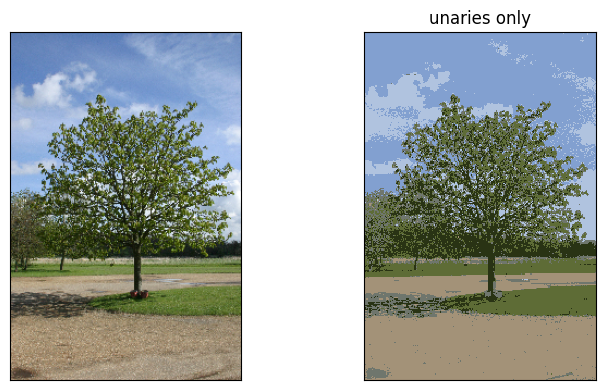

In [6]:
fix, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(image)
axes[1].set_title("unaries only")
axes[1].matshow(segmented_image)
for ax in axes.ravel():
  ax.set_xticks(())
  ax.set_yticks(())
plt.tight_layout()
plt.show()

## Building the Model

A key step is the construction of the factor graph representation that will represent the dependencies between random variables (represented as nodes in the graph).

As we want represent each pixel as a random variable which is 4-connected to adjacent pixels (a regular grid), we must define a graph that takes into account this topology. A candidate model is the factor graph shown below. The blue nodes, $x$, represent the observations (image) and white nodes, $y$, represent the latent (or hidden) variables.



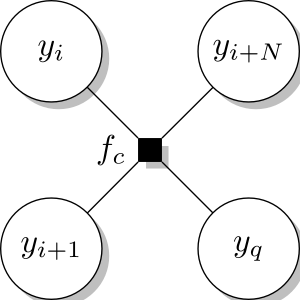

In [ ]:
# @title
%%tikz -l arrows,shapes,fit,positioning,calc,shadows,matrix  --scale 2 --size 300,300 -f svg
\node[draw, shape  	= circle,text = black, inner sep   = 1pt,   outer sep   = 0pt, minimum size   = 30 pt, drop shadow, fill=white!20] (yi) {$y_{i}$};
\node[draw, shape  	= circle,text = black, inner sep   = 1pt,   outer sep   = 0pt, minimum size   = 30 pt, drop shadow, fill=white!20,right=of yi] (yiN) {$y_{i+N}$};
\node[draw, shape  	= circle,text = black, inner sep   = 1pt,   outer sep   = 0pt, minimum size   = 30 pt, drop shadow, fill=white!20,below=of yi] (yii) {$y_{i+1}$} ;
\node[draw, shape  	= circle,text = black, inner sep   = 1pt,   outer sep   = 0pt, minimum size   = 30 pt, drop shadow, fill=white!20,below=of yiN] (yiiN) {$y_{q}$};
\node[draw, fill           = black,   text           = red,  drop shadow,label=left:$f_c$] at ($0.25*(yi) + 0.25*(yiN) + 0.25*(yii) + 0.25*(yiiN)$) {} edge (yii) edge (yi) edge (yiN) edge (yiiN);


We will first define the function __BuildFourORderFactorGraph__ that given an image will return  a list of __factors__. Each factor is define by a tuple of the form:  *( m , f )* , where *m* is a list of variable indices and *f* corresponds to a n-dimensional array  with the factor values.

This function also returns, as second element, the energy of the factor graph.

In [7]:
def build_theta_matrix(num_states, theta):
  i, j, k, l = np.indices((num_states,num_states,num_states,num_states))
  theta_4d_array = np.zeros((num_states,num_states,num_states,num_states))
  theta_4d_array[i==j] += theta[0]
  theta_4d_array[i!=j] += theta[1]
  theta_4d_array[i==k] += theta[0]
  theta_4d_array[i!=k] += theta[1]
  theta_4d_array[l==j] += theta[0]
  theta_4d_array[l!=j] += theta[1]
  theta_4d_array[l==k] += theta[0]
  theta_4d_array[l!=k] += theta[1]
  return theta_4d_array

def BuildFourOrderFactorGraph( image : Image, num_states : int = 1, theta : list = [0.0, 2.0], obs_probs : np.array  = None ):
  potential=asarray(image)
  midaOriginal = potential.shape
  nFils=midaOriginal[0]
  nCols=midaOriginal[1]
  nNodes = nFils*nCols

  # Building fourth order factors between latent variables
  p = [(i,i+1,i+nFils,i+1+nFils) for i in range(nNodes-nFils-1) if (i+1) % nFils != 0] # create thfourth of p, p+1, p+N and p+N+1, p is [0,nNodes-N-1]


  adj = p

  # build edges for max product inference:
  inds = np.arange( nNodes).reshape(midaOriginal[:2] ).astype(np.int64)


  # In case there are observations initialise the unary factors with the una potentials
  if obs_probs is not None:
    # unary factors
    unary_factors = [([m], p) for m, p in zip(inds.reshape(-1), obs_probs)]

  #create diagonal matrix 4d
  theta_4d_array = build_theta_matrix(num_states,theta)
  energy = theta_4d_array

  # Modify the matrix where the condition is true
  four_order_exp = np.exp( -energy )
  print("shape:",four_order_exp.shape[0],four_order_exp.shape[1],four_order_exp.shape[2])
  four_order_factors = [(m, four_order_exp) for m in adj]

  # We return the factor graph (as list of factors) and the energy
  return unary_factors + four_order_factors, -energy


In [8]:
factor_list, pairwise = BuildFourOrderFactorGraph( image, num_states=k , obs_probs=probs,theta=smooth_term )

shape: 6 6 6


In [ ]:
props = {'inference': 'MAXPROD', 'updates': 'SEQRND', 'tol': '1e-6', 'maxiter': '10', 'logdomain': '0','damping':0.1}
start = time()
qv, qf,  max_product = dai(factor_list, method= 'BP', props=props,with_beliefs=True)
time_maxprod = time() - start
max_product_image = mean_color[max_product.astype(int)]
max_product_image = max_product_image.reshape(midaOriginal)
energy_max_prod = 0#energy(unary_term.reshape(newShape) , max_product.reshape(midaOriginal[:2]), pairwise)

fix, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(image)
axes[1].set_title("max-product %.2fs, e=%.2f"% (time_maxprod, energy_max_prod))
axes[1].matshow(max_product_image)
for ax in axes.ravel():
  ax.set_xticks(())
  ax.set_yticks(())
plt.tight_layout()
plt.show()

In [ ]:
props = {'inference': 'SUMPROD', 'updates': 'SEQRND', 'tol': '1e-6', 'maxiter': '10', 'logdomain': '0','damping':0.1,'verbose':1}
start = time()
qv, qf, bp = dai(factor_list, method='BP', props=props,with_beliefs=True)
time_bp = time() - start
bp_image = mean_color[bp.astype(int)]
bp_image = bp_image.reshape(midaOriginal)
energy_bp = energy(unary_term.reshape(newShape), bp.reshape(midaOriginal[:2]), pairwise)

fix, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(image)
axes[1].set_title("Belief Propagation %.2fs, e=%.2f"% (time_bp, energy_bp))
axes[1].matshow(bp_image)
for ax in axes.ravel():
  ax.set_xticks(())
  ax.set_yticks(())
plt.tight_layout()
plt.show()

In [ ]:
props = {'inference': 'SUMPROD', 'updates': 'SEQRND', 'tol': '1e-2', 'maxiter': '100', 'logdomain': '0','burnin':0,'verbose':1 }
start = time()
qv, qf, gibbs = dai(factor_list, method='GIBBS', props=props,with_beliefs=True)
time_gibbs = time() - start
gibbs_image = mean_color[gibbs.astype(int)]
gibbs_image = gibbs_image.reshape(midaOriginal)
energy_gibbs =   energy(np.array([ x.tolist() for (m,x) in qv]).reshape(newShape) , gibbs.reshape(midaOriginal[:2]), pairwise)

fix, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(image)
axes[1].set_title("Gibbs Sampling %.2fs, e=%.2f"% (time_gibbs, energy_gibbs))
axes[1].matshow(gibbs_image)
for ax in axes.ravel():
  ax.set_xticks(())
  ax.set_yticks(())
plt.tight_layout()
plt.show()
